In [419]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [481]:
root, dirs, files = next(os.walk('./data/'))
color_pallete_dir = root + files[0]

color_pallette = pd.read_excel(color_pallete_dir, skiprows=8, usecols=[6, 7])
color_pallette.columns = ['Name', 'RGB']
color_pallette['RGB'] = color_pallette['RGB'].str.strip('(')
color_pallette['RGB'] = color_pallette['RGB'].str.strip(')')
color_pallette['RGB'] = color_pallette['RGB'].str.split(',')

rgb_array = np.array(color_pallette['RGB'].tolist(), dtype='float32')
rgb_labels = color_pallette['Name'].tolist()
n_classes = len(rgb_array)
rgb_to_class_map = {tuple(rgb): class_ for class_, rgb in enumerate(rgb_array)}

color_pallette

Name                RGB
0            background        [0,  0,  0]
1      building-flooded      [255,  0,  0]
2  building-non-flooded  [180,  120,  120]
3          road-flooded   [160,  150,  20]
4      road-non-flooded  [140,  140,  140]
5                 water   [61,  230,  250]
6                  tree     [0,  82,  255]
7               vehicle    [255,  0,  245]
8                  pool    [255,  235,  0]
9                 grass      [4,  250,  7]

In [505]:
X_train_jpg_dir = './data/FloodNet-Supervised_v1.0/train/train-org-img/'
X_test_jpg_dir = './data/FloodNet-Supervised_v1.0/test/test-org-img/'
X_val_jpg_dir = './data/FloodNet-Supervised_v1.0/val/val-org-img/'

Y_train_png_dir = './data/ColorMasks-FloodNetv1.0/ColorMasks-TrainSet/'
Y_test_png_dir = './data/ColorMasks-FloodNetv1.0/ColorMasks-TestSet/'
Y_val_png_dir = './data/ColorMasks-FloodNetv1.0/ColorMasks-ValSet/'

def mySort(e):
    try:
        e = e[0:5]
        e = int(e)
    except ValueError:
        try:
            e = e[0:4]
            e = int(e)
        except ValueError:
            e = 0
    return e


def create_array(path_x, path_y, img_format=('.jpg', '.png'), target_size=(128, 128)):
    """
        Args:
            -Directory to X: str
            -Directory to Y: str
            -Image format: tuple. Extension of X and Y respectively
            -Target_size: tuple of ints
        Returns:
           -X: Array of resized, flatened images (w * l * 3, m examples)
           -Y: Array of resized, flatened images (W * l * 3, m examples)
           -Y_class: Array of resized, flatened images with rgb changed to classes (w * l, m_examples)
            
    """
    w, l = target_size
    n = w * l * 3
    
    x_ = next(os.walk(path_x))[2]
    y_ = next(os.walk(path_y))[2]
    x_format, y_format = img_format

    for x_file in x_:
        if not x_file.endswith(x_format):
            x_.remove(x_file)

    for y_file in y_:
        if not y_file.endswith(y_format):
            y_.remove(y_file)

    assert len(x_) == len(y_)
    m = len(x_)

    x_.sort(key=mySort)
    y_.sort(key=mySort)
    
    X = np.zeros((n, m))
    Y = np.zeros((n, m))
    Y_class = np.zeros((w * l, m))
    
    
    for i, k in enumerate(zip(x_, y_)):
        image_x, image_y = k
        if image_x.strip(x_format) == image_y.strip('_lab' + y_format):
            img_x = Image.open(path_x + image_x).convert('RGB')
            img_y = Image.open(path_y + image_y).convert('RGB')

            img_x = img_x.resize((w, l), Image.LANCZOS)
            img_y = img_y.resize((w, l), Image.Resampling.NEAREST)

            arr_x = np.asarray(img_x)
            arr_y = np.asarray(img_y)

            arr_x = arr_x / 255
            arr_y = arr_y / 255

            arr_x = arr_x.reshape(-1, )
            arr_y = arr_y.reshape(-1, )

            X[:, i] = arr_x
            Y[:, i] = arr_y

            arr_y_class = np.asarray(img_y, dtype=np.uint8).reshape(w * l, 3)
            arr_y_class_changed = np.full(w * l, -1, dtype=np.int32)
            for i_y_class in range(w * l):
                px_y = tuple(int(v) for v in arr_y_class[i_y_class])
                arr_y_class_changed[i_y_class] = rgb_to_class_map.get(px_y, -1)

            Y_class[:, i] = arr_y_class_changed
            
            
        else:
            raise ValueError('X does not match Y')
        
    
    return X, Y, Y_class
            
            
                
    

In [512]:
X_train, Y_train, Y_train_class = create_array(X_train_jpg_dir, Y_train_png_dir)

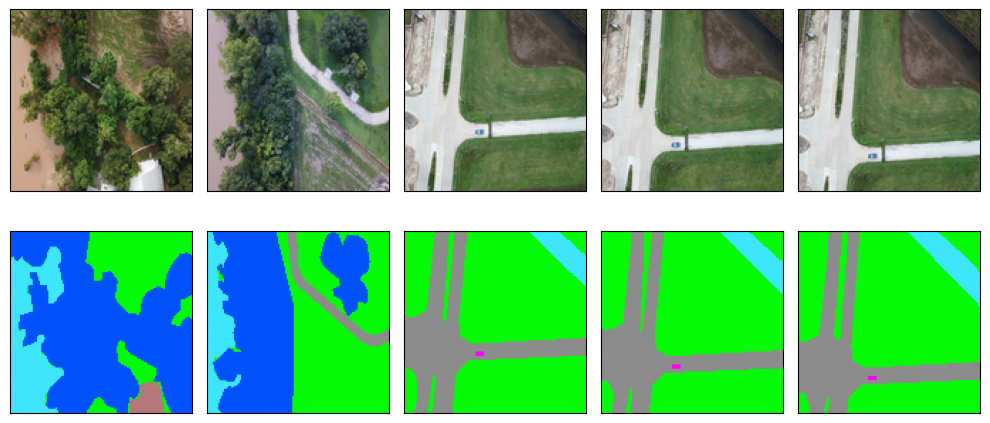

In [513]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5))

for i in range(5):
    x = X_train[:, i].reshape(128, 128, 3)
    y = Y_train[:, i].reshape(128, 128, 3)

    axs[0, i].imshow(x)
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    
    axs[1, i].imshow(y)
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])

plt.tight_layout()
plt.show()


In [519]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
X_train = X_train.reshape(-1, 128, 128, 3)
Y_train_class = Y_train_class.reshape(-1, 128, 128)

model = Sequential([
    tf.keras.Input(shape=(128, 128, 3)),
    Dense(units=128, activation='relu'),
    Dense(units=256, activation='relu'),
    Dense(units=128, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=n_classes, activation='softmax')
])
model.compile(
    optimizer = optimizer,
    loss = tf.keras.losses.SparseCategoricalCrossentropy,
    metrics = [
        'accuracy'
        ]
)

In [520]:
model.fit(X_train, Y_train_class, epochs=15)

Epoch 1/15


2025-10-10 23:40:01.185925: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed at sparse_xent_op.cc:103 : INVALID_ARGUMENT: Received a label value of -1 which is outside the valid range of [0, 10).  Label values: 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 4 5 5 9 4 4 4 9 4 4 4 9 4 6 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 6 6 9 9 -1 9 9 9 9 9 0 0 4 0 0 0 0 5 5 5 0 0 6 9 4 2 6 6 6 6 6 4 6 6 9 6 6 6 4 6 2 9 9 9 4 2 9 4 9 9 6 9 9 9 9 9 9 9 9 9 6 6 6 6 0 0 6 6 2 6 6 2 9 9 9 6 9 -1 -1 2 5 9 6 2 6 9 6 4 5 5 5 5 9 9 6 9 9 9 9 9 9 9 6 2 6 6 6 6 6 6 6 6 6 9 9 6 9 9 9 5 5 9 6 6 2 4 6 4 9 4 4 9 2 4 9 9 9 9 9 9 9 9 9 5 9 5 9 9 9 9 9 4 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 2 7 2 2 6 2 2 6 6 6 2 6 9 6 9 6 9 9 2 9 4 5 5 5 4 5 5 6 9 6 6 9 6 6 6 6 9 6 2 9 9 6 6 2 9 6 6 6 6 6 4 9 9 9 9 9 9

InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/runpy.py", line 86, in _run_code

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3077, in run_cell

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3132, in _run_cell

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3336, in run_cell_async

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3519, in run_ast_nodes

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code

  File "/var/folders/_2/vsqydlm17ps0vrtv2k7j4bxh0000gn/T/ipykernel_93223/2546695770.py", line 1, in <module>

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 60, in train_step

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/trainers/trainer.py", line 383, in _compute_loss

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/trainers/trainer.py", line 351, in compute_loss

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/trainers/compile_utils.py", line 690, in __call__

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/trainers/compile_utils.py", line 699, in call

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/losses/loss.py", line 67, in __call__

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/losses/losses.py", line 33, in call

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/losses/losses.py", line 2246, in sparse_categorical_crossentropy

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/ops/nn.py", line 1964, in sparse_categorical_crossentropy

  File "/Users/patryknowak/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py", line 744, in sparse_categorical_crossentropy

Received a label value of -1 which is outside the valid range of [0, 10).  Label values: 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 4 5 5 9 4 4 4 9 4 4 4 9 4 6 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 6 6 9 9 -1 9 9 9 9 9 0 0 4 0 0 0 0 5 5 5 0 0 6 9 4 2 6 6 6 6 6 4 6 6 9 6 6 6 4 6 2 9 9 9 4 2 9 4 9 9 6 9 9 9 9 9 9 9 9 9 6 6 6 6 0 0 6 6 2 6 6 2 9 9 9 6 9 -1 -1 2 5 9 6 2 6 9 6 4 5 5 5 5 9 9 6 9 9 9 9 9 9 9 6 2 6 6 6 6 6 6 6 6 6 9 9 6 9 9 9 5 5 9 6 6 2 4 6 4 9 4 4 9 2 4 9 9 9 9 9 9 9 9 9 5 9 5 9 9 9 9 9 4 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 2 7 2 2 6 2 2 6 6 6 2 6 9 6 9 6 9 9 2 9 4 5 5 5 4 5 5 6 9 6 6 9 6 6 6 6 9 6 2 9 9 6 6 2 9 6 6 6 6 6 4 9 9 9 9 9 9 9 9 9 9 6 2 6 2 4 4 2 6 2 6 9 9 9 5 5 6 5 5 5 5 9 9 9 3 3 -1 3 -1 5 5 5 5 5 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 9 6 6 9 9 9 9 9 2 5 5 5 9 9 2 6 6 2 9 2 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 5 5 5 6 9 9 9 6 6 6 6 6 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 2 9 6 2 9 9 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 6 6 6 6 6 4 4 2 9 2 2 4 9 6 2 8 6 9 9 6 6 6 6 9 9 4 6 6 6 6 6 6 6 6 9 6 9 6 6 9 4 4 6 4 9 4 4 9 9 9 5 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 6 2 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 6 9 9 9 9 6 9 6 9 9 9 9 9 6 9 6 9 6 6 4 9 6 3 9 9 9 9 6 9 9 6 9 4 4 9 9 9 6 6 9 9 5 6 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 3 6 6 3 6 5 5 1 1 1 9 6 9 1 1 1 2 6 9 9 9 1 6 0 3 3 6 6 9 3 3 3 3 6 3 3 3 3 9 5 5 5 6 3 1 1 6 1 5 6 2 2 9 6 3 6 6 3 1 9 5 1 5 9 5 9 6 9 6 1 3 1 3 3 3 3 9 6 3 1 9 6 1 3 6 1 6 5 5 5 9 1 6 9 3 9 3 9 6 5 6 6 1 9 9 0 9 1 3 3 6 9 6 9 6 9 1 6 9 9 6 1 1 1 6 3 6 3 6 6 6 9 6 1 2 6 3 2 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 4 4 2 4 4 4 4 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 6 6 5 5 5 5 5 6 5 6 5 5 6 5 5 5 9 9 9 9 5 5 5 9 9 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 8 9 9 5 5 9 9 9 9 9 9 6 6 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 9 9 4 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 4 4 9 5 5 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 5 3 9 9 9 4 9 9 6 6 9 9 6 9 6 6 6 6 9 6 4 9 6 6 9 6 9 9 9 9 9 6 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 6 9 9 9 9 6 9 9 6 6 9 6 9 6 9 9 4 4 6 6 6 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 4 4 2 2 2 9 9 5 5 6 9 6 6 5 9 6 5 6 6 6 5 5 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 4 4 2 2 2 4 9 9 5 9 6 9 6 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 5 6 6 6 6 6 6 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 4 5 5 9 4 4 4 9 9 4 6 9 4 6 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 6 6 9 9 -1 9 9 9 9 9 0 0 4 0 0 0 0 5 5 0 0 0 6 9 4 2 6 6 6 6 6 6 6 6 9 6 6 6 4 6 2 9 9 9 4 2 9 4 9 9 6 9 9 9 9 9 9 9 9 9 0 6 6 0 0 0 6 6 2 2 6 2 9 9 9 4 9 -1 -1 2 5 9 5 2 6 9 6 4 5 5 5 5 9 9 6 9 9 9 9 9 9 9 6 2 4 6 6 6 6 6 6 6 6 9 9 6 9 9 9 5 5 9 6 6 6 4 6 4 4 4 4 9 2 4 9 9 9 9 9 9 9 9 9 5 9 5 9 9 9 9 9 4 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 2 7 2 2 6 2 2 6 6 6 2 6 9 6 9 9 9 9 2 9 4 5 5 5 2 5 5 6 9 6 6 9 6 6 6 6 9 6 9 9 2 6 6 2 9 6 6 6 2 6 4 9 9 9 9 9 9 9 9 9 9 6 2 6 2 4 6 2 6 2 6 9 9 9 5 5 6 5 5 5 5 9 9 9 3 3 -1 3 -1 5 5 5 5 5 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 9 6 6 9 9 9 9 9 2 5 5 5 9 9 2 6 6 2 9 2 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 6 6 5 5 5 6 9 9 9 6 6 6 6 6 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 2 9 6 2 9 9 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 6 6 6 6 6 4 4 2 9 2 2 4 9 6 2 8 9 9 9 6 6 6 6 9 9 4 6 6 6 6 6 6 6 6 9 6 9 6 6 9 4 4 6 4 9 4 4 9 9 9 5 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 6 9 9 6 9 9 9 9 6 9 6 9 6 6 4 9 6 3 9 9 9 9 6 9 9 6 4 4 4 9 9 9 6 6 9 9 5 6 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 9 3 6 9 5 5 1 1 1 9 6 9 1 1 1 2 6 9 9 9 1 6 0 3 3 9 9 9 3 3 3 3 6 3 3 3 3 9 6 5 5 6 3 1 1 6 1 5 6 2 2 9 6 3 5 6 3 1 9 5 1 5 9 5 9 6 9 6 1 3 1 3 3 3 3 9 6 3 1 6 6 1 3 6 1 6 1 5 5 9 1 6 9 3 9 6 1 3 5 6 6 1 9 9 0 9 1 3 3 6 9 3 9 6 9 6 6 9 9 6 1 1 1 6 3 6 6 6 6 6 9 6 1 2 6 3 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 2 4 4 4 4 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 6 6 5 5 5 5 5 6 5 6 5 6 6 5 5 5 9 9 9 9 5 5 5 9 9 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 8 9 9 5 5 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 4 4 9 5 5 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 9 9 6 9 9 6 6 6 6 6 6 9 6 4 9 6 9 9 6 9 6 9 9 9 6 9 9 9 9 9 6 9 6 9 9 9 9 9 9 6 9 4 4 9 9 9 9 9 6 9 9 9 9 6 9 9 9 6 9 6 9 6 9 9 4 4 6 6 6 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 4 4 4 2 2 4 9 5 5 6 9 6 6 5 9 6 5 6 6 5 5 5 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 4 4 4 2 2 4 9 9 5 9 6 9 6 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 6 6 6 6 6 6 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 4 5 5 9 4 4 4 9 9 4 6 9 4 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 6 6 9 9 -1 9 9 9 9 9 0 0 0 0 0 0 0 5 0 0 0 0 6 9 9 2 6 6 6 6 6 6 6 6 9 6 6 6 4 6 2 9 9 9 4 2 9 4 9 9 6 9 9 9 9 9 9 9 9 9 0 6 6 8 0 0 6 6 2 2 6 2 9 9 9 9 9 -1 -1 2 4 9 2 2 6 9 6 4 5 5 5 5 2 9 6 9 9 9 9 9 9 9 6 2 6 6 6 6 6 6 6 6 6 9 9 6 9 9 9 5 5 9 6 9 6 4 6 4 4 4 6 4 2 4 9 9 9 9 9 9 9 9 9 5 9 5 9 9 9 9 9 4 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 2 7 9 2 6 2 2 6 6 6 2 6 9 6 8 9 9 9 2 9 4 5 5 5 2 5 5 6 9 6 6 9 6 6 6 6 9 6 9 9 9 6 6 2 9 6 6 6 2 6 4 9 9 9 9 9 9 9 9 9 9 6 9 6 2 4 6 2 6 2 6 9 9 9 5 5 6 5 5 5 5 9 9 9 3 3 -1 3 -1 5 5 5 5 5 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 9 6 6 9 9 9 9 9 2 9 9 5 9 9 2 6 6 2 9 2 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 9 9 6 6 6 6 6 6 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 2 9 6 2 9 9 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 4 2 9 2 2 4 9 6 2 8 9 9 9 6 6 6 6 9 9 4 6 6 6 6 6 6 6 6 9 6 9 9 9 9 4 4 6 4 9 4 4 9 9 9 5 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 6 9 6 6 6 6 6 9 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 6 9 9 6 9 9 9 9 6 9 6 6 6 6 9 9 6 3 9 9 9 9 9 9 9 6 4 4 4 9 9 9 6 6 9 9 5 6 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 2 3 6 9 5 5 1 1 1 9 6 9 1 1 6 2 6 9 3 9 1 6 0 3 3 6 9 9 3 3 3 3 6 3 3 3 3 9 6 5 5 6 6 1 1 6 1 5 6 2 2 9 3 3 6 6 3 1 9 5 1 5 5 1 9 9 9 6 1 3 1 3 3 3 3 9 6 3 1 6 9 1 3 6 1 6 1 5 5 9 1 6 9 3 1 6 1 3 5 6 6 1 9 9 0 9 1 3 3 6 9 3 9 3 9 6 6 9 9 6 1 1 1 6 3 6 6 6 6 6 9 9 1 2 6 3 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 2 4 4 4 4 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 6 6 5 5 5 5 5 6 5 6 5 6 6 5 5 5 9 9 9 9 5 5 5 9 6 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 6 9 9 5 5 9 9 9 9 9 6 6 9 9 9 9 6 6 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 4 4 9 5 5 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 9 9 6 9 9 6 9 6 6 6 6 9 6 4 9 9 9 9 6 9 6 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 6 9 6 9 9 4 4 6 6 6 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 4 4 4 2 2 4 9 5 5 6 5 6 6 5 6 6 5 6 6 5 5 5 9 4 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 4 4 4 2 2 4 9 9 5 9 9 9 6 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 6 6 6 6 6 6 9 9 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 8 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 6 5 5 9 4 4 4 9 9 6 6 9 4 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 6 9 9 -1 9 9 9 9 9 0 0 0 5 0 0 0 5 0 0 0 0 6 9 9 2 6 6 6 6 6 6 6 6 9 6 6 6 4 6 2 9 9 9 4 2 9 4 9 9 6 9 9 9 9 9 9 9 9 9 0 0 6 8 0 0 6 6 2 2 6 2 9 9 9 9 9 -1 4 2 4 9 2 5 6 6 6 4 5 5 9 5 2 9 6 9 9 9 9 9 9 9 6 2 6 6 6 6 6 6 6 6 6 9 9 6 9 9 9 5 5 9 6 9 2 4 6 4 4 6 6 4 2 4 9 9 9 9 9 9 9 9 9 5 9 5 9 9 9 9 9 4 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 2 7 9 2 6 2 2 6 6 6 2 6 9 6 8 9 9 9 2 9 4 5 5 5 2 5 5 6 9 6 6 9 6 6 6 6 9 6 9 9 9 6 6 9 9 6 6 6 2 6 4 9 9 9 9 9 9 9 9 9 9 6 2 6 2 4 6 2 6 2 6 9 9 9 5 5 6 5 5 5 5 9 9 9 3 3 -1 3 -1 5 5 5 5 5 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 6 6 9 9 9 9 9 2 9 9 5 9 9 2 6 6 2 9 2 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 9 9 6 6 6 6 6 6 6 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 2 9 9 2 9 9 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 2 9 2 2 4 9 6 2 8 9 9 9 9 6 6 6 9 9 4 6 6 6 6 6 6 6 6 9 6 9 9 9 4 4 9 6 4 9 4 4 9 9 9 5 6 9 9 9 9 9 6 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 6 9 6 6 6 6 6 9 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 6 9 9 6 9 9 9 9 6 9 6 6 6 6 9 9 6 3 9 9 9 9 9 9 9 6 4 4 4 9 9 9 6 6 9 9 5 0 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 2 3 6 9 5 5 1 1 1 9 9 9 1 6 6 2 6 9 3 9 1 6 0 3 3 6 9 9 3 3 9 9 6 3 3 3 3 1 6 5 5 6 6 5 1 6 1 5 6 2 2 9 3 3 6 6 3 1 9 5 6 5 5 1 9 3 9 6 5 3 1 3 3 3 3 9 6 3 1 6 9 1 3 6 1 6 5 3 3 9 1 6 9 6 1 6 1 3 3 3 6 1 9 9 0 9 1 3 3 6 9 3 1 3 9 6 6 9 3 6 1 1 1 6 3 6 6 6 6 6 9 9 1 2 3 3 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 2 4 4 4 4 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 6 6 5 5 5 5 5 5 5 6 6 6 6 5 5 5 9 9 9 9 5 5 5 9 6 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 6 9 9 5 5 9 9 9 9 9 6 6 9 6 9 9 6 6 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 4 6 9 5 5 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 9 9 6 9 9 6 6 6 6 6 6 9 6 4 9 9 9 9 6 9 6 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 6 9 6 9 9 4 4 6 6 6 6 6 9 9 9 9 9 9 9 6 6 9 9 9 9 4 4 4 2 2 4 9 5 5 6 5 6 6 5 6 6 5 6 6 5 6 5 9 6 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 4 7 4 2 2 4 9 9 5 9 9 9 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 6 6 6 6 6 6 9 9 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 8 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 6 5 5 9 4 4 4 9 9 6 6 9 4 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 9 4 -1 9 9 9 9 9 0 0 0 5 0 0 0 5 0 0 0 0 6 9 9 2 6 6 6 6 6 6 6 6 9 6 6 6 4 6 2 9 9 9 4 2 9 4 9 9 6 9 9 9 9 9 9 9 9 9 0 0 6 8 0 0 6 6 2 2 6 2 9 9 9 9 9 -1 4 2 2 2 5 2 6 6 6 4 5 9 9 5 2 9 6 9 9 9 9 9 9 9 6 2 6 6 6 6 6 6 6 6 6 9 9 6 9 9 6 5 5 9 6 9 2 4 6 6 4 6 6 4 2 4 9 9 9 9 9 9 9 9 9 5 9 5 9 9 9 9 9 4 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 2 7 9 2 6 2 2 6 6 6 2 6 9 6 8 9 9 9 9 9 4 5 5 5 2 5 5 6 9 6 6 9 6 6 9 6 9 6 9 9 9 6 6 9 9 6 6 6 2 6 4 9 9 9 9 9 9 9 9 9 9 6 9 6 2 4 6 2 6 2 6 9 9 9 5 6 6 5 5 5 5 9 9 9 3 3 -1 3 -1 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 6 6 9 9 9 9 9 2 9 9 5 9 9 2 6 6 2 9 2 6 1 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 9 9 6 6 6 6 6 6 6 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 2 9 9 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 2 9 2 2 4 9 6 2 8 9 9 9 9 6 6 6 9 9 4 6 6 6 6 6 6 6 6 9 9 9 9 9 4 9 9 6 4 9 4 4 9 9 9 5 6 9 9 9 9 9 6 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 6 9 6 6 6 6 6 9 6 6 9 9 9 9 9 6 9 9 6 9 9 9 9 6 9 6 9 9 9 9 9 6 9 9 6 9 9 9 9 6 9 6 6 6 6 9 9 6 3 9 9 9 9 9 9 9 4 4 4 6 9 9 9 6 6 9 9 9 0 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 2 3 1 9 5 5 1 1 9 9 9 9 6 6 6 2 6 9 3 9 1 6 0 3 3 6 9 1 3 3 9 9 6 3 3 3 3 1 6 5 5 6 6 5 1 6 1 5 6 2 9 9 3 3 6 6 3 1 6 9 6 5 5 5 9 3 9 6 5 3 1 3 3 3 3 9 3 3 1 6 9 1 3 6 1 6 6 3 3 9 1 6 9 6 1 3 9 3 3 3 6 1 9 9 0 9 1 3 3 6 9 6 1 3 6 6 9 9 3 6 1 1 1 6 3 6 6 6 6 6 9 9 1 2 3 3 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 2 4 4 4 4 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 5 2 6 6 5 5 5 5 5 5 5 6 6 6 6 5 5 5 9 9 9 9 5 5 5 9 6 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 5 5 5 5 6 9 9 5 5 9 9 9 9 9 6 6 9 6 9 9 6 6 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 4 6 9 5 5 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 9 9 6 9 9 6 6 6 6 6 6 9 6 4 9 9 9 9 6 6 6 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 9 6 9 6 9 4 4 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 6 9 6 9 9 4 4 6 6 6 6 6 9 9 9 9 9 9 9 6 6 9 9 9 9 4 4 4 2 2 4 9 5 5 6 5 6 6 6 6 6 5 6 6 5 6 5 9 4 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 4 4 4 2 2 4 9 9 5 9 9 9 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 9 9 9 9 9 6 9 9 9 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 8 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 6 5 5 9 4 4 4 9 9 6 6 9 4 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 0 0 0 5 0 0 0 5 0 0 0 0 6 4 9 2 6 6 6 6 6 6 6 6 9 6 6 6 4 6 2 9 9 9 4 2 9 4 9 9 6 9 9 9 9 9 9 9 9 9 0 0 0 8 0 0 6 6 2 2 6 2 9 9 9 9 9 -1 4 6 2 2 6 5 6 6 6 4 5 9 9 5 2 9 6 9 9 6 9 9 9 9 6 2 6 6 6 6 6 6 6 6 6 9 9 6 9 9 6 5 5 9 6 9 2 9 6 6 4 6 6 4 2 4 9 9 9 2 9 9 9 9 9 5 9 5 9 9 9 9 9 4 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 2 7 6 2 6 9 2 9 9 6 2 6 9 9 8 9 9 9 9 9 4 5 5 5 2 5 5 6 9 6 6 9 6 6 9 9 9 9 9 9 9 6 6 9 8 6 6 6 2 6 4 9 9 9 9 9 9 9 9 9 9 6 9 6 2 4 6 9 6 2 6 9 9 9 5 6 6 5 5 5 5 9 9 9 3 3 -1 3 -1 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 6 6 6 6 9 9 9 9 2 9 9 9 9 9 2 6 6 2 9 2 6 1 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 5 6 6 9 6 6 6 6 6 6 6 6 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 2 9 9 9 6 9 9 6 6 2 9 9 9 6 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 2 9 2 2 2 9 6 2 8 9 9 9 9 6 6 6 9 9 4 6 6 6 6 6 6 6 6 9 9 9 9 9 4 9 9 6 4 9 4 4 9 9 9 5 6 9 9 9 9 9 6 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 6 6 6 6 6 6 6 9 6 6 9 9 9 9 6 6 9 9 6 9 9 9 9 6 9 6 9 9 9 9 9 6 9 9 6 9 9 9 9 6 9 6 6 6 6 9 9 6 9 9 9 9 9 9 9 4 4 4 4 6 9 9 9 6 6 9 9 6 0 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 2 3 1 9 5 5 1 1 9 9 9 9 6 6 6 2 6 9 3 9 1 6 0 3 3 6 9 1 3 3 9 6 9 3 3 3 3 9 6 5 5 6 6 5 1 3 1 5 6 2 9 9 3 3 6 6 3 1 6 3 6 5 5 5 9 3 1 6 5 3 1 3 3 3 3 9 9 3 1 6 9 1 3 6 1 5 6 3 3 9 1 9 1 6 1 3 9 3 3 3 1 1 9 9 0 9 1 3 3 6 9 6 1 3 6 6 9 6 3 6 1 1 1 6 3 6 6 6 6 6 9 9 1 2 3 3 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 4 4 4 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 5 2 6 6 5 5 5 5 5 5 5 6 6 6 5 5 5 5 9 9 9 9 5 5 9 9 6 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 5 5 5 5 6 9 9 5 9 9 9 9 9 9 6 6 9 6 9 9 6 6 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 4 6 9 5 5 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 9 9 6 9 9 6 9 9 6 6 6 9 9 4 9 9 9 9 6 6 6 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 9 6 9 6 9 4 4 9 9 9 6 9 9 9 9 9 9 6 9 9 9 6 9 6 9 6 9 9 4 4 6 6 6 6 6 9 9 9 9 9 9 9 6 6 9 9 9 9 4 4 4 4 2 4 9 5 5 6 5 6 6 6 6 6 5 9 6 5 6 5 9 4 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 4 4 4 2 2 4 9 9 5 5 9 9 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 9 9 9 9 9 6 9 9 9 6 6 6 6 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 8 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 6 5 5 9 4 4 4 4 9 6 6 9 4 9 4 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 0 0 0 5 0 0 0 5 0 0 0 0 6 4 9 2 6 6 6 9 6 6 6 6 9 6 6 2 4 6 2 9 9 9 4 2 9 4 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 8 0 0 6 6 2 2 6 2 9 9 9 9 9 -1 4 6 2 2 2 2 2 6 6 4 5 9 9 5 2 6 6 9 9 6 9 9 9 9 6 2 6 6 6 6 6 6 6 6 6 9 9 6 9 9 6 5 5 9 6 9 2 9 6 6 6 6 6 4 2 4 9 9 9 2 9 9 9 9 9 5 9 5 9 9 9 9 9 4 4 5 6 6 4 4 4 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 2 7 6 2 6 9 2 9 9 6 9 6 9 6 8 9 9 9 9 9 4 5 5 5 2 5 5 6 9 6 6 9 9 6 9 9 9 9 9 9 9 6 6 9 8 6 6 6 2 6 4 9 9 9 9 9 9 9 9 9 9 6 9 6 6 4 2 4 6 2 6 9 9 9 5 6 6 5 5 5 5 6 9 9 3 3 -1 3 -1 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 6 6 6 6 4 9 9 9 2 9 9 9 9 9 2 6 6 9 9 2 6 1 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 5 6 6 9 6 6 6 6 6 6 6 6 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 2 6 9 9 6 9 9 6 6 2 9 9 9 6 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 2 9 2 2 2 9 6 2 8 9 9 9 9 9 6 6 9 9 4 6 6 6 6 6 6 6 6 9 9 9 9 4 4 9 9 6 4 9 4 4 9 9 9 5 6 9 9 9 9 9 6 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 6 9 6 6 6 6 6 4 6 4 9 9 9 9 6 6 9 9 6 9 9 9 9 6 9 6 9 9 9 9 9 6 9 9 6 9 9 9 9 6 9 6 6 6 9 9 9 6 9 9 9 9 9 9 4 4 4 4 9 6 9 9 9 6 6 9 9 6 0 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 2 1 1 9 5 5 1 1 6 9 9 9 6 6 6 0 6 9 3 9 1 6 0 3 3 6 9 1 3 3 9 6 9 3 3 3 3 9 5 5 5 6 6 5 1 3 1 5 6 9 6 9 3 3 6 6 3 1 6 3 6 5 5 5 9 3 1 6 5 3 6 3 3 3 3 6 3 3 1 6 1 1 3 6 5 5 6 6 3 9 1 9 1 6 1 3 1 3 3 3 1 0 9 9 0 9 1 3 9 6 9 6 1 3 6 6 9 6 3 6 1 1 1 6 3 6 6 6 6 6 9 6 1 2 3 3 2 2 2 9 2 9 9 9 9 9 9 9 9 9 9 9 9 4 2 2 4 4 4 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 5 2 6 6 5 5 5 5 5 5 5 6 6 6 5 5 5 5 9 9 9 9 5 5 9 9 6 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 5 5 5 5 6 9 9 5 9 9 9 9 9 9 6 6 9 6 9 9 6 6 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 4 6 9 5 5 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 9 9 6 9 9 6 9 9 6 6 6 9 9 4 6 9 9 9 6 6 6 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 9 6 9 6 6 4 4 9 9 9 6 6 9 9 9 9 9 6 9 9 6 6 9 6 9 6 9 9 4 4 6 6 6 6 6 9 9 9 9 9 9 9 6 6 9 9 9 9 4 4 4 4 2 4 9 9 5 6 5 6 6 6 6 6 5 9 6 5 5 9 9 4 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 4 4 4 2 2 4 9 9 5 5 9 9 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 6 9 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 8 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 6 5 5 9 4 4 4 4 9 6 6 9 4 9 4 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 0 0 0 0 0 0 0 5 0 0 0 0 6 4 9 2 4 6 6 9 6 6 6 9 9 6 6 2 4 6 2 9 9 9 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 0 0 8 8 0 8 6 6 2 2 6 2 9 9 9 9 9 -1 4 6 2 2 2 5 6 6 6 4 5 9 9 5 2 6 6 9 9 6 9 9 9 9 6 2 6 6 6 6 6 6 6 6 6 9 9 6 9 9 6 5 5 9 6 9 2 6 6 6 6 6 6 6 2 6 9 9 9 2 9 9 9 9 9 5 9 5 9 9 9 9 9 9 4 5 6 6 4 4 4 4 4 4 9 9 4 4 4 4 4 9 9 9 9 9 9 4 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 2 7 6 2 6 9 2 9 9 6 9 6 9 9 8 6 9 9 9 9 4 5 5 5 2 5 5 6 9 6 6 9 9 6 9 9 9 9 9 9 9 6 6 8 8 6 6 6 2 6 4 9 9 9 9 9 9 9 9 9 9 6 9 6 6 4 2 4 6 2 9 9 9 9 5 6 6 5 5 5 5 6 9 9 3 3 -1 3 -1 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 6 6 6 6 4 9 9 9 2 9 9 9 9 9 2 6 9 9 9 2 6 1 6 5 5 5 5 5 5 5 5 5 5 5 6 5 5 6 5 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 2 6 9 9 6 9 9 6 6 2 9 9 9 6 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 2 9 2 2 2 9 6 2 8 9 9 9 9 9 6 9 9 9 4 6 6 6 6 6 6 6 6 9 9 9 9 4 4 9 9 6 4 9 4 4 9 9 9 5 6 9 9 9 9 9 6 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 6 9 6 6 6 6 6 4 6 4 4 9 4 9 9 6 6 9 6 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 6 6 9 9 9 6 9 9 9 9 4 4 4 4 4 9 6 6 9 9 9 6 6 9 9 6 0 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 2 1 1 9 5 5 1 9 6 9 9 9 6 6 6 0 6 9 6 9 1 6 0 6 3 6 9 1 9 3 9 6 9 3 3 3 3 9 5 5 5 6 6 5 1 3 1 5 6 9 6 9 3 3 6 6 3 1 6 3 6 5 5 5 9 3 1 6 5 3 6 3 3 3 3 6 3 6 1 6 1 9 3 6 5 5 6 6 3 9 1 9 1 6 1 3 1 3 3 3 1 1 9 9 6 9 0 3 9 6 9 6 1 3 6 6 9 6 3 6 1 1 1 6 3 6 6 6 6 6 9 6 1 0 3 3 2 2 2 9 2 9 9 9 9 9 9 9 9 9 9 9 9 4 2 2 4 4 4 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 5 2 5 6 5 5 5 5 5 5 5 6 6 6 5 5 5 5 9 9 9 9 5 5 9 9 6 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 5 5 5 5 6 9 9 5 9 9 9 9 9 9 6 6 9 6 9 9 6 6 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 4 6 9 5 5 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 9 9 6 9 9 6 9 9 6 9 6 9 9 4 6 9 9 9 6 6 6 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 6 9 6 6 4 4 9 9 9 6 6 9 9 9 9 9 6 9 9 6 6 9 6 9 9 9 9 4 4 6 6 6 6 6 9 9 9 9 9 9 9 6 6 9 6 9 9 4 4 4 4 2 4 9 9 5 6 5 6 6 6 6 6 5 9 6 5 5 9 9 4 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 4 4 4 2 2 0 9 9 5 5 9 9 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 9 6 6 9 9 9 9 9 6 9 9 9 9 9 9 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 8 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 -1 9 9 9 5 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 6 5 5 9 4 4 4 9 9 6 6 9 4 9 9 4 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 0 0 0 0 0 0 0 5 0 0 0 0 6 4 9 2 4 6 6 9 9 6 9 9 9 6 6 2 4 4 2 9 9 9 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 0 2 8 8 0 8 6 6 2 2 6 2 9 9 9 9 9 -1 4 6 2 2 6 6 5 6 6 4 5 9 9 5 2 6 6 9 9 6 9 9 9 9 6 2 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 5 5 9 9 4 2 6 6 6 6 6 6 6 2 6 9 9 9 2 9 9 9 9 9 5 9 5 9 9 9 9 9 9 4 5 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 4 9 9 4 4 9 9 9 9 9 9 9 4 4 4 4 4 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 2 2 6 2 6 9 2 9 9 9 9 6 9 9 8 6 9 9 9 9 4 5 5 5 2 5 5 6 9 6 6 9 9 6 9 6 9 9 9 9 9 6 6 9 8 6 6 6 2 6 4 9 9 9 9 9 9 9 9 9 9 6 9 6 6 4 2 4 6 9 9 9 9 9 5 5 6 5 9 5 5 6 9 9 3 3 -1 3 -1 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 9 6 6 6 6 4 9 9 9 2 9 9 9 9 5 9 6 3 9 6 2 6 1 6 5 5 5 6 5 5 5 5 5 5 5 6 5 5 6 5 6 6 9 6 9 6 6 6 6 6 6 6 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 2 6 9 9 6 9 9 6 6 2 9 9 9 6 9 9 9 9 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 2 9 2 2 2 9 6 2 8 9 9 9 9 9 6 9 9 9 4 6 6 6 6 6 6 6 6 9 9 9 4 4 4 9 9 6 4 9 4 4 9 9 9 5 6 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 6 6 6 6 6 6 6 4 9 9 4 9 4 9 9 6 6 9 6 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 6 6 9 9 9 6 9 9 9 9 4 4 4 4 4 9 6 6 9 9 9 6 6 9 9 6 0 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 9 1 1 9 5 5 1 9 6 9 9 9 6 6 6 0 6 9 6 9 9 6 6 6 3 6 1 1 9 3 9 6 9 3 3 3 3 9 5 5 5 6 6 5 1 3 1 5 6 9 6 9 3 3 6 6 3 1 6 3 6 5 5 5 9 3 1 6 5 3 6 3 3 3 3 9 3 6 1 6 1 1 3 6 5 5 6 6 3 9 1 9 1 6 1 3 1 3 3 3 1 6 9 9 6 9 0 3 9 6 9 6 1 3 6 6 1 6 3 6 9 1 1 6 3 6 6 6 6 6 9 6 1 0 5 3 2 2 2 9 2 9 9 9 9 9 9 9 9 9 9 9 9 4 2 2 4 4 4 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 5 2 5 6 5 5 5 5 5 5 5 6 6 5 5 5 5 5 9 9 9 9 5 5 9 9 6 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 5 5 5 5 6 9 9 5 9 9 9 9 9 9 6 6 9 6 9 9 6 6 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 4 6 9 9 5 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 9 9 6 6 9 6 9 9 6 9 6 9 9 4 6 9 9 9 6 6 6 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 6 9 6 6 4 4 9 6 9 6 6 9 9 9 9 9 6 9 9 6 9 9 6 6 9 9 9 4 4 6 6 9 6 6 9 9 9 9 9 9 9 6 6 9 6 9 9 4 4 4 4 2 4 9 9 5 6 5 6 6 6 6 6 5 9 6 5 5 9 9 6 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 4 4 4 2 2 0 9 9 5 5 9 9 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 8 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 -1 9 9 9 5 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 6 5 5 9 4 4 4 4 9 6 6 9 4 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 0 0 0 0 0 0 0 5 0 0 0 0 6 4 9 2 4 6 6 6 9 2 2 2 9 6 6 2 4 4 2 9 9 9 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 0 2 0 8 0 8 6 9 9 2 6 2 9 9 9 9 9 -1 9 6 2 9 5 6 5 6 6 4 9 9 9 5 2 9 6 9 6 6 9 9 9 9 6 2 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 5 5 9 9 4 2 6 6 6 6 6 6 6 2 6 9 9 9 2 9 9 9 9 9 5 9 5 9 9 9 9 9 9 4 5 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 4 4 4 4 4 4 9 9 9 9 9 4 4 9 9 9 5 5 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 2 2 6 2 6 9 9 9 9 9 9 6 9 9 8 6 9 9 9 9 4 5 5 5 2 5 5 6 9 6 6 9 6 6 9 6 9 9 9 9 9 6 6 8 8 6 6 6 2 6 4 9 9 9 9 9 9 9 9 9 9 6 9 6 6 4 2 4 6 9 9 9 9 9 5 5 6 5 9 5 5 6 9 9 3 3 -1 3 -1 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 9 6 6 6 6 4 9 9 9 2 9 2 9 9 5 9 6 3 9 6 2 6 1 6 5 6 5 6 5 5 5 5 5 5 5 6 5 5 6 5 5 5 6 6 9 6 6 6 6 6 6 6 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 6 9 2 6 9 9 6 9 2 6 6 2 9 9 9 6 9 6 9 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 2 9 6 2 2 9 6 2 8 9 9 9 9 9 9 9 9 9 4 6 6 6 6 6 6 9 6 9 9 9 4 4 9 9 9 6 4 9 4 4 9 9 9 5 6 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 9 9 9 6 6 6 6 6 6 6 4 4 9 4 9 4 9 9 6 6 9 6 9 9 9 9 6 9 6 9 6 9 9 9 9 9 9 6 9 9 9 9 6 9 6 6 6 9 9 9 6 9 9 9 9 4 4 4 4 6 9 6 6 9 6 9 6 6 9 9 6 0 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 9 1 1 9 5 5 1 9 6 9 9 6 9 6 6 0 6 9 6 1 9 9 6 6 3 6 1 1 9 3 9 6 1 3 3 3 3 9 5 5 5 6 6 5 1 3 1 5 5 9 6 9 5 3 6 6 9 1 6 3 6 5 5 5 9 3 1 6 5 3 5 3 3 3 3 8 3 6 1 6 1 9 3 6 1 5 6 6 3 9 1 9 1 6 1 3 1 6 3 3 1 6 9 9 6 6 0 3 9 6 9 6 1 3 6 6 1 9 3 6 9 1 9 9 3 3 6 6 6 6 9 6 1 0 5 3 2 2 2 9 2 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 4 4 4 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 5 2 5 6 5 5 5 5 5 5 5 6 6 5 5 5 5 5 9 9 9 9 5 5 9 9 6 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 6 6 6 5 5 5 5 6 9 5 5 9 9 9 9 9 9 6 6 9 6 9 9 6 6 6 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 4 6 9 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 9 9 6 9 6 6 9 9 6 9 6 9 9 4 6 9 9 9 6 6 6 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 6 6 6 6 4 4 9 6 9 6 6 9 9 9 9 9 6 9 9 6 9 9 6 6 9 9 9 4 4 9 6 9 6 6 9 9 9 9 9 9 9 6 9 9 6 9 9 4 4 4 4 4 4 9 9 9 6 5 6 6 6 6 9 5 9 6 5 5 9 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 2 2 0 9 9 5 5 9 9 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 -1 9 9 9 5 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 6 5 5 9 4 4 4 4 9 6 6 9 4 4 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 0 0 5 0 0 0 0 5 0 0 0 4 6 9 9 2 4 6 6 6 9 2 2 2 9 2 6 2 4 4 2 9 9 9 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 2 0 0 0 0 8 6 2 9 2 6 2 9 9 9 9 9 -1 9 6 2 6 5 2 5 6 6 4 9 9 9 5 2 6 6 9 6 6 9 9 9 9 6 2 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 5 5 9 9 9 2 6 6 6 6 6 6 6 2 6 9 9 9 2 9 9 9 9 9 5 9 5 9 9 9 9 9 9 4 5 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 4 4 4 4 4 4 4 9 9 9 9 4 4 9 9 9 5 5 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 2 2 6 9 6 9 6 9 9 9 6 6 9 9 9 6 9 9 9 9 4 5 5 5 2 5 5 6 9 6 9 9 6 6 9 6 9 9 9 9 9 6 6 8 8 6 6 6 2 6 4 9 9 9 9 9 9 9 9 9 9 6 9 6 6 4 2 4 6 9 9 9 9 9 5 5 6 5 9 5 5 9 9 9 3 3 -1 3 -1 5 5 5 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 9 6 9 6 6 4 9 9 9 2 2 2 9 9 5 9 9 3 9 6 2 9 1 6 5 6 9 6 6 5 5 5 9 5 5 6 5 5 6 5 5 5 6 6 9 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 6 9 9 6 9 9 6 9 2 9 6 2 9 9 9 6 9 6 9 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 2 9 6 2 2 9 6 2 9 9 9 9 9 9 9 9 9 9 4 6 6 9 6 6 6 9 9 9 9 9 4 4 9 9 9 6 4 9 4 4 9 9 9 5 6 9 9 9 9 9 6 9 6 9 9 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 9 6 6 6 6 6 6 6 6 6 4 4 9 4 9 4 9 9 6 6 9 6 9 9 9 9 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 6 9 9 9 4 4 4 4 6 6 9 6 6 9 6 9 6 6 9 9 6 0 9 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 9 1 1 9 5 5 5 9 6 9 6 6 9 6 6 0 6 9 6 1 3 9 0 6 3 6 1 1 9 3 9 9 1 3 3 3 3 9 5 5 5 6 6 5 1 3 1 5 1 9 6 1 5 3 6 6 9 1 3 3 6 5 5 5 9 3 1 6 5 3 6 3 3 3 3 8 3 6 1 6 1 6 6 6 1 5 6 6 3 9 5 9 1 6 1 3 1 6 3 3 1 6 9 9 6 6 1 3 9 1 9 6 1 3 6 6 1 9 3 6 9 1 9 9 3 3 6 6 6 3 9 6 1 7 5 3 2 2 2 9 2 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 4 4 4 4 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 5 2 5 6 5 5 5 5 5 5 5 6 6 5 5 5 5 5 9 9 9 9 5 5 9 9 6 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 6 6 6 5 5 5 5 6 9 5 5 9 9 9 9 9 9 6 9 6 6 6 9 6 6 6 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 4 6 9 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 9 9 6 6 6 6 9 6 6 9 6 9 9 4 6 9 9 9 9 6 6 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 6 6 6 6 4 4 9 6 9 6 6 9 9 9 9 9 6 9 9 6 9 9 6 6 9 9 9 4 4 9 6 9 6 6 9 9 9 9 9 9 9 6 9 9 6 9 9 4 4 4 4 4 4 9 9 9 6 5 6 6 6 6 9 5 9 6 5 5 9 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 7 4 2 2 0 9 9 5 9 9 9 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 -1 9 9 9 5 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 2 5 5 9 4 4 4 4 9 6 6 9 4 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 0 0 5 0 0 0 0 5 0 0 0 4 6 9 9 2 4 6 6 6 9 2 2 2 9 2 2 2 4 4 2 9 9 9 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 2 0 0 0 0 8 6 2 9 2 6 2 9 9 9 9 9 -1 9 6 6 6 6 2 6 6 6 4 9 9 9 5 2 6 6 9 6 6 9 9 9 9 6 2 6 6 6 6 6 9 9 6 6 9 9 9 9 9 6 5 5 9 9 9 2 6 6 6 6 6 6 6 2 6 9 9 9 2 9 9 9 9 9 5 9 5 9 9 9 9 9 4 4 5 5 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 4 4 4 4 4 4 4 4 4 9 9 9 4 4 9 9 9 5 5 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 2 2 6 9 6 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 4 5 5 5 2 5 5 6 9 6 9 9 6 6 9 6 9 9 9 9 9 6 6 8 8 9 6 6 2 6 9 9 9 9 9 9 9 2 9 9 9 6 9 6 6 4 2 4 6 9 9 9 9 9 5 5 6 5 9 5 5 9 9 9 3 3 -1 3 -1 5 5 5 9 9 9 4 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 9 6 9 6 6 9 9 9 9 2 2 2 9 9 5 9 9 3 9 6 2 9 1 6 5 6 9 6 6 9 5 9 9 5 4 2 9 9 9 5 9 5 9 9 9 2 4 9 6 4 2 4 0 2 2 2 9 4 2 2 6 9 9 9 9 9 -1 9 9 6 6 5 5 4 2 2 4 6 5 9 5 9 6 6 9 9 9 9 6 2 6 9 9 6 6 9 9 9 6 6 9 9 9 9 6 9 9 9 5 5 9 6 9 4 9 6 6 6 6 6 6 2 9 6 2 9 2 2 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 9 9 9 9 9 9 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 5 5 9 9 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 6 6 9 6 5 9 9 9 6 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 3 3 3 9 3 9 9 5 5 5 9 9 9 9 9 6 4 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 6 6 6 6 6 9 5 4 6 9 6 9 6 2 9 9 9 3 3 1 3 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 9 9 9 9 9 6 9 7 2 6 2 7 9 6 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 5 9 9 9 6 6 9 6 9 6 6 9 9 9 9 9 9 9 4 4 9 6 6 9 9 4 4 9 9 9 9 9 9 9 9 9 9 6 2 9 2 6 9 9 9 4 4 9 9 9 9 9 9 6 6 6 6 9 9 6 6 6 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 6 6 6 6 6 6 6 9 6 6 6 6 9 6 6 9 6 1 9 5 1 6 5 6 5 5 3 3 3 3 3 3 3 5 9 5 5 5 5 5 5 5 5 5 9 9 9 9 6 1 3 2 3 6 9 1 3 3 1 6 1 6 6 1 6 6 6 9 1 3 9 3 9 5 5 5 5 5 5 5 6 5 5 2 9 9 9 5 6 6 3 3 9 6 9 6 5 9 6 6 9 6 6 5 3 3 3 3 3 3 3 9 9 9 9 1 9 3 1 6 3 5 6 5 1 6 3 1 1 1 9 6 6 1 6 3 1 6 9 6 9 1 1 3 9 3 3 6 1 1 9 1 9 1 9 1 9 1 9 9 6 6 1 3 9 1 9 0 6 4 5 4 2 2 2 9 2 2 4 9 9 9 9 9 9 9 9 9 9 4 2 2 2 4 2 2 4 6 9 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 9 9 9 5 5 5 5 5 -1 -1 -1 -1 -1 -1 5 5 5 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 2 6 9 9 5 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 5 5 9 9 6 6 6 9 6 6 6 6 6 9 9 9 6 6 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 5 3 6 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 6 9 4 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 4 4 9 9 9 9 6 6 6 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 0 9 9 5 9 9 9 9 6 6 4 6 9 6 6 9 6 6 9 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 5 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 4 4 4 4 4 4 4 9 9 9 9 9 4 4 0 0 4 0 0 0 0 0 0 4 4 9 9 6 9 2 2 2 9 2 2 7 9 2 2 9 2 9 2 2 7 8 9 9 4 2 9 9 9 5 9 5 9 9 9 2 4 9 6 4 2 4 0 2 2 2 2 4 2 2 6 9 9 9 9 9 -1 9 9 6 9 5 5 2 9 5 4 6 5 9 5 9 6 6 9 9 9 9 6 2 6 9 9 6 6 9 9 9 6 6 9 9 9 9 6 9 9 9 5 5 9 6 9 4 9 6 6 6 6 6 6 2 9 6 2 9 2 2 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 8 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 5 5 5 9 9 5 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 9 9 5 9 9 9 6 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 3 3 3 9 3 9 9 5 5 5 9 9 9 9 9 6 4 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 6 6 6 6 6 9 5 4 6 9 6 9 6 2 1 9 9 3 3 1 3 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 9 9 6 9 9 6 9 7 2 9 2 7 9 6 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 5 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 9 4 4 4 9 6 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 6 2 9 2 6 9 9 9 4 4 9 9 9 9 9 9 6 6 6 6 9 9 6 6 6 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 9 9 6 6 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 5 9 6 6 6 6 6 6 6 6 9 6 6 6 6 9 6 6 9 6 1 9 5 1 6 5 6 5 5 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 6 1 3 2 3 6 9 1 3 3 1 6 1 6 6 1 6 3 6 9 1 3 9 3 9 5 5 5 5 5 5 5 6 5 5 2 9 9 9 5 6 6 3 3 9 6 6 6 5 9 6 6 9 6 6 5 3 3 3 3 3 3 3 9 9 9 9 9 9 6 1 6 3 5 6 5 1 6 3 1 1 6 9 6 6 1 6 3 1 6 9 6 9 1 1 3 9 3 3 6 1 9 9 9 7 1 9 1 9 9 9 9 9 6 1 3 9 1 3 0 6 6 5 4 2 2 2 9 2 2 4 9 9 9 9 9 9 9 9 9 9 4 2 2 2 4 2 2 4 6 9 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 9 9 9 5 5 5 5 5 -1 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 2 6 9 9 5 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 5 5 5 5 9 9 9 5 5 9 9 6 6 6 9 6 6 6 6 6 9 9 9 6 6 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 5 3 6 9 9 9 9 9 9 9 9 6 9 6 9 6 9 9 9 9 9 4 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 6 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 4 4 9 9 9 9 6 6 6 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 0 9 9 5 9 9 9 9 6 6 9 6 9 6 6 9 6 6 9 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 5 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 7 4 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 9 4 4 4 4 4 9 9 4 4 4 4 4 4 4 4 9 9 9 9 9 4 0 0 0 4 0 0 0 0 0 0 4 4 9 9 6 9 2 2 2 9 2 2 4 6 2 2 9 2 9 2 2 4 9 9 9 4 2 9 9 9 5 9 5 9 9 9 2 4 9 6 2 2 4 0 4 2 2 2 4 2 2 6 9 9 9 9 9 4 9 9 5 9 5 5 2 9 5 4 6 5 9 5 9 6 6 9 9 9 9 6 2 6 9 9 6 6 9 9 9 6 6 9 9 9 9 6 9 9 9 5 5 9 6 9 4 9 9 6 9 6 6 6 2 2 6 2 9 2 2 9 9 9 6 9 9 5 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 8 9 9 9 9 9 9 9 9 9 9 2 6 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 5 5 5 9 9 5 9 9 6 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 9 9 5 9 9 9 6 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 3 3 3 9 3 9 9 5 5 5 9 9 9 9 9 6 4 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 6 9 9 6 9 9 9 9 9 6 6 9 9 9 6 6 6 6 6 9 5 4 6 3 6 9 6 2 1 9 3 3 3 1 3 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 9 6 6 9 9 6 6 7 2 9 2 4 4 6 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 5 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 9 4 9 9 9 6 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 6 2 9 2 6 9 9 9 4 4 9 9 9 9 9 9 6 6 6 6 9 9 6 6 6 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 9 9 6 6 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 6 9 6 6 6 6 6 6 6 6 9 6 6 6 6 9 6 6 9 6 1 9 5 5 6 5 6 5 5 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 6 1 3 2 3 3 9 1 3 3 1 6 1 6 6 9 6 3 6 9 1 3 9 3 1 5 5 5 5 5 5 5 6 5 5 2 9 9 9 1 6 6 3 3 9 6 6 6 1 9 6 6 9 6 6 5 3 3 3 3 3 3 3 9 9 9 9 9 9 6 1 6 1 5 6 5 1 6 3 1 9 6 9 6 6 1 6 6 1 6 9 6 9 1 9 3 1 3 3 6 1 9 6 9 1 1 9 1 9 9 9 9 9 3 1 3 9 1 3 0 6 6 5 4 2 2 2 9 2 2 4 9 9 9 9 9 9 9 9 9 9 4 2 2 2 4 2 2 4 6 9 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 9 9 9 5 5 5 5 5 -1 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 9 6 9 9 5 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 5 5 5 5 9 9 9 5 5 9 9 6 6 6 6 6 6 6 6 6 9 9 9 6 6 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 5 3 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 4 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 6 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 4 4 9 9 9 9 6 6 6 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 0 9 9 5 9 9 9 9 6 9 9 6 6 6 6 9 6 6 9 6 4 6 6 9 9 9 9 9 9 9 9 9 9 9 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 7 4 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 5 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 9 9 9 4 4 4 4 9 9 4 4 4 4 4 4 4 4 9 9 9 9 9 9 0 0 0 4 5 0 0 0 0 0 4 4 9 9 6 9 2 6 2 9 2 2 4 6 2 2 9 2 9 2 2 9 9 9 9 4 2 9 9 9 5 9 5 9 9 9 2 4 9 6 2 2 4 0 7 2 2 2 4 2 2 6 9 9 9 9 9 4 9 9 5 9 6 5 2 9 5 4 6 5 6 5 9 9 6 9 9 9 9 6 9 6 9 9 6 6 9 9 9 6 6 9 9 9 9 6 9 9 9 5 5 9 9 4 4 9 9 6 9 6 9 9 9 2 6 2 9 2 2 9 9 9 6 9 9 5 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 8 9 9 9 9 9 9 6 6 9 9 2 6 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 5 5 5 9 9 5 9 9 6 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 9 9 5 9 9 9 6 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 3 3 3 9 3 9 9 5 5 5 9 9 9 9 9 6 4 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 6 9 9 6 9 9 9 9 9 6 6 9 9 9 6 6 6 6 6 9 5 4 6 3 6 7 6 2 1 9 3 3 3 1 3 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 9 6 6 9 9 6 9 9 2 9 2 4 4 6 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 5 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 4 4 9 9 9 6 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 6 2 2 2 6 9 9 9 4 4 9 9 9 9 9 9 6 6 6 6 9 9 6 6 6 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 6 6 9 9 9 9 4 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 9 6 9 6 9 9 9 9 9 9 9 9 6 6 9 6 9 6 6 6 6 6 6 6 6 9 6 6 6 6 9 6 6 9 6 0 9 5 5 6 5 6 5 5 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 6 1 3 2 3 3 9 1 3 3 1 6 1 6 6 9 6 3 6 9 1 3 9 3 1 5 5 5 5 5 5 5 6 5 5 2 9 9 9 1 6 6 3 3 9 6 9 6 1 9 6 6 9 6 6 5 3 3 3 3 3 3 3 9 9 9 9 9 9 6 1 6 1 1 6 5 1 6 6 1 1 6 9 6 6 1 6 6 1 6 9 6 9 1 9 3 1 3 3 6 1 9 6 9 1 1 9 1 9 9 9 9 9 3 1 3 9 1 3 0 6 6 5 4 2 2 2 9 2 2 4 9 9 9 9 9 9 9 9 9 9 4 2 2 2 4 2 2 4 6 9 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 9 9 9 5 5 5 5 5 -1 -1 -1 -1 -1 -1 5 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 9 6 9 9 5 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 5 5 9 9 9 9 9 5 5 9 9 6 6 6 6 6 6 6 6 6 9 9 9 6 6 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 5 3 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 9 9 9 9 4 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 6 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 4 4 9 9 9 9 6 6 6 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 0 9 9 5 9 9 9 9 6 9 9 6 6 9 6 9 6 6 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 7 4 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 5 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 0 2 0 4 5 0 0 0 0 0 4 4 9 9 6 9 2 6 2 9 2 2 4 6 2 2 9 2 9 2 2 2 9 9 9 4 2 9 9 9 5 9 5 9 9 9 9 4 9 6 2 2 4 0 7 2 2 2 4 2 6 6 9 9 9 9 4 4 9 9 5 9 6 5 2 9 5 4 6 5 6 5 9 9 6 9 9 9 9 6 9 6 9 9 6 6 9 9 9 6 6 9 9 9 9 6 9 9 9 5 5 5 9 4 4 9 9 6 9 6 9 9 9 2 6 4 2 2 2 9 9 9 6 9 9 5 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 8 9 9 9 9 9 9 6 9 9 9 2 6 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 5 5 5 9 9 5 9 9 6 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 9 9 5 9 9 9 6 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 3 3 3 9 3 9 9 5 5 5 9 9 9 9 9 6 4 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 6 9 9 6 9 9 9 9 9 6 6 9 9 9 6 6 6 6 6 9 5 4 6 3 6 7 6 2 1 9 3 3 3 3 3 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 9 6 6 9 9 6 9 9 2 4 2 6 4 6 6 9 9 9 9 9 9 6 9 6 9 6 6 6 6 6 6 6 6 6 6 6 5 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 4 4 9 9 9 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 2 2 2 4 9 9 9 4 4 9 9 9 9 9 6 6 6 6 6 9 9 6 6 6 6 6 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 9 9 6 6 9 9 9 9 4 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 9 6 9 6 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 9 6 6 6 9 6 9 9 6 1 1 1 5 5 5 6 5 5 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 9 9 9 9 6 1 3 2 3 3 3 1 3 3 1 6 1 6 6 9 6 3 6 9 1 3 9 3 1 5 5 5 5 5 5 5 5 5 5 2 9 9 9 1 6 6 3 3 9 6 9 6 1 9 6 3 9 6 6 5 3 3 3 3 3 3 3 9 9 9 1 9 9 3 1 6 1 1 6 5 1 6 6 1 6 6 9 6 6 1 6 6 1 6 9 6 9 1 9 3 1 3 3 6 1 9 6 6 1 1 9 1 8 9 9 9 9 6 1 3 9 1 3 3 6 4 5 4 2 2 2 9 2 2 4 9 9 9 9 9 9 9 9 9 9 4 2 2 2 4 2 2 4 6 9 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 9 9 9 5 5 5 5 5 -1 -1 -1 -1 -1 -1 5 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 9 6 9 9 5 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 5 5 9 9 9 9 9 5 5 9 9 6 9 6 6 6 6 6 6 6 9 9 9 6 6 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 5 3 6 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 4 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 6 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 4 4 9 9 9 9 6 6 6 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 0 9 9 5 9 9 9 9 5 9 9 6 6 9 6 9 6 6 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 7 4 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 5 9 9 9 9 5 5 5 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 4 9 0 2 0 4 0 0 0 0 0 0 4 4 9 -1 6 4 2 6 2 9 2 2 9 6 2 2 9 2 9 2 2 2 9 9 9 9 2 9 9 9 5 9 5 9 9 9 9 9 9 6 2 2 0 0 7 2 2 2 4 2 6 6 9 9 9 9 4 4 9 9 5 9 6 5 2 6 5 4 6 9 6 9 9 9 6 9 9 9 9 6 9 6 9 9 6 6 9 9 9 6 6 9 6 9 9 6 9 9 6 5 5 5 9 4 4 9 9 6 9 6 9 9 9 2 6 4 2 2 2 9 9 9 6 9 9 5 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 9 9 9 9 9 6 6 9 9 9 2 6 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 5 5 5 9 9 5 9 9 6 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 9 5 9 9 9 6 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 3 3 3 4 9 9 9 5 5 5 9 9 9 9 9 6 4 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 6 9 9 6 9 9 9 9 9 6 6 9 9 9 6 6 6 6 6 9 5 4 6 3 6 9 6 2 1 9 3 9 6 3 6 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 6 6 9 9 6 9 9 2 4 2 6 4 6 6 9 9 9 9 9 9 6 9 6 9 6 6 6 6 6 6 6 6 6 6 6 5 9 9 9 6 6 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 6 6 9 6 9 9 9 9 6 9 9 9 9 9 9 9 6 2 2 2 4 9 9 9 4 4 9 9 9 9 9 6 6 6 6 6 9 6 6 6 6 6 6 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 9 9 6 9 9 9 9 9 4 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 6 9 6 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 6 6 6 9 6 9 9 6 1 3 1 3 5 5 6 5 5 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 9 9 9 9 6 1 3 2 3 3 3 1 3 3 1 6 1 6 6 9 3 6 3 9 1 3 9 3 1 5 5 5 5 5 5 5 5 5 5 2 9 9 9 1 6 6 3 3 1 1 9 6 1 9 6 3 9 6 6 5 3 3 3 3 3 3 3 3 9 9 1 9 9 3 1 6 5 1 6 5 1 6 6 1 6 6 9 6 6 1 3 6 1 9 9 6 9 1 9 3 1 3 3 6 1 9 6 6 1 1 9 1 8 9 9 9 6 6 9 3 9 1 3 3 6 4 5 4 2 2 2 9 2 2 4 9 9 9 9 9 9 9 9 9 9 4 2 2 2 4 2 2 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 9 9 9 5 5 5 5 5 -1 -1 -1 -1 -1 -1 5 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 9 6 9 9 5 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 5 5 9 9 9 9 9 5 5 9 9 6 9 6 6 6 6 6 6 6 9 9 9 6 6 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 5 3 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 6 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 4 9 9 9 9 6 9 6 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 0 9 9 5 9 9 9 9 5 9 9 6 6 9 6 9 6 6 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 7 4 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 9 9 9 9 9 9 4 4 4 4 4 4 4 9 4 4 4 4 9 9 9 4 4 9 0 2 0 0 0 0 0 0 0 0 0 4 9 -1 6 4 2 6 2 9 2 2 2 6 9 2 9 2 9 2 2 2 9 9 9 9 9 9 9 9 5 9 5 9 9 9 9 9 9 6 2 2 0 0 7 2 2 2 4 2 6 6 9 9 9 9 4 4 9 9 5 9 6 5 2 6 5 4 6 9 6 9 9 9 6 9 9 9 9 6 9 6 9 9 6 6 9 9 9 6 6 9 6 9 9 6 9 9 6 5 5 5 9 4 4 9 9 6 9 9 9 9 9 2 6 4 2 2 2 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 9 9 9 9 6 6 6 9 6 9 6 6 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 5 5 5 9 9 5 9 9 6 9 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 9 5 9 9 9 6 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 3 3 3 4 9 9 9 5 5 5 9 9 9 9 9 6 4 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 6 9 9 6 9 9 9 9 9 6 6 9 9 9 6 6 6 6 6 9 5 4 6 3 6 9 6 2 1 9 3 9 6 3 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 9 9 6 9 9 2 4 2 6 4 6 6 9 9 9 9 9 9 6 9 6 9 9 6 9 6 6 6 6 6 6 6 6 5 9 9 9 6 6 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 6 6 9 6 9 9 9 9 6 9 9 9 9 9 9 9 6 2 2 2 4 9 9 9 4 4 9 9 9 9 6 6 6 6 6 6 9 6 6 6 6 6 6 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 6 9 9 9 9 9 9 6 6 6 6 6 5 6 6 6 6 6 6 9 9 6 6 6 6 9 6 9 9 6 1 3 1 3 5 5 6 5 5 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 9 9 9 9 6 1 3 2 3 3 3 1 3 6 1 6 1 6 3 9 3 6 3 9 1 3 9 3 1 5 5 5 5 5 5 5 5 5 5 2 9 9 9 5 6 6 3 3 1 1 9 6 1 9 6 3 9 6 6 5 3 3 3 3 3 3 3 3 9 9 1 9 9 3 1 6 5 1 6 5 1 6 6 1 6 6 9 6 6 1 6 6 0 9 9 6 9 1 9 3 1 3 3 6 1 9 6 6 1 1 9 1 8 9 6 9 6 6 9 3 9 1 6 3 6 4 5 4 2 2 2 9 2 2 4 9 9 9 9 9 9 9 9 9 9 4 2 2 2 4 2 2 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 9 9 9 5 5 5 5 5 -1 -1 -1 -1 -1 -1 5 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 9 6 9 9 5 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 5 5 9 9 9 9 9 5 5 9 9 6 9 6 6 6 6 6 6 6 9 9 9 6 6 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 5 3 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 4 9 9 9 9 6 9 6 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 0 9 9 5 9 9 9 9 5 9 9 6 6 9 6 9 6 6 9 6 6 4 6 9 9 9 9 9 9 9 9 9 9 9 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 9 9 9 9 9 9 4 4 4 4 4 4 4 9 9 9 4 9 9 9 9 4 4 9 0 2 0 0 0 0 0 0 0 0 0 0 9 -1 6 4 2 6 2 9 2 2 2 6 9 2 9 2 6 2 2 2 9 9 9 9 9 9 9 9 5 9 5 9 9 9 9 9 9 6 2 2 0 0 7 2 2 2 4 9 6 6 9 9 9 9 4 4 9 9 5 9 5 5 5 6 5 4 6 9 6 9 9 9 6 9 9 9 9 6 9 6 6 6 6 6 9 9 9 6 6 9 6 9 9 6 9 9 6 5 5 5 9 4 4 9 9 9 9 9 9 9 9 2 6 4 2 2 2 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 9 9 9 9 6 9 6 9 6 9 6 6 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 2 5 5 5 9 9 5 9 9 6 9 6 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 9 5 9 9 9 6 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 3 9 3 4 9 9 9 5 5 5 9 9 9 9 9 6 4 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 6 9 6 9 9 9 9 9 9 6 6 9 9 9 6 6 6 6 6 9 5 4 6 3 6 9 6 2 1 9 3 9 6 3 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 9 9 6 4 9 2 4 2 6 4 6 6 9 9 9 9 9 9 6 9 6 9 9 6 9 6 6 6 6 6 6 6 6 5 9 9 9 9 6 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 6 6 9 6 9 9 9 9 6 9 9 9 9 9 9 9 6 2 2 2 4 9 9 9 4 4 9 9 9 9 6 6 6 6 6 6 9 6 6 6 6 6 6 9 9 9 9 9 9 9 6 9 9 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 6 9 9 9 9 9 9 6 6 6 6 6 5 6 6 9 6 6 6 9 9 6 6 6 6 9 6 9 9 6 1 3 1 3 5 5 6 5 5 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 9 9 9 6 1 3 2 3 3 3 6 3 6 1 6 1 6 3 9 3 6 3 9 1 3 9 3 1 5 5 5 5 5 5 5 5 5 5 2 6 9 9 5 6 6 3 3 1 1 9 6 1 9 6 3 9 6 6 5 3 3 3 3 3 3 3 3 9 9 1 9 1 3 1 6 5 5 6 5 1 6 3 1 6 6 9 6 6 1 6 6 1 9 9 6 9 1 9 3 1 6 3 6 1 3 6 6 1 1 9 1 8 9 6 9 6 6 6 3 9 1 6 3 6 4 6 4 2 2 2 9 2 2 4 9 9 9 9 9 9 9 9 9 9 4 2 2 2 4 2 2 4 9 9 9 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 9 9 9 5 5 5 5 5 -1 -1 -1 -1 -1 -1 5 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 9 6 9 9 5 5 9 9 9 9 9 9 5 5 5 5 5 9 5 5 5 5 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 5 5 9 9 9 9 9 5 5 9 9 6 9 6 6 6 6 6 6 4 9 9 9 6 6 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 5 3 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 4 9 9 9 9 6 9 9 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 0 9 9 5 9 9 9 9 5 9 9 6 6 9 6 9 6 6 9 6 6 4 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 4 4 4 4 9 9 9 9 9 9 9 9 4 4 4 4 4 9 9 9 9 9 9 9 9 9 4 4 9 2 2 0 0 0 0 0 0 0 0 0 0 9 -1 6 4 2 6 9 9 2 2 2 6 6 2 9 2 6 2 2 2 9 9 9 9 9 9 9 9 5 9 5 9 9 9 9 9 9 6 2 2 2 0 7 2 2 2 4 9 6 6 9 9 4 9 4 4 9 9 5 5 5 5 5 6 6 4 6 9 6 9 9 9 6 9 9 9 9 6 2 6 6 6 6 6 9 9 9 6 6 9 6 6 9 6 9 9 6 5 5 5 9 4 4 9 9 9 9 9 9 9 9 2 9 4 2 2 2 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 9 9 9 9 6 9 6 9 6 9 6 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 2 5 5 5 9 9 5 9 9 6 9 6 6 6 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 5 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 3 4 9 9 9 5 5 5 9 9 9 9 9 6 4 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 6 9 6 9 9 9 9 9 9 6 6 9 9 9 9 6 6 6 6 9 5 4 6 3 6 2 6 2 1 3 3 9 6 3 6 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 9 9 6 4 9 2 4 2 6 4 6 6 9 9 9 9 9 9 6 9 6 9 9 6 9 6 6 6 6 6 6 6 6 5 9 9 9 9 6 9 9 9 9 9 9 9 4 4 4 4 9 9 9 9 6 6 6 6 9 9 9 6 6 9 9 9 9 9 9 9 6 2 2 2 4 9 9 9 4 4 9 9 9 9 6 6 6 6 6 6 9 6 6 6 6 6 6 9 6 9 9 9 9 9 6 9 9 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 6 9 6 9 6 9 9 9 9 6 6 6 6 6 5 6 6 9 6 6 6 9 9 6 6 6 6 9 6 9 9 9 1 3 1 3 5 5 6 5 5 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 9 9 9 6 1 6 2 3 3 6 6 6 6 1 6 1 6 3 9 3 6 3 9 1 3 9 3 9 5 5 5 5 5 5 5 5 5 5 2 6 9 9 5 6 3 3 3 1 1 9 6 1 9 6 3 9 6 6 5 3 3 3 3 3 3 3 3 9 9 1 9 1 3 1 6 5 6 6 5 1 5 3 1 6 6 3 9 6 1 3 6 1 9 9 6 9 1 9 3 1 6 3 6 1 3 6 6 1 1 9 1 8 9 6 9 6 6 9 3 9 1 6 3 6 4 6 4 9 2 2 9 2 2 4 9 9 9 9 9 9 9 9 9 9 4 2 2 2 4 2 2 4 9 9 9 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 9 9 9 5 5 5 5 5 -1 -1 -1 -1 -1 -1 5 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 9 9 9 9 9 5 5 9 9 9 9 9 9 5 5 5 5 5 9 5 5 5 5 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 5 5 9 9 9 9 9 5 5 9 9 6 9 6 6 6 6 6 6 4 9 9 9 6 6 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 9 9 9 9 9 9 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 5 3 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 4 9 9 9 9 6 9 9 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 5 9 9 6 6 9 6 9 6 6 9 6 6 4 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 4 4 9 9 2 2 4 0 0 0 0 0 0 0 0 0 9 -1 9 4 2 6 9 9 2 2 2 6 6 8 9 2 6 2 2 2 9 9 9 4 9 9 9 9 5 9 5 9 9 9 9 9 9 6 2 2 2 0 7 6 2 2 4 9 6 6 9 4 4 9 4 9 9 9 5 5 5 5 5 6 6 4 6 9 6 9 9 9 6 9 9 9 9 6 2 6 6 6 6 6 9 9 9 6 6 9 6 6 9 6 9 9 6 5 5 5 4 4 6 9 9 9 9 9 9 9 9 2 9 4 2 2 2 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 9 9 9 9 6 9 6 9 6 9 6 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 2 5 5 5 9 9 5 9 9 6 9 6 6 6 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 5 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 3 9 9 9 9 5 5 9 9 9 9 9 9 6 4 9 9 9 9 9 6 6 9 9 9 6 6 9 9 6 6 9 6 9 9 9 9 9 9 4 6 9 9 9 9 6 6 6 6 9 5 7 6 3 6 2 6 2 1 3 3 3 6 9 6 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 9 6 4 9 2 4 2 6 4 6 6 9 9 9 9 9 9 6 6 6 9 9 6 9 6 6 6 6 6 6 6 6 5 9 9 9 9 6 9 9 9 9 9 9 9 4 4 4 9 6 9 6 9 6 6 6 6 9 6 9 6 6 9 9 9 9 9 2 9 6 2 2 2 4 9 9 9 4 4 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 9 6 9 9 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 6 9 6 6 6 9 9 9 9 6 6 6 6 6 5 6 6 9 9 6 6 9 9 6 6 6 6 9 6 9 9 4 1 3 1 3 5 5 6 5 5 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 6 9 5 6 1 6 2 6 3 6 6 6 6 1 3 1 6 3 9 3 6 3 9 1 3 9 3 9 5 5 5 5 5 5 5 5 5 5 5 6 9 9 5 6 3 3 3 1 1 9 3 1 9 6 3 9 6 6 5 3 3 3 3 3 3 3 3 6 9 1 9 1 3 6 5 5 6 6 5 1 5 6 1 6 6 6 9 6 1 3 6 1 9 9 6 9 1 9 3 1 6 3 6 1 3 6 6 1 1 9 1 8 9 6 9 6 6 6 3 9 1 6 3 6 4 6 4 9 2 2 9 2 2 4 9 9 9 9 9 9 9 9 9 9 4 2 2 2 4 2 2 4 9 9 9 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 9 9 9 5 5 5 5 5 -1 -1 -1 -1 -1 -1 5 5 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 9 9 6 9 9 5 5 9 9 9 9 9 9 5 5 5 5 5 9 5 5 5 5 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 5 5 9 9 9 9 9 5 5 9 9 6 9 6 6 6 6 6 6 4 9 9 9 6 6 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 9 9 9 9 9 9 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 4 9 5 5 9 9 9 9 9 9 9 5 3 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 0 9 9 5 9 9 9 9 6 9 9 6 9 9 6 9 6 9 9 6 6 4 6 9 9 9 9 9 9 9 9 9 9 9 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 4 4 9 9 2 2 4 0 0 0 0 0 5 0 0 0 9 -1 9 4 2 6 9 9 2 2 2 6 6 2 9 2 6 2 2 2 9 6 9 4 9 9 9 9 5 9 5 9 9 9 9 9 9 6 2 6 2 0 7 6 2 9 4 9 9 6 9 4 4 9 4 9 9 9 5 5 5 5 5 6 6 4 6 9 6 9 9 9 6 9 9 9 9 6 2 6 6 6 6 6 6 6 9 6 6 6 6 6 9 6 9 9 6 5 5 5 4 9 6 9 9 9 9 9 9 9 9 2 9 4 2 2 2 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 9 9 9 9 6 6 6 9 6 9 6 9 6 9 9 5 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 2 9 5 5 9 9 5 9 9 6 9 6 6 6 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 5 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 5 5 9 9 9 9 9 9 6 4 9 9 9 9 9 6 6 9 9 9 9 6 9 9 6 6 9 6 9 9 9 9 9 9 4 6 9 9 9 9 6 6 6 6 9 5 7 7 3 3 2 6 2 1 3 3 3 6 1 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 9 6 4 9 2 4 2 6 4 6 6 9 9 9 9 9 9 6 6 6 9 9 6 9 6 6 6 6 6 6 6 6 5 9 9 9 9 6 9 9 9 9 9 9 4 4 4 9 9 6 9 6 9 6 6 6 6 9 6 9 6 6 9 9 9 9 9 2 9 6 9 2 2 4 9 9 9 4 4 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 9 9 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 6 9 6 6 6 9 9 9 6 6 6 6 6 6 5 5 6 9 9 6 6 9 9 6 6 6 6 9 6 9 4 6 1 3 1 3 5 5 6 5 5 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 9 9 5 6 1 6 2 6 3 6 6 6 6 1 3 1 6 1 9 3 6 7 9 9 3 9 3 9 5 5 5 5 5 5 5 5 5 5 5 6 9 9 1 6 3 3 9 1 1 9 3 1 5 6 3 6 6 6 5 3 3 3 3 3 3 3 3 6 9 1 9 1 6 6 5 8 6 6 5 1 3 6 1 6 3 6 1 6 1 3 6 1 9 9 6 9 1 9 3 1 6 3 9 1 3 6 6 1 1 6 1 9 9 6 9 6 6 6 3 9 1 6 3 6 4 6 4 9 2 2 9 2 9 4 9 9 9 9 9 9 9 9 9 9 4 2 2 2 4 2 2 4 9 9 9 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 9 9 9 9 5 5 5 5 5 -1 -1 -1 -1 -1 -1 5 5 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 9 9 6 9 9 5 5 9 9 9 9 9 9 5 5 5 5 5 9 5 5 5 5 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 5 5 9 9 9 9 5 5 5 9 9 6 9 6 6 6 6 6 6 4 9 9 6 6 6 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 9 9 9 9 9 9 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 4 9 5 5 9 9 9 9 9 9 9 5 3 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 6 9 9 6 9 9 6 6 6 9 9 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 5 9 9 4 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 5 5 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 2 2 4 0 0 0 0 0 5 0 0 0 9 -1 9 4 9 6 9 9 9 6 2 6 6 2 2 2 6 2 9 2 9 6 9 4 9 9 9 9 5 9 5 9 9 9 9 9 9 6 2 6 2 0 4 6 6 9 4 9 9 6 9 4 4 9 4 9 9 5 5 5 5 5 5 6 6 4 6 9 6 9 9 9 6 9 9 9 9 6 2 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 9 9 6 5 5 5 4 9 6 9 9 9 9 9 9 9 9 2 9 4 2 2 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 9 9 9 9 9 6 6 9 6 2 6 9 6 9 9 5 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 2 9 5 5 9 9 5 9 9 6 9 6 6 6 6 6 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 5 5 9 9 9 9 9 9 6 4 9 9 9 9 9 9 6 9 9 9 9 6 6 9 6 6 9 6 9 9 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 5 7 7 3 3 2 9 2 1 3 3 3 6 1 6 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 9 6 4 7 2 4 9 6 4 6 6 9 9 9 9 9 9 6 6 6 9 9 6 9 6 6 6 6 6 6 6 6 5 9 9 9 9 6 9 9 9 9 9 4 4 4 4 9 9 6 9 6 9 6 6 6 6 9 6 6 6 6 9 9 9 9 9 2 9 6 9 2 2 4 9 9 9 4 4 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 9 9 9 9 9 9 9 9 5 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 9 5 5 9 9 9 9 6 9 9 6 6 9 9 6 6 6 6 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 9 6 4 4 9 9 9 6 9 9 6 6 6 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 4 6 9 9 9 6 6 6 6 6 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 9 5 9 9 9 9 6 6 6 9 4 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 4 9 9 9 9 9 4 4 4 4 4 4 9 7 4 4 4 4 9 9 9 4 9 9 9 9 9 9 9 4 4 9 9 9 9 9 0 0 6 2 4 0 0 0 4 4 0 0 9 9 9 9 2 2 2 9 2 2 9 2 2 2 2 9 2 9 9 2 4 9 6 9 9 2 2 9 9 6 6 5 9 9 9 2 4 9 0 2 2 2 4 2 2 9 2 2 2 9 9 4 4 9 9 -1 9 9 5 9 5 6 6 9 6 9 9 6 6 5 5 2 9 9 6 6 9 6 6 2 9 6 9 9 6 9 9 6 9 9 9 9 9 9 9 6 9 5 5 9 9 6 4 6 9 6 6 6 6 6 6 6 9 2 6 6 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 5 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 4 4 4 4 4 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 5 2 5 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 6 6 6 6 9 3 9 9 9 6 6 6 9 6 9 2 -1 9 4 9 9 9 9 9 9 9 9 9 3 3 3 4 3 9 9 9 9 5 5 9 9 9 9 6 6 4 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 9 9 6 6 6 6 5 9 9 6 3 6 6 3 9 6 3 1 1 6 1 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 6 6 6 6 6 2 2 6 6 6 6 6 6 6 6 6 9 4 4 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 9 6 9 2 9 9 9 6 6 9 9 9 9 9 9 9 4 4 6 6 9 9 9 9 4 4 4 4 9 9 9 9 9 6 9 2 9 9 9 9 9 4 4 9 6 6 9 9 9 9 6 9 9 9 9 6 6 9 9 9 6 6 6 6 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 4 9 9 6 9 9 9 4 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 9 9 6 9 6 9 6 9 9 9 9 9 9 6 6 9 6 9 9 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 0 3 6 5 5 6 3 5 6 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 9 9 9 9 6 0 3 2 9 6 3 6 0 2 6 6 6 7 3 9 1 6 3 9 9 1 9 9 5 5 5 5 5 5 5 5 6 5 5 1 1 9 3 1 6 3 1 1 1 6 5 6 9 3 3 6 9 1 5 3 3 3 3 3 3 3 9 9 6 2 3 1 6 3 6 3 3 5 6 9 1 9 1 1 3 9 9 3 5 6 1 0 2 6 6 9 6 6 1 3 3 6 3 6 3 1 6 9 1 9 6 1 9 3 3 7 6 3 9 9 6 6 6 0 5 3 9 4 9 2 9 2 2 2 9 9 7 2 9 9 9 9 9 9 9 4 2 2 2 4 4 6 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 2 2 9 9 9 9 9 -1 -1 -1 -1 -1 9 5 5 5 5 2 4 4 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 9 2 2 6 9 9 5 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 9 5 5 9 9 9 9 6 9 6 6 6 9 9 6 9 6 6 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 9 6 4 4 9 9 9 6 9 9 6 6 6 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 4 6 9 9 9 6 6 6 6 6 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 5 9 9 9 9 6 6 6 9 4 6 9 9 9 6 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 5 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 5 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 4 4 9 4 4 9 4 7 4 4 4 4 9 9 9 4 9 9 9 9 9 9 9 9 4 9 9 9 9 9 0 0 6 2 4 0 0 0 4 4 4 0 9 9 4 4 6 2 2 9 2 2 9 2 2 2 2 9 2 9 9 2 4 9 6 9 9 2 2 9 9 6 9 5 9 9 9 2 4 9 0 0 2 2 4 2 2 9 2 2 2 9 9 4 4 9 9 -1 9 6 5 8 6 6 6 9 6 9 9 6 6 5 5 2 9 9 6 9 9 6 6 2 9 9 9 9 6 6 9 6 9 9 9 9 9 9 9 6 9 5 5 9 9 6 9 6 9 6 6 6 6 6 6 6 9 2 6 6 9 8 9 9 9 9 9 5 9 9 9 9 9 9 9 5 6 6 9 9 4 4 4 4 9 9 9 9 9 4 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 9 4 4 4 4 4 9 4 4 4 4 4 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 5 2 5 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 6 6 6 6 6 9 3 9 9 9 9 9 6 9 6 9 2 -1 9 4 9 9 9 9 9 9 9 9 9 3 3 3 4 3 9 9 9 5 5 5 9 9 9 9 6 6 4 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 9 9 9 6 6 6 6 5 9 6 6 3 6 6 3 9 6 3 1 1 6 1 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 6 6 6 6 6 2 2 6 6 6 6 6 6 6 6 6 9 4 4 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 9 6 9 2 6 6 9 6 6 9 6 9 9 9 9 9 4 4 6 6 9 9 9 4 4 4 4 9 9 9 9 9 9 6 9 2 9 9 9 9 9 4 4 9 6 6 9 9 9 9 6 9 9 9 9 6 6 9 9 9 6 6 6 6 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 4 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 9 6 9 9 9 9 6 6 9 9 9 9 9 6 9 6 9 6 9 9 9 9 9 9 2 6 9 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 0 3 6 5 5 6 3 5 6 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 9 9 9 9 6 0 3 2 9 6 6 6 0 2 6 6 6 9 3 9 1 6 3 9 1 1 9 9 5 5 5 5 5 5 5 5 6 5 5 6 1 9 3 1 6 3 1 1 1 6 5 6 9 3 3 6 9 1 5 3 3 3 3 3 3 3 9 9 6 2 3 1 6 3 6 3 5 1 6 9 1 9 1 1 3 9 9 3 5 6 1 6 2 6 6 9 6 6 1 3 3 9 3 6 3 9 6 9 1 9 6 1 9 3 3 7 6 3 9 9 6 6 6 0 5 3 9 4 9 2 9 2 2 2 9 9 7 2 9 9 9 9 9 9 9 4 2 2 2 4 4 6 4 9 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 2 2 9 9 9 9 5 -1 -1 -1 -1 -1 -1 5 5 5 5 2 4 4 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 9 2 2 6 9 9 5 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 9 5 5 9 9 9 9 9 9 6 6 6 9 9 6 9 6 6 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 9 6 4 9 9 9 9 6 9 9 6 6 6 9 9 6 9 9 9 9 9 9 6 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 4 6 9 9 9 6 6 6 6 6 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 5 9 9 9 9 6 6 6 4 4 6 9 9 9 6 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 5 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 5 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 4 4 9 4 4 9 4 7 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 5 0 6 2 4 0 0 0 4 4 4 0 9 9 4 4 6 9 2 9 2 2 9 2 2 2 2 9 2 9 9 2 4 9 6 9 9 2 2 9 9 6 9 5 9 9 9 2 4 9 0 0 2 2 4 2 2 9 2 2 2 9 9 4 4 9 9 -1 9 6 8 8 6 6 5 9 6 9 9 6 6 5 5 2 9 9 9 9 9 6 6 2 9 9 9 9 6 6 9 6 9 9 9 9 9 9 9 6 9 5 5 9 9 6 9 6 9 6 6 6 6 6 6 6 9 2 6 6 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 5 6 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 9 4 9 9 9 4 4 4 4 4 9 4 4 4 4 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 5 2 5 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 6 6 6 6 9 3 9 9 9 9 9 6 9 6 9 2 -1 9 4 9 9 9 9 9 9 9 9 9 3 3 3 9 3 9 9 9 5 5 5 9 9 9 9 6 6 4 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 9 9 9 6 6 6 6 5 9 6 6 3 6 6 3 9 9 6 6 9 6 1 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 2 6 6 6 6 6 2 2 6 6 6 6 6 6 6 6 6 9 4 4 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 9 6 9 2 6 6 9 6 6 9 6 9 9 9 9 9 4 9 6 6 9 9 9 4 4 4 4 9 9 9 9 9 9 6 9 2 9 9 9 9 9 4 4 9 6 6 9 9 9 6 6 6 9 9 9 6 6 9 9 9 6 9 6 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 4 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 9 6 9 9 9 9 6 6 9 9 9 9 9 6 9 6 9 6 9 9 9 9 9 9 2 6 9 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 0 3 6 5 5 5 5 5 6 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 9 9 9 9 6 0 3 2 9 6 6 6 0 5 6 6 3 1 3 9 1 6 3 9 1 1 9 9 5 5 5 5 5 5 5 6 6 5 5 6 1 9 3 1 6 6 1 1 1 6 5 6 1 3 3 6 9 1 5 3 3 3 3 3 3 3 9 6 6 9 3 1 6 3 6 3 5 1 6 9 1 9 1 1 3 6 9 6 5 6 1 6 2 6 6 9 6 6 1 3 3 9 3 6 3 9 6 9 1 9 6 1 9 3 3 7 6 3 9 9 6 6 6 0 5 3 9 4 9 2 9 2 2 2 9 9 7 2 9 9 9 9 9 9 9 4 2 2 2 4 4 6 4 9 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 2 2 9 9 9 9 5 -1 -1 -1 -1 -1 -1 5 5 5 5 2 4 4 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 9 2 2 6 9 9 5 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 9 5 5 9 9 9 9 6 9 6 6 4 9 9 6 9 6 6 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 3 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 9 6 4 9 9 9 9 6 9 9 6 6 6 9 9 6 9 9 9 9 9 9 6 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 4 6 9 9 9 6 6 6 6 6 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 5 9 4 9 9 6 6 6 4 9 6 9 9 9 6 9 9 9 4 4 6 9 9 9 9 9 9 9 9 9 9 5 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 5 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 4 4 9 4 9 9 4 4 4 4 4 4 4 4 9 9 9 9 9 4 4 4 9 9 4 9 9 9 9 9 5 0 6 2 4 0 0 0 0 4 4 4 9 9 4 4 6 9 2 9 2 2 9 2 2 2 2 9 2 9 9 2 4 9 6 9 9 2 2 9 9 6 9 5 9 9 9 2 4 9 0 0 2 2 4 2 2 9 2 2 2 9 9 4 4 9 9 -1 9 6 8 9 6 6 6 9 6 9 9 6 6 5 5 2 9 9 9 9 9 6 6 2 9 9 9 9 6 6 9 6 9 9 9 9 9 9 9 6 6 5 5 9 9 6 9 6 9 6 6 6 6 6 6 6 9 2 6 6 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 5 6 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 9 9 9 9 9 9 4 4 4 4 9 4 4 4 4 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 5 2 5 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 3 9 9 9 9 9 6 9 6 9 2 -1 9 4 9 9 9 9 9 9 9 9 9 3 3 3 9 9 9 9 9 5 5 5 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 6 6 6 6 9 6 9 9 6 6 6 6 5 9 6 6 3 6 6 3 9 9 6 6 9 6 1 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 6 9 2 6 6 6 6 6 2 2 6 6 6 9 6 6 6 6 6 9 4 4 6 6 6 6 6 6 6 6 6 6 9 6 9 6 6 9 6 6 2 6 6 6 6 6 9 9 9 9 9 9 9 4 9 6 6 9 4 4 4 4 4 9 9 9 9 9 9 9 6 9 2 9 9 9 9 9 4 4 9 6 6 9 9 9 6 6 6 6 9 9 6 6 9 9 9 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 9 6 9 9 9 9 6 6 9 9 9 9 9 6 9 6 9 6 9 9 9 9 9 9 2 6 6 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 0 3 6 5 5 5 5 5 6 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 9 9 9 9 6 0 6 2 9 6 6 6 0 5 6 6 3 1 3 9 1 6 3 9 1 1 9 9 5 5 5 5 5 5 5 6 6 5 5 6 1 9 3 5 6 6 1 1 1 6 5 6 1 3 3 6 6 1 5 3 3 3 3 3 3 3 9 6 3 9 3 1 6 3 6 3 1 1 6 9 1 9 1 1 6 6 9 6 5 6 6 6 2 6 6 9 6 6 1 3 3 9 3 6 3 9 6 9 9 9 6 1 9 3 3 7 6 3 9 9 6 6 6 8 6 3 9 4 4 2 9 2 2 2 9 9 9 2 9 9 9 9 9 9 9 4 2 2 2 4 9 6 4 9 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 2 2 9 9 9 9 5 -1 -1 -1 -1 -1 -1 5 5 5 5 2 4 4 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 9 2 2 6 9 9 5 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 9 5 5 9 9 9 9 6 9 6 6 9 9 9 6 9 6 6 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 3 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 9 6 4 9 9 9 6 9 9 9 6 6 6 9 9 6 9 9 9 9 9 9 6 9 9 9 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 4 6 9 9 9 6 6 6 6 6 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 5 9 4 9 9 6 6 9 4 9 6 9 6 6 6 9 9 9 4 4 6 9 9 9 9 9 9 9 9 9 9 5 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 5 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 4 4 9 9 9 9 4 4 4 4 4 4 4 4 9 9 9 9 9 4 4 4 4 9 4 9 9 9 9 9 5 0 6 2 4 0 0 0 0 0 4 4 9 9 4 4 6 2 2 9 2 2 9 2 2 2 2 9 2 9 9 2 9 8 6 9 9 2 2 9 9 9 6 5 9 9 9 2 4 9 0 2 2 2 4 2 2 9 2 2 2 9 9 4 4 9 9 -1 4 6 8 9 6 6 6 9 6 4 9 6 6 9 5 2 9 9 9 9 9 6 6 2 9 9 9 9 6 6 9 6 9 9 9 9 9 9 9 6 6 5 5 9 9 6 9 6 9 6 6 6 6 6 6 9 6 2 6 6 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 5 6 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 4 4 4 9 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 5 2 5 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 6 9 9 9 9 9 9 9 6 9 9 9 2 -1 9 4 9 9 9 9 9 9 9 9 9 3 3 3 9 9 9 9 9 5 5 5 9 9 4 9 6 6 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 6 6 6 6 9 9 9 6 6 6 6 6 5 9 6 6 3 6 6 3 9 9 6 6 9 6 1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 6 9 2 6 6 6 6 6 2 2 6 6 6 9 6 6 6 6 6 9 4 4 6 6 6 6 6 6 6 6 6 6 9 6 9 6 6 9 6 6 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 6 9 4 4 4 4 9 9 9 9 9 9 6 9 9 9 2 2 9 9 9 9 4 4 9 6 6 9 9 9 6 6 6 6 9 9 6 6 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 9 6 9 9 9 9 6 6 9 9 9 9 9 6 9 6 9 6 9 9 9 9 9 9 2 6 6 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 3 6 5 5 5 5 5 6 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 5 9 9 9 6 0 6 2 9 6 6 6 0 5 6 6 3 1 3 9 6 6 3 9 1 1 9 9 5 5 5 5 5 5 5 6 6 5 5 6 1 9 3 5 6 6 1 1 1 3 0 6 1 3 3 6 6 1 5 3 3 3 3 3 3 3 3 6 3 9 3 1 6 3 6 3 1 1 6 9 1 9 1 1 6 6 9 6 5 6 6 6 2 6 6 9 6 6 1 3 3 9 3 6 3 9 6 9 9 9 3 1 1 3 3 7 6 3 9 9 6 6 6 8 6 3 9 4 4 2 6 2 2 2 9 9 9 2 9 9 9 9 9 9 9 4 2 2 2 4 9 6 4 9 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 2 9 9 9 9 9 5 -1 -1 -1 -1 -1 -1 5 5 5 5 2 4 4 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 9 2 2 6 9 9 5 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 9 5 5 9 9 9 9 6 6 6 6 9 9 9 6 9 6 6 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 3 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 9 6 4 9 9 9 6 9 9 9 6 6 6 9 9 6 9 9 9 9 9 9 6 9 9 9 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 4 6 9 9 9 6 6 6 6 6 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 5 9 4 9 9 6 6 9 4 9 6 9 6 6 6 9 9 9 4 4 6 9 9 9 9 9 9 9 9 9 9 5 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 5 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 4 4 9 9 9 9 4 4 4 9 4 4 4 4 9 9 9 9 9 4 4 4 4 9 4 9 9 9 9 4 5 0 6 2 0 0 0 0 0 0 4 4 9 9 4 4 6 2 2 9 2 2 9 2 2 2 2 9 2 6 9 2 9 8 6 9 9 2 2 9 9 9 6 5 9 9 9 2 4 9 0 2 2 2 4 2 2 9 2 2 2 9 9 4 4 9 4 -1 4 6 8 9 6 6 6 9 6 4 9 6 6 9 5 2 9 9 9 9 9 9 6 2 9 9 9 9 6 6 9 9 9 9 9 6 9 9 9 6 6 5 5 9 9 6 9 6 9 6 6 6 6 6 6 9 6 2 6 6 2 8 9 9 9 9 9 9 9 9 9 9 9 9 9 5 6 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 4 4 9 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 5 2 5 9 9 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 9 9 9 9 9 9 9 6 9 9 9 9 -1 9 4 9 9 9 9 9 9 9 9 9 3 3 3 9 9 9 9 9 5 5 5 9 9 4 9 6 6 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 6 6 6 9 9 9 6 6 6 6 6 5 9 6 6 3 6 6 3 9 9 6 6 9 6 1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 6 9 2 6 6 9 6 6 2 2 6 6 6 9 6 9 6 6 6 9 4 4 6 6 6 6 6 6 6 6 6 6 9 6 9 6 6 9 6 6 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 6 9 4 4 4 9 9 9 9 9 9 9 6 9 2 9 2 2 9 9 9 9 4 4 9 6 6 9 9 9 6 6 6 6 9 9 6 6 9 6 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 6 9 6 9 9 9 9 9 9 2 6 6 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 3 6 5 5 5 5 5 6 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 5 9 9 7 6 0 6 2 9 6 6 6 0 5 6 6 3 1 3 9 6 6 3 9 1 1 9 9 5 5 5 5 5 5 5 6 6 5 5 6 1 9 3 5 6 6 1 1 9 6 0 6 1 3 3 6 6 1 5 3 3 3 3 3 3 3 3 6 3 9 3 1 6 3 6 3 1 1 5 9 1 9 1 1 6 6 9 6 5 6 6 6 2 6 6 9 6 6 1 3 3 9 3 6 3 9 6 9 9 9 3 9 1 3 3 9 6 3 9 9 6 9 6 8 6 3 9 4 4 2 6 2 2 2 9 9 9 2 9 9 9 9 9 9 9 4 2 2 2 4 2 9 4 9 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 2 9 9 9 9 9 5 -1 -1 -1 -1 -1 -1 5 5 5 5 2 4 4 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 9 2 2 6 9 9 5 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 9 5 5 9 9 9 9 6 6 6 6 9 9 9 6 9 6 6 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 3 6 6 9 9 9 9 9 9 9 9 6 6 9 6 6 6 9 9 6 4 9 9 9 6 9 9 9 6 6 6 9 9 6 9 9 9 9 9 9 6 9 9 9 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 4 6 9 9 9 6 6 6 6 6 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 5 9 4 9 9 6 6 9 4 9 6 9 6 6 6 6 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 5 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 5 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 5 5 5 9 9 9 9 9 9 9 9 9 4 4 9 9 4 4 4 9 9 9 4 4 4 9 9 9 9 9 4 4 4 4 9 4 9 9 9 9 4 5 0 6 2 0 0 0 0 0 0 4 4 9 9 4 4 6 2 2 9 2 2 9 2 2 2 2 9 2 6 9 2 9 8 6 9 9 2 2 9 9 9 6 5 9 9 9 2 4 9 0 2 2 2 4 2 2 9 2 2 2 9 9 4 4 9 4 -1 4 6 5 9 6 6 6 9 5 4 9 6 6 9 5 2 9 9 9 9 9 9 6 2 9 9 9 9 6 6 9 9 9 9 9 6 9 9 9 6 6 5 5 9 9 6 9 6 9 6 6 9 6 6 6 9 6 2 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 6 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 9 9 9 9 9 9 9 9 9 9 4 4 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 8 9 6 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 2 9 9 5 6 5 9 9 6 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 6 6 6 6 6 6 9 9 6 9 9 9 9 6 9 9 9 9 -1 9 4 9 9 9 9 9 9 9 9 9 3 9 3 9 9 9 9 9 5 5 5 9 9 4 9 6 6 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 6 9 9 9 9 6 9 9 6 6 6 9 9 9 6 6 6 6 6 5 9 6 6 3 6 6 3 9 9 6 6 9 6 1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 6 9 2 6 6 9 6 6 2 2 6 6 6 9 6 9 6 9 9 9 4 4 6 6 6 6 6 6 6 6 6 4 9 6 9 6 6 9 6 6 9 6 6 6 6 6 9 9 9 9 9 9 4 9 9 6 6 9 4 4 9 9 9 9 9 9 9 9 6 9 2 9 2 2 9 9 9 9 4 4 9 6 9 9 9 9 6 6 6 6 9 9 6 6 9 6 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 2 6 6 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 3 6 5 5 5 5 5 5 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 5 9 9 7 6 6 6 9 9 6 6 6 3 5 6 3 3 6 6 9 6 6 3 9 1 1 9 9 5 5 5 5 5 5 5 6 6 5 5 6 1 9 3 5 6 6 1 9 9 6 0 6 1 3 3 6 6 1 5 3 3 3 3 3 3 3 3 9 3 9 3 1 6 3 6 3 1 1 1 9 1 9 1 3 9 6 9 6 5 5 6 6 9 6 6 9 6 6 9 3 3 9 3 6 3 9 6 9 9 9 3 9 1 3 3 9 6 3 9 9 6 9 3 8 6 3 4 4 4 2 6 2 2 2 9 9 9 6 9 9 9 9 9 9 9 4 2 2 2 2 2 9 4 9 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 2 9 9 9 9 9 5 -1 -1 -1 -1 -1 -1 5 5 5 5 2 4 4 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 9 2 2 6 9 9 5 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 5 5 5 9 9 9 9 6 6 6 6 9 9 9 9 9 6 6 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 3 6 6 9 9 9 9 9 9 9 9 6 6 9 6 6 6 9 9 6 4 9 9 9 6 9 9 9 6 6 6 9 9 6 9 9 9 9 9 9 6 9 9 9 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 6 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 4 6 9 9 9 6 6 6 6 9 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 4 9 9 6 6 9 4 9 6 6 6 6 6 6 9 9 6 4 6 9 9 9 9 9 9 9 9 9 9 5 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 5 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 4 4 9 9 4 4 4 9 9 9 4 4 4 4 9 9 4 4 4 4 4 4 9 4 9 9 9 9 4 5 0 6 2 0 0 0 0 0 0 4 4 9 9 9 4 6 2 2 9 2 2 9 2 9 2 2 9 2 6 9 2 9 8 6 9 9 2 2 9 9 9 9 5 9 9 9 2 4 9 0 2 2 2 4 2 2 9 2 2 2 9 9 4 4 9 4 -1 9 6 5 9 6 6 6 9 5 4 9 6 6 9 5 2 9 9 9 9 9 6 6 2 9 9 9 9 6 6 9 9 9 9 9 6 9 9 9 6 6 5 5 9 9 6 9 6 9 6 6 9 6 6 6 9 6 2 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 6 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 8 2 6 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 2 9 9 5 6 5 9 9 6 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 9 9 6 9 9 9 9 6 9 9 9 9 -1 9 4 9 9 9 9 9 9 9 9 9 3 9 3 9 9 9 9 9 5 5 5 9 9 9 9 6 6 9 9 9 9 9 9 6 6 9 9 9 9 6 9 9 9 6 9 9 9 9 6 9 9 6 6 6 9 9 9 6 6 6 6 6 5 9 6 6 3 6 6 3 9 6 6 6 8 6 1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 6 9 2 6 6 9 6 6 2 2 6 6 9 9 6 9 9 9 9 9 4 4 6 6 6 6 6 6 6 6 6 4 9 9 9 6 6 9 6 6 9 6 6 6 6 6 9 9 9 9 9 9 4 9 9 6 6 9 4 4 9 9 9 9 9 9 9 9 6 9 2 9 2 2 9 9 9 9 4 4 9 6 9 9 9 9 6 6 6 6 9 9 6 6 9 6 6 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 2 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 2 1 6 5 5 5 5 5 5 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 5 9 9 9 6 6 6 9 9 9 6 6 3 5 6 3 3 6 6 9 6 6 6 9 1 1 9 9 5 5 5 5 5 5 5 6 5 5 5 6 1 9 3 5 6 6 1 5 9 6 1 6 1 3 3 6 6 1 5 3 3 3 3 3 3 3 3 9 3 9 3 1 6 3 6 3 1 1 1 9 1 9 1 3 1 6 9 6 5 5 6 6 9 6 6 9 6 6 9 3 3 1 3 6 3 9 6 9 9 9 3 9 1 3 3 9 6 3 9 9 6 9 3 6 2 3 4 4 4 2 6 2 2 2 9 9 9 6 9 9 9 9 9 9 9 4 2 2 2 2 2 9 4 9 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 2 9 9 9 5 5 5 -1 -1 -1 -1 -1 -1 5 5 5 5 2 4 4 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 2 2 2 6 9 9 5 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 5 5 5 9 9 6 9 6 6 6 6 9 9 9 9 9 6 6 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 4 9 9 9 9 9 9 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 3 6 6 9 9 9 9 9 9 9 9 6 6 9 6 6 6 9 9 6 4 9 9 9 6 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 4 6 9 9 9 6 6 6 6 9 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 4 9 9 5 9 9 4 9 6 6 6 6 6 6 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 5 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 5 9 9 9 9 9 5 9 9 9 9 9 5 5 5 5 9 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 4 4 9 4 4 4 9 9 9 9 9 4 4 4 9 9 4 4 4 4 4 4 9 4 9 9 9 9 4 0 0 6 2 0 0 0 0 0 0 4 4 9 9 9 4 6 2 6 9 2 2 9 2 9 2 2 9 9 6 9 2 6 8 6 9 9 2 2 9 9 9 9 5 9 9 9 2 4 9 0 2 2 2 4 0 2 9 2 2 2 9 9 4 4 9 4 -1 9 2 5 9 6 6 6 9 5 4 9 6 6 9 5 2 9 9 9 9 9 6 6 2 9 9 9 9 6 6 9 9 9 9 9 6 9 9 9 9 6 5 5 9 9 6 9 6 9 6 6 9 6 6 6 9 6 2 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 6 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 2 6 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 2 9 9 5 6 5 9 9 6 6 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 9 9 6 9 9 9 9 6 9 9 9 9 -1 9 4 9 9 9 9 9 9 9 9 9 3 9 3 9 9 9 9 9 5 5 5 9 9 9 9 6 6 9 9 9 9 9 9 6 6 9 9 9 9 6 9 9 9 9 9 9 6 9 6 9 9 9 6 6 9 9 9 6 6 6 6 6 5 9 6 6 3 6 6 3 9 6 3 6 8 6 1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 6 9 2 6 6 9 6 6 2 2 6 6 9 9 6 9 9 9 9 9 9 4 6 6 6 6 6 6 6 6 6 4 9 9 9 6 9 9 6 6 9 6 6 6 6 9 9 9 9 9 9 4 4 9 6 6 6 9 4 9 9 9 9 9 9 9 9 9 6 9 2 9 2 2 9 9 9 9 4 4 9 6 9 9 9 9 6 6 6 6 6 9 6 6 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 4 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 2 6 6 6 6 6 6 6 6 6 6 6 9 9 9 6 6 6 6 9 6 9 6 2 1 6 5 5 6 5 5 1 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 5 9 9 9 6 6 6 9 9 9 6 6 3 5 6 3 9 6 6 9 6 6 6 9 1 1 9 9 5 5 5 5 5 5 5 6 5 5 5 6 1 9 3 5 6 6 1 5 9 6 1 5 1 3 3 6 6 1 5 3 3 3 3 3 3 3 3 9 3 9 3 1 6 3 3 6 1 1 1 9 1 6 1 3 1 6 1 6 5 5 6 6 9 6 6 9 6 6 1 3 3 1 3 6 3 9 6 9 9 9 3 9 1 3 3 9 6 6 9 9 6 9 3 6 2 3 4 4 4 2 9 2 2 2 9 9 9 6 9 9 9 9 9 9 9 4 2 2 2 2 2 9 4 9 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 2 9 9 9 5 5 5 -1 -1 -1 -1 -1 -1 5 5 5 5 2 5 4 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 2 2 2 6 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 5 5 5 9 9 6 9 6 6 6 6 9 9 9 9 9 6 6 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 4 9 9 9 9 9 9 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 3 6 6 9 9 9 9 9 9 9 9 6 6 9 6 6 6 9 9 6 4 9 9 9 6 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 4 6 9 9 9 6 6 6 6 9 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 4 9 9 5 9 9 4 9 6 6 6 6 6 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 5 9 9 9 9 9 5 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 9 9 9 9 9 4 4 4 9 4 4 4 4 4 4 4 4 4 9 9 9 9 4 0 0 6 2 0 0 0 0 0 0 0 4 9 4 9 4 9 2 6 9 2 9 9 2 6 2 2 9 9 6 9 2 6 8 6 9 9 2 2 9 9 9 9 5 9 9 9 2 4 9 0 2 2 2 4 0 2 9 2 2 2 9 9 4 4 9 4 4 9 2 5 9 6 6 6 9 5 4 9 6 6 9 5 2 9 9 9 9 9 6 6 2 9 9 9 9 6 6 9 6 9 9 9 6 9 9 9 9 6 5 5 9 9 6 9 9 9 9 6 9 6 9 6 9 6 2 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 6 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 4 4 4 9 9 9 5 9 9 9 9 9 9 9 9 9 6 6 6 9 9 2 6 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 2 9 9 5 6 5 9 9 6 6 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 9 9 6 9 9 9 9 6 9 9 9 9 -1 9 4 9 9 9 9 9 9 9 9 9 3 9 3 9 4 9 9 9 5 5 5 9 9 9 9 6 6 9 9 9 9 9 9 6 6 9 9 9 9 6 9 9 9 6 9 9 6 9 6 9 9 9 6 9 9 9 9 9 6 6 6 6 5 9 6 6 3 6 6 3 9 6 3 6 9 6 1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 6 9 2 6 6 9 7 6 2 2 6 6 9 9 9 9 9 9 9 9 9 4 6 6 6 6 6 6 6 6 6 4 9 9 9 6 9 9 6 6 9 6 6 6 6 9 9 9 9 9 4 4 4 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 9 2 9 2 2 9 9 9 9 4 4 9 6 9 9 9 9 6 6 6 6 6 9 6 6 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 4 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 2 6 6 6 6 6 6 6 6 6 6 6 9 9 9 6 6 6 6 9 6 9 9 2 1 6 5 5 6 5 5 1 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 5 9 9 9 6 6 6 2 9 9 6 6 3 5 5 3 9 6 6 9 6 6 6 9 1 1 9 9 5 5 5 5 5 5 5 6 5 5 5 6 1 9 3 5 6 6 9 5 9 6 1 6 1 3 3 6 6 1 5 3 3 3 3 3 3 3 3 9 3 9 3 1 6 3 3 6 1 1 1 9 1 6 1 6 9 6 1 6 5 5 5 0 9 6 6 9 6 6 1 3 3 1 3 3 3 9 6 9 1 9 3 9 1 3 3 9 6 6 9 9 3 9 3 6 2 3 4 4 4 2 9 2 2 2 9 9 9 6 9 9 9 9 9 9 9 4 2 2 2 2 2 9 4 9 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 2 9 9 9 5 5 5 -1 -1 -1 -1 -1 -1 5 5 5 5 2 5 4 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 2 2 9 6 9 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 5 5 5 9 9 6 9 6 6 6 6 9 9 9 9 9 6 6 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 4 9 9 9 9 9 9 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 9 4 9 9 9 6 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 4 6 9 9 9 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 4 9 9 5 9 9 9 9 6 6 6 6 6 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 5 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 5 9 9 9 9 9 5 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 4 9 0 0 6 2 0 0 0 0 0 0 0 4 9 4 9 4 9 2 6 9 2 9 9 2 6 2 2 9 9 6 9 2 6 8 6 9 9 2 2 9 9 9 9 5 9 9 9 9 4 9 0 2 2 2 4 0 2 9 2 2 2 9 9 4 4 9 4 4 9 2 5 9 6 6 6 9 5 4 9 6 6 9 5 2 9 9 9 9 9 6 6 2 9 9 9 6 6 6 9 6 9 9 9 6 9 9 9 9 6 5 5 5 9 2 4 9 9 9 6 9 6 9 6 9 6 2 9 9 2 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 5 6 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 4 9 9 9 9 5 9 9 9 9 9 9 9 9 9 6 6 6 9 9 2 6 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 2 9 9 5 6 5 9 9 6 6 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 9 9 6 9 9 9 9 6 9 9 9 6 9 9 4 9 9 9 9 9 9 9 9 9 3 9 9 9 4 9 9 9 5 5 5 9 9 9 9 4 6 9 9 9 9 9 9 6 6 9 9 9 9 6 9 9 9 6 9 9 6 9 6 9 9 9 6 9 9 9 9 9 6 6 6 6 5 9 3 3 3 6 6 3 9 6 3 9 9 6 1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 6 6 9 2 6 6 9 7 6 2 2 6 6 9 9 9 9 9 9 9 9 9 4 6 6 6 6 6 6 6 6 6 4 9 9 9 6 9 9 6 6 9 6 6 6 9 9 9 9 9 9 4 4 4 9 6 6 6 9 9 9 9 9 6 9 9 9 9 9 6 9 2 9 2 2 9 9 9 9 4 4 9 6 9 9 9 9 6 6 6 6 6 9 6 6 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 9 4 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 2 6 6 6 6 6 6 6 6 6 6 6 9 9 9 6 6 6 6 9 6 9 9 2 1 6 5 5 6 5 5 1 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 5 9 9 9 6 6 6 2 9 3 3 6 3 5 5 3 9 6 6 9 6 6 6 9 1 1 9 9 5 5 5 5 5 5 5 6 5 5 5 6 1 9 3 5 6 6 9 5 9 6 1 6 1 3 3 6 6 1 5 3 3 3 3 3 3 3 3 9 3 9 3 1 6 3 3 6 1 1 1 9 1 6 1 6 9 6 1 6 5 5 5 1 2 6 6 9 6 6 1 3 3 1 3 3 9 9 6 9 1 9 3 9 9 3 6 9 6 6 9 9 3 9 6 0 2 3 4 4 4 2 9 2 2 2 9 9 9 6 9 9 9 9 9 9 9 4 2 2 2 2 2 9 4 9 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 2 2 9 9 9 5 5 5 -1 -1 -1 -1 -1 -1 5 5 5 5 2 5 4 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 2 2 9 6 9 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 5 5 5 9 9 6 9 6 6 6 6 9 9 9 9 9 6 6 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 4 9 9 9 9 9 9 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 9 4 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 6 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 4 6 9 9 9 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 4 9 9 5 9 9 9 9 6 6 6 6 6 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 5 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 2 2 2 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 5 5 5 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 -1 -1 -1 -1 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 9 6 4 2 9 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 2 9 2 9 9 6 9 4 6 6 6 6 6 4 9 9 9 4 6 5 5 5 5 -1 9 9 6 6 6 5 5 5 9 5 5 5 5 5 9 9 9 6 6 6 2 6 4 9 2 9 9 9 6 6 6 6 6 9 6 6 9 6 9 6 9 9 5 5 9 6 9 6 9 9 9 9 9 9 9 6 6 9 6 4 6 9 9 9 9 6 9 9 9 9 9 5 5 5 9 9 5 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 2 6 6 2 9 2 9 9 6 2 6 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 6 9 5 5 2 5 5 2 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 4 6 6 6 6 6 6 6 6 6 9 6 6 6 9 9 6 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 6 9 6 4 4 6 4 9 9 4 6 2 9 9 9 9 9 9 2 2 2 2 2 2 9 2 6 9 6 6 6 9 9 9 9 9 6 9 9 9 9 9 5 5 1 9 9 9 3 9 9 9 3 3 9 1 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 6 2 9 2 2 2 2 2 2 9 6 9 6 6 6 6 6 6 9 4 2 2 9 9 6 2 9 9 9 9 6 9 6 6 6 2 4 4 6 2 9 9 9 6 9 6 6 6 9 6 9 9 5 9 9 9 9 6 6 6 6 6 6 9 6 6 9 5 9 5 5 5 9 5 4 6 6 7 9 9 2 2 4 9 9 2 2 2 4 2 6 6 6 4 6 9 9 4 7 9 9 6 9 9 9 9 6 6 9 6 6 6 6 6 6 9 6 9 9 9 9 6 9 9 9 9 6 9 9 6 2 9 9 9 9 9 9 9 9 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 6 6 4 9 4 9 9 6 4 9 2 2 2 6 6 9 9 9 9 9 6 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 6 9 9 9 9 2 9 6 6 6 6 5 9 6 9 9 9 9 9 9 6 6 6 6 6 9 2 2 1 6 1 6 5 1 6 1 5 1 3 3 5 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 1 6 9 1 9 2 6 3 1 3 3 6 3 1 6 6 1 9 6 1 6 3 3 1 5 6 5 5 5 5 5 5 5 5 5 9 9 9 1 8 1 1 1 1 6 6 1 5 5 8 9 3 1 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 1 6 5 1 5 5 9 1 1 1 9 6 6 1 3 1 5 6 6 9 9 6 9 6 3 3 3 3 9 1 6 3 1 9 1 1 3 9 6 1 1 9 6 3 3 3 6 3 9 3 0 4 5 6 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 9 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 9 9 2 9 5 5 5 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 5 9 9 8 9 5 5 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 9 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 4 4 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 4 9 9 9 6 9 9 5 5 5 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 6 4 4 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 6 6 9 4 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 6 6 0 6 6 6 6 6 6 6 5 9 9 9 9 4 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 5 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 2 2 2 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 9 6 4 2 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 2 9 2 9 9 6 9 4 6 6 6 6 6 4 9 9 9 4 6 5 5 5 5 -1 9 9 6 6 9 5 5 5 9 5 5 5 5 5 9 9 9 6 6 6 2 6 4 4 2 9 9 9 6 6 6 6 6 9 6 6 9 6 9 9 9 9 5 5 9 6 9 6 9 9 9 9 9 9 9 6 6 9 6 4 6 9 9 9 9 6 9 9 9 9 9 5 5 5 9 9 5 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 2 6 6 2 9 2 9 9 6 9 6 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 6 9 5 5 2 5 5 2 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 4 6 6 6 6 6 6 6 6 6 9 6 6 6 9 9 9 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 6 9 6 4 4 6 4 9 9 4 6 2 4 9 9 9 9 9 2 2 2 2 2 2 9 2 6 9 6 6 6 9 9 9 9 9 6 9 9 9 9 9 5 5 1 9 9 9 3 9 9 9 3 3 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 6 2 9 2 2 2 2 2 2 9 6 9 6 6 6 6 6 6 9 4 2 2 9 2 6 2 9 9 9 9 6 9 4 6 6 2 4 4 6 2 9 9 9 6 9 6 6 6 9 6 9 9 5 9 9 9 9 6 6 6 6 6 6 9 6 9 9 5 9 5 5 5 9 5 4 6 6 7 9 9 2 2 2 9 9 2 2 2 4 2 6 6 6 4 6 9 9 4 9 9 9 6 9 9 9 9 6 6 9 6 6 6 6 6 6 9 6 9 9 9 9 6 9 9 9 9 6 9 9 6 2 9 9 9 9 9 9 9 9 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 6 6 4 9 4 9 9 4 4 6 2 2 2 9 6 9 9 9 9 9 6 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 6 9 9 9 9 2 9 6 6 6 6 5 9 6 9 9 9 9 9 9 6 6 6 6 6 9 2 2 1 6 1 6 5 1 6 1 5 6 3 3 5 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 1 6 9 9 6 2 6 3 1 3 3 3 3 1 6 6 1 9 6 1 6 3 3 1 5 6 5 5 5 5 5 5 5 9 5 9 9 9 1 8 1 1 1 1 6 9 1 5 5 8 9 3 1 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 1 6 5 1 5 5 9 1 1 1 3 6 6 1 3 1 5 6 6 9 9 6 9 6 3 3 3 3 9 1 6 3 1 9 1 1 3 9 6 1 1 9 9 3 3 3 6 3 9 3 0 4 5 6 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 9 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 9 9 2 9 5 5 5 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 5 9 9 8 9 5 5 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 9 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 4 4 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 4 4 9 9 9 6 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 6 9 6 9 9 9 6 4 4 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 6 6 9 4 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 6 6 0 6 6 6 6 6 6 6 5 4 9 9 9 9 6 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 5 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 2 2 2 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 9 6 4 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 2 9 2 9 9 6 9 4 0 6 6 6 6 4 6 6 9 4 6 5 5 5 5 -1 9 9 6 6 9 5 6 5 9 5 5 5 5 5 9 9 9 6 6 6 2 6 4 4 2 9 9 9 6 6 6 6 6 9 6 6 9 6 9 9 9 2 5 5 9 6 9 6 9 9 9 9 9 9 9 6 6 9 6 4 6 9 9 9 9 6 9 9 9 9 5 5 5 5 9 9 5 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 5 5 9 9 5 5 5 5 5 5 5 5 5 5 9 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 2 6 6 2 2 9 9 9 6 9 6 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 4 9 5 5 2 5 5 2 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 4 6 6 6 6 6 6 6 6 6 9 6 6 6 9 9 9 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 6 9 6 4 4 6 4 9 9 4 6 2 4 9 9 9 9 9 2 2 2 2 6 2 9 2 6 9 6 6 6 9 9 9 9 9 6 9 9 9 9 9 5 5 1 9 9 9 3 9 9 9 3 3 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 6 2 9 2 2 2 2 2 2 9 6 9 6 6 6 6 6 6 9 4 2 9 9 2 6 2 9 9 9 6 6 9 4 6 6 2 4 4 6 2 9 2 9 6 9 6 6 6 9 6 9 9 5 9 9 9 9 6 6 6 6 6 9 9 9 9 9 5 9 5 5 5 9 5 4 6 6 7 9 2 2 2 2 9 9 2 2 2 4 6 6 6 6 4 6 9 9 4 9 9 9 6 9 9 9 9 6 6 9 6 6 6 6 6 6 9 6 9 9 9 9 6 9 9 9 9 6 9 9 6 2 9 9 9 9 9 9 9 9 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 6 9 9 6 6 9 9 4 9 4 4 4 6 2 2 2 9 6 9 9 9 9 9 6 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 6 6 6 5 9 6 9 9 9 9 9 9 6 6 6 6 6 9 2 2 1 6 1 6 5 1 6 5 1 1 3 3 5 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 1 6 6 9 6 2 6 6 1 3 3 3 3 1 6 6 1 9 6 1 6 3 3 1 5 6 5 5 5 5 5 5 5 9 5 9 9 9 1 8 1 7 1 1 6 9 1 5 5 5 9 3 1 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 1 5 5 1 5 8 6 1 1 1 3 6 6 9 3 1 5 6 6 9 9 6 9 6 3 3 3 3 9 1 6 3 1 9 1 1 3 7 6 9 1 9 9 3 3 3 6 9 9 3 0 4 5 6 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 9 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 9 9 2 9 5 5 5 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 5 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 5 9 9 8 9 5 5 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 9 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 4 4 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 4 4 9 9 9 6 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 6 9 6 9 9 9 6 4 4 6 9 9 9 6 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 6 6 9 4 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 6 6 0 6 6 6 6 6 6 6 5 4 9 9 9 9 6 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 5 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 2 2 2 2 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 4 6 4 2 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 2 9 2 9 9 6 9 4 0 6 6 6 6 6 6 6 9 4 6 5 5 5 5 -1 9 9 2 6 9 4 6 6 9 5 5 5 5 5 9 9 9 6 6 6 2 6 4 4 2 9 9 9 6 6 6 6 6 9 6 6 9 6 9 9 9 2 5 5 9 6 9 6 9 9 9 9 9 9 9 6 6 9 6 4 6 9 9 9 9 6 9 9 9 9 5 5 5 5 9 9 5 9 6 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 2 6 6 2 2 9 9 6 6 6 6 9 9 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 4 9 5 5 2 5 5 2 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 4 6 6 6 6 6 6 6 6 6 9 6 5 6 9 9 9 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 4 4 6 4 9 9 4 6 2 4 9 9 9 9 9 2 2 2 2 6 2 9 2 6 9 6 6 6 9 9 9 9 9 6 9 9 9 9 9 5 5 1 9 9 9 3 9 9 9 3 3 3 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 6 2 9 2 9 2 2 2 2 9 6 9 6 6 6 6 6 6 9 4 2 9 9 2 6 2 9 9 9 6 6 6 4 6 6 2 4 4 6 2 9 2 9 6 9 6 6 6 9 6 9 9 5 9 9 9 9 6 6 6 6 6 9 9 9 9 9 5 9 5 5 5 9 5 4 6 6 4 9 2 2 2 2 9 9 2 2 2 4 6 6 6 6 4 6 9 9 4 9 9 9 6 9 9 9 9 6 6 9 6 6 6 6 6 6 9 6 9 9 9 9 6 9 9 9 6 6 9 9 6 2 9 9 9 9 9 9 9 9 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 6 9 9 6 6 9 9 4 9 4 4 4 6 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 6 6 6 5 9 6 9 9 9 9 9 9 6 6 6 6 6 9 2 2 0 6 6 6 5 1 6 5 1 1 3 3 5 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 1 6 6 9 6 2 6 6 1 3 3 6 3 1 6 6 1 9 6 1 6 3 3 1 5 6 5 5 5 5 5 5 5 9 5 9 9 9 1 8 1 7 1 9 6 1 1 5 5 5 9 3 1 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 1 6 5 1 5 8 9 1 1 1 3 6 6 9 3 1 5 6 6 9 9 6 9 6 3 3 3 6 9 1 6 3 1 9 1 1 3 9 6 9 1 9 9 3 3 3 6 9 9 3 0 4 5 6 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 9 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 9 9 2 9 5 5 5 9 9 9 9 9 6 6 6 9 9 9 9 6 9 9 9 9 9 5 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 5 9 9 8 9 5 5 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 4 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 4 4 9 9 9 6 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 6 9 6 9 9 9 6 4 4 6 9 9 9 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 4 4 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 6 9 4 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 6 6 0 6 6 6 6 6 5 6 5 4 9 4 9 9 6 9 9 9 9 9 4 4 6 9 9 9 9 9 9 9 9 9 9 9 5 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 2 2 2 2 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 4 6 4 2 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 2 9 2 9 9 6 2 4 0 6 6 6 6 6 6 6 9 4 6 5 5 5 5 -1 9 9 2 6 9 4 6 6 9 5 5 5 5 5 9 9 9 6 6 6 2 9 4 4 2 9 9 9 6 6 6 6 6 9 6 6 9 6 9 9 9 2 5 5 9 6 9 6 9 9 9 9 9 9 9 6 6 9 6 4 6 9 9 9 9 6 9 9 9 9 5 5 5 5 9 9 5 9 6 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 2 6 6 2 9 9 6 6 6 6 6 9 9 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 4 9 5 5 2 5 5 2 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 4 6 6 6 6 6 6 6 6 6 9 6 5 6 9 6 9 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 4 4 6 6 9 9 4 6 2 4 9 9 9 9 9 2 2 2 2 6 2 9 2 6 9 6 6 6 9 9 9 9 9 6 9 9 9 9 9 5 5 1 9 1 9 3 9 9 9 3 3 3 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 6 2 9 2 2 2 2 2 2 9 6 9 6 6 6 6 6 6 9 4 2 9 9 2 6 9 6 9 9 6 6 9 4 6 6 2 4 4 6 2 9 2 9 6 9 6 6 6 9 6 9 9 5 9 9 9 9 6 9 6 6 9 9 9 9 9 9 5 9 5 5 5 9 5 4 6 6 4 9 2 2 2 2 9 9 2 2 2 4 6 6 6 6 4 6 9 9 4 9 9 9 6 9 9 9 6 6 6 9 6 6 6 6 6 6 9 6 9 9 9 9 6 9 9 9 6 6 6 9 8 2 9 9 9 9 9 9 9 9 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 6 9 9 9 6 9 9 4 4 4 4 4 4 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 6 6 6 5 9 6 9 5 9 9 9 9 6 6 6 6 6 9 2 2 0 6 6 6 5 1 6 5 1 1 3 3 5 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 9 6 6 9 6 2 6 6 1 3 3 6 3 1 6 6 1 9 6 1 6 3 3 1 5 6 5 5 5 5 5 5 5 9 5 9 9 9 1 8 1 5 1 9 6 1 1 5 5 5 9 3 1 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 1 6 5 1 5 8 9 1 1 1 3 3 6 9 3 5 5 5 6 9 9 6 9 6 3 3 3 6 1 1 3 3 1 9 1 1 3 6 6 8 1 9 6 3 3 3 3 6 9 3 2 4 5 6 4 4 4 4 4 4 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 2 2 9 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 9 9 2 9 5 5 5 9 9 9 9 9 6 6 9 9 9 9 9 6 9 9 9 9 9 5 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 5 9 9 9 9 5 5 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 4 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 4 4 4 9 9 9 6 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 6 6 9 9 6 9 6 9 9 9 9 4 4 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 4 4 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 6 6 9 4 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 6 0 6 6 6 6 6 5 6 5 9 4 4 9 9 6 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 5 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 2 2 2 2 9 4 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 4 6 4 2 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 5 9 9 9 2 9 2 9 9 6 2 4 0 6 6 6 6 6 6 6 6 4 6 5 5 5 5 -1 9 9 2 2 2 7 6 6 9 5 5 5 5 5 9 9 9 6 4 6 2 9 4 9 2 9 9 9 6 6 6 6 6 9 6 6 9 6 9 9 9 2 5 5 9 6 9 6 9 9 9 9 9 9 9 6 6 9 6 4 6 9 9 9 9 6 9 9 9 9 5 5 5 5 9 9 5 9 6 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 2 6 6 2 9 9 6 6 6 6 6 9 9 5 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 4 9 5 5 2 5 5 2 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 4 6 6 6 6 6 6 6 6 6 9 6 5 6 9 6 9 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 4 4 6 6 9 9 2 6 2 4 9 9 9 9 9 2 2 2 2 6 2 9 2 6 9 6 6 6 9 9 9 9 9 6 9 9 9 9 9 5 5 1 9 1 9 3 9 9 9 6 3 3 1 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 9 5 5 5 5 6 2 9 2 2 2 2 2 2 9 6 9 6 6 6 6 6 6 9 4 9 9 9 2 9 9 6 9 2 6 6 9 4 6 6 2 4 4 4 2 9 2 2 6 9 6 2 6 9 6 9 9 5 9 9 9 9 6 9 6 6 9 9 9 9 9 9 5 9 5 5 5 9 5 4 6 6 4 9 2 2 2 2 9 9 2 2 2 4 6 6 6 6 4 6 9 9 4 9 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 6 9 9 9 6 6 6 9 8 2 9 9 9 9 9 9 9 9 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 6 9 9 9 9 9 9 4 4 4 6 4 4 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 6 6 6 5 9 6 9 5 9 9 9 9 6 6 6 6 6 9 2 2 0 6 6 1 5 1 3 5 1 1 3 3 6 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 9 6 9 1 6 2 6 6 1 3 3 6 3 1 3 6 1 9 6 1 6 3 3 1 5 6 5 5 5 5 5 5 5 9 5 9 9 9 1 8 1 5 1 9 6 1 1 5 5 5 9 3 1 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 1 5 5 1 5 8 9 1 1 1 3 3 9 1 3 5 5 6 6 9 9 6 6 6 3 3 3 6 1 1 3 3 1 9 1 1 3 6 6 8 1 9 6 3 6 3 3 6 9 3 2 4 5 6 4 4 4 4 4 4 4 9 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 2 9 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 5 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 9 9 2 9 5 5 5 9 9 9 9 6 6 6 9 9 9 9 9 6 9 9 9 9 9 5 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 5 9 9 9 9 5 5 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 4 4 4 4 9 9 9 9 6 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 6 6 9 9 6 9 6 9 9 9 9 4 4 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 4 4 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 6 6 9 4 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 6 0 6 6 6 6 6 5 5 5 9 4 4 9 9 6 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 5 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 2 2 2 2 9 4 9 9 4 4 4 4 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 4 4 4 4 9 9 9 9 2 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 9 -1 9 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 9 6 4 2 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 5 9 9 9 2 9 2 9 9 6 2 4 0 6 6 6 6 6 6 6 6 4 6 5 5 5 5 -1 9 9 2 2 2 7 6 6 9 5 5 5 5 5 9 9 9 6 4 6 2 9 4 9 2 9 9 9 6 6 6 6 6 9 6 6 9 6 9 9 9 2 5 5 9 6 9 6 9 9 9 9 9 9 9 6 6 9 6 4 4 9 9 9 9 6 9 9 9 9 5 5 5 5 9 9 5 9 6 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 2 6 6 2 6 9 6 6 6 6 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 4 9 5 5 2 5 5 2 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 4 6 6 6 6 6 6 6 6 6 6 6 5 6 9 6 6 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 4 4 6 6 9 9 2 6 2 4 9 6 9 9 9 2 2 2 2 6 2 9 2 6 9 6 6 6 9 9 9 9 9 6 9 9 9 9 9 5 5 1 9 1 9 3 7 9 9 6 3 9 1 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 9 5 5 5 5 4 2 9 2 2 2 2 2 2 9 6 9 6 6 6 6 6 6 9 4 9 9 9 2 9 9 6 9 2 6 6 9 4 4 6 2 4 4 4 2 9 2 2 6 9 6 2 6 9 6 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 5 9 5 5 5 9 5 4 6 6 7 9 2 2 2 2 9 9 2 2 2 4 6 6 6 6 4 6 9 9 4 9 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 6 9 9 9 6 6 6 9 8 2 9 9 9 9 9 9 9 9 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 4 4 4 4 4 4 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 6 6 6 5 9 6 9 5 9 9 9 9 6 6 6 6 6 9 2 2 0 1 6 1 5 5 3 5 5 1 3 3 6 5 5 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 9 6 9 1 6 2 6 6 1 3 6 6 6 1 3 9 1 9 6 1 6 3 3 1 5 6 5 5 5 5 5 5 5 9 5 9 9 9 1 8 1 5 1 9 6 1 1 5 5 1 9 3 1 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 1 5 5 1 5 8 9 1 1 1 1 3 9 9 6 6 6 6 6 9 9 6 6 6 3 3 3 6 1 1 6 3 1 9 1 1 3 6 6 8 1 6 6 3 6 3 3 6 9 3 2 4 5 6 4 4 4 4 4 4 4 9 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 2 9 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 5 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 9 9 2 9 5 5 5 9 9 9 9 6 6 6 9 9 9 9 9 6 9 9 9 9 9 5 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 5 9 9 9 9 5 5 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 4 4 4 4 4 9 9 9 9 6 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 6 6 9 9 6 9 6 9 9 9 9 4 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 6 6 9 4 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 6 6 0 6 6 6 6 6 5 5 5 9 4 9 9 9 6 9 9 9 9 9 4 4 6 9 9 9 9 9 9 9 9 9 9 9 5 4 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 2 2 2 2 9 9 9 9 4 4 4 4 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 2 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 9 -1 9 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 9 6 4 2 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 5 9 9 9 2 9 2 9 9 6 2 4 0 6 6 6 6 4 6 6 6 4 6 5 5 5 5 -1 9 9 2 2 9 7 6 6 4 5 5 5 5 5 9 9 9 6 4 6 2 9 4 9 2 9 9 9 6 6 6 6 6 9 6 6 9 6 9 9 9 2 5 5 9 6 9 6 9 9 9 9 9 9 9 6 6 9 6 4 4 9 9 9 9 6 9 9 9 9 5 5 5 5 9 9 5 9 6 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 2 6 2 2 6 9 6 6 6 6 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 4 9 5 5 2 5 5 2 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 4 6 6 6 6 6 6 6 6 6 6 6 5 6 9 6 6 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 4 4 4 6 6 9 9 2 6 9 4 2 6 9 9 9 2 2 2 2 6 2 9 2 6 9 6 6 6 9 9 9 9 9 6 9 9 9 9 9 5 5 1 9 1 9 3 7 9 9 6 3 6 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 9 9 5 5 5 5 4 2 9 2 2 2 2 2 2 9 6 9 6 6 6 6 6 6 9 4 9 9 9 2 9 9 6 9 2 6 6 6 4 4 6 2 4 4 4 9 9 2 2 6 2 6 2 6 9 6 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 5 9 5 5 5 9 5 4 6 6 7 9 2 2 2 2 9 9 2 2 2 4 6 6 6 6 4 6 9 9 4 9 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 6 9 9 9 6 6 6 9 8 2 9 9 9 9 9 9 9 9 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 6 6 6 5 9 6 9 5 9 9 9 9 6 6 6 6 6 9 2 2 0 1 6 1 1 5 3 1 5 1 3 3 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 9 6 9 6 6 2 6 6 1 3 6 6 6 1 3 1 6 6 6 1 6 3 3 1 5 6 5 5 5 5 5 5 5 9 5 5 9 9 1 8 1 5 1 9 9 1 1 5 5 1 9 3 1 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 1 5 8 9 1 1 1 1 6 9 9 6 6 6 6 3 2 9 6 6 6 3 3 3 6 1 1 6 3 1 6 1 1 3 6 6 9 1 6 6 3 6 3 3 6 9 3 2 4 5 6 4 4 4 4 4 4 4 9 9 6 9 5 5 9 9 9 9 9 9 9 9 9 9 2 9 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 5 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 5 9 9 2 9 5 5 5 9 9 9 9 6 6 6 9 9 9 9 9 6 9 6 9 9 9 5 9 6 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 5 9 9 9 9 5 5 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 4 4 4 4 4 9 9 9 9 6 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 6 9 9 6 9 6 6 9 9 9 4 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 6 6 9 4 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 4 0 6 6 6 6 6 5 5 5 9 9 9 9 9 6 9 9 9 9 9 4 4 6 9 9 9 9 9 9 9 9 9 9 9 5 4 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 2 2 2 2 9 9 9 9 4 4 4 4 4 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 4 9 2 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 9 -1 9 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 9 6 4 2 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 5 9 9 9 2 9 2 9 9 6 6 4 0 4 6 6 6 4 6 6 6 4 6 5 5 5 5 -1 9 9 2 2 9 4 6 2 9 5 5 5 5 5 9 9 9 6 4 6 2 9 4 9 6 9 9 9 6 6 6 6 6 9 6 6 9 6 9 9 9 2 5 5 9 6 9 6 9 9 9 9 9 9 9 6 6 9 6 4 4 9 9 9 9 6 9 9 9 9 5 5 5 5 9 9 5 9 6 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 2 6 2 2 6 9 6 6 6 6 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 4 9 5 5 2 5 5 2 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 4 6 6 6 6 6 6 6 6 6 6 6 5 6 6 6 6 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 4 4 4 6 6 9 9 2 6 9 4 2 6 9 9 9 2 2 2 2 6 2 9 2 6 9 6 6 6 9 9 9 9 9 6 9 9 9 9 9 5 5 1 9 1 9 3 9 9 9 6 3 6 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 9 9 9 5 5 5 4 2 9 9 2 2 2 2 2 9 6 9 6 6 6 6 6 6 9 4 9 2 9 2 6 9 6 9 2 6 6 6 4 4 6 2 9 4 4 9 9 2 2 6 2 6 2 6 9 6 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 5 9 5 5 5 9 5 4 6 6 4 9 4 2 2 2 9 9 2 2 2 4 6 6 6 6 4 6 9 9 4 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 6 6 9 9 6 6 6 9 8 2 9 9 9 9 9 9 9 9 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 9 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 6 6 6 5 9 6 9 5 9 9 9 9 6 6 6 6 6 9 2 2 0 1 6 1 1 5 3 1 5 1 3 3 6 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 1 6 9 6 6 2 3 6 1 5 6 6 6 1 3 1 6 6 6 1 6 3 3 1 5 6 5 5 5 5 5 5 5 9 5 5 9 9 1 1 5 5 1 9 9 1 0 5 5 1 9 3 1 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 1 5 8 9 1 1 1 1 6 9 1 6 6 6 5 3 2 9 6 6 6 3 3 3 6 9 1 6 3 1 6 1 1 3 6 9 9 9 6 6 3 6 3 3 9 9 3 6 4 5 6 4 4 4 4 4 4 4 9 6 6 9 5 5 5 9 9 9 9 9 9 9 9 9 2 9 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 5 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 5 9 9 2 9 5 5 9 9 9 9 9 6 6 6 6 9 9 9 9 6 9 6 9 9 9 5 9 6 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 5 9 9 9 9 5 5 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 9 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 4 4 4 4 4 9 9 9 9 6 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 6 9 9 6 9 6 9 9 9 9 4 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 6 6 9 4 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 4 0 9 6 6 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 4 4 6 9 9 9 9 9 9 9 9 9 9 9 5 4 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 2 2 2 2 9 9 9 9 4 4 4 4 4 4 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 4 9 2 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 9 -1 9 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 9 6 4 2 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 5 9 9 9 4 9 2 9 9 6 6 4 4 4 6 6 6 6 6 6 6 4 6 6 5 5 5 -1 9 9 2 2 9 4 6 2 9 4 5 5 5 5 9 9 9 6 4 6 2 9 4 9 6 9 9 9 6 6 6 6 6 9 6 6 9 6 9 9 9 2 5 5 9 6 9 6 9 9 9 9 9 9 9 6 6 9 6 4 4 9 9 9 9 6 9 9 9 9 5 5 5 5 9 9 5 9 6 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 2 6 2 2 6 9 6 6 6 6 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 4 9 5 5 2 5 5 2 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 4 6 6 6 6 6 6 6 6 6 6 6 5 6 6 6 6 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 4 4 4 6 6 9 9 2 6 9 4 2 6 9 9 9 2 2 2 2 6 2 9 2 6 9 6 6 6 9 9 9 9 9 6 9 9 9 9 9 5 5 1 2 1 9 3 2 9 9 3 3 6 1 1 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 9 9 5 5 4 2 9 9 2 2 2 2 2 9 6 9 6 6 6 6 6 9 9 4 9 2 6 2 6 2 6 9 2 6 6 6 4 4 6 2 2 4 4 9 9 2 2 6 2 6 2 6 9 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 5 9 5 5 5 9 5 4 6 6 4 9 7 2 6 2 9 9 2 2 2 6 6 6 6 6 4 6 9 9 4 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 6 6 9 9 6 6 6 9 8 2 9 9 9 9 9 9 9 9 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 5 6 6 5 9 6 9 5 9 9 9 9 6 6 6 6 6 9 2 2 0 1 6 1 1 5 3 1 5 1 3 3 6 5 6 5 5 5 5 5 5 5 5 4 5 5 5 5 5 5 5 1 1 3 9 9 6 2 3 6 1 5 6 6 6 1 3 1 6 6 6 1 6 3 3 1 5 6 5 5 5 5 5 5 5 9 5 5 9 9 1 1 5 5 1 9 9 1 0 5 5 1 1 3 1 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 1 5 8 9 1 1 1 1 6 9 1 6 5 6 5 3 2 9 6 6 6 3 3 3 6 9 1 3 3 1 6 1 1 3 6 9 9 9 6 6 3 6 3 3 9 9 3 6 4 5 6 4 4 4 4 4 4 4 9 6 6 5 5 5 5 5 9 9 9 9 9 9 9 9 2 6 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 5 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 5 9 6 2 9 5 5 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 6 6 9 9 5 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 5 9 9 9 9 5 5 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 9 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 4 4 4 4 4 9 9 9 9 6 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 6 9 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 6 9 9 6 9 6 9 9 9 9 4 9 9 9 9 6 9 6 9 9 9 9 6 9 9 9 6 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 6 6 9 4 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 4 0 9 9 6 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 5 4 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 2 2 2 2 9 9 9 4 4 4 4 4 4 4 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 4 9 2 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 9 -1 9 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 9 6 4 2 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 5 9 9 9 4 9 2 9 9 6 6 4 4 4 6 6 6 6 6 6 6 4 6 6 5 5 5 -1 9 9 2 2 9 4 5 2 9 5 5 5 5 5 9 9 9 6 4 6 2 9 4 9 6 9 9 9 6 6 6 6 6 9 6 6 9 6 9 9 9 2 5 5 9 6 9 6 9 9 9 9 9 9 9 4 9 9 6 4 4 9 9 9 9 6 9 9 9 9 5 5 5 5 9 9 5 6 6 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 2 2 6 9 6 6 6 6 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 4 9 5 5 6 5 5 2 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 4 6 6 6 6 6 6 6 6 6 6 6 5 6 6 6 6 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 4 4 4 6 6 9 9 2 6 9 4 2 6 9 9 9 2 2 2 2 6 2 9 2 6 9 6 6 6 9 9 9 9 9 6 9 9 9 9 9 5 5 1 2 1 9 3 2 9 9 3 3 6 1 1 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 9 9 5 5 4 2 9 9 2 2 2 2 2 9 6 9 6 6 6 6 6 9 9 4 9 2 6 2 6 2 6 9 2 6 6 6 4 4 6 2 2 4 4 9 9 2 2 6 2 6 2 6 9 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 5 9 5 5 5 9 5 4 6 6 4 9 7 2 6 2 9 9 2 9 2 6 6 6 6 6 4 6 9 9 4 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 6 6 9 6 6 6 9 8 2 9 9 9 9 9 9 9 5 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 5 6 6 5 9 6 9 5 9 9 9 9 6 6 6 6 6 9 2 2 0 1 6 1 1 5 7 1 5 1 3 3 6 5 6 5 5 5 5 5 5 5 5 4 5 5 5 5 5 5 5 1 1 3 9 1 6 2 3 6 1 5 6 6 6 1 3 1 6 9 6 1 6 3 3 1 5 6 5 5 5 5 5 5 5 9 5 5 9 9 1 1 5 1 1 9 9 1 0 5 5 1 1 3 1 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 1 5 8 9 1 1 1 1 6 9 1 6 5 6 5 3 2 9 6 6 6 3 3 6 6 9 1 3 3 1 9 1 9 3 6 9 9 9 6 6 3 6 3 3 9 9 3 6 4 5 6 9 4 4 4 4 4 4 9 6 6 5 5 5 5 5 9 9 9 9 9 9 9 9 2 6 2 2 2 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 8 6 2 5 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 5 9 6 2 9 5 5 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 6 6 9 9 5 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 5 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 9 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 4 4 4 4 4 9 9 9 9 6 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 6 6 9 9 6 9 6 9 9 9 9 4 9 9 9 9 6 9 6 9 9 9 9 6 9 9 9 6 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 6 6 9 4 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 4 0 9 9 6 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 7 4 4 9 9 9 9 9 9 9 9 9 9 9 9 5 4 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 2 2 2 2 9 9 9 4 4 4 4 4 4 4 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 2 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 9 -1 9 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 9 6 4 2 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 5 9 9 9 4 9 9 9 9 6 6 4 4 4 6 6 6 6 6 6 6 4 6 6 6 5 5 -1 9 9 2 2 9 4 4 2 9 5 5 5 5 5 9 9 9 6 4 6 9 9 4 9 6 9 9 9 6 6 6 6 6 6 6 6 9 6 9 9 9 2 5 5 9 6 9 6 9 9 9 9 9 9 9 4 9 9 4 4 9 9 9 9 9 6 9 9 9 9 5 5 5 5 9 9 5 6 6 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 9 9 6 9 6 6 6 6 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 4 9 5 5 6 5 5 2 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 4 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 4 4 4 6 6 9 9 2 6 9 4 6 6 9 9 9 2 2 2 2 6 2 9 2 6 9 6 6 6 9 9 9 9 9 6 9 9 9 9 9 5 5 9 2 1 9 6 2 9 9 3 3 6 9 7 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 2 4 2 9 9 4 4 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 6 6 9 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 2 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 4 4 4 4 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 4 4 4 9 9 2 2 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 0 4 0 0 0 0 0 0 0 0 5 0 4 4 7 2 6 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 4 9 4 9 6 2 0 4 4 2 2 2 4 2 2 2 9 6 6 6 5 6 9 9 4 2 4 5 5 2 4 5 5 5 5 5 9 9 9 6 6 4 6 2 4 4 6 9 9 9 9 6 6 9 6 6 -1 6 6 6 6 9 9 6 5 5 5 9 2 4 9 9 9 9 9 9 9 4 9 9 6 6 6 2 6 9 9 9 9 9 -1 9 5 5 5 5 5 5 9 6 4 4 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 4 4 4 4 4 4 9 4 4 4 4 4 4 4 4 4 4 9 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 9 5 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 5 5 5 6 5 5 5 5 5 5 5 6 6 6 6 9 9 6 6 9 6 4 6 6 6 6 6 6 6 4 6 9 6 9 9 9 9 9 3 -1 9 9 9 9 4 6 6 9 4 9 9 6 4 6 6 4 9 9 9 6 4 4 4 4 6 6 4 4 6 4 4 4 4 6 2 6 6 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 5 9 9 9 6 9 9 9 9 1 6 9 1 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 2 6 6 6 4 6 6 6 6 6 6 9 6 6 6 6 9 9 9 9 9 6 6 9 2 6 9 4 6 4 9 9 6 6 4 6 9 2 7 4 9 2 4 7 6 9 9 9 4 6 6 9 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 9 2 2 6 2 6 6 6 2 6 6 6 6 6 6 4 6 4 6 6 9 9 4 4 9 6 6 9 9 9 6 9 6 6 6 6 9 6 9 6 9 9 9 9 9 6 9 6 6 6 2 9 9 9 2 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 9 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 2 8 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 6 6 6 9 3 1 6 5 6 1 5 3 6 3 6 6 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 3 3 6 3 9 1 9 9 2 1 1 5 9 6 6 6 9 7 6 6 1 1 9 3 3 1 6 5 5 5 5 5 5 5 2 5 5 5 5 5 5 6 6 9 3 6 3 3 6 5 3 3 9 6 6 5 3 3 6 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 -1 -1 9 9 9 3 3 5 5 5 1 2 9 3 6 0 9 3 6 6 1 1 3 6 9 6 1 9 3 1 9 3 3 3 6 3 2 6 9 9 6 0 0 4 5 4 4 4 4 4 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 4 2 9 4 2 4 3 9 9 9 9 9 9 9 9 9 9 2 2 2 9 5 5 9 9 9 9 9 9 9 9 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 9 5 5 5 9 9 6 6 6 6 6 6 6 9 9 9 9 9 9 6 6 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 7 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 2 4 2 9 9 4 4 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 6 6 9 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 2 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 4 9 9 9 4 4 4 9 9 9 4 9 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 4 9 4 4 4 4 9 9 2 2 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 0 4 0 0 0 0 0 0 0 0 5 0 4 4 4 2 6 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 4 9 4 9 6 2 0 4 4 2 2 2 4 2 2 2 9 6 6 6 5 6 9 9 4 5 4 5 5 2 4 5 5 5 5 5 9 9 9 6 6 4 6 2 4 9 6 9 9 9 9 6 6 9 6 6 -1 6 9 6 6 9 9 6 5 5 5 9 2 4 9 9 9 9 9 9 9 4 9 9 6 6 6 9 6 9 9 9 9 9 -1 9 5 5 5 5 5 5 9 6 4 4 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 4 4 4 4 4 4 9 4 4 4 4 4 4 4 4 4 4 9 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 2 5 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 5 5 5 6 5 9 5 5 6 6 5 6 6 6 6 9 9 6 6 9 6 4 6 6 6 6 6 6 6 4 6 9 6 9 9 9 9 9 3 -1 9 9 9 9 4 6 6 9 4 9 9 6 4 6 6 4 9 9 9 6 4 4 4 4 6 6 4 4 6 4 4 4 4 6 2 6 6 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 5 9 9 9 6 9 9 9 9 1 9 9 1 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 6 9 2 6 6 6 4 4 6 6 6 6 6 9 6 6 6 6 9 9 9 9 9 9 6 9 2 6 9 4 6 4 9 9 6 6 4 6 9 2 7 4 9 2 6 9 6 9 9 9 4 6 6 9 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 9 2 2 6 2 6 6 6 2 6 6 6 6 6 6 4 6 4 6 6 6 9 4 4 9 6 6 9 9 9 6 9 6 6 6 6 9 6 9 6 9 9 9 9 9 6 9 6 6 6 2 9 9 9 2 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 2 8 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 6 6 6 9 3 1 6 5 6 1 5 3 5 3 6 6 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 3 3 6 3 9 1 9 9 2 1 5 5 9 6 6 6 1 3 6 6 1 9 9 3 3 1 6 5 5 5 5 5 5 5 2 5 5 5 5 8 5 6 6 9 6 6 3 3 6 5 3 3 9 6 6 5 3 3 6 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 6 5 -1 -1 -1 9 9 3 3 5 5 5 1 2 9 3 6 0 9 3 6 6 1 1 3 6 1 6 1 1 3 1 9 3 3 3 6 3 6 6 9 9 6 0 0 4 5 4 4 4 4 4 4 4 4 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 4 2 9 4 2 4 3 9 9 9 9 9 9 9 9 9 9 2 2 2 9 5 5 9 9 9 9 9 9 9 9 9 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 5 5 9 9 9 6 6 6 6 6 6 9 9 9 9 9 9 6 6 6 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 7 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 2 4 2 9 9 4 4 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 6 6 6 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 2 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 4 9 9 9 4 4 9 9 9 9 4 9 4 4 4 4 4 4 4 4 9 9 4 9 4 4 9 9 9 4 9 4 4 4 7 9 9 9 2 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 0 2 0 0 0 0 0 0 0 0 5 0 4 4 4 2 9 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 4 9 4 9 6 2 0 4 0 2 2 2 4 2 2 2 9 6 6 6 5 6 9 9 4 5 4 5 5 2 4 5 5 5 5 5 9 9 9 6 6 4 6 2 4 9 6 9 9 9 9 6 6 6 6 6 -1 6 9 6 6 9 9 6 5 5 5 6 2 4 9 9 9 9 9 9 9 4 9 9 6 6 6 2 6 9 9 9 9 9 -1 9 5 5 5 5 5 5 9 6 4 4 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 4 4 4 4 4 4 9 4 4 4 4 4 4 4 4 4 4 9 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 2 5 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 5 5 5 6 5 6 5 5 6 6 5 6 6 6 6 9 9 6 9 9 6 4 6 6 6 6 6 6 6 4 6 9 6 9 9 9 9 9 3 -1 9 9 9 9 4 6 6 9 9 9 9 6 4 6 6 4 9 9 9 6 4 4 4 4 6 6 4 4 6 4 4 4 4 6 2 4 6 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 5 9 9 9 6 9 9 9 9 1 9 9 1 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 6 6 4 4 6 6 6 6 6 9 6 6 6 6 9 9 9 9 9 9 6 9 2 6 9 4 6 4 9 9 6 6 4 6 9 2 4 4 9 2 6 6 6 9 9 9 4 6 6 9 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 9 2 2 6 2 6 6 6 2 6 6 6 6 6 6 4 6 4 6 6 6 9 4 4 9 9 6 9 9 9 6 9 6 6 6 6 9 6 9 6 9 9 9 9 9 6 9 6 6 6 2 9 9 9 2 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 6 9 8 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 6 6 6 9 3 1 6 5 1 1 1 5 5 3 6 3 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 3 3 6 6 3 1 9 9 2 1 6 5 9 6 6 6 1 3 6 6 1 1 9 3 3 1 6 5 5 5 5 5 5 5 9 5 5 5 5 8 5 5 6 9 6 6 3 3 6 5 3 3 9 9 6 5 3 3 6 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 -1 -1 -1 9 9 3 3 5 5 5 6 2 9 3 6 0 9 3 6 6 1 1 3 6 1 6 1 1 3 1 9 3 3 3 6 3 6 6 9 9 6 0 0 4 5 4 4 4 4 4 4 4 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 4 2 9 4 2 4 3 9 9 9 9 9 9 9 9 9 9 2 2 2 9 5 5 9 9 9 9 9 9 9 9 9 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 5 5 9 6 9 6 6 6 6 6 6 9 9 9 9 9 9 6 6 6 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 7 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 2 4 2 9 9 4 4 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 2 9 2 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 4 4 9 9 9 4 4 4 4 9 9 4 9 4 4 4 4 4 4 4 9 9 9 9 9 9 4 4 9 9 9 9 9 9 4 7 4 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 2 0 0 0 0 0 0 0 0 5 0 4 4 7 2 9 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 2 9 2 9 6 2 0 4 0 2 2 2 4 2 2 2 9 6 6 6 5 6 9 9 4 5 4 5 5 5 4 5 5 5 5 5 9 9 9 6 6 4 6 2 4 9 6 9 9 9 9 6 6 9 6 6 -1 6 9 9 6 9 9 6 5 5 5 6 2 4 9 9 9 9 9 9 9 4 9 9 6 6 6 2 9 9 9 9 9 9 -1 9 5 5 5 5 5 5 9 6 4 4 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 4 4 4 4 4 4 9 4 4 4 4 4 4 4 4 4 4 9 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 2 5 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 5 5 5 6 5 6 5 5 6 6 6 6 6 6 6 9 9 6 9 9 6 4 6 6 6 6 6 6 9 4 6 9 6 9 9 9 9 9 3 -1 9 9 9 9 4 6 6 9 9 9 9 6 4 6 9 9 9 9 9 6 4 4 4 4 6 6 4 4 6 4 4 4 4 6 9 4 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 5 9 9 9 6 9 9 9 9 1 9 9 1 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 4 6 4 4 6 6 4 6 6 9 6 9 6 6 9 9 9 9 9 9 6 9 2 6 9 4 6 4 9 9 6 6 4 6 9 2 4 4 9 2 6 6 6 9 9 9 4 6 6 9 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 9 2 2 6 2 6 6 6 2 6 6 6 6 6 6 4 6 4 6 6 6 9 4 4 9 9 6 6 6 9 9 9 6 6 6 6 9 6 9 6 9 9 9 9 9 6 9 6 6 6 2 9 9 9 2 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 4 4 4 4 4 4 4 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 6 6 3 3 3 1 6 5 1 1 1 6 5 3 6 3 6 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 3 3 0 6 3 1 9 9 2 1 6 5 9 6 6 6 9 3 6 6 1 1 9 3 3 1 6 5 5 5 5 5 5 5 9 5 5 5 5 8 5 3 6 1 6 6 5 3 6 5 3 3 9 9 6 5 3 3 6 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 -1 -1 -1 9 1 3 3 5 5 3 6 2 9 3 6 0 9 3 1 6 1 7 3 6 1 6 1 1 3 9 9 9 3 6 6 3 6 6 9 9 6 0 0 4 6 4 4 4 4 4 4 4 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 4 4 2 9 4 2 4 3 9 9 9 9 9 9 9 9 9 9 2 2 2 9 5 9 9 9 9 9 9 9 9 9 9 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 5 5 9 6 9 6 6 6 6 6 6 9 9 9 9 9 9 6 6 6 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 6 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 7 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 2 4 2 9 9 4 4 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 2 9 2 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 6 4 6 9 9 4 4 4 9 9 9 4 9 4 4 4 4 4 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 4 4 7 4 9 9 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 2 0 0 0 0 0 0 0 0 5 0 4 4 7 2 9 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 2 9 2 9 6 2 0 0 0 2 2 2 4 2 2 2 9 6 6 6 5 6 9 9 4 5 4 5 5 5 9 5 5 5 5 5 9 9 9 6 6 4 9 2 4 4 6 9 9 9 9 6 6 9 6 6 -1 6 9 9 6 9 9 6 5 5 5 6 2 4 9 9 9 9 9 9 9 4 4 9 6 6 6 2 9 9 9 9 9 9 -1 9 5 5 5 5 5 5 9 6 4 4 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 4 4 4 4 4 4 9 4 4 4 4 4 4 4 4 4 4 9 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 2 5 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 5 5 6 5 5 5 6 5 6 5 5 6 6 6 6 6 6 6 9 9 6 9 9 6 4 6 6 6 6 6 6 9 4 6 9 6 9 9 9 9 9 3 -1 9 9 9 9 4 6 6 9 9 9 9 6 4 4 9 9 9 9 9 6 4 4 4 4 4 6 4 4 6 4 4 4 4 6 9 4 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 5 9 9 9 6 6 9 9 9 1 9 9 1 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 4 6 4 4 6 6 4 6 6 9 6 9 9 6 9 9 9 6 9 9 6 9 2 6 9 4 6 4 9 9 6 6 4 9 9 2 4 4 9 2 6 6 6 9 9 9 9 6 6 9 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 9 2 2 6 2 6 6 6 2 6 6 6 6 6 6 4 6 4 6 6 6 9 4 4 9 6 6 6 6 9 9 9 6 6 6 6 9 6 9 6 9 9 9 9 9 6 9 6 6 6 2 9 9 9 2 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 6 4 4 6 4 4 4 4 4 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 6 6 3 3 3 1 6 5 1 1 1 6 5 3 6 3 6 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 3 3 2 6 3 1 9 9 2 1 6 5 9 6 6 6 9 3 9 6 1 1 9 3 3 6 6 5 5 5 5 5 5 5 9 5 5 5 5 8 5 3 6 1 6 6 5 3 6 5 3 3 9 9 6 5 5 3 6 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 -1 -1 -1 9 1 3 3 5 5 3 6 2 9 3 6 0 9 3 1 6 1 9 3 6 1 3 1 1 3 8 9 9 3 6 6 3 6 6 1 9 6 0 0 4 6 4 4 4 4 4 4 4 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 4 4 2 9 4 2 4 3 9 9 9 9 9 9 9 9 9 9 2 9 2 9 5 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 2 2 9 5 5 9 6 9 6 6 6 6 6 6 9 9 9 9 9 9 6 6 6 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 6 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 7 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 2 4 2 9 9 4 4 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 2 9 2 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 4 6 9 9 4 4 9 9 9 9 9 9 9 4 4 4 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 4 4 7 4 9 9 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 2 0 0 0 0 0 0 0 0 5 0 4 4 7 2 9 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 2 9 2 9 6 2 0 0 0 2 2 2 4 2 2 2 9 6 6 6 5 6 9 9 4 5 9 6 6 5 9 5 5 5 5 5 9 9 9 6 6 4 9 2 4 4 6 9 9 9 9 6 6 9 6 6 -1 6 9 9 6 9 9 6 5 5 5 6 2 6 9 9 9 9 9 9 9 4 4 9 6 6 6 2 9 9 9 9 9 9 -1 9 5 5 5 5 5 5 9 6 4 4 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 4 9 4 4 9 4 4 4 4 4 4 9 4 4 4 9 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 2 5 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 6 5 5 9 6 5 6 5 5 6 6 6 6 6 6 6 9 9 6 9 9 6 4 6 6 6 6 6 6 9 4 6 9 6 9 9 9 9 9 3 -1 9 9 9 6 4 6 6 9 9 9 9 6 4 4 9 9 9 9 9 2 4 4 4 4 7 6 4 4 6 4 4 4 4 4 9 4 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 8 5 9 9 9 6 6 9 9 9 1 6 9 1 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 4 6 4 4 6 6 4 6 6 9 6 9 9 6 9 9 9 6 9 9 6 9 6 6 9 4 6 4 9 9 6 6 4 9 9 2 4 9 9 2 6 6 6 9 9 9 9 6 6 9 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 9 2 2 6 2 6 6 6 2 6 6 6 6 6 6 4 6 4 6 6 6 9 4 4 9 6 6 6 6 9 9 9 6 6 6 6 9 6 9 6 9 9 9 9 9 6 9 6 6 6 2 9 9 9 2 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 9 9 9 9 6 4 4 6 4 4 4 4 4 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 6 6 3 3 3 1 6 5 1 1 1 6 5 3 6 3 6 6 9 5 5 5 5 5 5 5 5 9 5 5 5 5 9 6 6 0 6 3 1 8 9 2 1 6 5 9 6 6 6 9 3 9 9 1 1 9 3 3 6 6 5 5 5 5 5 5 5 9 5 5 5 5 8 1 3 6 1 6 6 5 3 6 5 3 3 9 9 6 5 5 3 5 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 -1 -1 -1 9 1 6 3 5 5 3 6 2 9 3 6 0 9 3 1 6 1 9 6 6 1 3 1 1 3 8 9 9 3 6 6 3 6 9 1 9 6 0 0 4 6 4 9 9 4 4 9 4 9 4 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 4 4 2 9 4 2 4 3 9 9 9 9 9 9 9 9 9 9 2 9 2 9 5 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 2 2 9 5 5 9 6 9 6 6 6 6 6 6 9 9 9 9 9 9 6 6 6 9 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 9 9 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 6 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 7 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 2 4 2 9 9 4 4 4 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 5 6 9 5 5 5 9 9 9 9 9 9 9 9 9 9 2 9 2 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 4 6 9 9 4 9 9 9 9 9 9 9 9 9 4 4 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 2 0 0 0 0 0 0 0 0 5 0 4 4 7 2 9 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 2 2 2 9 6 2 0 0 0 2 2 2 4 2 2 2 9 6 6 6 5 6 9 9 4 4 4 6 6 2 9 5 5 5 5 5 9 9 9 6 6 4 9 2 4 9 6 9 9 9 9 6 6 9 6 6 -1 6 9 9 6 9 9 6 5 5 5 9 2 6 9 9 9 9 9 9 9 4 4 9 6 6 6 2 9 9 9 9 9 9 -1 9 5 5 5 5 5 5 9 6 4 4 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 4 9 4 4 9 4 4 4 4 4 4 9 4 4 4 9 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 2 5 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 9 6 5 6 5 5 6 6 6 6 6 6 6 9 9 6 9 9 6 4 6 6 6 6 6 6 9 4 6 9 6 9 9 9 9 9 3 -1 9 9 9 6 9 6 6 9 9 9 9 6 4 4 9 9 9 9 9 2 4 4 4 4 7 6 4 4 6 4 4 4 4 4 9 4 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 8 5 9 9 9 6 6 9 9 9 1 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 4 6 4 4 6 6 4 6 6 9 6 9 9 6 9 9 9 6 9 9 6 9 6 6 9 4 6 4 9 9 6 6 4 9 8 2 4 9 9 2 6 6 6 9 9 9 4 6 6 9 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 9 2 2 6 2 6 6 6 2 6 6 6 6 6 6 4 6 4 6 6 6 9 4 4 9 6 6 6 6 9 9 9 6 6 6 6 9 6 9 6 9 6 9 9 9 6 9 6 6 6 2 9 9 9 2 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 5 9 9 9 9 6 9 4 6 4 4 4 4 4 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 6 6 3 3 3 1 6 5 1 1 1 6 5 3 6 3 3 3 9 5 5 5 5 5 5 5 5 9 9 9 5 5 9 6 6 0 6 3 1 9 9 2 0 6 5 1 6 3 6 9 3 9 1 1 1 9 3 3 6 6 5 5 5 5 5 5 5 9 5 5 5 5 8 1 3 6 1 6 6 5 3 6 5 5 3 9 9 6 5 5 3 6 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 -1 -1 -1 9 1 6 3 5 5 3 6 2 9 3 6 1 9 3 1 3 9 9 6 6 1 3 6 1 3 8 9 9 3 6 9 3 6 9 1 9 9 1 0 4 6 4 6 9 4 4 6 9 9 4 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 4 4 2 9 4 2 4 3 9 9 9 9 9 9 9 9 9 9 2 9 2 9 5 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 2 2 9 5 5 9 6 9 6 6 6 6 6 6 9 9 9 9 9 9 6 6 6 9 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 9 2 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 6 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 2 4 2 9 9 4 4 4 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 5 6 5 5 5 5 9 9 9 9 9 9 9 9 9 9 2 9 2 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 4 6 9 9 4 4 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 2 0 0 0 0 0 0 0 0 5 0 4 4 7 2 4 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 2 2 2 9 6 2 0 0 0 2 2 2 4 2 2 2 9 6 6 6 5 6 9 9 4 4 4 6 6 2 9 5 5 5 5 5 9 9 9 6 6 4 9 2 4 9 6 9 9 9 9 6 6 9 6 6 -1 6 9 9 6 9 9 6 5 5 5 9 2 6 9 9 9 9 9 9 9 4 4 9 6 6 6 2 9 9 9 9 9 9 -1 9 5 5 5 5 5 5 9 6 9 4 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 4 9 4 4 9 4 4 4 4 9 4 9 4 4 4 6 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 2 5 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 9 6 5 6 5 5 6 6 6 6 6 6 6 9 9 6 9 9 6 4 5 6 6 6 6 6 9 4 6 9 6 9 9 9 9 9 3 -1 9 9 9 6 9 6 6 9 9 9 9 4 4 4 2 9 9 9 9 2 4 4 4 4 7 6 4 4 6 4 4 4 4 4 9 4 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 5 9 6 9 6 6 9 9 9 1 6 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 6 4 4 4 4 6 6 4 6 6 9 6 9 9 6 6 9 9 6 9 9 6 9 6 6 9 4 6 4 9 9 6 6 4 9 8 2 4 9 9 2 6 6 6 9 9 9 4 6 6 9 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 9 2 2 6 2 6 6 6 2 6 6 6 6 6 4 4 6 4 6 6 6 9 4 4 9 6 6 6 6 6 6 9 6 6 6 6 9 6 9 6 9 6 9 9 9 6 9 6 6 6 2 9 9 9 2 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 5 9 9 6 6 6 9 4 4 4 4 4 4 4 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 6 6 3 3 3 1 6 5 1 1 1 6 5 3 3 3 3 3 9 5 5 5 5 5 5 5 5 9 9 9 5 5 9 6 6 0 6 3 1 9 9 9 0 6 5 1 6 3 6 9 3 9 1 1 1 9 3 3 5 6 5 5 5 5 5 5 5 9 5 5 5 5 8 1 3 3 9 3 6 5 3 6 5 5 3 9 9 6 5 5 3 6 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 -1 -1 -1 9 1 6 6 6 5 3 6 2 9 3 6 1 9 3 1 3 9 6 6 6 1 3 6 1 3 8 9 9 3 6 1 3 6 6 1 9 9 1 0 4 6 4 6 9 4 4 6 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 4 4 2 9 4 2 4 3 9 9 9 9 9 9 9 9 9 9 2 9 2 9 5 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 2 2 5 5 5 9 6 9 6 6 6 6 6 6 9 9 9 9 9 9 6 6 6 9 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 9 2 2 2 9 9 9 9 6 9 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 6 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 2 4 2 9 9 4 4 4 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 5 6 5 5 5 5 9 9 9 9 9 9 9 9 9 9 2 9 2 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 4 4 4 9 9 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 2 0 0 0 0 0 0 0 0 5 0 4 4 4 2 4 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 2 2 2 9 6 2 0 0 0 2 2 2 4 2 9 2 9 6 6 6 5 6 9 9 4 4 4 6 6 2 9 5 5 5 5 5 9 9 9 6 6 4 9 2 4 9 6 9 9 9 9 6 6 9 6 6 -1 6 9 9 6 9 9 6 5 5 5 9 2 6 9 9 9 9 9 9 9 4 4 9 6 6 6 2 9 9 9 9 9 9 -1 9 5 5 5 5 5 5 9 6 9 4 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 4 4 9 4 4 9 4 4 4 4 9 4 9 4 9 4 6 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 9 2 5 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 6 5 6 5 5 6 6 6 6 9 6 6 9 9 9 9 9 6 4 5 6 6 6 6 6 9 4 9 6 6 9 9 9 9 9 3 -1 9 9 9 6 9 6 6 9 9 9 9 4 4 4 9 4 9 9 9 2 4 9 4 4 7 4 4 4 6 4 4 4 4 4 9 4 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 5 9 6 9 6 9 9 9 9 1 6 9 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 6 4 4 4 4 6 6 4 6 6 9 6 9 9 6 6 9 9 6 9 9 6 9 6 6 9 4 6 4 9 9 6 6 4 9 8 2 4 9 9 2 6 6 6 9 9 9 4 9 6 9 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 9 9 9 6 2 6 6 9 2 6 6 6 6 6 4 4 6 4 6 6 6 9 4 4 9 9 6 6 6 6 6 9 6 6 6 6 9 6 9 6 9 6 9 9 9 6 9 6 9 6 2 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 5 9 9 6 6 6 9 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 6 9 3 3 3 1 6 5 1 5 1 6 5 3 7 3 3 3 9 5 5 5 5 5 5 5 5 9 9 9 5 5 9 6 6 0 6 3 1 9 9 6 0 6 5 1 6 3 6 9 3 9 1 1 1 9 3 3 5 6 5 5 5 5 5 5 5 7 5 5 5 5 5 1 3 3 6 3 6 5 3 6 5 5 3 9 9 6 5 5 3 2 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 -1 -1 -1 9 1 6 6 6 5 3 6 2 9 3 6 1 9 3 1 3 1 6 6 6 1 3 6 1 3 9 9 9 3 6 1 3 4 6 1 9 9 1 0 4 6 9 6 9 4 4 6 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 4 4 9 9 4 2 4 3 9 9 9 9 9 9 9 9 9 9 2 9 2 9 5 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 2 2 9 9 5 9 6 9 9 6 6 6 6 6 9 9 9 9 9 9 6 6 6 9 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 9 2 2 9 9 9 9 6 6 9 9 6 6 6 6 6 6 6 9 9 9 9 9 4 4 6 6 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 2 4 2 9 9 4 4 4 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 5 6 5 5 5 5 9 9 9 9 9 9 9 9 9 9 2 9 2 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 4 6 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 4 4 4 9 9 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 2 0 0 0 0 0 0 0 0 5 0 4 4 4 2 4 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 2 2 2 9 6 2 0 0 0 2 2 2 4 2 9 2 9 6 6 6 5 6 9 9 4 4 4 6 6 2 9 5 5 9 5 5 9 9 9 6 6 4 9 9 4 9 6 9 9 9 9 6 6 9 6 6 -1 6 9 9 6 9 9 6 5 5 5 9 9 6 9 9 9 9 9 9 9 4 4 9 6 6 6 2 9 9 9 9 9 9 -1 9 5 5 5 5 5 5 9 5 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 9 9 9 9 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 2 9 9 2 2 2 6 2 2 2 7 4 6 6 2 2 2 9 9 9 9 9 9 5 9 9 6 9 6 2 2 2 2 2 9 9 2 2 2 2 9 6 2 6 2 9 6 9 6 9 9 9 6 9 9 9 9 9 9 9 6 2 6 6 9 4 2 4 9 9 9 5 5 5 5 5 5 9 9 9 3 3 9 -1 9 9 5 5 5 5 5 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 9 6 5 9 9 5 9 9 9 3 9 3 9 9 1 3 6 6 6 6 6 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 6 5 5 9 6 6 6 6 6 6 6 6 9 9 9 9 9 9 6 9 9 9 6 6 6 6 6 6 6 6 9 9 9 9 9 9 2 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 9 2 9 2 7 2 2 9 9 9 2 2 9 9 9 6 6 9 6 6 9 6 6 6 6 9 6 6 6 6 6 6 6 9 9 9 9 4 4 4 9 5 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 9 6 6 6 6 6 6 6 6 4 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 6 9 6 6 6 9 9 9 9 4 6 9 9 9 9 9 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 6 4 9 9 9 6 3 9 6 6 6 9 6 6 9 9 9 6 9 9 6 6 9 9 9 0 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 6 9 1 3 5 5 5 9 1 9 9 3 9 1 9 3 9 9 9 6 9 1 3 6 5 3 3 6 9 3 3 3 9 3 3 3 3 3 5 5 5 3 6 3 1 1 6 5 3 9 9 9 5 6 6 1 9 3 7 6 1 6 9 5 9 9 9 9 1 5 1 3 3 3 5 9 2 9 6 2 3 1 6 6 1 3 5 5 5 6 5 3 9 9 9 9 1 3 1 5 1 0 5 9 0 9 6 1 3 1 3 3 9 9 3 1 3 6 6 6 6 1 1 9 8 9 8 3 6 9 1 6 3 2 4 6 6 2 9 9 9 9 9 9 9 3 5 9 9 6 6 6 6 6 4 4 4 4 4 4 4 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 2 2 2 9 9 9 9 9 9 9 9 9 9 9 5 2 2 2 4 5 5 5 5 6 6 5 6 6 6 6 5 6 9 9 9 9 9 9 9 2 9 2 2 9 9 5 5 9 9 5 5 5 5 5 5 5 5 5 5 5 5 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 5 9 5 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 6 9 9 9 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 5 5 5 9 9 9 6 9 9 9 9 9 4 4 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 4 4 4 4 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 6 9 6 6 9 9 9 9 9 9 9 9 6 6 9 9 9 6 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 2 2 2 6 9 5 5 5 5 5 5 5 5 5 9 9 6 6 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 6 4 5 9 9 9 9 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 6 9 9 9 9 6 9 9 9 9 9 9 6 9 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 2 9 9 9 9 9 9 9 9 9 9 9 2 2 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 4 4 4 9 4 9 4 4 4 4 6 4 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 5 0 0 0 0 0 0 5 0 9 -1 6 9 6 6 4 4 4 4 4 4 4 6 4 4 9 9 6 6 4 6 9 9 9 9 9 9 9 5 5 9 9 4 4 9 4 9 0 6 6 0 0 0 0 9 6 6 6 9 9 9 9 9 9 -1 -1 2 5 6 6 2 4 4 5 4 5 5 6 5 2 6 9 9 9 9 9 9 6 9 6 6 2 6 6 2 6 6 6 6 6 6 6 6 6 9 9 5 5 9 6 2 9 9 9 6 6 6 9 6 2 9 9 9 9 9 9 9 9 9 9 6 5 5 9 -1 9 9 9 9 9 9 5 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 9 9 9 9 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 2 9 9 2 2 9 6 2 6 2 7 4 6 6 2 2 2 9 9 9 9 9 9 5 9 9 6 9 6 2 2 2 2 2 9 9 2 2 2 2 9 6 2 6 2 9 6 2 6 9 9 9 6 9 9 9 9 9 9 9 6 2 6 6 9 4 2 4 9 9 9 5 5 5 5 5 5 9 9 9 3 3 3 -1 3 9 5 5 5 5 5 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 9 6 5 9 9 5 9 9 9 6 9 3 9 9 6 3 1 6 6 6 6 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 6 5 5 9 6 6 6 6 6 6 6 6 9 9 9 9 9 9 6 9 9 9 6 6 6 6 6 6 6 6 9 9 9 9 9 9 2 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 2 9 2 7 2 2 9 9 9 2 2 9 9 8 6 6 9 6 6 9 6 6 6 6 9 6 6 6 6 6 6 6 9 9 9 9 4 4 4 9 5 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 9 6 6 6 6 6 6 6 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 6 9 6 6 6 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 6 4 9 9 9 6 3 9 6 6 6 9 6 6 9 9 9 6 9 9 6 6 9 9 9 0 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 6 9 1 1 5 5 5 9 1 9 9 3 9 1 9 3 1 9 9 6 9 9 3 6 5 3 3 6 9 3 3 3 9 3 3 3 3 6 5 5 5 5 6 6 1 1 6 5 3 9 9 9 5 6 6 1 9 3 7 6 1 6 9 5 9 9 9 9 1 5 1 3 3 3 5 9 2 9 6 2 3 1 6 6 1 3 5 5 5 6 5 3 9 9 9 9 1 3 1 3 1 0 5 9 0 9 6 1 3 1 3 3 9 9 3 1 3 6 6 6 6 1 1 9 8 9 8 6 6 9 1 6 3 2 4 6 6 2 9 9 9 9 9 9 9 3 5 9 9 6 6 6 6 6 4 4 4 4 4 4 4 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 2 2 2 9 9 9 9 9 9 9 9 9 9 9 5 2 2 2 4 5 5 5 5 6 6 5 6 6 6 6 5 6 9 9 9 9 9 9 9 2 9 2 2 9 9 5 5 9 9 5 5 5 5 5 5 5 5 5 5 5 5 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 5 9 5 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 6 9 6 9 9 9 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 5 5 5 9 9 9 6 9 9 9 9 9 4 4 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 6 6 6 9 6 6 6 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 9 6 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 2 2 2 6 9 5 5 5 5 5 5 5 5 5 9 9 6 6 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 6 4 5 9 9 9 9 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 6 9 9 9 9 6 4 9 9 9 9 9 6 9 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 2 9 9 9 9 9 9 9 9 9 9 9 2 2 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 6 6 9 6 9 9 9 9 9 6 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 9 9 6 9 9 9 5 9 9 9 6 6 6 9 6 6 9 4 4 9 9 6 9 6 6 9 5 9 6 2 2 9 9 6 7 4 9 9 9 6 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 6 6 6 -1 6 6 6 6 6 6 9 5 5 5 5 9 9 9 4 9 7 9 4 2 2 2 2 2 2 2 2 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 4 9 -1 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 6 6 6 6 2 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 6 4 9 9 9 9 4 4 4 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 6 0 4 0 0 0 0 0 0 0 5 0 0 4 9 2 2 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 5 9 6 5 4 4 9 9 2 6 6 2 4 6 0 2 0 7 2 2 2 4 2 2 6 5 5 5 6 9 9 9 4 4 4 2 4 5 5 5 9 9 9 9 9 9 9 4 2 8 2 6 2 9 9 9 6 6 6 6 6 6 6 6 6 9 9 6 9 2 9 5 5 6 6 6 6 9 9 9 9 9 9 9 4 4 9 6 6 6 9 9 9 9 9 9 9 9 9 6 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 4 4 6 4 6 4 4 4 7 4 4 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 6 2 2 5 5 9 5 5 4 9 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 5 5 6 6 4 6 5 6 6 6 6 6 6 6 9 5 6 6 6 9 5 6 6 6 6 6 9 6 9 6 9 9 9 9 9 9 9 3 -1 9 6 9 9 6 9 4 6 9 9 6 9 6 4 9 6 9 9 6 4 4 4 4 6 4 4 4 6 4 4 6 6 9 9 4 9 6 6 6 6 6 9 9 6 6 9 9 9 9 9 6 6 5 6 2 6 2 3 9 9 9 1 9 8 9 3 6 2 2 2 2 2 6 6 6 6 6 6 6 2 9 2 2 9 6 2 9 6 6 4 6 4 9 6 9 6 6 2 4 4 6 4 6 6 4 4 4 4 6 6 4 6 6 6 9 9 6 6 6 9 9 9 6 6 2 6 2 6 6 6 2 9 6 9 9 2 4 9 2 8 6 4 2 6 9 4 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 5 5 6 6 6 9 4 6 9 9 6 9 6 2 6 9 6 6 6 6 6 4 4 4 4 6 9 9 4 9 9 6 6 6 9 6 9 6 6 6 6 6 6 9 6 6 6 6 9 9 9 9 6 6 6 6 9 6 9 2 2 6 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 4 4 6 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 5 6 5 5 9 9 5 9 9 9 9 9 6 6 6 9 2 9 6 6 6 6 6 1 3 1 1 1 6 3 3 5 6 3 6 1 6 5 5 5 5 5 5 5 5 5 5 5 5 9 9 3 3 8 6 9 9 9 6 3 6 6 3 1 1 1 9 6 1 3 1 1 9 9 9 3 6 6 5 5 5 5 5 5 5 6 5 5 5 5 1 5 6 6 1 1 6 3 0 5 9 5 6 1 9 9 5 3 3 3 5 5 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 9 5 9 -1 9 3 3 1 9 3 1 5 3 9 9 3 5 6 3 1 1 9 6 1 6 6 1 9 9 9 9 3 6 3 6 9 3 1 6 1 3 9 3 1 6 6 5 4 4 4 4 4 4 4 4 4 4 4 9 9 5 5 5 5 5 5 5 5 5 5 5 6 4 2 2 2 2 2 4 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 4 5 9 9 6 6 6 6 6 6 6 6 6 9 6 9 9 9 6 6 6 9 4 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 9 9 2 9 2 9 9 6 6 6 6 9 6 6 6 6 6 6 6 6 6 9 4 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 6 9 9 9 9 9 6 9 9 9 9 4 4 9 6 6 9 6 6 9 9 9 9 6 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 9 9 6 9 9 9 5 9 9 9 6 6 6 9 6 6 9 4 4 9 9 6 9 6 9 9 5 9 6 2 2 9 9 6 7 4 9 9 9 6 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 6 6 6 -1 6 6 6 6 6 6 9 5 5 5 5 9 9 9 4 9 9 9 4 2 2 2 2 2 2 2 2 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 4 9 -1 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 4 6 6 6 2 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 6 4 9 9 9 9 4 4 4 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 6 0 4 0 0 0 0 0 0 0 5 0 0 4 9 2 2 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 4 5 9 6 5 4 4 9 9 2 6 9 2 4 6 0 2 0 7 2 2 2 4 2 2 6 5 5 5 6 9 9 9 4 4 4 2 6 5 5 5 9 9 9 9 9 9 9 4 2 8 2 6 2 9 9 9 6 6 6 6 6 6 6 6 6 9 9 6 9 2 9 5 5 6 6 6 6 9 9 9 9 9 9 9 4 4 9 6 6 6 9 9 9 9 9 9 9 9 9 6 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 4 4 6 4 6 4 4 4 7 4 4 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 6 2 2 5 5 9 5 5 4 9 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 5 5 6 6 4 5 5 6 6 6 6 6 6 6 9 5 6 6 6 9 5 6 6 6 6 6 9 6 9 6 9 9 9 9 9 9 9 3 -1 9 6 9 9 6 9 4 6 9 9 6 9 6 4 9 6 9 9 6 4 4 4 4 6 4 4 4 6 4 4 6 6 9 9 4 9 6 6 6 6 6 9 9 6 6 9 9 9 9 9 6 6 5 6 9 6 2 3 9 9 9 1 9 8 9 3 6 9 2 9 2 2 6 6 6 6 6 9 6 2 9 2 2 2 2 9 9 6 6 4 6 4 9 6 9 6 6 2 4 4 4 6 4 6 9 4 4 4 6 6 4 6 6 6 9 9 6 9 6 9 9 9 6 6 2 6 2 6 6 6 2 9 6 9 9 2 4 9 2 8 6 4 2 6 9 4 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 5 5 6 6 6 9 4 6 9 9 6 9 6 2 6 9 6 6 6 6 6 4 4 4 4 6 9 9 4 9 9 6 6 6 9 6 9 6 6 6 6 6 6 9 6 6 6 6 9 9 9 9 6 6 6 6 9 6 9 2 2 6 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 4 4 4 4 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 5 6 5 5 9 9 5 9 9 9 9 9 6 6 6 9 9 9 6 6 3 6 5 1 3 1 5 1 6 3 3 5 3 3 6 1 6 5 5 5 5 5 5 5 5 5 5 5 5 9 9 3 3 8 6 9 9 9 6 3 6 6 3 1 1 1 9 6 1 3 7 1 9 9 9 3 6 6 5 5 5 5 5 5 5 6 5 5 5 5 1 1 6 6 1 1 6 3 0 5 9 5 6 1 9 9 5 3 3 3 5 5 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 9 5 9 -1 9 3 9 1 9 3 1 5 3 9 9 3 5 6 3 1 1 9 6 9 6 6 1 9 9 9 9 3 6 3 6 9 3 1 6 1 3 9 3 1 6 6 5 4 4 4 4 4 4 4 4 4 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 6 4 9 2 2 2 2 4 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 4 5 9 9 6 6 6 6 6 6 6 6 6 9 6 9 9 9 6 6 6 9 4 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 9 9 2 9 2 9 9 6 6 6 6 9 6 6 6 6 6 6 6 6 6 9 4 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 6 9 9 9 9 9 6 9 9 9 9 4 4 9 9 6 9 6 6 9 9 9 9 6 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 9 9 6 9 9 9 5 9 9 9 6 6 6 9 6 9 9 4 4 9 6 6 9 6 9 9 5 9 6 2 2 9 9 6 7 4 4 9 9 6 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 -1 -1 6 6 6 6 6 6 9 5 5 5 5 9 9 4 4 9 9 9 4 9 2 2 2 2 2 2 2 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 6 6 6 6 2 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 6 4 9 9 9 9 4 4 4 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 6 0 4 0 0 0 0 0 0 0 5 0 0 4 9 2 2 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 4 5 9 6 5 4 4 9 9 2 6 9 2 4 6 4 2 0 7 2 2 2 9 2 2 6 5 5 5 6 9 9 9 4 4 4 2 4 5 5 5 9 9 9 9 9 9 9 9 2 8 2 6 2 9 9 9 6 6 6 6 6 6 6 6 6 9 9 6 9 2 9 5 5 6 6 6 6 9 9 9 9 9 9 9 4 4 9 6 6 6 9 9 9 9 9 9 9 9 9 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 7 4 7 9 4 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 6 2 2 5 5 9 5 5 4 9 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 5 5 6 6 4 5 5 6 6 6 6 6 6 6 9 6 6 6 6 9 5 6 6 6 6 6 9 6 9 6 9 9 9 9 9 9 9 3 -1 9 6 9 9 6 9 4 6 9 9 6 9 6 4 9 6 9 9 6 4 4 4 7 6 4 4 4 4 4 4 6 6 9 6 4 9 6 6 6 6 6 9 9 6 6 9 9 9 9 9 6 6 5 6 9 6 2 3 9 9 9 9 9 8 9 3 6 9 9 6 2 2 6 6 6 6 6 9 6 2 2 9 9 2 2 6 4 6 6 4 9 4 9 9 9 6 6 2 9 4 4 6 4 6 9 4 4 4 6 6 4 6 6 9 9 9 9 9 6 9 9 9 6 6 2 6 2 6 6 6 2 8 6 9 9 2 4 9 2 8 6 4 2 6 9 7 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 5 5 6 6 6 9 4 6 6 9 6 9 6 2 6 9 6 6 6 6 6 4 4 4 4 6 9 9 4 9 9 6 6 6 9 6 9 6 6 6 6 6 6 9 6 6 6 6 9 9 9 9 6 6 6 6 9 6 9 2 2 6 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 4 4 4 4 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 5 6 5 5 9 9 5 9 9 9 9 9 6 6 6 9 9 9 6 6 3 9 5 1 3 1 5 1 6 3 3 5 3 3 6 1 6 5 5 5 5 5 5 5 5 5 5 5 5 9 9 3 3 0 6 9 9 9 9 3 6 6 3 6 1 1 9 6 1 3 7 9 9 9 9 3 6 6 5 5 5 5 5 5 5 6 5 5 5 5 1 1 6 6 1 9 6 3 0 5 9 5 6 1 9 9 5 3 3 3 5 5 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 9 5 9 9 6 6 9 1 9 3 1 5 3 9 9 3 5 6 3 1 1 9 6 9 6 8 1 9 9 9 9 3 6 6 6 9 3 1 6 1 3 9 3 1 6 6 5 9 4 4 4 4 4 4 4 9 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 6 4 9 2 2 2 2 4 9 9 9 9 9 9 9 9 9 9 9 9 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 4 5 9 9 6 6 6 6 6 6 6 6 6 9 6 9 9 9 6 6 6 9 4 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 9 9 2 9 2 9 9 6 6 6 6 9 6 6 6 6 6 6 6 6 6 9 4 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 6 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 6 6 9 9 9 9 6 9 9 9 5 5 9 9 9 9 6 9 9 9 9 9 4 4 9 9 6 9 9 9 6 9 9 9 5 6 9 9 6 6 6 9 6 9 9 4 4 9 6 6 9 6 9 9 5 9 6 2 2 9 9 9 7 4 2 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 -1 -1 -1 6 6 6 6 6 6 9 5 5 5 5 9 4 4 9 2 9 9 4 9 2 2 2 2 2 2 2 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 6 6 2 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 9 9 9 4 9 9 9 9 4 4 4 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 6 0 0 0 0 0 0 0 0 0 5 0 0 7 9 2 2 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 4 5 9 6 5 4 4 9 9 2 6 9 2 4 6 4 2 0 7 2 2 2 2 2 9 6 5 5 5 6 9 9 9 4 4 4 2 4 5 5 5 9 9 9 9 9 9 9 9 2 8 2 6 2 9 9 9 6 6 6 6 6 6 6 6 6 9 9 6 6 2 9 5 5 6 6 6 6 9 9 9 9 9 9 9 4 4 9 6 6 6 9 9 9 9 9 9 9 9 9 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 7 4 9 9 4 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 6 2 2 5 5 9 5 5 4 9 6 6 6 6 6 6 6 6 6 6 9 5 9 5 5 5 5 5 6 6 4 5 5 6 6 6 6 6 6 6 9 6 6 6 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 9 9 9 9 3 -1 9 6 9 9 6 9 4 6 9 9 6 9 4 4 6 6 9 9 6 4 4 4 7 6 4 4 4 4 4 4 4 6 9 6 4 9 6 6 6 6 6 9 9 6 6 9 9 9 9 9 6 6 5 6 9 6 2 6 9 9 9 9 9 8 9 3 9 9 9 6 6 2 6 6 6 6 6 6 6 2 2 9 9 2 2 4 4 6 6 9 9 9 9 9 9 6 9 9 6 4 4 6 9 4 9 4 4 4 6 6 4 6 6 9 9 9 9 9 6 9 9 9 6 6 2 6 2 6 6 6 2 8 2 9 9 2 4 9 2 8 6 9 2 6 9 7 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 5 5 6 6 6 9 4 6 6 9 6 9 6 2 6 9 6 6 6 6 6 4 4 4 4 6 9 9 4 9 9 6 6 6 9 6 9 6 6 6 6 6 6 9 6 6 6 6 9 9 9 9 6 6 6 6 9 6 9 2 2 6 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 4 4 4 4 4 4 9 7 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 5 6 5 5 9 9 5 9 9 9 9 9 6 6 6 9 9 9 6 6 3 9 5 1 3 1 5 1 6 3 3 5 3 3 6 1 6 5 5 5 5 5 5 5 5 5 5 5 5 9 9 3 3 0 6 9 9 9 9 3 6 5 3 6 1 1 9 6 9 3 7 1 1 9 1 3 6 6 5 5 5 5 5 5 5 6 5 5 5 5 1 1 6 1 1 9 6 3 0 5 9 5 6 1 9 9 5 3 3 5 5 5 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 9 5 9 9 9 6 9 1 9 3 6 5 3 9 9 3 9 6 3 1 3 9 6 9 6 8 1 9 9 9 9 3 6 6 6 9 3 1 6 1 3 9 3 1 6 6 5 9 9 4 9 4 4 4 4 9 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 6 4 9 2 2 2 2 4 9 9 9 9 9 9 9 9 9 9 9 9 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 6 5 9 9 6 6 6 6 6 6 6 6 6 9 6 9 9 9 6 6 6 9 4 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 9 9 2 9 2 9 9 6 6 6 6 9 6 6 6 6 6 6 6 6 6 9 4 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 6 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 6 6 9 9 9 9 9 9 9 9 5 5 9 9 9 9 6 9 9 9 9 9 4 4 9 9 6 9 9 9 6 9 9 9 5 6 9 9 6 6 6 9 6 9 9 4 4 9 6 6 9 6 9 9 5 9 6 2 2 9 9 9 4 4 2 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 -1 -1 -1 6 6 6 6 6 6 9 5 5 5 5 9 4 4 9 2 9 9 4 9 2 2 2 2 2 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 6 6 2 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 9 9 9 4 9 9 9 9 4 4 9 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 7 9 2 2 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 4 5 9 6 5 4 4 9 9 2 6 9 2 0 6 4 2 0 7 2 2 2 2 9 9 6 5 5 5 6 9 9 9 4 4 4 2 4 5 5 5 9 9 9 9 9 9 9 9 2 8 2 6 2 9 9 9 6 6 6 6 6 6 6 6 6 9 9 6 6 2 9 5 5 6 6 6 6 9 9 9 9 9 9 9 4 4 9 6 6 6 9 9 9 9 9 9 9 9 9 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 7 4 9 9 4 9 9 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 2 2 5 5 9 5 5 4 9 6 6 6 6 6 6 6 6 6 6 9 5 9 5 5 5 5 5 6 6 4 5 5 6 6 6 6 9 6 6 9 6 6 6 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 9 9 9 9 3 -1 9 6 9 9 6 9 4 6 9 9 6 9 4 4 6 9 9 9 6 4 4 4 7 6 4 4 4 4 4 4 4 6 9 6 4 9 6 6 6 6 6 9 9 6 6 9 9 9 9 9 6 6 5 6 9 9 2 6 9 9 9 9 9 8 9 6 9 9 6 6 9 2 6 6 6 6 6 9 6 2 2 9 9 2 2 4 6 6 6 6 9 9 9 9 9 6 9 9 6 9 4 6 9 4 9 4 4 4 6 4 4 6 6 9 9 9 9 9 6 9 9 9 6 6 2 6 2 6 6 6 2 8 2 9 9 2 4 9 9 8 6 9 2 6 9 4 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 5 5 6 6 6 9 4 6 6 9 6 9 6 2 9 9 6 6 6 6 6 4 4 4 4 6 9 9 4 9 9 6 6 6 9 6 9 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 6 6 6 6 9 6 9 2 2 6 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 4 4 4 4 4 9 7 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 5 6 5 5 9 9 5 9 9 9 9 9 6 9 6 9 9 9 4 6 3 9 5 1 3 1 5 1 6 3 3 5 3 3 6 1 6 5 5 5 5 5 5 5 5 5 5 5 5 9 9 3 3 0 6 9 9 9 9 3 1 5 3 6 9 9 9 6 9 6 9 1 1 9 1 3 6 6 5 5 5 5 5 5 5 6 5 5 5 5 1 1 6 1 1 9 6 3 0 5 9 5 3 9 9 9 5 3 3 5 5 5 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 9 5 9 9 9 6 6 1 9 3 6 5 6 9 9 3 9 6 3 1 3 9 6 9 6 8 1 9 9 9 9 3 6 6 6 9 3 1 6 1 3 9 3 1 6 6 5 6 9 4 9 4 4 4 4 9 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 6 4 9 2 2 2 2 4 9 9 9 9 9 9 9 9 9 9 9 9 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 6 5 9 9 6 6 6 9 6 6 6 6 6 9 9 9 9 9 6 6 6 9 4 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 9 9 2 9 2 9 9 6 6 6 9 9 6 6 6 6 6 6 6 6 6 9 4 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 6 9 9 9 9 9 6 9 9 9 9 4 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 5 5 9 9 9 9 6 9 9 9 9 9 4 4 9 9 6 9 9 9 6 9 9 9 5 6 9 9 6 6 6 9 6 9 9 4 4 9 6 6 9 6 9 9 5 9 6 2 2 9 9 9 4 4 2 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 -1 -1 -1 9 6 6 6 6 6 9 5 5 9 5 9 4 9 9 2 9 9 4 9 2 2 2 2 2 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 6 6 2 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 9 9 9 4 9 9 9 9 4 4 4 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 4 9 2 2 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 4 5 9 6 5 4 9 9 9 2 6 6 2 0 6 4 2 0 4 2 2 2 2 9 9 6 5 5 9 6 9 9 9 4 4 2 2 4 5 5 5 9 9 9 9 9 9 9 9 2 8 2 6 2 9 9 9 6 6 6 6 6 6 6 6 6 9 9 9 6 2 9 5 5 6 6 6 6 9 9 9 9 9 9 9 4 4 9 6 6 6 9 9 9 9 9 9 9 9 9 6 5 5 5 9 9 9 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 5 5 5 9 9 9 9 9 9 9 9 2 9 9 2 2 2 7 2 6 6 9 2 2 6 2 6 9 9 9 9 6 5 5 5 6 5 5 9 9 9 6 2 2 2 2 6 2 2 2 2 9 9 6 2 2 9 9 9 6 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 2 4 4 6 6 2 2 9 9 5 5 5 6 5 5 5 5 9 9 9 3 3 -1 3 -1 5 5 5 5 5 9 9 -1 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 6 9 6 6 9 9 6 6 9 4 5 5 5 9 9 6 3 9 6 9 9 2 3 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 6 6 6 6 6 6 6 6 9 9 6 9 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 5 9 9 6 6 6 9 6 6 6 9 4 2 2 4 2 2 9 2 8 2 2 9 9 6 6 6 9 4 6 6 9 9 6 6 6 6 9 6 6 6 6 6 6 6 6 4 9 4 4 9 9 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 4 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 6 6 6 6 6 5 6 6 9 6 9 6 6 9 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 9 9 6 9 9 6 3 9 2 2 6 6 6 9 6 6 6 6 9 4 9 9 9 9 9 9 3 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 6 3 9 3 3 9 6 5 3 6 6 9 3 3 6 9 1 0 9 9 9 9 1 3 0 3 6 1 9 9 3 3 3 3 9 3 3 3 3 3 5 5 5 6 3 1 1 1 1 5 5 9 3 6 6 3 6 6 6 6 9 9 0 5 6 5 9 9 1 6 5 6 3 3 3 3 6 9 1 6 9 1 9 1 3 3 1 6 6 6 5 6 1 9 9 3 6 1 3 9 5 5 3 1 9 9 0 9 6 3 9 1 9 3 9 6 1 9 9 9 6 9 6 6 9 6 6 9 6 3 1 3 1 9 0 2 3 5 2 9 9 9 9 9 9 9 9 3 9 9 9 6 6 4 4 4 4 4 4 6 4 6 6 4 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 5 9 6 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 5 4 5 5 5 5 6 6 5 5 6 6 6 6 6 9 6 9 9 9 5 5 9 2 9 9 9 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 6 6 6 9 5 9 5 9 6 9 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 5 5 9 9 9 6 6 9 9 9 9 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 4 9 9 4 4 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 4 9 9 6 9 6 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 4 9 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 4 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 4 4 2 2 2 4 9 5 5 6 5 5 5 5 5 5 5 6 9 5 5 5 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 4 4 6 6 4 4 4 9 9 5 9 9 9 9 6 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 5 5 5 5 6 6 6 6 9 9 -1 6 6 5 5 5 6 6 6 6 6 9 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 -1 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 2 8 8 9 6 9 9 9 9 9 -1 9 9 9 5 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 5 5 9 9 9 4 9 4 4 4 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 0 0 0 0 0 0 0 0 5 5 0 4 9 6 9 4 9 4 4 4 4 4 6 6 4 4 4 6 4 6 4 9 7 9 9 2 9 9 5 9 6 9 4 4 4 4 4 9 4 4 6 0 0 0 0 0 0 9 6 6 9 9 9 9 9 9 9 -1 -1 6 6 6 6 5 5 9 5 4 5 5 5 5 9 2 6 9 9 9 9 6 9 6 6 2 4 6 9 6 9 6 6 6 6 9 9 6 9 9 9 5 5 6 6 6 2 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 5 9 -1 9 9 6 4 9 9 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 5 5 5 9 9 9 9 9 9 9 9 2 9 9 2 2 2 9 2 6 6 2 2 2 6 2 6 9 9 9 9 6 5 5 5 6 5 5 9 9 9 6 2 2 2 2 6 2 2 2 2 2 9 6 2 2 9 9 9 6 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 2 4 4 6 6 2 6 9 9 5 5 5 6 5 5 5 5 9 9 9 3 3 -1 3 -1 5 5 5 5 5 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 6 9 6 6 9 9 6 6 9 4 5 9 5 9 9 6 9 9 9 9 9 2 3 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 4 6 6 6 6 6 6 6 6 9 9 6 6 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 5 9 9 6 6 6 9 6 6 6 9 4 2 2 4 2 2 9 2 8 2 2 9 9 6 6 6 9 4 6 6 9 6 6 6 6 6 9 6 6 6 6 6 6 6 6 4 9 4 4 9 9 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 6 6 6 6 6 5 6 6 9 9 9 6 6 9 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 9 9 6 9 9 6 3 9 2 2 6 6 6 9 6 6 6 6 9 4 9 9 9 9 9 9 3 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 6 3 9 3 3 2 6 5 6 6 6 9 3 3 6 1 1 0 6 9 9 9 1 3 6 3 6 1 9 9 3 3 3 3 9 3 3 3 3 3 5 5 5 6 3 1 1 1 1 5 5 9 3 6 6 6 6 6 6 6 9 9 0 5 6 5 9 1 1 6 5 6 3 3 3 3 6 9 1 6 6 1 9 1 3 3 1 6 6 6 5 6 1 9 9 9 6 1 3 9 5 5 6 1 9 9 0 9 6 3 9 1 9 3 6 6 1 9 9 9 6 8 6 6 9 6 6 3 6 3 1 3 1 9 0 2 3 5 2 9 9 9 9 9 9 9 9 3 9 9 9 6 6 4 4 4 4 4 4 6 4 6 6 4 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 5 9 6 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 5 4 5 5 5 5 6 6 5 5 6 6 6 6 6 9 6 9 9 5 5 5 9 2 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 6 6 6 9 5 9 5 9 6 9 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 4 9 9 9 9 9 5 5 9 9 9 6 6 9 9 9 9 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 4 9 9 4 4 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 4 9 9 6 9 6 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 4 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 4 4 2 2 2 4 9 5 5 6 5 5 5 5 5 5 5 6 6 5 5 5 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 4 4 6 6 4 4 4 9 9 5 9 9 9 6 6 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 5 5 5 5 6 6 6 6 9 9 -1 6 5 5 5 5 6 6 6 6 6 6 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 -1 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 2 8 8 9 6 9 9 9 9 9 -1 9 9 9 5 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 5 5 9 9 9 4 9 4 4 4 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 0 0 0 0 0 0 0 0 5 5 0 4 9 6 9 4 9 4 4 4 4 4 6 6 4 6 4 6 4 6 4 9 7 9 9 2 9 9 5 9 6 9 4 4 4 4 4 9 4 4 6 0 0 0 0 0 0 9 6 6 9 9 9 9 9 9 9 -1 -1 6 6 6 6 2 5 9 6 4 5 5 5 5 4 2 6 9 9 9 9 6 9 6 6 2 4 6 9 6 9 6 6 6 6 9 9 6 9 9 9 5 5 6 6 6 2 9 9 6 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 5 9 5 9 -1 9 9 6 4 4 9 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 5 5 9 9 9 9 9 9 9 9 9 2 9 9 2 2 2 9 2 6 6 2 2 2 6 2 6 9 9 9 9 6 5 5 5 6 5 5 6 9 9 6 2 2 2 2 6 2 2 2 2 2 9 6 2 2 9 9 4 6 6 6 6 6 6 9 9 9 9 9 9 9 6 6 9 2 4 4 6 6 2 6 9 9 5 5 5 6 5 5 5 5 9 9 9 3 3 -1 3 -1 5 5 5 5 5 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 6 9 6 6 9 9 6 6 9 4 5 9 5 9 9 9 9 9 9 9 9 2 3 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 4 6 6 6 6 6 6 6 6 9 9 6 6 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 5 9 9 6 6 6 9 6 6 6 2 4 2 2 4 2 2 9 2 8 2 2 9 9 6 6 6 9 4 6 6 9 6 6 6 6 6 9 6 6 6 6 6 6 6 6 4 9 4 4 9 9 9 5 6 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 6 6 6 6 6 5 6 9 9 9 9 6 6 6 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 9 9 6 9 9 6 3 9 2 2 6 6 9 9 6 6 6 6 9 4 9 9 9 9 9 5 3 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 6 3 2 3 6 6 5 5 6 6 6 6 6 3 6 1 1 0 6 9 9 9 1 3 6 3 6 1 9 9 3 3 3 3 9 3 3 3 3 3 5 5 2 6 3 1 1 1 1 5 5 9 3 6 6 6 6 6 6 6 8 9 0 5 6 5 9 1 1 6 5 5 3 3 3 3 6 9 1 6 6 1 9 1 3 3 5 6 6 6 5 6 1 9 9 6 6 1 3 9 5 5 6 1 9 9 0 9 6 3 9 1 9 3 1 6 9 6 9 9 6 8 6 6 9 6 6 3 6 3 1 3 1 9 0 2 3 5 2 9 9 9 9 9 9 9 9 3 9 9 9 6 6 4 4 4 4 4 4 6 4 6 6 4 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 5 9 6 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 5 4 5 5 5 5 6 6 5 5 6 6 6 6 6 9 6 9 9 5 5 5 9 2 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 6 6 9 9 5 9 5 9 9 9 5 5 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 4 9 9 9 9 9 5 5 9 9 9 6 6 9 9 9 9 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 4 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 6 6 9 9 9 9 6 9 9 9 9 9 4 9 9 6 9 6 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 6 9 4 9 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 4 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 4 4 2 2 2 4 9 5 5 6 5 5 5 5 5 5 5 6 6 5 5 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 4 4 6 6 4 4 4 9 9 5 9 9 9 6 6 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 5 5 5 5 6 6 6 6 9 9 -1 6 5 5 5 5 6 6 6 6 6 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 -1 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 2 8 8 9 6 9 9 9 9 9 -1 9 9 9 5 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 5 5 9 9 9 4 9 4 4 4 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 0 0 0 0 0 0 0 0 5 5 0 4 9 6 9 4 6 4 4 4 4 4 6 6 4 6 4 6 4 6 4 9 7 9 9 2 9 9 5 9 6 9 4 4 4 4 4 9 4 4 6 0 0 0 0 0 0 6 6 6 9 9 9 9 9 6 9 -1 -1 6 6 6 6 2 5 9 6 4 5 5 5 5 4 2 6 9 9 9 9 6 9 9 6 2 4 6 9 6 9 6 6 6 6 9 9 6 9 9 9 5 5 6 6 6 2 9 9 6 9 9 9 9 2 4 9 9 9 9 9 9 9 9 9 5 9 5 9 -1 9 9 6 4 4 9 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 5 9 9 9 9 9 9 9 9 9 9 2 9 2 2 2 2 9 6 6 6 2 2 2 6 2 6 9 9 9 9 6 5 5 5 6 5 5 6 9 9 6 2 2 2 2 6 2 2 2 2 2 9 6 2 2 9 9 4 6 6 6 6 6 6 9 9 9 9 9 9 9 6 2 9 2 4 4 6 6 2 6 9 9 5 5 5 6 5 5 5 5 9 9 9 3 3 -1 3 -1 5 5 5 5 5 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 6 9 6 6 9 9 6 6 9 4 5 9 5 9 9 9 9 9 9 9 9 2 3 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 4 6 6 6 6 6 6 6 6 9 9 6 9 9 8 8 9 4 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 5 9 9 6 6 6 9 6 6 6 2 4 2 2 4 2 2 9 2 8 2 2 9 9 6 6 6 9 4 6 6 9 6 6 6 6 6 9 6 6 6 6 6 6 6 6 4 9 4 4 9 9 9 5 6 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 6 6 6 9 6 6 6 6 6 5 6 9 9 9 9 6 6 6 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 9 9 6 9 9 6 3 9 2 2 6 6 9 9 6 6 6 6 9 4 9 9 9 9 9 5 3 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 6 3 2 3 6 6 5 5 6 3 6 6 6 3 6 1 1 0 6 9 9 9 1 3 6 3 6 1 9 9 3 3 3 3 9 3 3 3 3 3 5 5 2 6 3 1 1 1 1 5 5 9 3 6 6 6 5 6 6 1 8 9 6 5 6 5 9 9 1 6 5 5 3 3 3 3 5 9 1 6 6 1 9 1 3 3 5 6 6 6 5 6 5 9 9 6 6 1 6 9 5 5 6 1 9 9 0 9 7 3 9 1 9 3 1 6 9 6 9 9 6 8 6 6 6 6 6 3 6 3 1 3 1 9 0 2 3 5 2 9 9 9 9 9 9 9 9 3 9 9 9 6 6 4 4 4 2 4 4 6 4 6 6 4 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 5 5 9 6 9 9 9 9 9 9 9 9 9 9 9 9 5 2 6 4 4 5 5 5 5 6 6 5 5 6 6 6 6 5 9 9 9 9 5 5 5 9 2 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 6 6 9 9 5 9 5 9 9 9 5 5 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 4 9 9 9 9 9 5 5 9 9 9 6 6 9 9 9 9 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 4 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 6 6 9 9 9 9 6 9 9 9 9 9 4 9 9 6 9 6 9 9 9 9 9 6 9 9 9 9 9 6 9 9 6 9 9 6 9 9 9 6 9 4 9 9 9 6 6 9 9 9 9 9 6 9 9 6 9 9 9 9 9 6 9 9 4 6 6 9 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 4 4 2 2 2 4 9 5 5 6 5 5 5 5 5 5 5 6 6 5 5 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 4 4 6 4 4 4 4 9 9 5 9 9 9 6 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 5 5 5 5 6 6 6 6 9 9 -1 6 9 5 5 5 6 6 6 6 6 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 -1 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 2 8 8 9 6 9 9 9 9 9 -1 9 9 9 5 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 4 5 5 9 9 9 4 9 4 4 4 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 4 -1 9 9 9 9 9 0 0 0 0 0 0 0 5 5 5 0 4 9 6 9 4 6 4 4 4 4 4 6 6 4 6 4 6 4 6 4 9 7 9 9 2 9 9 5 9 6 9 4 4 4 4 4 9 4 9 6 0 0 0 0 0 0 6 6 6 9 9 9 9 9 6 9 -1 -1 6 6 6 6 2 6 6 6 4 5 5 5 5 4 2 6 9 9 9 9 6 9 9 6 2 4 6 9 6 9 6 6 6 6 9 9 6 9 9 9 5 5 6 6 6 2 9 9 6 9 9 9 9 2 4 9 9 9 9 9 9 9 9 9 5 9 5 9 -1 9 9 6 4 4 9 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 2 9 2 2 2 2 7 6 6 6 2 2 2 6 2 6 9 9 9 9 4 5 5 5 6 5 5 6 9 9 6 2 2 2 2 6 2 2 2 2 2 9 6 2 2 9 2 4 6 6 6 6 9 6 9 9 9 9 9 9 9 6 2 9 2 4 4 6 6 2 6 9 9 5 5 5 6 5 5 5 5 9 9 9 3 3 -1 3 -1 5 5 5 5 5 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 6 6 9 9 6 6 9 4 5 9 5 9 9 9 9 9 2 9 9 2 3 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 4 6 6 6 6 6 6 6 9 9 9 6 9 9 8 8 9 4 9 9 6 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 5 9 9 6 6 9 9 6 6 6 2 4 2 2 4 2 2 9 2 8 2 2 9 9 6 6 6 6 4 6 6 9 6 6 6 6 6 9 6 6 6 6 6 6 6 6 4 9 4 4 9 9 9 5 6 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 9 9 4 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 6 6 6 6 6 6 6 6 6 5 6 9 9 6 9 6 6 6 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 9 9 6 9 9 6 3 9 2 9 6 6 9 9 6 6 6 6 9 4 9 9 9 9 9 5 3 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 6 3 2 3 6 6 5 5 6 3 6 6 6 3 6 1 1 0 6 9 9 9 1 3 6 3 6 9 9 9 3 3 3 3 9 3 3 3 3 3 5 5 2 6 3 1 1 6 1 5 5 9 3 6 5 6 6 6 6 1 8 9 6 5 9 5 9 9 1 6 6 5 3 3 3 3 5 9 6 6 6 1 6 1 3 5 5 6 6 6 5 6 5 9 9 6 6 9 6 9 1 6 6 1 9 9 0 9 7 3 9 1 9 3 1 9 9 6 9 9 6 8 9 6 6 6 6 3 6 3 1 3 1 9 6 2 3 5 2 9 9 9 9 9 9 9 9 3 9 9 9 6 6 4 4 4 2 4 4 6 4 6 6 4 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 5 5 9 6 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 4 4 5 5 5 5 6 6 5 5 6 6 6 6 5 9 9 9 9 5 5 5 9 2 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 6 6 9 9 5 9 5 9 9 9 5 5 9 9 9 9 9 9 6 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 4 9 9 9 9 9 5 5 9 9 9 6 6 9 9 9 9 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 4 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 6 6 9 9 9 9 6 9 9 9 9 9 4 9 9 6 9 6 9 9 9 9 9 6 9 9 9 9 9 6 9 9 6 9 9 6 9 9 9 6 9 4 9 9 9 6 6 9 9 9 9 9 6 6 9 6 6 9 9 9 9 6 9 9 4 6 6 9 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 4 4 2 2 2 4 9 5 5 6 5 5 5 5 9 5 5 6 6 5 5 5 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 4 9 9 9 9 9 4 4 4 4 4 4 4 9 9 5 9 9 6 6 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 5 5 5 5 6 6 6 6 9 9 -1 6 5 5 5 5 6 6 6 6 6 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 -1 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 9 9 9 9 9 9 9 9 9 9 2 8 8 9 6 9 9 9 9 9 -1 9 9 9 5 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 4 5 5 9 9 9 4 9 4 4 4 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 4 -1 9 9 9 9 9 0 0 4 0 0 0 0 5 5 5 0 4 9 6 9 4 6 4 4 4 4 4 6 6 4 6 6 6 4 6 4 9 7 9 9 2 9 9 5 9 6 9 4 9 9 9 4 9 4 9 6 0 0 0 0 0 0 6 6 6 9 6 9 9 9 6 9 -1 -1 6 6 6 2 2 6 6 6 4 5 5 5 5 4 2 6 9 9 9 9 6 9 9 6 2 6 6 9 6 6 6 6 6 6 9 9 6 9 9 9 5 5 6 6 6 2 9 9 6 9 9 9 6 2 4 9 9 9 9 9 9 9 9 9 5 9 5 9 -1 9 9 6 4 4 9 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 2 9 2 2 2 2 7 6 6 6 2 2 2 6 2 6 9 9 9 9 4 5 5 5 6 5 5 6 9 9 6 2 2 6 2 6 2 2 2 2 2 9 6 2 2 6 2 4 6 6 6 6 9 6 9 9 9 9 9 9 9 6 2 2 2 4 4 6 6 2 6 9 9 5 5 5 6 5 5 5 5 9 9 9 3 3 -1 3 -1 5 5 5 5 5 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 6 6 9 9 6 6 9 4 5 9 5 9 9 9 6 9 2 9 6 2 3 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 4 6 6 6 6 6 6 6 9 9 9 6 9 9 8 8 9 4 9 9 6 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 5 9 9 6 6 9 9 6 6 6 2 4 2 2 4 2 2 9 2 8 2 6 6 9 6 6 6 6 4 6 6 9 6 6 6 6 6 9 6 6 6 6 6 6 6 6 4 9 4 4 9 9 9 5 6 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 4 4 4 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 6 6 6 9 6 6 6 6 6 5 6 9 9 9 9 6 6 6 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 9 9 6 9 9 6 3 9 9 9 6 6 9 9 6 9 6 6 9 4 9 9 9 9 9 5 3 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 6 3 2 3 6 2 5 5 6 3 9 6 6 6 3 1 9 0 6 9 9 9 1 3 6 3 6 9 9 9 3 3 3 3 9 3 3 3 3 3 5 5 6 6 3 1 1 6 1 5 5 2 3 6 5 6 6 6 6 1 8 9 6 5 9 5 9 9 1 6 6 5 3 3 3 3 3 9 6 6 6 1 6 1 3 5 3 6 6 6 5 6 3 9 9 6 9 9 6 9 1 6 6 1 9 9 0 9 0 3 3 1 1 3 1 9 9 6 9 9 6 9 9 6 6 9 6 3 6 3 1 3 1 9 6 0 3 5 2 9 9 9 9 9 9 9 9 3 9 9 9 6 6 4 4 4 2 4 4 4 4 6 6 4 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 6 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 4 4 5 5 5 5 6 6 5 5 6 6 6 6 5 9 9 9 9 5 5 5 9 2 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 5 5 9 9 9 9 9 9 6 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 4 9 9 9 9 9 5 5 9 9 9 6 6 9 9 9 9 4 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 4 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 6 6 9 9 9 9 6 9 9 9 9 9 4 9 9 6 9 6 6 9 9 9 9 6 9 9 9 9 9 6 9 6 6 9 9 6 9 9 9 6 9 4 9 9 9 6 6 9 9 9 9 9 6 6 9 6 6 9 9 9 9 6 9 9 4 6 6 9 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 4 4 2 2 2 4 9 5 5 6 5 5 5 5 9 5 5 6 6 5 5 5 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 4 9 9 9 9 9 4 4 4 4 4 4 4 9 9 5 9 9 6 9 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 5 5 5 5 6 6 6 6 9 9 -1 6 5 5 5 5 6 6 6 6 6 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 -1 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 2 8 8 9 6 9 9 9 9 9 -1 9 9 9 5 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 5 5 9 9 9 4 9 4 4 4 9 9 6 9 9 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 6 4 -1 9 9 9 9 9 0 0 4 0 0 0 0 5 5 5 0 4 9 6 9 4 6 4 4 4 4 4 6 6 4 6 6 6 4 6 4 9 7 9 9 2 9 9 5 9 6 9 4 9 9 9 9 9 9 9 6 0 0 0 0 0 0 6 6 6 6 6 9 9 9 6 9 -1 -1 6 6 6 2 6 6 6 6 9 5 5 5 5 4 6 6 9 9 9 9 6 9 9 6 2 6 6 9 6 6 6 6 6 6 9 9 6 9 9 9 5 5 6 6 6 2 9 9 6 9 9 9 6 2 4 9 9 9 9 9 9 9 9 9 5 9 5 9 -1 9 9 6 4 4 9 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 5 9 9 4 4 9 4 9 9 6 4 4 4 6 6 6 6 6 6 6 6 2 6 6 6 5 -1 9 9 6 2 2 6 5 4 9 5 5 5 5 5 6 9 9 6 6 4 6 6 4 4 2 9 9 9 6 6 6 9 6 9 9 6 9 6 9 9 6 2 5 5 9 2 9 6 9 9 9 9 9 9 9 4 9 9 4 4 9 9 9 9 9 6 9 9 9 9 5 5 5 5 9 9 5 6 6 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 9 6 9 9 6 6 9 6 6 6 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 6 2 5 5 6 9 5 9 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 6 6 5 6 9 6 6 4 6 6 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 4 4 9 6 9 9 2 6 9 9 6 6 4 4 9 9 9 4 9 6 6 6 9 6 9 6 6 6 9 9 9 9 9 6 6 9 9 9 9 5 5 9 9 9 9 9 9 9 9 6 6 9 1 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 2 2 2 2 2 9 2 6 6 9 6 6 6 6 6 9 2 9 9 9 6 2 6 2 9 4 9 4 9 6 2 6 4 6 2 9 4 6 4 2 2 2 9 2 2 6 6 6 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 5 9 5 5 5 9 5 9 6 6 2 6 2 2 6 6 2 9 2 9 6 6 6 6 6 6 4 6 6 9 4 4 9 9 9 6 6 6 9 6 6 6 6 6 6 9 6 6 6 9 9 9 9 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 6 4 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 5 6 6 9 9 9 9 9 9 9 9 6 6 6 6 6 2 2 2 1 6 3 5 1 1 3 6 1 6 3 3 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 9 3 9 6 6 9 9 6 1 5 6 3 6 1 3 9 1 9 3 6 9 3 3 1 5 6 5 5 5 5 5 5 5 9 5 5 5 9 6 5 6 3 1 6 1 1 6 5 5 1 1 3 9 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 3 5 5 9 1 9 9 9 6 6 9 3 1 5 5 3 2 9 6 6 1 3 3 6 6 1 1 6 6 9 9 6 9 3 3 1 6 9 1 6 3 1 6 3 9 9 3 0 2 5 6 9 6 4 6 4 4 4 6 6 6 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 9 2 2 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 9 9 2 9 5 5 5 9 9 9 9 6 9 6 6 6 9 9 9 9 6 9 6 9 9 5 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 5 9 6 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 4 4 4 4 9 9 9 9 9 6 9 9 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 4 9 9 9 9 6 9 6 6 6 9 9 9 9 9 9 9 6 9 6 6 6 9 9 4 9 9 9 9 6 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 4 9 9 4 4 4 6 6 6 6 9 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 6 6 9 6 6 6 5 5 5 9 9 9 9 9 9 6 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 2 2 2 9 9 4 4 4 9 9 4 4 4 4 4 4 4 4 4 4 4 9 9 9 4 4 4 4 4 9 9 9 4 4 4 4 9 9 9 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 -1 9 9 9 9 -1 0 0 0 0 0 0 0 0 0 0 0 0 4 9 4 2 4 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 5 9 9 4 4 9 4 9 9 6 4 4 4 6 6 0 6 6 6 6 6 2 6 6 6 5 -1 9 9 2 2 2 6 5 4 9 5 5 5 5 5 6 9 9 6 6 4 6 9 4 4 2 9 9 9 6 6 6 6 6 9 9 6 9 6 9 9 6 2 5 5 9 2 9 6 9 9 9 9 9 9 9 4 9 9 4 9 6 9 9 9 9 6 9 9 -1 9 5 5 5 5 9 9 5 6 6 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 6 6 6 6 6 9 6 6 6 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 6 2 5 5 6 9 5 9 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 6 6 5 6 9 6 6 4 6 6 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 4 9 4 6 9 9 2 6 9 9 6 7 4 4 9 9 9 4 9 6 6 6 9 6 9 6 6 6 9 9 9 9 6 6 6 9 9 9 9 5 5 9 9 9 9 9 9 9 9 6 6 9 7 6 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 6 9 9 2 2 2 2 9 4 6 6 9 6 6 6 6 6 9 2 9 9 9 6 2 6 2 9 4 9 4 9 6 9 6 4 6 2 9 4 6 7 2 2 2 9 2 2 6 6 6 9 9 9 5 9 9 9 6 9 9 9 9 9 9 9 9 9 5 9 5 5 5 9 5 9 6 6 2 6 2 2 6 6 2 8 2 9 6 6 6 6 6 6 4 6 6 9 4 4 9 9 9 6 6 6 9 6 6 6 9 6 6 9 6 6 6 9 9 9 9 9 6 6 6 9 6 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 2 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 5 6 6 9 9 9 9 9 9 9 9 6 6 6 6 9 2 2 2 1 6 3 1 1 1 3 6 1 3 3 3 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 9 3 9 6 9 9 9 6 1 5 3 3 6 1 3 9 1 9 3 6 9 3 3 1 5 6 5 5 5 5 5 5 5 9 5 5 5 9 6 7 6 3 1 6 1 1 6 5 5 1 1 6 9 9 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 6 3 5 5 9 1 1 9 9 6 6 9 3 1 5 1 3 2 9 6 6 1 3 3 1 6 1 1 6 6 9 1 6 9 3 3 1 6 6 1 6 3 1 6 9 9 5 3 0 2 5 6 9 6 4 6 4 4 4 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 9 2 9 4 2 2 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 2 2 9 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 9 9 2 9 5 5 5 9 9 9 6 6 9 6 6 6 9 9 9 9 6 9 6 9 9 5 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 5 9 6 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 9 6 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 4 4 4 4 9 9 9 9 9 6 9 9 5 5 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 4 9 9 9 9 6 9 6 6 6 9 9 9 9 9 9 9 6 9 9 6 9 9 9 4 9 9 9 9 6 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 4 9 9 4 4 4 6 6 6 6 9 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 6 9 9 6 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 2 2 2 9 9 4 4 9 9 9 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 6 9 4 4 4 4 9 9 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 -1 9 9 9 9 -1 0 0 0 0 0 0 0 0 0 0 0 0 4 9 7 2 4 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 5 9 9 4 4 9 4 9 9 6 4 4 4 6 6 0 6 9 6 6 6 2 6 6 6 5 -1 9 9 2 5 2 6 5 4 9 5 5 5 5 5 6 9 9 6 6 4 6 9 4 9 2 9 9 9 6 6 6 6 6 9 9 6 9 6 9 9 6 2 5 5 9 2 6 6 9 9 9 9 9 9 9 4 9 9 4 9 6 9 9 9 9 6 9 9 -1 9 5 5 5 5 9 9 5 6 6 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 6 6 6 6 6 9 6 6 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 6 2 5 5 6 9 5 9 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 6 6 5 6 6 9 6 4 6 6 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 4 4 9 6 9 9 9 4 9 4 6 9 9 2 6 9 9 6 7 6 4 9 9 9 4 9 6 6 6 9 6 9 6 6 6 9 9 9 9 6 6 6 9 9 9 9 5 5 9 9 1 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 6 9 9 2 2 9 2 6 4 6 6 9 6 6 6 6 6 9 2 9 9 9 6 2 6 2 9 4 4 4 9 6 9 6 4 6 2 9 4 6 7 2 2 2 9 2 2 6 6 6 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 5 5 5 9 5 9 6 6 2 6 2 2 6 6 2 8 2 9 6 6 6 6 6 6 4 6 6 9 4 4 9 9 9 6 6 6 6 6 6 6 9 6 6 9 6 6 6 9 9 9 9 9 6 6 6 9 6 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 2 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 5 6 6 9 9 9 9 9 9 9 9 6 6 6 6 9 2 2 9 1 6 6 1 1 1 3 6 1 3 3 3 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 9 3 9 9 9 9 9 6 1 5 3 3 6 1 3 9 6 9 3 6 9 3 3 1 5 6 5 5 5 5 5 5 5 9 5 5 5 9 6 5 5 3 1 6 1 6 6 5 5 1 1 6 9 9 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 6 3 5 5 9 1 1 1 9 1 3 1 6 1 6 1 3 2 9 6 6 1 3 3 1 6 1 1 6 6 3 1 6 9 3 3 9 6 6 1 3 3 1 6 9 9 5 3 0 4 5 6 9 6 4 6 4 4 4 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 9 2 9 4 2 2 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 2 2 9 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 9 6 2 9 5 5 5 9 9 9 6 6 6 6 6 6 9 9 9 9 9 9 6 9 9 5 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 5 9 6 2 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 9 6 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 4 4 4 9 9 9 9 9 9 6 9 9 5 5 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 9 9 9 9 9 6 9 6 9 9 9 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 4 9 9 9 9 6 9 6 6 6 9 9 9 9 9 9 9 6 9 9 6 9 9 9 4 9 9 9 9 6 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 4 9 9 4 4 4 6 6 6 6 9 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 6 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 2 2 2 9 9 4 4 9 9 9 4 4 4 4 4 4 4 4 4 9 9 9 9 6 9 9 9 9 9 9 6 9 4 4 4 4 9 9 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 -1 -1 -1 -1 -1 9 9 9 9 -1 0 0 0 0 0 0 0 0 0 0 0 0 4 9 7 2 4 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 5 9 9 4 4 9 4 9 9 6 4 4 4 6 6 0 6 2 9 9 6 2 6 6 6 5 -1 9 9 9 5 2 6 5 4 9 5 5 5 5 5 6 9 9 6 6 4 6 9 4 9 2 9 9 9 6 6 6 6 6 9 9 6 9 6 9 9 6 2 5 5 9 2 6 6 9 9 9 9 9 9 9 4 4 9 4 9 6 9 9 9 9 6 9 9 -1 9 5 5 5 5 9 9 5 6 6 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 6 6 6 6 6 9 6 6 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 6 2 5 5 6 9 5 6 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 6 6 5 6 6 9 6 4 6 6 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 4 4 9 6 6 9 9 4 9 6 6 9 9 2 6 9 9 6 7 6 4 9 9 6 4 9 6 6 9 9 6 9 6 6 6 9 9 9 9 6 6 6 9 9 9 9 5 5 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 6 9 6 2 2 6 2 6 4 6 6 9 6 6 6 6 6 9 2 9 9 9 6 2 6 2 9 4 9 4 9 9 9 6 4 6 2 9 4 6 7 2 2 2 9 2 2 6 6 6 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 5 5 5 9 5 9 6 6 2 9 9 2 6 6 2 8 2 9 6 6 6 6 6 6 4 9 6 9 4 4 9 9 9 6 6 6 6 9 6 6 9 6 6 6 6 6 6 9 9 9 9 9 6 6 6 9 6 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 9 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 5 6 6 9 9 9 9 9 9 9 9 6 6 6 6 9 2 2 9 1 1 6 1 5 1 3 6 1 3 3 3 1 1 5 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 9 3 9 9 9 9 2 3 1 5 3 3 6 1 3 9 6 9 3 3 1 3 3 9 5 6 5 5 5 5 5 5 5 9 5 5 5 9 6 6 5 3 1 6 1 6 6 5 5 1 1 6 9 9 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 6 6 5 5 9 1 1 1 9 1 3 1 6 1 6 1 6 2 9 6 6 1 3 3 1 6 1 1 6 6 3 1 6 9 3 9 9 3 6 1 3 3 9 6 9 9 5 3 0 4 5 9 9 6 4 6 4 4 4 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 9 2 9 4 2 2 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 8 2 2 9 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 9 5 5 5 9 9 9 6 6 6 6 6 6 9 9 9 9 9 9 6 9 9 5 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 5 9 6 2 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 6 6 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 4 4 4 9 9 9 9 9 9 6 9 9 5 5 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 9 9 9 9 9 6 9 6 9 9 6 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 4 9 9 9 9 6 9 6 6 6 9 9 9 9 9 9 9 6 9 9 6 9 9 9 4 9 9 9 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 4 4 6 6 6 6 9 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 6 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 2 6 2 9 9 4 4 9 9 9 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 6 9 4 4 4 4 9 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 -1 -1 -1 -1 9 9 9 9 -1 0 0 0 0 0 0 0 0 0 0 0 0 4 9 7 2 4 4 4 6 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 5 9 9 4 4 4 4 4 9 6 0 4 4 6 6 0 6 2 9 9 2 2 6 6 6 5 6 9 9 9 5 2 6 5 4 9 5 5 5 5 5 6 9 9 6 6 4 6 9 4 9 2 9 9 9 6 6 6 6 6 9 9 6 9 6 9 9 6 2 5 5 9 2 6 6 9 9 9 9 9 9 9 4 4 9 4 6 6 9 9 9 9 6 9 9 -1 9 5 5 5 5 9 9 5 6 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 6 9 6 6 6 9 6 6 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 6 2 5 5 6 9 5 6 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 6 6 5 6 6 9 6 4 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 4 4 9 6 6 9 9 6 9 6 6 9 9 2 6 9 9 6 7 6 4 9 9 6 6 9 6 6 9 9 6 9 6 6 6 9 9 9 9 6 6 6 9 9 9 9 5 5 9 2 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 2 6 2 6 4 9 6 9 6 6 6 6 6 9 2 9 9 9 6 2 6 2 9 9 9 4 9 9 9 6 4 6 2 9 4 6 7 2 2 2 9 2 2 6 9 6 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 5 5 5 9 5 9 6 6 2 9 9 2 6 6 9 8 2 9 6 6 6 6 6 6 4 9 6 9 4 4 9 9 9 6 6 6 6 9 6 6 9 6 6 6 6 6 6 9 9 9 9 9 6 6 6 9 6 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 9 4 4 4 4 6 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 5 6 6 9 9 9 9 9 9 9 9 6 6 6 6 9 2 2 9 1 1 6 1 5 1 3 6 1 3 3 3 6 1 5 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 9 3 9 9 9 9 2 6 1 5 3 3 6 1 3 9 6 9 3 3 1 3 3 9 5 6 5 5 5 5 5 5 5 9 5 5 5 9 6 6 6 3 1 6 1 6 6 5 5 6 1 6 9 9 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 6 5 5 9 1 1 1 9 1 3 1 6 1 6 1 6 2 9 6 6 1 3 3 1 6 8 1 6 6 3 1 6 9 3 9 9 3 6 1 3 3 1 6 9 9 9 3 3 4 5 9 4 4 4 6 4 4 4 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 9 2 9 4 2 2 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 8 2 2 9 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 9 5 5 5 9 9 9 6 9 6 6 6 6 9 9 9 9 9 6 6 9 9 5 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 5 9 6 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 6 6 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 4 4 4 9 9 9 9 9 9 6 9 9 5 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 9 9 9 9 9 6 9 6 9 9 6 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 4 9 9 9 9 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 4 9 9 9 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 4 4 6 6 6 6 9 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 0 9 9 6 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 2 9 4 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 2 9 9 4 4 9 9 4 4 4 4 4 4 4 4 4 9 9 9 9 9 6 9 9 9 9 9 9 6 9 4 4 4 4 9 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 9 9 5 9 9 9 -1 -1 -1 9 9 9 9 -1 0 0 0 0 0 0 0 0 0 0 0 0 4 9 7 2 4 4 4 6 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 4 4 4 4 4 9 6 0 4 4 6 6 0 6 2 2 9 2 2 6 6 6 5 6 9 9 9 5 2 5 5 4 9 5 5 5 5 5 6 9 9 6 4 4 6 9 4 9 2 9 9 9 6 6 6 6 6 9 9 6 6 6 9 9 6 2 5 5 9 2 6 6 9 9 9 9 9 9 9 4 4 9 4 6 6 9 9 9 9 6 9 9 -1 9 5 5 5 5 9 9 5 6 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 6 9 6 6 6 4 6 6 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 6 2 5 5 6 9 5 6 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 6 5 5 6 6 9 6 4 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 4 4 9 6 9 9 9 6 9 6 6 9 9 2 6 9 9 6 7 6 4 9 9 6 6 9 6 6 9 9 6 9 6 6 6 9 9 9 9 6 6 6 9 9 9 9 5 5 9 2 3 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 2 6 2 6 4 9 6 9 6 6 6 6 6 9 2 9 9 9 6 2 6 2 9 9 2 4 9 9 2 4 4 6 2 9 4 9 7 2 2 2 9 2 2 6 9 6 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 5 5 5 9 5 9 6 6 2 9 9 2 6 6 9 8 2 9 6 6 6 6 6 6 4 9 6 9 4 4 9 9 9 6 6 6 6 9 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 6 6 9 6 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 9 9 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 5 6 6 9 9 9 5 9 9 9 9 6 6 6 6 9 2 2 9 1 1 6 1 5 1 3 6 1 3 3 3 6 1 5 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 9 3 9 6 9 9 2 6 1 5 3 3 6 1 3 9 6 9 3 9 1 3 3 9 5 6 5 5 5 5 5 5 5 9 5 5 5 9 6 6 6 3 1 6 1 6 6 5 5 6 1 6 9 9 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 6 5 5 9 8 1 1 -1 1 3 1 6 1 5 1 3 2 9 6 6 1 3 3 1 6 8 1 6 6 3 1 6 9 3 6 9 3 6 1 3 3 9 6 9 9 9 6 3 6 5 9 4 4 4 6 4 4 4 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 9 2 9 4 2 2 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 8 2 2 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 9 5 5 9 9 9 9 6 9 6 6 6 6 9 9 9 9 9 6 6 9 9 5 5 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 5 9 6 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 6 6 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 4 4 4 9 9 9 9 9 9 9 6 9 9 5 5 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 9 9 9 9 9 6 9 6 9 9 6 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 4 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 4 9 9 9 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 2 4 6 6 6 6 9 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 6 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 2 9 4 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 2 9 9 4 9 9 9 4 4 9 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 4 4 4 4 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 5 5 9 9 9 -1 -1 -1 9 9 9 9 -1 0 0 0 0 0 0 0 0 0 0 0 0 4 9 4 2 4 4 4 6 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 4 4 4 4 4 9 6 0 4 4 6 6 0 6 2 2 9 2 2 6 6 6 5 6 9 9 9 5 9 5 5 6 9 5 5 5 5 5 6 9 9 6 4 4 6 9 4 9 9 9 9 9 6 6 6 6 6 9 9 6 6 6 9 9 6 2 5 5 9 2 6 6 9 9 9 9 9 9 9 4 4 9 4 6 6 9 9 9 9 6 9 9 -1 9 5 5 5 5 9 9 5 6 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 6 9 6 6 6 4 6 6 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 6 2 5 5 2 9 5 6 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 6 5 5 6 6 9 6 9 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 4 4 4 9 6 9 9 9 6 9 6 4 9 9 2 6 9 9 6 4 6 4 9 9 6 6 9 6 6 9 9 6 9 6 6 6 9 9 9 9 6 6 6 9 9 9 9 5 5 9 2 3 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 6 6 2 6 4 9 6 9 6 6 6 6 6 9 2 9 9 9 6 2 6 2 6 9 2 4 9 9 2 4 4 6 2 9 4 9 7 2 2 2 9 2 2 2 9 6 6 9 3 5 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 5 5 5 9 5 9 6 6 2 9 9 2 6 6 9 8 2 9 6 6 6 6 4 6 4 9 9 9 4 4 9 9 9 6 6 9 6 9 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 6 6 9 6 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 9 9 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 9 9 5 9 9 9 9 6 6 6 6 9 2 2 9 1 1 6 1 5 1 5 6 1 3 3 3 6 1 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 3 9 6 9 9 2 6 1 5 3 3 6 1 3 9 6 1 3 9 1 3 3 9 5 6 5 5 5 5 5 5 5 9 5 5 5 9 6 6 6 3 1 6 1 6 6 1 5 6 1 6 9 9 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 6 5 5 9 8 1 1 -1 1 3 1 6 1 5 1 3 2 9 6 6 0 3 3 1 6 8 9 6 3 6 1 6 9 3 6 1 3 6 1 3 3 9 6 9 9 9 6 3 6 5 9 4 4 4 6 4 4 4 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 7 2 2 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 8 2 2 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 9 5 5 9 9 9 9 6 6 6 6 6 6 9 9 9 9 9 6 6 9 9 5 5 9 9 5 9 9 6 6 9 9 9 9 9 9 9 9 9 5 9 9 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 6 6 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 5 5 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 9 6 9 9 9 6 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 4 9 9 9 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 2 4 6 6 6 6 9 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 0 9 9 6 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 2 9 4 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 2 9 9 4 9 9 9 4 4 9 9 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 4 4 4 4 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 9 9 9 -1 -1 -1 9 9 9 9 -1 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 2 4 4 4 6 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 4 4 4 4 4 9 6 0 4 4 2 6 0 6 2 2 9 2 2 6 6 6 5 6 9 9 4 5 6 2 5 6 9 5 5 5 5 5 6 9 9 6 4 4 6 9 4 9 9 9 9 9 6 6 6 6 6 9 9 6 6 6 6 9 6 2 5 5 9 2 6 6 9 9 9 9 9 9 9 4 4 9 9 6 6 9 9 9 9 6 9 9 -1 9 5 5 5 5 9 9 5 6 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 6 9 6 6 6 4 6 6 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 6 2 5 5 6 9 5 6 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 6 5 5 6 6 9 6 9 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 3 -1 9 9 9 9 4 4 4 9 9 9 9 9 6 9 6 4 9 9 2 6 9 9 6 4 6 4 9 9 6 6 9 6 6 9 9 6 9 6 6 6 9 9 9 9 6 6 6 9 9 9 9 5 5 9 2 3 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 6 6 7 6 4 9 6 9 6 6 6 6 6 9 2 9 9 9 6 2 6 2 6 9 2 4 9 6 2 4 4 6 9 9 4 9 4 2 2 6 9 2 2 2 9 6 6 9 3 5 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 5 5 5 9 5 9 6 6 2 9 9 9 6 6 9 8 2 9 6 6 6 6 6 6 4 9 9 9 4 4 9 9 9 6 6 9 6 9 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 6 6 9 6 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 9 9 4 4 4 4 4 4 6 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 9 9 9 5 9 9 9 9 6 6 6 6 9 2 2 9 1 1 6 1 5 1 5 6 5 3 3 3 6 1 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 3 9 6 9 9 2 6 1 6 3 3 6 1 6 9 6 1 3 9 1 3 3 3 5 6 5 5 5 5 5 5 5 9 5 5 5 9 3 6 6 3 1 6 6 6 6 1 5 6 1 6 9 9 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 6 5 5 9 5 1 1 -1 1 3 1 6 1 5 1 3 2 9 6 6 0 3 3 1 6 9 6 3 3 6 1 6 9 3 6 9 3 6 1 3 3 9 6 9 9 9 6 3 6 5 9 9 4 4 6 4 4 4 6 6 9 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 7 2 2 4 9 2 4 9 9 9 9 3 9 9 9 9 9 9 9 2 2 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 9 5 5 9 9 9 9 6 6 6 6 6 6 9 9 9 9 9 6 6 9 9 5 5 9 9 5 9 9 6 6 9 9 9 9 9 9 9 9 9 5 9 9 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 6 6 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 5 5 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 9 6 9 9 9 6 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 4 9 9 9 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 2 4 6 6 6 6 9 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 0 9 9 6 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 2 9 4 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 2 9 9 4 9 9 4 4 4 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 4 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 -1 -1 -1 9 9 9 9 -1 0 0 0 0 0 0 0 0 0 0 0 0 4 6 4 2 4 4 4 6 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 4 4 4 4 4 9 6 0 4 4 2 6 0 6 2 2 9 2 2 6 6 6 5 6 9 9 4 5 9 2 5 6 9 5 5 5 5 5 6 9 9 6 4 4 6 9 4 9 9 9 9 9 6 6 6 6 6 9 9 6 6 6 6 9 6 2 5 5 9 2 6 6 9 9 9 9 9 9 9 4 4 9 9 6 6 9 9 9 9 6 9 9 -1 9 5 5 5 5 9 9 5 6 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 6 9 9 6 9 6 6 6 4 6 6 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 6 2 5 5 6 9 5 6 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 9 6 5 5 6 6 6 5 9 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 3 -1 9 9 9 9 4 4 4 9 9 9 9 9 6 6 6 4 9 9 2 6 9 9 6 4 6 4 9 9 6 6 9 6 6 9 9 6 9 6 6 6 9 9 9 9 6 6 6 9 9 9 9 5 5 9 2 3 9 9 9 9 9 6 6 9 8 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 6 6 7 6 6 9 6 9 6 6 6 6 6 9 2 9 9 9 6 2 6 2 6 9 2 4 9 6 2 4 4 6 9 6 4 9 4 2 2 6 9 2 2 2 9 9 6 9 3 5 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 5 5 5 9 5 9 6 6 2 9 9 9 6 6 9 8 2 9 6 6 6 6 4 6 4 9 9 9 4 4 9 9 9 6 6 9 6 9 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 6 6 9 6 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 9 9 4 4 4 4 4 4 6 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 9 9 9 5 9 9 9 9 6 6 6 6 9 2 2 9 6 1 6 1 5 5 5 6 5 3 3 3 6 1 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 3 9 6 9 9 2 2 1 5 3 3 9 1 6 9 6 1 9 9 1 3 3 3 5 6 5 5 5 5 5 5 5 9 5 5 5 5 3 5 6 6 9 6 6 6 6 1 5 6 1 6 9 9 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 6 5 5 9 5 1 9 -1 9 3 1 6 1 5 1 3 2 9 6 6 0 3 3 1 6 1 6 3 3 6 1 6 9 3 6 9 6 6 9 3 3 6 6 9 9 9 6 3 6 5 9 9 4 4 6 4 4 4 9 6 4 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 7 2 2 4 9 2 4 9 9 9 3 3 9 9 9 9 9 9 9 2 2 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 9 5 5 9 9 9 9 6 6 6 6 6 6 9 9 9 9 9 6 6 6 9 5 5 9 9 5 9 9 6 6 9 9 9 9 9 9 9 9 9 5 9 9 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 6 6 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 5 5 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 4 9 9 9 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 2 4 6 6 6 6 9 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 0 9 9 6 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 2 9 4 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 2 9 9 4 9 4 4 4 4 4 9 9 9 9 9 9 9 9 9 4 4 6 9 4 9 4 9 4 4 4 4 9 4 9 4 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 -1 -1 -1 9 9 9 9 -1 0 0 0 0 0 0 0 0 0 0 0 0 9 6 4 2 4 4 4 6 6 4 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 5 9 9 4 4 4 4 4 9 6 0 4 4 2 6 0 6 2 2 9 2 2 6 6 6 5 6 9 9 4 5 6 2 4 6 9 5 5 5 5 5 6 9 9 6 4 4 6 9 4 9 9 9 9 9 6 6 6 6 6 9 9 6 6 6 6 9 6 2 5 5 9 2 6 6 9 9 9 9 9 9 9 4 9 9 9 6 6 9 9 9 9 6 9 9 -1 9 5 5 5 5 9 9 5 6 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 6 9 9 6 4 6 6 6 4 6 6 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 6 2 5 5 9 9 5 9 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 9 6 5 5 9 6 6 5 4 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 3 -1 9 9 9 9 4 4 4 4 9 6 9 9 6 6 6 4 9 9 2 6 9 9 6 4 6 4 9 9 6 6 9 6 6 9 9 6 9 6 6 6 9 9 9 9 6 6 6 9 9 9 9 9 5 9 2 7 9 9 9 9 6 9 6 9 8 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 6 6 7 6 6 9 6 9 6 6 6 6 9 9 2 9 9 9 9 2 6 2 6 9 2 4 9 6 2 4 4 6 9 6 4 9 4 2 6 6 9 2 2 2 9 9 6 9 3 5 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 5 5 5 9 5 9 6 6 2 9 9 9 6 6 9 9 2 9 6 6 6 6 4 6 4 9 9 9 4 4 9 9 9 6 6 9 6 9 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 6 6 9 6 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 6 6 9 9 4 4 4 4 4 4 6 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 9 9 9 5 9 9 9 9 6 6 6 6 9 2 2 9 6 1 3 1 5 5 5 1 5 3 3 3 6 1 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 3 9 6 9 9 2 2 1 5 6 3 9 1 6 1 6 1 9 9 1 3 3 3 5 6 5 5 5 5 5 5 5 9 5 5 5 5 3 5 6 6 9 6 6 6 6 5 5 6 9 6 9 9 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 6 5 5 9 5 1 9 -1 9 3 9 6 1 5 1 3 2 9 6 6 0 3 3 1 6 1 6 3 3 6 1 6 9 3 6 9 6 6 9 3 3 6 6 9 9 9 6 3 6 5 4 9 4 4 6 4 4 4 4 6 4 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 4 2 2 4 9 2 4 9 9 9 3 9 9 9 9 9 9 9 9 2 2 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 5 5 9 9 9 9 9 6 6 6 6 6 9 9 9 9 9 6 6 6 9 5 5 9 9 5 9 9 5 6 9 9 9 9 9 9 9 9 9 5 9 9 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 6 6 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 5 5 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 4 9 9 9 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 2 4 6 6 6 6 9 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 0 9 9 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 2 9 4 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 2 9 9 4 9 4 4 4 4 4 9 9 9 9 9 9 9 9 4 4 4 6 4 4 4 4 4 4 6 4 4 9 9 9 4 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 -1 -1 -1 9 9 9 9 -1 0 0 0 0 0 0 0 0 0 0 0 0 9 6 4 2 4 4 4 6 6 4 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 5 9 9 4 4 4 4 4 9 6 0 4 4 2 6 0 6 2 2 9 2 2 6 6 6 5 6 9 9 4 4 6 6 4 6 9 6 5 5 5 5 6 9 9 6 4 4 6 9 4 6 9 9 9 9 6 6 6 6 6 9 9 6 6 6 6 9 6 2 5 5 9 2 6 6 9 9 9 9 9 9 9 4 9 9 4 6 6 9 9 9 9 6 9 9 -1 9 5 5 5 5 9 9 5 6 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 6 9 9 6 4 6 4 6 4 6 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 6 9 5 5 9 9 5 6 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 5 5 6 5 9 6 6 5 4 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 3 -1 9 9 9 9 4 4 4 4 9 6 9 9 6 6 6 4 9 9 2 6 4 4 6 4 6 4 6 9 6 6 9 6 6 2 9 6 9 6 6 6 9 9 9 9 6 6 6 9 9 9 9 6 5 9 2 3 2 9 9 9 6 9 6 9 8 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 6 6 7 6 6 9 9 9 6 6 6 6 9 9 2 9 9 9 9 2 6 2 6 9 2 4 9 6 2 4 4 6 9 6 4 9 4 6 6 6 9 9 2 2 9 9 6 9 3 5 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 5 5 5 9 5 9 6 6 2 9 9 9 6 6 9 9 2 9 6 6 6 6 6 6 4 9 9 9 4 4 9 9 9 6 6 9 6 9 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 6 6 6 6 9 9 9 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 6 6 9 9 4 4 4 4 6 4 6 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 9 9 9 5 9 9 9 9 6 6 6 6 9 2 9 9 6 1 3 1 5 5 5 1 5 3 3 3 6 1 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 3 9 9 9 9 2 2 1 5 6 3 9 6 6 1 6 1 9 1 1 3 3 3 5 6 5 5 5 5 5 5 5 9 5 5 5 5 3 5 6 6 9 3 6 6 6 5 5 6 9 6 9 9 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 6 5 5 5 5 9 9 9 9 3 9 6 1 5 1 3 2 9 6 6 0 3 3 6 3 9 6 3 3 6 1 6 9 3 6 9 6 6 6 3 3 6 6 6 9 9 6 3 4 5 4 9 4 4 6 4 4 4 4 6 4 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 4 2 2 4 9 2 4 9 9 9 9 9 9 9 9 9 9 9 9 2 2 9 5 9 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 5 5 9 9 9 9 9 6 6 6 6 6 9 9 9 9 9 6 6 6 9 5 5 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 5 9 9 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 6 6 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 6 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 5 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 6 6 6 9 6 9 9 9 9 6 9 9 9 9 9 9 4 9 9 4 2 4 9 9 6 6 9 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 0 9 9 5 6 6 5 5 5 9 9 9 9 9 9 9 9 4 9 2 9 4 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 2 9 9 4 9 4 4 4 4 4 4 9 9 9 9 9 9 9 4 4 4 6 4 4 4 4 4 4 6 4 4 9 9 9 4 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 9 9 9 9 9 9 -1 -1 -1 9 9 9 9 -1 6 0 0 0 0 0 0 0 0 0 0 0 9 6 4 2 4 4 4 6 6 4 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 5 9 9 4 4 4 4 4 9 6 0 4 0 2 6 0 2 2 2 9 2 2 6 6 6 5 6 9 9 4 4 6 6 4 5 6 6 5 5 5 5 6 9 9 6 4 4 6 6 4 6 9 9 9 9 6 6 6 6 6 9 9 6 6 6 9 9 6 2 5 5 9 2 6 6 9 9 9 9 9 9 9 4 9 9 4 6 6 9 9 9 9 6 9 9 -1 9 5 5 5 5 9 9 5 6 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 6 9 9 6 4 6 4 6 4 6 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 6 4 5 5 6 9 5 6 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 5 6 6 6 5 5 5 5 6 5 9 6 6 5 4 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 3 -1 9 9 9 9 4 4 4 4 9 6 9 9 6 6 6 4 9 9 2 6 4 4 6 4 6 4 6 4 6 6 9 6 6 2 9 6 9 6 6 6 9 9 9 9 6 6 6 9 9 9 9 6 5 9 2 3 2 9 9 9 6 9 6 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 6 6 7 6 6 9 9 9 6 6 6 6 9 9 2 9 9 9 9 2 9 2 6 9 2 4 9 6 2 4 4 6 9 6 4 9 9 6 6 6 9 9 2 2 9 9 6 9 3 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 5 5 5 9 5 9 6 6 2 9 9 9 6 6 9 9 2 6 6 6 6 6 6 6 4 9 9 9 4 4 9 9 9 6 6 9 6 9 6 6 6 6 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 4 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 4 4 4 4 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 4 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 9 6 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 6 9 6 9 6 6 6 6 4 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 2 2 9 9 9 9 9 9 9 9 9 4 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 6 0 0 0 0 0 0 0 0 5 0 0 6 2 9 2 4 9 6 6 9 6 6 6 9 9 9 9 9 6 6 6 9 6 9 9 9 9 9 9 9 6 5 9 9 9 2 9 9 6 6 6 0 4 4 0 6 6 9 9 9 6 4 9 9 9 -1 9 9 5 5 5 5 5 5 5 5 5 6 6 6 9 9 6 6 9 9 9 9 2 2 9 9 9 9 9 6 6 9 9 6 6 6 6 6 6 9 6 6 5 5 5 8 2 4 9 9 9 9 9 9 9 9 2 9 2 2 2 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 5 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 6 9 6 6 2 2 9 2 2 6 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 5 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 5 6 6 9 9 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 6 6 2 9 9 6 6 6 6 6 6 6 2 2 6 9 6 9 6 6 6 9 9 9 9 6 6 9 9 9 6 9 5 4 9 6 9 9 9 3 6 3 6 6 6 3 6 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 5 9 5 5 5 5 2 9 9 9 9 9 9 9 6 6 9 9 6 6 6 6 6 9 6 6 9 6 9 4 6 4 9 2 4 9 6 9 9 9 6 9 9 9 9 6 4 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 5 6 6 6 9 9 9 9 9 9 2 9 2 8 9 2 2 9 2 2 6 9 9 9 9 9 9 9 9 6 6 9 6 6 6 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 6 9 9 9 9 9 9 9 6 9 9 6 9 6 9 9 6 9 9 9 9 6 9 4 5 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 6 9 9 6 1 6 6 1 3 1 1 6 1 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 3 1 3 2 9 9 9 6 6 6 1 3 6 6 1 8 6 6 3 9 6 3 9 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 9 1 3 5 5 1 9 1 8 6 1 9 5 6 6 6 6 5 3 3 3 3 3 3 3 3 3 3 9 9 6 1 5 6 5 3 1 6 9 3 3 3 6 3 3 1 9 6 3 5 0 9 9 6 9 3 9 3 9 6 6 1 6 3 6 9 6 6 9 6 1 8 6 6 9 6 3 6 9 3 9 0 3 4 5 9 6 4 4 7 2 9 4 9 9 9 9 9 9 9 9 9 9 4 9 9 9 3 2 2 4 9 2 2 9 9 9 9 9 9 9 9 5 5 5 9 5 9 5 9 9 9 9 9 9 5 5 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 9 6 9 9 9 5 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 5 5 9 6 9 6 6 6 9 9 9 9 9 9 6 6 6 9 9 9 9 5 9 9 9 5 5 5 5 9 9 6 6 6 6 6 6 6 6 6 9 9 9 4 6 6 6 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 9 9 4 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 4 4 4 4 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 9 6 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 6 9 6 9 6 6 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 2 2 9 9 9 9 9 9 9 9 9 4 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 0 0 0 0 0 0 0 0 5 0 0 6 2 9 2 4 9 6 6 9 6 6 6 9 9 9 9 9 6 6 6 9 6 9 9 9 9 9 9 9 6 5 9 9 9 2 9 9 6 6 6 0 4 4 0 6 6 4 4 4 6 4 4 4 9 -1 9 9 5 5 5 5 5 5 5 5 5 6 6 6 9 9 6 6 9 9 9 9 2 9 9 9 9 9 9 6 6 9 9 6 6 6 6 6 6 9 6 6 5 5 5 8 2 4 9 9 9 9 9 9 9 9 2 9 2 2 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 5 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 6 9 6 6 2 2 9 2 2 6 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 5 9 9 5 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 5 6 6 9 9 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 6 6 2 2 9 6 9 6 6 2 6 9 2 2 6 9 6 9 6 6 6 9 9 9 9 6 6 9 9 9 6 9 5 4 9 6 9 2 9 3 6 3 6 9 6 3 1 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 9 5 5 5 9 5 5 5 5 2 9 8 9 9 9 9 9 6 6 9 9 6 6 6 6 6 6 6 6 9 6 9 4 6 4 9 6 4 9 6 9 9 9 9 9 9 9 9 6 4 9 9 9 6 9 9 9 6 9 6 6 9 9 9 9 9 6 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 5 6 6 6 9 9 6 9 9 2 2 9 2 8 9 2 2 9 2 2 6 9 9 9 7 9 9 9 9 6 6 9 6 6 6 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 6 9 9 9 9 9 9 9 6 9 9 6 6 6 9 9 6 9 9 9 6 6 9 4 5 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 6 9 9 6 1 6 6 1 3 1 1 6 1 5 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 3 1 3 2 9 9 9 6 6 6 1 3 6 6 9 8 6 6 3 9 6 3 9 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 9 1 3 5 5 1 9 1 8 5 1 9 5 6 6 6 9 5 3 3 3 3 3 3 3 3 3 3 9 9 6 1 5 6 5 3 1 6 9 3 3 3 6 3 3 1 9 6 6 5 0 9 9 6 9 3 9 3 9 6 6 1 6 3 6 9 6 6 9 6 1 8 6 6 9 6 3 6 6 3 9 0 3 4 5 9 4 4 4 7 2 9 4 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 2 2 4 9 2 2 9 9 9 9 9 9 9 9 5 5 5 9 5 9 5 9 9 9 9 9 9 5 5 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 9 6 9 9 9 5 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 5 5 9 6 9 6 6 6 9 6 9 9 9 9 6 6 6 9 9 9 9 5 9 9 9 5 5 5 5 9 9 6 6 6 6 6 6 6 6 6 9 9 9 9 6 6 6 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 9 9 4 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 5 5 9 9 4 4 4 4 4 9 9 5 5 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 6 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 6 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 6 9 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 2 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 0 0 0 0 0 0 0 0 5 0 0 9 2 9 2 4 9 6 6 9 6 6 9 9 9 9 9 9 6 6 6 9 6 9 9 9 9 9 9 9 6 5 9 9 9 2 9 9 6 6 6 0 4 4 0 6 4 4 4 4 4 4 4 4 9 -1 9 9 5 5 5 5 5 5 5 5 5 6 6 6 9 9 6 6 9 9 9 9 2 9 9 9 9 9 9 6 6 9 9 9 6 6 6 6 6 9 6 6 5 5 5 8 2 9 9 9 9 9 9 9 9 9 2 9 2 6 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 5 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 6 9 6 6 2 2 9 2 2 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 5 9 9 5 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 9 6 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 6 6 2 2 9 6 9 6 6 2 6 9 2 2 6 9 6 9 6 6 6 9 9 9 9 9 6 9 9 9 6 9 5 4 2 6 9 2 9 3 6 3 6 9 6 3 1 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 9 9 9 5 5 5 5 9 5 5 5 5 2 9 8 9 9 8 9 9 6 6 9 9 6 6 6 6 6 6 6 6 9 6 9 4 6 4 9 6 4 9 6 9 9 9 9 9 9 9 9 9 4 9 9 9 6 9 9 9 6 6 6 6 9 9 9 9 9 6 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 5 6 6 6 9 9 6 9 9 2 2 9 2 8 9 2 2 9 2 2 6 9 9 9 7 9 9 9 6 6 6 9 6 6 6 9 9 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 6 9 9 9 9 9 9 9 6 9 9 6 6 6 9 9 6 9 9 9 6 6 9 4 5 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 6 9 9 6 1 6 5 1 3 1 1 6 1 5 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 3 1 3 2 9 9 9 3 6 6 1 3 6 6 9 8 6 6 3 9 6 3 9 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 3 5 5 1 9 1 8 5 1 9 5 6 6 9 9 5 3 3 3 3 3 3 3 3 3 3 9 9 6 1 6 3 5 3 1 6 9 3 3 3 6 6 6 1 9 6 6 5 0 9 9 6 9 3 9 3 9 6 6 1 6 3 6 1 9 6 9 6 6 8 6 6 7 6 6 6 6 3 9 0 3 4 1 9 4 4 4 7 2 9 4 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 2 2 4 9 2 2 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 9 6 9 9 5 5 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 5 5 9 6 9 6 6 6 9 6 9 9 9 9 6 6 6 9 9 9 9 5 9 9 9 5 5 5 5 9 9 6 6 6 6 6 6 6 6 6 9 9 9 9 6 6 6 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 9 9 4 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 5 5 9 9 4 4 4 4 4 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 6 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 6 9 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 2 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 0 0 0 0 0 0 0 0 5 0 0 9 2 6 2 4 9 6 6 9 6 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 5 9 9 9 2 9 9 6 6 6 6 4 4 4 6 4 4 4 4 4 4 4 4 9 -1 9 9 5 5 5 5 5 5 5 5 5 6 6 6 9 6 6 6 9 9 9 9 2 4 9 9 9 9 9 6 6 9 9 9 6 6 9 6 6 9 6 6 5 5 5 9 2 9 9 9 9 9 9 9 9 9 2 9 2 6 9 4 6 9 9 6 9 9 9 9 9 9 9 9 9 9 5 6 9 4 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 6 9 6 6 2 2 9 2 2 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 6 6 2 2 9 6 9 6 6 2 6 9 2 2 6 9 6 9 6 6 6 9 9 9 9 9 6 9 9 9 6 9 5 4 2 6 9 2 6 3 6 9 3 9 1 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 6 6 9 6 9 9 9 5 5 5 5 9 5 5 5 5 2 9 8 9 9 8 9 9 6 6 9 9 6 6 6 6 6 6 6 6 9 6 9 4 2 4 9 6 4 9 6 9 9 9 9 9 9 9 9 9 4 9 9 9 6 9 9 9 6 6 6 6 9 9 9 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 6 9 9 6 9 9 2 4 9 2 8 9 2 2 9 2 2 6 9 9 9 7 9 9 9 6 6 6 9 6 6 6 9 9 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 6 9 9 9 9 9 9 9 6 9 9 6 6 6 9 9 6 9 9 9 6 6 9 4 6 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 6 9 9 6 1 6 5 1 3 1 1 6 1 5 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 1 3 2 9 9 9 3 6 6 1 3 3 6 9 8 6 6 3 9 6 3 9 3 3 5 6 5 5 5 5 5 5 5 5 5 5 5 9 5 3 5 5 1 9 1 8 5 1 9 6 6 9 9 9 5 3 3 3 3 3 3 3 3 3 3 9 9 6 1 6 3 5 3 1 5 9 3 3 3 6 6 6 1 9 6 6 1 0 9 9 6 9 3 9 3 9 6 3 9 6 3 6 1 6 6 9 6 6 9 6 6 9 6 6 3 6 3 9 0 3 4 1 9 4 4 4 9 2 9 4 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 2 2 4 9 2 2 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 5 5 9 6 9 6 6 6 9 6 9 9 9 6 6 6 6 9 9 9 9 5 9 9 9 5 5 5 5 9 9 6 6 6 6 6 6 6 6 6 9 9 9 9 4 6 6 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 9 9 4 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 5 5 9 9 4 4 4 4 4 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 6 9 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 2 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 4 2 6 2 4 9 6 6 9 6 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 5 9 9 9 2 9 9 6 6 6 6 4 4 4 6 4 4 4 4 4 9 9 9 9 -1 9 9 5 5 5 5 5 5 5 5 5 6 6 6 9 6 6 6 9 6 9 9 2 4 9 9 9 9 9 6 6 9 9 9 6 6 9 6 6 9 6 6 5 5 5 2 2 9 9 9 9 9 9 9 9 9 2 9 2 6 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 6 9 4 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 9 6 6 2 2 9 2 2 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 2 2 9 6 9 6 6 2 2 9 2 2 6 9 6 9 6 6 6 9 9 9 9 9 6 9 9 9 9 9 5 4 2 3 9 2 6 3 9 9 3 9 1 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 6 9 9 9 5 5 5 5 9 5 5 5 5 2 9 8 9 9 8 9 9 6 6 9 9 6 6 6 6 6 6 6 6 9 6 9 4 2 4 9 6 4 9 6 9 9 6 9 9 9 9 9 9 4 9 9 9 6 9 9 9 6 6 6 6 9 9 9 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 6 9 9 6 9 9 2 4 9 2 8 9 2 2 9 2 6 6 9 9 9 7 9 7 9 6 6 6 9 6 6 6 9 9 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 6 9 9 9 9 9 9 4 6 6 9 6 6 6 9 9 6 9 9 9 6 6 9 4 6 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 6 9 9 6 1 6 5 1 3 1 1 6 1 5 6 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 1 6 2 9 9 9 3 6 6 1 3 3 3 9 8 6 6 3 9 6 6 9 3 3 5 6 5 5 5 5 5 5 5 5 5 5 9 9 5 3 5 5 1 9 1 8 5 1 9 6 3 1 9 9 5 3 3 3 3 3 3 3 3 3 3 9 9 6 1 6 3 5 3 1 5 9 3 3 3 6 6 6 1 9 6 6 1 1 9 9 6 9 3 9 3 9 6 3 9 6 3 6 1 6 6 9 6 6 9 9 9 6 6 6 3 6 3 9 1 3 4 1 9 4 4 4 9 2 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 4 6 2 2 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 6 6 6 6 6 9 9 5 5 9 6 9 6 6 6 9 6 9 9 9 6 6 6 6 9 9 9 9 5 9 9 9 5 5 5 5 9 9 6 6 6 6 6 6 6 6 6 9 9 9 9 4 6 6 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 9 9 4 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 5 5 9 9 4 4 4 4 9 9 9 5 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 6 9 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 2 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 4 2 6 2 4 9 6 6 9 9 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 5 9 9 9 2 9 9 6 6 6 6 4 4 4 4 4 4 4 4 4 9 9 9 9 -1 9 9 5 5 5 5 5 5 5 5 5 6 6 6 9 6 6 6 9 6 9 9 2 6 9 9 9 9 9 6 6 9 9 9 6 6 9 6 6 9 6 6 5 5 5 2 2 9 9 9 9 9 9 9 9 9 2 9 2 6 6 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 6 9 4 9 9 9 9 9 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 9 2 6 2 2 9 2 2 6 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 2 9 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 6 6 2 2 2 9 6 9 6 6 2 2 9 2 2 6 9 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 9 5 4 2 3 9 2 6 3 9 9 3 9 1 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 6 9 9 9 5 5 5 5 9 5 5 5 5 2 9 8 9 9 8 9 9 6 6 9 9 6 6 6 6 6 6 4 9 9 6 9 4 2 4 9 2 4 9 6 9 9 6 6 9 9 9 9 9 6 9 9 9 6 9 9 9 6 6 6 6 9 9 9 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 6 9 9 9 9 9 2 4 9 2 8 9 2 2 9 2 6 6 9 9 9 9 9 7 9 6 6 6 9 6 6 6 9 9 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 9 5 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 6 9 9 9 9 9 9 4 6 6 9 6 6 6 9 9 6 9 9 9 6 6 9 4 6 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 6 9 9 6 1 6 5 1 3 1 1 6 1 5 6 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 9 6 2 9 9 9 3 6 6 1 3 3 3 9 8 6 6 6 9 6 6 9 3 3 5 6 5 5 5 5 5 5 5 5 5 5 9 9 5 3 5 5 1 9 1 8 5 1 9 6 9 1 9 6 5 3 3 3 3 3 3 3 3 3 3 9 9 6 1 6 3 5 3 1 5 9 3 3 3 6 6 6 1 1 6 6 1 1 9 9 6 9 3 9 3 9 6 3 9 6 3 6 1 6 6 9 6 6 9 6 9 6 6 6 3 6 3 6 1 3 4 1 9 4 4 4 9 2 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 6 2 2 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 6 6 6 6 6 9 9 5 5 9 6 9 6 6 6 9 6 9 9 9 6 6 6 6 9 9 9 9 5 9 9 6 5 5 5 5 9 9 9 6 6 6 6 6 6 6 6 9 9 9 9 4 6 6 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 9 9 4 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 5 5 9 9 4 4 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 6 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 6 9 6 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 6 9 6 6 6 6 6 6 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 5 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 2 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 5 0 0 4 2 6 2 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 4 9 9 9 6 5 9 9 9 2 9 9 6 6 4 6 4 4 4 4 4 4 4 4 4 9 9 9 9 -1 9 9 5 5 5 5 5 5 5 5 5 9 6 6 9 6 6 6 2 6 9 9 9 6 9 9 9 9 9 6 6 9 9 9 6 6 9 9 6 9 6 6 5 5 5 2 2 9 9 9 9 9 9 9 9 9 2 9 2 6 6 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 6 9 4 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 9 2 6 2 4 9 2 2 6 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 2 9 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 6 6 2 2 2 9 6 9 6 9 2 2 2 2 2 6 9 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 9 5 4 2 3 9 2 6 3 9 9 3 9 1 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 6 9 9 9 5 5 5 5 9 5 5 5 5 2 9 8 9 9 8 9 8 6 6 9 9 6 6 6 6 6 6 4 9 9 6 6 9 2 4 9 2 4 9 6 9 9 9 6 9 9 9 9 9 6 9 9 9 6 9 9 9 6 6 6 6 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 6 9 9 9 9 9 2 4 9 2 8 9 2 2 9 2 6 6 9 9 9 9 9 7 9 6 6 6 9 6 6 6 9 9 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 9 6 9 6 9 6 9 9 4 6 6 9 6 6 6 9 9 6 9 9 6 6 6 9 4 6 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 6 9 9 6 1 6 5 1 3 1 6 6 1 5 5 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 9 6 2 9 9 9 3 6 6 1 3 3 3 9 9 6 6 6 9 6 6 9 3 3 5 6 5 5 5 5 5 5 5 5 5 9 9 9 5 3 5 5 1 9 1 8 5 1 9 6 9 1 9 6 5 3 3 3 3 3 3 3 3 3 3 9 9 6 5 5 3 5 3 1 5 9 3 3 3 1 6 6 1 1 6 6 1 1 9 9 6 9 3 9 3 9 3 3 9 6 9 3 1 6 6 9 6 6 9 6 9 6 6 6 3 6 3 6 1 3 4 1 9 4 4 4 4 2 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 6 2 2 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 5 5 9 9 9 6 6 6 9 6 9 9 9 6 6 6 9 9 9 9 9 5 9 9 6 5 5 5 5 9 9 9 6 6 6 6 6 6 6 6 9 9 9 9 4 6 6 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 9 9 4 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 5 5 9 9 4 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 6 9 9 9 9 9 6 9 9 9 6 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 6 9 6 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 6 9 6 6 6 6 6 6 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 6 2 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 9 9 6 5 9 9 9 2 9 9 6 6 4 6 4 4 4 4 4 4 4 4 4 9 9 9 9 -1 9 9 5 5 5 5 5 5 5 5 5 9 6 6 9 6 6 6 2 6 9 9 9 6 9 9 9 9 9 6 6 9 9 9 6 6 9 9 6 9 6 6 5 5 5 2 2 9 9 9 9 9 9 9 9 9 2 9 2 6 6 4 6 9 9 9 9 9 9 9 9 9 9 5 9 9 5 6 9 4 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 9 6 6 2 4 9 2 2 6 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 2 9 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 6 6 2 2 2 9 6 9 6 9 2 2 2 2 2 6 9 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 9 5 4 2 3 9 2 6 3 9 9 3 9 1 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 6 9 9 5 5 5 5 5 9 5 5 5 5 2 6 9 9 9 8 9 8 6 6 9 9 6 6 6 6 6 6 4 4 9 6 6 9 2 4 9 9 4 9 6 9 9 2 6 9 9 9 6 6 6 9 9 9 6 9 9 9 6 6 6 6 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 6 9 9 9 9 9 2 4 9 2 8 9 2 2 9 9 6 6 9 9 9 9 9 9 9 6 9 6 9 9 6 6 9 9 6 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 5 5 9 5 5 5 5 5 5 5 5 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 4 9 9 9 9 9 9 9 9 9 9 6 6 6 9 6 9 9 6 9 6 9 6 9 9 4 6 6 9 6 6 6 9 9 6 6 9 6 6 6 9 4 6 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 6 9 9 6 1 6 5 5 3 1 6 6 5 5 6 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 9 6 2 9 9 9 3 6 6 5 3 3 3 9 9 6 6 6 1 6 6 9 3 6 5 6 5 5 5 5 5 5 5 5 5 9 9 9 5 3 5 5 1 9 1 9 6 1 9 6 9 1 9 6 5 3 3 3 3 3 3 3 3 3 3 9 9 9 5 5 3 5 3 1 5 9 3 3 3 1 3 6 1 1 6 6 1 1 9 9 6 9 3 9 3 9 3 3 9 6 9 3 1 6 6 9 6 6 9 1 9 1 6 6 3 6 3 9 1 3 4 5 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 2 2 6 2 2 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 6 9 9 5 5 9 9 9 9 9 9 9 6 6 9 6 6 6 9 9 5 5 9 9 9 6 6 6 6 6 9 9 6 6 6 6 9 9 9 9 9 5 9 9 6 5 5 5 5 9 9 9 6 6 6 6 6 6 6 6 9 9 9 9 4 6 6 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 9 9 4 9 9 9 9 9 9 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 5 5 9 9 4 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 6 9 9 9 9 9 6 9 9 9 6 9 9 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 6 6 6 9 9 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 6 9 6 6 6 6 6 6 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 4 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 6 2 9 9 9 9 9 6 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 9 9 6 5 9 9 9 2 9 9 6 6 4 6 4 4 4 4 4 4 4 4 4 9 9 9 9 -1 9 9 5 5 5 5 5 5 5 5 5 9 6 6 9 6 6 6 2 6 4 2 9 6 4 9 9 9 9 6 6 9 9 9 6 6 9 9 6 9 6 6 5 5 5 2 2 9 9 9 9 9 9 9 9 9 2 9 6 6 6 4 6 9 9 9 9 9 9 9 9 9 9 5 9 9 5 6 9 4 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 2 6 6 2 4 9 2 2 6 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 2 9 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 6 6 2 2 2 9 6 9 6 9 2 2 2 2 2 6 2 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 9 5 4 2 3 9 2 6 3 9 9 3 9 1 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 6 9 5 5 5 5 5 5 9 5 5 5 5 2 6 9 9 9 8 9 8 6 6 9 9 6 6 6 6 6 6 4 4 9 6 6 9 2 4 9 9 4 9 6 9 9 2 6 9 9 9 6 6 6 9 9 9 6 9 9 9 6 6 6 6 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 5 6 6 6 9 9 9 9 9 2 4 9 6 8 9 2 2 6 9 6 6 9 9 9 9 4 9 9 6 9 6 9 9 6 6 9 9 6 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 5 5 9 9 9 5 5 5 5 5 9 9 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 4 9 9 9 9 9 9 9 4 9 2 6 6 6 9 6 9 9 6 9 6 9 6 9 9 7 6 6 6 6 9 6 9 9 6 6 9 6 6 6 9 4 6 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 6 9 9 6 6 6 5 5 3 1 6 6 5 5 6 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 9 6 2 9 9 9 3 6 6 5 3 3 3 9 1 6 6 6 1 6 6 9 3 6 5 6 5 5 5 5 5 5 5 5 5 9 9 9 5 3 5 6 1 9 1 9 6 1 9 6 9 1 6 6 5 3 3 3 3 3 3 3 3 3 3 9 9 9 5 5 3 5 3 3 5 9 3 3 9 1 3 6 1 1 6 6 1 1 9 9 6 9 3 1 3 9 3 3 9 9 9 3 1 6 9 9 6 6 9 1 9 1 6 6 3 6 3 6 1 3 4 5 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 2 2 6 2 2 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 6 9 9 5 5 9 9 9 9 9 9 9 6 9 9 6 6 6 9 9 5 9 9 9 9 6 6 6 6 6 9 9 6 6 6 6 9 9 9 9 9 5 9 9 6 5 5 5 5 9 9 9 6 6 6 6 6 6 6 6 9 9 9 9 4 6 9 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 4 9 9 4 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 6 9 9 9 9 9 6 9 9 9 6 9 9 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 6 6 6 9 9 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 5 9 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 4 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 6 2 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 9 9 6 5 9 9 9 2 9 9 6 6 4 6 4 4 4 4 4 4 4 4 4 9 9 9 9 -1 9 9 5 5 5 5 5 5 5 5 5 9 6 6 9 6 6 6 2 6 4 2 9 6 4 9 9 9 9 6 6 9 9 9 6 6 9 9 6 9 6 6 5 5 5 2 2 9 9 9 9 9 9 9 9 9 2 9 6 6 6 4 6 9 9 9 9 9 9 9 9 5 9 5 9 9 5 9 9 4 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 2 6 6 2 4 9 2 2 6 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 2 9 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 6 6 2 2 2 9 6 9 6 9 2 2 2 2 2 6 2 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 6 5 4 2 3 9 2 9 3 9 9 3 9 1 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 6 9 5 5 5 5 5 5 9 5 5 5 5 2 6 9 9 9 8 9 8 6 9 9 9 6 6 6 6 6 6 4 4 9 6 6 9 2 4 9 9 4 9 6 9 9 2 6 4 9 9 6 6 6 9 9 9 6 9 9 9 6 6 6 6 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 5 6 6 6 9 9 9 9 9 2 7 9 6 2 9 2 2 6 9 6 6 9 9 9 9 4 7 9 6 9 6 9 9 6 6 9 9 6 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 5 9 9 9 9 9 5 5 5 5 9 9 5 5 5 5 5 5 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 4 9 9 9 9 9 9 4 4 4 2 6 6 6 9 6 9 9 6 9 6 9 6 9 9 7 6 6 6 6 9 6 9 9 6 6 9 6 6 6 9 4 6 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 6 9 9 6 6 3 5 6 3 5 6 6 5 5 6 3 5 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 1 6 9 9 9 9 3 3 6 5 6 3 6 9 1 6 6 6 1 3 6 9 3 6 5 6 5 5 5 5 5 5 5 5 5 9 9 9 5 3 5 6 9 9 1 1 6 1 9 6 6 1 6 6 5 3 3 3 3 3 3 3 3 3 3 3 9 9 1 5 1 5 3 7 5 9 3 3 9 1 9 6 9 1 3 6 1 1 9 6 6 9 3 1 3 9 6 3 9 9 9 3 1 6 9 9 6 6 9 1 9 1 6 6 3 6 3 9 0 3 4 5 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 2 2 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 6 9 9 5 5 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 5 9 9 9 9 6 9 6 6 6 9 9 6 6 6 6 9 9 9 9 9 5 9 9 6 5 5 5 5 9 9 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 9 9 9 4 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 6 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 6 9 9 6 9 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 5 9 6 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 4 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 6 2 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 6 5 9 9 9 2 9 9 6 6 4 6 4 4 4 4 4 4 4 4 4 9 9 9 9 -1 9 9 5 5 5 5 5 5 5 5 5 9 5 6 9 6 6 6 2 6 4 2 9 6 4 9 9 9 9 6 6 9 9 9 6 6 9 9 6 9 6 6 5 5 5 2 2 9 9 9 9 9 9 9 9 9 2 9 6 6 6 7 6 9 9 9 9 9 9 9 9 5 9 5 9 9 5 9 9 4 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 2 6 6 2 4 9 2 2 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 2 9 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 9 9 9 9 6 6 2 2 2 2 6 9 6 9 2 2 2 2 2 6 2 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 6 5 4 2 3 9 2 6 3 9 9 3 9 1 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 9 5 5 5 5 5 5 9 5 5 5 5 2 6 2 9 9 8 9 8 6 9 9 9 6 6 6 6 6 6 9 4 9 6 6 9 2 4 9 9 4 9 6 9 9 2 6 4 9 9 6 6 6 9 9 9 6 9 9 9 6 6 6 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 6 5 6 6 6 9 9 9 9 9 2 7 9 6 2 9 2 2 6 9 6 6 9 9 9 9 4 7 9 6 9 6 9 9 6 6 9 9 6 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 5 9 9 9 9 9 5 5 9 5 9 9 5 5 5 5 5 5 9 5 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 4 9 9 9 9 9 9 4 4 4 2 6 6 6 9 6 9 9 6 9 6 9 6 9 9 7 6 6 6 6 9 6 9 9 6 6 9 6 6 6 9 4 6 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 6 9 9 6 6 3 5 6 3 5 3 6 5 5 6 3 5 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 1 6 6 9 9 9 3 3 6 3 6 3 6 9 1 6 6 6 1 3 6 9 3 6 5 6 5 5 5 5 5 5 5 5 5 9 9 9 5 3 5 5 9 9 1 1 6 1 9 6 6 1 6 6 5 3 3 3 3 3 3 3 3 3 3 3 9 9 1 5 1 5 3 3 5 9 3 3 6 1 9 6 9 1 3 6 1 1 9 6 6 9 3 1 3 1 6 3 9 9 9 3 1 9 9 9 6 6 9 1 9 1 6 6 3 6 3 9 0 3 4 5 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 6 9 9 5 5 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 5 9 9 9 9 6 9 6 6 6 9 9 6 9 6 6 9 9 9 9 9 5 9 9 6 5 5 5 5 9 9 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 9 4 4 9 9 9 4 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 6 9 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 0 9 9 5 9 9 9 9 6 9 6 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 5 5 9 5 9 9 9 9 9 9 9 4 4 9 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 7 4 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 6 2 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 9 9 9 4 9 9 6 5 9 9 9 2 9 9 6 6 4 6 4 4 4 4 4 4 4 4 4 9 9 9 9 -1 9 9 5 5 5 5 5 9 4 0 6 0 0 0 0 0 0 0 0 4 4 9 9 9 4 6 2 4 2 2 4 2 6 2 2 9 2 9 9 2 9 9 6 9 9 2 2 9 9 9 9 9 9 4 9 2 4 9 9 2 0 2 2 2 2 0 2 2 2 2 2 9 9 9 9 9 -1 9 9 5 6 6 5 5 6 6 4 6 6 5 5 9 9 6 9 9 9 9 6 2 9 9 9 9 6 6 9 9 6 6 9 9 9 9 9 9 9 9 5 5 9 9 9 6 6 6 6 9 6 9 6 9 9 6 9 6 4 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 5 6 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 9 6 9 9 8 9 9 9 9 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 4 6 9 9 9 9 2 9 9 9 9 9 5 4 9 6 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 3 3 3 4 3 9 9 5 5 5 9 9 9 9 9 6 4 9 9 9 9 9 6 6 9 9 9 6 6 6 6 9 6 9 9 6 9 9 9 9 9 9 6 9 9 6 6 6 6 6 6 6 5 6 6 6 6 6 9 7 6 9 3 3 6 9 6 6 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 9 6 9 9 9 6 6 9 6 6 2 4 6 6 9 9 9 9 9 6 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 4 9 6 9 6 9 9 9 9 9 9 9 9 4 4 9 6 6 9 4 4 9 9 9 9 9 9 9 9 9 6 6 9 2 9 2 9 9 9 9 9 4 9 9 6 9 9 9 6 6 6 6 9 9 6 6 6 6 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 6 9 9 9 9 9 4 9 6 4 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 2 9 9 6 6 6 6 6 6 6 6 6 9 9 9 6 6 6 9 6 6 9 9 0 6 5 5 1 1 5 5 6 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 5 3 9 3 9 0 6 3 9 3 6 6 3 1 5 6 1 3 9 1 3 1 1 1 1 9 3 6 5 5 5 5 5 5 6 5 5 5 8 1 9 9 1 5 3 6 6 6 6 1 1 5 9 6 3 9 9 9 5 3 3 3 3 3 3 3 9 9 1 9 1 9 1 1 6 1 1 6 5 1 3 1 6 9 3 1 3 1 5 5 3 6 6 9 6 9 1 9 3 3 1 6 3 9 3 9 9 9 9 9 9 1 9 1 7 3 9 3 6 9 1 6 6 2 2 1 4 9 2 2 4 2 2 4 9 9 9 9 9 9 9 9 9 9 4 9 2 2 4 2 2 4 9 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 9 9 9 5 5 5 5 -1 9 -1 -1 -1 -1 5 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 9 9 6 9 5 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 5 5 9 9 9 9 9 5 5 9 9 6 9 6 6 6 6 6 4 9 9 9 6 6 6 4 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 5 3 6 6 9 9 9 9 9 9 9 6 6 9 6 6 6 9 9 9 9 9 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 6 9 9 6 9 9 9 6 9 9 9 9 9 6 9 9 6 9 6 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 4 9 9 9 9 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 9 9 5 9 9 9 9 5 9 4 9 6 9 6 6 9 6 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 5 4 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 9 9 9 9 4 4 4 4 9 4 4 4 4 4 4 4 4 9 9 9 9 9 4 0 6 0 0 0 0 0 0 0 0 4 4 9 9 9 4 6 2 7 2 2 4 2 6 2 2 9 2 9 9 2 9 9 6 9 9 2 2 9 9 9 9 9 9 4 9 2 4 9 9 2 0 2 2 2 2 0 2 2 2 2 2 9 9 9 9 9 4 9 9 5 6 6 5 5 6 6 4 6 6 6 5 9 9 6 9 9 9 9 6 2 6 9 9 9 6 6 9 9 6 6 9 9 9 9 9 9 9 9 5 5 9 9 9 6 6 9 6 9 6 9 6 9 2 6 9 6 4 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 5 6 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 9 6 9 9 8 9 9 9 9 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 4 6 9 9 9 9 2 9 9 9 9 9 5 4 9 6 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 3 3 3 4 9 9 9 5 5 5 9 9 9 9 9 6 4 9 9 9 9 9 6 6 9 9 9 6 6 6 6 9 6 9 9 6 9 9 9 9 9 9 6 9 9 6 6 9 6 6 6 6 5 6 6 6 6 6 2 7 6 9 3 3 6 8 6 6 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 9 6 9 9 9 6 6 9 9 6 2 4 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 4 9 6 9 6 9 9 9 9 9 9 9 4 4 4 9 6 6 9 4 4 9 9 9 9 6 9 9 9 9 9 6 9 2 9 2 9 9 9 9 9 4 9 9 6 9 9 9 6 6 6 6 9 6 6 6 6 6 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 6 9 9 9 9 9 4 4 6 4 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 2 9 9 6 6 6 6 6 6 6 6 6 9 9 9 6 6 6 9 9 6 9 9 0 6 5 5 1 1 5 5 6 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 5 3 9 3 9 0 6 3 9 3 6 6 3 5 5 6 1 3 1 1 3 1 1 1 1 9 3 6 5 5 5 5 5 5 6 5 5 5 8 1 9 9 1 5 3 6 6 6 6 1 1 5 9 6 3 9 6 9 5 3 3 3 3 3 3 3 3 9 6 6 1 9 1 1 6 1 1 6 5 1 3 1 6 6 3 1 3 1 5 5 3 6 6 9 6 9 1 1 3 3 1 6 3 1 3 9 6 9 9 9 9 1 9 1 3 3 9 3 6 9 6 6 3 2 2 1 4 4 2 2 4 2 2 4 9 9 9 9 9 9 9 9 9 9 4 9 2 2 4 2 2 4 9 6 6 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 2 9 9 9 5 5 5 5 -1 9 -1 -1 -1 -1 5 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 2 9 6 9 5 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 5 5 9 9 9 9 9 5 5 9 9 6 9 6 6 6 6 6 4 9 9 9 6 6 6 4 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 5 3 6 6 9 9 9 9 9 9 9 6 6 9 6 6 6 9 9 9 9 9 6 6 6 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 6 9 9 6 6 9 9 9 9 9 6 9 9 6 9 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 4 9 9 9 9 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 5 9 9 9 9 5 9 9 9 6 6 6 6 9 6 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 5 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 0 6 0 0 0 0 0 0 0 0 4 4 9 9 9 4 6 2 7 2 2 4 2 6 2 2 9 2 9 9 2 9 9 6 9 9 2 2 9 9 9 9 9 9 4 9 2 4 9 9 2 0 2 2 2 2 0 2 2 2 2 2 9 9 9 9 4 4 9 9 5 9 6 5 5 6 5 4 6 6 6 5 9 9 6 9 9 9 9 6 2 6 9 9 6 6 6 9 9 6 6 9 9 9 9 9 9 9 9 5 5 5 9 4 6 6 9 6 9 6 9 6 9 2 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 6 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 9 6 9 9 8 9 9 9 9 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 4 6 9 9 9 9 2 9 9 9 9 9 5 4 9 6 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 3 3 3 4 9 9 9 5 5 5 9 9 9 9 9 6 4 9 9 9 9 9 6 6 9 9 9 6 6 6 6 9 6 9 9 6 9 9 9 9 9 9 6 9 9 6 9 9 6 6 6 6 5 6 6 6 6 6 9 7 6 9 3 3 6 9 6 6 9 9 9 9 9 6 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 9 6 9 9 9 6 6 9 9 6 2 4 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 4 9 6 9 6 9 9 9 9 9 9 9 4 4 9 9 6 6 9 4 9 9 9 9 9 6 9 9 6 9 9 6 9 2 9 2 9 9 9 9 9 4 9 9 6 9 9 9 6 6 6 6 9 6 6 6 6 6 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 6 9 9 9 9 9 4 4 4 4 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 2 9 9 6 6 6 6 6 6 6 6 6 9 9 9 6 6 6 9 9 6 9 9 0 6 5 5 1 1 5 5 6 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 5 3 9 3 9 0 6 3 9 9 6 6 3 5 5 9 1 6 1 1 3 1 1 1 1 9 3 6 5 5 5 5 5 5 5 5 8 5 8 1 9 9 1 5 3 6 6 6 6 1 1 5 9 6 3 9 6 9 5 3 3 3 3 3 3 3 3 9 6 6 1 9 1 1 6 1 1 3 5 9 3 1 6 9 3 1 3 1 5 5 3 0 6 9 6 9 1 1 3 3 1 3 3 1 3 9 6 9 9 9 9 1 9 1 9 3 9 3 6 9 6 6 3 2 2 1 9 4 2 2 4 2 2 4 9 9 9 9 9 9 9 9 9 9 4 9 2 2 4 2 2 4 9 9 6 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 2 9 9 9 5 5 5 5 -1 9 -1 -1 -1 -1 5 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 2 9 6 9 5 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 5 5 9 9 9 9 9 5 5 9 9 6 9 6 6 6 6 6 4 9 9 9 9 6 6 4 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 5 3 6 6 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 9 9 9 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 6 9 9 6 6 9 9 9 9 9 6 9 9 6 9 6 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 4 4 9 9 9 9 6 6 6 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 0 9 9 5 9 9 9 9 5 9 9 9 6 6 6 6 9 6 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 5 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 5 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 4 9 0 6 0 0 0 0 0 0 5 0 0 4 9 9 9 4 6 2 7 2 2 4 2 6 2 2 9 2 9 9 2 9 9 6 9 9 2 2 9 9 9 9 9 9 4 9 9 4 9 9 2 0 2 2 2 2 0 2 2 2 2 2 9 9 9 9 4 4 9 9 5 9 6 5 5 9 5 4 6 6 6 9 9 9 6 9 9 9 9 6 6 6 9 9 6 6 6 9 6 6 6 9 9 9 9 9 9 9 9 5 5 5 9 4 6 9 9 9 9 9 9 6 9 2 6 9 6 2 2 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 5 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 9 6 9 9 8 9 2 9 9 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 4 6 9 9 9 9 2 9 9 9 9 9 5 4 9 6 9 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 3 9 3 9 9 9 9 5 5 5 9 9 9 9 9 6 4 9 9 9 9 9 6 6 9 9 9 6 6 6 6 9 6 9 9 6 9 9 9 9 9 6 6 9 9 6 9 9 6 6 6 6 5 6 6 6 6 6 9 7 6 9 3 3 6 9 6 6 9 9 9 9 9 6 6 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 9 6 9 9 9 6 6 9 4 6 2 4 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 4 9 6 9 6 9 9 9 9 9 9 9 4 9 9 9 6 6 9 4 9 9 9 9 9 6 9 9 6 9 9 6 9 2 2 2 6 9 9 9 9 4 9 9 6 9 9 9 6 6 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 6 9 9 9 9 9 4 4 4 9 6 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 2 9 9 6 6 6 6 6 6 6 6 6 9 9 9 6 6 6 9 9 9 9 9 0 6 5 5 1 1 5 5 6 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 5 3 9 3 9 0 6 3 9 3 6 6 3 5 6 9 1 6 1 1 3 1 1 1 1 9 3 6 5 5 5 5 5 5 5 5 8 5 8 1 9 9 1 5 3 6 6 6 6 1 1 5 9 6 3 9 6 9 5 3 3 3 3 3 3 3 3 9 6 6 6 6 1 1 6 1 1 3 5 6 3 1 6 9 3 1 6 1 5 7 3 0 6 9 6 9 1 1 3 3 1 3 3 1 3 9 6 9 9 9 9 1 9 1 9 3 9 3 6 9 6 6 3 0 2 1 9 4 2 2 4 2 2 4 9 9 9 9 9 9 9 9 9 9 4 9 2 2 4 2 2 4 9 9 6 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 9 9 9 9 5 5 5 5 -1 9 -1 -1 -1 -1 5 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 2 9 6 9 5 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 5 5 9 9 9 9 9 5 9 9 9 6 9 6 6 6 6 6 4 9 9 9 9 6 6 4 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 5 3 9 6 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 6 9 9 6 9 9 6 6 9 9 9 9 9 6 9 9 6 9 6 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 6 4 9 9 9 9 6 6 6 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 5 9 9 9 6 6 9 6 9 6 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 5 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 9 9 9 9 9 9 4 4 4 4 4 4 4 9 4 4 4 4 9 9 9 4 4 9 0 6 2 0 0 0 0 0 0 0 0 4 9 9 9 4 6 2 7 2 2 4 2 6 6 2 9 2 9 9 2 9 9 6 9 9 4 9 9 9 9 9 9 9 4 9 9 4 9 9 2 0 4 2 6 2 0 2 2 2 2 6 4 9 9 9 4 4 9 9 5 9 6 5 5 9 5 4 6 6 6 9 9 9 6 9 9 9 9 6 6 6 9 9 6 6 6 9 6 6 6 9 9 9 9 9 9 9 9 5 5 5 9 4 6 9 9 9 9 9 9 6 9 2 6 2 6 2 2 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 5 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 9 6 9 9 8 9 2 9 9 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 4 6 9 9 9 9 2 9 9 9 9 9 5 4 9 6 9 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 3 9 3 9 9 9 9 5 5 5 9 9 9 9 9 6 4 9 9 9 9 9 6 6 9 9 9 6 6 6 6 9 6 9 9 6 9 9 9 9 9 6 6 9 9 6 9 9 6 6 6 6 5 6 6 6 6 6 9 7 6 9 3 3 9 9 3 6 9 9 9 9 9 6 6 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 9 9 6 6 2 4 6 2 4 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 4 9 6 9 6 9 9 9 9 9 9 4 4 9 9 9 6 6 9 4 9 9 9 9 6 6 9 9 6 9 9 6 9 2 2 2 6 9 9 9 9 4 9 9 6 9 9 9 6 6 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 6 9 9 9 9 9 4 4 9 9 6 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 6 9 6 6 5 6 6 6 6 6 6 9 9 9 6 6 6 9 6 9 9 9 0 6 3 5 1 1 5 5 6 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 5 3 9 6 9 0 6 3 9 3 6 6 3 5 6 9 9 6 1 6 3 1 1 1 1 9 3 6 5 5 5 5 5 5 5 5 8 5 8 1 9 9 1 5 3 6 6 6 6 1 1 5 9 6 3 6 6 9 5 3 3 3 3 3 3 3 3 9 6 6 1 6 1 1 6 1 1 3 6 6 3 1 6 9 3 1 6 1 1 7 3 0 6 9 6 9 1 1 3 3 1 3 3 9 6 9 9 9 9 9 9 1 9 1 9 3 9 3 6 9 6 6 3 0 5 1 9 4 2 2 4 2 2 4 9 9 9 9 9 9 9 9 9 9 4 9 2 2 4 2 2 4 9 9 6 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 9 9 9 9 5 5 5 5 -1 9 -1 -1 -1 -1 5 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 2 9 6 9 5 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 5 5 9 9 9 9 9 5 9 9 9 6 9 6 6 6 6 6 4 9 9 9 9 6 6 4 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 5 3 9 6 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 6 9 6 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 6 4 9 9 9 9 6 6 9 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 5 9 9 9 6 6 9 6 9 6 6 9 6 6 4 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 5 5 5 5 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 9 9 9 9 9 9 9 4 4 4 4 4 4 9 9 9 4 4 9 9 9 4 4 9 0 6 2 4 0 0 0 0 0 0 0 0 9 9 9 4 6 2 7 2 2 4 2 6 6 9 9 2 9 9 2 9 9 6 9 9 4 9 9 4 9 9 9 9 4 9 9 4 9 9 2 0 4 2 6 2 0 2 2 2 9 6 4 9 9 9 4 4 9 9 5 9 6 5 5 9 5 4 6 6 6 9 9 9 6 9 9 9 9 6 6 6 6 9 6 6 6 9 6 6 6 9 9 6 9 9 9 9 9 5 5 5 9 4 6 9 9 9 9 9 9 9 9 2 9 2 6 2 2 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 5 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 9 6 9 9 9 2 2 9 9 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 4 6 9 9 9 9 2 9 9 9 9 9 5 4 9 6 9 9 6 6 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 3 9 3 9 9 9 9 5 5 5 9 9 9 9 9 6 4 9 9 9 9 9 6 6 6 9 9 6 6 6 6 9 6 9 9 6 9 9 9 9 9 4 6 9 9 6 9 9 6 6 6 6 5 6 3 3 6 6 9 9 6 9 3 3 9 1 3 6 9 9 9 9 9 6 6 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 9 9 6 6 2 4 6 2 4 6 6 9 9 9 9 9 9 6 9 6 9 9 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 4 9 6 9 6 9 9 9 9 9 4 4 4 9 9 6 6 6 9 4 9 9 6 6 6 6 9 9 6 9 9 6 9 2 2 2 6 9 9 9 9 4 9 9 6 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 9 9 9 9 9 4 4 9 9 6 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 2 9 9 6 6 5 6 6 6 6 6 6 9 9 9 6 6 6 9 6 9 9 9 0 6 3 5 1 1 5 5 5 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 5 3 9 6 9 0 9 3 9 3 6 6 3 5 6 9 9 6 1 6 3 1 1 1 1 9 3 6 5 5 5 5 5 5 5 5 5 5 8 1 9 9 1 5 3 6 6 6 6 1 1 5 9 6 3 6 6 9 5 3 3 3 3 3 3 3 3 9 6 6 1 6 1 1 6 1 1 3 6 6 3 1 6 9 3 1 6 1 1 5 6 0 6 9 6 9 1 1 3 3 1 3 3 9 6 1 9 9 9 9 9 1 9 9 9 3 9 3 6 9 1 9 3 0 5 1 9 4 2 2 4 2 2 4 9 9 9 9 9 9 9 9 9 9 4 9 2 2 4 2 2 4 9 9 6 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 9 9 9 9 5 5 5 5 -1 9 -1 -1 -1 -1 5 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 2 9 9 9 5 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 5 5 9 9 9 9 9 5 9 9 9 6 9 6 6 6 6 6 4 9 9 9 9 6 6 4 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 5 3 9 6 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 6 4 9 9 9 9 6 6 9 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 0 9 9 5 9 9 9 9 5 9 9 9 6 9 9 6 9 6 6 9 6 6 4 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 9 9 9 9 9 9 9 9 4 4 4 4 4 9 9 9 9 4 9 9 9 4 4 9 0 6 2 4 0 0 0 0 0 0 0 0 9 -1 9 4 6 2 7 2 2 4 2 6 6 8 9 2 9 9 2 9 9 6 9 9 4 9 9 4 9 9 9 9 4 9 9 4 9 9 2 0 4 2 6 2 0 2 2 2 9 6 4 9 9 9 4 4 9 9 5 9 6 5 5 9 5 4 6 6 6 9 9 9 6 9 9 9 9 6 6 6 6 9 6 6 6 9 6 6 6 9 6 6 9 9 9 9 6 5 5 5 9 4 6 9 9 9 9 9 9 9 9 2 9 2 2 2 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 5 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 2 9 9 9 9 9 9 9 9 9 9 2 2 9 9 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 4 6 9 9 9 9 2 9 9 9 9 9 5 4 9 6 9 9 6 6 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 3 9 3 9 9 9 9 5 5 5 9 9 9 9 9 6 4 9 9 9 9 9 6 6 6 9 9 6 6 6 6 6 6 9 9 6 9 9 9 9 9 4 6 9 9 6 6 9 6 6 6 6 5 6 3 3 3 6 8 9 6 9 6 3 9 1 3 6 9 9 9 9 9 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 9 9 6 4 2 4 6 2 4 6 6 9 9 9 9 9 9 6 9 6 9 9 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 4 4 4 9 9 9 6 6 6 9 4 9 9 6 6 6 6 9 9 6 9 9 6 8 2 2 2 6 9 9 9 9 4 9 9 6 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 4 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 2 6 6 6 6 5 6 6 6 6 6 6 9 9 9 6 6 6 9 6 9 9 9 0 6 3 5 1 1 5 6 5 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 5 3 9 6 9 0 9 3 9 3 6 6 3 5 5 9 9 6 1 6 3 1 1 1 1 9 3 6 5 5 5 5 5 5 5 5 6 5 8 1 9 9 1 5 3 3 6 6 6 1 1 5 9 6 3 6 6 9 5 3 3 3 3 3 3 3 3 9 6 6 1 6 1 1 6 1 1 3 6 6 3 1 6 9 3 1 6 1 1 5 6 0 6 9 6 9 1 1 3 3 1 3 3 9 6 1 9 9 9 9 1 9 9 6 9 3 9 3 6 9 6 3 3 0 5 1 9 4 2 2 4 2 2 4 9 9 9 9 9 9 9 9 9 9 4 9 2 2 4 2 2 4 9 9 6 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 9 9 9 5 5 5 5 5 -1 9 -1 -1 -1 -1 5 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 2 9 9 9 5 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 5 5 9 9 9 9 9 5 9 9 9 6 9 6 6 6 6 6 4 9 9 9 9 6 6 4 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 5 3 9 6 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 0 9 9 5 9 9 9 9 5 9 9 9 6 9 9 6 9 6 6 9 6 6 4 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 4 4 9 0 6 2 4 0 0 0 0 0 0 0 0 9 -1 9 4 6 2 4 2 2 4 2 6 6 8 9 2 9 9 2 9 9 6 9 9 4 9 9 4 9 9 9 9 4 9 9 4 9 9 2 6 4 2 6 2 0 9 2 2 9 6 4 9 9 9 4 9 9 9 5 9 5 5 5 9 5 4 6 6 6 9 9 9 6 9 9 9 9 6 6 2 6 6 6 6 6 6 6 6 6 9 6 6 9 9 9 9 6 5 5 5 9 4 6 9 9 9 9 9 9 9 9 2 9 2 2 2 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 5 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 2 9 9 9 9 9 9 8 9 8 9 2 2 9 9 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 4 6 9 9 9 9 2 9 9 9 9 6 5 4 9 6 9 6 6 6 6 6 6 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 5 5 5 9 9 9 4 9 6 4 9 9 9 9 9 6 6 6 9 9 6 6 6 6 9 6 9 9 6 9 9 9 9 9 4 6 9 9 6 6 9 6 6 6 6 5 6 3 3 3 9 8 9 6 9 9 3 3 1 3 6 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 9 9 6 4 2 4 6 2 4 6 6 9 9 9 9 9 9 6 9 6 4 9 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 4 4 4 9 9 9 6 6 6 4 4 9 9 6 6 6 6 9 9 6 9 9 6 8 2 2 2 6 9 9 9 9 4 9 9 6 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 2 6 6 6 6 6 6 9 6 9 6 6 9 9 9 6 6 6 9 6 9 9 9 0 6 3 5 1 1 5 6 5 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 9 2 9 3 9 3 6 6 3 5 6 9 9 6 1 6 3 1 1 1 9 9 3 6 5 5 5 5 5 5 5 5 6 5 8 1 5 9 1 5 3 3 3 6 6 1 1 5 9 6 3 6 6 9 5 3 3 3 3 3 3 3 3 9 6 9 1 6 3 1 6 1 1 3 6 6 3 1 6 9 3 1 6 1 1 5 6 0 6 9 6 9 1 1 3 3 1 3 3 9 6 1 9 9 9 9 1 9 9 6 9 3 9 3 6 9 6 3 3 0 4 1 9 4 2 2 4 2 2 4 9 9 9 9 9 9 9 9 9 9 4 9 2 2 4 2 2 4 9 9 6 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 2 9 9 5 5 5 5 5 -1 9 -1 -1 -1 -1 5 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 2 9 9 9 5 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 5 9 9 9 9 9 9 5 9 9 6 6 9 6 6 6 6 6 9 9 9 9 9 6 6 4 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 5 3 9 6 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 5 9 9 9 6 9 9 6 6 6 6 9 6 6 4 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 5 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 4 4 4 9 0 6 2 4 0 0 0 0 0 0 0 0 9 -1 9 4 6 6 4 2 2 4 2 6 6 8 9 2 9 9 2 9 9 6 9 9 4 9 9 4 9 9 9 9 4 9 9 4 9 9 2 6 4 2 6 2 0 6 9 9 9 6 4 9 9 9 4 9 9 9 5 5 5 5 5 9 5 4 6 6 6 9 9 9 6 9 9 9 9 2 6 2 6 6 6 6 6 6 6 6 6 9 6 6 9 9 9 9 6 5 5 5 9 4 6 9 9 9 9 9 9 9 9 2 9 2 2 2 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 5 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 2 9 9 9 9 9 6 8 9 8 9 2 2 9 9 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 4 6 9 9 9 9 2 9 9 9 9 6 5 4 9 6 9 6 6 6 6 6 6 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 5 5 5 9 9 9 4 9 6 6 9 9 9 9 9 6 6 6 9 9 6 6 6 9 9 6 9 9 6 9 9 9 9 9 4 6 9 9 6 6 9 6 6 6 6 5 6 3 3 3 6 8 9 6 9 6 3 3 1 3 6 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 9 6 6 4 2 4 6 2 9 6 6 9 9 9 9 9 9 6 6 6 4 9 9 6 6 6 6 6 6 6 6 9 9 9 9 9 9 4 9 9 9 9 9 9 9 4 4 4 4 9 9 9 6 6 6 4 4 9 9 6 6 6 6 9 9 6 9 9 6 8 2 2 2 6 9 9 9 9 4 9 9 6 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 6 9 9 9 6 2 6 6 6 6 6 6 9 6 9 6 6 9 9 9 6 6 6 9 6 9 9 4 0 6 1 5 1 1 5 6 5 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 9 2 6 9 9 3 6 6 3 6 6 9 9 6 1 6 3 1 1 1 3 9 3 6 5 5 5 5 5 5 5 5 5 5 8 1 5 9 1 5 3 3 3 6 6 1 1 5 9 6 3 6 6 9 5 3 3 3 3 3 3 3 3 9 6 9 1 6 3 1 3 1 1 3 6 6 3 1 6 9 3 1 6 1 1 5 6 0 6 9 6 9 1 1 3 3 1 3 9 9 6 1 9 9 9 9 1 9 9 6 9 3 9 3 6 9 6 3 3 0 4 5 9 4 2 2 4 2 2 4 9 9 9 9 9 9 9 9 9 9 4 9 2 2 4 2 2 4 9 9 6 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 2 9 9 5 5 5 5 5 -1 9 -1 -1 -1 -1 5 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 2 9 9 9 5 5 9 9 9 9 9 9 5 5 5 5 5 5 9 5 5 5 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 5 5 9 9 9 9 9 9 5 9 9 6 9 9 6 6 6 6 6 9 9 9 9 9 6 6 4 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 5 3 9 6 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 6 6 9 9 9 9 6 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 5 9 9 9 6 9 9 6 6 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 5 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 4 9 4 4 9 9 0 6 2 4 0 0 0 0 0 0 0 0 9 -1 9 4 6 6 2 9 2 4 2 6 6 8 9 2 9 2 2 9 9 6 9 9 4 9 9 4 9 9 9 9 4 9 9 4 9 9 2 6 4 2 6 2 0 6 6 9 9 6 4 9 9 9 9 9 9 9 5 5 5 5 5 9 5 4 6 6 6 9 9 9 6 9 9 9 9 2 2 2 6 6 6 6 6 6 6 6 6 9 6 6 9 9 9 9 6 5 5 5 9 4 6 9 9 9 9 9 9 9 9 2 9 2 2 2 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 5 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 2 9 9 9 9 6 6 8 9 8 9 2 2 9 9 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 4 6 9 9 9 9 2 9 9 9 9 6 5 4 9 6 9 6 6 6 6 6 6 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 4 9 9 5 5 5 9 9 9 9 9 6 4 9 9 9 9 9 9 6 6 9 9 6 6 6 9 9 6 9 9 6 9 9 9 9 9 4 6 9 9 6 6 9 6 6 6 9 5 6 3 3 6 6 9 9 6 9 3 9 3 1 3 6 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 9 6 6 4 2 4 6 2 9 6 6 9 9 9 9 9 9 6 6 6 4 9 9 6 6 6 6 6 6 6 6 9 9 9 9 9 9 4 9 9 9 9 9 9 9 4 4 4 9 9 9 9 6 6 6 4 4 9 9 6 6 6 6 9 9 6 9 6 6 8 2 2 2 6 9 9 9 9 4 9 9 6 9 6 9 6 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 6 9 9 9 6 2 6 6 6 6 6 6 9 6 9 6 6 9 9 9 6 6 6 9 6 9 4 4 0 6 1 5 1 5 5 6 5 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 9 2 6 9 3 3 9 3 3 6 6 9 9 6 1 6 3 1 1 1 6 9 3 6 5 5 5 5 5 5 5 5 5 5 8 9 5 9 1 5 3 3 3 9 6 9 0 5 9 6 3 6 6 9 5 3 3 3 3 3 3 3 3 9 6 9 1 9 3 1 3 1 1 3 6 6 3 1 6 9 3 1 6 1 1 6 6 0 6 9 6 9 1 1 3 3 1 3 9 9 6 1 9 9 9 9 1 9 9 6 9 3 9 3 6 9 6 3 3 0 4 5 9 4 2 2 4 2 2 4 9 9 9 9 9 9 9 9 9 9 4 9 2 2 9 2 2 4 9 9 9 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 2 9 9 5 5 5 5 5 -1 9 -1 -1 -1 -1 5 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 2 9 9 9 5 5 9 9 9 9 9 9 5 5 5 5 5 5 9 5 5 5 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 5 5 9 9 9 9 9 5 5 9 9 6 9 6 6 6 6 6 6 9 9 9 9 9 6 6 4 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 5 3 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 6 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 9 9 6 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 5 9 9 9 6 9 9 6 6 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 5 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 9 -1 0 6 0 4 0 0 0 0 0 0 0 0 9 -1 9 4 6 6 2 6 2 4 2 6 6 8 9 9 9 2 2 9 9 6 9 9 9 9 9 4 9 9 9 9 4 9 9 4 9 9 2 6 4 2 6 0 0 6 6 9 9 6 4 9 9 9 9 9 9 9 5 5 5 5 5 9 5 9 6 6 6 9 9 9 6 9 9 9 9 2 2 2 6 6 6 6 6 6 6 6 6 9 6 6 6 9 9 9 6 5 5 5 9 4 6 9 9 9 9 9 9 9 9 2 9 2 2 2 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 5 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 6 6 8 9 8 9 2 2 9 9 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 4 6 9 9 9 9 2 9 9 9 9 6 5 4 9 6 9 6 6 6 6 6 6 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 4 9 9 5 5 5 9 9 9 9 9 6 4 9 9 9 6 9 9 6 6 9 9 9 6 6 9 9 6 9 6 9 9 9 9 9 9 9 6 9 9 6 6 9 6 6 6 9 5 6 3 3 6 6 2 9 6 9 3 6 3 1 3 6 9 9 9 9 9 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 9 6 6 4 2 4 6 2 4 6 6 9 9 9 9 9 9 6 6 6 4 9 9 6 6 6 9 6 9 6 6 9 9 9 9 9 9 4 9 9 9 9 9 9 4 4 4 9 9 9 9 6 6 6 6 4 4 9 6 6 6 6 6 9 9 6 9 6 6 8 2 2 2 6 9 9 9 9 4 9 9 6 9 6 9 6 6 6 6 6 6 6 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 6 9 9 9 6 2 6 9 6 6 6 9 9 6 9 6 6 9 9 9 6 6 6 9 6 4 4 4 0 6 1 6 1 5 5 6 5 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 3 9 2 6 9 3 3 3 3 3 6 6 9 1 6 1 6 3 1 1 9 6 9 3 6 5 5 5 5 5 5 5 5 5 5 8 9 5 9 1 5 3 6 6 9 6 9 1 5 9 5 3 6 6 9 5 3 3 3 3 3 3 3 3 9 6 9 1 9 5 1 3 5 5 3 6 6 3 6 6 3 3 1 6 1 1 6 6 0 6 9 6 9 1 1 3 3 1 3 9 9 6 1 9 1 9 9 9 9 9 6 9 3 9 3 6 9 6 3 3 0 4 1 9 4 2 2 4 2 2 4 9 9 9 9 9 9 9 9 9 9 4 9 2 2 9 2 2 4 9 9 9 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 2 9 9 5 5 5 5 5 -1 9 -1 -1 -1 -1 5 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 2 9 9 9 5 5 9 9 9 9 9 9 5 5 5 5 5 5 9 5 5 5 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 5 5 9 9 9 9 5 5 5 9 9 6 9 6 6 6 6 6 6 9 9 9 9 9 6 6 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 5 3 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 6 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 9 9 6 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 4 9 9 6 9 5 9 9 9 6 9 6 6 6 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 5 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 5 5 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 -1 0 6 0 0 0 0 0 0 0 0 0 0 9 -1 9 4 6 6 2 6 2 4 9 6 6 8 9 9 9 2 2 9 9 6 9 9 9 9 9 4 9 9 9 9 4 9 9 4 9 9 2 6 4 2 6 6 0 6 6 6 9 6 4 9 9 9 9 9 9 9 5 5 5 5 5 9 5 9 6 6 6 9 9 9 6 9 6 9 9 2 2 2 6 6 6 6 6 6 6 6 6 9 6 6 6 9 9 9 6 5 5 5 9 4 6 9 9 9 9 9 9 9 9 2 9 2 2 2 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 5 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 6 9 6 6 8 9 8 9 2 2 9 9 7 5 9 9 9 9 9 9 9 9 6 9 9 9 9 4 6 9 9 9 9 2 9 9 9 9 6 5 4 9 6 9 6 6 6 6 6 6 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 4 9 9 5 5 5 9 9 9 9 9 9 4 9 9 9 6 9 9 9 6 9 9 9 6 6 9 9 6 9 6 9 9 9 9 9 9 9 6 9 9 6 6 9 6 6 6 9 5 6 3 3 6 6 2 3 6 9 3 6 3 1 3 6 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 9 6 6 6 6 9 6 6 9 2 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 9 6 6 4 2 4 6 2 4 2 6 9 9 9 9 9 9 6 6 6 4 9 9 6 9 6 9 6 9 6 6 9 9 9 9 9 9 4 4 9 9 9 9 4 4 4 4 9 9 6 9 6 6 6 6 4 4 9 6 6 6 6 6 9 9 6 9 6 6 5 5 9 1 1 1 -1 6 3 6 3 5 5 1 1 2 9 6 6 0 9 3 9 7 1 1 6 1 6 3 1 3 1 9 9 3 6 9 1 3 6 6 1 9 5 1 0 6 5 9 9 4 4 4 6 4 9 6 9 6 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 4 2 2 2 9 2 4 3 9 9 9 9 9 9 9 9 9 9 6 8 2 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 9 5 5 5 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 6 6 9 5 5 5 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 5 9 9 9 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 4 4 4 4 9 9 9 9 9 9 6 9 5 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 9 6 9 9 9 6 6 9 6 9 9 9 9 9 6 6 6 9 9 9 9 9 9 6 9 9 6 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 2 4 9 6 6 9 6 9 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 6 6 6 5 6 6 5 5 5 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 7 6 9 9 9 4 4 9 9 9 9 4 4 4 4 7 4 4 4 4 9 4 9 9 9 9 9 9 9 9 9 6 9 4 4 4 4 9 6 2 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 -1 -1 -1 9 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 4 4 2 9 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 9 4 4 4 4 9 6 6 4 4 6 6 6 6 2 2 2 4 2 6 6 6 9 6 9 9 6 6 6 6 6 5 4 4 5 5 5 5 9 9 9 6 2 4 6 2 6 4 6 9 9 9 9 6 6 6 6 6 6 6 6 6 6 9 9 6 5 5 5 9 2 6 9 9 9 9 9 9 9 4 4 9 4 9 6 2 9 9 9 9 9 9 -1 9 5 5 6 5 9 5 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 4 6 6 4 6 6 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 8 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 6 6 6 5 6 6 6 6 6 6 6 6 4 6 9 9 9 9 9 9 9 3 -1 9 9 9 9 9 4 4 4 4 9 9 6 9 6 6 6 9 9 6 2 4 9 6 9 6 6 9 9 6 9 4 4 6 6 2 6 6 6 6 6 6 9 9 9 6 9 9 9 9 9 9 5 9 9 3 9 6 9 2 6 5 1 6 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 2 6 6 6 9 6 6 2 6 6 6 9 6 6 6 6 6 6 9 6 9 9 6 6 2 6 2 6 6 9 9 9 6 2 4 6 9 9 7 4 9 6 2 2 2 2 2 2 2 6 6 6 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 6 9 2 9 7 6 6 2 9 6 2 6 6 6 4 4 6 2 9 6 9 9 4 4 9 6 6 9 9 6 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 6 9 6 6 6 9 9 6 9 9 5 5 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 4 4 4 4 4 4 4 4 4 4 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 4 6 5 6 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 9 2 3 1 3 3 1 5 6 6 1 6 1 3 5 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 1 3 6 9 1 9 2 2 1 6 3 1 3 3 6 9 1 1 3 3 9 9 3 3 6 6 5 5 5 5 5 5 5 2 5 5 5 9 6 6 5 6 9 9 1 9 6 6 5 6 1 9 6 9 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 1 5 5 9 5 1 1 -1 9 9 6 3 1 5 1 1 2 9 6 6 0 9 3 9 7 1 1 6 1 6 3 1 3 1 7 9 3 6 9 1 3 6 6 1 9 5 1 0 6 5 9 9 4 4 4 4 4 9 6 9 6 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 4 2 2 2 4 2 4 3 9 9 9 3 9 9 9 9 9 9 6 8 2 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 9 5 5 5 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 6 6 6 5 5 5 9 9 5 9 9 6 6 9 9 9 9 9 9 9 9 5 9 9 9 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 4 4 4 4 9 9 9 9 9 9 6 9 5 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 9 6 9 9 9 6 6 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 6 9 9 6 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 2 4 2 6 6 9 6 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 6 6 6 5 6 6 5 5 5 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 7 6 9 9 9 4 4 9 9 9 4 4 4 4 4 4 4 4 4 4 9 4 9 9 6 9 9 9 9 9 9 6 9 4 4 4 4 9 6 2 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 9 9 9 9 -1 -1 9 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 4 4 2 9 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 9 4 4 4 4 9 6 6 4 4 6 6 2 6 2 2 2 4 2 6 6 6 9 6 9 9 6 6 2 6 6 5 4 4 5 5 5 5 9 9 9 6 2 4 6 2 6 4 6 9 9 9 9 6 6 6 6 6 9 6 6 6 6 9 9 6 5 5 5 9 2 6 9 9 9 9 9 9 9 4 4 9 9 4 6 2 9 9 9 9 9 9 -1 9 5 5 6 5 9 5 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 4 9 9 9 9 9 9 4 9 9 9 4 4 6 6 4 6 6 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 8 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 6 6 6 5 6 6 6 6 6 6 6 6 4 6 9 9 9 9 9 9 9 3 -1 9 9 9 9 9 4 4 4 4 9 9 6 9 6 6 6 9 9 6 2 4 9 6 6 6 6 9 9 6 9 4 4 6 6 2 6 6 6 6 6 6 9 9 9 6 9 9 9 9 9 9 5 9 9 3 8 9 9 2 6 5 1 6 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 2 6 6 6 9 6 6 2 6 6 6 9 6 6 6 6 6 6 9 6 9 6 6 6 2 6 2 6 6 9 9 9 6 2 4 6 9 9 7 4 9 6 2 2 2 2 2 2 2 6 6 6 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 6 9 2 9 7 6 6 2 9 6 2 6 6 6 4 4 6 2 9 6 9 9 4 4 9 6 6 9 9 6 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 6 9 6 6 6 9 9 6 9 9 5 5 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 4 4 4 4 4 4 4 4 6 4 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 4 6 9 4 6 5 6 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 9 2 3 1 3 3 1 5 6 6 5 6 1 3 5 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 3 6 9 1 9 9 2 1 6 3 1 3 3 6 9 1 1 3 3 9 9 3 3 6 6 5 5 5 5 5 5 5 2 5 5 5 9 5 6 5 6 9 9 1 9 6 6 5 6 6 9 6 9 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 1 5 5 9 5 9 9 9 9 6 6 3 1 5 1 1 2 9 6 6 0 9 3 9 3 1 1 6 1 6 3 1 3 1 7 9 3 6 9 3 3 6 6 1 9 5 1 0 6 5 9 9 4 4 4 4 4 9 6 4 6 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 4 4 2 2 4 2 4 3 9 9 9 9 9 9 9 9 9 9 6 9 2 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 9 5 5 5 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 6 6 6 5 5 5 9 9 5 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 9 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 4 4 9 9 9 9 9 9 9 9 6 9 5 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 9 9 9 9 9 6 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 6 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 2 4 2 6 6 9 6 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 6 6 6 5 6 6 5 5 5 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 4 6 9 9 9 4 4 9 9 4 4 4 4 4 4 4 4 4 4 9 9 4 9 9 9 9 9 9 9 9 9 6 9 4 4 4 4 9 6 2 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 -1 -1 9 9 9 9 9 0 4 0 0 0 0 0 0 0 0 5 0 4 4 4 2 6 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 9 4 4 4 4 9 6 6 0 4 6 6 2 6 2 2 2 4 2 6 6 6 9 6 9 9 6 6 2 6 6 5 4 4 5 5 5 5 9 9 9 6 2 4 6 2 6 4 6 9 9 9 9 6 6 6 6 6 9 6 6 6 6 9 9 6 5 5 5 6 2 6 9 9 9 9 9 9 9 4 4 9 9 4 6 2 9 9 9 9 9 9 -1 9 5 5 6 5 9 5 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 4 9 9 9 9 9 9 4 9 9 9 4 4 4 6 4 6 6 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 9 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 6 5 6 6 6 6 6 6 6 6 4 6 9 9 9 9 9 9 9 3 -1 9 9 9 9 9 4 4 4 4 9 9 6 9 6 6 6 9 9 6 2 4 9 6 6 6 6 9 9 6 9 4 4 6 6 2 6 6 6 6 6 6 9 9 9 6 9 9 9 9 9 9 6 9 2 3 8 9 9 2 6 5 1 6 9 7 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 2 6 6 6 9 6 6 2 6 6 6 9 6 6 6 6 6 9 9 6 9 6 6 6 2 6 2 6 6 9 9 9 6 2 4 6 6 9 4 4 9 9 2 2 2 9 2 2 2 6 6 6 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 6 9 2 9 9 6 6 6 9 9 6 6 6 6 4 4 6 2 9 6 9 9 4 4 9 6 6 9 9 6 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 6 9 6 6 6 9 9 6 9 9 5 5 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 4 4 4 4 4 4 4 4 6 4 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 4 6 9 6 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 9 2 3 1 3 3 1 5 6 6 5 3 1 3 5 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 3 6 9 1 9 9 2 1 6 3 1 3 6 6 9 1 1 3 3 9 9 3 3 1 6 5 5 5 5 5 5 5 2 5 5 5 9 6 6 5 6 9 9 1 3 6 6 5 6 6 1 6 9 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 1 5 5 9 5 9 9 9 9 9 6 3 1 5 1 1 2 9 6 6 0 9 3 9 3 1 1 9 1 6 3 1 3 9 9 9 3 6 9 3 3 6 6 1 9 9 1 0 6 5 4 9 4 4 4 4 4 4 4 4 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 2 4 4 2 2 4 2 4 3 9 9 9 9 9 9 9 9 9 9 6 9 2 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 9 9 6 6 9 6 6 6 6 9 9 9 9 9 9 6 6 6 5 5 5 9 9 5 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 9 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 5 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 9 9 9 9 9 6 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 9 9 4 9 9 9 2 4 2 6 6 9 6 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 6 6 6 5 6 6 5 5 5 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 4 6 9 9 9 4 9 9 9 4 4 4 9 4 4 4 4 4 9 9 9 4 9 9 9 9 9 9 9 9 9 6 9 4 4 4 4 9 6 2 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 -1 -1 9 9 9 9 9 0 4 0 0 0 0 0 0 0 0 5 0 4 4 4 2 6 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 9 4 4 4 4 9 6 2 0 4 6 2 2 0 2 2 2 4 2 6 6 6 5 6 9 9 6 2 2 6 6 2 4 4 5 5 5 5 9 9 9 6 2 4 6 2 6 4 6 9 9 9 9 6 6 6 6 6 9 6 6 6 6 9 9 6 5 5 5 6 2 6 9 9 9 9 9 9 9 4 4 9 9 9 6 2 9 9 9 9 9 9 -1 9 5 5 6 5 9 5 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 4 4 9 9 9 9 9 4 9 9 9 4 4 4 6 4 4 6 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 6 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 6 6 6 9 6 9 5 6 6 6 6 6 6 6 4 6 9 9 9 9 9 9 9 3 -1 9 9 9 9 9 4 4 4 4 9 9 6 9 6 6 9 9 9 6 2 4 4 6 6 6 6 9 9 6 9 4 4 6 6 2 6 6 6 6 6 6 9 9 9 6 9 9 9 9 9 9 6 9 2 3 8 9 9 2 6 5 1 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 2 6 6 6 9 6 6 6 6 6 6 9 6 6 6 6 6 9 9 6 9 6 6 6 2 6 2 6 6 9 9 9 6 2 4 6 6 9 4 4 9 9 2 2 2 9 2 2 2 6 6 6 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 6 9 2 9 9 6 6 6 9 9 6 6 6 6 6 4 6 2 9 6 9 9 4 4 9 6 6 9 9 6 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 6 9 6 6 6 9 9 6 9 2 5 5 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 4 4 4 4 4 4 4 4 6 4 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 4 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 9 2 3 1 3 3 1 5 6 6 5 3 1 3 5 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 3 3 9 1 9 9 2 0 6 3 1 3 6 6 9 9 1 3 3 9 9 3 3 1 6 5 5 5 5 5 5 5 2 5 5 5 5 1 6 5 6 9 9 1 3 6 6 5 6 6 1 6 9 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 1 5 5 9 5 9 9 9 6 1 6 3 1 5 1 0 2 9 6 6 0 9 3 9 6 1 1 9 1 9 3 9 9 9 9 9 3 6 9 3 3 2 6 1 9 9 1 6 6 6 4 9 4 4 4 4 4 4 4 4 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 4 4 2 2 4 2 4 3 9 9 9 9 9 9 9 9 9 9 6 9 2 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 9 9 6 6 6 6 6 6 6 9 9 9 9 9 9 6 6 6 5 5 5 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 9 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 5 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 9 9 9 9 9 6 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 9 9 4 9 9 9 2 4 2 6 6 9 6 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 6 6 6 5 6 6 5 5 5 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 4 6 9 9 9 4 6 9 9 4 4 4 9 4 4 4 4 9 9 9 9 4 9 9 9 9 9 9 9 9 9 6 4 9 4 4 4 9 6 2 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 -1 -1 9 9 9 9 9 6 4 0 0 0 0 0 0 0 0 5 0 4 4 4 2 6 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 9 4 4 4 4 9 6 2 0 4 6 2 2 2 2 2 2 2 2 6 6 6 5 6 9 9 6 2 2 6 6 2 4 4 5 5 5 5 9 9 9 6 2 4 6 2 6 4 6 9 9 9 9 6 6 6 6 6 9 6 6 6 6 9 9 6 5 5 5 9 2 6 9 9 9 9 9 9 9 4 4 9 4 9 6 2 9 9 9 9 9 9 -1 9 5 5 6 5 9 5 9 6 9 4 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 4 4 9 9 9 4 9 4 9 9 9 4 4 4 6 4 6 6 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 6 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 6 6 6 9 6 9 5 6 6 6 6 6 6 6 4 6 9 9 9 9 9 9 9 3 -1 9 9 9 9 9 4 4 4 4 9 9 6 9 6 6 4 9 9 6 6 4 4 6 4 6 6 4 4 6 9 4 4 6 6 2 6 6 6 6 6 6 9 9 9 6 9 9 9 9 9 9 6 9 2 3 9 9 9 2 6 5 1 9 9 1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 2 6 6 6 9 6 6 6 6 6 6 9 6 6 6 6 6 9 9 6 9 6 6 6 2 7 2 6 6 9 9 9 6 2 4 6 6 9 4 4 9 9 2 9 6 9 2 2 2 6 6 6 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 6 6 2 9 9 6 6 6 9 6 6 6 6 6 6 4 6 2 9 6 9 9 4 4 9 6 6 9 9 6 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 6 9 6 6 6 9 9 6 9 2 5 5 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 9 6 8 4 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 6 9 3 1 3 3 5 5 6 6 5 3 1 3 1 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 3 3 9 1 9 9 2 0 6 3 1 3 6 6 9 9 6 3 3 9 9 3 3 1 6 5 5 5 5 5 5 5 2 5 5 5 5 1 6 5 6 1 1 1 3 6 6 5 6 6 1 6 9 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 9 5 9 9 9 6 1 6 3 1 5 1 0 2 9 6 6 0 9 3 9 6 1 1 9 1 9 3 9 6 9 9 9 3 3 6 3 3 2 6 1 9 9 1 0 6 6 4 4 4 4 4 4 4 4 4 4 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 4 4 2 2 4 2 4 3 9 9 9 9 9 9 9 9 9 9 6 9 2 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 9 9 6 6 6 6 6 6 6 9 9 9 9 9 9 6 6 6 5 5 5 9 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 9 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 5 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 9 9 9 9 9 6 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 9 9 4 9 9 9 2 4 2 9 6 4 6 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 0 6 6 5 6 6 5 5 5 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 2 9 9 4 6 9 9 4 4 4 9 9 4 9 4 9 9 9 9 4 9 9 6 9 9 9 9 9 9 6 4 9 4 4 4 9 6 2 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 4 0 0 0 0 0 0 0 0 5 0 4 7 4 2 6 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 9 4 4 4 4 9 6 2 0 4 0 2 2 2 2 2 2 2 2 6 6 6 5 6 9 9 6 2 2 6 6 2 4 4 5 5 5 5 9 9 9 6 2 4 6 2 6 4 6 9 9 9 9 6 6 9 6 6 9 6 6 6 6 9 9 6 5 5 5 9 2 6 9 9 9 9 9 9 9 4 9 9 4 9 6 2 9 9 9 9 9 9 -1 9 5 5 6 5 5 5 9 6 9 4 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 4 4 9 9 9 4 9 4 9 9 4 4 4 4 6 4 4 6 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 6 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 6 6 6 9 6 9 5 6 6 6 6 6 6 6 4 9 9 6 9 9 9 9 9 3 -1 9 9 9 9 9 4 9 4 4 9 9 6 9 6 6 4 9 9 6 6 4 4 6 4 6 6 4 4 6 9 4 4 6 6 2 6 6 6 6 6 6 9 9 9 6 9 9 9 9 9 9 6 9 2 3 9 6 9 9 6 5 1 9 9 1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 2 6 6 6 9 6 6 6 6 6 6 9 6 6 6 6 6 9 9 6 9 6 9 6 2 9 2 6 6 9 9 9 6 2 4 6 9 9 9 4 9 9 2 9 6 9 9 2 2 6 6 6 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 6 6 2 9 9 6 6 6 9 6 6 6 6 6 6 4 6 2 9 6 9 9 4 4 9 6 6 9 9 6 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 6 9 6 6 6 9 9 6 9 2 5 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 6 8 4 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 6 9 3 9 5 3 5 5 6 6 5 3 1 3 1 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 3 3 9 1 9 6 2 0 6 3 1 3 6 3 9 9 6 3 1 1 9 3 3 1 6 5 5 5 5 5 5 5 2 5 5 5 5 1 6 5 6 1 1 1 3 6 6 5 6 6 1 6 9 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 6 5 5 9 5 9 9 9 6 1 3 3 1 5 1 1 2 9 6 6 0 9 3 9 6 1 1 9 1 9 3 9 6 9 9 9 3 3 6 3 3 9 6 1 9 9 1 0 6 6 4 4 4 4 4 4 4 4 4 4 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 4 4 2 2 4 2 4 3 9 9 9 9 9 9 9 9 9 9 6 9 2 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 9 9 6 6 6 6 6 6 6 9 9 9 9 9 9 6 6 6 5 5 5 9 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 9 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 5 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 9 9 9 9 9 6 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 6 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 4 9 9 9 2 4 2 9 6 4 6 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 0 6 9 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 2 9 9 4 6 9 9 4 4 4 4 9 9 9 9 9 9 9 9 4 4 4 6 4 9 9 9 4 4 6 4 9 4 9 4 9 6 2 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 4 0 0 0 0 0 0 0 0 5 0 4 7 4 2 4 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 4 4 9 4 9 6 2 0 4 0 2 2 2 2 2 2 2 2 6 6 6 5 6 9 9 6 2 2 6 6 2 4 4 5 5 5 5 9 9 9 6 2 4 6 2 6 4 6 9 9 9 9 6 6 9 6 6 9 6 6 6 6 9 9 6 5 5 5 9 2 6 9 9 9 9 9 9 9 4 9 9 9 6 6 6 9 9 9 9 9 9 -1 9 5 5 6 5 5 5 9 6 9 4 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 4 4 4 9 9 4 9 4 9 9 4 4 4 4 6 4 4 6 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 2 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 6 5 5 5 6 6 6 6 6 9 5 6 6 6 6 6 6 6 4 9 9 6 9 9 9 9 9 3 -1 9 9 9 9 4 4 9 4 4 9 9 6 9 6 6 4 9 9 6 6 4 4 6 4 6 6 9 4 6 4 6 4 6 6 2 6 6 6 6 6 6 9 9 9 6 9 9 9 9 9 9 6 9 2 3 9 6 9 9 6 5 9 9 9 1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 2 6 6 6 9 6 6 6 6 6 6 9 6 6 6 6 9 9 9 6 9 6 6 6 2 9 2 6 6 9 9 9 6 2 4 6 9 2 9 4 9 9 2 9 6 9 9 2 9 6 6 6 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 6 6 2 9 9 6 6 6 9 9 6 6 6 6 6 4 6 2 9 6 9 9 4 4 9 6 6 9 9 6 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 6 9 6 6 6 2 9 6 9 2 5 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 6 8 4 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 6 9 3 6 1 6 5 5 6 6 5 3 1 3 1 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 3 6 9 1 9 6 9 1 6 3 1 3 6 3 9 9 6 3 1 1 9 3 3 1 6 5 5 5 5 5 5 5 2 5 5 5 5 1 6 5 6 1 1 1 3 3 6 5 6 6 1 6 9 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 6 5 5 5 5 9 9 9 6 1 3 3 1 6 1 1 2 9 6 6 0 9 3 6 6 1 9 9 1 9 3 1 6 9 9 1 3 3 6 3 3 9 6 1 9 9 1 6 6 6 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 4 2 2 4 2 4 3 9 9 9 9 9 9 9 9 9 9 6 9 2 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 9 9 6 6 6 6 6 6 6 9 9 9 9 9 9 6 6 9 5 5 5 9 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 9 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 5 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 9 9 9 9 9 6 9 6 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 6 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 6 9 9 9 9 9 9 4 9 9 9 2 4 2 9 9 4 6 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 0 6 9 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 2 9 9 4 6 9 4 4 4 4 4 9 9 9 9 9 9 9 9 4 4 4 6 4 4 4 4 4 4 6 4 9 9 9 4 9 6 2 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 5 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 0 4 0 0 0 0 0 0 0 0 5 0 4 7 4 2 4 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 4 4 9 4 9 6 2 0 4 0 2 2 2 2 2 2 2 2 6 6 6 5 6 9 9 9 2 2 2 5 2 4 4 5 5 5 5 9 9 9 6 2 4 6 2 6 4 6 9 9 9 9 6 6 9 6 6 9 6 6 6 6 9 9 6 5 5 5 9 2 6 9 9 9 9 9 9 9 4 9 9 9 6 6 6 9 9 9 9 9 9 -1 9 5 5 6 5 5 5 9 6 9 4 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 4 4 4 9 4 4 9 4 9 4 4 4 4 4 6 4 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 2 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 6 6 6 6 6 6 9 5 6 6 6 6 6 6 6 4 9 9 6 9 9 9 9 9 3 -1 9 9 9 9 4 4 6 4 4 9 9 6 9 6 6 4 9 9 6 6 4 4 6 4 6 6 9 4 6 4 4 4 6 6 2 6 6 6 6 6 6 9 9 9 6 9 9 9 9 9 9 6 9 9 3 2 6 9 9 9 5 1 9 9 1 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 2 6 6 6 9 6 6 6 6 6 6 9 6 6 6 6 9 9 9 6 9 6 6 6 2 9 2 6 6 4 9 9 6 2 4 6 9 2 9 4 9 2 2 9 6 9 9 2 9 6 6 6 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 6 6 2 9 9 6 6 6 9 9 6 6 6 6 6 4 6 2 9 6 9 9 4 4 9 6 6 9 9 6 6 9 6 6 6 6 9 6 9 6 9 6 9 9 9 6 9 6 6 6 2 9 6 9 2 5 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 6 8 4 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 6 7 3 9 1 6 5 5 6 3 5 3 1 3 1 3 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 3 6 3 6 9 1 9 6 9 1 6 3 1 3 6 3 9 1 9 3 1 1 9 3 3 1 6 5 5 5 5 5 5 5 2 5 5 5 5 1 1 5 6 9 7 1 3 3 6 5 6 6 1 6 9 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 6 5 5 5 5 9 -1 9 6 1 3 3 1 6 1 1 2 9 3 6 0 9 3 6 6 1 9 3 1 9 3 1 6 9 1 1 3 3 6 6 3 2 6 1 9 9 1 6 6 5 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 4 2 2 4 2 4 3 9 9 9 9 9 9 9 9 9 9 6 9 2 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 9 9 5 5 5 9 9 6 9 6 6 6 6 6 9 9 9 9 9 9 6 6 9 5 5 5 9 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 9 9 6 6 9 9 9 9 9 9 9 6 9 9 6 6 6 9 6 9 9 9 6 9 9 9 9 9 9 9 4 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 6 9 9 9 9 9 9 4 9 9 9 2 4 2 9 9 4 6 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 0 6 9 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 2 9 9 4 6 4 4 4 4 4 4 9 9 9 9 9 9 9 9 4 4 4 6 4 4 4 4 4 4 6 4 9 9 9 9 9 6 2 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 0 4 0 0 0 0 0 0 0 0 5 0 4 7 4 2 4 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 4 4 9 4 9 6 2 0 4 0 2 2 2 2 2 2 2 2 6 6 6 5 6 9 9 2 2 2 2 5 2 4 4 5 5 5 5 9 9 9 6 2 4 6 2 6 4 6 9 9 9 9 6 6 9 6 6 9 6 6 6 6 9 9 6 5 5 5 9 2 6 9 9 9 9 9 9 9 4 9 9 6 6 6 6 6 9 9 9 9 9 -1 9 5 5 6 5 5 5 9 6 9 4 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 4 4 4 9 4 4 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 2 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 6 6 5 6 6 6 6 6 6 9 5 5 5 5 6 6 6 6 6 6 9 5 6 6 6 6 6 6 9 4 9 9 6 9 9 9 9 9 3 -1 9 9 9 9 4 4 6 4 4 9 9 6 9 6 6 4 9 9 6 6 4 4 6 4 6 6 4 4 6 4 4 4 6 6 2 6 6 6 6 6 6 9 9 9 6 9 9 9 9 9 9 6 9 9 3 2 6 9 9 9 5 1 9 9 1 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 2 6 6 6 4 6 6 6 6 6 6 9 6 6 6 6 4 9 9 6 9 6 6 6 2 9 2 6 6 4 9 9 6 2 4 6 9 2 9 4 9 2 9 9 6 9 9 2 9 6 6 6 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 6 6 2 9 9 6 6 6 9 9 6 6 6 6 6 4 6 2 9 6 9 9 4 4 9 6 6 9 9 6 6 9 6 6 6 6 9 6 9 6 9 6 9 9 9 6 9 6 6 6 2 2 6 9 2 5 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 9 6 8 4 9 6 6 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 6 7 3 9 1 6 1 5 6 7 5 3 5 3 1 3 3 1 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 3 6 0 6 9 1 9 6 9 1 6 3 1 3 6 3 9 1 9 6 1 1 9 3 3 1 6 5 5 5 5 5 5 5 2 5 5 5 5 1 1 5 6 9 7 1 3 3 6 5 6 6 1 6 9 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 6 5 5 5 5 -1 -1 9 6 1 3 3 1 6 5 1 2 9 3 6 0 9 3 6 6 1 9 3 1 9 6 1 6 9 9 1 3 3 6 6 3 2 6 1 9 9 1 0 6 5 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 4 2 2 4 2 4 3 9 9 9 9 9 9 9 9 9 9 6 9 2 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 9 9 5 5 5 9 9 6 9 6 6 6 6 6 9 9 9 9 9 9 6 6 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 7 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 9 9 6 6 9 9 9 9 9 9 9 6 9 9 6 6 6 9 6 9 9 9 6 9 9 9 9 9 9 9 4 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 6 9 9 9 9 9 9 4 9 9 9 2 4 2 9 9 4 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 0 6 9 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 2 9 9 4 6 4 4 4 4 4 4 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 6 4 4 9 9 9 9 2 2 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 0 4 0 0 0 0 0 0 0 0 5 0 4 7 4 2 4 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 4 4 9 4 9 6 2 0 4 0 2 2 2 2 2 2 2 2 6 6 6 5 6 9 9 2 5 2 2 5 2 4 4 5 5 5 5 9 9 9 6 6 4 6 2 4 4 6 9 9 9 9 6 6 9 6 6 9 6 6 6 6 9 9 6 5 5 5 9 2 6 9 9 9 9 9 9 9 4 9 9 6 6 6 6 6 9 9 9 9 9 -1 9 5 5 6 5 5 5 9 6 9 4 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 4 4 4 4 4 4 9 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 2 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 6 6 5 6 6 6 5 6 5 5 5 5 5 5 6 6 6 6 6 6 9 5 6 6 6 6 6 6 9 4 9 9 6 9 9 9 9 9 3 -1 9 9 9 9 4 4 6 4 4 9 9 6 9 6 6 4 9 9 6 6 4 4 6 4 6 6 4 4 6 4 4 4 6 6 2 6 6 6 6 6 6 9 9 9 6 9 9 9 9 9 9 6 9 9 3 2 6 9 9 9 5 1 9 9 1 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 2 6 6 6 4 6 6 6 6 6 6 9 6 6 6 6 4 9 9 9 9 6 6 9 2 6 2 6 6 4 9 9 6 2 4 6 9 2 9 4 9 2 4 9 6 9 9 2 9 6 6 6 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 6 6 2 9 9 6 6 6 9 9 6 6 6 6 6 6 6 2 9 6 9 9 4 4 9 6 6 9 9 6 6 9 6 6 6 6 9 6 9 6 9 6 9 9 9 6 9 6 6 6 2 2 6 9 2 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 9 6 8 4 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 6 7 3 9 1 6 1 5 6 7 5 3 5 3 5 3 6 1 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 3 3 0 6 9 1 9 9 9 1 6 3 1 3 6 6 9 1 9 6 1 1 9 3 3 1 6 5 5 5 5 5 5 5 2 5 5 5 5 1 5 6 6 9 7 1 3 3 5 5 6 6 1 6 9 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 6 5 5 5 5 -1 -1 9 6 1 3 3 1 6 5 1 2 9 3 6 0 9 3 6 6 1 1 3 9 9 6 1 6 3 1 9 3 3 6 9 3 2 6 1 9 9 1 0 6 5 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 4 2 2 4 2 4 3 9 9 9 9 9 9 9 9 9 9 6 9 2 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 9 9 5 5 5 9 9 6 9 6 6 6 6 6 9 9 9 9 9 9 6 6 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 7 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 9 9 6 6 9 9 9 9 9 9 9 6 9 9 6 6 6 9 6 9 6 6 6 9 9 9 9 9 9 9 4 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 6 9 9 9 9 9 9 4 9 9 9 2 4 2 9 9 4 6 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 0 6 6 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 7 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 2 9 9 4 6 4 4 4 4 4 4 4 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 2 2 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 0 4 0 0 0 0 0 0 0 0 5 0 4 7 4 2 4 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 4 4 9 4 9 6 2 0 4 0 2 2 2 2 2 2 2 2 6 6 6 5 6 9 9 2 2 2 2 5 2 4 4 5 5 5 5 9 9 9 6 6 4 6 2 4 4 6 9 9 9 9 6 6 6 6 6 9 6 6 6 6 9 9 6 5 5 5 9 2 6 9 9 9 9 9 9 9 4 9 9 6 6 6 6 6 9 9 9 9 9 -1 9 5 5 6 5 5 5 9 6 9 4 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 4 4 4 4 4 4 9 4 4 4 4 4 4 4 4 4 4 4 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 2 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 6 6 5 6 6 5 5 6 5 5 5 5 5 6 6 6 6 6 6 9 9 9 6 6 6 6 6 6 9 4 9 9 6 9 9 9 9 9 3 -1 9 9 9 9 4 4 6 9 4 9 9 6 9 6 6 4 9 9 9 6 4 4 6 4 6 6 4 4 6 4 4 4 6 6 2 7 6 6 6 6 6 9 9 9 6 9 9 9 9 9 9 6 9 9 3 2 6 9 9 9 5 1 9 9 1 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 2 6 6 6 4 6 6 6 6 6 6 9 6 6 6 6 4 9 9 9 9 6 6 9 2 6 2 4 6 4 9 9 6 9 4 6 9 2 9 4 9 2 4 9 6 9 9 2 9 6 6 6 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 5 4 6 6 2 6 9 6 6 6 2 9 6 6 6 6 6 6 6 4 9 6 9 9 4 4 9 6 6 9 9 6 6 9 6 6 6 6 9 6 9 6 9 6 9 9 9 6 9 6 6 6 2 2 9 9 2 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 9 6 8 4 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 6 7 3 9 1 5 1 5 6 7 5 3 5 3 6 3 6 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 3 3 0 6 9 9 9 9 9 1 6 5 1 3 6 6 9 1 9 6 1 1 9 3 3 1 6 5 5 5 5 5 5 5 2 5 5 5 5 1 5 6 6 9 9 1 3 3 5 5 6 6 1 6 6 5 3 3 6 3 3 3 3 3 3 3 3 3 3 5 5 5 5 6 5 5 5 5 -1 -1 9 6 1 3 3 1 6 6 1 2 9 3 6 0 9 3 6 6 9 1 3 6 9 6 1 6 3 1 9 3 3 6 9 3 2 6 1 9 9 1 0 6 5 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 4 2 2 4 2 4 3 9 9 9 9 9 9 9 9 9 9 6 9 2 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 9 9 5 5 5 9 9 6 6 6 6 6 6 6 9 9 9 9 9 9 6 6 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 7 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 9 9 6 6 6 9 9 9 9 9 9 6 9 9 6 6 6 9 6 9 6 6 6 9 9 9 6 9 9 9 4 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 6 9 9 9 9 9 9 4 9 9 9 2 4 2 9 9 4 6 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 5 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 5 5 9 4 9 4 4 4 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 0 0 4 5 0 0 0 0 5 0 0 0 4 9 9 9 2 6 4 6 6 9 2 2 2 2 4 6 2 2 2 2 6 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 6 8 2 6 2 2 2 6 2 2 9 2 2 9 9 9 6 9 -1 9 4 6 6 6 5 2 6 5 2 5 9 9 5 2 2 6 6 9 6 6 9 9 9 9 2 6 9 2 6 6 6 6 9 9 9 6 9 9 9 6 5 5 9 2 4 6 6 6 6 6 6 6 6 4 4 9 9 9 8 9 9 9 9 9 5 9 9 9 9 9 9 9 4 4 5 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 4 4 4 4 4 4 4 4 9 9 9 4 4 9 9 9 9 9 5 9 9 9 4 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 5 2 9 2 6 9 9 9 9 2 2 9 9 9 9 9 9 9 6 9 9 5 5 5 2 5 5 6 9 9 9 9 6 9 9 9 8 9 9 9 9 6 6 6 2 6 6 6 8 6 6 9 9 9 9 9 9 9 9 9 5 6 9 6 2 6 2 2 6 9 2 9 9 9 5 5 6 5 5 5 5 9 9 3 3 3 -1 3 -1 5 5 5 5 9 9 4 9 -1 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 9 9 9 6 9 6 4 9 9 9 2 6 9 9 9 9 9 1 3 9 6 3 6 9 6 6 9 9 9 9 9 9 9 6 9 6 6 5 6 6 5 5 5 5 5 5 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 6 6 6 6 6 6 9 9 9 9 9 9 9 5 9 6 6 6 6 6 6 9 6 2 2 9 2 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 6 9 6 9 6 6 9 9 9 9 4 4 9 6 6 4 4 9 4 4 4 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 6 6 6 6 9 6 6 4 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 6 6 9 9 4 6 6 9 9 9 9 9 9 9 9 9 6 6 4 9 9 6 9 9 9 4 4 4 4 4 6 9 6 6 9 6 9 6 6 9 9 5 1 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 6 1 1 9 5 5 5 9 9 9 9 9 9 3 3 0 9 2 6 9 1 6 0 6 6 1 9 6 9 9 9 6 6 6 3 3 3 9 5 5 5 5 5 1 1 3 1 5 5 9 9 9 5 3 6 6 6 7 3 3 6 5 5 1 9 3 9 6 5 3 5 3 3 3 3 9 9 3 6 1 6 9 3 1 1 5 1 5 3 9 5 1 8 9 6 6 6 6 6 6 3 3 9 9 6 9 0 3 3 3 1 6 1 1 9 6 9 1 3 6 6 8 3 6 3 6 6 6 3 3 9 9 1 6 1 3 2 2 2 9 2 9 9 9 9 9 9 9 9 9 9 9 9 4 2 9 9 9 4 6 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 6 9 9 9 9 9 9 9 -1 9 9 9 9 5 2 2 5 4 5 5 5 5 5 5 6 6 6 5 5 5 5 9 9 9 9 5 5 5 9 9 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 5 5 9 9 9 9 9 6 6 6 6 6 9 6 6 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 6 6 9 9 6 9 9 6 6 6 6 9 9 6 4 9 9 9 6 6 6 6 6 9 9 9 9 9 9 4 9 9 9 6 9 9 9 9 6 9 6 9 4 4 9 9 9 9 9 9 9 9 9 4 9 9 9 9 6 9 6 9 9 9 9 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 4 4 4 2 4 9 9 9 6 6 6 6 6 6 5 9 6 6 5 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 2 2 9 9 5 5 9 -1 6 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 9 9 9 9 9 9 5 6 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 5 5 9 4 4 4 4 9 9 6 9 9 4 9 4 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 0 0 4 5 0 0 0 0 0 0 0 0 4 4 9 9 2 6 4 6 6 9 2 2 2 2 4 9 2 2 2 2 6 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 6 8 2 6 2 2 2 6 2 2 9 2 2 9 9 9 6 9 -1 9 4 6 6 5 5 2 6 5 2 5 9 9 5 2 2 6 6 9 6 6 9 9 9 9 2 9 9 6 6 6 6 6 9 9 9 6 9 9 9 6 5 5 9 2 4 6 6 6 6 6 6 6 6 4 4 9 9 9 8 9 9 9 9 9 5 9 9 9 9 9 9 9 4 4 5 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 6 4 4 4 4 4 4 4 4 4 9 9 4 4 4 4 4 4 4 4 4 4 9 9 4 4 9 9 9 9 9 5 9 9 9 4 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 5 2 9 2 6 9 9 9 9 9 2 9 9 9 9 9 9 9 6 9 9 5 5 5 9 5 5 6 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 6 2 6 6 6 8 6 6 9 9 9 9 9 9 9 9 9 5 6 9 6 2 9 2 2 6 9 2 9 9 9 5 5 6 5 5 5 5 9 9 3 3 3 -1 3 -1 5 5 5 5 9 9 4 9 -1 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 9 9 9 6 9 6 4 9 9 9 9 9 9 9 9 9 9 1 3 9 6 6 3 9 6 9 9 9 9 9 9 9 9 6 9 6 6 5 6 5 5 5 5 5 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 6 9 6 6 9 6 6 6 6 6 6 9 9 9 6 9 9 9 5 9 6 6 6 6 6 6 9 6 2 2 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 4 4 9 6 6 4 4 9 4 4 4 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 6 6 6 6 9 6 6 4 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 6 6 9 9 4 6 6 9 9 9 9 9 9 9 9 9 6 6 4 9 9 6 9 9 9 4 4 4 4 4 6 9 6 6 9 6 9 6 6 9 9 6 1 1 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 6 9 1 9 5 5 5 9 9 5 9 9 9 3 3 0 9 2 6 9 1 6 0 6 6 1 9 6 9 9 9 6 6 6 3 3 3 9 5 6 5 5 5 1 1 6 1 5 5 9 9 9 5 3 6 6 6 7 3 6 6 5 5 1 9 3 9 6 5 3 5 3 3 3 3 9 9 3 6 1 6 7 3 1 1 5 1 5 3 6 5 1 8 9 6 6 6 6 6 6 3 3 9 9 6 9 0 3 3 3 1 6 1 1 9 6 9 9 3 6 6 8 3 3 3 6 6 6 3 3 9 9 7 0 1 3 2 2 2 9 2 9 9 9 9 9 9 9 9 9 9 9 9 4 2 9 7 9 4 6 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 6 9 9 9 9 9 9 9 -1 9 9 9 9 5 2 2 5 4 5 5 5 5 5 5 6 6 6 5 5 5 5 9 9 9 9 5 5 5 9 6 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 5 5 9 9 9 9 9 6 6 6 6 6 9 6 6 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 6 6 9 9 6 9 9 6 6 6 6 9 9 6 4 9 9 9 6 6 6 6 6 9 9 9 9 9 9 4 9 9 9 6 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 6 9 6 9 9 9 9 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 4 4 4 2 4 9 9 9 6 6 6 6 6 6 5 5 6 6 5 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 2 2 9 9 5 5 9 -1 6 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 9 9 9 9 9 9 5 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 5 5 9 4 4 4 4 4 9 9 9 9 4 4 4 4 4 9 4 9 9 9 9 9 9 9 4 4 4 9 9 4 9 9 9 9 9 9 0 0 4 0 5 5 0 0 5 0 0 0 4 4 6 9 2 6 4 6 6 2 2 2 2 2 4 9 6 2 2 2 6 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 6 2 2 6 2 0 2 0 2 2 2 2 2 9 9 9 9 9 -1 9 4 6 6 2 6 2 6 4 2 5 9 9 5 2 2 6 6 9 6 6 9 9 9 9 2 9 9 6 6 6 6 6 6 9 9 6 9 9 9 6 5 5 9 9 4 6 6 6 6 6 6 6 6 4 4 9 9 9 8 9 9 9 9 9 5 9 9 9 9 9 9 9 4 4 5 6 6 4 4 4 4 4 4 4 4 4 4 9 4 4 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 4 4 9 9 9 9 9 5 9 9 9 4 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 5 2 9 2 6 9 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 5 5 5 9 5 5 6 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 6 2 6 6 9 8 6 6 9 9 9 9 9 9 9 9 9 5 6 9 6 2 9 2 2 6 9 2 9 9 9 5 5 5 5 5 5 5 9 9 3 3 3 -1 3 -1 5 5 5 5 9 9 4 9 -1 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 1 3 9 6 6 3 9 6 9 9 9 9 9 9 9 9 6 9 6 6 5 5 5 5 5 5 5 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 6 9 9 6 9 6 6 9 6 6 6 6 6 6 6 9 9 6 9 9 9 5 9 6 6 6 6 6 6 9 6 2 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 4 9 9 6 6 4 4 9 9 4 4 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 2 9 6 6 9 9 6 6 4 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 6 6 9 9 4 6 6 9 9 9 9 9 9 9 9 9 6 6 4 9 9 6 9 9 9 4 4 4 4 4 6 9 6 6 9 6 9 6 6 9 9 6 1 1 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 6 9 1 9 5 5 5 9 9 9 9 9 9 3 3 0 9 2 6 9 1 6 0 6 6 1 9 6 9 9 9 6 6 6 3 3 3 9 5 6 5 5 5 5 3 3 1 5 5 9 9 9 5 3 6 6 6 1 3 6 6 5 5 1 9 3 9 6 5 3 5 3 3 3 3 9 9 3 6 1 6 3 3 1 1 5 1 5 3 6 5 9 8 9 9 6 6 6 6 6 3 3 2 9 6 9 0 3 3 3 1 6 1 1 6 6 9 9 3 3 6 8 3 3 3 6 6 6 3 3 3 9 7 6 1 3 2 2 2 9 2 9 9 9 9 9 9 9 9 9 9 9 9 4 2 9 7 9 4 6 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 6 9 9 9 9 9 9 9 -1 9 9 9 9 5 2 2 5 4 5 5 5 5 5 5 6 6 6 5 5 5 5 9 9 9 9 5 5 5 9 6 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 5 5 9 9 9 9 6 6 9 6 6 6 9 6 6 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 6 6 9 6 6 9 9 6 6 6 6 9 9 6 4 9 9 6 6 6 6 6 6 9 9 9 9 9 9 4 9 9 9 6 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 6 9 6 9 9 9 9 9 9 6 6 9 6 6 9 4 9 9 9 9 9 9 9 9 6 9 9 9 9 4 4 4 2 4 9 9 9 6 6 6 6 6 6 5 5 6 6 5 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 2 2 9 9 5 5 9 -1 6 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 9 9 9 9 9 9 5 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 5 5 9 4 4 4 4 4 9 9 9 9 4 4 4 4 4 4 9 4 9 9 9 9 9 4 4 4 4 9 9 4 9 9 9 9 9 9 0 0 4 0 5 5 5 5 5 0 0 0 4 4 6 9 2 2 4 9 6 2 2 2 2 2 7 9 9 2 2 2 6 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 6 2 2 6 2 0 2 0 2 2 2 2 2 9 9 9 9 9 -1 9 4 5 4 2 6 2 6 4 2 5 9 9 5 2 2 6 6 9 6 6 9 6 9 9 9 9 9 6 6 6 6 6 9 9 9 6 9 9 9 6 5 5 9 9 4 9 6 6 6 6 6 6 6 4 4 9 9 8 8 9 9 9 9 9 5 9 9 9 9 9 9 9 7 4 5 5 6 4 4 4 4 4 4 4 4 4 4 9 9 9 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 5 9 9 9 4 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 5 2 9 2 6 9 9 9 9 9 2 9 9 9 9 9 9 9 9 2 6 5 5 5 9 5 5 6 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 9 2 6 6 9 8 6 6 9 9 9 9 9 9 9 9 9 5 6 9 6 2 6 2 2 6 9 2 9 9 9 5 5 5 5 5 5 5 6 9 3 3 3 -1 3 -1 5 5 5 5 9 9 4 9 -1 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 1 3 9 9 6 3 9 6 9 9 9 9 9 6 9 9 6 9 9 6 5 5 5 5 5 5 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 6 9 9 6 9 6 6 9 6 6 6 6 6 9 6 9 9 6 9 9 9 5 9 6 6 6 6 6 6 9 6 2 2 9 9 9 6 9 6 9 9 9 9 9 9 9 4 9 9 9 6 9 9 9 9 9 9 9 9 4 4 9 9 6 6 4 4 9 9 4 4 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 2 9 6 6 4 6 6 6 6 9 9 4 9 9 6 9 9 9 9 9 9 9 9 6 6 6 9 9 4 6 6 9 9 9 9 9 9 9 9 9 6 6 4 9 9 6 9 4 4 4 4 4 9 9 6 9 6 6 9 6 9 6 6 9 9 6 1 1 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 6 6 9 9 5 5 5 9 9 9 9 9 9 3 3 2 9 2 6 9 1 6 0 6 6 1 9 3 9 9 9 6 6 6 3 3 3 9 5 6 5 5 5 5 3 3 1 5 5 9 9 9 5 3 3 6 6 1 3 6 6 5 5 1 9 6 9 6 5 3 5 3 3 3 3 9 9 3 9 9 6 3 3 1 1 5 1 5 3 6 5 9 8 9 8 6 6 6 6 6 3 6 2 9 6 9 0 3 3 3 1 6 9 1 9 6 6 9 3 6 6 9 3 3 9 6 6 6 3 3 3 9 0 6 1 3 2 2 2 9 2 9 9 9 9 9 9 9 9 9 9 9 9 4 2 9 7 9 4 6 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 5 2 2 5 4 5 5 5 5 5 5 6 6 6 5 5 5 5 9 9 9 9 5 5 5 9 6 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 5 5 5 5 9 9 9 5 5 9 9 9 9 6 6 9 9 6 6 9 6 6 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 6 9 9 6 6 9 9 6 6 6 6 9 9 6 4 9 9 6 6 6 6 6 6 9 9 9 9 9 9 4 9 9 9 6 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 6 9 6 9 9 9 9 9 9 6 6 9 6 6 9 4 9 9 9 9 9 9 9 9 6 9 9 9 9 4 4 4 2 4 9 9 9 6 6 6 6 6 6 5 5 6 6 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 2 2 9 9 5 5 9 -1 6 6 5 5 5 5 6 6 5 6 6 6 5 5 5 5 6 6 6 6 6 9 9 9 9 9 9 5 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 2 5 5 9 4 4 4 4 4 9 9 9 4 4 4 4 4 6 4 4 9 9 9 9 9 4 9 9 9 9 9 9 4 9 9 9 9 9 9 0 0 4 0 5 5 5 5 5 0 0 0 9 4 6 9 2 2 4 9 2 2 2 2 2 2 7 9 6 2 2 2 6 9 9 9 9 9 9 5 9 9 9 9 9 9 4 9 9 6 2 2 6 2 0 2 0 2 2 2 2 2 9 9 9 9 9 -1 9 4 5 2 2 6 6 6 4 2 5 9 9 5 2 9 6 6 9 6 6 9 6 9 9 9 9 6 6 6 6 6 6 9 9 9 9 9 9 9 6 5 5 9 9 4 9 6 6 6 6 6 6 6 4 4 9 9 8 8 9 9 9 9 9 5 9 9 9 9 9 9 9 7 4 5 5 6 4 4 4 4 4 4 4 9 9 9 9 9 9 6 4 4 4 9 9 4 4 4 4 4 4 4 4 4 9 4 9 4 4 4 4 4 4 4 4 9 9 9 9 9 5 9 9 9 4 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 5 2 9 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 5 5 5 9 5 5 6 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 9 2 6 6 6 8 6 4 9 9 9 9 9 9 9 9 9 5 6 9 6 2 6 2 2 6 9 2 9 9 9 5 5 5 5 5 5 5 6 9 3 3 3 -1 3 -1 5 5 5 5 9 9 4 9 -1 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 1 3 9 9 6 3 9 6 9 9 9 9 9 6 9 9 6 9 9 6 5 5 5 5 5 5 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 6 9 6 6 9 6 6 9 6 6 6 6 6 9 6 9 9 6 9 9 9 5 9 6 6 6 6 6 6 9 6 2 2 9 9 6 9 9 6 9 9 9 9 9 9 9 4 9 9 9 6 9 9 9 9 9 9 9 4 4 9 9 9 6 6 4 4 9 9 4 4 9 9 9 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 2 2 9 6 4 6 6 6 6 9 9 4 9 9 6 6 9 9 9 9 9 9 9 6 6 6 9 9 4 6 6 9 9 6 9 9 9 9 9 9 6 6 4 9 9 6 9 4 4 4 9 9 9 9 6 9 6 6 9 6 9 6 6 9 9 6 1 1 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 9 6 6 9 5 5 5 9 9 9 9 9 9 3 3 2 9 2 6 9 1 6 0 6 3 1 9 3 9 9 9 9 6 6 3 3 3 9 5 6 5 5 5 5 3 3 1 5 5 9 9 9 5 3 3 6 6 1 6 6 6 5 5 1 9 6 9 6 5 3 5 3 3 3 3 9 1 3 9 9 6 3 3 1 1 5 1 5 3 6 5 9 9 1 8 6 9 9 6 6 6 6 2 9 6 9 0 3 3 3 9 6 9 9 9 6 6 1 3 6 6 9 3 3 9 6 6 6 3 3 3 6 1 6 1 5 2 2 2 9 2 9 9 9 9 9 9 9 9 9 9 9 9 4 2 9 9 9 9 6 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 -1 -1 9 9 9 5 2 2 5 4 5 5 5 5 5 5 6 6 6 5 5 5 5 9 9 9 9 5 5 5 9 6 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 5 5 5 5 9 9 9 5 5 9 9 9 9 6 6 9 9 6 6 9 6 6 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 9 7 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 6 9 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 6 9 9 6 6 9 9 6 6 6 6 9 9 6 9 9 9 6 6 6 6 6 6 9 9 9 9 9 9 4 9 9 9 6 9 9 9 9 9 9 6 9 4 9 9 9 6 9 9 9 9 9 9 4 9 9 9 9 6 9 6 9 9 9 9 9 9 6 6 9 6 9 9 4 9 9 9 9 9 9 9 9 6 9 9 9 9 4 4 4 2 4 9 9 9 6 6 6 6 6 6 5 5 9 6 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 2 2 9 9 5 9 9 9 6 6 5 5 5 5 6 6 5 6 6 6 5 5 5 6 6 6 6 6 6 9 9 9 9 9 9 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 2 5 5 9 4 4 4 4 4 4 9 9 9 4 4 4 4 6 4 4 9 4 9 9 9 4 4 4 4 4 4 9 4 9 9 9 9 9 9 0 0 0 0 5 5 5 5 0 0 0 0 9 4 6 9 2 2 4 2 2 2 2 2 2 2 7 9 6 2 2 2 6 9 9 9 9 9 9 5 9 9 9 9 9 2 4 9 9 6 2 2 0 2 0 2 0 2 6 2 2 2 9 9 9 9 9 -1 9 4 5 2 2 6 2 9 4 2 5 9 9 5 2 9 6 6 6 6 6 9 6 9 9 9 9 6 6 6 9 6 6 9 9 9 9 9 9 9 9 5 5 9 4 4 9 6 6 6 6 6 6 6 4 7 9 9 8 8 9 9 9 9 9 5 9 9 9 9 9 9 9 7 4 5 5 6 4 4 9 4 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 4 4 4 4 4 4 9 9 4 9 9 4 4 4 4 4 4 4 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 5 2 9 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 5 5 5 9 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 2 6 6 6 8 6 4 9 9 9 9 9 9 9 9 9 5 6 9 6 2 6 6 2 6 9 6 9 9 9 5 5 5 5 5 5 5 6 9 3 3 3 -1 3 -1 5 5 5 5 9 9 4 9 -1 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 9 6 9 6 6 6 6 9 9 9 9 2 9 1 9 6 9 1 3 9 9 6 3 9 6 9 9 9 9 9 6 9 9 9 9 9 6 5 5 5 5 5 5 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 6 6 6 9 6 6 6 9 9 9 9 9 9 9 9 4 6 6 9 9 9 9 9 6 9 6 6 6 6 6 9 6 6 6 6 6 9 6 9 9 6 9 9 9 5 9 6 6 6 6 6 6 9 9 2 2 9 9 6 9 9 6 9 9 9 9 9 9 9 4 9 9 9 6 9 9 9 9 9 9 9 4 4 9 9 9 6 6 4 4 9 9 4 4 9 9 9 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 2 2 2 9 6 4 6 6 6 6 9 9 4 9 9 6 6 9 9 9 9 9 9 9 6 6 6 9 9 4 6 6 9 9 6 9 9 9 9 9 9 6 6 4 9 9 6 4 4 4 4 9 9 9 9 9 9 6 6 6 6 9 6 6 6 9 6 1 1 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 9 6 6 9 5 5 5 9 9 9 9 9 9 3 3 2 9 2 6 9 1 6 1 6 3 9 1 3 9 9 9 9 6 6 3 3 3 9 5 6 5 5 5 5 3 3 1 5 5 9 9 9 5 3 3 6 6 9 6 6 6 5 5 1 9 6 9 6 5 3 5 3 3 3 3 9 1 3 9 1 6 9 3 1 1 5 1 5 3 6 5 9 9 1 8 6 9 6 6 6 6 6 2 9 6 9 0 3 3 3 9 6 9 9 9 6 6 1 3 6 6 9 3 3 9 9 6 6 6 3 3 6 1 6 1 5 2 2 2 4 2 9 4 9 9 9 9 9 9 9 9 9 9 4 2 9 9 9 6 6 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 5 9 9 9 -1 -1 9 9 9 5 2 2 5 4 5 5 5 5 5 5 6 6 6 5 5 5 5 9 9 9 9 5 5 5 9 6 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 5 5 5 5 9 9 9 5 5 9 9 9 9 6 6 9 6 6 6 9 6 6 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 6 9 7 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 6 9 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 6 9 9 6 6 9 9 6 6 6 6 9 9 6 9 9 9 6 6 6 6 6 6 9 9 9 9 9 9 4 9 9 9 6 9 9 9 9 9 9 6 9 4 9 9 9 6 9 9 9 9 9 9 4 9 6 9 9 6 9 6 9 9 9 9 9 9 6 6 9 6 9 9 4 9 9 9 9 9 9 9 9 6 9 9 9 9 4 4 4 2 4 9 9 9 6 6 6 6 6 6 5 5 9 6 9 9 9 2 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 2 2 9 9 5 9 9 9 6 6 5 5 5 5 6 6 6 6 6 6 5 5 5 6 6 6 6 6 6 9 9 9 9 9 9 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 2 5 5 9 4 4 4 4 4 4 9 4 4 4 4 4 4 6 4 4 4 4 4 9 9 9 4 4 4 4 4 9 4 9 9 9 9 9 9 0 0 0 0 0 5 5 5 0 0 0 0 9 9 6 9 2 2 4 2 2 2 2 2 2 2 7 9 6 2 2 2 6 9 9 2 9 9 9 5 9 9 9 9 9 2 4 9 9 6 2 2 0 2 0 2 2 2 6 2 2 2 9 9 9 9 9 -1 9 9 2 2 2 6 5 9 4 2 5 9 9 5 2 9 6 6 6 6 6 9 6 9 9 9 9 6 6 6 9 6 6 9 9 9 9 9 9 9 9 5 5 9 4 4 9 6 6 6 6 6 6 6 4 7 6 9 8 8 9 9 9 9 9 5 9 9 9 9 9 9 9 7 4 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 4 4 4 4 4 4 9 9 4 9 9 9 4 4 4 4 4 4 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 5 2 9 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 5 5 5 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 2 6 6 6 8 6 4 9 9 9 9 9 9 9 9 9 5 6 9 6 2 6 6 2 6 9 6 9 9 9 5 5 5 9 9 5 5 6 9 3 3 3 -1 3 -1 5 5 5 5 9 9 4 9 -1 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 9 6 9 6 6 6 6 9 9 9 9 2 2 1 9 6 9 1 3 9 9 6 3 6 6 9 9 9 9 9 9 9 9 9 9 9 6 5 5 5 5 5 5 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 6 9 6 6 6 9 9 9 9 9 9 9 9 4 6 6 9 9 9 9 9 6 9 6 6 6 6 6 9 6 6 6 6 6 9 6 6 9 6 9 9 9 5 9 6 6 6 6 6 6 9 9 2 2 9 9 6 9 9 6 9 9 9 9 9 9 9 4 9 9 9 6 9 9 9 9 9 9 4 4 4 9 9 9 6 6 4 4 9 9 4 4 9 9 9 6 9 9 9 9 9 9 6 6 9 9 9 9 6 9 9 9 9 6 6 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 2 2 2 9 6 4 6 6 6 6 9 9 4 9 9 6 6 9 9 9 9 9 9 9 6 6 6 9 9 4 6 6 9 6 6 9 9 9 9 9 9 6 6 4 9 9 6 4 4 4 6 9 9 9 6 9 9 6 6 6 6 9 6 6 6 9 6 1 1 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 9 6 6 9 5 5 5 9 9 9 9 9 9 3 3 2 3 2 6 9 1 6 1 3 3 9 1 3 9 9 9 6 6 6 3 3 3 9 5 6 5 5 5 5 3 3 1 5 5 9 9 9 5 3 3 6 6 1 6 6 6 5 5 1 9 6 9 6 5 3 5 3 3 3 3 9 1 3 9 1 6 9 3 1 1 6 1 1 3 6 5 9 9 1 9 6 1 6 3 6 6 6 2 9 6 9 0 3 3 3 1 6 9 9 9 6 6 1 3 9 6 1 3 3 1 9 6 6 6 3 3 6 1 6 1 5 2 2 2 4 2 9 4 9 9 9 9 9 9 9 9 9 9 4 2 9 7 9 6 6 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 5 9 5 9 -1 -1 9 9 9 5 2 2 5 4 5 5 5 5 5 5 6 6 6 5 5 5 5 9 9 9 9 5 5 9 9 6 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 5 5 5 5 9 9 9 5 5 9 9 9 9 6 9 9 6 6 6 9 9 6 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 6 9 7 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 6 9 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 9 9 9 9 9 4 9 5 9 9 9 9 9 9 9 9 5 3 9 9 9 9 6 9 9 6 6 9 9 6 6 6 6 9 9 9 9 9 9 6 6 6 6 6 6 9 9 9 9 9 9 4 9 9 9 6 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 6 9 6 9 9 9 9 9 9 6 6 9 6 9 9 4 9 9 9 9 9 9 9 9 6 6 9 9 9 4 4 4 2 4 9 9 9 6 6 6 6 6 6 5 5 9 9 9 9 9 2 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 2 2 9 9 5 9 9 9 6 6 5 5 5 5 6 6 6 6 6 6 6 9 6 9 6 6 6 6 6 9 9 9 9 9 9 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 2 5 5 9 4 4 4 4 4 9 4 9 4 4 4 4 4 6 4 4 4 9 4 9 9 4 4 4 4 4 4 4 4 9 9 9 9 9 9 0 0 0 0 0 0 5 0 0 0 0 0 9 9 6 9 2 2 4 2 2 2 2 2 2 2 7 9 6 2 2 2 6 9 9 2 9 9 9 5 9 9 9 9 9 2 4 9 9 6 2 2 0 2 0 2 2 2 6 2 2 2 9 9 9 9 9 -1 9 9 2 2 2 5 6 9 4 2 9 6 9 5 2 9 6 6 6 6 6 9 6 9 9 9 9 6 6 9 9 6 6 9 9 9 9 9 9 9 9 5 5 9 4 4 9 6 6 6 6 6 6 6 4 7 6 9 8 8 9 9 9 9 9 5 9 9 9 9 9 9 9 7 4 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 4 4 4 4 4 9 9 9 4 9 9 9 9 4 4 4 4 4 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 2 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 5 5 5 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 2 6 6 6 9 6 4 9 9 9 9 9 9 9 9 9 5 6 9 6 2 6 6 2 6 9 6 9 9 9 5 5 5 9 9 5 5 6 9 3 3 3 -1 3 9 5 5 5 5 9 9 4 9 -1 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 9 6 9 6 6 6 6 6 9 9 9 2 2 1 9 6 9 9 3 9 9 6 3 6 6 9 9 9 9 6 9 9 9 9 9 9 6 5 5 5 5 5 5 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 4 6 6 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 9 6 9 5 9 6 6 6 6 6 6 9 9 2 2 6 9 6 9 9 6 9 9 9 9 9 9 9 4 9 9 9 6 9 9 9 9 9 4 4 4 4 9 9 9 6 6 4 4 9 9 4 4 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 6 9 9 9 9 6 6 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 2 2 2 9 9 4 6 6 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 6 6 9 9 4 6 6 9 6 6 9 9 9 9 9 9 6 6 4 9 9 6 4 4 4 6 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 1 1 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 9 9 6 6 9 5 5 5 9 9 9 9 9 9 3 3 2 3 2 6 9 1 6 1 3 3 9 1 3 9 9 9 9 6 9 3 3 3 9 5 6 5 5 5 5 3 3 1 5 5 9 9 9 6 3 3 6 6 1 6 6 6 5 5 1 9 6 9 6 5 3 5 3 3 3 3 9 1 3 9 1 9 9 3 1 1 6 1 1 3 6 5 9 9 1 9 6 1 6 5 6 6 6 2 9 6 9 0 3 3 3 1 3 1 9 9 6 6 1 3 9 9 1 3 3 1 9 6 6 9 3 3 3 1 6 1 5 2 2 2 4 2 9 4 9 9 9 9 9 9 9 9 9 9 4 2 9 7 9 6 6 4 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 5 5 5 9 5 9 -1 -1 -1 9 9 5 5 2 5 4 5 5 5 5 5 5 6 6 5 5 5 5 5 9 9 9 9 5 5 9 9 6 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 5 5 5 5 9 9 9 5 9 9 9 9 9 6 9 9 6 6 6 9 9 9 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 6 9 7 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 9 9 9 9 9 4 9 5 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 9 9 6 6 9 9 6 6 6 9 9 9 9 9 9 9 6 6 6 6 6 6 9 9 9 9 9 9 4 9 9 9 6 6 9 9 9 9 9 6 9 4 9 9 9 6 9 9 9 9 9 9 4 9 9 9 9 6 9 6 9 9 9 9 9 9 6 6 9 6 9 9 4 9 9 9 9 9 9 9 9 6 6 9 9 9 4 7 4 2 4 9 9 9 6 6 6 6 6 6 5 5 9 9 9 9 9 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 2 2 9 9 5 9 9 9 6 6 5 5 6 6 6 6 6 6 9 6 6 9 6 9 6 6 6 6 6 9 9 9 9 9 9 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 9 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 2 5 5 9 4 4 4 4 4 4 9 4 4 4 4 9 9 6 4 4 4 4 9 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 0 0 0 9 9 6 9 2 2 4 2 2 2 2 2 2 2 7 9 6 2 2 2 6 9 9 2 9 9 9 5 9 9 9 9 9 2 4 9 9 6 2 2 0 2 0 2 2 4 9 2 2 2 9 9 9 9 9 -1 9 9 2 2 5 5 6 9 4 2 9 6 9 5 2 6 6 6 6 6 6 9 6 9 9 9 9 6 6 9 9 6 6 9 9 9 9 9 9 9 9 5 5 9 4 4 9 6 6 6 6 6 6 6 2 7 6 9 8 8 9 9 9 9 9 5 9 9 9 9 9 9 9 7 4 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 4 9 9 9 4 4 9 9 9 9 9 4 4 4 4 9 9 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 2 6 5 5 5 6 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 2 9 6 6 9 6 4 9 9 9 9 9 9 9 9 9 5 6 9 6 2 6 6 2 6 9 6 9 9 9 5 5 5 9 9 5 5 6 9 3 3 3 -1 3 9 5 5 5 5 9 9 4 9 -1 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 9 6 6 6 6 6 9 5 9 2 2 1 9 6 6 9 3 9 9 6 3 6 6 9 9 9 9 6 9 9 9 9 9 9 6 5 5 5 5 5 5 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 4 6 2 6 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 9 9 9 6 6 6 6 6 6 9 9 2 2 6 9 6 6 6 6 9 9 9 9 9 9 9 4 9 9 9 6 9 9 9 9 4 4 4 4 9 9 9 9 6 6 4 4 9 9 4 4 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 6 9 9 6 9 6 6 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 2 2 2 9 9 6 6 6 6 6 9 9 9 4 9 9 6 9 9 9 9 9 9 9 6 6 6 9 9 4 6 6 9 6 6 9 9 9 9 9 9 6 6 4 9 9 6 4 4 4 6 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 1 1 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 9 9 6 6 9 5 5 5 9 5 9 9 9 9 3 3 2 3 2 3 9 9 6 1 3 3 9 1 3 9 9 9 9 6 1 3 3 3 9 5 6 5 5 5 5 3 3 1 5 5 9 9 6 6 3 3 6 6 1 6 6 0 5 5 6 9 6 9 6 5 3 5 3 3 3 3 9 1 3 9 3 9 9 3 5 1 6 1 1 3 6 5 1 9 1 9 6 1 6 5 6 6 6 2 9 6 9 0 3 3 3 1 3 1 1 9 9 6 1 3 9 9 1 3 3 1 9 6 6 9 3 3 3 1 6 1 5 2 2 2 4 2 9 4 9 9 9 9 9 9 9 9 9 9 4 2 9 7 4 6 6 4 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 5 9 9 9 5 5 5 9 5 9 -1 -1 -1 9 9 5 5 2 5 4 5 5 5 5 5 5 6 6 5 5 5 5 5 9 9 9 9 5 5 9 9 6 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 5 5 5 5 9 9 9 5 9 9 9 9 9 6 9 6 6 6 6 9 9 9 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 6 9 7 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 9 9 9 9 9 4 9 5 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 9 9 6 6 9 9 6 6 6 9 9 9 9 9 9 9 6 9 6 6 6 6 9 9 9 9 9 9 4 9 9 9 6 6 9 9 9 9 9 6 9 4 9 9 9 6 9 9 9 9 9 9 4 9 9 9 9 6 9 6 9 9 9 9 9 9 9 6 9 6 9 9 4 9 9 9 9 9 9 9 9 6 6 9 9 9 4 7 4 4 4 9 9 9 6 6 6 6 6 6 5 9 9 9 9 9 9 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 2 2 9 9 5 9 9 9 6 6 5 6 6 6 9 9 6 6 9 6 6 9 6 9 9 6 6 6 6 9 9 9 9 9 9 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 9 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 2 5 5 9 4 4 4 4 4 4 4 4 4 4 9 9 9 6 4 4 4 4 4 9 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 0 0 0 9 9 6 9 2 2 9 2 2 2 2 2 2 2 4 9 6 2 2 2 6 9 4 2 9 9 9 5 9 9 9 9 9 2 4 9 9 6 2 2 0 2 0 2 2 4 9 2 2 2 9 9 9 9 9 -1 9 9 2 2 2 5 6 4 4 2 9 6 9 5 2 6 6 6 6 6 6 9 6 9 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 9 9 5 5 9 4 4 6 6 6 6 6 6 6 6 2 7 6 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 7 4 5 5 6 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 4 4 4 9 9 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 2 6 5 5 5 6 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 6 9 6 4 9 9 9 9 9 9 9 9 9 5 6 9 9 2 6 6 2 6 9 6 9 9 9 5 9 9 9 9 5 5 6 9 3 3 3 -1 3 9 5 5 5 5 9 9 4 9 -1 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 9 6 6 6 6 6 9 5 9 2 2 1 9 6 6 9 3 9 9 6 3 6 6 9 9 9 9 6 9 9 9 9 9 9 9 5 9 5 5 5 6 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 4 6 2 6 2 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 9 6 9 6 6 6 6 6 6 6 9 2 2 6 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 9 9 9 9 6 6 4 4 9 9 4 4 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 6 9 9 6 9 6 6 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 2 2 2 2 9 6 6 6 6 6 9 4 6 4 9 9 6 9 9 9 9 9 9 9 6 6 6 9 9 4 6 9 9 6 6 9 9 9 9 9 9 6 6 4 9 9 6 4 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 1 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 9 9 6 6 9 5 5 5 5 5 9 9 9 9 3 3 2 3 2 6 9 9 6 1 3 3 6 1 9 9 9 6 9 9 1 3 3 3 9 5 6 5 5 5 5 6 3 1 5 5 9 9 6 6 3 3 6 6 1 6 5 1 5 5 6 9 6 9 6 5 3 3 3 3 3 3 9 1 3 9 3 9 9 3 5 1 6 1 1 3 6 5 1 9 1 9 6 1 6 6 3 6 6 2 9 6 9 0 3 3 3 1 3 1 1 9 9 6 1 3 9 9 1 3 3 1 9 6 6 6 3 3 3 1 6 1 5 2 2 2 4 2 9 4 9 9 9 9 9 9 9 9 9 9 4 2 9 9 4 6 6 4 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 5 9 9 9 5 5 5 5 5 9 -1 -1 -1 -1 -1 5 5 2 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 9 9 6 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 5 5 5 5 9 9 9 5 9 9 9 9 9 6 9 6 6 6 6 9 9 9 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 6 9 7 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 9 9 9 9 9 4 9 5 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 9 9 6 6 9 9 6 6 6 9 9 9 9 9 9 9 6 9 6 6 6 6 9 9 9 9 9 9 4 9 9 9 6 6 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 6 9 6 9 9 9 9 9 9 9 6 9 6 9 9 4 9 9 9 9 9 9 9 9 6 6 9 9 9 4 7 4 4 4 9 9 9 6 6 6 6 6 6 5 9 9 9 9 6 9 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 2 2 9 9 5 9 9 9 6 6 6 6 6 9 9 9 6 6 9 6 6 9 6 9 9 6 6 6 6 9 9 9 9 9 9 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 9 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 2 5 5 9 4 4 4 4 9 4 4 4 4 4 9 9 9 6 9 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 0 0 0 4 0 0 0 0 0 0 0 0 9 9 6 9 2 2 9 2 2 2 2 2 2 2 2 9 4 2 2 2 6 9 4 2 9 9 9 5 9 9 9 9 9 2 4 9 6 6 2 2 0 2 0 2 2 4 9 2 2 2 9 9 9 9 4 -1 9 2 2 2 5 5 6 4 4 9 9 6 9 5 6 6 6 6 6 6 6 2 6 9 9 9 9 6 9 9 9 9 6 9 9 9 6 9 9 9 9 5 5 9 4 4 6 6 6 6 6 6 6 6 2 7 6 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 7 4 5 5 6 4 4 4 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 4 4 9 9 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 2 6 5 5 5 6 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 6 9 6 4 9 9 9 9 9 9 9 9 9 5 6 9 9 2 6 6 9 6 9 6 9 9 9 5 9 9 9 9 5 5 9 9 3 3 3 -1 3 9 5 5 5 5 9 9 4 9 -1 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 9 6 6 6 6 6 6 6 9 5 9 2 2 1 9 6 6 9 3 9 9 6 3 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 6 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 4 6 2 6 2 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 9 6 9 6 6 9 6 6 6 9 9 2 2 6 9 6 6 9 6 9 9 9 9 9 9 4 9 9 9 9 9 9 9 4 4 4 4 4 9 9 9 9 9 6 6 4 4 9 9 4 4 9 9 9 9 9 9 9 6 6 9 6 6 9 6 9 9 6 9 9 6 9 6 6 9 6 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 2 2 2 2 9 6 6 6 6 6 9 4 6 4 9 9 6 9 6 9 9 9 9 9 6 6 6 9 9 4 6 9 9 6 6 9 9 9 9 9 9 6 6 4 9 9 6 4 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 9 9 6 6 9 5 5 5 5 5 9 3 9 9 6 6 2 3 2 6 9 6 1 1 3 3 6 1 9 9 6 6 9 9 1 3 3 3 6 5 6 5 5 5 5 6 6 1 5 5 9 9 9 6 3 3 6 6 9 6 5 1 5 5 6 1 6 9 6 5 3 3 3 3 3 3 9 1 3 9 3 9 3 6 5 1 6 5 1 3 9 5 1 9 1 1 6 1 6 6 3 6 3 2 9 6 9 0 3 3 3 1 3 1 1 9 1 6 1 3 9 9 1 3 3 1 9 6 6 6 3 3 3 1 6 1 5 9 2 2 4 4 9 4 9 9 9 9 9 9 9 9 9 9 4 2 9 9 9 6 6 4 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 5 9 9 9 5 5 5 5 5 9 -1 -1 -1 -1 -1 5 5 2 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 9 9 6 9 9 5 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 5 5 5 5 9 9 5 5 9 9 9 9 9 6 9 6 6 9 6 9 9 9 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 9 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 9 9 9 9 9 4 9 5 5 9 9 9 9 9 9 9 5 3 9 9 9 4 9 9 9 6 6 9 9 6 6 9 9 9 9 9 9 9 9 6 9 6 6 6 6 9 9 9 9 9 9 4 4 9 9 6 6 9 9 6 9 9 6 6 4 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 6 9 6 9 9 9 9 9 9 9 6 9 6 9 9 4 9 9 9 9 9 9 9 9 6 6 9 9 9 9 7 4 4 4 9 9 9 6 6 6 6 6 6 5 9 9 9 9 6 9 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 2 9 9 5 9 9 9 6 6 6 6 9 9 9 9 6 9 6 6 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 9 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 2 9 5 9 4 4 4 4 9 4 4 4 4 4 9 9 9 6 9 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 0 0 0 4 4 0 0 0 0 0 0 0 9 9 6 9 2 2 9 2 2 2 2 2 2 2 2 9 4 2 2 2 6 9 4 2 9 9 9 5 9 9 9 9 9 2 4 9 6 8 2 2 0 2 0 2 2 4 6 2 2 2 9 9 9 9 4 -1 9 2 2 2 5 6 6 4 4 9 9 6 9 5 6 6 6 6 6 6 6 2 6 9 9 6 9 6 9 9 9 9 6 9 9 9 6 9 9 9 9 5 5 9 4 4 6 6 6 6 6 6 6 6 2 7 6 9 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9 7 4 5 5 6 4 4 4 4 4 9 9 4 4 4 4 4 4 4 9 9 9 9 9 9 4 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 4 4 9 9 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 6 8 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 2 6 5 5 5 6 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 6 9 6 4 9 9 9 9 9 6 9 9 9 5 6 9 9 6 6 6 9 6 9 6 9 9 9 5 9 9 9 9 5 5 9 9 3 3 3 -1 3 9 5 5 5 5 9 9 4 9 -1 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 9 6 6 6 6 6 6 6 9 5 9 2 2 1 9 6 6 9 3 9 9 6 3 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 4 9 2 9 2 9 9 6 6 9 5 5 9 2 6 6 9 6 9 6 9 9 9 2 4 6 9 9 9 9 9 9 9 9 5 9 7 9 -1 9 9 9 4 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 5 2 2 9 2 2 2 2 6 9 6 2 6 6 6 9 2 9 2 9 2 5 5 5 2 9 5 6 9 9 9 6 2 2 6 2 6 9 6 2 2 9 9 6 2 2 2 2 6 2 6 6 9 9 9 9 9 9 9 9 9 5 6 2 6 2 2 9 2 6 6 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 9 9 9 9 6 9 9 5 9 9 9 9 9 3 9 8 9 1 6 1 9 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 5 6 5 6 5 9 9 9 6 6 6 6 6 9 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 5 9 6 6 9 6 6 9 9 6 2 2 2 2 9 9 2 9 2 8 6 6 2 6 6 9 9 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 9 9 9 4 9 4 4 4 9 9 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 2 6 6 6 6 6 9 9 9 6 6 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 4 9 9 6 9 9 6 6 9 6 9 6 9 9 9 9 9 9 6 9 9 9 9 6 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 9 1 3 1 5 5 1 1 1 9 6 9 1 1 1 2 9 9 9 6 9 3 0 5 1 3 1 6 3 3 3 3 9 3 3 3 3 6 5 5 6 1 5 6 5 1 3 5 6 6 2 9 3 6 1 6 6 6 5 6 6 5 5 5 9 6 9 6 1 3 5 3 3 3 3 6 9 1 9 6 1 6 1 1 6 5 1 3 5 1 5 3 9 6 9 1 6 1 6 1 3 6 9 6 0 6 0 3 3 3 6 1 3 9 1 3 6 9 1 6 1 9 3 9 9 6 3 3 3 6 6 9 6 6 1 3 2 9 9 9 9 9 9 9 9 3 5 9 9 9 6 6 9 4 4 9 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 6 4 5 5 5 5 6 6 6 6 5 5 6 6 5 9 9 9 9 9 5 5 2 2 2 9 9 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 9 5 9 8 9 9 5 5 9 9 9 9 9 6 9 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 6 9 5 5 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 6 9 4 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 6 9 6 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 2 2 4 6 5 5 6 5 5 5 5 5 5 5 6 6 6 5 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 4 4 2 2 9 9 5 9 9 9 -1 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 6 6 6 6 6 6 6 9 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 2 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 2 5 5 9 4 9 9 4 9 4 4 4 9 6 6 9 9 9 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 5 5 0 0 4 6 9 9 6 4 4 4 6 4 6 6 6 4 6 6 2 6 6 9 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 0 0 6 6 6 6 6 9 9 9 9 9 -1 -1 9 5 9 2 5 5 6 6 9 5 5 5 5 6 4 9 9 9 9 9 9 9 9 2 6 6 4 2 6 6 6 6 6 2 6 9 9 6 6 9 5 5 9 2 6 6 9 6 9 6 9 9 9 2 4 6 9 9 9 9 9 9 9 9 5 9 9 9 -1 9 9 9 4 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 4 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 5 2 2 9 2 2 2 2 6 9 6 2 6 6 6 9 9 9 2 9 2 5 5 5 2 9 5 6 9 9 9 6 6 2 6 2 6 9 6 2 9 9 9 6 2 2 2 2 6 2 6 6 9 9 9 9 9 9 9 9 9 5 6 2 6 6 2 9 2 6 6 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 9 9 9 9 6 9 9 5 5 9 9 9 9 6 9 6 9 1 6 1 9 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 5 6 5 6 5 9 9 9 6 6 6 6 6 9 9 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 5 9 6 6 6 6 4 9 9 6 2 2 2 2 9 9 2 9 2 8 6 6 2 6 6 9 9 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 9 9 9 4 9 4 4 4 9 9 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 2 6 6 6 6 6 9 9 9 6 6 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 4 9 9 6 9 9 6 6 9 6 9 6 9 9 9 9 9 9 6 9 9 9 9 6 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 9 1 3 1 5 5 1 1 1 9 6 9 1 1 1 2 9 9 9 6 9 3 0 1 1 3 1 3 3 3 3 3 9 3 3 3 3 3 5 5 6 5 1 6 5 1 3 5 6 9 2 9 3 6 1 6 6 6 5 6 6 5 5 5 9 3 9 6 1 3 5 3 3 3 3 6 9 1 9 6 1 6 1 1 6 3 1 3 5 1 5 9 9 6 9 1 6 1 6 1 3 6 9 6 0 6 0 3 3 3 3 1 3 9 1 3 6 9 1 6 1 9 3 6 9 6 3 3 3 6 6 9 6 6 1 3 2 9 9 9 9 9 9 9 9 3 5 9 9 9 6 6 9 4 4 9 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 6 4 5 5 5 5 6 6 6 6 5 5 6 6 5 9 9 9 9 9 5 5 2 2 2 9 9 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 8 9 9 5 5 9 9 9 9 9 6 9 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 6 9 5 5 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 6 9 6 9 4 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 6 9 6 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 2 2 4 6 5 5 6 6 5 5 5 9 5 5 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 6 6 6 6 6 6 9 9 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 2 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 2 5 5 9 4 4 4 4 9 4 4 4 9 6 6 9 9 9 6 6 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 5 5 0 0 4 6 9 9 6 4 4 4 6 4 6 6 6 4 6 6 2 6 6 9 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 0 0 6 6 6 6 6 9 9 9 9 9 -1 -1 9 6 9 2 5 6 6 6 6 5 5 5 5 6 4 9 9 9 9 9 9 9 9 2 6 6 4 2 6 6 6 6 6 2 6 9 9 6 6 9 5 5 9 2 6 6 9 6 9 6 9 9 9 2 4 6 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 4 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 4 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 5 2 2 9 2 2 2 9 6 9 6 2 6 6 6 8 9 9 2 9 2 5 5 5 2 9 5 6 9 9 9 6 6 9 6 2 6 9 6 2 9 2 9 6 2 2 2 2 6 2 6 6 9 9 9 9 9 9 9 9 9 5 6 2 6 6 2 9 2 6 6 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 6 9 6 9 9 9 9 6 9 9 5 5 9 9 9 9 6 9 6 6 1 6 1 6 9 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 5 6 5 5 5 9 9 9 6 6 6 6 6 9 9 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 5 9 6 6 6 6 4 9 6 6 2 2 2 2 9 9 2 9 2 8 6 6 2 6 6 9 9 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 9 9 9 4 9 4 4 4 9 9 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 2 6 9 6 6 6 9 9 6 6 6 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 4 9 9 6 9 9 6 6 9 6 9 6 9 9 9 9 9 9 6 9 9 9 9 6 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 9 1 3 1 5 5 1 1 1 9 6 9 1 1 1 2 9 9 9 6 9 3 0 1 1 9 1 6 3 3 3 3 9 3 3 3 3 3 5 5 6 5 1 6 5 1 3 5 6 9 9 6 3 6 1 6 6 6 5 6 1 5 5 5 9 3 9 6 5 3 5 3 3 3 3 6 9 1 6 6 1 9 1 1 6 3 1 3 5 1 5 9 9 6 9 1 6 1 6 1 3 6 9 6 0 6 0 3 3 3 3 1 3 9 9 6 6 9 1 6 1 1 6 6 9 6 6 3 3 6 9 9 6 6 1 3 2 9 9 9 9 9 9 9 9 9 5 9 9 9 6 9 9 4 4 9 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 6 4 5 5 5 5 6 5 6 6 5 5 6 6 5 9 9 9 9 9 5 5 2 2 9 9 9 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 8 9 9 5 5 9 9 9 9 9 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 6 9 5 5 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 9 9 6 9 9 9 9 6 6 6 6 9 6 9 4 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 6 6 6 6 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 9 6 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 4 2 2 2 4 6 5 5 6 6 5 5 5 9 5 5 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 6 6 6 6 6 6 9 9 9 9 6 9 9 9 6 6 6 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 2 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 2 5 5 9 4 4 9 4 9 4 4 4 9 6 6 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 5 5 0 0 4 6 9 9 6 4 4 4 6 9 6 6 6 4 6 6 2 6 6 9 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 0 0 6 6 6 9 6 9 9 9 9 9 -1 -1 9 6 9 6 5 6 6 6 6 6 5 5 5 6 4 9 9 9 9 9 9 9 9 2 6 6 4 6 6 6 6 6 6 2 6 9 9 9 6 9 5 5 9 2 6 6 9 6 9 6 9 9 9 2 4 6 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 4 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 4 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 5 2 2 9 2 2 2 9 6 9 6 2 6 6 6 8 9 9 2 9 2 5 5 5 2 9 5 6 9 9 9 6 6 9 6 2 6 9 6 2 9 2 6 6 2 9 2 2 6 2 6 6 9 9 9 9 9 9 9 9 9 5 6 9 6 6 2 9 2 6 9 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 6 9 6 9 9 9 9 6 9 9 5 5 9 9 9 9 6 9 6 6 1 6 1 6 9 6 5 5 5 5 5 5 5 5 5 5 6 6 6 5 5 6 5 5 5 9 9 9 6 6 6 6 6 9 9 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 5 9 6 6 6 4 4 9 6 6 2 2 2 2 9 9 2 6 2 8 6 6 2 6 6 9 9 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 9 4 9 4 9 4 4 4 9 9 5 6 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 2 6 4 6 6 6 9 9 6 9 6 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 4 9 9 6 9 9 6 6 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 6 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 9 1 3 1 5 5 1 1 1 9 6 9 1 1 6 2 9 9 9 6 1 3 0 1 1 9 1 3 3 3 9 6 9 3 3 3 3 1 5 5 6 5 1 6 5 1 6 5 6 9 9 6 3 5 1 6 6 9 5 6 1 5 5 5 6 3 9 6 5 3 5 3 3 3 3 6 9 6 6 6 1 9 1 1 6 3 1 3 5 1 5 9 9 6 9 1 6 1 3 1 3 6 9 6 0 6 0 3 3 3 3 1 3 9 9 6 6 9 9 3 1 1 6 6 9 6 6 3 3 6 3 9 6 6 1 3 2 2 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 4 4 9 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 6 4 5 5 5 5 6 5 5 6 5 5 6 6 5 9 9 9 9 9 5 5 9 2 9 9 9 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 8 9 9 5 5 9 9 9 9 9 6 6 6 6 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 6 9 9 5 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 9 9 6 6 9 9 9 6 6 6 6 9 6 9 4 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 6 6 6 6 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 9 6 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 4 2 2 2 4 6 5 5 6 6 5 5 5 9 6 5 9 6 6 5 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 6 9 9 9 9 6 9 9 9 6 6 6 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 2 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 2 5 5 9 4 4 4 4 9 4 4 9 9 4 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 5 5 0 0 4 6 9 2 6 4 4 6 6 4 6 6 6 4 6 6 2 6 6 9 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 0 2 0 9 6 6 9 6 9 9 9 9 9 -1 -1 9 4 4 6 5 6 6 6 9 5 5 5 5 6 4 9 9 9 9 9 9 9 9 2 6 6 4 6 6 6 6 6 6 2 6 9 9 9 6 9 5 5 9 2 6 6 9 6 9 6 9 9 9 2 4 6 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 4 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 4 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 5 2 2 9 2 2 2 6 6 9 6 2 6 6 6 8 9 9 2 9 2 5 5 5 2 9 5 6 9 9 9 6 6 9 6 2 6 9 6 2 9 2 6 6 2 9 2 2 6 2 6 6 9 9 9 9 9 9 9 9 9 5 6 9 6 6 2 9 2 6 9 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 6 9 9 9 9 6 9 9 5 9 5 9 9 8 6 9 6 6 1 6 1 6 9 6 5 5 5 5 5 5 9 6 5 5 6 6 6 5 5 6 5 5 5 9 9 9 6 6 6 6 6 9 9 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 5 9 6 6 6 4 6 4 6 6 2 2 2 2 9 9 2 6 2 8 6 6 2 6 6 9 9 6 6 6 6 6 6 6 6 6 9 6 6 9 9 9 9 4 9 4 9 4 4 4 9 9 5 6 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 4 6 6 6 9 9 6 9 9 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 6 9 9 6 6 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 6 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 9 1 3 1 5 5 1 1 1 9 9 9 1 1 6 2 9 9 9 6 1 3 0 1 1 9 9 3 9 3 9 6 9 3 3 3 3 1 5 5 5 1 1 6 5 1 6 5 6 9 9 6 3 5 1 3 6 9 5 6 1 5 5 5 6 3 9 6 5 3 5 3 3 3 3 6 9 9 6 6 1 1 1 1 6 3 1 3 5 1 1 9 9 6 9 9 6 1 3 1 3 6 9 6 0 6 0 3 3 3 1 1 3 9 9 6 6 9 9 3 9 1 6 6 9 6 6 3 3 6 3 1 6 6 1 3 2 2 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 4 4 9 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 6 4 5 5 5 5 6 5 6 5 5 6 6 6 5 9 9 9 9 9 5 5 9 2 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 5 9 9 9 9 9 9 6 6 6 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 6 9 9 5 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 9 9 6 6 9 9 9 6 6 6 6 9 6 9 4 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 9 9 6 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 4 2 2 2 4 6 5 5 6 6 5 5 5 9 6 5 9 6 6 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 9 9 9 9 9 6 9 9 9 6 6 6 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 2 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 2 5 5 9 4 4 4 4 9 9 4 9 9 4 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 5 5 0 0 4 6 9 2 6 4 6 6 6 4 6 6 6 4 6 6 2 6 6 9 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 0 6 0 2 0 9 6 2 6 6 9 9 9 9 9 -1 -1 9 4 4 6 6 6 6 6 9 5 5 5 5 6 4 9 9 9 9 9 9 9 9 2 6 6 4 6 6 6 6 6 6 2 6 9 9 9 9 9 5 5 9 2 6 6 4 6 4 6 9 9 9 2 4 6 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 4 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 4 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 5 2 2 9 2 2 2 6 6 9 6 9 6 6 6 8 9 9 6 9 2 5 5 5 2 9 5 6 9 9 9 6 6 9 6 9 6 9 6 2 9 9 6 6 2 9 2 2 6 2 6 6 9 9 9 9 9 9 9 9 9 5 6 9 6 6 2 9 2 6 9 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 6 9 6 9 9 9 9 6 9 9 6 9 5 9 9 8 6 9 6 6 1 3 1 6 9 6 6 5 5 5 5 5 5 6 5 5 6 6 6 5 5 6 5 5 5 6 9 9 6 6 6 6 6 9 9 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 5 9 6 6 6 4 6 4 6 6 2 2 2 2 9 9 2 6 2 8 6 6 2 6 6 9 9 6 6 6 6 6 6 6 6 6 9 6 6 9 9 9 4 4 4 9 9 4 4 4 9 9 5 6 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 4 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 6 9 9 6 6 9 9 9 6 9 9 4 9 9 9 6 9 9 9 9 0 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 9 1 6 1 5 5 5 1 1 9 9 9 1 1 6 2 9 9 3 6 1 3 0 1 1 6 9 3 9 3 9 6 9 3 3 3 3 1 5 5 5 1 1 6 5 1 6 5 6 9 9 6 3 6 1 3 6 9 5 6 1 5 5 5 6 3 9 6 5 3 5 3 3 3 3 6 9 6 6 6 1 1 1 1 6 5 1 3 5 1 1 3 9 6 9 9 6 1 3 1 3 6 9 6 0 6 0 3 3 3 6 1 3 9 9 6 6 9 9 3 9 1 6 6 9 6 3 3 3 6 6 1 6 6 1 3 2 2 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 4 4 9 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 6 4 5 5 5 5 6 5 6 5 5 6 6 5 5 9 9 9 9 9 5 5 9 2 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 5 9 9 9 9 9 9 6 6 6 9 9 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 6 9 9 5 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 6 9 6 6 9 9 9 6 6 6 6 9 6 9 4 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 9 9 6 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 6 9 6 9 9 6 9 9 4 2 2 2 4 6 5 5 6 6 5 6 5 6 6 5 9 6 6 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 6 6 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 2 5 5 9 4 4 4 4 9 9 9 9 9 4 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 0 0 5 0 0 0 0 0 5 5 0 0 2 6 4 2 9 4 6 6 6 9 6 6 6 4 6 6 2 6 6 9 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 6 0 2 0 9 6 2 6 6 9 9 9 9 9 -1 -1 9 6 4 6 6 6 6 6 9 5 5 5 5 6 4 9 9 9 9 9 9 9 9 2 2 6 9 2 6 6 6 6 6 2 6 9 9 9 9 9 5 5 9 2 6 6 4 6 4 6 4 4 9 2 4 6 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 4 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 4 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 5 2 2 9 2 2 2 6 6 9 6 9 6 6 6 8 9 9 6 9 9 5 5 5 2 9 5 6 9 9 9 6 6 9 6 9 6 9 6 2 9 9 6 6 9 9 9 2 6 2 6 9 9 9 9 9 9 9 9 9 9 5 6 9 6 6 2 2 2 6 9 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 9 6 9 6 9 9 9 9 9 9 9 6 9 5 9 9 9 6 9 6 6 1 3 1 6 9 6 6 5 5 5 5 9 5 6 5 5 6 6 6 5 5 6 5 5 5 6 9 9 6 6 6 6 6 9 9 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 5 9 6 6 6 9 6 4 6 6 2 2 2 2 9 9 9 6 2 8 6 6 2 6 6 9 9 6 6 6 6 6 6 6 6 6 9 6 6 9 9 9 4 4 4 9 9 4 4 4 9 9 5 6 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 4 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 6 9 9 6 6 9 9 9 6 9 4 4 9 9 9 6 9 9 9 9 0 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 9 8 1 6 1 5 5 5 1 1 9 9 9 1 1 6 2 9 9 3 6 1 3 1 1 1 9 9 3 9 3 9 6 9 3 3 3 3 1 5 5 5 1 1 5 8 1 6 5 6 9 9 6 3 6 1 3 6 9 5 6 1 5 5 5 6 3 9 6 6 3 5 3 3 3 3 6 9 6 6 6 9 1 1 1 6 5 5 3 5 1 1 6 9 6 9 9 3 1 3 1 3 6 9 6 0 6 0 3 3 3 6 1 3 1 9 6 6 1 9 6 9 1 3 6 9 6 3 3 3 6 6 1 6 6 1 3 2 2 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 4 4 9 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 6 4 5 5 5 5 6 5 6 5 5 6 6 5 5 9 9 9 9 9 5 5 9 2 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 5 9 9 9 9 9 9 6 6 9 9 9 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 6 9 9 5 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 6 9 6 6 9 9 9 6 6 6 6 9 6 9 4 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 6 6 9 9 6 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 6 9 6 9 9 6 9 9 4 2 2 2 4 6 5 5 6 6 5 6 5 6 6 5 9 6 5 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 6 6 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 2 5 5 9 9 4 4 4 9 9 9 9 9 4 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 0 0 5 0 0 0 0 0 5 0 0 0 2 6 4 2 2 4 4 6 6 9 6 6 6 4 6 6 2 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 6 8 2 0 9 6 2 6 6 9 9 9 9 9 -1 -1 2 6 6 6 6 6 6 6 9 5 5 5 5 6 9 9 9 9 6 9 9 9 9 2 2 6 9 2 6 6 6 6 6 2 6 9 9 9 9 9 5 5 9 2 6 6 6 6 4 6 6 4 4 2 4 6 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 4 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 4 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 5 2 2 9 6 2 9 6 6 2 6 9 6 6 4 8 9 9 6 9 9 5 5 5 2 9 5 6 9 9 9 6 6 9 6 9 6 9 6 2 9 9 6 6 9 9 9 2 6 2 6 9 9 9 9 9 9 9 9 9 9 5 6 9 6 6 2 2 2 6 9 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 -1 5 5 5 5 9 9 9 9 -1 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 6 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 6 6 1 3 1 6 9 6 6 5 5 5 5 9 9 6 5 5 6 6 6 5 6 6 5 5 5 6 9 9 6 6 6 6 6 6 9 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 5 9 6 6 6 6 6 4 6 6 2 2 2 2 9 9 9 6 2 8 9 6 2 6 6 9 9 6 6 6 6 6 6 6 6 6 9 6 6 9 9 9 4 4 4 9 9 4 4 4 9 9 5 6 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 4 6 6 6 9 9 9 9 9 4 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 6 6 9 9 9 6 4 4 4 9 9 9 6 9 9 9 9 0 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 9 8 1 6 1 5 5 5 1 9 9 9 9 1 1 6 2 9 9 3 6 1 3 1 6 1 6 6 3 9 3 9 6 9 3 3 3 3 1 5 5 5 6 1 1 8 1 6 5 6 9 9 6 3 6 1 3 6 9 5 6 1 5 5 5 6 3 9 6 6 3 5 3 3 3 3 6 9 6 6 6 1 1 1 1 6 5 3 6 5 1 1 3 9 6 9 9 3 1 6 1 3 6 9 6 0 6 0 3 3 3 1 1 9 1 9 6 6 1 9 6 9 1 3 6 3 6 3 3 3 6 9 1 6 6 1 3 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 6 4 5 5 5 5 6 5 6 5 6 6 5 5 5 9 9 9 9 9 5 5 9 2 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 5 9 9 9 9 9 9 6 6 9 9 9 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 6 9 9 5 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 6 9 6 6 9 9 6 6 6 6 6 9 6 9 4 9 6 9 9 6 9 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 6 9 6 6 9 9 6 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 6 9 6 6 9 6 9 9 4 2 2 2 4 5 5 5 6 6 5 6 5 6 6 5 9 6 5 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 9 9 5 9 9 9 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 9 6 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 2 5 5 9 9 4 4 4 9 9 9 9 9 4 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 5 0 0 0 0 0 5 0 0 0 2 6 4 2 2 4 4 6 6 9 6 6 6 4 6 6 2 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 2 0 6 8 2 0 9 6 2 6 6 9 9 9 9 9 -1 4 2 4 4 6 6 6 6 6 9 5 5 5 5 6 9 6 9 9 6 9 9 9 9 2 2 6 9 2 6 6 6 6 6 2 6 9 9 9 9 9 5 5 9 2 6 6 6 6 4 6 6 4 4 2 4 6 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 4 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 4 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 5 2 2 7 6 2 9 6 6 2 6 9 6 6 4 8 9 9 6 9 9 5 5 5 2 9 5 6 9 9 9 6 6 9 6 9 6 9 6 2 9 9 6 6 9 8 6 6 6 2 6 9 9 9 9 9 9 9 9 9 9 5 9 9 6 6 2 2 2 6 9 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 -1 5 5 5 5 9 9 9 9 -1 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 6 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 1 3 1 6 9 6 6 5 5 5 5 9 9 6 9 5 6 6 6 5 6 6 5 6 5 6 9 9 6 6 6 6 6 6 9 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 2 2 2 2 9 9 9 6 2 8 9 6 2 6 6 9 9 6 6 6 6 6 6 6 6 6 9 6 6 9 9 9 4 4 4 9 9 4 4 4 9 9 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 6 9 6 6 6 9 9 9 9 9 4 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 6 9 9 9 6 4 4 4 9 9 9 6 9 9 9 9 0 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 9 8 1 6 1 5 5 5 1 9 9 9 9 1 6 6 2 9 9 3 6 1 3 1 6 6 6 6 3 9 3 9 6 9 3 3 3 3 1 5 5 5 6 1 1 8 3 6 5 6 9 9 6 3 6 1 3 6 9 5 6 1 5 5 1 6 3 9 6 6 3 5 3 3 3 3 6 9 6 6 1 1 1 5 1 6 1 6 6 5 1 1 3 9 6 9 1 3 1 6 1 3 6 9 6 6 6 0 3 3 3 1 1 9 1 9 6 6 1 9 6 9 1 3 6 3 6 3 3 3 6 9 1 6 6 1 3 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 6 4 5 5 5 5 6 5 6 5 6 6 5 5 5 9 9 9 9 9 5 5 9 2 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 5 9 9 9 9 9 9 6 6 9 9 9 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 6 9 9 5 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 6 9 6 6 9 9 6 6 6 6 6 9 6 9 4 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 6 9 6 6 9 9 6 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 6 9 6 6 9 6 9 9 4 2 2 2 4 5 5 5 6 6 5 6 5 6 6 5 5 6 5 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 2 2 9 9 5 9 9 9 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 9 6 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 2 5 5 9 9 9 4 4 9 9 9 9 9 4 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 5 0 0 0 0 0 5 0 0 0 2 6 4 2 2 4 9 6 6 9 6 6 6 4 6 6 2 9 6 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 2 0 6 8 2 0 9 6 2 6 6 9 9 9 9 9 -1 4 2 4 4 6 5 6 6 6 9 5 5 5 5 2 9 6 9 9 6 9 9 9 9 2 6 6 4 2 6 6 6 6 6 2 6 9 9 9 9 6 5 5 9 2 6 6 6 6 6 6 6 4 4 2 4 6 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 4 4 9 6 6 4 4 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 5 9 9 9 4 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 5 2 2 7 6 2 9 6 9 2 6 9 6 6 4 8 9 9 6 9 9 5 5 5 2 9 5 6 9 9 9 6 6 9 6 9 6 9 6 2 9 9 6 6 9 8 6 6 6 2 6 9 9 9 9 9 9 9 9 9 5 9 9 9 6 6 2 2 2 6 9 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 -1 5 5 5 5 9 9 9 9 -1 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 9 6 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 1 3 1 6 6 6 6 9 9 9 5 9 9 6 9 5 6 6 6 5 6 6 5 6 5 6 9 6 6 6 6 6 6 6 9 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 2 2 2 2 9 9 9 6 2 6 9 9 2 6 6 9 9 9 9 6 6 6 6 6 6 6 9 6 9 9 9 4 4 9 4 9 9 4 4 4 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 4 9 9 9 9 9 9 9 6 9 9 9 6 4 4 4 9 9 9 6 9 9 9 9 1 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 9 9 1 1 1 5 5 5 1 9 9 9 6 1 6 6 2 9 9 3 6 9 3 1 6 6 9 6 3 9 3 9 6 9 3 3 3 3 1 5 5 5 6 1 1 8 3 6 5 6 9 9 6 3 6 5 3 6 9 6 6 0 5 5 1 6 3 9 6 6 3 5 3 3 3 3 6 9 6 6 1 1 1 5 1 6 1 6 6 3 6 1 9 9 6 9 1 3 1 6 1 3 6 9 6 6 6 0 3 3 3 1 1 9 1 9 3 6 1 3 6 9 9 3 9 3 6 3 3 3 6 9 9 6 6 1 3 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 6 4 5 5 5 5 6 5 6 5 6 6 5 5 5 9 9 9 9 9 5 5 9 2 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 5 9 9 9 9 9 6 6 6 9 9 9 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 5 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 6 9 6 6 9 9 9 6 6 6 6 9 6 9 4 9 9 9 9 6 9 6 9 9 9 6 9 9 9 9 9 9 6 6 9 9 9 6 6 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 6 9 6 6 9 9 6 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 6 9 6 6 9 6 9 9 4 4 2 2 4 5 5 5 6 6 6 6 5 6 6 5 5 6 5 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 2 2 9 9 5 9 9 9 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 9 9 9 9 9 5 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 2 5 5 9 9 9 4 4 9 9 9 9 9 4 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 5 0 0 0 0 0 5 0 0 0 2 6 4 9 2 4 9 6 6 9 6 9 6 4 6 6 2 9 6 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 2 0 6 8 2 0 9 6 2 6 6 9 9 9 9 9 -1 4 2 4 4 6 6 5 9 6 9 5 5 5 5 2 9 6 6 9 6 9 9 9 9 2 2 6 9 2 6 6 6 6 6 2 6 9 9 9 9 6 5 5 9 2 4 6 6 6 6 6 6 4 4 2 4 6 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 4 4 5 6 6 4 4 4 4 4 4 9 9 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 4 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 5 2 2 7 6 9 9 6 9 2 6 9 6 9 4 8 9 9 6 9 9 5 5 5 2 9 5 6 9 9 9 6 6 9 6 9 6 9 9 2 9 9 6 6 9 8 6 6 6 2 6 9 9 9 9 9 9 9 9 9 5 6 9 9 6 6 2 2 2 6 9 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 9 5 5 5 5 9 9 4 9 -1 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 9 6 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 1 3 1 6 6 6 9 9 9 9 9 9 9 6 9 9 6 6 6 5 6 6 5 6 5 6 9 6 6 6 6 6 6 6 9 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 2 2 2 2 9 9 8 6 2 6 9 9 9 6 6 9 9 9 9 6 6 6 6 6 6 6 9 9 9 9 9 4 4 9 4 9 9 4 4 4 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 6 6 6 6 4 9 9 9 9 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 4 9 9 6 9 9 9 9 9 9 9 9 6 4 4 4 9 9 9 6 9 9 9 9 1 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 9 9 1 1 1 5 5 5 9 9 9 9 6 1 6 6 2 9 9 3 3 9 3 1 6 6 9 6 3 9 9 9 9 9 3 3 3 3 1 5 5 5 6 1 1 8 3 6 5 6 9 9 9 3 6 5 3 6 1 6 3 0 5 5 1 6 3 9 6 6 3 5 3 3 3 3 6 9 6 6 1 9 1 6 1 6 1 6 6 3 9 1 6 9 6 9 1 3 1 3 1 3 6 9 6 6 6 0 3 3 6 1 1 9 1 1 3 6 1 3 6 9 9 3 6 3 6 3 3 3 6 9 6 6 6 1 3 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 6 6 9 9 9 9 9 9 9 -1 9 9 9 9 5 2 2 6 4 5 5 5 5 6 5 6 5 6 6 5 5 5 9 9 9 9 9 5 5 9 2 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 6 9 9 5 9 9 9 9 9 6 6 6 9 9 9 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 9 9 5 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 6 9 9 6 9 9 6 6 6 6 6 9 6 9 4 9 9 9 9 6 9 6 9 9 9 6 9 9 9 9 9 9 6 6 9 9 9 6 6 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 6 6 9 9 6 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 6 9 6 6 9 6 9 9 4 4 2 2 4 5 5 5 6 6 6 6 5 9 6 5 5 6 5 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 2 2 6 9 5 9 9 9 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 9 9 9 9 9 5 9 6 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 5 5 9 9 9 4 4 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 5 0 0 0 0 0 5 0 0 0 2 9 9 6 2 4 9 6 6 9 6 9 9 4 6 6 2 9 6 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 2 0 6 8 2 0 9 6 2 6 6 9 9 9 9 9 -1 4 9 4 4 6 6 5 9 6 9 5 5 5 5 2 9 6 6 9 6 6 9 9 9 2 2 6 9 2 6 9 6 6 6 2 6 9 9 9 9 6 5 5 9 2 4 6 6 6 6 6 6 6 6 2 4 6 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 4 4 5 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 4 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 5 2 2 9 6 9 9 6 9 2 9 9 6 9 4 9 9 9 6 9 9 5 5 5 2 9 5 6 9 9 9 6 6 9 6 9 6 9 9 2 9 6 6 6 2 8 6 6 6 2 6 9 9 9 9 9 9 9 9 9 5 6 9 9 6 6 2 2 2 6 9 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 9 5 5 5 5 9 9 4 9 -1 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 9 6 9 6 9 9 9 9 9 9 2 6 2 9 9 9 6 6 9 9 9 9 6 1 6 6 6 9 9 9 9 9 9 9 6 9 9 6 6 5 5 6 6 5 6 5 6 9 6 6 6 6 6 6 6 9 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 2 2 2 2 2 9 8 6 2 6 9 9 9 6 6 9 9 9 9 6 6 6 6 6 6 6 9 9 9 9 9 4 9 9 4 9 9 4 4 4 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 6 6 6 6 4 9 9 9 9 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 6 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 4 9 9 9 9 9 9 6 9 9 9 9 9 9 9 5 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 5 9 9 9 9 9 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 2 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 9 -1 -1 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 6 2 -1 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 6 9 9 4 9 2 4 9 9 2 4 4 6 6 6 0 6 6 6 6 6 4 5 5 5 -1 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 9 6 2 6 7 2 6 4 4 9 9 9 9 6 6 9 9 9 6 6 6 9 6 9 9 4 5 5 5 9 6 6 9 9 9 9 9 9 9 9 9 9 6 6 4 2 9 9 9 9 9 9 9 -1 5 5 6 5 9 9 9 9 9 9 4 4 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 6 6 6 9 9 6 9 9 9 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 9 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 5 5 5 6 9 6 9 6 6 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 4 4 6 9 9 6 6 9 9 9 2 2 2 9 2 2 2 2 2 6 9 9 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 9 5 5 8 6 2 3 2 2 9 6 6 9 1 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 2 6 9 2 2 2 2 2 2 2 9 9 9 6 6 6 6 6 9 9 6 9 6 6 2 4 9 6 4 9 6 9 6 2 6 4 6 2 9 4 6 9 2 6 6 9 2 9 6 9 9 6 9 9 9 9 9 4 6 9 6 6 6 9 6 6 9 5 5 5 5 5 9 5 5 9 9 9 9 9 2 2 2 4 2 9 2 2 6 2 6 6 6 6 9 6 9 9 4 4 9 6 6 9 9 9 9 6 6 9 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 8 9 9 9 5 9 9 9 9 9 9 5 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 2 6 6 9 9 9 9 6 9 9 9 9 9 9 9 4 6 6 9 9 9 9 9 6 9 9 6 9 9 6 4 9 6 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 6 2 2 2 6 6 5 3 6 1 6 7 6 1 7 5 5 5 5 6 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 3 1 0 3 6 1 6 7 2 6 3 3 6 6 6 1 3 9 6 1 6 9 9 9 1 6 5 5 5 5 5 5 5 5 6 5 5 5 9 3 6 5 6 9 9 9 9 6 3 9 1 3 9 6 9 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 6 5 5 3 1 5 9 5 1 1 1 1 3 1 1 3 3 5 0 2 6 6 6 1 1 3 3 1 3 1 9 9 3 9 1 9 1 1 3 9 9 9 6 6 9 6 3 9 6 0 3 2 1 9 6 4 4 4 4 4 4 6 6 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 2 6 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 8 9 9 5 5 9 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 9 5 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 9 9 9 5 5 5 5 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 4 4 9 9 4 4 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 6 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 2 9 6 9 9 9 6 6 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 9 9 9 9 9 9 9 5 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 2 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 9 -1 -1 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 6 2 -1 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 6 9 9 4 9 2 4 9 9 2 4 4 6 6 6 0 6 6 6 6 6 4 6 5 5 -1 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 9 6 2 6 4 2 6 4 4 9 9 9 9 6 6 9 9 9 6 6 6 9 6 9 9 6 5 5 5 9 6 6 9 9 9 9 9 9 9 4 6 9 6 6 4 2 9 9 9 9 9 9 9 -1 5 5 6 5 9 9 9 9 9 9 4 4 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 2 6 6 9 9 6 9 9 9 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 9 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 5 5 5 6 9 6 9 6 6 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 4 4 6 9 9 6 6 4 9 9 2 2 2 9 2 2 2 2 2 6 9 9 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 9 9 5 8 6 2 3 2 2 9 6 6 9 1 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 2 6 9 2 2 2 2 2 2 2 9 9 9 6 6 6 6 6 9 9 6 9 6 6 2 4 9 6 4 9 6 9 6 2 6 4 6 2 9 4 6 9 2 2 6 9 2 9 6 2 9 6 9 9 9 9 9 4 6 9 6 9 9 9 6 6 9 5 5 5 5 5 9 5 5 9 9 9 9 9 2 2 2 4 2 9 2 2 6 2 6 6 6 6 9 6 9 9 4 4 9 6 6 9 9 9 9 6 6 9 6 6 6 6 9 6 9 6 9 9 9 9 9 9 9 9 6 6 9 9 8 9 9 9 5 9 9 9 9 9 9 5 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 2 6 9 9 9 9 9 6 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 6 9 9 9 9 9 6 7 9 6 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 6 2 2 2 6 6 5 3 6 1 6 7 6 1 7 5 5 5 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 1 0 3 6 1 6 7 2 6 3 3 3 6 3 1 3 9 6 1 3 9 9 9 1 6 5 5 5 5 5 5 5 5 6 5 5 5 9 3 6 5 6 9 9 9 9 6 3 9 1 3 1 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 3 1 5 9 5 1 1 1 9 6 6 1 3 5 5 0 2 6 6 6 1 1 3 3 1 3 1 9 9 3 9 1 9 1 1 3 9 9 9 6 6 9 6 3 9 6 0 3 2 1 9 6 4 4 4 4 4 4 6 9 6 9 9 5 5 9 9 9 9 9 9 9 9 9 9 2 6 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 8 9 5 5 9 9 9 9 9 9 9 6 9 6 9 9 9 6 6 9 9 9 5 5 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 9 9 9 5 5 5 9 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 4 4 9 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 4 4 4 9 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 6 9 6 6 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 2 2 6 9 6 9 6 6 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 6 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 2 2 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 9 -1 -1 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 6 2 -1 2 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 4 9 6 9 9 4 9 2 4 9 9 2 4 4 6 6 6 0 6 6 6 6 6 4 6 5 5 -1 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 9 6 2 6 4 2 6 4 4 9 9 9 9 6 6 9 9 9 6 6 6 9 6 9 9 6 5 5 5 9 6 9 9 9 9 9 9 9 9 4 9 9 6 6 4 2 9 9 9 9 9 9 9 -1 5 5 6 5 9 9 9 9 9 9 4 4 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 2 6 9 9 9 6 6 9 9 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 9 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 6 5 5 6 9 6 9 6 6 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 4 9 6 9 9 6 6 4 9 9 6 2 2 9 2 2 2 2 2 6 9 9 6 6 9 6 6 9 9 9 9 6 6 9 9 9 9 9 9 5 9 6 2 6 2 2 9 6 6 9 1 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 2 6 9 2 2 2 2 2 2 2 9 9 9 6 6 6 6 6 9 6 6 9 6 6 2 4 9 6 4 9 6 9 6 2 6 4 6 2 9 4 6 9 2 2 6 9 2 2 6 9 9 6 9 9 9 9 9 4 6 9 6 9 9 9 6 9 9 5 5 5 5 5 9 5 5 9 9 9 9 9 2 2 2 4 2 9 2 2 6 6 6 6 6 6 9 6 9 9 4 4 9 6 6 9 9 9 6 6 6 9 6 6 6 6 9 6 9 6 9 9 9 9 9 9 9 9 6 6 9 9 8 9 9 9 9 9 9 9 9 9 9 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 2 6 9 9 9 9 9 6 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 9 9 9 9 9 6 7 9 6 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 6 2 2 2 6 3 5 3 3 1 6 3 6 1 3 5 5 5 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 1 0 3 6 1 6 9 2 6 3 3 3 6 3 1 1 9 6 1 3 9 9 9 1 3 5 5 5 5 5 5 5 5 6 5 5 5 9 3 6 1 6 9 9 9 9 0 3 9 1 3 1 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 3 1 5 9 5 1 1 1 9 6 6 1 3 5 5 0 2 6 6 6 0 1 3 3 9 3 9 9 9 3 9 1 9 9 1 3 9 9 9 6 6 9 6 3 9 9 0 3 2 1 9 6 4 4 4 4 4 4 6 6 6 9 9 5 5 9 9 9 9 9 9 9 9 9 9 2 6 2 2 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 8 9 5 5 9 9 9 9 9 9 9 6 9 6 9 9 9 6 6 9 9 9 5 5 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 9 9 9 5 5 5 9 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 4 4 9 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 4 4 4 4 9 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 6 9 6 9 6 6 9 9 9 9 9 6 9 6 9 6 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 2 2 6 9 6 9 6 6 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 6 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 2 2 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 9 -1 -1 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 6 2 -1 2 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 4 9 6 9 9 4 9 2 4 9 9 6 4 4 6 6 6 0 6 6 6 6 6 4 6 5 5 -1 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 9 6 2 6 4 2 6 4 9 9 9 9 9 6 6 9 9 9 6 6 6 9 6 9 9 6 5 5 5 9 6 9 9 9 9 9 9 9 9 4 6 9 6 6 4 2 9 9 9 9 9 9 9 -1 5 5 6 5 9 9 9 9 9 9 4 4 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 2 6 9 9 6 6 6 9 9 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 9 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 6 5 5 6 6 6 9 6 6 6 6 9 7 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 4 9 6 9 9 6 9 4 9 9 6 2 2 9 2 2 2 2 9 6 2 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 9 9 5 9 6 2 6 2 2 9 6 6 9 1 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 2 6 9 2 2 2 2 2 2 2 9 9 9 6 6 6 6 6 9 6 6 9 6 6 2 7 9 6 4 9 6 9 6 2 6 4 6 2 9 4 6 9 2 2 6 9 2 2 6 6 9 6 9 9 9 9 9 4 6 9 6 9 9 9 9 9 9 5 5 5 5 5 9 5 5 9 9 9 9 9 2 2 2 4 2 9 2 2 6 6 6 6 6 6 9 6 9 9 4 4 9 6 6 9 9 9 6 6 6 6 6 6 6 6 9 6 9 6 9 9 9 9 9 6 9 9 6 6 9 9 8 9 9 9 9 9 9 9 9 9 9 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 6 2 6 9 9 9 9 9 6 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 9 9 9 9 4 6 7 9 5 6 5 5 9 9 9 9 5 9 9 9 6 6 6 9 6 2 2 2 6 3 5 3 3 1 6 3 6 1 6 5 5 5 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 1 0 3 6 1 6 9 2 6 3 3 3 6 3 1 1 6 6 1 3 9 9 9 1 3 5 5 5 5 5 5 5 5 6 5 5 5 9 3 6 1 3 9 9 9 7 0 3 9 1 3 1 9 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 3 5 9 5 1 1 1 9 6 6 1 3 1 5 0 2 6 6 6 0 1 3 3 9 3 9 9 9 6 6 1 9 9 1 3 9 1 9 6 6 9 6 3 9 9 0 3 2 1 9 6 4 4 4 4 4 4 6 6 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 2 6 2 2 9 9 2 9 9 3 9 9 9 9 9 9 9 9 9 9 9 8 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 9 9 5 5 9 9 9 9 9 6 9 6 9 6 9 9 9 6 6 9 9 9 5 5 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 5 9 9 9 5 5 9 9 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 4 4 4 4 9 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 9 9 9 6 6 9 6 9 9 9 9 9 9 9 6 6 9 6 6 6 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 2 2 6 6 6 9 6 6 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 6 9 9 6 6 5 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 2 2 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 9 -1 -1 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 6 2 -1 2 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 4 9 6 9 9 4 9 2 4 9 9 0 4 4 6 6 6 0 6 6 6 6 6 4 6 6 5 -1 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 9 6 2 6 4 2 6 4 4 9 9 9 9 6 6 9 9 9 6 6 6 9 6 6 9 6 5 5 5 9 6 9 9 9 9 9 9 9 9 4 9 9 6 6 4 2 9 9 9 9 9 9 9 -1 5 5 6 5 9 9 9 9 9 9 4 4 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 9 6 9 9 6 6 6 9 9 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 9 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 6 5 5 6 6 6 9 6 6 6 6 9 7 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 4 9 6 9 9 6 9 4 9 9 6 2 9 9 2 2 2 6 9 6 2 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 9 9 5 9 6 2 6 2 2 9 6 6 9 1 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 2 6 9 2 2 2 2 2 2 2 9 9 9 6 6 6 6 6 9 6 6 9 6 6 2 7 9 6 4 9 6 9 6 2 6 4 6 2 9 4 6 9 2 2 6 9 2 2 6 6 9 6 9 9 9 9 9 4 6 9 6 9 9 9 9 9 9 5 5 5 5 5 9 5 5 9 9 9 9 9 2 2 2 4 2 9 2 2 6 6 6 6 6 6 9 6 9 9 4 4 9 6 6 9 9 9 6 6 6 6 6 6 6 6 9 6 9 6 9 9 9 9 9 6 6 9 6 6 9 9 8 9 9 9 9 9 9 9 9 9 9 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 4 4 4 4 6 4 4 6 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 4 6 7 9 5 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 6 2 2 2 6 3 5 3 6 1 6 6 6 1 6 5 5 1 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 1 3 3 6 1 6 9 2 6 3 3 3 6 3 1 1 6 6 1 3 9 9 9 1 3 5 5 5 5 5 5 5 5 6 5 5 5 9 5 6 5 3 9 9 9 7 1 6 9 1 3 1 9 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 3 5 9 5 1 1 1 9 6 6 1 3 1 5 0 2 6 6 6 0 1 3 3 1 6 9 9 9 6 6 1 9 9 1 3 9 1 9 6 6 9 6 3 9 9 0 3 2 1 9 6 4 4 4 4 4 4 6 6 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 2 6 2 2 2 9 2 9 9 3 9 9 9 9 9 9 9 9 9 9 9 8 9 9 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 9 9 9 9 9 5 5 9 9 9 9 9 6 9 6 9 6 9 9 9 6 6 9 9 9 5 5 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 5 9 9 9 5 5 9 9 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 4 4 4 4 9 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 9 9 9 6 6 9 6 9 9 9 9 9 9 9 6 6 9 6 6 6 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 6 6 9 6 6 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 6 9 9 6 6 5 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 2 2 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 6 2 9 2 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 9 6 9 9 4 4 2 4 9 9 0 4 4 6 6 6 0 6 6 6 6 6 4 6 6 5 -1 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 9 6 2 6 4 9 6 4 4 9 9 9 9 6 6 9 9 9 6 6 6 9 6 6 9 6 5 5 5 9 6 9 9 9 9 9 9 9 9 4 6 9 6 6 4 2 9 9 9 9 9 9 9 -1 5 5 6 5 9 9 9 9 9 9 4 4 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 6 9 9 9 2 6 9 6 9 9 9 6 6 9 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 9 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 6 9 6 6 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 4 9 6 9 9 6 9 4 9 9 6 2 4 9 2 2 2 6 9 6 2 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 9 9 5 9 6 7 6 2 9 9 6 6 9 1 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 2 6 9 2 2 2 2 2 2 2 9 9 9 6 6 6 6 6 9 6 6 9 6 6 9 7 2 6 4 9 6 9 6 2 6 4 6 2 9 4 6 9 2 2 6 9 2 2 6 6 9 6 9 9 9 9 9 4 6 9 6 9 9 9 9 9 9 5 5 5 5 5 9 5 5 9 9 9 9 9 2 2 6 4 2 9 2 2 6 6 6 6 6 6 9 6 9 9 4 4 9 6 6 9 9 6 6 6 6 6 6 6 6 6 9 6 9 6 9 9 9 9 9 6 6 9 6 9 9 9 8 9 9 9 9 9 9 9 9 9 9 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 4 4 4 4 6 4 4 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 4 6 7 9 5 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 6 2 2 2 6 3 5 3 6 1 6 6 6 3 6 5 5 1 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 1 3 6 9 1 6 2 2 0 3 3 3 6 3 1 1 9 3 1 3 9 9 9 1 3 5 5 5 5 5 5 5 5 6 5 5 5 9 5 6 5 3 9 9 6 7 1 6 9 1 3 1 9 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 3 5 9 5 1 1 1 9 6 6 1 3 1 6 0 2 6 6 6 0 1 3 3 1 6 9 9 9 6 6 9 3 9 1 3 9 1 9 6 6 9 6 3 9 9 0 3 2 1 9 6 4 4 4 4 6 4 6 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 2 6 2 2 2 6 2 9 3 3 9 9 9 9 9 9 9 9 9 9 9 8 9 9 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 6 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 9 9 9 9 9 5 5 9 9 9 9 9 6 6 6 6 6 9 9 9 6 6 9 9 9 5 5 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 4 4 4 4 9 9 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 6 6 9 6 9 9 9 9 9 9 9 6 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 6 6 9 6 6 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 6 9 9 6 6 5 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 2 2 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 9 2 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 9 6 9 9 4 4 2 4 9 9 6 4 4 6 6 6 0 6 6 6 6 6 4 6 6 5 -1 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 9 6 2 6 4 9 6 4 4 9 9 9 9 6 6 9 9 9 6 6 6 9 6 6 9 6 5 5 5 9 9 9 9 9 9 9 9 9 9 4 9 9 6 6 4 2 9 9 9 9 9 9 9 -1 9 5 6 5 9 9 9 9 9 9 4 4 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 6 9 9 9 2 6 9 6 9 9 9 6 9 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 9 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 6 9 6 6 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 4 4 6 9 9 6 9 4 9 9 6 2 4 9 2 2 4 6 9 6 2 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 9 9 5 9 6 7 6 2 9 9 6 6 9 1 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 6 9 2 2 2 2 2 2 2 9 9 9 6 6 6 6 6 9 6 6 9 6 6 6 4 2 6 4 9 6 9 6 2 6 4 6 2 9 4 6 9 2 2 2 9 2 2 6 6 9 6 9 9 9 9 9 4 6 9 6 9 9 9 9 9 9 5 5 5 5 5 9 5 5 9 9 9 6 9 2 2 6 2 2 9 2 2 6 6 6 6 6 6 9 6 9 9 4 4 9 6 6 9 9 6 6 6 6 6 6 6 6 6 9 6 9 6 9 9 9 9 9 6 6 9 6 9 9 9 8 9 9 9 9 9 9 9 9 9 9 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 6 4 4 4 4 6 4 4 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 4 6 7 9 5 6 5 5 9 9 9 9 5 9 9 9 6 6 6 9 6 2 2 2 6 3 5 3 6 1 6 6 5 3 6 5 5 1 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 1 3 6 6 1 6 9 2 0 3 3 3 6 3 1 1 9 7 1 3 9 9 9 1 3 5 5 5 5 5 5 5 5 9 5 5 5 9 5 6 5 3 9 9 6 9 1 6 9 1 3 1 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 3 5 9 5 1 1 1 9 6 6 1 3 1 5 0 2 6 6 6 0 1 3 3 1 6 9 1 9 6 6 9 3 9 1 9 9 1 9 6 6 6 9 3 9 9 0 3 2 1 9 6 4 4 4 4 6 4 6 9 6 9 5 5 5 5 5 9 9 9 9 9 9 9 9 2 6 2 2 2 6 2 9 3 3 9 9 9 9 9 9 9 9 9 9 9 8 9 9 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 6 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 9 9 9 9 9 5 5 9 9 9 9 9 6 6 6 6 9 9 9 9 6 6 9 9 9 5 5 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 4 4 4 4 4 9 9 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 6 6 9 6 9 9 9 9 9 9 9 6 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 6 6 9 6 6 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 6 9 9 6 6 5 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 7 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 2 2 9 9 9 9 9 9 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 9 9 9 6 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 9 2 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 4 4 9 4 9 9 0 4 4 6 6 6 0 6 6 6 6 6 4 6 6 5 -1 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 9 6 2 6 4 9 6 4 4 9 9 9 9 6 6 9 9 9 6 6 6 9 6 6 9 6 5 5 5 6 2 9 9 9 9 9 9 9 9 4 9 9 6 6 4 2 9 9 9 9 9 9 9 -1 9 5 6 5 9 9 9 9 9 9 4 4 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 6 9 9 9 2 6 9 6 9 9 9 6 6 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 9 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 9 4 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 6 9 6 9 4 4 6 9 9 6 9 4 9 9 6 6 4 4 2 2 4 6 9 6 6 2 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 9 9 5 9 6 7 6 2 9 6 6 6 9 9 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 6 9 2 2 2 2 2 2 2 9 9 9 6 6 6 6 6 9 6 6 9 6 6 6 6 2 6 4 9 6 9 6 2 6 4 6 2 9 4 6 9 2 2 2 9 2 2 6 6 6 6 9 9 9 9 9 4 6 9 6 9 9 9 9 9 9 5 5 5 5 5 9 5 5 9 9 9 6 9 2 2 6 2 2 9 2 2 6 6 6 6 6 6 9 6 6 9 4 4 9 6 6 9 9 6 6 6 6 6 6 6 6 6 9 6 9 6 9 9 9 6 9 6 6 9 6 9 9 9 8 9 9 9 9 9 9 9 9 9 9 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 6 4 4 4 4 6 4 4 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 9 5 6 5 5 9 9 9 9 5 9 9 9 6 6 6 9 6 2 2 2 0 3 1 6 6 1 6 6 1 3 6 5 5 1 5 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 1 3 6 6 1 6 9 2 6 3 3 6 6 3 1 1 9 7 9 3 1 9 9 1 3 5 5 5 5 5 5 5 5 9 5 5 5 9 6 3 5 3 9 9 6 9 1 3 9 1 3 1 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 3 5 9 5 1 1 1 9 6 6 1 3 1 6 0 2 6 6 6 0 1 3 3 1 6 9 1 9 6 6 9 3 1 1 6 9 1 9 6 6 6 1 3 9 9 6 0 2 1 9 6 4 4 4 4 6 4 6 9 6 9 5 5 5 5 5 9 9 9 9 9 9 9 9 2 4 2 2 2 6 2 9 3 3 9 9 9 9 9 9 9 9 9 9 9 8 9 9 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 9 9 9 9 9 5 5 9 9 9 9 9 6 9 9 6 9 9 9 9 6 6 9 9 9 5 5 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 4 4 4 4 4 4 9 9 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 6 6 9 6 9 9 9 9 9 9 9 6 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 4 6 6 9 6 6 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 6 9 9 6 6 5 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 2 2 9 9 9 9 9 9 4 4 4 4 9 9 9 9 9 9 9 9 4 4 4 9 4 9 9 9 4 4 4 4 9 9 9 9 9 9 6 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 9 2 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 6 9 9 4 4 9 4 9 9 0 4 4 6 6 6 0 6 6 6 6 6 4 6 6 5 6 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 9 6 2 6 4 9 2 4 4 9 9 9 9 6 6 9 6 6 6 6 6 9 6 6 9 6 5 5 5 6 2 9 9 9 9 9 9 9 9 4 9 9 6 6 4 2 9 9 9 9 9 9 9 -1 9 5 6 5 9 9 9 9 9 9 4 4 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 9 9 6 6 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 9 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 4 9 9 9 9 9 9 9 9 3 -1 9 9 9 9 9 9 4 9 9 6 9 6 9 4 4 6 9 9 6 9 4 9 9 6 6 4 4 2 2 9 6 9 6 6 2 6 6 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 5 9 6 7 6 9 9 6 6 6 9 7 3 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 9 9 2 2 2 2 2 2 2 9 9 9 6 6 6 6 6 9 6 6 9 6 6 6 7 2 6 4 9 9 9 6 2 6 4 6 2 9 4 6 9 2 2 2 9 2 2 6 9 6 6 9 9 9 9 9 4 6 9 6 9 9 9 9 9 9 5 5 5 5 5 9 5 5 9 9 9 6 9 2 2 6 6 2 9 2 2 6 6 6 6 6 6 9 6 6 9 4 4 9 6 6 9 9 6 6 6 6 6 6 6 6 6 9 6 9 6 9 9 9 6 9 6 6 9 6 9 9 9 8 9 9 9 9 9 9 9 9 9 9 5 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 4 4 4 4 4 4 4 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 9 5 9 5 5 9 9 9 9 5 9 9 9 6 6 6 9 6 2 2 2 0 3 1 6 6 1 6 6 1 3 6 5 5 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 1 3 6 6 1 9 9 2 6 3 3 6 3 3 9 1 9 7 6 3 1 9 9 1 3 5 5 5 5 5 5 5 5 9 5 5 5 9 6 3 1 3 9 9 6 9 1 3 9 1 3 1 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 3 5 9 5 1 1 1 9 6 6 1 3 1 6 0 2 6 6 6 1 9 3 3 1 6 9 1 9 6 6 9 3 1 1 6 9 1 9 6 6 6 1 3 9 9 6 0 2 5 9 6 4 4 4 4 6 4 6 6 6 9 5 5 5 5 5 5 9 9 9 9 9 9 9 2 4 2 2 2 6 2 9 3 3 9 9 9 9 9 9 9 9 9 9 6 8 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 5 9 9 9 9 9 5 5 9 9 9 9 9 6 9 9 6 9 9 9 9 6 6 9 6 9 5 5 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 4 4 4 4 4 4 9 9 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 6 6 9 6 9 9 9 9 9 9 9 6 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 4 6 6 9 6 6 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 6 9 6 6 9 9 6 6 5 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 4 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 2 2 9 9 9 9 9 9 4 4 4 4 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 6 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 9 2 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 4 4 9 4 9 9 2 4 4 6 6 6 0 6 6 6 6 6 4 6 6 5 6 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 9 6 2 6 4 6 9 4 4 9 9 9 9 6 6 9 6 6 6 6 6 9 6 6 9 6 5 5 5 9 2 9 9 9 9 9 9 9 9 4 9 9 6 6 4 2 9 9 9 9 9 9 9 -1 9 5 6 5 9 5 9 9 9 9 4 4 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 6 9 9 6 6 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 9 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 4 9 9 9 9 9 9 9 9 3 -1 9 9 9 9 9 9 4 9 9 6 9 6 9 4 4 6 9 9 9 9 4 9 9 6 7 4 4 4 9 9 6 9 6 6 2 6 6 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 5 2 6 7 6 9 9 6 6 6 9 7 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 9 9 2 2 2 2 2 2 2 9 9 9 6 6 6 6 6 9 6 6 9 6 6 6 6 2 6 4 9 9 9 6 2 6 4 6 2 9 4 6 6 2 2 2 9 2 2 6 2 6 6 9 9 9 9 9 4 6 9 6 9 9 9 9 9 9 5 5 5 5 5 9 5 5 9 9 9 6 9 2 2 6 6 9 9 2 2 6 6 6 6 6 6 9 6 6 9 4 4 9 6 6 9 9 9 6 9 6 6 6 6 6 6 6 6 9 6 9 9 9 6 9 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 4 4 4 4 4 4 4 4 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 9 5 6 5 6 9 9 9 9 5 9 9 9 6 6 6 9 6 2 2 2 0 3 1 6 6 5 6 3 1 3 5 5 5 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 1 3 6 9 9 9 9 2 6 3 3 6 3 6 9 1 9 9 6 3 1 9 9 1 3 5 5 5 5 5 5 5 5 9 5 5 5 9 6 3 1 3 9 9 9 9 1 3 9 1 3 1 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 3 5 9 5 1 1 9 9 6 6 1 6 5 6 0 2 6 6 6 1 9 3 3 1 6 9 1 9 6 6 9 3 1 1 6 9 1 9 6 6 6 9 9 9 9 6 0 2 5 9 6 6 4 4 4 6 4 6 6 6 9 5 5 5 5 5 5 9 9 9 9 9 9 9 2 4 4 2 2 6 2 9 3 9 9 9 9 9 9 9 9 9 9 9 6 8 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 9 9 9 9 6 6 9 9 6 9 9 9 9 6 6 9 6 9 5 5 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 4 9 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 4 4 4 4 4 4 9 9 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 6 6 9 6 9 9 9 9 9 9 9 6 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 4 6 6 9 6 6 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 0 6 6 6 9 9 6 6 5 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 4 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 2 2 9 9 9 9 4 4 4 4 4 4 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 6 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 5 0 4 9 9 2 9 9 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 4 4 9 4 9 9 2 4 4 6 6 6 0 6 6 4 9 6 4 6 6 5 6 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 9 6 2 6 4 6 9 4 4 9 9 9 9 6 6 9 6 6 9 6 6 9 6 6 9 6 5 5 5 9 2 9 9 9 9 9 9 9 9 4 9 9 6 6 4 2 9 9 9 9 9 9 9 -1 9 5 6 5 9 5 9 6 9 9 4 4 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 6 9 9 6 6 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 9 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 6 6 6 6 6 6 6 6 6 4 9 9 9 9 9 9 9 9 3 -1 9 9 9 9 9 9 4 4 9 6 9 6 9 4 9 6 9 9 6 2 4 9 9 6 7 4 4 4 9 9 6 9 6 6 2 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 5 2 6 9 3 9 9 6 6 6 9 9 3 7 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 7 9 2 2 2 2 2 2 2 9 9 9 6 6 6 6 6 9 6 6 9 6 6 6 6 2 6 4 9 9 9 6 2 6 4 6 2 9 4 6 6 2 2 2 9 2 2 6 2 6 6 9 9 9 9 9 4 6 9 6 9 9 9 9 9 9 5 5 5 5 5 9 5 5 9 9 9 6 9 2 2 6 6 9 9 2 2 6 6 6 6 6 6 9 6 6 9 4 4 9 6 6 9 9 9 6 9 6 6 6 6 6 6 6 6 9 6 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 4 4 4 4 4 4 4 4 4 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 5 6 6 6 9 9 9 9 5 9 9 9 6 6 6 9 6 2 2 2 6 3 1 6 6 5 6 3 1 3 6 5 5 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 1 6 6 9 9 9 2 2 6 3 3 6 3 6 9 1 9 9 6 6 9 9 9 1 3 5 5 5 5 5 5 5 5 9 5 5 5 9 6 3 1 3 9 9 9 9 1 3 9 1 3 1 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 3 5 9 5 1 1 9 9 1 6 1 6 5 6 0 2 6 6 6 1 9 3 3 1 6 6 1 9 6 6 1 3 1 1 6 9 1 9 6 6 6 9 9 9 9 6 0 2 5 4 6 6 4 4 4 6 4 6 9 6 9 5 5 5 5 5 5 9 9 9 9 9 9 9 2 4 4 2 2 6 2 9 3 9 9 9 9 9 9 9 9 9 9 9 6 8 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 9 9 9 9 6 6 9 9 6 9 9 9 9 6 6 9 6 9 5 5 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 4 9 4 4 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 4 4 4 4 4 4 9 9 9 6 9 5 5 5 5 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 6 9 6 9 9 9 6 9 9 9 9 9 9 6 6 9 6 9 9 9 9 9 9 9 6 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 4 6 6 9 6 6 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 0 6 6 6 9 6 6 6 5 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 2 2 9 9 9 9 4 4 4 4 4 4 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 6 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 5 0 4 9 9 2 4 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 4 4 9 4 9 9 2 4 4 6 6 6 0 6 6 4 9 6 4 6 6 5 6 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 9 6 9 6 4 6 9 4 4 9 9 9 9 6 6 9 6 6 9 6 6 9 6 6 9 6 5 5 5 9 2 6 9 9 9 9 9 9 9 4 9 9 4 6 4 2 9 9 9 9 9 9 9 -1 5 5 6 5 9 5 9 6 9 9 4 4 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 4 9 9 9 9 9 6 9 9 9 9 6 9 6 9 9 6 6 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 6 6 6 6 6 6 6 6 6 4 9 9 2 9 9 6 9 6 2 2 6 0 6 6 6 9 9 9 4 9 9 9 5 -1 4 9 5 5 9 5 5 5 5 5 5 5 5 5 9 9 6 6 9 9 2 2 2 9 2 9 9 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 5 5 9 2 7 6 9 9 9 9 9 9 9 9 6 9 2 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 2 9 6 8 6 6 6 2 6 6 9 9 2 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 2 6 9 5 5 6 5 5 9 9 9 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 4 6 6 6 6 6 6 6 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 6 2 9 9 9 6 6 6 9 6 6 6 9 9 6 9 9 9 9 6 6 6 9 9 9 9 6 6 9 9 6 9 6 5 5 1 2 6 9 2 9 9 1 6 3 6 3 9 5 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 6 9 9 9 9 5 5 5 5 5 9 9 9 9 9 9 9 4 9 9 9 6 9 9 6 6 9 6 9 6 6 6 6 9 6 6 4 6 2 6 6 9 9 6 4 9 9 6 9 6 9 9 2 6 6 6 6 9 9 9 4 4 4 4 4 4 4 9 6 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 5 6 9 9 2 6 6 8 9 2 6 9 8 2 8 2 2 2 2 6 4 9 9 9 4 9 9 9 9 6 9 6 9 6 9 6 6 6 6 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 9 9 9 4 9 2 9 9 9 9 6 6 6 6 6 9 9 9 9 9 9 9 6 9 9 6 9 6 6 9 9 9 9 9 9 4 9 4 6 6 -1 6 5 9 9 9 9 5 9 9 9 6 6 6 6 6 9 6 6 3 3 3 3 5 5 5 5 5 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 3 5 5 9 1 3 9 3 3 6 6 1 6 6 5 6 6 6 1 9 6 6 3 3 3 3 1 3 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 3 6 1 9 5 1 5 5 1 9 1 6 9 5 3 3 3 3 3 3 3 3 9 9 1 9 6 1 1 5 3 3 5 3 1 3 6 3 3 6 9 6 9 6 1 6 6 9 9 6 9 1 3 3 3 1 1 6 1 6 6 1 6 3 6 9 9 9 6 9 9 6 1 9 3 3 9 3 0 5 5 4 4 6 4 2 4 4 9 9 9 9 9 9 9 9 9 9 4 9 2 9 3 2 2 2 4 2 9 9 9 9 9 9 5 5 5 5 5 5 5 5 9 5 5 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 5 5 9 6 6 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 5 9 9 9 5 5 5 9 9 9 9 6 6 6 6 6 6 6 6 6 9 4 6 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 5 9 9 9 9 4 4 4 4 4 9 5 5 5 9 9 9 9 9 9 9 5 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 4 6 6 9 9 9 9 6 9 9 6 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 4 4 9 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 4 4 9 6 9 9 9 9 9 9 9 6 6 9 6 9 9 6 6 6 4 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 0 9 9 5 9 9 9 9 6 6 6 6 6 9 9 9 9 9 9 4 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 6 4 0 0 0 0 0 0 0 5 0 0 0 9 9 4 4 9 6 2 8 6 2 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 5 9 5 9 9 9 2 9 9 6 9 6 2 2 6 0 6 6 4 9 9 9 4 9 9 9 5 -1 4 9 5 5 9 5 5 5 5 5 5 5 5 5 9 9 6 6 9 9 2 2 2 9 2 9 9 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 5 5 9 2 7 6 9 9 9 9 9 9 9 9 6 9 2 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 2 9 6 8 6 6 6 2 6 6 9 9 2 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 2 6 9 5 5 6 5 5 9 9 9 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 4 6 6 6 6 6 6 6 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 4 9 9 4 4 9 6 2 9 9 6 6 6 6 9 6 6 6 2 2 6 9 9 9 9 6 6 6 9 9 9 9 6 6 9 9 6 9 6 5 5 1 2 6 9 2 9 9 1 6 3 6 6 1 5 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 9 9 5 5 5 5 5 9 5 9 9 9 9 9 4 8 9 9 6 9 9 6 6 9 6 9 6 6 6 6 9 6 6 4 6 2 6 2 9 9 6 4 9 9 6 9 9 9 9 2 6 6 6 6 9 9 9 9 9 9 4 4 4 4 9 6 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 6 9 9 2 9 6 8 9 2 6 2 8 2 2 2 2 2 2 6 4 9 9 9 4 9 9 9 9 9 9 6 9 6 9 6 6 6 6 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 6 9 9 9 5 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 4 9 2 2 9 9 9 9 6 6 9 6 9 9 9 9 9 9 9 6 9 9 6 9 6 6 9 9 9 9 9 9 4 9 4 6 6 -1 6 5 9 9 9 9 5 9 9 9 6 6 6 6 6 9 6 6 3 3 5 3 3 5 5 5 5 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 9 1 3 9 3 3 3 6 1 6 3 7 6 6 6 1 9 6 6 3 3 3 3 1 3 5 6 5 5 5 5 5 5 5 5 5 5 9 9 5 5 6 3 6 1 1 5 1 5 5 1 9 1 6 6 5 3 3 3 3 3 3 3 3 9 9 1 9 1 1 1 5 5 5 5 3 1 3 6 3 3 3 1 6 6 6 1 6 6 9 9 6 9 3 3 3 3 1 1 9 1 9 6 1 3 3 6 9 9 9 6 6 9 6 1 9 3 3 6 3 6 5 5 4 4 6 4 2 4 4 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 2 2 2 4 2 9 9 9 9 9 9 5 5 5 5 5 5 5 5 9 5 5 9 9 9 9 5 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 5 5 9 6 6 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 5 9 9 9 5 5 5 9 9 9 9 6 6 6 6 6 6 6 6 6 9 4 6 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 5 9 9 9 9 4 4 4 4 9 9 5 5 5 9 9 9 9 9 9 9 5 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 9 9 9 9 6 9 9 6 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 4 4 9 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 4 4 9 6 9 9 9 9 9 9 9 6 6 9 6 9 9 6 6 6 4 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 6 4 0 0 0 0 0 0 0 5 0 0 0 9 9 4 4 9 6 2 9 6 2 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 5 9 5 9 9 9 2 9 9 6 9 6 2 2 6 0 6 6 4 9 9 9 4 9 9 9 5 -1 9 9 9 5 9 5 5 5 5 5 5 5 5 5 9 9 6 6 9 6 2 2 2 9 2 9 9 9 6 6 6 9 6 6 6 6 6 6 9 9 9 9 5 5 9 2 7 6 9 9 9 9 9 9 9 9 6 9 2 2 6 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 6 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 2 9 6 9 6 6 6 2 9 6 9 2 2 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 2 6 9 5 5 6 5 5 9 9 9 6 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 9 9 9 4 6 6 6 6 6 6 6 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 4 9 9 4 4 9 6 2 2 9 9 6 6 6 9 6 6 6 2 2 6 6 9 9 9 6 6 6 9 9 9 9 6 6 9 9 6 9 6 5 9 1 2 6 9 9 9 9 6 9 3 6 6 1 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 5 5 5 5 5 5 5 9 5 5 5 9 4 8 9 9 9 9 9 6 6 9 6 9 6 6 6 6 9 4 9 4 6 2 4 2 9 2 6 4 9 9 6 9 9 9 6 2 6 9 6 6 9 9 9 9 9 6 9 4 4 4 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 6 9 9 2 9 6 8 9 2 6 2 8 2 2 2 2 2 2 6 4 9 9 9 4 9 9 9 9 9 9 6 9 6 9 6 6 6 6 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 6 9 5 5 5 9 9 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 9 9 9 9 4 9 2 2 9 9 9 9 6 6 9 6 9 9 9 9 9 9 9 6 9 9 6 9 6 6 9 9 9 9 9 9 4 9 4 6 6 6 6 5 9 9 9 9 5 9 9 9 6 6 6 6 6 9 6 6 3 3 5 3 3 5 5 5 5 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 9 9 3 9 3 3 3 6 1 6 3 7 6 6 6 1 1 6 9 3 3 3 3 1 3 5 6 5 5 5 5 5 5 5 5 5 5 9 9 5 5 6 3 6 1 1 5 1 5 5 1 1 1 6 6 5 3 3 3 3 3 3 3 3 6 9 1 9 1 1 1 5 5 5 5 3 1 3 6 3 3 3 1 6 6 6 1 6 6 9 9 6 9 3 3 3 6 1 1 9 1 9 6 1 3 3 6 9 9 9 6 6 9 6 6 9 3 3 6 3 6 5 5 4 4 6 4 2 4 4 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 2 2 2 4 2 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 5 5 9 9 9 9 5 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 5 5 9 6 9 6 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 5 9 9 9 5 5 5 9 9 9 9 6 6 6 6 6 6 6 6 6 9 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 5 9 9 9 9 4 4 4 4 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 4 6 6 9 9 9 9 6 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 4 4 9 6 9 9 9 9 9 9 9 6 6 9 6 9 9 6 6 6 4 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 0 0 0 0 0 0 0 5 0 0 0 9 9 4 4 6 6 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 5 9 5 9 9 9 2 9 9 6 9 6 0 2 4 0 6 6 4 9 9 9 4 9 4 4 5 -1 9 9 9 5 9 5 5 5 5 5 5 5 5 5 9 9 6 6 9 6 2 9 2 9 2 9 9 9 6 6 6 9 6 6 6 6 6 6 9 9 9 9 5 5 9 2 7 6 9 9 9 9 9 9 9 9 6 9 2 9 6 9 9 9 9 9 9 9 9 9 5 9 5 9 9 9 6 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 2 9 6 9 6 6 6 2 9 6 9 2 2 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 2 6 9 5 5 6 5 5 2 9 9 6 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 9 9 9 4 9 9 6 6 6 6 6 6 6 9 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 4 9 9 4 4 9 6 2 2 9 9 6 6 6 9 2 9 6 2 2 6 6 9 9 9 6 6 6 9 9 9 9 6 6 9 9 6 9 9 5 9 1 2 6 9 7 9 1 6 9 3 6 6 1 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 5 5 5 5 4 8 9 9 9 9 9 6 6 9 6 9 6 6 6 6 9 4 9 4 6 2 6 2 6 9 6 4 9 9 6 9 9 9 6 2 9 9 6 9 9 9 9 9 9 6 9 9 9 4 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 6 9 9 2 9 6 9 9 2 6 2 8 2 2 2 2 2 2 6 4 9 9 9 4 9 9 9 9 9 9 6 9 6 9 6 6 6 6 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 6 5 5 5 5 9 5 5 5 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 9 9 9 9 4 9 2 2 9 9 9 9 6 6 9 6 9 9 9 9 9 9 9 6 9 9 6 9 6 6 9 9 9 9 6 9 4 9 4 6 6 -1 6 5 9 9 9 9 9 9 9 9 6 6 6 6 6 9 6 6 3 3 1 3 3 5 5 5 5 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 9 9 3 9 3 9 3 6 1 6 3 5 6 6 6 3 1 9 1 3 3 3 3 1 3 5 6 5 5 5 5 5 5 5 5 5 5 9 9 5 3 5 3 6 1 1 5 1 5 5 1 1 1 6 6 5 3 3 3 3 3 3 3 3 6 9 1 9 1 1 1 5 6 5 5 3 1 3 6 3 3 3 1 9 6 6 1 6 6 9 9 6 9 3 3 3 6 1 1 9 1 9 6 1 3 3 6 1 9 6 6 6 9 3 6 3 3 3 6 3 6 5 5 4 4 6 4 2 4 4 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 2 2 2 4 2 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 5 9 9 9 9 5 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 5 5 9 6 9 6 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 5 9 9 9 5 5 5 9 9 9 9 6 6 6 6 6 6 6 6 6 9 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 5 9 9 9 9 4 4 4 4 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 6 4 6 6 9 9 9 9 6 9 9 6 9 9 9 9 9 9 6 9 9 9 6 9 9 6 9 9 9 4 4 9 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 4 4 9 6 9 9 9 9 9 9 9 6 6 9 6 9 9 6 6 6 4 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 0 9 9 5 9 9 9 9 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 0 0 0 0 0 0 0 5 0 0 0 9 9 4 4 9 6 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 5 9 5 9 9 9 2 9 9 6 9 6 0 0 4 0 6 0 4 9 9 9 4 4 4 4 5 -1 9 9 9 5 9 5 5 5 5 5 5 5 5 5 9 9 6 6 9 6 9 9 2 9 2 9 9 9 6 6 6 9 6 6 6 6 6 6 9 6 9 9 5 5 9 2 7 6 9 9 9 9 9 9 9 9 6 9 2 9 6 9 9 9 9 6 9 9 9 9 5 9 5 9 9 9 6 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 2 9 6 9 6 6 6 2 9 6 9 2 2 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 9 5 5 6 5 5 2 9 9 6 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 9 9 9 4 9 9 6 6 6 6 6 6 6 9 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 4 4 4 9 6 2 2 2 9 6 6 6 6 2 9 6 2 2 6 6 9 9 9 6 6 6 9 9 9 9 6 6 9 9 6 9 9 5 9 1 2 9 9 7 9 1 6 9 3 6 6 1 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 9 5 5 5 5 4 8 8 9 9 9 9 6 6 9 6 9 6 6 6 6 9 4 9 4 6 2 6 2 6 2 6 4 9 9 6 9 9 9 6 2 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 5 6 9 9 2 9 6 9 2 2 6 2 8 2 6 2 2 2 2 6 4 9 9 9 4 9 9 9 9 9 9 6 6 6 9 6 6 6 6 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 5 5 5 5 9 5 5 5 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 9 9 9 9 4 4 2 2 9 9 9 9 6 6 9 6 9 6 9 9 9 9 9 6 9 9 6 9 6 6 9 9 9 9 6 9 4 9 4 6 6 6 6 5 9 9 9 9 9 9 9 9 6 6 6 6 6 9 6 6 3 3 1 3 7 5 5 5 5 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 9 9 3 9 3 9 3 6 1 3 3 5 6 6 6 3 1 9 1 6 3 3 3 9 3 5 6 5 5 5 5 5 5 5 5 5 5 9 9 5 3 5 6 6 1 1 9 1 5 5 1 1 1 6 6 5 3 3 3 3 3 3 3 3 6 9 1 9 1 1 1 5 6 5 5 3 1 6 6 3 3 3 1 9 6 6 1 6 6 9 9 6 9 3 3 3 6 1 1 9 1 9 6 1 3 3 6 1 9 6 6 6 9 3 6 3 3 3 6 3 6 5 5 4 4 6 4 2 4 4 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 2 2 2 4 2 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 5 9 9 9 9 5 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 5 5 9 6 9 6 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 5 5 9 9 9 5 5 5 9 6 9 9 6 6 6 6 6 6 6 6 6 9 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 5 9 9 9 9 4 4 4 4 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 6 4 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 6 9 9 9 4 4 9 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 4 4 9 6 9 9 9 9 9 9 9 6 6 6 6 9 9 6 6 6 4 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 0 9 9 5 9 9 9 9 2 6 6 6 9 6 9 9 9 6 4 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 2 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 0 0 0 0 0 0 0 5 0 0 0 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 9 5 9 9 9 2 9 9 6 4 6 0 0 4 0 6 0 4 9 4 4 4 4 4 4 5 -1 9 9 9 5 9 5 5 5 5 5 5 5 5 5 9 9 6 6 9 6 9 9 2 9 9 9 9 9 6 6 6 9 6 6 6 6 6 6 9 6 9 9 5 5 9 2 7 6 9 9 9 9 9 9 9 9 6 9 6 4 6 6 9 9 9 6 9 9 9 9 5 9 5 9 9 9 6 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 2 9 6 9 6 6 6 2 9 6 9 2 2 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 9 5 5 6 5 5 2 9 9 6 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 9 9 9 4 9 9 6 6 6 6 6 6 6 9 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 4 4 4 9 6 2 2 2 6 6 6 6 6 2 9 6 2 2 6 6 9 9 9 6 6 6 9 9 9 9 6 6 9 9 6 9 9 5 9 1 9 8 9 6 9 1 6 9 3 9 6 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 9 5 5 5 5 4 8 8 9 9 9 9 6 6 9 6 9 6 6 6 6 9 4 9 4 6 2 6 2 6 9 6 4 9 9 6 9 9 9 6 9 9 9 6 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 5 6 9 9 2 9 6 9 2 2 6 2 8 2 6 2 2 2 2 6 4 9 9 9 4 9 9 9 9 9 9 6 6 6 9 6 6 6 6 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 5 5 5 5 9 5 5 5 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 4 4 2 2 7 9 9 9 6 6 9 6 9 6 9 9 9 9 9 6 9 9 6 9 6 6 9 6 9 9 6 9 4 9 4 6 6 6 6 5 9 9 9 9 9 9 9 9 6 6 6 6 6 9 6 6 3 6 1 3 7 5 5 5 5 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 9 9 3 9 3 9 3 6 1 3 3 5 6 6 6 3 1 9 1 6 3 3 3 9 3 5 6 5 5 5 5 5 5 5 5 5 5 9 9 5 3 5 6 6 1 1 1 1 5 5 1 1 1 6 6 5 3 3 3 3 3 3 3 3 6 9 1 9 1 1 3 8 6 6 5 3 1 6 6 3 3 3 1 9 6 6 1 6 6 6 9 6 9 3 3 3 6 1 1 9 1 9 6 1 6 3 6 1 9 6 6 6 9 3 6 3 3 3 6 3 0 5 5 4 4 6 4 2 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 4 2 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 9 9 9 9 9 5 5 5 9 9 9 9 -1 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 5 5 9 6 9 6 6 9 9 9 9 9 9 9 6 9 6 9 9 9 9 5 9 9 9 9 5 5 5 9 6 9 9 6 6 6 6 6 6 6 6 6 9 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 5 5 9 9 9 4 4 4 4 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 6 4 9 6 9 9 9 9 6 9 6 9 9 9 9 9 9 9 6 9 9 9 6 9 9 6 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 4 4 9 6 9 9 9 9 9 9 9 6 6 6 6 9 9 6 6 6 4 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 0 9 9 5 9 9 9 9 2 6 9 9 9 6 9 9 9 6 4 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 2 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 0 0 0 0 0 0 0 5 0 0 0 9 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 9 5 9 9 9 2 9 9 6 4 6 0 0 4 0 6 0 4 4 4 4 4 9 9 9 5 -1 9 9 9 5 9 5 5 5 5 5 5 5 5 5 9 9 6 6 9 6 9 9 9 4 9 9 9 9 6 6 6 9 6 6 6 6 6 6 9 6 9 9 5 5 9 2 7 6 9 9 9 9 9 9 9 9 6 9 6 4 6 6 9 9 9 6 9 9 9 9 9 9 5 9 9 9 6 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 2 9 6 9 6 6 6 2 9 6 9 2 2 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 9 5 5 6 5 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 9 9 9 4 9 6 6 6 6 6 6 6 6 9 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 6 2 2 2 6 6 6 6 6 2 9 6 2 2 6 9 9 9 9 6 6 6 9 9 9 9 6 6 9 9 6 9 9 5 9 1 9 9 9 6 9 1 6 9 3 9 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 9 5 5 5 5 4 8 8 9 9 9 9 6 6 9 6 9 6 6 6 6 4 4 9 4 6 2 6 2 6 9 6 4 9 9 6 9 9 9 6 9 9 9 6 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 5 6 9 9 2 9 9 9 2 4 6 2 8 2 6 2 2 2 2 6 4 9 9 9 4 9 9 9 9 9 9 6 6 6 9 9 6 6 6 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 5 5 5 5 9 5 5 5 5 9 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 4 4 2 2 7 9 9 9 6 6 9 6 9 6 9 9 9 9 9 6 6 9 6 9 6 6 9 6 9 9 6 9 4 2 4 6 6 6 6 5 9 9 9 9 9 9 9 9 6 6 6 6 6 9 6 6 3 6 1 3 1 5 6 5 5 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 7 9 3 9 3 9 3 6 9 3 3 5 6 6 6 3 1 9 1 6 3 3 3 6 3 5 6 5 5 5 5 5 5 5 5 5 5 9 9 5 6 6 6 6 1 1 1 1 5 5 5 1 1 9 6 5 3 3 3 3 3 3 3 3 6 9 1 9 9 1 3 8 6 5 5 3 1 6 6 6 3 6 1 9 6 5 1 6 6 6 9 6 9 3 3 3 3 1 1 9 1 3 6 9 9 3 9 1 9 6 6 6 6 3 6 3 3 3 9 3 0 6 5 4 4 6 4 2 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 2 4 2 9 9 9 9 9 9 9 9 9 5 5 5 9 5 9 9 9 9 9 9 9 5 5 5 9 9 9 9 -1 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 6 6 9 6 9 9 9 5 5 9 6 9 6 6 9 9 9 9 9 9 9 6 6 6 9 9 9 9 5 9 9 9 9 5 5 5 9 6 9 9 6 6 6 6 6 6 6 6 6 9 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 5 5 9 9 9 4 4 4 4 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 4 9 6 9 9 9 9 6 9 6 9 9 9 9 9 9 9 6 9 9 9 6 9 9 6 9 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 4 4 9 6 9 9 9 9 9 9 9 6 6 6 6 9 9 6 9 6 4 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 0 9 9 5 9 6 9 9 6 6 9 9 9 6 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 2 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 0 0 0 0 0 0 0 5 0 0 0 9 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 9 5 9 9 9 2 9 9 6 4 6 0 0 4 4 6 4 4 4 4 4 4 9 9 9 5 -1 9 9 9 5 9 5 5 5 5 5 5 5 5 5 9 9 6 6 6 6 9 9 6 4 9 9 9 9 6 6 6 9 6 6 6 6 6 6 9 6 9 9 5 5 9 2 7 6 9 9 9 9 9 9 9 9 6 9 6 4 6 6 9 9 9 6 9 9 9 9 9 9 5 9 9 9 6 6 4 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 2 9 6 9 6 6 6 2 9 6 9 2 2 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 5 5 6 5 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 4 6 6 6 6 6 6 6 6 6 9 6 6 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 2 2 2 6 6 6 6 6 2 9 6 2 2 6 9 9 9 9 6 6 6 9 9 9 9 6 6 9 9 6 9 9 5 9 1 9 9 9 6 9 1 6 9 3 9 1 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 5 9 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 4 8 8 2 9 9 9 6 6 9 6 9 6 6 6 6 4 9 9 4 6 2 6 2 6 9 6 4 9 9 6 9 9 9 6 9 9 9 9 9 9 6 9 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 5 6 9 9 2 9 9 9 2 4 6 2 8 2 6 2 2 2 9 6 4 9 9 9 4 9 9 9 9 9 9 6 6 6 9 9 6 6 6 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 5 5 5 9 9 5 9 5 5 9 4 9 5 5 5 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 4 9 2 2 4 9 9 9 6 6 9 6 9 6 9 9 9 9 9 6 6 9 6 9 6 9 9 9 9 9 6 9 4 2 4 6 6 6 6 5 9 9 9 9 9 9 9 9 6 6 6 6 6 9 6 6 0 6 1 3 1 5 6 5 5 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 9 9 3 9 3 9 3 3 9 3 3 5 6 6 6 3 1 9 1 6 3 3 3 6 3 5 6 5 5 5 5 5 5 5 5 5 5 9 9 5 6 6 6 6 1 1 1 1 5 5 5 1 1 1 6 5 3 3 3 3 3 3 3 3 3 3 1 9 9 1 3 8 6 1 5 6 1 6 3 6 9 6 1 9 6 5 1 6 6 6 9 6 9 3 3 3 3 1 1 9 1 3 6 9 6 3 9 1 9 6 6 6 6 3 6 3 3 3 6 3 0 6 5 4 4 6 4 2 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 4 2 9 9 9 9 9 9 9 9 9 5 5 5 9 5 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 5 5 9 9 9 6 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 5 9 9 9 9 5 5 5 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 9 6 6 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 4 4 4 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 5 5 9 9 9 4 4 4 4 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 4 9 6 9 9 9 9 6 9 6 9 9 9 9 9 9 9 6 9 9 9 6 9 9 6 9 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 4 9 6 9 9 9 9 9 9 9 6 6 6 6 9 9 6 9 6 4 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 0 9 9 5 9 6 9 9 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 2 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 0 0 0 0 0 0 0 5 0 0 0 4 6 4 4 9 6 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 9 9 5 9 5 9 9 9 2 9 9 6 4 6 0 0 4 4 6 4 4 4 4 4 4 9 9 9 5 -1 9 9 9 5 9 5 5 5 5 5 5 5 5 5 9 9 6 6 6 6 9 9 6 4 9 9 9 9 6 6 6 9 6 6 9 6 6 6 9 9 9 9 5 5 9 2 7 6 9 9 9 9 9 9 9 9 6 9 6 4 6 6 9 9 9 6 9 9 9 9 9 9 5 9 9 9 6 6 4 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 2 9 6 9 6 6 6 2 9 6 9 2 2 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 5 5 6 5 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 4 6 6 6 6 6 6 6 6 6 9 6 6 6 9 9 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 2 2 2 9 6 9 6 9 2 6 9 2 2 6 9 9 9 9 6 6 6 9 9 9 9 6 6 9 9 6 9 9 5 5 1 9 9 9 6 9 1 6 9 3 9 1 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 4 8 9 2 9 9 9 6 6 9 6 9 6 6 6 6 4 6 4 4 6 2 6 2 6 2 6 4 9 9 6 9 9 6 6 9 9 9 9 9 9 6 9 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 5 6 6 9 2 9 9 9 2 7 6 2 8 2 6 2 2 2 9 6 4 9 9 9 4 9 9 9 9 9 9 6 6 6 9 9 6 6 6 6 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 5 5 9 9 5 9 5 5 9 4 9 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 4 9 2 2 4 9 6 9 6 6 9 6 9 6 9 9 9 9 9 6 6 6 6 9 6 9 6 6 9 9 6 9 4 2 4 6 6 6 6 5 9 9 9 9 9 9 9 9 6 6 6 6 6 9 6 6 0 6 1 3 1 6 6 1 5 6 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 3 9 6 9 3 9 8 3 3 6 6 6 6 3 1 9 1 6 3 3 3 6 3 5 6 5 5 5 5 5 5 5 5 5 5 9 9 5 6 6 5 9 1 9 1 7 5 5 5 1 1 1 9 5 3 3 3 3 3 3 3 3 3 3 1 9 9 1 3 8 6 1 5 6 1 6 3 6 9 6 1 9 6 1 1 6 6 6 9 6 9 3 3 3 3 1 1 9 1 3 6 9 9 3 9 1 9 6 6 9 6 3 6 3 3 3 6 3 0 6 5 4 4 6 4 2 4 4 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 2 2 4 2 9 9 9 9 9 9 9 9 9 9 5 5 9 5 9 9 9 9 9 6 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 5 9 9 9 6 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 5 9 9 6 9 5 5 5 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 6 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 9 4 4 4 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 5 5 9 9 9 4 4 4 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 4 9 6 9 9 9 9 6 9 6 9 9 9 9 9 9 9 6 9 9 9 6 9 9 6 9 6 9 4 4 6 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 4 9 6 9 9 9 9 9 9 9 6 6 6 6 9 9 6 9 6 4 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 2 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 0 0 0 0 0 0 0 5 0 0 0 9 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 4 4 4 9 9 5 9 5 9 9 9 2 9 9 6 4 4 6 0 4 4 4 4 4 4 4 4 4 9 9 9 5 -1 9 9 9 5 9 5 5 5 5 5 5 5 5 5 9 9 5 6 6 6 9 9 6 4 9 9 9 9 6 6 6 9 6 6 9 6 6 6 9 9 9 9 5 5 9 2 7 6 9 9 9 9 9 9 9 6 6 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 5 9 9 9 6 6 4 9 9 9 9 9 9 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 2 9 6 9 6 6 6 2 9 6 6 2 2 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 5 5 6 5 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 4 6 6 6 6 6 6 6 6 6 9 6 6 6 9 9 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 2 2 2 9 6 9 6 9 2 9 6 2 2 6 9 9 9 9 6 6 6 9 9 9 9 6 6 9 9 9 9 9 5 5 1 9 9 9 6 9 1 6 9 3 9 1 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 4 8 9 2 9 6 9 6 6 9 6 9 6 6 6 6 6 6 4 4 6 2 9 2 6 2 6 4 9 9 6 9 2 6 6 9 9 9 9 9 9 6 9 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 5 6 6 9 9 9 9 9 2 7 6 2 8 2 6 2 2 9 6 6 4 9 9 9 4 9 9 9 9 9 9 6 6 6 9 9 6 6 6 6 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 5 5 9 4 9 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 9 9 9 9 9 4 9 2 2 4 6 6 9 6 9 9 6 9 6 9 9 9 9 9 9 6 6 6 9 6 9 9 6 9 9 6 9 4 2 4 6 6 6 6 5 9 9 9 9 9 9 9 9 6 6 6 6 6 9 6 6 0 6 1 3 1 6 6 1 5 6 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 9 3 9 6 9 3 9 8 3 3 6 6 6 9 3 1 9 1 3 3 3 3 6 3 5 6 5 5 5 5 5 5 5 5 5 5 9 9 5 6 6 5 9 9 1 1 7 5 5 5 1 1 1 9 5 3 3 3 3 3 3 3 3 3 3 1 9 9 1 5 5 6 1 5 6 1 6 3 6 6 6 1 1 6 1 1 6 6 6 9 6 9 3 3 3 3 3 1 9 1 3 6 1 9 6 9 1 9 1 6 6 6 3 6 3 3 3 6 3 0 6 5 4 4 6 4 2 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 4 2 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 6 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 5 9 9 6 9 5 5 5 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 6 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 4 4 4 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 5 5 9 9 9 4 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 6 4 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 6 9 9 9 6 9 9 6 9 6 9 4 4 6 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 4 9 6 9 9 9 9 9 9 9 6 6 6 6 9 9 6 9 6 4 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 -1 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 2 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 0 0 0 0 0 0 0 0 5 0 0 0 9 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 4 4 4 4 4 9 9 5 9 5 9 9 9 2 9 9 6 4 4 6 0 4 4 4 4 4 4 4 4 4 9 9 9 5 -1 9 9 9 5 9 5 5 5 5 5 5 5 5 5 9 6 5 6 6 9 9 9 6 4 9 9 9 9 6 6 6 9 6 6 9 6 6 6 9 9 9 9 5 5 9 2 7 6 9 9 9 9 9 9 9 6 6 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 5 9 9 9 6 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 2 9 6 9 6 6 6 2 9 6 6 2 2 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 9 5 5 6 5 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 4 6 9 6 6 6 6 6 6 6 9 9 6 6 9 9 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 6 2 2 2 9 6 9 6 9 2 6 2 2 2 6 9 9 9 9 6 6 6 9 9 9 9 6 6 9 9 9 9 9 5 5 1 9 6 9 6 9 1 6 9 3 9 1 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 4 8 9 2 9 6 9 6 6 9 6 9 6 6 6 6 6 6 4 4 6 2 9 2 6 2 9 4 9 9 6 9 2 6 6 9 9 6 9 9 9 6 9 6 9 6 9 6 9 6 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 9 6 5 6 9 5 6 6 9 9 9 9 9 2 7 9 2 8 2 6 2 2 9 6 6 4 9 9 9 4 9 9 9 9 9 9 6 6 6 9 9 6 6 6 6 6 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 4 9 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 9 9 9 9 9 4 9 2 2 4 6 6 9 6 9 9 6 9 6 9 9 9 9 9 9 6 6 6 9 6 9 9 6 9 9 6 9 9 2 4 6 6 6 6 5 9 9 9 9 9 9 9 9 6 6 6 6 6 9 6 6 6 6 1 3 1 6 6 1 5 6 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 9 6 9 6 9 3 3 8 3 3 6 6 6 9 6 1 9 1 3 3 3 3 6 3 5 6 5 5 5 5 5 5 5 5 5 5 9 9 5 6 6 5 6 9 1 1 0 5 5 5 1 6 1 9 5 3 3 3 3 3 3 3 3 3 3 9 9 1 1 5 5 6 1 5 6 1 6 3 6 6 6 1 1 6 1 1 6 6 6 9 6 9 6 3 3 3 6 1 9 9 3 6 1 9 6 9 1 9 1 6 6 6 3 6 3 3 3 9 3 0 6 5 4 4 6 4 2 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 4 2 2 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 6 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 5 9 9 6 9 5 5 5 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 4 4 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 5 5 9 9 9 4 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 6 4 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 6 9 9 9 6 9 9 6 9 6 9 4 4 6 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 4 9 6 9 9 9 9 9 9 9 6 6 6 6 9 9 6 9 6 4 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 7 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 5 9 5 9 5 9 9 9 9 9 9 9 9 9 -1 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 2 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 5 5 0 0 9 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 9 5 9 5 9 9 9 2 9 9 6 4 4 6 0 4 4 4 4 4 4 4 4 4 9 9 9 5 -1 9 9 9 5 9 5 5 5 5 5 5 5 5 5 9 6 5 6 6 4 2 9 6 7 9 9 9 9 6 6 6 9 6 6 9 6 9 6 9 9 9 9 5 5 9 2 7 6 9 9 9 9 9 9 9 6 6 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 5 9 9 9 6 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 2 9 6 9 6 6 6 2 9 6 6 2 2 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 9 5 5 6 5 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 4 6 9 6 6 6 6 6 6 6 9 9 6 6 9 9 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 6 2 2 2 9 6 9 6 9 2 6 2 2 2 6 9 9 9 9 6 6 6 9 9 9 9 6 6 9 9 9 9 9 5 5 1 9 6 9 6 9 1 6 9 3 9 1 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 4 8 9 2 9 6 9 6 9 9 6 9 6 6 6 6 6 6 4 4 6 2 9 2 6 2 9 4 9 9 6 9 2 6 4 9 9 6 6 9 9 9 9 6 9 6 9 6 9 6 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 9 6 5 6 9 5 6 6 9 2 9 9 9 2 7 9 2 2 2 2 2 2 9 6 6 4 9 9 9 4 9 9 9 9 9 9 9 6 6 9 9 6 6 6 6 6 6 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 2 2 9 9 9 9 9 9 4 2 2 2 4 6 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 2 9 2 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 2 4 7 5 5 5 5 5 5 6 6 6 5 5 9 9 9 9 9 9 9 9 2 2 9 9 9 5 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 9 5 5 9 9 9 9 6 9 6 9 9 9 6 6 6 6 9 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 5 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 4 9 9 5 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 6 9 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 9 6 4 9 9 9 9 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 2 6 9 5 5 6 6 6 6 6 6 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 9 5 9 9 9 9 6 6 6 6 9 9 4 4 4 4 9 9 4 9 9 9 9 9 9 9 9 6 9 9 9 9 5 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 4 4 9 9 9 9 4 4 9 9 9 4 9 4 9 4 9 9 9 4 4 4 9 4 4 4 4 4 4 4 9 4 9 9 9 9 9 4 5 0 6 0 0 0 0 0 0 0 0 4 6 9 9 7 2 9 9 2 2 4 2 2 2 2 9 2 9 2 2 2 2 6 9 9 4 9 9 9 6 6 5 9 9 9 2 4 9 0 2 2 2 7 2 2 9 2 2 2 9 9 4 4 9 6 -1 9 6 2 2 5 5 5 8 6 2 9 6 6 5 5 2 9 6 6 6 6 9 9 9 9 6 6 9 6 6 9 6 9 9 9 9 9 9 9 6 6 5 5 9 9 9 4 6 6 6 6 6 6 6 2 9 9 9 9 6 9 8 9 9 9 5 5 9 9 9 9 9 9 9 9 5 5 6 4 4 4 4 4 4 4 9 4 9 9 9 9 4 9 4 4 4 9 9 9 9 9 4 9 9 9 9 9 9 4 4 9 9 9 9 9 4 4 4 4 4 9 4 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 5 9 9 6 6 9 9 9 9 9 6 6 9 9 9 9 6 6 9 2 9 9 6 2 6 9 9 9 9 9 9 9 9 9 3 6 9 9 6 6 6 6 6 2 9 -1 9 9 9 9 9 5 9 9 9 9 9 3 3 3 -1 3 9 9 9 9 5 5 9 9 9 9 4 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 9 9 9 9 6 6 6 9 5 9 2 9 2 2 2 6 1 6 9 3 8 2 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 9 6 9 9 6 6 9 9 6 6 6 6 6 6 4 4 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 4 6 9 2 9 2 2 9 8 9 6 2 9 6 9 9 9 9 6 6 6 6 6 9 9 9 9 9 9 9 4 4 9 9 9 9 6 9 9 9 9 4 4 9 6 9 9 9 9 9 6 9 6 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 4 4 4 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 2 4 4 4 4 4 4 4 9 6 9 6 6 6 9 6 6 6 9 9 9 6 6 5 6 5 6 3 3 5 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 9 5 5 9 9 9 9 3 0 6 9 9 6 3 9 1 5 2 1 3 9 3 6 1 9 3 9 9 9 3 9 5 5 5 5 5 5 6 1 1 5 5 5 1 9 3 6 3 6 9 1 9 5 3 6 1 5 9 6 9 9 5 3 3 3 3 3 3 6 6 9 6 2 3 6 5 6 5 3 1 5 3 9 5 9 1 9 6 9 6 3 1 5 1 6 2 6 6 9 0 6 1 3 3 9 3 1 3 1 6 9 1 9 1 1 6 6 3 1 9 3 9 9 6 9 0 2 6 3 9 4 2 2 9 2 9 9 9 9 9 2 2 9 9 9 9 9 9 9 2 2 2 4 6 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 5 2 9 2 9 9 9 9 9 9 9 -1 9 9 9 5 5 5 5 2 4 7 5 5 5 5 5 5 6 6 6 5 5 9 9 9 9 9 9 9 6 2 2 9 9 9 5 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 9 5 5 9 9 9 9 6 9 6 9 9 9 9 6 6 6 9 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 5 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 4 9 9 5 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 6 9 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 9 6 4 9 9 9 9 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 4 6 9 5 5 6 6 6 6 6 6 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 9 5 9 9 9 9 6 6 6 6 9 4 4 4 9 4 9 9 4 9 9 9 9 9 9 9 9 6 9 9 9 9 5 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 4 4 9 9 9 9 4 4 9 4 4 4 4 4 9 4 9 9 9 4 4 4 4 4 4 4 4 4 4 4 9 4 9 9 9 9 9 4 5 0 6 0 0 0 0 0 0 0 0 4 6 9 9 4 2 9 9 2 2 4 2 2 2 2 9 2 9 2 2 2 2 6 9 9 4 2 9 9 6 9 5 9 9 9 2 4 9 0 2 2 2 7 2 2 9 2 2 2 9 9 4 4 9 6 -1 9 6 2 2 5 5 5 8 6 2 9 6 6 5 5 2 9 6 6 6 6 9 6 9 9 6 6 9 6 6 9 6 9 9 9 9 9 9 9 6 6 5 5 9 9 9 4 6 9 6 6 6 6 6 2 6 9 9 9 6 9 8 9 9 9 5 5 9 9 9 9 9 9 9 9 5 5 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 4 9 9 9 9 9 4 4 4 4 4 9 9 9 4 4 4 4 4 9 4 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 5 2 5 9 9 6 6 9 9 9 9 9 6 9 9 9 9 9 6 9 6 2 9 9 6 2 9 4 9 9 9 9 9 9 9 9 3 6 9 9 6 6 6 6 6 2 9 -1 9 9 9 9 9 5 9 9 9 9 9 3 3 3 -1 3 9 9 9 9 5 5 9 9 9 9 4 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 9 9 9 6 6 6 9 5 9 2 9 2 2 2 6 1 9 3 3 8 2 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 6 9 9 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 6 9 6 9 9 6 6 6 9 6 6 6 6 6 6 4 4 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 4 6 6 2 9 2 2 9 8 9 6 2 9 6 9 9 9 9 6 6 6 9 6 9 9 9 9 9 9 4 4 9 9 9 9 9 6 9 9 9 9 4 4 9 6 9 9 9 9 9 6 9 6 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 4 4 4 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 2 4 4 4 4 9 6 9 9 6 9 6 6 6 9 6 6 6 9 9 6 6 6 5 6 5 6 3 3 5 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 9 5 5 9 9 9 1 3 0 6 9 9 6 3 9 0 5 2 1 3 7 3 6 1 6 3 9 9 9 3 9 5 5 5 5 5 5 6 1 5 5 5 5 1 9 3 6 3 6 9 1 1 6 3 6 1 6 7 6 9 9 5 3 3 3 3 3 3 6 9 9 6 2 3 6 6 6 1 3 1 1 3 9 5 9 1 1 6 9 6 3 1 5 1 6 2 6 6 9 6 6 9 3 3 9 3 9 3 1 6 9 1 9 1 1 6 6 3 1 9 3 9 9 6 9 0 2 6 3 9 4 2 2 9 2 9 9 9 9 9 2 2 9 9 9 9 9 9 4 2 2 2 4 6 6 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 5 2 9 2 9 9 9 9 9 9 9 -1 9 9 9 5 5 5 5 2 4 4 5 5 5 5 5 5 6 6 6 5 5 9 9 9 9 9 9 9 6 2 2 9 9 9 5 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 9 5 5 9 9 9 9 6 9 9 9 9 9 9 6 6 6 9 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 4 9 9 5 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 9 6 4 9 9 9 9 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 4 6 9 5 5 6 6 6 6 6 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 9 5 9 9 9 9 6 6 6 6 9 4 4 4 9 6 9 4 4 9 9 9 9 9 9 9 9 6 9 9 9 9 5 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 4 4 9 9 9 9 4 4 9 4 4 9 4 4 9 4 9 9 9 9 4 4 4 4 4 4 9 9 9 4 4 4 9 9 9 9 9 0 5 0 6 0 0 4 0 0 0 0 0 4 6 9 9 2 2 9 9 2 2 4 2 2 2 2 9 2 9 2 2 2 2 6 9 9 2 2 9 9 6 9 5 9 9 9 2 4 9 0 2 2 2 7 2 2 9 2 2 2 9 9 4 4 9 9 -1 9 6 2 2 5 6 5 8 6 2 9 6 6 5 5 2 9 6 6 6 6 9 6 9 9 6 9 9 6 6 9 6 9 9 9 9 9 9 9 6 6 5 5 9 9 9 4 6 9 6 6 6 6 6 2 6 9 9 6 6 9 8 9 9 9 5 5 9 9 9 9 9 9 9 9 5 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 4 9 9 9 9 9 4 4 4 4 4 4 9 9 4 9 4 4 4 9 4 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 5 2 5 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 2 9 9 6 9 9 4 9 9 9 9 9 9 9 9 3 6 9 9 6 6 6 6 6 2 9 -1 9 9 9 9 9 5 9 9 9 9 9 3 3 3 -1 3 9 9 9 9 5 5 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 9 6 9 6 6 6 9 5 9 2 9 2 2 2 6 1 9 3 3 1 2 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 6 9 9 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 6 6 6 9 9 6 6 6 6 6 6 6 6 6 6 4 4 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 9 6 9 2 9 2 2 9 8 9 6 9 9 6 9 9 9 9 6 6 6 9 6 9 9 9 9 9 9 4 4 9 9 9 9 9 6 9 9 9 9 4 4 9 6 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 4 4 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 2 4 4 4 4 9 6 9 9 6 9 6 6 6 9 6 6 6 9 9 6 6 6 6 6 5 6 3 3 5 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 9 5 5 9 9 9 1 6 0 6 9 9 6 3 9 0 7 2 1 3 7 3 6 1 6 3 9 9 9 9 9 5 5 5 5 5 5 6 1 6 5 5 5 1 9 3 6 3 6 9 1 1 6 3 6 1 5 7 6 9 9 5 3 3 3 3 3 3 3 2 9 6 2 3 6 6 3 1 3 1 1 6 9 5 9 1 1 6 9 6 3 1 5 1 6 2 6 6 9 6 6 9 3 3 9 3 9 3 1 6 9 1 9 1 9 6 9 3 1 9 3 9 9 6 9 0 2 5 3 9 4 2 2 9 9 9 2 9 9 9 2 2 9 9 9 9 9 9 4 2 2 2 4 6 6 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 5 2 2 2 9 9 9 9 9 9 9 -1 9 9 9 5 5 5 5 2 4 4 5 5 5 5 5 5 5 5 6 5 5 9 9 9 9 9 9 9 6 2 2 9 9 9 5 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 9 5 5 9 9 9 9 6 9 9 9 6 9 9 6 6 6 6 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 4 9 9 5 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 9 6 4 9 9 9 9 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 4 6 9 5 5 6 6 6 6 6 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 9 5 4 9 9 9 6 6 6 9 9 4 4 9 9 6 9 4 4 9 9 9 9 9 9 9 9 6 9 9 9 9 5 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 5 9 9 4 9 9 9 9 4 4 9 4 9 4 4 4 9 4 9 9 9 9 9 4 4 4 4 4 9 9 9 4 4 4 9 9 9 9 9 0 0 0 6 0 4 4 4 0 0 0 0 4 9 9 9 2 2 9 9 2 2 4 2 2 2 2 9 2 9 2 2 4 9 6 9 9 2 2 9 9 6 9 5 9 9 9 2 4 9 0 2 2 2 7 2 2 9 2 2 2 9 9 4 4 9 9 -1 9 6 2 2 5 6 5 8 6 2 9 6 6 5 5 2 9 6 6 6 6 9 6 9 9 6 9 9 6 6 9 6 9 9 9 9 9 9 9 6 9 5 5 9 9 9 4 6 6 6 6 6 6 6 2 6 9 9 6 6 9 8 9 9 9 5 9 9 9 9 9 9 9 9 9 5 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 4 9 9 9 9 9 4 4 4 4 4 4 9 9 4 9 4 4 4 9 4 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 5 2 5 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 6 9 9 4 9 9 9 9 9 9 6 9 3 6 9 9 6 6 6 6 6 2 9 -1 9 9 9 9 9 5 9 9 9 9 9 3 3 3 -1 3 9 9 9 9 5 5 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 9 9 9 6 6 6 9 5 9 2 9 2 2 6 6 1 9 3 3 1 2 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 6 9 6 6 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 6 6 6 9 2 6 6 6 6 6 6 6 6 6 6 4 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 9 2 9 2 2 9 9 9 6 9 9 6 9 9 9 9 6 6 6 9 6 9 9 9 9 9 4 4 9 9 9 9 9 9 6 9 9 9 9 4 4 9 6 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 4 4 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 2 4 4 4 9 9 6 9 9 6 9 6 6 6 6 6 6 6 9 9 6 6 6 6 6 5 6 3 3 5 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 9 5 5 9 9 9 1 6 0 6 9 9 9 3 9 0 2 2 6 3 7 3 6 1 6 3 9 1 9 9 9 5 5 5 5 5 5 5 1 6 5 5 1 1 9 3 6 3 6 9 1 1 6 3 6 1 5 7 6 9 9 5 3 3 3 3 3 3 3 2 9 6 2 3 6 6 3 1 3 1 1 6 9 3 9 1 1 6 9 6 3 5 5 1 6 2 6 6 9 6 6 6 3 3 9 3 9 3 1 6 9 1 9 1 9 6 3 3 1 6 3 9 9 6 9 0 2 5 3 9 4 2 2 9 9 2 2 9 9 9 2 2 9 9 9 9 9 9 4 2 2 2 4 6 6 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 5 2 2 9 9 9 9 9 9 -1 9 -1 9 9 9 5 5 5 5 2 4 4 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 6 2 2 9 9 9 5 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 9 5 5 9 9 9 9 6 9 9 6 6 9 9 6 6 6 6 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 5 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 9 6 4 9 9 9 9 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 4 6 9 5 5 6 6 6 6 6 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 9 5 4 9 9 9 6 6 6 9 9 4 4 9 9 6 9 4 9 9 9 9 9 9 9 9 9 6 9 9 9 9 5 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 5 9 9 4 9 9 9 9 4 4 9 4 4 4 4 9 9 4 4 9 9 9 9 4 4 4 4 4 9 9 9 9 4 4 9 9 9 9 9 0 0 0 6 0 4 4 4 0 0 0 0 4 9 9 9 2 2 9 9 2 2 4 2 2 2 2 9 2 9 2 2 4 9 6 9 9 2 2 9 9 6 6 5 9 9 9 2 4 9 0 2 2 2 7 2 2 9 2 2 2 9 9 4 4 9 9 -1 9 6 5 2 5 6 5 9 5 9 9 6 6 5 5 2 9 6 6 6 6 6 6 9 9 6 9 9 6 6 9 6 9 9 9 9 9 9 9 6 9 5 5 9 9 9 4 6 9 6 6 6 6 6 9 6 9 9 6 6 9 8 9 9 9 5 9 9 9 9 9 9 9 9 9 5 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 4 9 9 9 9 4 4 4 4 4 4 4 4 9 4 9 4 4 4 9 4 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 5 2 5 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 6 9 3 9 9 9 6 6 6 6 6 2 2 -1 9 9 9 9 9 9 9 9 9 9 9 3 3 3 9 3 9 9 9 9 5 5 9 9 9 9 9 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 9 9 9 6 6 6 9 5 9 2 9 2 2 6 6 1 9 3 9 1 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 6 6 6 9 2 6 6 6 6 6 6 6 6 6 6 4 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 9 2 9 2 2 9 9 9 6 9 9 6 9 9 9 4 6 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 6 9 9 9 9 4 4 9 6 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 6 6 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 4 9 9 9 9 6 9 9 9 4 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 2 4 4 4 9 9 6 9 9 6 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 5 6 3 3 5 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 9 5 5 9 9 9 1 6 0 6 9 9 6 3 9 0 2 2 6 3 9 3 6 1 6 3 9 1 9 9 9 5 5 5 5 5 5 5 1 6 5 5 1 1 9 3 1 6 6 9 1 1 6 3 6 1 5 7 6 9 9 5 3 3 3 3 3 3 3 2 9 6 2 3 1 6 3 1 3 5 1 6 9 3 9 1 1 6 9 6 3 5 5 1 0 2 6 6 9 6 6 6 3 3 9 3 9 3 1 6 9 1 9 9 1 6 3 3 1 6 3 9 9 6 9 6 2 5 3 9 4 2 2 9 2 2 2 9 9 9 2 9 9 9 9 9 9 9 4 2 2 2 4 6 6 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 5 2 2 9 9 9 9 9 9 -1 9 -1 -1 9 9 5 5 5 5 2 4 4 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 6 2 2 9 9 9 5 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 9 5 5 9 9 9 9 6 9 9 6 6 9 9 6 6 6 6 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 9 6 4 9 9 9 9 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 4 6 9 5 9 6 6 6 6 6 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 9 5 4 9 9 9 6 6 6 9 4 4 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 6 9 9 9 9 5 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 4 9 9 9 9 4 4 4 4 4 4 4 9 4 4 4 9 9 9 9 4 4 4 4 4 9 9 9 9 4 4 9 9 9 9 9 0 0 0 2 0 4 4 4 4 0 0 0 4 9 9 9 2 2 2 9 2 2 4 2 2 2 2 9 2 9 2 2 4 9 6 9 9 2 2 9 9 6 6 5 9 9 9 2 4 9 0 2 2 2 7 2 2 9 2 9 2 9 9 4 4 9 9 -1 9 6 5 2 5 6 6 9 6 9 9 6 6 5 5 2 9 6 6 6 6 6 6 9 9 6 9 9 6 6 9 6 9 9 9 9 9 9 9 6 9 5 5 9 9 6 4 6 9 6 6 6 6 6 6 6 9 9 6 6 9 8 9 9 9 5 9 9 9 9 9 9 9 9 9 5 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 4 4 4 4 4 4 4 4 4 4 9 4 4 4 9 4 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 5 2 5 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 6 9 3 9 9 9 6 6 6 6 6 9 2 -1 9 9 9 9 9 9 9 9 9 9 9 3 3 3 9 3 9 9 9 5 5 5 9 9 9 9 9 6 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 9 9 6 6 6 9 5 9 2 9 2 2 6 6 1 9 3 9 1 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 2 9 6 6 6 6 9 2 6 6 6 6 6 6 6 6 6 6 4 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 9 2 9 2 2 6 9 9 6 9 9 6 9 9 9 4 6 6 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 6 9 9 9 9 4 4 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 6 9 9 9 4 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 6 6 2 4 9 9 9 9 6 9 9 6 9 6 6 6 6 6 6 6 6 6 6 0 6 6 6 5 6 3 3 5 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 9 5 5 9 9 9 1 6 0 6 2 9 6 3 9 0 2 6 6 6 9 3 9 1 6 3 9 1 6 9 9 5 5 5 5 5 5 5 5 6 5 5 1 1 9 3 1 6 5 9 1 1 6 3 6 1 5 9 6 9 1 5 3 3 3 3 3 3 3 9 9 6 2 3 1 6 3 6 3 3 1 6 9 3 9 1 1 6 9 6 3 5 5 1 0 2 6 6 9 6 6 6 3 3 6 3 9 3 1 6 9 1 9 9 1 6 3 3 1 6 3 9 9 6 9 6 0 6 3 9 4 9 2 9 2 2 2 9 9 9 2 9 9 9 9 9 9 9 4 2 2 2 4 6 6 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 2 2 9 9 9 9 9 9 -1 9 -1 -1 9 9 5 5 5 5 2 4 4 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 6 2 2 9 9 9 5 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 9 5 5 9 9 9 9 6 9 9 6 6 9 9 6 6 6 6 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 9 6 4 9 9 9 9 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 4 6 9 5 9 6 6 6 6 6 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 9 5 4 9 9 9 6 6 6 9 4 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 6 9 9 9 9 5 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 4 9 9 9 9 4 4 4 4 4 4 4 9 4 4 4 4 9 9 9 9 4 4 4 9 9 9 9 9 4 4 9 9 9 9 9 0 0 0 2 0 4 0 4 4 4 0 0 9 9 9 9 2 2 2 9 2 2 4 2 2 2 2 9 2 9 2 2 4 9 6 9 9 2 2 9 9 6 6 5 9 9 9 2 4 9 0 2 2 2 4 2 2 9 2 2 2 9 9 4 4 9 9 -1 9 9 5 2 5 6 6 9 6 9 9 6 6 5 5 2 9 6 6 6 9 6 6 9 9 6 9 9 6 6 9 6 9 9 9 9 9 9 9 6 9 5 5 9 9 6 4 6 9 6 6 6 6 6 6 6 9 2 6 6 9 8 9 9 9 5 9 9 9 9 9 9 9 9 9 5 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 4 4 4 9 4 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 5 2 5 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 9 6 6 6 9 3 9 9 9 6 6 6 6 6 9 2 -1 9 9 9 9 9 9 9 9 9 9 9 3 3 3 4 3 9 9 9 5 5 5 9 9 9 9 9 6 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 9 9 6 6 6 9 5 9 2 6 2 9 6 3 9 6 3 9 1 6 1 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 9 6 6 6 6 9 2 6 6 6 6 6 6 6 6 6 6 4 4 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 9 6 9 2 9 9 2 6 9 9 6 9 9 6 9 9 4 4 6 6 9 9 9 9 9 9 4 4 4 4 9 9 9 9 9 9 6 9 9 9 9 4 4 9 6 6 9 9 9 9 6 9 9 9 9 6 9 9 9 6 9 6 6 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 6 9 9 9 4 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 6 9 6 9 6 9 9 9 9 9 9 6 6 2 6 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 0 6 6 6 5 6 3 5 6 3 3 3 3 3 3 3 5 6 5 5 5 5 6 5 5 9 5 5 9 9 9 1 6 0 6 2 9 6 3 6 0 5 6 6 6 7 3 9 1 6 3 9 9 9 9 9 5 5 5 5 5 5 5 5 6 5 5 1 1 9 3 1 6 3 1 1 1 3 0 6 1 3 3 6 9 1 5 3 3 3 3 3 3 3 9 9 6 2 3 1 6 3 6 3 3 5 6 9 1 9 1 1 6 9 9 3 5 5 1 0 2 6 6 9 6 6 6 3 3 6 3 9 3 1 6 9 1 9 9 1 9 3 3 1 6 3 9 9 6 6 6 0 6 3 9 4 9 2 9 2 2 2 9 9 9 2 9 9 9 9 9 9 9 4 2 2 2 4 6 6 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 2 2 9 9 9 9 9 9 -1 9 -1 -1 -1 9 5 5 5 5 2 4 4 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 6 2 2 6 9 9 5 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 9 5 5 9 9 9 9 6 9 9 6 6 9 9 6 6 6 6 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 9 6 4 9 9 9 9 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 4 6 9 5 9 6 6 6 6 6 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 9 5 4 9 9 9 6 6 6 9 4 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 4 9 9 9 9 9 4 4 4 4 4 4 9 4 4 4 4 4 9 9 9 4 4 9 9 9 9 9 9 4 4 9 9 9 9 9 0 0 0 2 4 0 0 0 4 4 0 0 9 9 9 9 2 2 2 9 2 2 4 2 2 2 2 4 2 9 6 2 4 9 6 9 9 2 2 9 9 6 9 5 9 9 9 2 4 9 0 0 2 2 4 2 2 9 2 2 2 9 9 4 4 9 9 -1 9 9 5 2 5 6 6 9 6 9 9 6 6 5 5 2 9 6 6 6 9 6 6 2 9 6 9 9 6 9 9 6 9 9 9 9 9 9 9 6 9 5 5 9 9 6 4 6 9 6 6 6 6 6 6 6 9 2 6 6 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 4 4 4 9 4 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 5 2 5 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 9 6 6 6 9 3 9 9 9 6 6 6 9 6 9 2 -1 9 9 9 9 9 9 9 9 9 9 9 3 3 3 4 3 9 9 9 5 5 5 9 9 9 9 9 6 4 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 9 9 6 6 6 9 5 9 2 6 9 6 6 3 9 6 3 9 1 6 1 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 9 6 6 6 6 9 2 6 6 6 6 6 6 6 6 6 6 4 4 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 9 6 9 2 9 9 2 6 9 9 6 9 9 9 9 9 4 4 6 6 9 9 9 9 9 4 4 4 4 9 9 9 9 6 9 2 6 9 9 9 9 4 4 9 6 6 9 9 9 9 6 9 9 9 9 6 6 9 9 6 6 6 6 6 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 4 9 9 6 9 9 9 4 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 6 9 6 9 6 9 9 9 9 9 9 6 6 2 6 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 0 3 6 6 5 6 3 5 6 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 9 9 9 1 6 0 3 2 9 6 3 6 0 5 6 6 6 7 3 9 1 6 3 9 9 9 9 9 5 5 5 5 5 5 5 5 6 5 5 1 1 9 3 1 6 3 1 1 1 3 5 6 1 3 3 6 9 1 5 3 3 3 3 3 3 3 9 6 6 2 3 1 6 3 6 3 3 5 6 9 1 9 9 1 3 9 9 3 5 6 1 0 2 6 6 9 6 6 6 3 3 6 3 6 3 1 6 9 1 9 9 1 9 3 3 1 6 3 9 9 6 6 6 0 5 3 9 4 9 2 9 2 2 2 9 3 7 2 9 9 9 9 9 9 9 4 2 2 2 4 4 6 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 2 9 9 9 9 9 9 -1 9 -1 -1 -1 9 5 5 5 5 2 4 4 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 6 2 2 6 9 9 5 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 9 5 5 9 9 9 9 6 9 9 6 6 9 9 6 6 6 6 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 9 6 4 9 9 9 9 6 9 9 6 6 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 4 6 9 9 9 6 6 6 6 6 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 9 5 9 9 9 9 6 6 6 9 4 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 4 4 4 4 4 4 9 7 4 4 4 4 9 9 9 4 9 9 9 9 9 9 9 4 4 9 9 9 9 9 0 0 6 2 4 0 0 0 4 4 0 0 9 9 9 9 2 2 2 9 2 2 4 2 2 2 2 4 2 9 6 2 4 9 6 9 9 2 2 9 9 6 6 5 9 9 9 2 4 9 0 0 2 2 4 2 2 9 2 2 2 9 9 4 4 9 9 -1 9 9 5 9 5 6 6 9 6 9 9 6 6 5 5 2 9 9 6 6 9 6 6 2 9 6 9 6 6 9 9 6 9 9 9 9 9 9 9 6 9 5 5 9 9 6 4 6 9 6 6 6 6 6 6 6 9 2 6 6 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 5 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 4 4 4 4 4 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 5 2 5 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 6 6 6 6 9 3 9 9 9 6 6 6 9 6 9 2 -1 9 9 9 9 9 9 9 9 9 9 9 3 3 3 4 3 9 9 9 5 5 5 9 9 9 9 6 6 4 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 9 9 6 6 6 6 5 9 6 6 3 6 6 3 9 6 3 9 1 6 1 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 6 6 6 6 6 2 2 6 6 6 6 6 6 6 6 6 9 4 4 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 9 6 9 2 9 9 9 6 6 9 6 9 9 9 9 9 4 4 6 6 9 9 9 9 4 4 4 4 9 9 9 9 9 6 9 2 9 9 9 9 9 4 4 9 6 6 9 9 9 9 6 9 9 9 9 6 6 9 9 6 6 6 6 6 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 4 9 9 6 9 9 9 4 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 9 9 6 9 6 9 6 9 9 9 9 9 9 2 6 9 6 9 9 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 0 3 6 5 5 6 3 5 5 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 9 9 9 9 6 0 3 2 9 6 3 6 0 5 6 6 6 7 3 9 1 6 3 9 9 1 9 9 5 5 5 5 5 5 5 5 6 5 5 1 1 9 3 1 6 3 1 1 1 6 5 6 9 3 3 6 9 1 5 3 3 3 3 3 3 3 9 6 6 2 3 1 6 3 6 3 3 5 6 9 1 9 1 1 3 9 9 3 5 6 1 0 2 6 6 9 6 6 1 3 3 6 3 6 3 1 6 9 1 9 6 1 9 3 3 1 6 3 9 9 6 6 6 0 5 3 9 4 9 2 9 2 2 2 9 9 7 2 9 9 9 9 9 9 9 4 2 2 2 4 4 6 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 2 9 9 9 9 9 5 -1 -1 -1 -1 -1 9 5 5 5 5 2 4 4 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 9 2 2 6 9 9 5 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 9 5 5 9 9 9 9 6 9 6 6 6 9 9 6 9 6 6 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 9 6 4 9 9 9 9 6 9 9 6 6 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 4 6 9 9 9 6 6 6 6 6 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 5 9 9 9 9 6 6 6 9 4 6 9 9 9 6 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 5 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 5 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 4 4 4 4 4 9 4 7 4 4 4 4 9 9 9 4 9 9 9 9 9 9 9 9 4 9 9 9 9 9 0 0 6 2 4 0 0 0 4 4 0 0 9 9 4 9 6 2 2 9 2 2 4 2 2 2 2 4 2 9 9 2 4 9 6 9 9 2 2 9 9 6 9 5 9 9 9 2 4 9 0 0 2 2 4 2 2 9 2 2 2 9 9 4 4 9 9 -1 9 6 8 8 6 6 5 9 6 9 9 6 6 5 5 2 9 9 6 9 9 6 6 2 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 6 9 5 5 9 9 6 9 6 9 6 6 6 6 6 6 6 9 2 6 6 9 8 9 9 9 9 9 5 9 9 9 9 9 9 9 5 6 6 9 9 4 4 4 4 9 9 9 9 9 4 4 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 9 4 4 4 4 4 9 9 4 4 4 4 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 5 2 5 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 6 6 6 6 9 3 9 9 9 9 6 6 9 6 9 2 -1 9 4 9 9 9 9 9 9 9 9 9 3 3 3 4 3 9 9 9 5 5 5 9 9 9 9 6 6 4 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 9 9 6 6 6 6 5 9 6 6 3 6 6 3 9 9 3 6 1 6 1 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 6 6 6 6 6 2 2 6 6 6 6 6 6 6 6 6 9 4 4 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 9 6 9 2 6 6 9 6 6 9 9 9 9 9 9 9 4 4 6 6 9 9 9 4 4 4 4 9 9 9 9 9 9 6 9 2 9 9 9 9 9 4 4 9 6 6 9 9 9 6 6 9 9 9 9 6 6 9 9 9 6 9 6 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 4 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 9 6 9 9 9 9 6 6 9 9 9 9 9 6 9 6 9 6 9 9 9 9 9 9 2 6 6 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 0 3 6 5 5 6 3 5 6 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 9 9 9 9 6 0 3 2 9 6 6 6 0 2 6 6 6 7 3 9 1 6 3 9 1 1 9 9 5 5 5 5 5 5 5 5 6 5 5 6 1 9 3 1 6 3 1 1 1 6 5 6 9 3 3 6 9 1 5 3 3 3 3 3 3 3 9 6 6 2 3 1 6 3 6 3 3 5 6 9 1 9 1 1 3 9 9 6 5 6 1 0 2 6 6 9 6 6 1 3 3 9 3 6 3 1 6 9 9 9 6 1 9 3 6 7 6 3 9 9 6 6 6 0 5 3 9 4 9 2 9 2 2 2 9 3 7 2 9 9 9 9 9 9 9 4 2 2 2 4 4 6 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 2 2 9 9 9 9 5 -1 -1 -1 -1 -1 -1 5 5 5 5 2 4 4 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 9 2 2 6 9 9 5 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 9 5 5 9 9 9 9 9 9 6 6 6 9 9 6 9 6 6 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 9 6 4 9 9 9 9 6 9 9 6 6 6 9 9 6 9 9 9 9 9 9 6 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 4 6 9 9 9 6 6 6 6 6 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 5 9 9 9 9 6 6 6 4 4 6 9 9 9 6 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 5 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 5 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 4 4 9 4 4 9 4 7 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 5 0 6 2 4 0 0 0 4 4 4 0 9 9 4 4 6 2 2 9 2 2 4 2 2 2 2 4 2 9 9 2 4 9 6 9 9 2 2 9 9 6 9 5 9 9 9 2 4 9 0 0 2 2 4 2 2 9 2 2 2 9 9 4 4 9 9 -1 9 6 8 8 6 6 5 9 6 9 9 6 6 5 5 2 9 9 9 9 9 6 6 2 9 9 9 9 6 6 9 6 9 9 9 9 9 9 9 6 9 5 5 9 9 6 9 6 9 6 6 6 6 6 6 6 9 2 6 6 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 5 6 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 9 9 9 4 4 4 4 4 9 4 4 4 4 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 5 2 5 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 6 6 6 6 9 3 9 9 9 9 9 6 9 6 9 2 -1 9 4 9 9 9 9 9 9 9 9 9 3 3 3 4 3 9 9 9 5 5 5 9 9 9 9 6 6 4 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 9 9 6 6 6 6 5 9 6 6 3 6 6 3 9 9 6 6 1 6 1 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 6 9 9 9 6 9 2 6 6 6 6 6 2 2 6 6 6 6 6 6 6 6 6 9 4 4 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 9 6 9 2 6 6 9 6 6 9 6 9 9 9 9 9 4 9 6 6 9 9 9 4 4 4 4 9 9 9 9 9 9 6 9 2 9 9 9 9 9 4 4 9 6 6 9 9 9 6 6 6 6 9 9 6 6 9 9 9 6 9 6 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 4 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 9 6 9 9 9 9 6 6 9 9 9 9 9 6 9 6 9 6 9 9 9 9 9 9 2 6 6 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 0 3 6 5 5 5 5 5 6 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 9 9 9 9 6 0 3 2 9 6 6 6 0 5 6 6 6 9 3 9 1 6 3 9 1 1 9 9 5 5 5 5 5 5 5 6 6 5 5 6 1 9 3 1 6 3 1 1 1 6 5 6 1 3 3 6 6 1 5 3 3 3 3 3 3 3 9 6 6 9 3 1 6 3 6 3 5 1 6 9 1 9 1 1 6 9 9 6 5 6 1 6 2 6 6 9 6 6 1 3 3 9 3 6 3 9 6 9 9 9 6 1 9 3 6 7 6 3 9 9 6 6 6 8 5 3 4 4 9 2 9 2 2 2 9 9 7 2 9 9 9 9 9 9 9 4 2 2 2 4 4 6 4 9 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 2 2 9 9 9 9 5 -1 -1 -1 -1 -1 -1 5 5 5 5 2 4 4 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 9 2 2 6 9 9 5 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 9 5 5 9 9 9 9 6 9 6 6 4 9 9 6 9 6 6 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 3 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 9 6 4 9 9 9 9 6 9 9 6 6 6 9 9 6 9 9 9 9 9 9 6 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 4 6 9 9 9 6 6 6 6 6 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 5 9 9 9 9 6 6 6 4 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 4 4 4 4 4 4 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 6 9 6 9 6 9 9 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 9 9 5 9 9 9 2 4 4 6 6 6 6 9 4 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 4 9 6 6 5 9 4 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 5 2 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 2 9 9 9 9 4 4 4 4 4 4 4 4 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 7 9 9 4 9 9 6 2 2 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 9 9 -1 -1 -1 9 -1 -1 9 9 9 5 0 0 0 0 0 0 0 0 0 5 5 6 9 7 2 4 4 4 9 6 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 5 9 4 4 4 4 4 2 6 4 6 4 6 6 6 9 2 2 4 9 6 6 5 6 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 5 9 9 2 6 4 6 2 9 4 9 9 9 9 6 6 6 9 9 9 6 6 6 9 6 9 4 5 5 5 9 9 2 9 9 9 9 9 9 9 4 9 9 4 4 4 6 2 9 9 9 6 9 -1 -1 9 5 6 5 9 5 9 2 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 4 9 6 4 6 7 6 4 6 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 2 9 9 5 9 9 5 4 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 6 6 9 9 6 6 5 6 6 6 6 6 9 9 4 6 9 9 9 9 9 9 9 3 -1 9 9 6 9 9 9 4 4 4 9 9 4 9 6 9 6 9 9 9 6 6 6 9 6 9 6 6 6 9 9 9 4 6 6 9 6 6 9 6 6 9 6 9 9 4 6 9 9 9 9 9 5 5 6 9 6 3 9 9 9 6 9 9 1 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 2 6 9 6 9 9 6 2 2 9 6 9 6 6 6 6 6 9 2 6 9 2 9 9 9 6 2 6 9 9 6 9 9 9 4 2 9 2 7 9 9 2 2 2 2 2 2 2 2 9 6 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 5 6 4 6 2 2 9 4 6 6 9 9 6 6 6 6 6 4 6 6 9 6 6 9 9 9 7 9 6 6 6 9 6 6 6 6 6 6 6 9 6 6 9 9 9 9 9 6 6 6 6 9 2 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 5 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 4 4 4 9 4 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 6 6 9 8 5 6 5 6 9 9 9 9 5 9 9 9 9 6 6 9 9 2 2 6 1 6 6 6 6 6 5 6 1 3 6 6 5 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 3 6 6 9 3 9 9 9 1 6 3 6 1 3 1 1 6 6 9 3 1 1 9 9 3 5 5 5 5 5 5 5 5 6 5 5 5 5 3 6 6 1 9 9 9 1 5 6 1 6 6 6 6 9 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 1 5 9 5 1 1 -1 9 1 6 1 6 6 5 0 5 6 6 6 0 9 9 3 9 3 6 1 6 6 3 3 1 3 6 9 9 6 2 6 6 2 1 9 6 9 0 2 3 6 9 6 4 4 4 9 4 4 6 6 9 9 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 4 2 2 2 9 9 9 3 9 9 9 9 9 9 9 9 9 9 9 9 6 9 5 5 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 6 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 9 8 9 5 5 9 9 9 9 6 9 6 6 9 6 9 9 9 6 6 6 6 9 5 5 5 5 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 4 4 9 6 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 4 4 4 4 4 4 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 6 9 9 6 6 6 9 9 9 9 9 9 6 6 9 6 9 6 9 9 9 6 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 9 9 5 9 9 9 2 4 4 6 6 6 6 9 4 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 4 9 6 6 5 9 4 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 5 2 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 2 9 9 9 9 4 4 4 4 4 4 4 4 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 4 9 9 6 7 2 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 5 5 5 5 9 9 -1 -1 -1 9 -1 -1 9 9 9 5 0 0 0 0 0 0 0 0 0 5 5 6 9 7 2 4 4 4 9 6 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 5 9 4 4 4 4 4 2 6 4 6 4 6 6 6 9 2 2 4 9 6 6 5 6 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 5 9 9 2 4 4 6 2 6 4 9 9 9 9 6 6 6 9 9 9 6 6 6 9 6 9 4 5 5 5 9 9 2 9 9 9 9 9 9 9 4 9 9 4 4 4 6 2 9 9 9 6 9 -1 -1 9 5 6 5 9 5 9 2 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 4 9 6 4 6 4 6 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 2 9 9 5 9 9 5 4 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 5 6 9 9 6 6 5 6 6 6 6 6 9 9 4 6 9 9 9 9 9 9 9 3 -1 9 9 6 9 9 9 4 4 4 9 9 4 6 6 9 6 9 9 9 6 6 6 9 6 9 6 6 6 9 9 9 4 6 6 9 6 6 9 6 6 6 6 9 9 4 6 9 9 9 9 9 5 5 6 9 6 3 7 9 9 6 9 9 1 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 2 6 9 6 9 9 6 2 2 9 9 9 6 6 6 6 6 9 2 6 9 2 7 9 9 6 2 6 9 9 6 9 9 2 4 2 9 9 7 9 9 2 2 2 2 2 2 2 2 9 6 3 9 9 9 9 4 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 5 6 4 6 2 2 9 4 6 6 9 9 6 6 6 6 6 6 6 6 9 6 6 9 9 9 7 9 6 6 6 9 6 6 6 6 6 6 6 9 6 6 9 9 9 9 9 6 6 6 6 9 2 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 5 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 4 4 4 9 4 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 6 6 2 8 5 6 5 6 9 9 9 9 5 9 9 9 9 6 6 9 9 2 2 9 1 6 6 6 6 6 3 6 1 3 6 6 5 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 3 3 6 9 6 9 9 9 1 6 3 6 1 3 1 1 6 6 9 3 6 9 9 3 3 5 5 5 5 5 5 5 5 6 5 5 5 5 3 6 6 1 9 9 9 9 5 6 1 6 6 6 6 9 5 3 3 3 3 5 3 3 3 3 3 3 3 3 5 5 5 5 5 1 5 9 5 1 1 -1 9 1 6 1 3 5 5 1 5 6 6 6 0 9 9 3 9 3 6 1 6 6 6 3 9 3 6 9 9 6 2 6 6 2 1 9 6 9 0 2 3 6 9 9 4 4 4 9 4 9 6 9 4 9 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 4 2 2 2 2 2 9 3 9 9 9 9 9 9 9 9 9 9 6 9 6 9 5 5 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 6 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 9 9 9 9 9 5 5 9 9 9 9 6 9 9 6 9 6 9 9 9 6 6 9 6 9 5 5 5 5 9 9 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 4 4 9 6 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 7 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 4 4 4 4 4 4 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 9 9 9 9 4 4 6 9 9 9 9 6 9 9 6 6 6 9 9 9 9 9 9 6 6 9 6 9 6 9 9 9 6 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 9 9 9 9 9 9 9 5 9 9 9 2 4 4 6 6 6 6 9 4 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 4 9 6 6 5 9 4 9 9 9 9 9 4 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 5 2 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 2 9 9 9 4 4 4 4 9 9 4 4 4 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 6 7 2 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 5 5 5 5 9 9 9 -1 -1 9 -1 -1 9 9 9 5 4 0 0 0 0 0 0 0 0 5 5 6 4 7 2 4 4 4 9 6 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 5 9 4 4 4 4 4 2 6 4 6 4 6 6 6 9 2 2 4 9 6 6 5 6 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 5 9 9 2 7 4 6 2 6 4 9 9 9 9 6 6 6 9 9 9 6 6 6 9 6 9 4 5 5 5 9 9 2 9 9 9 9 9 9 9 4 4 9 4 4 9 6 2 9 9 9 6 9 -1 -1 9 5 6 5 9 5 9 2 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 4 9 6 4 6 4 6 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 2 9 9 5 9 9 5 4 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 5 5 6 9 6 9 5 6 6 6 6 6 9 9 4 6 9 9 9 9 9 9 9 3 -1 9 9 6 9 9 9 4 4 4 9 9 4 6 6 9 6 9 9 9 6 6 6 9 6 9 6 6 6 9 9 9 4 6 6 9 6 6 9 6 6 6 6 9 9 4 6 9 9 9 9 9 9 5 6 1 6 3 7 9 9 6 9 9 1 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 2 6 6 6 9 9 6 2 2 6 9 9 6 6 6 6 6 9 2 6 9 2 7 9 9 6 2 6 9 9 6 9 9 2 4 2 9 9 7 9 9 2 2 2 2 2 2 2 2 9 6 3 9 9 9 9 4 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 5 6 4 6 2 2 9 4 6 6 9 9 6 6 6 6 6 6 6 6 9 6 6 9 9 9 7 9 6 6 6 9 6 6 9 6 6 6 6 9 6 6 9 9 9 9 9 6 6 6 6 9 2 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 5 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 4 4 6 9 4 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 6 6 2 8 5 6 5 6 9 9 9 9 5 9 9 9 9 6 6 9 9 2 2 9 1 6 6 6 6 6 3 6 1 3 6 6 5 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 3 6 6 9 6 9 9 9 1 6 3 6 1 6 1 1 6 6 9 3 6 9 9 3 6 5 5 5 5 5 5 5 5 6 5 5 5 5 6 6 6 1 6 9 6 9 5 6 1 6 6 6 6 9 5 3 3 3 3 6 3 3 3 3 3 3 3 3 5 5 5 5 5 1 5 6 6 9 9 -1 9 1 6 1 3 1 5 1 5 6 6 6 0 9 9 3 9 3 6 1 6 6 6 3 9 3 6 9 9 6 2 6 6 9 1 9 6 9 0 2 3 6 9 9 4 4 4 6 9 9 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 9 2 6 4 2 2 2 2 2 9 3 9 9 9 9 9 9 9 9 9 9 6 9 6 9 5 5 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 6 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 9 9 9 9 9 5 5 9 9 9 9 6 9 9 6 9 6 9 9 9 6 9 9 6 9 5 5 5 5 9 9 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 4 4 9 6 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 7 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 4 4 4 4 4 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 9 9 9 9 4 4 6 9 9 9 9 6 9 9 6 9 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 9 9 9 9 9 9 9 5 9 9 9 2 4 4 6 6 6 6 9 4 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 4 9 6 6 5 9 4 9 9 9 9 9 4 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 5 2 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 2 9 9 4 4 4 4 9 9 9 4 4 4 4 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 4 4 4 4 9 9 6 4 2 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 9 9 9 -1 -1 9 -1 9 9 9 9 5 4 0 0 0 0 0 0 0 0 5 5 6 4 7 2 4 4 4 9 6 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 5 9 4 4 4 4 4 2 6 4 6 4 0 2 2 9 2 2 4 9 6 6 5 6 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 5 9 9 2 7 4 6 2 6 4 9 9 9 9 6 6 6 9 9 9 6 6 6 9 6 9 4 5 5 5 9 9 2 9 9 9 9 9 9 9 4 4 9 4 4 9 6 2 9 9 9 6 9 -1 -1 9 5 6 5 9 5 9 2 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 4 4 6 4 6 4 6 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 2 9 9 5 9 9 5 4 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 5 5 6 9 6 9 5 6 6 6 6 6 9 9 4 6 9 9 9 9 9 9 9 3 -1 9 9 6 9 9 9 4 4 4 9 9 4 6 6 9 6 9 9 9 6 6 6 9 6 9 6 6 6 9 9 9 4 6 6 9 6 6 9 6 6 6 6 9 9 4 6 9 9 9 9 9 6 5 6 1 9 3 9 9 9 6 9 9 1 3 1 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 2 6 6 6 9 6 6 2 6 6 9 9 6 6 6 6 6 9 2 6 9 2 7 9 9 6 2 6 9 9 6 9 2 2 4 2 9 9 7 9 9 2 2 2 2 9 2 2 2 9 6 3 3 9 9 9 4 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 5 6 4 6 2 2 9 7 6 6 9 9 6 6 6 6 6 6 6 6 9 6 6 9 9 4 7 9 6 6 6 9 6 6 9 6 6 6 6 9 6 6 9 9 9 9 9 6 6 6 6 9 2 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 5 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 4 4 6 9 4 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 6 2 8 5 6 5 6 9 9 9 9 5 9 9 9 9 6 6 9 9 2 2 9 1 6 6 3 3 6 3 6 1 3 6 6 5 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 3 6 9 9 6 9 9 9 1 5 3 9 1 6 1 1 6 6 9 3 6 9 9 3 6 5 5 5 5 5 5 5 5 6 5 5 5 5 6 6 6 1 6 9 6 9 5 3 9 6 6 6 6 9 5 3 3 3 3 6 3 3 3 3 3 3 3 3 5 5 5 5 5 1 5 6 6 9 9 -1 9 1 6 1 3 1 5 1 2 6 6 6 1 9 9 3 9 3 6 1 6 6 6 3 6 3 6 9 9 3 2 6 6 2 1 9 6 9 0 2 3 6 9 9 4 4 4 6 9 9 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 4 2 2 2 2 2 9 3 9 9 9 9 9 9 9 9 9 9 6 9 6 9 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 6 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 9 9 9 9 9 5 5 9 9 9 9 9 9 9 6 9 6 9 9 9 6 9 9 6 9 5 5 5 5 9 9 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 4 4 9 6 6 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 4 4 4 4 4 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 9 9 9 9 9 4 6 9 9 9 9 6 9 9 6 9 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 9 2 4 4 6 6 6 6 9 4 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 4 6 6 6 5 9 4 9 9 9 9 9 4 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 5 2 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 2 9 9 4 4 4 4 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 4 4 4 4 9 9 6 4 2 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 -1 9 -1 9 9 9 9 5 4 0 0 0 0 0 0 0 0 5 5 6 7 7 2 4 4 4 4 6 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 5 9 4 4 4 4 4 2 6 4 6 4 2 2 2 9 2 2 4 9 6 6 5 6 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 5 9 9 2 7 4 6 2 6 4 9 9 9 9 6 6 6 9 6 9 6 6 6 9 6 9 4 5 5 5 9 9 2 9 9 9 9 9 9 9 4 4 9 4 4 9 6 2 9 9 9 6 9 -1 -1 9 5 6 5 5 5 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 4 4 6 4 6 4 6 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 5 4 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 5 6 5 9 6 9 5 6 6 6 6 6 9 9 4 6 9 9 9 9 9 9 9 3 -1 9 9 9 9 9 9 4 4 4 9 9 4 6 6 9 6 9 9 9 6 6 6 9 6 9 6 6 6 9 9 9 4 6 4 9 6 2 9 6 6 6 6 9 9 4 6 9 9 9 9 9 6 5 6 1 9 3 9 9 9 6 9 9 9 3 1 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 9 6 6 6 9 6 6 2 6 6 9 9 6 6 6 6 6 9 2 6 9 2 7 9 9 2 2 6 9 9 6 9 2 2 4 2 6 9 4 9 9 2 2 2 2 9 2 2 2 9 6 3 3 9 9 9 4 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 5 6 4 6 9 2 6 7 6 6 9 9 6 6 6 6 6 6 6 6 9 6 6 9 9 4 7 9 9 6 6 9 6 6 9 6 6 6 6 6 6 6 9 9 9 9 9 6 6 6 6 9 2 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 5 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 4 4 6 9 4 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 6 2 8 5 6 5 5 9 9 9 9 5 9 9 9 9 6 6 9 9 2 2 9 1 6 6 3 3 6 3 6 1 3 6 6 5 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 6 9 9 6 9 9 9 1 6 3 9 1 6 1 1 6 6 1 3 6 9 9 3 6 5 5 5 5 5 5 5 5 6 5 5 5 5 6 6 6 1 6 9 6 9 6 3 9 6 6 6 6 9 5 3 3 3 3 6 3 3 3 3 3 3 3 3 5 5 5 5 5 6 5 6 6 9 9 -1 9 1 6 1 3 5 5 1 2 6 6 6 1 9 6 3 9 3 1 1 6 6 6 3 6 3 6 9 9 3 2 3 6 9 1 9 6 5 0 2 3 6 4 9 4 4 4 4 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 4 3 2 2 2 2 9 3 9 9 9 9 9 9 9 9 9 9 6 9 6 9 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 6 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 9 9 9 6 9 5 5 9 9 6 9 6 9 6 6 9 6 9 9 9 6 9 9 6 9 5 5 5 5 9 9 5 5 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 4 4 9 6 6 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 4 4 4 4 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 9 9 9 9 9 4 6 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 9 2 4 4 6 6 6 6 9 4 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 4 6 6 6 5 9 4 4 9 9 9 9 4 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 5 2 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 2 9 9 4 4 4 4 9 9 9 4 4 4 4 4 4 4 4 4 9 4 4 9 6 9 9 9 9 9 9 9 4 4 4 4 9 9 6 4 2 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 -1 9 -1 9 9 9 9 5 4 0 0 0 0 0 0 0 0 5 5 6 7 7 2 4 4 4 4 6 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 5 9 4 4 4 4 4 2 6 0 6 4 2 2 7 9 2 2 4 9 6 6 5 6 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 5 9 9 2 4 4 6 2 6 4 9 9 9 9 6 6 6 9 6 9 6 6 6 6 6 9 4 5 5 5 9 9 2 9 9 9 9 9 9 9 4 4 9 4 4 4 6 2 9 9 9 6 9 -1 -1 9 5 6 5 5 5 9 6 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 2 9 9 4 4 6 4 6 4 6 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 5 4 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 5 6 5 6 5 9 6 9 5 6 6 6 6 6 9 9 4 6 9 9 9 9 9 9 9 3 -1 9 9 9 9 9 9 4 4 4 9 9 4 6 6 9 9 9 9 9 6 6 6 4 6 9 6 6 6 9 9 9 4 6 4 2 6 2 9 6 6 6 6 9 9 4 6 9 9 9 9 9 6 5 6 1 9 3 9 9 9 6 9 9 9 3 1 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 9 9 6 6 6 6 9 6 6 2 6 6 9 9 6 6 6 6 6 9 2 6 9 2 9 9 9 2 2 6 9 9 6 9 2 2 4 2 6 9 4 9 9 2 2 2 2 9 2 2 2 9 6 3 3 9 9 9 4 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 5 6 4 6 9 2 6 7 6 6 9 9 6 6 6 6 6 6 6 6 9 6 6 9 9 4 7 9 9 6 6 9 6 6 9 6 6 6 6 6 6 6 9 9 9 9 9 6 6 6 6 9 2 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 5 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 4 4 6 9 4 4 9 4 9 9 5 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 6 2 8 5 6 5 5 9 9 9 9 5 9 9 9 9 6 6 9 9 9 2 9 1 6 6 3 3 6 3 6 1 3 6 6 5 1 1 1 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 6 9 9 3 9 9 9 1 6 3 9 1 6 9 1 6 6 1 3 6 9 9 3 6 5 5 5 5 5 5 5 5 6 5 5 5 5 6 6 6 1 6 1 6 1 6 3 9 6 6 6 6 9 5 3 3 3 3 6 3 3 3 3 3 3 3 3 5 5 5 5 5 6 5 6 6 9 9 -1 9 1 6 1 3 5 5 1 2 6 6 6 1 9 6 3 9 3 1 9 6 6 6 3 6 3 6 9 3 3 2 3 6 9 1 9 6 5 0 2 3 6 4 9 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 4 3 2 2 2 2 9 3 9 9 9 9 9 9 9 9 9 9 6 9 6 9 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 6 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 6 9 5 5 9 9 6 6 6 6 6 6 9 6 9 9 9 6 9 9 6 9 5 5 5 5 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 4 4 9 6 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 4 4 4 4 9 9 9 9 9 9 9 9 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 9 9 9 9 9 4 6 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 9 2 4 4 6 6 6 6 9 4 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 4 6 6 6 5 9 4 4 9 9 9 9 4 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 5 2 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 2 9 9 4 4 4 4 9 9 9 4 4 4 4 4 4 4 4 4 9 4 9 9 6 9 9 9 9 9 9 9 4 4 4 4 9 9 6 4 2 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 9 9 9 9 -1 9 -1 9 9 9 9 5 4 0 0 0 0 0 0 0 0 5 5 6 7 4 2 4 4 4 4 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 5 9 4 4 4 4 4 2 6 0 6 4 2 2 7 9 2 2 4 9 6 6 5 6 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 5 9 9 2 4 4 6 2 6 4 9 9 9 9 6 6 6 9 6 9 6 6 6 6 6 9 4 5 5 5 9 9 2 9 9 9 9 9 9 9 4 4 9 4 4 4 6 2 9 9 9 6 9 -1 -1 9 5 6 5 5 5 9 6 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 4 4 6 4 6 4 6 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 5 4 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 5 5 6 6 5 6 6 9 5 6 6 6 6 6 9 9 4 6 9 9 9 9 9 9 9 3 -1 9 9 9 9 9 9 4 4 9 9 9 9 6 6 9 4 9 9 9 6 6 4 4 6 9 6 6 6 4 9 9 4 6 4 2 6 2 9 6 6 6 6 9 9 4 6 9 9 9 9 9 6 5 6 1 9 3 9 9 9 5 9 9 9 3 1 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 9 9 9 6 6 6 6 9 6 6 6 6 6 9 9 6 6 6 6 4 9 2 6 9 2 9 9 9 2 2 6 9 9 6 9 2 9 4 2 6 9 4 9 9 6 2 2 2 9 2 2 2 9 6 3 3 9 9 9 4 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 5 6 4 6 9 2 6 7 6 6 9 8 6 6 6 6 6 6 6 6 9 6 6 9 9 4 7 9 9 6 6 9 6 6 9 6 6 6 6 6 6 6 9 9 9 9 9 6 6 6 6 9 2 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 5 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 4 6 9 4 4 9 4 9 9 5 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 4 6 2 8 5 6 5 5 9 9 9 9 5 9 9 9 9 6 6 9 9 9 9 9 1 6 6 3 3 6 3 6 1 6 3 6 5 1 5 1 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 3 9 2 3 9 9 9 1 6 3 9 1 6 9 1 6 6 1 3 6 9 9 3 6 5 5 5 5 5 5 5 5 6 5 5 5 5 6 6 6 1 9 1 6 1 6 3 1 6 6 6 6 9 5 3 3 3 3 6 3 3 3 3 3 3 3 3 5 5 5 5 5 6 5 9 6 9 9 -1 9 9 6 1 3 5 5 1 2 6 6 6 1 9 6 3 9 3 1 9 6 6 6 3 6 3 6 9 3 3 2 3 3 9 1 9 6 5 0 2 3 3 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 4 3 2 2 2 2 9 3 9 9 9 9 9 9 9 9 9 9 6 9 6 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 6 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 6 9 5 5 9 9 6 6 6 6 6 6 9 6 9 9 9 9 9 9 6 9 5 5 5 5 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 4 4 9 6 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 4 4 4 4 9 9 9 9 9 9 9 9 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 9 9 9 9 9 4 6 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 9 2 4 4 6 6 6 6 9 4 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 4 6 6 6 5 9 9 4 9 9 9 9 4 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 5 2 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 2 9 9 4 4 9 9 9 4 9 4 4 4 4 4 4 4 4 4 9 4 9 9 6 9 9 9 9 9 9 9 4 4 4 4 9 9 6 9 2 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 9 5 5 5 9 9 9 9 -1 9 -1 9 9 9 9 5 4 0 0 0 0 0 0 0 0 0 5 6 7 4 2 4 4 4 4 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 5 9 4 4 4 4 4 2 0 0 6 4 2 2 7 9 2 2 4 9 6 6 5 6 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 5 9 9 2 6 4 6 2 6 4 9 9 9 9 6 6 9 9 6 9 6 6 6 6 6 9 4 5 5 5 9 9 2 9 9 9 9 9 9 9 4 4 9 4 4 6 6 2 9 9 9 6 9 -1 -1 9 5 6 5 5 5 9 6 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 4 4 6 4 6 4 6 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 8 9 9 5 9 6 5 4 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 5 5 5 5 6 6 5 6 9 9 9 6 6 6 6 6 9 9 4 6 9 9 9 9 9 9 9 3 -1 9 9 4 9 9 9 4 4 9 9 9 9 6 6 9 4 9 9 9 6 9 4 4 6 9 6 6 6 4 9 9 4 6 4 2 6 2 9 6 6 6 6 9 9 4 6 9 9 9 9 9 6 5 6 1 2 6 9 9 9 5 9 9 1 3 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 9 9 9 6 6 6 6 9 6 6 6 6 6 9 9 6 6 6 6 4 9 2 6 9 2 9 9 9 6 2 4 9 9 6 9 2 6 4 2 6 2 4 9 9 6 2 2 2 9 2 2 2 9 6 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 5 6 4 6 9 2 6 9 6 6 9 8 6 6 6 6 6 6 6 6 9 6 6 9 9 4 7 9 9 6 6 9 6 6 9 6 6 6 6 6 6 6 9 9 9 9 9 6 6 6 6 9 2 2 9 9 9 9 9 9 5 9 9 9 9 9 9 9 5 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 4 6 9 4 4 9 4 9 9 5 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 4 6 2 8 5 6 5 5 9 9 9 9 5 9 9 9 9 6 6 9 9 9 9 9 0 9 6 3 6 6 3 6 1 6 3 5 5 6 6 1 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 3 9 9 3 9 9 9 0 6 3 9 1 6 9 1 6 6 1 3 9 1 9 3 6 5 5 5 5 5 5 5 5 6 5 5 5 5 6 6 3 1 9 1 6 1 6 3 1 5 6 6 6 9 5 3 3 3 3 6 3 3 3 3 3 3 3 3 5 5 5 5 5 6 5 9 6 9 9 -1 9 9 6 1 3 5 5 1 2 6 3 6 1 1 9 3 6 3 1 1 6 6 6 3 6 6 6 1 3 3 9 3 3 6 1 9 6 5 0 2 3 3 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 4 3 2 2 2 2 9 3 9 9 9 9 9 9 9 9 9 9 6 9 6 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 6 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 6 9 5 5 9 9 6 6 9 6 6 6 6 6 9 9 9 9 9 9 6 9 5 5 5 5 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 4 4 9 6 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 9 9 9 9 9 4 6 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 9 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 9 2 4 4 9 6 6 6 9 4 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 6 6 6 5 5 9 4 9 9 9 9 4 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 5 2 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 2 9 9 4 4 9 9 9 4 4 4 4 4 4 4 4 4 4 4 9 4 9 9 6 9 9 9 9 9 9 9 4 4 4 4 9 9 6 2 2 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 9 5 5 5 9 9 9 9 -1 9 -1 9 9 9 9 5 4 0 0 0 0 0 0 0 0 0 5 6 7 4 2 4 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 5 9 4 4 4 4 4 2 2 0 6 4 2 2 7 9 2 2 4 9 6 6 5 6 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 5 9 9 2 6 4 6 2 4 4 9 9 9 9 6 6 9 9 6 9 9 6 6 6 6 9 4 5 5 5 9 9 2 9 9 9 9 9 9 9 4 4 9 4 4 6 6 2 9 9 9 6 9 -1 -1 9 5 6 5 5 5 9 6 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 4 4 6 4 6 4 4 4 4 4 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 8 9 9 5 9 9 5 4 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 5 5 5 5 6 6 5 6 9 9 9 6 6 6 6 6 9 9 4 6 9 9 9 9 9 9 9 3 -1 9 9 4 9 9 9 4 4 9 9 9 9 6 6 9 4 9 9 9 6 9 4 4 6 9 6 6 6 4 4 9 4 6 4 2 6 2 9 6 6 6 6 9 9 4 6 9 9 9 9 9 6 9 6 1 2 6 9 9 9 5 9 9 1 3 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 9 9 9 6 6 6 6 9 6 6 6 6 6 9 9 6 6 6 6 4 9 2 6 9 2 9 9 9 2 2 4 9 9 6 9 2 6 4 2 9 2 4 9 9 6 2 2 2 9 2 2 2 9 6 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 5 6 4 6 6 2 6 9 6 6 9 9 6 6 6 6 4 6 6 6 9 6 6 9 9 4 7 9 9 6 6 9 6 6 9 6 6 6 6 6 6 6 9 9 9 9 9 6 6 6 6 9 2 2 9 9 9 9 9 9 5 9 9 9 9 9 9 9 5 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 4 6 9 4 4 9 4 9 9 5 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 4 6 2 8 5 6 6 5 9 9 9 9 5 9 9 9 9 6 6 9 9 9 9 9 0 9 6 3 6 5 3 3 1 6 3 5 5 6 6 1 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 6 3 3 9 3 2 9 9 0 6 3 9 1 3 9 1 6 6 1 3 9 1 9 3 6 5 5 5 5 5 5 5 5 3 5 5 5 5 6 6 3 3 9 1 6 1 6 3 1 5 6 6 6 9 5 3 3 3 3 6 3 3 3 3 3 3 3 3 5 5 5 5 5 6 5 9 5 9 9 -1 9 1 6 6 3 5 5 1 2 6 3 6 1 1 9 3 6 6 1 1 9 6 6 3 6 6 9 1 3 6 6 3 3 6 1 9 6 5 0 2 3 3 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 4 3 2 2 2 2 3 3 9 9 9 9 9 9 9 9 9 9 6 9 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 6 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 6 9 5 5 9 9 6 6 9 6 6 6 6 6 9 9 9 9 9 9 6 9 5 5 5 5 9 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 9 2 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 4 4 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 4 6 9 6 9 9 6 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 9 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 9 9 9 9 9 9 9 5 9 9 9 2 4 4 9 6 6 6 9 4 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 6 6 6 5 5 9 4 4 9 9 9 4 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 5 2 9 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 2 9 9 4 4 9 9 4 4 4 4 4 4 4 4 4 4 4 9 9 4 9 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 6 2 2 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 5 5 5 5 9 9 9 9 -1 9 -1 9 9 9 9 5 4 0 0 0 0 0 0 0 0 0 5 6 7 4 2 4 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 5 9 4 4 9 4 4 0 2 0 6 4 2 2 7 9 2 2 4 9 6 6 5 6 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 5 9 9 2 6 4 6 2 4 4 9 9 9 9 6 6 9 9 6 9 9 6 6 6 6 9 4 5 5 5 9 9 2 9 9 9 9 9 9 9 4 9 9 4 4 6 6 9 9 9 9 6 9 -1 -1 9 5 6 5 5 5 9 6 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 4 4 4 6 4 6 4 4 4 4 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 8 2 9 5 9 9 5 4 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 6 6 4 6 6 6 5 5 5 5 6 6 5 6 9 6 9 6 6 6 6 6 6 9 4 6 9 9 9 9 9 9 9 3 -1 9 9 4 9 9 4 4 6 9 9 9 6 6 6 9 9 9 9 9 6 9 4 4 6 9 6 6 6 4 4 9 4 6 4 2 6 2 9 6 6 6 6 9 9 4 6 9 9 9 9 9 6 9 6 1 2 6 2 9 9 5 9 9 1 3 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 9 9 9 9 6 6 6 6 9 6 6 6 6 6 9 9 6 6 6 6 4 9 2 6 9 2 9 9 4 2 2 4 9 9 6 9 2 6 4 2 9 2 4 9 9 6 9 7 9 9 2 2 2 9 6 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 5 6 4 6 6 2 6 9 6 6 9 9 6 6 6 6 4 6 6 6 9 6 6 9 9 4 9 9 9 6 6 9 6 6 9 6 6 6 6 6 6 6 9 9 9 9 9 6 6 6 6 9 2 2 9 9 9 9 9 9 5 9 9 9 9 9 9 9 5 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 4 6 9 4 4 9 4 9 9 5 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 4 6 2 8 5 6 6 5 9 9 9 9 5 9 9 9 9 6 6 9 9 6 9 6 0 9 6 3 6 5 3 3 5 6 3 5 5 6 6 5 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 6 3 3 9 6 2 9 9 0 6 3 9 1 9 9 1 6 6 6 3 9 1 9 3 6 5 5 5 5 5 5 5 5 3 5 5 5 5 6 6 3 3 9 1 6 1 3 3 1 3 6 6 6 9 5 3 3 3 3 6 3 3 3 3 3 3 3 3 5 5 5 5 5 6 5 9 5 9 -1 -1 9 1 6 6 3 1 5 1 2 6 3 6 1 1 9 3 6 6 1 1 9 6 6 3 9 6 9 1 6 6 6 3 3 6 1 9 6 9 0 2 3 3 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 4 3 2 2 2 2 3 3 9 9 9 9 9 9 9 9 9 9 6 9 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 6 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 9 9 5 5 9 9 6 6 9 6 6 6 6 6 9 9 9 9 9 9 6 9 5 5 5 5 9 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 9 2 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 4 4 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 4 6 9 6 9 6 6 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 9 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 9 2 4 4 9 6 6 6 9 4 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 6 6 5 5 5 9 4 4 9 9 9 4 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 5 2 9 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 2 9 9 4 4 9 9 4 4 4 4 4 4 4 4 4 4 4 9 9 4 9 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 6 2 2 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 5 5 9 9 9 9 9 9 -1 9 -1 9 9 9 9 5 4 0 0 0 0 0 0 0 0 0 5 6 7 4 2 4 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 5 9 4 4 9 4 4 0 2 0 6 4 2 2 7 9 2 2 4 9 6 6 5 6 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 5 9 9 2 6 4 6 2 9 4 9 9 9 9 6 6 9 9 6 9 9 6 6 6 6 9 4 5 5 5 9 9 2 9 9 9 9 9 9 9 4 9 9 4 4 6 6 9 9 9 9 6 9 -1 -1 9 5 6 5 5 5 9 6 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 4 4 4 4 6 4 6 4 4 4 4 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 8 2 9 5 9 6 5 4 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 6 4 6 5 6 5 5 5 6 6 6 5 6 9 6 9 6 6 6 6 6 6 9 4 6 9 9 9 9 9 9 9 3 -1 9 9 4 9 9 4 6 6 9 9 9 6 6 6 9 9 9 9 9 6 4 4 4 6 4 6 6 6 4 4 9 4 6 4 2 6 2 6 6 6 6 6 9 9 4 6 9 9 9 9 9 6 9 6 1 2 6 2 9 9 5 9 9 1 6 6 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 9 9 9 9 6 6 6 6 9 9 6 6 6 6 9 9 6 6 6 6 4 9 2 6 9 2 9 9 4 2 2 4 9 9 6 9 9 6 4 2 9 2 4 9 9 6 6 7 6 6 7 2 2 9 6 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 5 6 4 6 6 2 6 9 6 6 9 9 6 6 6 6 4 6 6 6 9 6 6 9 9 4 9 6 9 6 6 9 6 6 9 6 6 6 6 6 6 6 9 9 9 9 9 6 6 6 6 9 2 2 6 9 9 9 9 9 5 9 9 9 9 9 9 9 5 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 4 6 9 4 4 9 4 9 9 5 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 5 9 9 9 9 9 9 9 4 6 2 8 5 6 6 5 9 9 9 9 5 9 9 9 9 6 6 9 9 6 9 6 0 9 6 6 6 6 3 3 5 6 3 5 5 6 6 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 6 3 3 9 3 2 9 9 1 6 3 9 1 8 9 1 6 1 6 3 1 1 9 3 6 6 5 5 5 5 5 5 5 3 5 5 5 5 6 6 5 3 9 1 9 1 3 3 1 3 3 6 6 9 5 3 3 3 3 6 3 3 3 3 3 3 3 3 5 5 5 5 5 6 5 9 5 -1 -1 -1 9 1 6 6 3 1 5 1 2 6 3 6 1 1 9 3 6 6 1 1 9 6 6 6 3 6 9 1 6 6 6 9 3 6 1 4 6 9 0 0 3 3 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 4 3 2 2 2 2 3 3 9 9 9 9 9 9 9 9 9 9 6 2 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 6 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 9 9 5 5 9 9 6 6 9 6 6 6 6 6 9 9 9 9 9 9 6 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 9 2 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 4 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 4 6 9 6 9 6 6 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 9 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 9 2 4 4 9 6 6 6 9 4 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 6 6 5 5 5 9 9 4 9 9 9 4 4 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 5 2 9 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 2 9 9 4 9 9 9 4 4 4 4 9 4 4 4 4 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 2 2 2 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 5 5 9 9 9 9 9 9 9 9 -1 9 9 9 9 5 4 0 0 0 0 0 0 0 0 0 5 6 7 4 2 4 4 4 4 6 9 9 9 9 9 9 9 9 2 2 9 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 9 9 9 5 5 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 6 9 6 6 6 9 9 9 6 6 9 9 9 9 9 9 5 9 9 6 5 5 5 5 9 9 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 6 9 9 9 9 9 4 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 5 5 5 9 9 9 9 9 9 9 9 6 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 6 9 9 9 6 9 9 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 4 4 9 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 7 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 5 9 9 9 9 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 -1 9 9 -1 -1 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 6 2 9 4 9 9 9 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 6 5 9 9 9 2 9 9 6 6 4 6 4 4 4 4 4 4 4 4 6 9 9 9 9 -1 9 9 5 5 5 5 5 5 9 5 5 9 5 5 9 6 5 6 2 6 7 2 6 9 4 9 9 9 9 6 6 9 9 9 6 6 6 9 6 9 6 6 5 5 5 9 6 4 9 9 9 9 9 9 9 6 9 9 6 6 6 4 6 9 9 9 9 9 9 -1 9 5 6 5 9 9 5 9 9 4 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 2 6 6 2 7 9 2 2 9 9 9 9 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 9 4 9 4 9 9 6 9 2 2 2 9 9 9 9 9 2 2 2 2 2 6 9 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 9 5 4 9 3 9 6 9 3 9 9 3 9 1 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 2 6 9 9 9 9 2 9 6 2 9 9 6 6 6 6 6 6 9 9 9 9 6 9 2 4 9 6 4 9 6 9 9 2 6 4 9 2 6 6 6 9 9 9 6 9 9 9 6 6 6 6 9 5 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 9 5 6 6 6 9 9 9 9 9 2 4 9 9 2 9 2 2 6 6 6 6 9 9 9 9 4 7 9 6 9 6 9 9 6 6 9 9 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 5 9 5 9 9 5 5 9 9 9 5 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 4 4 4 2 6 6 6 9 9 9 9 6 9 9 9 6 9 9 4 6 6 6 6 9 6 9 9 6 6 9 9 9 6 2 4 6 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 6 9 9 6 6 6 5 6 3 5 3 3 7 5 5 3 5 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 3 1 6 9 9 9 9 9 3 6 3 3 6 6 1 9 1 6 6 7 3 1 9 3 6 1 6 5 5 5 5 5 5 5 9 5 9 9 9 3 6 5 6 9 9 9 1 0 6 9 5 6 1 9 6 5 3 3 3 3 3 3 3 3 3 3 3 3 9 5 6 5 6 6 1 5 9 5 9 6 1 1 3 1 1 3 6 1 1 9 6 6 9 7 1 3 1 6 3 1 9 9 3 1 9 9 9 3 6 9 9 9 9 6 1 3 3 6 9 0 3 4 1 6 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 9 9 9 5 5 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 6 6 9 9 9 9 9 9 5 9 9 8 5 5 5 5 9 6 9 6 6 6 6 6 6 9 6 9 9 9 9 9 4 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 6 9 9 9 9 9 4 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 9 5 5 5 9 9 9 9 9 9 9 9 6 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 6 9 9 9 6 9 9 6 6 9 9 9 6 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 9 5 9 9 9 4 4 9 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 7 2 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 5 5 5 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 9 9 -1 -1 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 6 2 9 4 4 9 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 9 9 9 2 9 9 6 6 4 6 4 4 6 4 4 4 9 4 6 9 9 5 9 -1 9 9 5 5 9 5 5 5 9 5 5 5 5 5 9 9 5 6 2 6 7 2 6 9 4 9 9 9 9 6 6 9 9 9 6 6 6 9 6 9 6 9 5 5 5 9 6 4 9 9 9 9 9 9 9 6 9 9 6 6 6 4 6 9 9 9 9 9 9 -1 9 5 6 5 9 9 5 9 9 4 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 2 6 6 2 7 9 2 2 9 9 9 9 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 6 9 4 9 9 9 9 6 9 2 2 2 9 9 9 9 6 2 2 2 2 2 6 9 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 9 5 4 9 3 9 6 6 3 9 6 3 9 1 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 2 6 9 9 2 9 2 9 6 2 9 9 6 6 6 6 6 6 9 9 9 2 6 9 2 4 9 4 4 9 6 9 9 2 6 7 9 2 6 6 6 9 9 9 6 9 9 9 6 6 6 6 9 5 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 9 5 6 6 6 8 9 9 9 9 2 4 9 6 2 9 2 2 6 6 6 6 9 9 9 9 4 7 9 6 9 6 9 9 6 6 9 9 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 5 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 2 6 6 6 9 9 9 9 6 9 9 9 6 9 9 4 6 6 6 6 9 9 9 9 6 6 9 9 9 6 2 4 6 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 6 9 9 6 6 3 5 6 3 5 3 6 7 5 5 3 5 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 3 9 6 9 9 9 9 9 3 6 3 6 6 6 1 9 1 6 6 7 3 1 9 3 6 1 6 5 5 5 5 5 5 5 9 5 9 9 9 3 6 5 6 9 6 9 1 0 6 9 5 6 1 9 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 6 5 6 3 1 5 9 5 9 6 1 1 3 1 1 6 6 5 1 9 6 6 9 7 1 3 1 6 3 1 9 9 3 1 9 9 9 3 6 9 9 9 9 6 1 3 3 6 9 0 3 4 1 6 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 9 9 9 5 5 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 9 9 9 9 9 9 5 9 9 8 5 5 5 5 9 6 9 6 6 6 6 6 6 9 6 9 9 9 9 9 4 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 6 9 9 9 9 9 4 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 6 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 6 6 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 9 5 9 9 9 4 4 9 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 2 2 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 5 5 5 5 5 5 5 9 9 9 9 9 9 -1 -1 -1 -1 9 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 6 2 9 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 9 9 9 2 9 9 6 6 4 6 4 4 6 4 9 9 9 4 6 9 5 5 9 -1 9 9 5 5 9 5 5 5 9 5 5 5 5 5 9 9 5 6 2 6 7 2 6 9 4 9 9 9 9 6 6 9 9 9 6 6 6 9 6 9 6 9 5 5 5 9 6 4 9 9 9 9 9 9 9 6 9 9 6 6 6 4 6 9 9 9 9 9 9 -1 9 5 6 5 9 9 5 6 9 4 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 2 6 6 2 4 9 2 9 9 9 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 6 9 4 9 9 9 9 6 9 2 2 2 9 9 9 9 6 2 2 2 2 2 9 9 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 9 5 4 9 3 9 6 6 9 9 6 3 9 1 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 2 6 9 9 2 9 2 9 6 2 9 9 6 6 6 6 6 6 9 9 9 2 6 9 2 9 2 4 4 9 6 9 9 2 6 7 6 2 6 6 6 9 9 9 6 9 9 9 6 6 6 6 9 5 9 9 9 6 6 6 6 6 6 6 6 6 6 6 9 6 5 5 9 5 6 6 6 8 9 9 9 9 2 4 9 6 2 9 2 2 6 6 6 6 9 9 9 9 4 7 9 6 9 6 9 9 6 6 9 9 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 2 6 6 6 9 9 9 6 6 9 9 9 9 9 9 4 6 6 6 6 9 9 9 9 6 6 9 9 9 6 2 4 6 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 6 9 9 6 6 3 1 6 3 5 3 6 7 5 5 3 5 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 9 6 9 9 9 6 9 3 6 3 6 6 6 1 9 1 6 6 9 3 1 9 3 3 1 6 5 5 5 5 5 5 5 9 5 9 9 9 3 6 5 6 9 6 6 1 0 7 9 5 9 1 9 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 6 5 6 6 1 5 9 5 9 6 1 1 3 1 1 6 3 5 1 9 6 6 9 7 1 3 1 6 6 1 9 9 3 1 9 9 9 3 9 9 9 9 9 6 1 9 3 6 9 0 3 4 5 6 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 9 9 9 5 5 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 9 6 9 9 9 9 9 9 5 9 9 8 5 5 5 5 9 6 9 6 6 6 6 6 6 9 6 9 9 9 9 9 4 4 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 6 9 9 9 9 9 4 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 6 6 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 6 5 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 9 5 9 9 9 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 2 2 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 5 5 5 5 5 5 5 5 9 9 9 5 5 -1 -1 -1 -1 -1 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 6 2 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 9 2 9 2 9 9 6 6 4 6 4 4 6 4 6 9 9 4 6 9 5 5 9 -1 9 9 5 5 9 5 5 5 9 5 5 5 5 5 9 9 9 6 2 6 4 2 6 4 4 9 9 9 9 6 6 9 9 9 6 6 6 9 6 9 6 6 5 5 5 9 6 4 9 9 9 9 9 9 9 6 9 9 6 6 6 4 6 9 9 9 9 9 9 -1 9 5 6 5 9 9 5 6 9 4 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 2 6 6 2 4 9 9 9 9 9 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 9 6 6 6 6 6 6 6 6 6 6 6 5 6 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 6 4 4 6 4 9 9 6 4 2 2 9 9 9 9 9 6 2 2 2 2 2 2 9 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 9 5 4 9 3 9 6 6 9 9 6 3 9 1 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 2 6 9 9 2 9 2 2 6 2 9 9 6 6 6 6 6 6 9 9 9 2 6 9 2 9 2 4 4 9 6 9 6 2 6 7 9 2 6 6 6 9 9 9 6 9 9 9 6 6 6 6 9 5 9 9 9 6 6 6 6 6 6 6 6 6 6 6 9 6 5 5 9 5 6 6 6 8 9 9 9 2 2 4 9 6 2 9 2 2 6 6 6 6 9 9 9 9 4 7 9 6 6 6 9 9 6 6 9 9 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 2 6 6 6 9 9 9 6 6 9 9 9 9 9 9 4 6 6 6 6 9 9 9 9 6 6 9 9 4 6 2 4 6 6 6 5 9 9 6 9 5 9 9 9 6 6 6 9 6 9 9 6 6 3 1 6 3 5 3 3 5 5 1 3 5 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 9 6 9 9 9 6 9 3 6 3 6 6 3 9 9 1 6 6 1 3 1 9 3 1 5 6 5 5 5 5 5 5 5 9 5 5 9 9 3 6 5 6 9 6 9 1 0 7 9 5 9 9 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 6 5 6 6 1 5 9 5 9 6 1 1 3 1 1 3 6 5 0 9 6 6 6 7 1 3 1 6 6 1 9 9 3 1 9 3 9 3 9 9 9 9 9 6 1 9 3 3 9 0 3 4 5 6 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 9 9 9 5 9 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 8 5 5 5 5 9 6 9 6 6 6 6 6 6 9 6 9 9 9 9 9 4 4 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 6 9 9 9 9 9 4 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 6 6 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 6 5 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 9 9 9 9 9 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 7 2 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 5 5 5 5 5 5 5 5 5 9 9 9 5 5 -1 -1 -1 -1 -1 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 6 2 9 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 9 2 9 2 9 9 6 6 4 6 4 6 6 6 6 6 9 4 6 9 5 5 9 -1 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 9 6 2 6 6 2 6 4 9 9 9 9 9 6 6 9 6 9 6 6 6 9 6 9 6 6 5 5 5 9 6 4 9 9 9 9 9 9 9 6 9 9 6 6 6 9 6 9 9 9 9 9 9 -1 9 5 6 5 9 9 5 6 9 4 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 2 6 6 2 4 9 9 6 9 9 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 9 6 6 6 6 6 6 6 6 6 6 6 5 6 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 6 9 4 6 4 9 9 6 4 2 2 9 2 9 9 9 6 2 2 2 2 2 2 9 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 9 5 4 9 3 9 6 6 9 9 6 3 9 1 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 2 6 9 9 2 9 2 2 2 2 9 9 6 6 6 6 6 6 9 9 9 2 6 9 2 9 2 4 4 9 6 9 6 2 6 9 6 2 4 6 6 9 2 9 6 9 9 9 6 6 9 6 9 5 9 9 9 6 6 6 6 9 6 6 6 6 6 5 9 6 5 5 9 5 6 6 6 8 6 9 9 2 2 4 9 6 2 9 2 2 6 6 6 6 9 9 9 9 4 7 9 6 6 6 9 9 6 6 9 9 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 4 4 2 6 6 6 9 9 9 6 6 9 9 9 9 9 9 4 6 9 6 6 9 9 9 9 6 6 9 9 4 6 2 4 6 6 6 5 9 9 6 9 5 9 9 9 6 6 6 9 6 9 9 2 6 3 1 6 3 5 3 3 1 5 1 3 5 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 9 6 9 9 9 6 9 3 6 3 6 6 3 9 1 7 6 3 1 3 1 9 3 1 1 6 5 5 5 5 5 5 5 9 5 5 9 9 3 6 5 6 9 6 9 1 0 7 9 5 6 9 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 6 3 1 5 9 5 9 1 1 9 3 1 1 3 6 5 1 9 6 6 6 3 1 3 9 6 3 9 9 9 3 1 9 3 9 3 9 9 9 9 9 6 9 6 3 3 9 1 3 4 5 6 9 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 9 9 5 5 9 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 8 5 5 5 5 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 4 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 9 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 6 6 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 6 6 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 9 9 9 9 9 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 7 2 9 9 4 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 9 5 5 5 -1 -1 -1 -1 -1 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 6 2 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 9 2 9 2 9 9 6 6 4 6 4 6 6 6 6 6 9 4 6 9 5 5 9 -1 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 9 6 6 6 6 2 6 4 9 9 9 9 9 6 6 9 6 9 6 6 6 9 6 9 9 6 5 5 5 9 6 4 9 9 9 9 9 9 9 6 6 9 6 6 9 2 9 9 9 9 9 9 9 -1 9 5 6 5 9 9 5 6 9 4 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 2 6 6 2 4 9 9 6 6 9 9 9 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 9 6 6 6 6 6 6 6 6 6 6 6 5 6 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 9 6 9 4 6 4 9 9 6 4 2 2 7 2 9 9 9 6 2 2 2 2 2 2 9 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 9 5 4 9 3 9 6 6 2 9 6 3 9 9 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 2 6 9 2 2 2 2 2 2 2 9 9 6 6 6 6 6 6 9 9 9 2 6 9 2 9 2 4 4 9 6 9 6 2 6 9 6 2 4 6 6 9 2 9 6 9 9 9 6 6 9 6 9 5 9 9 9 6 6 6 6 9 6 6 6 6 6 5 9 6 5 5 9 5 6 6 6 8 6 9 6 2 2 4 9 6 2 9 2 2 6 6 6 6 9 9 9 9 4 7 9 6 9 6 9 9 6 6 6 9 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 6 6 9 9 9 9 9 9 9 9 9 4 4 4 9 4 4 4 4 2 6 6 6 9 9 9 6 6 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 6 6 9 9 4 6 2 4 6 6 6 5 9 9 6 9 5 9 9 9 6 6 6 9 6 9 9 2 6 3 1 6 3 5 3 3 1 1 1 3 5 5 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 9 6 9 9 9 6 9 6 6 3 6 6 3 9 1 1 6 3 1 3 1 9 3 1 1 6 5 5 5 5 5 5 5 9 5 5 9 9 3 6 5 3 9 6 9 1 0 5 9 5 6 9 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 1 5 9 5 3 1 1 9 3 9 1 3 5 5 1 9 6 6 6 6 9 3 9 3 6 9 9 9 3 1 9 3 9 9 9 9 9 9 9 6 1 6 3 9 9 1 0 2 5 6 9 4 4 4 4 4 4 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 9 9 5 5 9 9 9 9 9 9 9 6 6 9 9 9 9 6 6 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 5 9 9 8 5 5 5 5 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 4 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 9 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 6 6 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 6 6 9 9 9 6 6 9 9 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 9 9 9 9 9 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 7 2 9 9 4 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 6 2 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 9 2 9 2 9 9 6 6 4 0 0 6 6 6 6 6 6 4 6 9 5 5 9 -1 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 9 6 6 6 6 2 6 4 9 9 9 9 9 6 6 9 6 9 6 6 6 9 6 9 9 6 5 5 5 9 6 4 9 9 9 9 9 9 9 9 6 9 6 6 9 2 9 9 9 9 9 9 9 -1 9 5 6 5 9 9 5 6 9 4 9 9 9 9 9 5 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 2 6 6 2 4 9 9 6 6 9 9 9 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 6 5 6 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 4 6 4 9 9 6 4 2 2 7 2 9 9 9 6 2 2 2 2 2 2 9 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 9 5 4 8 3 9 9 9 9 9 6 3 3 9 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 2 6 9 2 2 2 2 2 2 2 9 9 6 6 6 6 6 6 9 9 9 2 6 9 2 9 2 4 4 9 6 9 6 2 6 9 6 2 4 6 6 9 2 9 6 6 9 9 6 6 9 6 9 5 9 9 9 6 6 6 6 9 6 6 6 6 6 5 5 6 5 5 9 5 6 6 6 8 6 9 6 2 2 4 9 6 2 9 2 2 6 6 6 6 9 9 9 9 4 7 9 6 9 6 9 9 6 6 6 9 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 8 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 6 6 9 9 9 9 9 9 9 9 9 4 4 4 9 4 4 4 4 2 6 9 6 9 9 9 6 6 9 9 9 9 9 9 9 6 9 6 6 9 9 9 6 6 6 9 9 4 6 2 4 6 6 6 5 9 9 6 9 5 9 9 9 6 6 6 9 6 9 9 2 6 3 1 6 3 1 6 3 1 1 1 3 5 5 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 1 6 9 9 9 6 9 6 6 3 6 6 6 9 1 1 6 6 1 3 1 9 3 1 5 6 5 5 5 5 5 5 5 6 5 5 9 9 3 6 5 3 9 6 9 1 5 5 9 5 6 9 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 6 5 5 1 5 9 5 3 1 1 9 3 9 1 3 5 5 1 9 6 6 6 1 9 3 9 3 6 9 9 9 3 9 9 3 9 9 9 9 9 9 9 6 1 6 3 9 6 1 3 2 5 6 6 4 4 4 4 4 4 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 9 9 5 5 9 9 9 9 9 9 9 6 6 9 9 9 9 6 6 9 9 9 5 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 9 9 8 5 5 5 5 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 4 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 6 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 6 6 9 9 6 6 6 9 9 9 9 9 9 4 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 5 5 5 5 9 9 9 9 9 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 7 2 9 9 4 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 5 5 5 5 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 6 2 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 5 9 2 9 2 9 9 6 6 4 4 0 6 6 6 6 6 6 4 6 9 5 5 9 -1 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 9 6 6 6 6 2 6 4 9 9 9 9 9 6 6 9 6 9 6 6 6 9 6 9 9 6 5 5 5 2 6 4 9 9 9 9 9 9 9 9 6 9 6 6 9 2 9 9 9 9 9 9 9 -1 9 5 6 5 9 9 5 6 9 4 9 9 9 9 9 5 9 9 9 9 9 9 9 9 5 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 2 6 6 6 4 9 6 6 6 9 9 9 5 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 6 5 6 6 9 6 9 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 4 4 4 9 9 6 4 2 2 7 2 9 9 9 6 2 2 2 2 6 2 9 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 9 5 4 8 3 9 6 9 9 9 6 3 3 9 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 2 6 9 2 2 2 2 2 2 2 9 9 6 6 6 6 6 6 9 9 9 2 6 9 2 9 2 4 4 9 6 9 6 9 6 9 6 2 4 6 6 9 2 9 6 9 9 9 6 6 9 6 9 5 9 9 9 6 6 6 6 9 6 6 6 6 6 5 5 5 5 5 9 5 6 4 6 8 6 9 6 2 2 4 9 6 2 9 2 2 6 6 6 6 9 9 9 9 4 7 9 6 9 6 9 9 6 6 6 9 6 6 6 6 9 6 9 6 9 9 9 9 9 9 9 9 6 6 6 9 8 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 6 6 6 9 9 9 9 9 9 9 9 4 4 4 9 4 4 4 4 2 6 9 6 9 9 9 6 6 9 9 9 9 9 9 9 6 9 6 6 9 9 9 6 6 6 9 9 4 6 2 4 6 6 6 5 9 9 6 9 5 9 9 9 6 6 6 9 6 9 9 2 6 3 5 6 3 1 6 3 1 1 1 3 1 5 3 5 5 5 5 5 5 5 5 4 5 5 5 5 5 5 5 3 1 6 9 9 9 6 9 6 6 3 3 6 6 9 1 1 6 3 1 3 9 9 3 1 5 6 5 5 5 5 5 5 5 6 5 5 9 9 3 6 5 3 9 6 9 1 5 5 5 5 6 9 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 6 6 5 3 1 5 9 5 3 1 1 9 3 9 1 3 1 6 1 9 6 6 6 1 9 3 6 3 6 9 9 9 3 9 9 3 9 9 9 9 9 9 9 6 1 6 3 9 9 1 3 2 5 9 6 4 4 4 4 4 4 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 5 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 9 9 8 5 5 5 9 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 4 4 4 9 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 9 9 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 6 6 6 9 9 6 6 6 9 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 5 9 9 9 9 9 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 7 2 9 9 4 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 5 5 5 5 5 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 6 2 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 5 9 2 9 2 9 9 6 6 4 4 0 6 6 6 6 6 6 4 6 9 5 5 9 -1 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 9 6 6 6 6 2 6 4 9 9 9 9 9 6 6 9 6 9 6 6 6 9 6 9 9 6 5 5 5 2 6 4 9 9 9 9 9 9 9 9 6 9 6 6 4 2 9 9 9 9 9 9 9 -1 9 5 6 5 9 9 5 6 9 4 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 2 6 6 6 4 9 6 6 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 6 5 5 6 9 6 9 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 4 4 4 9 9 6 4 2 2 7 2 9 9 9 6 2 2 2 2 6 2 9 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 9 5 4 8 3 9 6 9 9 9 6 3 3 1 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 2 6 9 2 2 2 2 2 2 2 9 9 6 6 6 6 6 6 9 9 9 2 6 9 2 6 2 4 4 9 6 9 6 9 6 9 6 2 4 6 6 9 2 2 6 9 9 9 6 6 9 6 9 9 9 9 9 6 6 6 6 9 6 6 9 6 6 5 5 5 5 5 9 5 6 4 6 8 6 9 2 2 2 9 9 6 2 9 6 2 6 6 6 6 9 6 9 9 4 7 9 6 9 6 9 9 6 6 6 9 6 6 6 6 9 6 9 6 9 9 9 9 9 9 9 9 6 6 6 9 8 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 4 4 4 9 4 4 4 4 2 6 9 6 9 9 9 6 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 6 9 6 9 9 4 6 2 4 6 6 6 5 9 9 6 9 5 9 9 9 6 6 6 9 6 9 9 2 6 3 5 6 6 1 6 3 1 1 1 3 1 6 3 5 5 5 5 5 5 5 5 4 5 5 5 5 5 5 5 3 1 6 9 9 9 6 9 6 0 3 3 3 6 9 1 1 9 9 1 3 9 9 3 1 3 6 5 5 5 5 5 5 5 6 5 5 5 9 3 6 1 3 9 6 9 1 5 6 5 5 6 9 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 6 6 6 3 1 5 9 6 3 1 1 1 3 9 1 3 1 6 1 9 6 6 6 1 9 3 6 3 6 9 9 9 3 9 9 3 1 6 9 9 9 9 9 6 1 6 3 9 9 1 3 2 5 9 6 4 4 4 4 4 4 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 6 6 9 9 9 9 9 6 6 9 9 9 5 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 9 9 9 5 5 5 9 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 4 4 9 9 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 9 6 9 6 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 2 4 6 9 9 9 6 6 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 0 6 6 6 9 9 6 6 6 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 7 2 9 9 4 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 6 2 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 5 9 2 9 2 9 9 6 6 4 4 0 6 6 6 6 6 6 6 6 9 5 5 9 -1 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 9 6 6 6 6 2 6 4 9 9 9 9 9 6 6 9 6 9 6 6 6 9 6 9 9 6 5 5 5 2 6 4 9 9 9 9 9 9 9 9 6 9 6 6 4 2 9 9 9 9 9 9 9 -1 9 5 6 5 9 9 5 6 9 4 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 2 6 6 6 4 9 6 6 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 6 5 5 6 9 6 9 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 4 4 4 9 9 6 4 2 2 7 2 9 9 9 6 2 2 2 2 6 2 9 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 9 5 4 8 3 9 6 9 9 9 9 3 3 1 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 2 6 9 2 2 2 2 2 2 2 9 9 6 6 6 6 6 6 9 9 9 2 6 9 2 6 9 6 4 9 6 9 6 9 6 9 6 2 4 6 6 9 2 2 6 9 9 9 6 6 9 6 9 9 9 9 9 6 9 6 6 9 6 6 9 9 9 5 5 5 5 5 9 5 6 4 6 8 6 9 2 2 2 2 9 6 2 9 6 2 6 6 6 6 9 6 9 9 4 7 9 6 9 6 9 9 6 6 6 9 6 6 6 6 6 6 9 6 9 9 9 9 9 9 9 9 6 6 6 9 8 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 6 9 9 4 4 4 4 4 4 6 4 2 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 4 6 2 4 6 6 6 5 9 9 6 9 5 9 9 9 6 6 6 9 6 9 9 2 6 3 5 6 6 1 6 3 1 1 1 3 1 6 3 5 5 5 5 5 5 5 5 4 5 5 5 5 5 5 5 3 1 6 9 9 9 6 9 6 0 3 3 3 6 9 1 1 9 9 1 6 9 9 3 1 3 6 5 5 5 5 5 5 5 6 5 5 5 9 3 6 1 3 9 6 9 1 5 6 5 6 6 1 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 6 6 6 7 1 5 9 6 3 1 1 1 6 9 9 3 1 6 1 9 6 6 6 1 9 3 6 3 6 9 9 9 3 9 9 3 1 6 9 9 9 9 9 6 1 6 3 9 9 1 3 2 1 9 6 4 6 4 4 4 4 6 6 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 2 6 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 6 6 9 9 9 9 9 6 6 9 9 9 5 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 4 4 9 9 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 9 6 9 6 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 2 4 6 6 9 9 6 6 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 0 6 6 6 9 9 6 6 5 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 7 2 9 9 4 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 6 2 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 6 5 9 2 9 2 9 9 6 6 4 4 0 6 6 6 6 6 6 6 6 9 5 5 9 -1 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 9 6 6 6 6 2 6 4 9 9 9 9 9 6 6 9 6 9 6 6 6 9 6 9 9 6 5 5 5 2 6 4 9 9 9 9 9 9 9 4 6 9 6 6 4 2 9 9 9 9 9 9 9 -1 9 5 6 5 9 9 9 6 9 4 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 2 6 2 6 4 9 6 6 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 6 5 5 6 9 6 9 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 4 4 4 9 9 6 4 2 2 7 9 9 9 9 6 2 2 2 2 6 2 9 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 9 9 4 8 3 9 6 9 9 9 5 3 3 1 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 2 6 9 2 2 2 2 2 2 2 9 9 6 6 6 6 6 6 9 9 9 2 6 9 2 6 9 6 4 9 6 9 6 9 6 6 6 2 9 4 6 9 2 2 6 2 9 9 6 6 6 6 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 5 5 5 5 5 9 5 6 4 6 8 6 9 2 2 2 2 9 6 2 9 6 9 6 6 6 6 9 6 9 9 4 7 9 6 9 6 9 6 6 6 6 9 6 6 6 6 6 6 9 6 9 9 9 9 9 9 9 9 6 6 6 9 8 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 6 9 9 4 4 4 4 4 4 6 4 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 4 6 2 4 9 6 6 5 9 9 6 9 5 9 9 9 6 6 6 9 6 9 9 2 6 3 5 6 6 1 6 3 1 1 1 3 1 6 5 5 5 5 5 5 5 5 5 4 5 5 5 5 5 5 5 3 9 6 9 9 9 6 2 6 0 3 3 3 6 9 1 1 9 9 1 6 9 9 3 1 5 6 5 5 5 5 5 5 5 6 5 5 5 9 3 6 1 3 9 6 9 1 5 6 5 6 6 1 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 6 6 6 7 1 5 9 6 3 9 1 1 6 9 9 3 1 6 1 9 6 6 6 1 9 3 6 3 6 9 9 9 6 9 9 3 1 6 9 9 9 9 3 6 1 6 3 9 9 1 3 2 1 9 6 4 6 4 4 4 4 6 6 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 2 6 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 6 6 6 9 9 9 9 9 9 6 9 9 9 5 9 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 4 9 9 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 4 4 9 9 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 9 6 9 6 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 2 4 6 6 9 9 6 6 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 6 6 6 9 9 6 6 5 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 6 4 5 5 5 5 6 5 6 6 5 6 6 6 5 9 9 9 9 9 5 5 9 2 6 9 9 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 9 5 9 9 9 9 5 5 9 9 9 9 9 9 9 6 6 9 6 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 6 9 5 5 6 9 9 9 6 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 4 4 9 6 6 9 6 9 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 9 6 9 9 9 6 4 9 6 9 9 6 9 9 9 9 9 9 6 6 6 6 6 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 2 2 2 4 6 5 5 6 5 5 5 5 5 5 5 6 6 5 5 9 6 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 4 4 9 2 4 9 9 5 9 9 -1 9 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 6 6 6 6 6 6 6 9 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 6 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 6 9 8 9 9 9 9 9 9 9 9 9 9 9 9 4 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 2 5 5 9 9 4 9 9 9 4 4 4 9 6 6 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 5 5 0 0 9 6 9 9 6 4 4 4 4 4 6 6 6 4 6 6 2 6 6 4 6 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 0 0 6 6 6 6 6 9 9 9 9 9 -1 -1 4 6 6 2 5 6 6 2 4 5 5 5 5 6 2 9 9 9 9 9 9 9 9 2 6 6 4 2 6 6 6 6 6 2 6 9 9 9 6 9 5 5 9 2 6 6 9 9 6 6 9 9 9 9 4 6 9 9 9 9 9 9 9 9 5 9 7 9 -1 9 9 9 4 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 2 2 9 9 2 2 9 6 2 6 2 6 6 6 9 2 2 2 9 2 5 5 5 9 5 5 6 9 9 9 6 2 2 6 2 6 9 6 2 2 2 9 6 2 2 2 2 6 9 6 6 9 9 9 9 9 9 9 9 9 9 6 2 6 2 9 9 2 6 6 9 9 9 5 5 5 5 5 5 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 9 9 9 6 6 9 9 5 9 9 9 9 6 6 9 8 9 1 6 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 5 5 6 5 6 5 9 9 9 6 6 6 6 6 9 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 6 9 6 8 6 4 9 9 9 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 5 9 6 6 9 9 9 9 9 6 2 2 2 2 9 9 2 9 2 9 9 6 2 8 6 9 6 6 6 6 9 6 6 6 6 6 9 6 6 6 6 6 9 9 9 4 9 4 4 4 9 9 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 9 6 6 6 6 6 6 6 6 9 9 4 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 2 6 6 6 9 6 9 6 9 6 6 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 4 9 9 6 9 2 6 6 9 6 9 6 9 9 6 9 9 9 6 9 9 9 9 6 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 9 1 3 1 6 5 1 1 1 9 6 9 1 1 1 2 2 9 6 6 9 3 0 5 1 6 6 6 3 3 3 3 9 3 3 3 3 6 5 5 6 1 5 6 6 1 3 5 6 6 2 1 3 6 1 6 6 6 5 6 6 5 5 5 9 6 9 6 1 5 5 3 3 3 3 2 9 1 6 6 1 6 1 1 6 1 5 3 5 1 6 1 6 6 9 1 6 3 6 1 3 6 9 6 0 9 0 3 3 3 6 1 3 3 1 3 6 6 1 6 1 9 9 9 1 6 6 3 6 6 6 9 6 6 1 3 2 9 9 9 9 9 9 9 9 3 5 9 9 9 6 6 4 4 4 9 4 4 4 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 6 7 5 5 5 5 6 5 6 6 5 6 6 6 5 9 9 9 9 9 5 5 9 2 6 9 9 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 9 5 9 9 9 9 5 5 9 9 9 9 9 9 9 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 6 9 5 5 6 9 9 9 6 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 4 4 9 6 6 9 6 9 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 9 6 9 9 9 6 4 9 6 9 9 6 9 9 9 9 9 9 6 6 6 6 6 9 9 9 6 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 2 2 2 4 6 5 5 6 6 5 5 5 5 5 5 6 6 5 5 9 6 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 4 4 9 2 4 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 6 6 6 6 6 6 6 9 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 2 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 2 5 5 9 4 4 9 4 9 4 4 4 9 4 6 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 5 5 0 0 9 6 9 2 6 4 4 4 6 4 6 6 6 4 6 6 2 6 6 4 6 9 9 9 2 9 9 5 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 0 0 6 6 6 6 6 9 9 9 9 9 -1 -1 4 6 6 2 6 6 6 2 4 5 5 5 5 6 2 9 9 9 9 9 9 9 9 2 6 6 4 2 6 6 6 6 6 2 6 9 9 9 6 9 5 5 9 2 9 6 9 9 9 6 9 9 9 9 4 6 9 9 9 9 9 9 9 9 5 9 7 9 -1 9 9 9 4 4 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 2 2 9 9 2 2 9 6 2 6 2 6 6 6 9 2 2 2 9 2 5 5 5 9 5 5 6 9 9 9 6 2 2 6 2 6 9 6 2 9 2 9 6 2 2 2 2 6 2 6 6 9 9 9 9 9 9 9 9 9 9 6 2 6 2 2 9 2 6 6 9 9 9 5 5 5 5 5 5 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 9 9 9 9 6 9 9 5 9 9 9 9 9 6 9 8 9 1 6 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 5 5 6 5 6 5 9 9 9 6 6 6 6 6 9 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 6 9 6 9 6 4 9 9 9 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 5 9 6 6 9 9 9 9 9 6 2 2 2 2 9 9 2 9 2 9 6 6 2 8 6 9 9 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 9 9 9 4 9 4 4 4 9 9 5 6 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 4 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 2 6 6 6 9 6 9 6 9 6 6 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 4 9 9 6 9 2 6 6 9 6 9 6 9 9 6 9 9 9 6 9 9 9 9 6 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 9 1 3 1 5 5 1 1 1 9 6 9 1 1 1 2 9 9 6 6 9 3 0 5 1 6 6 6 3 3 3 3 9 3 3 3 3 6 5 5 6 1 5 6 5 1 3 5 6 6 9 1 3 6 1 6 6 6 5 6 1 5 5 5 9 6 9 6 1 3 1 3 3 3 3 6 9 6 6 6 1 9 1 1 6 1 5 3 5 1 6 1 6 6 9 1 6 3 6 1 3 6 9 6 0 6 0 3 3 3 6 1 3 3 1 3 9 6 1 6 1 9 6 9 9 6 6 3 6 6 6 9 6 6 1 3 2 9 9 9 9 9 9 9 9 3 5 9 9 9 6 6 4 4 4 9 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 6 7 5 5 5 5 6 5 6 6 5 5 6 6 5 9 9 9 9 9 5 5 9 2 6 9 9 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 9 5 9 8 9 9 5 5 9 9 9 9 9 6 9 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 6 9 5 5 6 9 9 9 6 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 6 4 4 9 6 6 9 6 9 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 9 6 9 9 9 6 4 9 6 9 9 6 9 9 9 9 9 9 6 6 6 6 6 9 9 9 6 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 2 2 2 4 6 5 5 6 6 5 5 5 5 5 5 6 6 5 5 9 6 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 4 4 9 2 2 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 6 6 6 6 6 6 6 9 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 2 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 5 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 2 5 5 9 4 9 9 4 9 4 4 4 9 4 6 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 5 5 0 0 9 6 9 2 6 4 4 7 6 4 6 6 6 9 6 6 2 6 6 4 6 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 0 0 6 6 6 6 6 9 9 9 9 9 -1 -1 4 6 6 2 6 5 6 2 6 5 5 5 5 6 2 9 9 9 9 9 9 9 9 2 2 6 4 2 6 6 6 6 6 2 6 9 9 9 6 9 5 5 9 2 9 6 9 6 9 6 9 9 9 9 4 6 9 9 9 9 9 9 9 9 5 9 7 9 9 9 9 9 4 4 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 2 2 9 9 2 2 9 6 2 6 2 6 6 6 9 2 9 2 9 2 5 5 5 9 5 5 6 9 9 9 6 2 9 6 2 6 9 6 2 9 2 9 6 2 2 2 2 6 2 6 6 9 9 9 9 9 9 9 9 9 6 6 9 6 6 2 9 2 6 6 9 9 9 5 5 5 5 5 5 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 9 9 9 9 6 9 9 5 5 9 9 9 9 6 9 8 9 1 6 1 9 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 5 5 6 5 6 5 9 9 9 6 6 6 6 6 9 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 9 6 4 9 9 9 6 6 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 5 9 6 6 6 6 4 9 9 6 2 2 2 2 2 9 2 9 2 9 6 6 2 6 6 9 9 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 9 9 9 4 9 4 4 4 9 9 5 6 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 4 4 4 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 2 6 6 6 9 6 9 6 9 6 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 4 9 9 6 9 9 6 6 9 6 9 6 9 9 6 9 9 9 6 9 9 9 9 6 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 9 1 3 1 5 5 1 1 1 9 6 9 1 1 1 2 2 9 6 6 9 3 0 5 1 6 6 6 3 3 3 3 9 3 3 3 3 6 5 5 6 1 5 6 5 1 3 5 6 6 9 1 3 6 1 6 6 6 5 6 1 5 5 5 9 3 9 6 1 3 1 3 3 3 3 6 9 6 6 6 1 9 1 1 6 3 1 3 5 1 6 1 6 6 9 1 6 3 6 1 3 6 9 6 0 6 0 3 3 3 6 1 3 3 1 3 6 6 1 3 1 9 6 6 9 6 6 3 6 6 3 9 6 6 1 3 2 9 9 9 9 9 9 9 9 3 5 9 9 9 6 9 4 4 4 9 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 6 7 5 5 5 5 6 5 6 6 5 5 6 5 5 9 9 9 9 9 5 5 9 2 6 9 9 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 8 9 9 5 5 9 9 9 9 9 6 9 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 6 9 9 5 6 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 6 9 6 6 9 9 9 6 6 6 6 9 6 4 4 9 6 6 9 6 9 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 9 6 9 9 9 6 4 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 9 9 6 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 2 2 2 4 6 5 5 6 6 5 5 5 9 5 5 6 6 6 5 9 6 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 4 4 4 2 2 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 6 6 6 6 6 6 6 9 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 2 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 5 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 2 5 5 9 4 9 4 4 9 4 4 4 9 4 6 9 9 9 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 5 5 0 0 4 6 9 2 6 4 4 7 6 9 6 6 6 9 6 6 2 6 6 4 6 9 9 9 2 9 9 5 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 0 0 6 6 6 6 6 9 9 9 9 9 -1 -1 4 6 9 2 6 5 6 2 6 6 5 5 5 6 2 9 9 9 9 9 9 9 9 2 6 6 4 2 6 6 6 6 6 2 6 9 9 9 6 9 5 5 9 2 6 6 9 6 9 6 9 9 9 9 4 6 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 4 4 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 2 2 9 9 2 2 9 6 2 6 2 6 6 6 9 9 9 9 9 2 5 5 5 9 5 5 6 9 9 9 6 2 9 6 2 6 9 6 2 9 2 9 6 2 9 2 2 6 2 6 6 9 9 9 9 9 9 9 9 9 6 6 9 6 6 2 9 2 6 9 9 9 9 5 5 5 5 5 5 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 9 9 9 9 6 9 9 5 5 9 9 9 8 6 9 8 9 1 6 1 9 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 5 5 6 5 6 5 6 9 9 6 6 6 6 6 9 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 9 9 4 9 9 9 6 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 5 9 6 6 6 6 4 9 9 6 2 2 2 2 2 9 2 9 2 9 6 6 2 6 6 9 9 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 9 9 9 4 9 4 4 4 9 9 5 6 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 4 4 4 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 2 6 6 6 9 6 9 6 9 6 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 4 9 9 6 9 9 6 6 9 6 9 6 9 9 6 9 9 9 6 9 9 9 9 6 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 9 1 3 1 5 5 1 1 1 9 6 9 1 1 1 2 2 9 6 6 9 3 0 5 1 6 6 6 3 3 3 3 9 3 3 3 3 6 5 5 5 1 1 6 5 1 3 5 6 6 9 1 3 6 1 6 6 6 5 6 1 5 5 5 9 3 9 6 1 3 1 3 3 3 3 6 9 6 6 6 1 9 1 1 6 3 1 3 5 1 5 1 9 6 9 1 6 3 6 1 3 6 9 6 0 6 0 3 3 3 9 1 3 9 1 6 6 6 1 3 1 1 6 6 9 6 9 3 6 6 3 9 6 6 1 3 2 9 9 9 9 9 9 9 9 3 5 9 9 9 6 9 9 4 4 9 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 6 7 5 5 5 5 6 5 6 6 5 5 6 5 5 9 9 9 9 9 5 5 9 2 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 5 9 9 9 9 9 9 6 6 6 6 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 6 9 9 5 6 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 6 9 6 6 9 9 9 6 6 6 6 9 6 4 4 9 6 6 9 6 9 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 9 9 6 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 2 2 2 4 6 5 5 6 6 5 5 5 6 6 5 6 6 6 5 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 4 2 2 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 6 9 9 9 9 6 9 9 9 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 2 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 5 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 2 5 5 9 4 4 4 4 9 4 4 4 9 4 6 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 5 5 0 0 4 6 9 2 6 4 4 6 6 9 6 6 6 4 6 6 2 6 6 9 6 9 9 9 2 9 9 5 9 9 9 9 9 9 9 9 9 9 6 6 6 6 0 0 0 6 6 6 6 6 9 9 9 9 9 -1 -1 9 5 9 5 6 6 6 2 2 5 5 5 5 6 4 9 9 9 9 9 9 9 9 2 6 6 4 2 6 6 6 6 6 2 6 9 9 9 6 9 5 5 9 2 6 6 9 6 9 6 9 9 9 9 4 6 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 4 4 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 4 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 5 2 2 9 9 2 2 9 6 2 6 2 6 6 6 9 9 9 6 9 2 5 5 5 9 5 5 6 9 9 9 6 2 9 6 2 6 9 6 2 9 2 9 6 9 9 2 2 6 2 6 6 9 9 9 9 9 9 9 9 9 6 6 9 6 6 2 9 2 6 9 9 9 9 5 5 5 5 5 5 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 9 6 9 9 9 9 6 9 9 5 5 9 9 9 8 6 9 9 6 1 6 1 9 5 6 5 5 5 5 5 5 5 5 5 5 6 6 6 5 5 6 5 6 5 6 9 6 6 6 6 6 6 9 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 9 9 4 9 9 9 6 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 5 9 6 6 6 6 4 9 9 6 2 2 2 2 2 9 2 6 2 9 6 6 2 6 6 9 9 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 9 4 9 4 9 4 4 4 9 9 5 6 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 4 4 4 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 2 6 9 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 4 9 9 6 9 9 6 6 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 6 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 8 1 6 1 5 5 1 1 1 9 6 6 1 1 1 2 9 9 6 6 9 3 0 5 1 9 6 6 3 3 3 3 9 3 3 3 3 1 5 5 6 5 5 6 5 1 3 5 6 9 9 9 3 6 1 6 6 6 5 6 1 5 5 5 6 3 9 6 1 3 1 3 3 3 3 6 9 6 6 6 1 9 1 1 6 3 1 3 5 1 5 1 9 6 9 1 6 1 6 1 3 6 9 6 0 6 0 3 3 3 9 1 3 9 1 3 6 9 9 3 1 1 6 6 9 6 3 3 6 6 3 1 6 6 1 3 2 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 4 4 9 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 6 7 5 5 5 5 6 5 6 5 5 6 6 5 5 9 9 9 9 9 5 5 9 2 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 5 9 9 9 9 9 9 6 6 6 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 6 9 9 5 6 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 6 9 6 6 9 9 9 6 6 6 6 9 6 4 4 9 6 6 9 6 9 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 9 6 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 4 2 2 2 4 6 5 5 6 6 5 5 5 6 6 5 6 6 6 5 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 6 9 9 9 9 6 9 9 9 6 6 6 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 2 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 2 5 5 9 4 4 4 4 9 4 4 9 9 4 6 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 0 0 5 0 0 0 0 0 5 5 0 0 4 6 9 2 6 6 4 6 6 4 6 6 6 9 6 6 2 6 6 9 6 9 9 9 2 9 9 5 9 9 9 9 9 9 9 9 9 9 6 6 6 6 0 2 0 6 6 6 6 6 9 9 9 9 9 -1 -1 9 5 9 5 6 5 6 6 2 5 5 5 5 6 4 9 9 9 9 9 9 9 9 2 6 6 4 2 6 6 6 6 6 2 6 9 9 9 9 9 5 5 9 2 9 6 9 6 9 6 9 9 9 9 4 6 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 4 4 5 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 4 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 5 2 2 7 9 2 2 6 6 2 6 2 6 6 6 9 9 9 6 9 2 5 5 5 4 5 5 6 9 9 9 6 6 9 6 2 6 9 6 2 9 2 6 6 9 9 2 2 6 2 6 6 9 9 9 9 9 9 9 9 9 6 9 9 6 6 2 9 2 6 9 9 9 9 5 5 5 5 5 5 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 9 6 9 9 9 9 6 9 2 5 5 9 9 9 8 6 9 9 6 1 9 6 6 5 6 5 5 5 5 5 5 5 9 5 5 6 6 6 5 5 6 5 5 5 6 9 6 6 6 6 6 6 9 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 4 9 9 9 6 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 5 9 6 6 6 6 6 4 4 6 2 2 2 2 9 9 2 6 2 8 6 6 2 6 6 9 9 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 9 4 9 4 9 4 4 4 9 9 5 6 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 4 4 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 6 4 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 4 9 9 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 6 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 8 1 6 1 5 5 1 1 1 9 6 6 1 1 1 2 9 9 6 6 1 3 0 6 1 9 6 6 3 3 9 6 9 3 3 3 3 1 5 5 6 5 5 6 5 1 6 5 6 9 9 9 3 3 1 6 6 6 5 6 1 5 5 5 9 3 6 6 1 3 1 3 3 3 3 6 1 6 6 6 9 1 5 1 6 3 5 3 5 1 1 1 9 6 9 1 6 1 6 1 3 6 9 6 0 6 0 3 3 3 9 1 3 9 1 3 6 9 9 3 1 1 6 6 9 6 3 3 6 6 3 1 6 6 1 3 2 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 4 4 9 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 6 7 5 5 5 5 6 5 6 5 5 6 6 5 5 9 9 9 9 9 5 5 9 2 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 5 9 9 9 9 9 9 6 6 6 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 6 9 9 5 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 6 9 6 6 9 9 9 6 6 6 6 9 6 4 4 9 6 6 9 6 9 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 9 9 6 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 2 2 2 2 4 6 5 5 6 6 5 5 5 6 6 5 9 6 6 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 6 9 9 9 9 6 9 9 9 6 6 6 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 2 5 5 9 4 4 4 4 9 4 4 9 9 4 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 0 0 5 0 0 0 0 0 5 5 0 0 2 6 4 2 6 6 4 6 6 4 6 9 6 9 6 6 2 6 6 9 6 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 6 0 0 6 0 2 0 6 6 2 6 6 9 9 9 9 9 -1 -1 6 5 9 2 6 5 6 6 2 5 5 5 5 6 4 9 9 9 9 9 9 9 9 2 2 6 4 2 6 6 6 6 6 2 6 9 9 9 9 9 5 5 9 2 9 6 4 6 4 6 9 9 9 9 4 6 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 4 4 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 4 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 5 2 2 7 9 2 2 6 6 2 6 9 6 6 6 9 9 9 6 9 2 5 5 5 4 5 5 6 9 9 9 6 6 9 6 2 6 9 6 2 9 2 6 6 9 9 2 2 6 2 6 6 9 9 9 9 9 9 9 9 9 6 6 9 6 6 2 9 2 6 9 9 9 9 5 5 5 5 5 5 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 9 6 9 6 9 9 9 9 9 9 2 5 9 5 9 9 8 6 9 9 6 1 9 6 6 9 6 5 5 5 5 5 5 5 9 5 5 6 6 6 5 6 6 5 5 5 6 9 6 6 6 6 6 6 9 9 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 4 9 9 9 6 6 6 6 9 9 9 9 6 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 5 9 6 6 6 6 6 4 4 6 2 2 2 2 9 9 2 6 2 8 6 6 2 6 6 9 9 6 6 6 6 6 6 6 6 6 9 6 6 6 9 9 4 4 9 4 9 4 4 4 9 9 5 6 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 4 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 6 4 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 4 9 9 9 6 9 9 9 9 0 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 8 1 6 1 5 5 1 1 1 9 6 6 1 1 6 2 9 9 6 6 1 3 0 6 1 9 9 6 9 3 9 6 9 3 3 3 3 1 5 5 5 5 1 6 5 1 6 5 6 9 9 6 3 3 1 6 6 6 5 6 1 5 5 5 6 3 6 6 5 3 1 3 3 3 3 6 1 6 6 6 9 1 5 1 6 3 3 3 5 1 5 1 9 6 9 1 6 1 6 1 3 6 9 6 0 6 0 3 3 3 1 1 6 1 1 3 6 9 9 6 9 1 6 6 9 6 3 3 6 6 6 1 6 6 1 3 2 2 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 4 4 9 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 6 7 5 5 5 5 6 5 6 5 5 6 6 5 5 9 9 9 9 9 5 5 9 2 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 5 9 9 9 9 9 9 6 6 6 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 6 9 9 5 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 6 9 6 6 9 9 9 6 6 6 6 9 6 4 4 9 9 6 6 6 9 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 6 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 4 2 2 2 4 9 5 5 6 6 5 5 5 6 6 5 9 6 6 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 9 9 5 9 9 9 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 9 9 9 9 9 6 9 9 9 6 6 6 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 2 5 5 9 4 4 4 4 9 9 4 9 9 4 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 0 0 5 0 0 0 0 0 5 0 0 0 2 6 4 2 6 6 4 6 6 9 6 9 6 9 6 6 2 6 6 9 6 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 0 0 0 6 0 2 0 9 6 2 6 6 9 9 9 9 9 -1 -1 6 4 6 2 6 6 6 6 2 5 5 5 5 6 4 9 9 9 9 9 9 9 9 2 2 6 4 2 6 6 6 6 6 2 6 9 9 9 9 9 5 5 9 2 9 6 4 6 4 6 4 4 9 9 4 6 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 4 4 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 4 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 5 2 2 7 9 2 2 6 6 2 6 9 6 6 4 9 9 9 6 9 9 5 5 5 4 5 5 6 9 9 9 6 6 9 6 2 6 9 6 2 9 2 6 6 9 9 9 2 6 2 6 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 2 9 2 6 9 9 9 9 5 5 5 5 5 5 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 9 6 9 6 9 9 9 9 9 9 2 6 9 5 9 9 8 6 9 9 6 1 9 9 6 9 6 5 5 5 5 5 5 5 9 5 5 6 6 6 5 6 6 5 5 5 6 9 6 6 6 6 6 6 9 9 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 4 9 9 9 6 6 6 6 9 9 9 6 6 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 5 9 6 6 6 6 6 4 6 6 2 2 2 2 9 9 9 6 2 8 6 6 2 6 6 9 9 6 6 6 6 6 6 6 6 6 9 6 6 9 9 9 4 4 9 4 9 4 4 4 9 9 5 6 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 6 4 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 6 9 9 9 6 9 4 4 9 9 9 6 9 9 9 9 0 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 9 8 1 6 1 5 5 1 1 9 9 6 6 1 1 6 2 9 9 6 6 1 3 0 6 1 9 9 3 9 3 9 6 9 3 3 3 3 1 5 5 5 6 1 1 8 1 6 5 6 9 9 6 3 3 1 3 6 6 5 6 1 5 5 5 6 3 6 6 5 3 1 3 3 3 3 6 1 6 6 6 9 1 5 1 6 3 3 6 5 1 5 1 9 6 9 1 3 1 6 1 3 6 9 6 0 6 0 3 3 3 1 1 6 1 1 3 6 8 9 6 9 1 6 6 9 6 3 3 6 6 6 1 6 6 1 3 2 2 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 4 4 9 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 6 7 5 5 5 5 6 5 6 5 5 6 5 5 5 9 9 9 9 9 5 5 9 2 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 5 9 9 9 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 6 9 5 5 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 6 9 6 6 9 9 9 6 6 6 6 9 6 9 4 9 9 9 6 6 9 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 6 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 4 2 2 2 4 5 5 5 6 6 5 6 5 6 6 5 9 6 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 9 9 5 9 9 9 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 6 6 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 2 5 5 9 4 4 4 4 9 9 6 9 9 4 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 0 0 5 0 0 0 0 0 5 0 0 0 2 6 4 2 2 4 4 6 6 9 6 9 6 9 6 6 2 6 6 9 6 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 0 0 0 6 0 2 0 9 6 2 6 6 9 9 9 9 9 -1 -1 6 4 6 6 6 6 6 6 2 5 5 5 5 6 4 9 9 9 9 9 9 9 9 2 2 6 9 2 6 6 6 6 6 2 6 9 9 9 9 9 5 5 9 2 9 6 4 6 4 6 6 4 4 9 4 6 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 4 4 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 4 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 5 2 2 7 6 2 2 6 6 2 6 9 6 6 4 9 9 9 6 9 9 5 5 5 7 5 5 6 9 9 9 6 6 2 6 2 6 9 6 2 9 2 6 6 9 9 9 2 6 2 6 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 2 9 2 6 9 9 9 9 5 5 5 5 5 5 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 6 9 6 9 9 9 9 9 9 2 6 9 9 9 9 8 6 9 9 6 1 3 9 6 9 6 5 5 5 5 5 5 9 6 5 5 6 6 5 5 6 6 5 5 5 6 9 6 6 6 6 6 6 9 9 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 4 9 9 9 6 6 6 6 9 9 9 6 6 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 5 9 6 6 6 6 6 9 6 6 2 2 2 2 9 9 9 6 2 8 6 6 2 6 6 9 9 6 6 6 6 6 6 6 6 6 9 6 6 9 9 9 4 4 4 4 9 4 4 4 9 9 5 6 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 4 6 6 6 9 9 9 9 9 4 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 6 9 9 9 6 4 4 4 9 9 9 6 9 9 9 9 0 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 9 8 1 6 1 5 5 1 1 9 9 9 6 1 1 6 2 9 9 6 6 1 3 1 6 1 9 6 3 9 3 9 6 9 3 3 3 3 1 5 5 5 6 1 1 8 5 6 5 6 9 9 6 3 6 1 3 6 6 5 6 1 5 5 5 6 3 6 6 5 3 1 3 3 3 3 6 1 6 6 1 9 1 6 1 6 5 3 6 5 9 5 1 9 6 9 9 3 1 3 1 3 3 9 6 0 6 0 3 3 3 1 1 6 1 9 3 6 8 9 6 9 1 6 6 3 6 3 3 6 6 9 1 6 6 1 3 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 6 7 5 5 5 5 6 5 6 5 5 6 5 5 5 9 9 9 9 9 5 5 9 2 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 5 9 9 9 9 9 9 6 6 9 9 9 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 6 9 5 5 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 6 9 6 6 9 9 9 6 6 6 6 9 6 9 4 9 9 9 6 6 9 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 6 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 4 2 2 2 4 5 5 5 6 6 5 6 5 6 6 5 9 6 5 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 9 9 5 9 9 9 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 9 6 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 2 5 5 9 9 4 4 4 9 9 6 9 9 4 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 5 0 0 0 0 0 5 0 0 0 2 6 4 2 2 6 4 6 6 9 6 9 6 9 6 6 2 6 6 9 6 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 0 0 0 6 0 2 0 9 6 2 6 6 9 9 9 9 9 -1 4 6 6 6 6 6 6 6 6 2 5 5 5 5 6 4 6 9 9 9 9 9 9 9 2 2 6 9 2 6 6 6 6 6 2 6 9 9 9 9 6 5 5 9 2 9 6 6 6 4 6 6 4 4 9 4 6 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 4 4 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 4 9 9 9 6 9 6 9 9 9 9 9 9 9 9 6 5 2 2 7 6 2 2 6 6 2 6 9 6 6 4 9 9 9 6 9 9 5 5 5 7 5 5 6 9 9 9 6 6 2 6 2 6 9 6 2 9 9 6 6 9 8 9 9 9 2 6 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 2 9 2 9 9 9 9 9 5 5 5 5 5 5 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 9 6 9 6 9 9 9 9 9 9 2 6 9 9 9 9 9 6 9 9 6 9 3 9 6 6 6 5 5 5 5 5 5 9 6 5 5 6 6 5 5 6 6 5 5 5 6 9 6 6 6 6 6 6 9 9 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 4 9 9 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 5 9 6 6 6 6 6 6 6 6 2 2 2 2 9 9 9 6 2 6 9 6 2 6 6 9 9 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 4 4 4 4 9 4 4 4 9 9 5 6 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 4 6 6 6 9 9 9 9 9 4 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 6 9 9 9 6 4 4 4 9 9 9 6 9 9 9 9 0 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 9 6 1 6 1 5 5 1 1 9 9 9 6 1 1 6 2 9 9 6 3 1 3 1 6 6 9 6 3 9 3 9 6 9 3 3 3 3 1 5 5 5 6 1 1 8 6 6 5 6 9 9 6 3 6 1 3 6 6 5 6 1 5 5 1 6 3 6 6 5 3 1 3 3 3 3 6 9 6 6 1 9 1 6 1 6 5 3 6 5 9 5 1 6 6 6 9 3 1 3 1 3 3 9 6 0 6 0 3 3 3 1 1 9 1 9 3 6 1 9 6 9 1 3 6 3 6 3 3 6 6 9 1 6 6 1 3 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 6 4 5 5 5 5 6 5 6 5 6 6 5 5 5 9 9 9 9 9 5 5 9 2 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 5 9 9 9 9 9 9 6 6 9 9 9 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 6 9 5 5 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 6 9 6 6 9 9 9 6 6 6 6 9 6 9 4 9 9 9 6 6 9 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 6 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 6 9 6 6 9 6 9 9 4 9 2 2 4 5 5 5 6 6 6 6 5 6 6 5 6 6 5 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 9 9 5 9 9 9 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 9 6 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 2 5 5 9 9 4 4 4 9 9 6 9 9 4 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 5 0 0 0 0 0 5 0 0 0 2 6 4 2 2 6 4 6 6 9 6 9 6 9 9 6 2 9 6 9 6 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 0 0 0 6 0 2 0 9 6 2 6 6 9 9 9 9 9 -1 4 6 6 6 6 6 5 9 6 2 5 5 5 5 6 4 6 9 9 6 9 9 9 9 2 2 6 9 2 6 6 6 6 6 2 6 9 9 9 9 6 5 5 9 2 9 6 6 6 6 6 6 4 4 9 4 6 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 4 4 5 6 6 4 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 4 9 9 9 9 9 5 9 9 9 4 9 9 9 6 9 6 9 9 9 9 9 9 9 9 6 5 2 2 9 6 2 2 6 6 2 6 9 6 9 4 9 9 9 6 9 9 5 5 5 7 5 5 6 9 9 9 6 6 2 6 2 6 9 6 2 9 9 6 6 9 8 9 2 8 2 6 9 9 9 9 9 9 9 9 9 5 6 9 9 6 6 2 9 2 9 9 9 9 9 5 5 5 5 5 5 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 9 6 9 6 9 9 9 9 9 9 2 6 9 9 9 9 9 6 9 9 9 9 3 9 6 6 6 5 5 5 5 9 9 6 6 5 5 6 6 5 5 6 6 5 5 5 6 9 6 6 6 6 6 6 6 9 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 4 9 9 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 5 9 6 6 6 6 6 6 6 6 2 2 2 2 9 9 9 6 2 6 9 9 2 6 6 9 9 6 6 6 6 6 6 6 6 6 9 6 9 9 9 4 4 9 4 4 9 4 4 4 9 9 5 6 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 9 6 6 6 9 9 9 9 9 4 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 6 9 9 9 9 6 9 9 9 6 4 4 4 9 9 9 6 9 9 9 9 0 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 9 8 1 1 9 5 5 1 9 9 9 9 6 1 6 6 2 9 9 6 9 1 3 1 6 6 9 6 3 9 3 9 6 9 3 3 3 3 1 5 5 5 6 1 1 8 6 6 5 6 9 9 6 3 3 1 3 6 9 5 6 1 5 5 1 6 3 6 6 5 3 5 3 3 3 3 6 9 6 6 1 9 1 3 1 6 5 3 6 3 1 5 1 6 6 6 9 3 1 3 1 3 3 9 6 6 6 0 3 3 3 1 1 9 1 9 3 6 1 3 6 9 1 3 6 3 6 3 3 6 6 3 1 6 6 1 3 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 6 4 5 5 5 5 6 5 6 5 6 6 5 5 5 9 9 9 9 9 5 5 9 2 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 5 9 9 9 9 9 6 6 6 9 9 9 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 6 9 9 5 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 6 9 6 6 9 9 9 6 6 6 6 9 6 9 4 9 9 9 6 6 9 9 9 9 9 6 9 9 9 9 9 9 6 6 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 6 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 6 9 6 6 9 6 9 9 4 4 2 2 4 5 5 5 6 6 6 6 5 6 5 5 6 6 5 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 9 9 5 9 9 9 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 9 9 9 9 9 5 9 9 9 9 9 9 9 6 9 9 5 5 5 6 5 5 6 6 6 6 6 6 6 9 6 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 6 9 9 6 9 9 9 6 9 6 6 6 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 4 6 6 6 6 2 4 2 2 4 9 9 2 9 8 9 9 2 6 9 6 9 9 6 6 6 6 6 6 6 9 6 6 6 6 6 9 4 4 4 9 9 4 9 4 9 9 9 6 9 2 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 4 4 4 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 9 6 6 6 6 6 4 9 9 9 9 9 6 9 6 9 9 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 6 4 9 2 9 6 3 3 6 9 6 9 9 6 9 9 9 6 9 9 6 6 9 9 9 0 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 9 2 9 6 5 5 2 1 1 9 9 6 9 6 6 6 1 2 3 3 6 1 3 6 2 6 3 1 1 9 9 6 9 3 3 3 3 6 5 5 5 6 5 1 6 6 6 5 6 5 9 9 3 6 6 1 9 5 1 6 6 6 9 5 9 9 9 6 5 3 5 3 3 3 3 2 2 1 1 9 3 1 5 6 1 3 6 1 3 3 3 1 6 9 1 9 1 3 6 3 3 0 5 9 6 9 6 1 3 3 1 3 1 3 3 9 1 6 6 1 9 9 7 8 9 3 6 6 6 9 9 1 0 2 5 3 9 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 4 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 2 9 2 9 9 9 9 9 9 9 9 9 9 9 5 2 2 2 6 5 5 5 5 6 5 5 6 5 5 5 5 5 9 9 9 9 9 9 5 9 2 2 9 9 9 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 5 5 5 6 9 9 9 9 5 5 9 9 9 9 9 9 9 6 6 6 9 6 9 9 9 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 9 6 5 5 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 9 6 6 6 6 9 9 6 6 9 6 6 4 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 9 9 6 9 9 9 6 9 6 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 6 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 2 2 6 5 9 5 5 6 6 6 9 5 5 9 5 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 9 6 9 9 9 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 6 9 9 9 9 5 4 4 6 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 4 9 9 9 4 4 9 9 6 6 9 9 9 4 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 -1 9 9 9 9 0 5 5 5 0 0 0 0 0 0 0 0 9 -1 6 9 2 6 6 6 6 6 6 6 6 6 9 6 2 2 4 6 2 9 9 9 4 2 9 9 9 9 9 9 4 9 9 9 9 9 0 0 0 6 6 8 0 2 9 6 2 6 9 9 6 9 9 -1 -1 6 2 9 5 5 5 6 4 2 5 5 5 5 2 2 9 9 9 9 9 9 9 9 6 2 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 5 5 9 6 2 6 6 4 4 9 6 4 6 6 4 9 9 9 9 9 9 9 9 9 6 5 5 9 -1 9 9 9 9 9 9 5 6 4 4 4 4 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 4 9 9 4 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 2 7 9 9 9 9 9 2 6 9 6 9 9 8 9 9 6 9 9 9 9 9 9 5 4 9 6 9 6 9 6 2 6 9 9 2 2 9 6 6 6 6 9 6 6 9 6 2 4 6 9 9 9 9 9 9 9 9 6 2 9 6 6 6 2 2 2 6 9 9 9 5 5 5 5 5 5 5 9 9 3 3 3 -1 3 9 9 5 5 5 5 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 9 6 9 9 6 9 4 9 9 9 9 9 6 6 9 9 2 3 3 1 9 6 6 6 6 6 9 9 6 6 6 9 9 9 6 6 9 9 9 5 5 5 6 5 9 6 6 6 6 6 6 6 9 6 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 6 9 9 6 9 9 9 6 9 6 6 6 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 6 2 4 2 2 4 9 9 2 9 8 9 9 2 6 9 6 9 9 6 6 6 6 6 6 6 9 6 6 9 6 6 9 4 4 4 9 9 4 9 4 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 6 9 9 6 6 6 6 6 4 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 6 9 6 9 9 2 9 6 3 3 6 9 6 9 9 6 9 9 9 6 9 9 6 6 9 9 9 0 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 9 2 9 6 5 5 2 1 1 9 9 6 9 6 6 6 1 2 3 3 6 1 3 5 2 3 3 1 1 9 9 6 9 3 3 3 3 6 5 5 5 6 5 5 6 6 6 5 6 5 9 9 3 6 6 1 9 5 1 6 6 6 9 5 9 9 9 9 5 3 5 3 3 3 3 2 2 1 1 9 3 1 5 6 1 3 6 1 3 3 3 1 6 9 1 9 1 3 1 3 3 0 5 9 6 9 6 1 9 3 1 3 1 3 3 9 1 6 6 1 9 1 9 8 9 3 6 6 6 9 9 1 0 2 5 3 9 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 4 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 2 9 2 9 9 9 9 9 9 9 9 9 9 9 5 2 2 2 6 5 5 5 5 6 5 5 6 5 5 6 5 5 9 9 9 9 9 9 5 2 2 2 6 9 9 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 5 5 5 6 9 9 9 9 5 5 9 9 9 9 9 9 9 6 6 6 9 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 9 6 5 5 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 6 9 9 9 9 9 9 6 6 6 6 9 9 6 6 9 6 6 4 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 6 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 6 9 9 5 5 6 6 6 9 5 5 9 5 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 6 9 9 9 -1 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 6 9 9 9 9 5 4 4 6 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 4 4 9 9 9 4 9 9 6 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 0 5 5 5 0 0 0 0 0 0 0 0 9 -1 6 9 2 6 6 6 6 6 6 6 6 6 9 6 2 2 4 6 2 9 9 9 4 2 9 9 9 9 9 9 4 9 9 9 9 9 0 0 0 6 6 8 0 2 9 6 2 6 9 9 6 9 9 -1 -1 6 5 9 5 5 5 6 4 2 5 5 5 5 9 2 9 9 9 9 6 9 9 9 6 2 6 6 9 6 6 6 6 6 6 6 6 9 9 9 6 5 5 9 6 2 6 6 4 4 4 6 4 6 6 4 9 9 9 9 9 9 9 9 9 6 5 5 9 9 9 9 9 9 9 9 5 6 4 4 4 4 9 4 9 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 4 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 4 9 9 4 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 2 7 9 9 9 9 9 2 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 5 4 9 6 9 6 8 6 2 6 9 9 2 2 9 6 6 6 6 9 6 6 9 6 2 4 6 9 9 9 9 9 9 9 9 6 2 9 6 6 6 2 2 2 6 9 9 9 5 5 5 5 5 5 5 9 9 3 3 3 -1 3 9 9 5 5 5 5 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 9 6 9 9 6 9 4 9 9 9 9 9 6 6 1 9 6 3 3 1 9 6 6 6 6 6 9 9 6 6 6 9 9 9 6 6 9 9 9 5 5 5 6 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 6 9 9 6 9 9 9 6 9 6 6 6 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 2 4 2 2 4 9 9 2 9 8 9 9 2 6 9 6 9 9 6 6 6 6 6 6 6 9 6 6 9 6 6 4 4 9 4 9 9 4 9 4 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 6 9 9 9 6 6 6 6 4 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 6 9 6 9 9 2 9 6 3 3 6 9 6 9 9 6 9 9 9 6 9 9 6 6 9 9 9 0 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 9 9 9 9 5 5 5 1 1 9 9 6 9 6 6 6 1 2 3 3 6 1 3 5 2 3 6 1 1 9 9 6 9 3 3 3 3 6 5 5 5 6 5 5 6 6 6 5 6 5 9 9 3 3 6 1 9 5 1 6 6 1 9 1 1 9 9 9 5 3 5 3 3 3 3 2 2 1 1 9 3 1 5 6 6 6 1 1 3 3 3 1 6 9 1 9 1 3 1 3 3 0 5 9 6 9 6 1 9 3 1 3 1 6 3 9 1 6 6 1 9 1 9 8 9 3 6 6 6 9 6 9 0 2 5 3 9 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 4 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 2 2 2 9 9 9 9 9 9 9 9 9 9 9 5 2 2 2 6 5 5 5 5 6 5 5 6 5 6 6 5 5 9 9 9 9 9 9 5 2 2 2 6 9 9 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 6 9 9 9 5 5 5 9 9 9 9 9 9 9 6 6 6 9 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 9 6 5 5 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 6 9 9 9 9 9 9 6 6 6 6 9 9 6 6 9 9 6 4 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 6 9 5 5 5 6 6 6 6 5 5 9 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 6 9 9 -1 -1 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 6 9 9 9 9 5 4 4 6 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 4 4 4 9 9 4 9 9 6 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 0 5 5 5 0 0 0 0 0 0 0 0 9 9 6 9 2 6 6 6 6 6 6 6 6 6 9 6 2 2 4 6 2 9 9 9 4 2 9 9 9 9 9 9 4 9 9 9 9 9 0 0 0 6 6 8 2 2 9 6 2 6 9 9 6 9 9 -1 -1 6 5 7 5 5 5 6 4 2 5 5 5 5 9 2 9 9 9 9 6 9 9 9 6 2 6 6 6 6 6 6 6 6 6 6 6 9 9 9 6 5 5 9 6 2 6 6 4 4 4 6 6 6 6 4 9 9 9 9 9 9 9 9 9 6 9 5 9 9 9 9 9 9 9 9 5 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 4 9 9 9 9 9 9 9 4 4 4 4 9 9 9 9 9 4 9 9 4 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 2 9 9 9 9 9 9 2 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 5 4 9 6 9 6 8 6 2 6 9 9 9 2 9 6 6 6 6 9 6 6 9 6 2 4 6 9 9 9 9 9 9 9 9 9 2 9 6 6 6 2 2 9 6 9 9 9 5 5 5 5 5 5 5 9 9 3 3 3 -1 3 9 9 5 5 5 5 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 9 9 9 6 9 6 9 9 6 5 4 9 9 9 9 9 6 6 1 9 9 6 9 1 9 6 6 6 6 6 9 6 6 6 6 9 9 9 6 9 9 9 9 5 5 5 6 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 6 9 9 6 9 9 9 6 9 6 6 6 6 9 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 2 4 2 2 4 9 9 2 9 8 9 9 2 6 6 6 9 9 6 6 6 6 6 6 6 9 6 6 9 9 6 4 4 9 4 9 9 9 9 4 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 6 9 9 9 6 6 6 6 4 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 6 6 9 9 9 9 9 9 9 9 6 9 6 9 9 2 9 6 3 3 6 9 6 9 9 6 9 9 4 6 9 9 6 6 9 9 9 0 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 9 9 9 6 5 5 5 1 9 9 5 6 9 3 6 6 1 2 3 6 6 1 3 5 5 3 6 1 6 9 6 6 9 3 3 3 3 6 5 5 5 6 5 5 6 6 6 5 6 5 9 9 3 3 6 1 9 5 1 6 6 1 9 1 1 9 9 9 5 3 5 3 3 3 3 2 2 1 1 9 3 1 1 6 6 6 1 1 3 3 3 1 6 9 1 9 1 3 1 6 3 0 5 9 6 9 6 1 9 3 1 3 1 6 3 9 1 6 6 1 9 1 1 1 9 3 6 6 6 9 9 9 0 2 5 3 9 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 4 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 9 2 2 9 9 9 9 9 9 9 9 9 9 9 5 2 2 2 6 5 5 5 5 6 5 5 6 5 6 6 5 5 9 9 9 9 9 9 5 2 2 2 6 9 9 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 5 5 5 9 9 9 9 9 9 9 6 6 6 6 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 9 5 5 5 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 6 9 9 9 9 6 9 9 6 6 6 9 9 9 6 9 6 6 4 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 2 2 6 9 5 5 5 6 6 6 6 5 5 9 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 6 9 9 -1 -1 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 6 9 9 9 9 5 4 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 5 4 4 4 9 9 4 4 9 6 6 9 9 9 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 0 5 5 5 0 0 0 0 0 0 0 0 9 9 6 9 2 6 6 6 6 6 6 6 6 6 9 6 2 2 4 6 2 9 9 9 4 2 9 9 9 9 9 9 4 9 9 9 9 9 0 0 2 6 6 8 2 2 9 6 2 6 9 9 6 9 9 -1 4 6 5 7 5 5 5 4 4 2 5 5 5 5 9 2 9 9 9 9 6 9 9 9 6 2 6 6 6 6 6 6 6 6 6 6 6 9 9 9 6 5 5 9 6 2 6 6 6 4 6 6 6 6 6 4 9 9 9 9 9 9 9 9 9 5 9 5 9 9 9 9 9 9 9 9 5 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 4 9 9 9 9 9 9 4 4 4 4 4 4 9 9 9 9 4 9 9 4 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 2 9 9 8 9 9 9 9 9 9 6 6 9 9 9 9 6 9 9 9 9 9 9 5 4 9 6 9 6 8 6 9 9 9 9 9 9 9 6 6 6 6 9 6 6 9 6 2 4 6 9 9 9 9 9 9 9 9 6 9 9 6 6 6 2 2 9 6 9 9 9 5 5 5 5 5 5 5 9 9 3 3 3 -1 3 9 9 5 5 5 5 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 9 9 6 9 6 9 9 6 5 4 9 9 9 8 9 6 6 1 9 9 6 9 1 9 6 6 6 6 6 6 6 6 6 6 9 9 9 6 9 9 9 9 5 5 5 5 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 6 9 9 6 9 9 9 6 9 6 6 6 6 9 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 2 4 2 2 4 9 9 2 9 8 9 9 2 6 6 6 9 9 6 6 6 6 6 6 6 9 6 9 9 9 9 4 4 9 4 9 9 9 9 4 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 6 9 9 9 6 6 6 6 4 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 6 9 6 9 9 2 9 6 3 9 6 9 6 9 9 6 4 4 4 6 9 9 6 6 9 9 9 0 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 6 9 9 6 5 5 5 9 9 9 5 6 9 3 6 6 1 2 3 6 6 1 3 5 5 3 6 1 6 9 6 6 9 9 3 3 3 6 5 5 5 6 5 5 1 6 6 5 6 5 9 9 3 6 6 1 9 5 1 6 6 5 9 1 1 9 9 9 5 3 5 3 3 3 3 2 2 1 1 6 3 1 1 6 6 6 1 1 3 3 3 1 6 9 1 9 1 6 1 6 3 0 5 9 6 9 6 9 9 3 1 3 1 6 3 9 1 6 6 1 9 1 1 1 3 3 6 6 6 9 9 9 6 2 5 6 4 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 9 2 2 9 9 9 9 9 9 9 9 9 9 9 5 5 2 2 6 5 5 5 5 6 5 5 6 5 6 6 5 5 9 9 9 9 9 9 5 2 2 2 6 9 9 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 5 5 5 9 9 9 9 9 9 9 6 6 6 6 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 9 5 5 5 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 6 9 9 9 9 6 9 9 6 6 6 9 9 9 6 9 6 6 4 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 2 2 6 9 5 5 5 6 6 6 6 5 5 5 5 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 6 9 9 -1 -1 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 6 9 9 9 9 5 4 6 9 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 5 4 4 4 4 9 4 4 9 6 6 9 9 9 4 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 -1 9 9 9 0 5 5 5 0 0 0 0 0 0 0 0 9 9 6 9 2 6 6 6 6 6 6 6 6 6 9 6 2 2 4 6 2 9 9 9 4 2 9 9 9 9 9 9 4 9 9 9 9 9 0 0 2 6 6 8 2 2 9 6 2 6 9 9 6 9 9 -1 4 6 5 4 5 5 4 9 4 2 5 5 5 5 8 2 9 9 9 9 6 9 9 9 6 2 6 6 6 6 6 6 6 6 6 6 6 9 9 9 6 5 5 9 6 2 6 6 6 4 6 6 6 6 6 4 9 9 9 9 6 9 9 9 9 5 9 5 9 9 9 9 9 9 9 9 5 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 4 9 9 9 9 9 9 4 4 4 4 4 4 9 9 9 9 4 9 9 4 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 2 9 9 8 9 6 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 5 9 9 6 9 6 8 6 9 9 9 9 9 9 9 9 6 6 6 9 6 6 9 6 2 4 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 2 2 4 6 9 9 9 5 5 5 5 5 9 9 9 9 3 3 3 -1 3 9 9 5 5 5 5 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 9 9 6 9 6 9 9 6 5 6 9 2 9 8 9 9 6 1 9 6 6 9 1 9 6 6 6 6 6 6 6 6 6 6 9 9 9 6 9 9 9 9 5 5 5 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 6 9 9 9 6 9 6 6 6 6 9 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 2 4 2 2 4 9 9 2 9 8 9 9 2 6 9 6 9 9 6 6 6 6 6 6 6 9 6 9 9 9 9 4 4 9 4 9 9 9 9 4 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 4 9 9 6 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 6 9 6 9 9 2 9 6 9 9 6 9 6 9 9 6 4 4 4 6 9 9 6 6 9 9 9 0 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 6 9 9 6 5 5 5 9 9 5 5 6 9 3 3 6 1 2 3 6 6 1 3 5 5 3 6 1 6 9 6 6 9 9 3 3 3 6 5 5 5 6 5 5 1 6 6 5 6 5 9 9 3 6 6 1 1 6 9 6 6 5 9 1 1 9 9 9 5 3 5 3 3 3 3 9 2 1 1 6 6 1 1 6 6 6 1 1 3 3 6 1 6 9 1 9 1 6 1 6 3 0 5 9 6 9 6 6 9 3 1 3 1 6 3 9 1 3 6 1 9 1 1 1 3 3 6 6 6 9 1 9 0 2 5 6 4 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 2 2 2 9 9 9 9 9 9 9 9 9 9 9 5 5 2 2 6 5 5 5 5 6 5 5 6 5 6 6 5 5 9 9 9 9 9 9 5 2 2 2 6 9 9 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 9 5 5 5 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 6 9 9 9 9 6 9 9 6 6 9 9 9 9 6 9 6 6 4 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 6 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 6 9 5 9 5 6 5 6 6 5 5 5 5 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 6 9 9 -1 -1 6 5 5 5 5 5 5 5 5 6 6 5 5 5 5 6 6 6 6 6 6 6 9 9 9 9 5 4 6 9 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 -1 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 5 9 4 4 4 9 4 9 9 6 6 9 9 9 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 -1 9 9 9 0 5 5 5 5 0 0 0 0 0 0 0 9 9 6 9 2 6 6 6 6 6 6 6 6 6 9 6 2 2 4 6 2 9 9 9 4 2 9 9 9 9 9 9 4 9 9 9 9 9 0 0 2 6 6 8 2 2 9 6 2 6 9 9 9 9 9 -1 4 6 5 7 5 5 4 9 4 2 5 5 5 5 8 2 9 9 9 9 6 9 9 9 6 2 6 2 6 6 6 6 6 6 6 6 6 9 9 9 6 5 5 9 6 2 9 6 6 4 6 6 6 6 6 4 9 9 9 9 6 9 9 9 9 5 9 5 9 9 9 9 9 9 9 9 5 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 4 4 4 4 4 4 4 4 9 9 9 4 9 9 4 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 9 9 9 8 9 6 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 5 9 9 6 9 6 8 6 9 9 9 9 9 9 9 9 6 6 6 9 6 6 9 6 2 4 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 2 2 4 6 9 9 9 9 5 5 5 5 9 9 9 9 3 3 3 -1 3 9 9 5 5 5 5 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 9 9 6 9 6 9 9 6 5 4 9 2 9 8 9 9 6 1 9 6 6 9 1 9 6 6 6 6 6 6 6 6 6 6 9 9 9 6 9 9 9 9 5 5 5 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 6 9 9 9 6 9 6 6 6 9 9 8 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 2 4 2 2 4 9 9 6 9 8 9 9 2 6 9 6 9 9 6 6 6 6 6 6 6 9 6 9 9 9 4 4 4 9 4 9 9 9 9 4 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 4 9 9 6 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 6 9 6 9 9 2 9 6 9 9 6 9 6 9 9 6 4 4 4 6 9 9 6 6 9 9 6 0 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 6 9 9 6 5 5 5 9 9 5 9 6 9 3 3 6 1 2 3 6 6 1 3 5 5 3 6 1 6 9 6 6 9 9 3 3 3 6 5 5 5 6 5 5 1 6 5 5 6 5 9 9 3 6 6 1 1 6 9 9 6 5 9 1 1 9 9 9 5 3 5 3 3 3 3 6 2 1 1 6 6 1 1 6 6 6 1 1 3 3 6 9 3 9 1 9 1 6 5 6 6 0 5 9 6 9 6 6 9 3 1 6 9 3 3 1 9 3 6 1 9 1 1 1 3 3 6 6 6 9 1 9 1 2 2 6 4 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 2 2 2 9 9 9 9 9 9 9 9 9 9 9 5 5 2 2 6 5 5 5 5 5 5 5 6 5 6 6 5 5 9 9 9 9 9 9 5 2 2 2 6 9 9 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 9 5 5 5 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 6 9 9 9 9 6 9 9 6 6 9 9 9 9 6 9 6 6 4 9 9 6 9 9 6 6 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 6 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 4 4 2 2 6 9 5 9 5 6 5 6 6 5 5 5 5 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 6 9 6 9 9 -1 -1 6 5 5 5 5 5 5 5 6 6 6 5 5 5 6 6 6 6 6 6 9 6 9 9 9 9 5 4 6 9 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 -1 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 5 9 4 4 4 9 4 9 9 6 6 9 9 9 4 4 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 -1 9 9 9 0 5 5 5 5 0 0 0 0 0 0 0 9 9 6 9 2 6 6 6 6 6 6 6 6 6 9 6 2 2 2 6 2 9 9 9 4 9 9 9 9 9 9 9 4 9 9 9 9 9 0 0 2 6 6 8 2 2 9 6 2 6 9 9 9 9 9 -1 4 6 5 7 5 5 4 9 4 2 5 5 5 5 8 2 9 9 6 9 6 9 9 9 6 2 6 6 6 6 6 9 9 6 6 6 6 9 9 6 6 5 5 9 6 2 9 6 6 6 6 6 6 6 6 4 9 9 9 9 6 9 9 9 9 5 9 5 9 9 9 9 9 9 9 9 5 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 4 4 4 4 4 4 4 4 4 4 9 4 4 9 9 4 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 9 9 9 8 9 6 9 6 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 5 9 9 6 9 6 8 6 9 9 9 9 9 9 9 9 6 6 6 9 6 6 9 6 2 4 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 2 2 4 6 9 9 9 9 5 9 5 5 9 9 9 9 3 3 3 -1 3 9 9 5 5 5 5 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 9 9 9 6 9 6 9 9 6 5 4 2 2 9 8 9 9 9 1 9 6 6 9 1 9 6 6 6 6 6 9 6 6 6 6 9 9 9 6 9 9 9 9 5 5 5 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 6 9 9 9 6 9 9 6 6 9 9 8 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 2 4 2 2 4 9 9 6 9 9 9 9 2 6 9 9 9 9 6 6 6 6 6 6 6 9 6 9 9 9 4 4 9 9 4 9 9 9 9 4 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 4 9 9 6 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 6 9 6 9 9 2 9 6 9 9 9 9 9 9 9 6 4 4 4 6 9 9 6 6 9 9 6 0 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 6 9 9 6 5 5 5 9 9 5 9 3 9 3 3 6 6 2 3 3 6 1 3 5 5 3 6 1 6 9 6 6 9 9 3 3 3 6 5 5 5 5 5 5 1 6 5 5 6 5 9 9 3 6 6 1 1 6 9 3 6 1 9 1 1 9 9 9 5 3 3 3 3 3 3 6 2 1 1 6 6 1 1 6 6 6 1 1 3 7 6 9 3 9 1 6 9 6 5 6 6 0 5 9 6 9 6 6 9 3 1 3 9 6 3 9 9 3 3 1 9 1 9 1 3 3 6 6 6 9 1 1 1 2 2 6 4 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 2 2 2 9 9 9 9 9 9 9 9 9 9 9 5 5 2 2 6 5 5 5 5 5 5 5 6 6 6 6 5 5 9 9 9 9 9 9 5 2 2 2 6 9 9 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 5 5 5 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 6 9 9 9 9 6 9 9 6 6 9 9 9 6 6 9 6 6 4 9 9 6 9 9 6 6 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 6 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 4 4 2 2 6 9 5 5 5 6 5 6 6 5 5 5 5 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 6 9 6 9 9 -1 -1 6 6 5 5 5 5 5 5 6 6 6 5 5 5 6 6 6 6 6 6 9 6 9 9 9 9 5 4 6 9 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 -1 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 5 9 4 4 4 9 4 4 4 6 9 9 9 9 4 4 4 4 9 9 9 9 9 9 9 9 4 4 9 9 9 9 -1 -1 9 9 9 0 5 5 0 5 5 0 0 0 0 0 0 9 9 9 9 2 6 6 6 6 6 6 6 9 9 9 6 2 2 2 4 2 9 9 9 4 9 9 9 9 9 9 9 4 9 9 9 9 9 0 0 2 6 6 8 2 2 9 2 2 6 9 9 9 9 6 -1 4 6 5 4 5 6 5 9 4 2 5 5 5 5 8 2 9 9 6 9 6 9 9 9 6 2 6 2 6 2 9 9 9 6 6 6 6 9 9 6 6 5 5 9 6 2 9 6 6 6 6 6 6 6 6 6 9 9 9 9 6 9 9 9 9 5 9 5 9 9 9 9 9 9 9 9 5 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 4 4 9 9 4 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 9 9 9 8 6 6 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 5 9 9 6 9 6 8 6 9 9 9 9 9 9 9 9 6 6 6 9 6 6 9 6 2 4 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 2 2 4 6 9 9 9 9 9 9 5 5 9 9 9 9 3 3 3 -1 3 9 9 5 5 5 5 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 9 9 6 9 6 9 9 6 5 4 2 2 9 9 9 6 9 1 2 6 6 9 1 6 6 6 6 6 6 9 6 6 6 9 9 9 9 9 9 9 9 6 5 5 5 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 6 9 9 9 6 9 2 6 6 9 9 8 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 2 4 2 2 4 9 9 6 9 9 9 9 2 6 9 6 9 9 6 6 6 6 6 6 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 4 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 4 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 6 9 6 9 9 2 9 6 9 9 9 9 9 9 4 6 4 4 9 6 9 9 6 6 9 9 6 0 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 6 9 9 6 5 5 5 9 5 5 9 3 9 3 3 6 9 9 3 3 3 1 3 5 1 3 6 1 6 9 6 6 9 9 3 3 3 6 5 5 5 5 5 5 1 5 3 5 6 5 9 9 3 6 6 1 1 6 6 3 6 1 9 1 1 9 9 9 5 3 3 3 3 3 3 6 2 9 1 6 6 1 1 6 6 6 1 1 6 7 6 9 3 6 1 9 9 6 5 6 6 0 5 9 6 9 6 6 9 3 1 3 9 3 3 9 9 9 3 1 6 1 9 1 3 3 6 6 6 9 1 1 1 2 2 6 4 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 2 2 2 9 9 9 9 9 9 9 9 9 9 9 5 5 2 2 6 5 5 5 5 5 5 5 6 6 6 6 5 5 9 9 9 9 9 9 5 2 2 2 6 9 9 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 5 5 5 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 4 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 5 5 5 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 6 9 9 9 9 6 9 9 6 6 9 9 9 6 6 9 6 6 4 9 9 9 9 9 6 6 9 9 9 6 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 6 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 4 4 2 2 6 9 5 5 5 6 6 6 6 5 5 5 5 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 6 9 9 -1 -1 6 6 5 5 5 6 5 6 6 9 6 5 5 5 6 6 6 6 6 6 9 6 9 9 9 9 5 9 6 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 -1 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 5 9 4 4 4 4 4 4 9 6 9 9 9 4 4 4 4 4 9 4 9 9 9 9 9 9 4 4 9 9 9 9 -1 -1 9 9 9 0 5 5 0 5 5 5 0 0 0 0 0 9 9 9 4 2 6 6 6 9 6 6 2 2 2 9 6 2 2 2 4 2 9 9 9 4 9 9 9 9 9 9 9 4 9 9 9 9 9 0 0 2 6 0 0 2 2 9 2 2 6 9 9 9 9 6 -1 4 6 5 9 5 6 5 9 4 2 5 5 5 5 8 2 9 6 6 9 6 9 9 9 6 2 9 2 9 2 9 9 9 6 6 6 6 9 9 9 6 5 5 9 6 2 9 6 6 6 6 6 6 6 6 6 9 9 6 9 6 9 9 9 9 5 9 5 9 9 9 9 9 9 9 9 5 6 4 4 4 4 4 4 4 4 4 4 9 4 4 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 4 4 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 9 9 9 8 6 6 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 5 9 9 6 9 6 8 6 9 6 9 9 9 9 9 9 6 6 6 8 6 6 9 6 6 4 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 2 2 4 6 9 9 9 9 9 9 5 5 9 9 9 9 3 3 3 -1 3 9 9 5 5 5 5 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 9 9 6 9 6 9 9 6 5 4 2 2 2 9 9 6 9 1 2 6 6 9 1 6 6 6 6 6 6 9 6 6 6 9 9 9 9 9 9 9 9 6 5 5 5 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 6 9 9 9 6 9 2 9 6 9 9 8 6 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 2 4 2 2 2 9 9 6 8 9 9 9 9 6 9 6 9 9 6 6 6 6 6 6 6 9 9 9 9 4 4 9 6 9 9 9 9 9 9 4 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 4 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 6 9 9 2 9 6 9 9 9 4 4 4 4 6 4 9 9 6 9 9 6 6 9 9 6 8 6 5 6 5 3 3 3 3 3 3 3 3 3 3 3 5 6 6 9 9 6 5 5 5 9 5 9 9 3 9 3 3 0 2 3 3 3 3 1 3 5 1 3 6 6 6 9 6 6 1 9 3 3 3 6 5 5 5 5 5 5 1 5 3 5 6 5 6 9 3 6 6 1 1 6 6 3 6 1 9 1 1 9 9 9 5 3 3 3 3 3 3 6 2 9 1 6 6 1 1 6 3 6 1 1 6 9 6 1 3 6 1 9 9 6 5 6 6 0 5 9 6 6 6 6 3 3 1 3 9 3 3 9 1 9 6 1 6 1 9 1 6 3 6 6 6 9 1 1 1 2 2 6 4 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 2 2 6 9 9 9 9 9 9 9 9 9 9 9 5 5 2 2 6 5 5 5 5 5 5 5 6 6 6 6 5 5 9 9 9 9 9 9 5 2 2 2 6 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 5 5 5 9 9 9 9 9 6 9 9 9 9 6 6 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 4 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 5 5 5 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 6 9 9 6 6 9 9 9 6 6 9 6 6 4 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 6 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 4 4 2 2 6 9 5 5 5 6 6 6 6 5 5 5 5 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 6 9 9 -1 -1 6 6 5 5 5 6 6 6 9 9 6 5 5 5 6 6 6 9 6 6 9 6 9 9 9 9 5 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 -1 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 5 9 4 4 4 4 4 4 9 9 9 9 9 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 -1 -1 9 9 9 0 5 5 0 5 5 5 0 0 0 0 0 9 9 9 4 2 6 6 6 9 6 6 2 2 2 9 6 9 2 2 4 2 6 9 9 4 9 9 9 9 9 9 9 4 9 9 9 9 9 0 0 2 0 0 2 0 2 9 2 2 2 9 9 9 9 6 -1 9 6 5 9 5 6 5 2 4 2 5 5 5 5 8 2 9 6 6 9 6 9 9 9 6 2 6 2 9 2 9 9 9 6 6 6 6 9 9 9 6 5 5 9 6 2 9 6 6 6 6 6 6 6 6 6 9 9 6 9 6 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 5 6 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 9 9 9 8 6 6 9 6 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 5 9 9 6 9 6 8 6 9 6 9 9 9 9 9 9 6 6 6 8 6 6 9 6 6 4 9 9 9 9 9 9 2 9 9 9 9 9 6 6 6 2 2 4 6 9 9 9 9 9 9 5 5 9 9 9 9 3 3 3 -1 3 9 9 5 5 5 5 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 9 9 6 9 6 6 9 6 5 4 2 2 2 9 9 6 9 1 2 6 6 6 1 6 6 6 6 6 6 9 6 6 9 9 9 9 9 9 9 9 9 6 5 5 5 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 6 9 9 9 6 9 2 9 6 9 9 8 6 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 2 4 2 2 2 9 9 6 8 9 9 9 9 6 9 6 9 9 6 6 6 6 6 6 6 9 9 9 9 4 4 9 6 9 9 9 9 9 9 4 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 4 9 6 6 9 9 9 6 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 6 9 9 2 9 6 9 9 9 4 4 4 4 6 9 9 9 9 9 6 6 6 9 9 6 8 6 5 6 5 3 3 3 3 3 3 3 3 3 3 3 5 6 6 9 9 6 5 5 5 9 5 9 9 3 9 6 3 0 2 3 3 3 3 1 3 5 1 3 3 6 6 9 6 6 1 9 3 3 3 6 5 5 5 5 5 5 1 6 3 5 6 5 6 9 3 5 6 1 1 6 6 3 6 5 9 1 1 9 9 9 5 3 3 3 3 3 3 6 9 9 1 6 6 1 1 6 3 6 1 1 6 9 6 1 3 6 1 9 9 6 5 6 6 0 5 9 6 6 6 6 3 3 1 3 9 3 3 9 1 9 6 1 9 1 9 1 6 3 6 6 6 9 1 1 1 2 2 6 4 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 2 2 6 9 9 9 9 9 9 9 9 9 9 9 5 5 2 2 6 5 5 5 5 5 5 5 6 6 6 6 5 5 9 9 9 9 9 9 5 2 2 2 6 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 5 5 5 9 9 9 9 6 6 9 9 9 9 6 6 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 4 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 5 5 5 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 6 9 9 9 9 9 9 9 9 6 6 9 9 6 6 6 9 6 6 4 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 6 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 4 4 2 2 6 9 5 5 6 6 6 6 6 5 5 5 5 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 9 9 6 9 9 -1 -1 6 6 5 5 5 6 6 6 9 9 6 6 5 5 6 9 6 9 6 6 9 6 9 9 9 9 5 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 -1 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 5 9 4 4 4 4 4 4 4 9 9 9 9 4 4 4 4 4 4 9 4 9 9 9 9 4 4 4 4 9 9 9 -1 -1 9 9 9 0 5 5 0 5 5 5 5 5 5 0 0 9 9 9 4 2 6 6 6 9 6 9 2 2 2 9 6 9 2 2 4 2 6 9 9 4 9 9 9 9 9 9 9 4 9 9 9 9 9 2 0 2 0 0 2 0 2 9 2 2 2 9 9 9 9 6 -1 9 6 5 9 5 2 2 2 5 2 5 5 5 5 8 2 9 6 6 9 6 9 9 9 6 9 6 2 9 2 9 6 9 6 6 6 9 9 9 9 6 5 5 9 6 2 9 6 6 6 6 6 6 6 6 6 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 6 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 9 4 9 9 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 9 9 9 8 6 6 9 6 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 5 9 9 6 9 6 8 6 9 6 9 9 9 9 9 9 6 6 6 8 6 6 9 6 6 4 9 9 9 9 9 9 2 9 9 9 9 9 6 6 6 2 2 4 6 9 9 9 9 9 9 5 5 9 9 9 9 3 3 3 -1 3 9 9 5 5 5 5 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 9 9 6 9 6 4 9 9 5 4 2 2 2 9 9 6 9 1 2 6 6 6 1 6 6 6 6 6 6 9 6 6 9 9 9 9 9 9 9 9 9 6 9 5 5 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 6 6 9 9 9 6 9 2 9 6 9 9 8 6 9 9 9 6 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 2 4 2 2 2 9 9 6 8 9 9 9 9 6 9 6 9 9 6 6 6 6 6 6 6 9 9 9 9 4 4 9 6 9 9 9 9 9 9 4 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 4 9 6 6 9 9 9 6 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 6 9 9 2 9 6 9 9 4 4 4 4 4 6 9 9 9 6 9 6 6 6 9 9 6 8 6 5 6 5 3 3 3 3 3 3 3 3 3 3 3 5 6 9 9 9 6 5 5 6 9 5 9 9 3 9 6 3 0 2 3 3 3 3 1 3 1 1 3 1 6 6 9 6 6 1 9 6 3 3 6 5 5 5 5 5 5 1 6 5 5 6 5 6 9 3 5 6 6 1 6 9 3 6 5 9 1 1 9 9 9 5 3 3 3 3 3 3 6 9 9 1 6 6 1 1 6 3 6 1 1 6 9 6 1 6 6 1 9 6 6 5 6 6 0 6 9 6 6 6 1 3 3 9 3 6 3 3 9 1 9 6 9 9 1 9 1 6 3 6 6 6 9 1 1 1 2 2 1 4 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 2 2 6 9 9 9 9 9 9 9 9 9 9 9 5 5 2 2 6 5 5 5 5 5 5 5 6 6 6 6 5 1 6 3 3 1 3 6 1 9 9 6 3 3 3 5 6 5 5 5 5 5 5 5 9 5 5 5 5 6 6 1 6 6 6 3 6 6 1 5 3 3 9 9 9 5 3 3 5 6 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 -1 -1 9 1 3 6 1 5 5 6 3 9 9 3 6 6 3 3 6 6 1 3 9 9 3 6 1 9 9 9 3 6 3 6 6 3 4 3 6 9 6 0 6 3 5 4 4 4 4 4 9 4 9 4 9 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 2 4 9 2 4 9 9 9 9 9 9 9 9 9 9 9 2 2 2 5 5 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 2 2 5 5 9 9 9 6 6 6 6 6 6 6 9 9 9 9 9 6 6 6 6 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 9 6 2 2 9 9 9 9 6 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 6 6 9 6 9 9 9 9 9 6 9 9 6 6 6 9 6 9 9 9 9 6 6 9 9 9 9 9 9 9 9 4 2 4 9 6 4 4 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 4 5 6 5 5 5 5 9 9 4 4 4 9 4 9 4 9 2 9 4 4 9 9 9 9 9 9 9 9 9 9 9 5 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 6 6 2 9 9 4 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 9 5 9 9 9 9 9 9 9 -1 -1 -1 9 9 9 9 -1 0 0 0 0 0 0 0 0 0 0 0 0 4 4 2 2 4 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 4 4 9 9 2 6 9 0 4 6 2 2 4 0 2 2 2 9 2 6 6 6 5 6 9 9 6 2 2 6 5 5 9 5 5 5 9 9 6 9 9 6 4 9 2 6 9 6 2 9 9 9 6 6 6 6 6 9 6 6 6 9 9 6 9 2 5 5 9 2 6 6 9 9 9 9 9 9 9 4 4 9 4 6 6 8 9 9 9 6 9 9 -1 9 5 5 5 5 5 5 5 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 4 4 4 4 4 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 8 6 2 5 5 6 9 5 4 4 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 6 5 6 4 5 6 6 6 6 6 6 6 9 9 9 9 6 6 6 6 6 6 6 6 6 6 9 9 6 6 9 9 9 9 9 3 -1 9 9 9 9 6 6 9 4 4 6 9 9 4 4 2 6 9 9 2 6 4 4 4 4 6 4 4 4 6 4 4 4 6 9 4 6 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 5 9 9 1 2 9 9 9 1 3 8 9 9 9 6 9 9 9 6 9 9 6 6 9 9 2 9 9 9 6 9 9 9 9 9 6 6 9 6 9 9 2 6 9 2 2 2 9 2 2 2 9 6 4 4 4 6 6 6 4 6 6 9 9 6 6 9 4 6 9 2 9 6 2 6 2 6 2 6 9 2 6 6 9 2 9 9 2 2 6 9 2 9 6 6 6 9 9 4 6 9 9 6 9 3 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 5 5 5 6 5 6 9 9 2 2 9 6 9 6 2 2 6 6 6 6 6 6 4 6 4 6 6 9 4 4 9 9 9 6 6 6 6 9 6 6 6 6 6 9 9 6 6 9 9 9 9 9 6 6 6 6 6 2 6 9 2 2 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 5 5 5 5 5 6 5 9 4 4 4 9 4 4 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 6 5 5 9 9 9 5 9 9 9 9 6 6 6 6 9 9 4 4 6 6 6 5 1 3 6 5 6 6 3 3 3 3 3 3 9 5 5 5 5 5 5 5 5 5 5 5 5 9 9 3 3 0 9 3 9 9 9 9 3 1 1 6 3 3 1 3 6 1 9 9 1 3 3 3 5 6 5 5 5 5 5 5 5 9 5 5 5 5 6 6 1 6 3 6 3 6 6 1 5 5 3 9 9 9 5 3 3 5 6 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 -1 -1 9 1 3 6 1 5 5 6 3 9 9 3 6 3 3 3 3 6 1 3 9 9 3 6 1 9 9 9 3 6 3 6 6 3 4 3 6 9 9 0 6 3 5 4 9 4 4 4 9 4 9 9 9 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 2 4 9 2 4 9 9 9 9 9 9 9 9 9 9 9 2 2 2 5 5 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 2 2 5 5 9 9 9 6 6 6 6 6 6 6 9 9 9 9 9 6 6 6 6 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 9 6 2 2 9 9 9 9 6 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 6 6 9 6 9 9 9 9 9 6 9 9 6 6 6 9 6 9 9 9 9 6 6 9 9 6 9 9 9 9 9 4 2 4 9 6 4 4 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 6 5 5 5 5 9 9 4 9 4 9 4 9 4 9 2 9 4 4 9 9 9 9 9 9 9 9 9 9 9 5 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 6 6 2 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 9 9 9 9 9 9 9 -1 -1 -1 9 9 9 9 9 0 0 0 0 0 0 0 0 0 0 0 0 4 4 2 2 4 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 4 9 9 9 2 6 9 0 4 6 2 2 4 0 2 2 2 9 9 6 6 6 5 6 9 9 6 2 2 6 5 5 9 5 5 5 9 9 6 9 9 6 4 9 2 8 9 6 2 9 9 9 6 6 6 6 6 9 6 6 6 9 9 6 9 2 5 5 9 6 6 6 9 9 9 9 9 9 9 4 4 9 4 6 6 8 9 9 9 6 9 9 -1 9 5 5 5 5 5 5 5 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 4 4 9 9 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 6 2 5 5 6 9 5 4 4 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 6 5 6 4 5 6 6 6 6 6 6 6 9 9 9 9 6 6 6 6 6 6 6 6 6 6 9 9 6 6 9 9 9 9 9 3 -1 9 9 9 9 6 6 9 4 4 6 9 9 4 4 2 6 9 9 2 6 4 4 4 4 6 4 4 4 6 4 4 4 6 9 4 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 5 9 9 3 2 9 9 9 1 3 8 9 9 1 6 9 9 9 6 9 9 6 6 9 9 9 9 9 9 6 9 9 9 9 9 6 6 9 6 9 9 9 6 9 2 2 2 9 2 2 2 9 6 4 4 4 6 6 6 4 6 9 9 9 6 9 9 4 6 9 2 9 6 2 6 2 6 2 6 9 2 6 6 2 2 9 9 2 2 6 9 2 9 6 6 6 9 9 4 6 9 9 9 9 3 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 5 5 5 6 5 6 9 9 2 2 9 6 9 6 2 2 6 6 6 6 6 4 4 6 4 6 6 9 4 4 9 9 9 6 6 6 6 9 6 6 6 6 6 9 9 6 6 9 9 9 9 9 6 6 6 6 6 2 6 9 2 2 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 5 5 5 5 5 6 5 9 4 4 4 9 4 4 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 6 5 5 9 9 9 5 9 9 9 9 6 6 6 6 9 9 4 4 6 6 6 5 1 3 6 5 6 6 3 3 3 3 3 3 9 5 5 5 5 5 5 5 5 9 5 5 5 9 9 3 3 0 9 3 9 9 9 9 3 1 1 6 3 3 1 3 6 1 1 9 1 3 3 3 5 6 5 5 5 5 5 5 5 9 5 5 5 5 5 6 1 3 3 6 3 1 6 1 5 5 3 9 9 9 5 3 3 5 6 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 9 5 -1 -1 9 9 3 6 1 5 5 6 3 9 9 3 6 3 3 3 3 6 1 6 1 9 3 6 1 9 9 9 3 6 3 6 6 3 4 6 6 9 9 0 6 7 5 4 9 4 4 4 9 4 9 9 9 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 2 4 9 2 4 9 9 9 9 9 9 9 9 9 9 9 2 9 2 5 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 2 2 5 5 9 9 9 6 6 6 6 6 6 6 9 9 9 9 9 6 6 6 6 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 9 6 2 2 9 9 9 9 6 6 9 9 6 6 6 6 6 6 6 6 6 9 9 4 4 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 9 9 9 6 6 9 6 9 9 9 9 9 6 9 9 6 6 9 9 6 9 9 9 9 9 6 9 9 6 9 9 9 9 9 4 2 4 9 6 4 4 4 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 9 5 5 5 5 9 9 4 9 4 9 4 6 4 9 2 9 4 4 9 9 9 9 9 9 9 9 9 9 9 5 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 6 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 4 9 9 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 9 9 9 9 9 9 9 -1 -1 -1 9 9 9 9 9 0 0 0 0 0 0 0 0 0 0 0 0 4 4 2 2 4 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 4 9 2 9 2 6 9 0 4 6 2 2 4 0 2 2 2 9 9 6 6 6 5 6 9 9 6 2 2 6 5 5 9 5 5 5 9 9 6 9 9 6 4 9 2 8 9 6 2 9 9 9 6 6 6 6 6 9 6 6 9 9 9 6 9 2 5 5 9 6 6 6 9 9 9 9 9 9 9 4 4 9 4 6 6 8 9 9 9 6 9 9 -1 9 5 5 5 5 5 5 5 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 4 4 9 9 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 6 2 5 5 6 9 5 9 4 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 6 5 9 4 5 6 6 6 6 9 6 6 9 9 9 9 6 6 6 6 6 6 6 6 6 6 9 9 6 6 9 9 9 9 9 3 -1 9 9 9 9 6 6 9 9 4 9 9 9 4 4 2 6 9 9 2 6 4 9 4 4 6 4 4 4 6 4 4 4 6 4 4 2 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 5 9 9 3 9 9 9 9 1 3 8 9 9 1 6 9 9 9 6 9 9 6 9 9 9 9 8 9 9 9 6 9 9 9 9 6 6 9 6 9 9 9 6 9 2 2 2 9 2 2 2 9 6 4 4 4 6 6 4 4 6 9 9 9 9 9 9 4 6 9 2 9 6 2 6 2 6 2 6 9 2 6 6 2 2 9 9 9 2 6 9 2 9 6 6 6 9 9 4 6 9 9 9 9 3 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 5 5 5 6 5 6 9 9 2 2 9 6 9 6 2 2 6 6 6 6 6 4 4 6 4 6 6 9 4 4 9 9 9 6 6 6 6 9 6 6 6 6 6 9 9 6 6 9 9 9 9 9 6 6 6 6 6 2 6 9 2 2 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 6 6 6 6 5 5 5 5 5 6 5 9 4 4 4 4 4 4 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 6 5 5 9 9 9 5 9 9 9 9 6 6 6 6 9 9 4 4 6 3 6 6 1 3 6 5 6 3 3 3 3 3 3 3 9 5 5 5 5 5 5 5 5 9 5 5 5 9 9 3 3 0 9 3 9 9 9 9 3 1 1 6 3 3 1 3 6 1 1 9 1 3 3 3 5 6 5 5 5 5 5 5 5 9 5 5 5 5 6 6 1 3 3 6 3 1 5 1 5 5 3 9 9 9 5 3 3 2 6 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 6 5 -1 -1 9 9 6 6 1 1 6 6 3 9 9 3 6 3 3 3 3 6 1 6 1 9 3 6 1 9 9 9 3 6 3 6 6 3 4 6 6 9 3 0 2 5 5 9 9 9 4 4 9 4 9 9 9 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 2 4 9 2 4 9 9 9 9 9 9 9 9 9 9 9 2 9 2 5 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 2 2 9 9 9 9 9 9 9 6 6 6 6 6 9 9 9 9 9 6 6 6 6 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 9 6 2 2 9 9 9 9 6 6 9 9 6 6 6 6 6 6 6 9 6 9 9 4 4 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 9 9 9 6 6 9 6 9 9 9 9 9 6 9 9 6 6 9 9 6 9 9 4 9 9 6 9 9 6 9 9 9 9 9 4 2 4 9 9 4 4 4 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 5 9 5 5 5 5 9 9 4 9 4 9 4 6 4 9 2 9 4 4 9 9 9 9 9 9 9 9 9 9 9 5 6 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 6 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 4 9 9 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 0 0 0 0 0 0 0 0 0 0 0 0 4 4 2 2 4 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 4 9 2 9 2 6 9 0 4 6 2 2 4 0 2 2 2 9 9 6 6 6 9 6 9 9 6 2 2 6 5 5 9 5 5 9 9 9 6 9 9 6 4 9 2 8 9 6 2 9 9 9 6 6 6 6 6 9 6 6 9 9 9 6 8 2 5 5 9 6 6 6 9 9 9 9 9 9 9 4 4 9 4 6 6 9 9 9 9 6 9 9 -1 9 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 5 2 9 9 2 2 2 2 6 6 6 2 6 6 6 2 6 9 9 2 9 5 5 5 6 9 5 9 9 6 9 6 2 2 2 2 6 2 2 2 2 9 2 6 2 2 2 2 6 6 6 6 6 9 6 9 9 9 9 9 9 9 6 6 6 2 2 4 6 6 6 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 -1 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 6 9 6 5 5 9 9 9 3 6 1 2 9 9 6 6 9 9 5 9 5 5 5 5 5 5 5 5 5 5 6 5 5 6 5 5 6 5 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 4 9 9 6 6 6 6 6 6 6 6 6 9 9 6 9 9 8 2 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 6 6 2 2 9 2 4 2 2 2 2 9 2 6 9 2 6 2 9 6 6 9 9 9 6 6 6 6 9 6 6 6 6 6 6 6 9 6 9 4 4 7 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 6 6 6 6 6 6 6 6 6 9 6 4 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 9 6 9 6 9 9 9 9 9 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 6 9 9 9 6 9 6 3 9 2 6 6 9 9 6 9 6 9 9 9 9 6 9 9 9 9 0 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 9 2 6 6 6 6 5 6 3 1 6 9 6 3 1 9 6 9 9 2 9 9 1 0 5 6 3 1 9 3 3 3 3 9 3 3 3 3 3 5 5 6 5 1 3 1 5 3 5 6 6 2 9 3 1 1 1 1 9 1 6 1 5 5 5 9 9 9 6 1 5 5 3 3 3 5 9 2 1 1 9 3 9 1 6 3 1 5 3 2 1 1 6 9 1 9 9 6 6 6 1 6 0 9 9 0 9 0 3 3 6 6 1 3 3 3 3 1 9 1 6 9 9 3 1 1 7 3 3 3 9 9 9 3 6 5 5 2 9 9 9 9 9 9 9 9 3 5 9 9 6 6 6 6 4 4 9 4 4 4 4 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 5 2 9 6 9 9 9 9 9 9 9 9 9 9 9 2 2 2 2 4 4 5 5 5 6 5 6 6 6 6 6 5 6 9 9 9 9 9 9 5 2 2 2 9 9 5 5 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 9 5 9 9 9 9 5 5 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 4 9 5 5 5 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 6 9 9 6 9 9 6 6 9 9 9 9 9 9 9 6 6 6 9 6 6 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 4 2 2 2 2 5 5 9 9 5 5 5 5 5 5 9 9 5 5 5 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 4 4 9 4 4 9 5 9 9 9 -1 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 5 6 6 6 9 6 6 6 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 6 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 5 9 9 9 9 9 4 9 4 9 4 4 9 9 9 9 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 5 5 0 4 6 6 9 6 4 4 7 4 4 4 6 6 4 6 4 9 4 6 4 2 9 9 9 2 9 9 9 9 9 9 4 4 4 4 9 4 4 6 0 0 0 0 0 0 9 6 6 9 6 9 9 9 9 9 -1 -1 9 2 2 6 2 5 9 6 6 5 5 5 5 2 4 9 9 9 9 9 9 6 9 2 6 2 4 2 9 6 6 6 9 9 6 9 9 6 6 9 5 5 9 2 6 6 9 9 6 6 6 9 6 2 4 9 9 9 9 9 9 9 9 9 6 5 9 9 -1 9 9 9 4 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 5 2 9 9 2 2 2 2 6 6 6 2 6 6 6 2 6 9 9 2 9 5 5 5 6 9 5 9 9 6 9 6 2 2 2 2 6 2 2 2 2 2 2 6 2 2 2 9 6 6 6 6 6 9 6 9 9 9 9 9 9 9 6 6 6 2 2 4 6 6 6 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 -1 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 6 9 6 5 9 9 9 9 9 6 1 9 9 1 6 6 6 9 5 9 5 5 5 5 5 5 5 5 5 5 6 5 5 6 5 5 5 5 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 4 6 9 6 6 6 6 6 6 6 6 6 9 9 6 9 9 8 2 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 6 6 2 2 9 2 4 2 2 2 2 9 2 6 9 2 6 2 9 6 6 9 9 9 6 6 6 6 9 6 6 6 6 6 6 6 9 6 9 4 4 7 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 6 6 6 6 6 6 6 6 6 9 6 4 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 6 9 6 9 9 9 6 4 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 6 9 9 9 6 9 6 3 9 2 6 6 9 9 6 9 6 9 9 9 9 6 9 9 9 9 0 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 9 2 6 6 6 6 5 6 3 1 6 9 6 3 1 9 6 9 9 2 9 9 1 0 5 5 3 1 9 3 3 3 3 9 3 3 3 3 3 5 5 6 5 1 3 1 5 3 5 6 6 2 9 3 1 1 1 1 9 1 6 1 5 5 5 9 6 9 6 1 5 5 3 3 3 5 9 2 1 1 9 9 9 1 6 3 1 8 3 2 1 1 6 9 1 6 9 6 6 6 1 6 0 9 9 0 9 0 3 3 3 6 1 6 6 3 3 1 9 1 6 9 9 3 1 1 9 3 3 3 6 6 9 3 6 5 5 2 9 9 9 9 9 9 9 9 3 5 9 9 6 6 6 6 4 4 4 4 4 4 4 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 6 9 6 9 9 9 9 9 9 9 9 9 9 9 2 2 2 2 4 4 5 5 5 6 6 6 6 6 6 6 5 6 6 9 9 9 9 9 5 2 2 2 9 9 5 5 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 9 5 9 9 9 9 5 5 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 4 9 5 5 5 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 6 9 9 6 9 9 6 6 9 9 9 9 9 9 9 6 6 6 9 6 6 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 4 2 2 2 2 5 5 9 6 5 5 5 5 5 5 9 9 5 5 5 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 4 4 9 2 7 9 5 9 9 9 -1 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 5 6 6 6 9 6 6 6 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 5 5 5 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 5 9 9 4 9 9 4 9 4 4 4 4 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 5 5 0 9 6 6 9 6 4 4 7 4 4 4 6 6 4 6 4 2 4 6 4 2 9 9 4 2 9 9 9 9 9 9 4 4 4 4 9 4 4 6 0 0 0 0 0 0 9 6 6 9 6 9 9 9 9 9 -1 -1 6 2 4 6 2 5 9 6 6 5 5 5 5 9 4 9 9 9 9 9 9 6 9 2 6 2 4 2 9 6 6 6 6 9 6 9 9 6 6 9 5 5 9 2 6 6 9 9 6 6 6 9 6 2 4 9 9 9 9 9 9 9 9 9 6 5 9 9 -1 9 9 9 4 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 5 2 9 9 2 2 2 2 6 6 6 2 6 6 6 2 6 9 9 2 9 5 5 5 6 9 5 9 9 6 9 6 2 2 2 2 6 2 2 2 2 9 2 6 2 2 2 2 6 6 6 6 6 9 6 9 9 9 9 9 9 9 6 9 6 2 2 4 6 6 6 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 6 9 6 5 9 9 9 9 9 6 1 9 9 1 6 6 6 9 5 9 5 5 5 5 5 5 5 5 5 5 6 6 5 6 5 5 5 5 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 4 6 9 6 6 6 6 6 6 6 6 6 9 9 6 9 9 8 2 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 6 6 2 2 9 2 4 2 2 2 2 8 2 6 9 9 6 2 9 6 6 9 9 9 6 6 6 6 9 6 6 6 6 6 6 6 9 6 9 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 9 6 4 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 6 9 6 9 9 9 6 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 6 9 9 9 9 9 6 3 9 9 6 6 9 9 6 9 6 9 9 9 9 6 9 9 9 9 0 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 9 2 9 6 6 1 5 5 3 1 6 9 6 3 1 9 6 9 9 2 9 9 1 0 5 1 3 1 3 3 3 3 3 9 3 3 3 3 6 5 5 6 5 1 3 1 5 3 5 6 6 2 9 3 1 1 1 1 3 1 6 1 5 5 5 9 6 9 6 1 5 5 3 3 3 5 2 9 1 1 9 9 9 1 6 3 1 8 3 5 9 1 3 9 1 6 9 6 6 6 1 6 0 9 9 0 9 1 3 3 3 3 1 6 6 3 3 6 9 1 6 9 9 3 1 1 9 6 3 3 6 6 9 3 0 1 5 2 9 9 9 9 9 9 9 9 3 5 9 9 6 6 6 6 4 4 4 4 4 4 4 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 6 9 6 9 9 9 9 9 9 9 9 9 9 9 5 2 2 2 4 4 5 5 5 6 6 6 6 6 6 6 6 6 6 9 9 9 9 5 5 2 2 2 9 9 5 5 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 9 5 9 9 9 9 5 5 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 4 9 5 5 5 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 6 9 9 6 9 9 6 6 9 9 9 9 9 6 9 6 6 6 9 6 6 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 4 2 2 2 2 5 5 9 6 5 5 5 5 5 5 9 9 5 5 5 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 4 4 9 2 4 9 5 9 9 9 -1 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 5 5 6 6 9 6 6 6 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 6 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 5 9 9 9 9 9 4 9 4 4 4 4 6 9 6 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 5 5 0 9 6 6 9 6 4 4 4 4 4 4 6 6 4 6 4 2 4 6 4 2 9 9 9 2 9 9 9 9 9 9 4 9 4 4 9 9 9 6 0 0 0 0 0 0 9 6 6 9 6 9 9 9 9 9 -1 -1 6 2 2 5 6 5 9 6 6 5 5 5 5 9 4 9 9 9 9 9 9 6 9 2 6 2 4 2 6 6 6 6 6 9 6 9 9 6 6 9 5 5 9 2 6 6 9 9 6 6 9 9 6 2 4 6 9 9 9 9 9 9 9 9 6 5 9 9 -1 9 9 9 4 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 5 5 6 9 9 9 9 9 9 9 9 9 9 9 5 2 9 9 2 2 2 2 6 6 6 2 6 6 6 2 6 9 9 2 9 5 5 5 6 9 5 9 9 6 9 6 2 2 6 2 6 2 2 2 2 9 2 6 2 2 2 2 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 2 6 2 2 4 6 6 6 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 6 9 6 5 9 9 9 9 9 6 1 9 9 1 6 6 9 9 5 9 5 5 5 5 5 5 5 5 5 5 5 6 5 6 5 5 6 5 9 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 4 6 9 4 6 6 6 6 6 6 6 6 9 9 6 9 9 8 2 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 6 6 2 2 2 2 4 2 2 2 2 8 2 6 9 9 6 2 9 6 6 6 9 9 6 6 6 6 9 6 6 6 6 6 6 6 9 6 9 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 9 6 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 9 6 9 9 9 6 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 6 3 9 9 6 6 9 9 6 9 6 9 9 9 9 6 9 9 9 9 0 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 2 9 6 6 1 5 1 3 1 6 9 6 9 1 1 6 9 9 2 9 9 9 0 5 1 3 1 3 3 3 3 3 9 3 3 3 3 6 5 5 6 5 5 3 5 5 3 5 6 9 2 9 3 1 1 1 1 3 1 9 1 5 5 5 9 6 6 6 1 5 5 3 3 3 5 2 9 1 1 6 9 9 1 6 3 1 8 3 5 9 1 3 9 9 6 9 6 6 6 5 6 0 9 9 0 9 1 3 3 6 6 1 6 6 9 3 6 9 1 6 1 9 3 1 6 9 3 3 3 6 6 9 3 0 1 5 2 9 9 9 9 9 9 9 9 3 5 9 9 9 6 6 9 4 4 4 4 4 4 4 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 2 9 6 9 9 9 9 9 9 9 9 9 9 9 5 2 2 2 4 4 5 5 5 6 6 6 6 6 6 6 6 6 6 9 9 9 9 5 5 2 2 2 9 9 5 5 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 9 5 9 9 9 9 5 5 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 4 9 5 5 5 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 4 9 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 9 9 6 9 9 6 9 9 6 9 9 6 6 9 9 9 9 9 6 9 6 6 6 9 6 6 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 4 2 2 2 2 5 5 9 6 5 5 5 5 5 5 9 9 5 5 5 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 4 4 9 2 9 9 5 9 9 9 -1 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 5 5 6 6 9 6 6 6 9 9 6 9 9 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 6 6 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 2 5 9 9 9 4 9 4 9 4 4 4 4 6 9 6 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 5 5 0 9 6 6 9 6 6 4 4 4 4 4 6 6 4 6 6 2 4 6 4 2 9 9 9 2 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 0 6 0 0 0 6 6 6 9 6 9 9 9 9 9 -1 -1 6 2 6 5 6 5 6 6 6 5 5 5 5 9 4 9 9 9 9 9 9 6 9 2 6 2 4 2 6 6 6 6 6 9 6 9 9 6 6 9 5 5 9 2 6 6 9 9 6 6 9 9 6 2 4 6 9 9 9 9 9 9 9 9 6 9 9 9 -1 9 9 9 4 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 5 9 6 9 6 9 9 9 9 9 9 9 9 9 5 2 9 9 2 2 2 2 6 6 6 2 6 6 6 9 9 9 9 2 9 5 5 5 2 9 5 6 9 6 9 6 2 2 6 2 6 2 2 2 2 9 2 6 2 2 2 2 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 2 6 2 2 4 6 6 6 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 6 9 9 9 9 6 9 6 5 9 9 9 9 9 6 1 9 9 1 6 6 9 9 5 9 5 5 5 5 5 5 5 5 5 5 6 6 5 6 5 5 6 5 9 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 4 6 4 4 6 6 6 6 6 6 6 6 9 9 6 9 9 8 2 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 9 6 6 2 2 2 2 4 2 2 2 2 8 2 6 9 9 6 2 9 6 6 6 9 9 6 6 6 6 9 6 6 6 6 6 6 6 9 6 9 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 6 6 6 6 6 9 9 9 9 9 6 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 4 9 9 6 3 9 9 6 6 9 9 6 9 6 9 9 9 9 6 9 9 9 9 0 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 2 9 6 6 1 5 1 3 1 6 9 6 1 1 9 6 9 9 2 9 9 9 0 1 1 3 1 6 3 3 3 3 9 3 3 3 3 6 5 5 6 5 5 3 5 5 3 5 6 9 2 9 3 1 1 5 1 3 1 6 1 5 5 5 9 6 6 6 1 5 1 3 3 3 3 2 9 1 1 6 1 9 1 6 3 1 8 6 5 9 1 3 9 1 6 9 6 6 6 5 6 0 9 9 0 9 1 3 3 6 6 1 6 6 9 3 6 9 9 3 1 9 3 9 6 9 3 3 3 6 6 9 6 0 1 5 2 9 9 9 9 9 9 9 9 3 5 9 9 9 6 6 9 4 4 4 4 4 4 4 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 2 9 6 9 9 9 9 9 9 9 9 9 9 9 5 2 2 2 4 4 5 5 5 6 6 6 6 6 6 6 6 6 6 9 9 9 9 5 5 2 2 2 9 9 5 5 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 9 5 9 9 9 9 5 5 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 4 9 5 5 5 9 9 9 9 9 9 9 9 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 4 9 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 9 9 6 9 9 6 4 9 6 9 9 6 6 9 9 9 9 9 6 9 6 6 6 9 6 6 9 6 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 4 2 2 2 2 9 5 9 6 5 5 5 5 5 5 9 5 5 5 5 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 4 9 2 9 9 5 9 9 9 -1 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 5 5 6 6 6 6 6 9 9 9 6 9 9 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 6 6 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 2 5 9 9 4 4 9 4 9 4 4 4 9 6 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 5 5 0 9 6 6 8 6 6 4 4 4 4 6 6 6 4 6 6 2 4 6 4 2 9 9 9 2 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 0 6 0 0 0 6 6 6 9 6 9 9 9 9 9 -1 -1 6 2 6 5 6 5 6 5 6 5 5 5 5 9 9 9 9 9 9 9 9 6 9 2 6 2 4 2 6 6 6 6 6 9 6 9 9 6 6 9 5 5 9 2 6 6 9 9 6 6 9 9 6 2 4 6 9 9 9 9 9 9 9 9 6 9 9 9 -1 9 9 9 4 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 5 2 9 9 2 2 2 2 6 6 6 2 6 6 6 9 9 9 9 2 9 5 5 5 2 9 5 6 9 6 9 6 2 2 6 2 6 2 2 2 2 9 2 6 2 2 2 2 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 2 6 2 2 4 6 6 6 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 6 9 9 9 9 6 9 6 5 9 9 9 9 9 6 1 9 9 1 6 9 6 9 9 9 5 5 5 5 5 5 5 5 5 5 6 6 5 6 5 5 6 5 9 6 9 9 6 6 6 6 6 9 6 6 6 6 6 6 4 6 4 4 6 6 6 6 6 6 6 6 9 9 6 9 9 8 2 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 9 9 6 2 2 2 2 4 2 2 2 2 6 2 6 2 9 9 2 9 6 6 6 9 9 6 6 6 6 9 6 6 6 6 6 6 6 9 6 9 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 6 6 6 6 6 9 6 9 9 9 6 6 6 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 4 6 9 6 3 9 6 6 6 9 9 6 9 9 9 9 9 9 6 9 9 9 9 0 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 2 9 6 6 1 5 1 3 1 6 9 6 1 1 9 6 9 9 2 9 9 9 0 1 1 3 1 6 3 3 3 3 9 3 3 3 3 6 5 5 6 5 5 3 5 1 3 5 6 9 2 9 3 1 1 7 1 3 1 6 1 5 5 5 9 6 6 6 1 5 1 3 3 3 3 2 9 1 9 6 1 9 1 6 3 1 5 6 5 1 1 3 9 1 6 9 6 6 3 5 6 6 9 9 0 9 1 3 3 6 6 1 6 6 9 3 6 9 9 3 1 9 3 9 6 1 3 3 3 6 6 9 6 0 1 3 2 2 9 9 9 9 9 9 9 3 5 9 9 9 6 6 9 4 4 4 4 4 4 4 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 2 2 6 9 9 9 9 9 9 9 9 9 9 9 5 2 2 2 4 4 5 5 5 6 6 6 6 6 6 6 6 6 6 9 9 9 9 5 5 2 2 2 9 9 5 5 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 9 5 9 9 9 9 5 5 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 4 9 5 5 5 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 4 9 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 9 6 6 9 9 9 9 6 9 9 6 4 9 6 9 9 6 9 9 9 9 9 9 6 9 6 6 6 9 6 6 9 6 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 4 2 2 2 2 9 5 9 6 5 5 5 5 5 5 9 5 5 5 5 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 4 9 2 9 9 5 9 9 9 -1 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 6 5 5 6 6 6 6 6 9 9 9 6 9 9 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 6 6 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 2 5 9 9 4 9 9 4 9 4 4 4 9 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 0 5 0 0 0 0 0 0 0 5 5 0 9 6 6 8 6 6 4 4 4 4 6 6 6 4 6 6 2 4 6 4 2 9 9 9 2 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 0 6 0 0 0 6 6 6 9 6 9 9 9 9 9 -1 -1 6 2 2 4 5 5 6 6 6 5 5 5 5 9 9 9 9 9 9 9 9 9 9 2 6 2 4 2 6 6 6 6 6 9 6 9 9 6 6 9 5 5 9 2 6 6 9 9 6 6 9 9 9 2 4 6 9 9 9 9 9 9 9 9 5 9 9 9 -1 9 9 9 4 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 4 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 5 2 9 9 2 2 2 2 6 6 6 2 6 6 6 9 9 9 9 2 2 5 5 5 2 9 5 6 9 6 9 6 6 2 6 2 6 2 6 2 2 9 2 6 2 2 2 2 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 2 6 2 2 4 9 6 6 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 6 9 9 9 9 6 9 6 5 9 9 9 9 9 6 1 9 9 1 6 1 6 9 9 9 5 5 5 5 5 5 5 5 5 5 6 6 5 6 5 5 6 5 9 6 9 9 6 6 6 6 6 9 6 6 6 6 6 6 9 6 4 4 6 6 6 6 6 6 6 9 9 9 9 9 9 8 2 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 9 9 6 2 2 2 2 4 2 2 2 2 6 2 6 2 9 9 2 9 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 9 6 9 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 6 6 6 6 6 9 9 9 9 9 6 6 6 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 4 6 9 6 3 9 6 6 6 9 9 6 9 9 9 9 9 9 6 9 9 9 9 0 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 2 1 6 1 1 5 1 9 1 9 9 9 9 1 9 6 9 1 2 9 9 9 0 1 1 3 1 6 3 3 3 3 9 3 3 3 3 6 5 5 6 5 5 3 5 1 3 5 6 9 2 9 3 1 1 5 1 3 1 6 0 5 5 5 9 6 6 6 1 5 1 3 3 3 3 2 9 9 9 9 1 9 1 6 3 1 1 6 5 1 1 3 6 1 6 9 6 9 6 5 6 6 9 6 0 6 1 3 3 6 6 1 6 6 9 3 1 1 9 3 1 9 3 9 6 1 3 3 3 6 6 9 6 3 1 3 2 2 9 9 9 9 9 9 9 3 5 9 9 9 6 6 9 4 4 9 4 4 4 4 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 2 2 6 9 9 9 9 9 9 9 9 9 9 9 5 2 2 2 4 4 5 5 5 6 6 6 6 6 6 6 6 5 6 9 9 9 9 5 5 2 2 2 9 9 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 9 5 9 9 9 9 5 5 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 4 9 5 5 5 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 6 6 9 6 9 9 9 9 9 9 6 4 9 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 9 6 6 6 9 9 9 6 9 9 6 4 9 6 9 9 6 9 9 9 9 9 9 6 9 6 6 6 9 6 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 4 2 2 2 2 9 5 9 6 6 5 5 5 5 5 9 5 5 5 6 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 2 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 6 6 6 6 6 6 6 6 9 9 9 6 9 9 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 2 5 9 9 4 9 9 4 9 4 4 4 9 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 0 5 0 0 0 0 0 0 0 5 5 0 9 6 6 8 6 6 4 4 6 4 6 6 6 4 6 6 2 6 6 9 2 9 9 9 2 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 0 6 6 0 0 9 6 6 9 6 9 9 9 9 9 -1 -1 6 2 6 5 5 6 6 6 6 5 5 5 5 9 9 9 9 9 9 9 9 9 9 2 6 2 4 6 6 6 6 6 6 2 6 9 9 6 6 9 5 5 9 2 6 6 9 9 6 6 9 9 9 2 4 6 9 9 9 9 9 9 9 9 6 9 9 9 -1 9 9 9 4 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 6 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 5 2 9 9 2 2 2 2 6 6 6 2 6 6 6 9 9 9 9 2 2 5 5 5 2 9 5 6 9 6 9 6 6 2 6 2 6 2 6 2 2 9 2 6 2 2 2 2 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 2 6 2 2 4 2 6 6 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 6 9 9 9 9 6 9 6 5 5 9 9 9 9 9 1 9 9 1 6 1 9 9 9 6 5 5 5 5 5 5 5 5 5 6 6 6 5 5 5 5 6 5 9 6 9 9 6 6 6 6 6 9 6 6 6 6 6 6 9 6 4 6 6 6 6 6 6 6 6 9 9 9 9 9 9 8 2 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 6 2 2 2 2 4 9 6 2 9 6 2 6 2 9 9 9 9 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 9 9 9 6 9 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 6 6 6 6 6 6 9 9 9 9 6 6 6 9 6 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 4 6 9 6 3 9 6 6 6 9 9 6 9 9 9 9 9 9 6 9 9 9 9 0 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 2 1 6 1 1 5 5 9 1 9 9 9 9 1 9 6 9 1 2 3 9 3 0 1 1 3 1 6 3 3 3 3 9 3 3 3 3 6 5 5 5 5 5 3 6 1 3 5 6 9 2 9 3 6 1 6 1 3 1 6 0 5 5 5 9 6 9 6 1 3 1 3 3 3 3 2 9 9 9 9 1 9 1 6 3 3 1 6 5 1 1 9 6 1 6 9 6 9 6 5 6 6 9 6 0 6 1 3 3 3 6 1 3 6 9 3 1 1 9 3 1 9 3 9 6 1 3 3 3 6 6 9 6 6 1 3 2 2 9 9 9 9 9 9 9 3 5 9 9 9 6 6 9 4 4 9 4 4 4 4 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 2 2 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 2 4 4 5 5 5 6 6 6 6 5 6 6 6 5 6 9 9 9 9 5 5 2 2 2 9 9 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 8 9 9 5 5 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 4 9 5 5 5 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 6 6 9 6 9 9 9 9 9 9 6 4 9 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 9 6 6 6 9 9 9 9 9 4 4 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 4 6 2 9 9 5 6 5 9 9 6 9 5 9 9 9 6 6 6 9 6 9 2 2 6 3 1 6 6 1 6 3 5 3 5 3 1 5 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 1 0 6 6 9 6 2 2 0 3 3 3 6 3 1 1 9 9 1 6 9 9 3 9 5 5 5 5 5 5 5 5 5 9 5 5 5 9 3 6 1 3 9 9 9 1 5 6 5 5 6 1 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 1 5 9 5 9 9 1 1 6 9 9 3 1 6 1 9 6 6 6 1 9 3 6 6 9 6 1 9 6 9 9 3 1 6 9 9 9 9 6 6 6 6 3 9 9 1 3 2 1 9 6 4 4 4 4 4 4 6 6 6 9 5 5 5 9 9 9 9 9 9 9 9 9 9 2 6 2 2 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 9 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 9 9 9 9 9 5 5 9 9 9 9 9 6 6 6 6 9 9 9 9 6 6 9 9 9 5 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 5 5 9 9 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 4 4 4 9 9 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 9 6 9 9 9 9 6 6 9 6 9 9 6 6 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 2 4 6 6 9 9 6 6 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 0 6 6 6 9 9 6 6 5 9 9 9 9 9 9 4 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 7 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 2 2 9 9 4 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 9 2 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 4 9 6 5 9 4 9 2 9 9 6 6 4 4 6 6 6 6 6 6 6 4 6 6 6 5 9 -1 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 9 6 9 4 6 2 6 4 9 9 9 9 9 6 6 9 6 9 6 6 6 9 6 9 9 6 5 5 5 2 6 9 9 9 9 9 9 9 9 4 6 9 6 6 4 2 9 9 9 9 9 9 9 -1 9 5 6 5 9 9 9 6 9 4 4 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 2 6 9 6 9 9 6 9 6 9 9 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 6 5 5 6 6 6 6 6 6 9 6 6 7 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 4 9 4 9 9 6 2 2 9 6 9 6 9 9 2 2 2 2 2 6 2 9 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 9 9 4 9 6 2 6 9 9 9 6 3 3 1 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 2 6 9 2 2 2 2 2 2 2 9 9 6 6 6 6 6 6 9 6 9 9 6 6 2 6 2 6 4 9 6 9 6 2 4 7 6 2 9 4 6 9 2 2 6 2 9 2 6 6 6 6 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 6 9 6 9 2 2 2 2 9 6 2 9 6 6 6 6 6 6 9 6 9 9 4 9 9 6 9 9 9 6 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 9 6 6 9 6 6 9 9 8 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 6 9 9 4 4 4 4 4 4 4 4 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 4 6 2 9 5 5 6 5 9 9 6 9 5 9 9 9 6 6 6 9 6 9 2 2 6 3 1 3 6 1 6 3 5 3 5 3 1 5 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 1 3 6 6 9 9 2 2 6 3 3 3 6 3 1 9 9 1 1 6 9 9 3 9 3 5 5 5 5 5 5 5 5 9 5 5 5 9 3 6 1 3 9 1 1 1 1 6 5 5 6 1 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 1 1 5 9 5 9 9 9 1 6 9 1 3 1 6 1 9 6 6 6 1 9 3 6 6 9 6 1 9 6 6 9 3 1 9 6 9 9 9 6 6 6 6 3 9 9 1 3 2 1 9 6 4 4 4 4 4 4 6 6 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 2 6 2 2 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 9 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 9 9 9 9 9 5 5 9 9 9 9 9 6 6 6 6 9 9 9 9 6 6 9 9 9 5 5 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 6 9 5 5 9 9 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 4 4 4 9 9 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 9 6 9 9 9 9 6 6 9 6 9 9 6 6 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 2 4 6 6 6 9 6 6 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 0 6 6 6 9 9 6 6 5 9 9 9 9 9 9 4 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 7 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 2 2 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 6 2 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 9 6 5 9 4 9 2 9 9 6 6 4 4 6 6 6 6 6 6 6 4 6 6 6 6 9 -1 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 9 6 9 4 6 2 6 4 9 9 9 9 9 6 6 9 6 6 6 6 6 9 6 9 9 6 5 5 5 2 6 9 9 9 9 9 9 9 9 4 6 9 6 6 4 2 9 9 9 9 9 9 9 -1 9 5 6 5 9 9 9 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 2 6 9 6 6 9 6 9 6 9 9 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 6 9 5 6 6 6 6 6 6 6 6 6 7 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 4 9 6 9 9 6 2 2 9 6 9 6 9 9 2 2 2 2 2 6 2 9 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 9 9 4 9 6 2 6 9 9 9 6 3 6 9 6 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 9 9 2 2 2 2 2 2 2 9 9 6 6 6 6 6 6 9 6 9 9 6 6 9 6 2 6 4 9 6 9 6 2 4 4 6 2 9 4 6 6 2 2 2 2 9 2 6 6 6 6 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 6 9 6 9 2 2 2 2 9 6 2 9 6 6 6 6 6 6 9 6 9 9 4 9 9 6 9 9 9 6 6 6 6 6 6 6 6 6 9 6 9 6 9 9 9 9 9 6 6 9 6 9 9 9 8 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 6 9 4 4 4 4 4 4 4 4 4 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 4 6 2 9 6 5 6 5 9 9 6 9 5 9 9 9 6 6 6 9 6 9 2 2 6 6 1 3 6 5 6 3 5 3 6 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 1 3 6 6 9 9 2 2 6 3 3 3 3 3 1 9 9 1 1 6 9 9 3 9 3 6 5 5 5 5 5 5 5 9 5 5 5 9 3 6 1 3 9 1 1 1 1 6 5 5 6 1 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 1 1 5 9 5 9 9 9 1 6 9 1 3 1 6 1 9 6 6 6 1 9 3 6 6 9 6 1 9 6 6 9 3 1 9 6 9 9 9 6 6 6 6 3 9 9 1 3 2 1 6 6 4 6 4 4 4 4 6 6 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 2 6 2 2 2 9 2 9 3 9 9 9 9 9 9 9 9 9 9 9 9 8 9 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 9 9 9 9 9 5 5 9 9 9 9 6 6 6 6 6 9 9 9 9 6 6 9 9 9 5 5 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 6 9 5 5 9 9 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 4 4 4 4 9 9 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 9 6 9 9 9 9 6 6 9 6 9 9 6 6 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 2 4 4 6 6 9 6 6 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 0 6 6 6 9 6 6 6 5 9 9 9 9 9 9 4 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 7 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 2 2 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 6 2 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 9 6 5 9 4 9 2 9 9 6 6 4 4 6 6 6 6 6 6 6 4 6 6 6 6 9 -1 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 9 6 9 4 6 2 6 4 9 9 9 9 9 6 6 9 6 6 6 6 6 9 6 9 9 6 5 5 5 2 6 9 9 9 9 9 9 9 9 4 6 9 6 6 4 2 9 9 9 9 9 9 9 -1 9 5 6 5 9 9 9 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 2 6 9 6 6 9 6 6 6 9 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 8 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 6 6 6 6 6 6 6 7 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 4 9 6 9 9 6 2 2 9 6 9 6 9 9 2 2 2 2 2 6 2 9 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 9 9 4 9 6 2 6 9 9 9 6 3 6 9 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 9 9 2 2 2 2 2 2 2 9 9 6 6 6 6 6 6 9 6 9 9 6 6 9 6 2 6 4 9 6 9 6 2 4 6 6 2 9 4 6 6 2 2 2 2 9 2 6 6 6 6 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 6 9 6 9 9 2 6 2 9 6 2 9 6 6 6 6 6 6 9 6 9 9 4 9 9 6 9 9 9 6 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 9 6 6 9 8 9 9 9 8 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 6 9 4 4 4 4 4 4 4 4 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 4 6 2 9 6 5 6 5 9 9 6 9 5 9 9 9 6 6 6 9 6 9 2 2 6 6 1 3 6 5 6 3 1 3 6 3 1 5 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 1 3 6 6 9 9 2 2 6 3 3 3 3 3 1 9 9 1 6 6 9 9 3 9 3 6 5 5 5 5 5 5 5 9 5 5 5 9 3 6 1 3 9 1 1 1 1 6 5 5 6 1 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 1 1 5 9 5 9 9 9 1 3 9 1 3 1 6 0 9 6 6 6 1 9 3 9 6 9 6 1 9 6 6 9 3 1 9 6 9 9 9 6 6 6 6 6 9 9 1 3 2 1 6 6 4 6 4 4 9 4 6 6 6 9 5 5 5 5 5 9 9 9 9 9 9 9 9 2 6 2 2 2 9 2 9 3 9 9 9 9 9 9 9 9 9 9 9 9 8 9 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 9 9 9 9 9 5 5 9 9 9 9 6 6 6 6 6 9 9 9 9 6 6 9 9 9 5 5 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 5 9 9 6 9 9 5 9 9 9 9 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 4 4 4 4 4 9 9 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 9 6 9 9 9 9 9 6 9 6 9 9 6 6 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 2 4 4 6 6 9 6 6 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 6 6 9 6 6 6 5 9 9 9 9 9 9 4 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 7 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 2 2 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 4 4 4 4 9 9 9 9 9 9 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 6 2 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 9 6 5 9 4 9 9 4 9 6 6 4 4 6 6 6 6 6 6 6 4 6 6 6 6 9 6 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 9 6 9 4 6 9 6 4 4 9 9 9 9 6 6 9 6 6 6 6 6 9 6 9 9 6 5 5 5 6 9 9 9 9 9 9 9 9 9 4 6 9 4 4 4 2 9 9 9 9 9 9 9 -1 9 5 6 5 9 9 9 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 6 9 6 6 9 6 6 6 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 8 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 6 6 6 6 6 6 6 6 6 7 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 4 4 6 9 9 6 2 4 9 6 9 6 9 9 2 2 2 2 2 6 2 9 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 9 9 4 9 3 2 6 9 9 9 6 3 6 9 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 9 9 2 2 2 2 2 2 2 9 9 6 6 6 6 6 6 9 6 9 9 6 6 9 6 2 6 4 9 6 9 6 2 4 4 9 2 9 4 9 6 2 2 2 2 9 2 2 6 6 6 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 6 9 9 9 9 2 6 2 9 6 2 9 6 6 6 6 6 6 9 6 9 9 4 4 9 6 9 9 9 6 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 6 9 6 6 9 8 9 9 9 8 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 6 9 4 4 4 4 4 4 4 4 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 4 6 2 9 6 5 6 9 9 9 6 9 5 9 9 9 6 6 6 9 6 9 2 2 6 6 1 3 6 5 6 3 1 6 6 3 1 5 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 1 3 6 9 9 9 2 2 6 3 3 9 3 3 1 9 9 1 6 6 9 9 3 9 3 6 5 5 5 5 5 5 5 9 5 5 5 9 3 6 1 3 9 1 1 1 1 6 5 5 6 1 9 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 1 1 5 9 5 9 9 9 9 3 9 1 3 1 6 0 9 6 6 6 1 9 3 9 6 9 6 1 9 6 6 9 3 1 9 6 9 9 9 6 6 6 6 6 9 9 1 3 2 1 6 6 4 4 4 4 9 4 6 6 6 9 5 5 5 5 5 9 9 9 9 9 9 9 9 2 6 2 2 2 9 2 9 3 9 9 9 9 9 9 9 9 9 9 9 9 8 9 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 9 9 9 9 9 5 5 9 9 9 9 6 6 6 6 6 9 9 9 9 6 6 9 9 9 5 5 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 5 9 9 6 2 9 5 9 9 9 9 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 4 4 4 4 4 4 9 9 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 9 6 9 9 9 9 9 6 9 6 9 9 6 6 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 2 4 4 6 6 9 6 6 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 6 6 9 6 6 6 5 9 9 9 9 9 9 4 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 2 2 2 9 9 9 9 9 9 4 4 4 4 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 -1 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 6 2 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 9 6 5 9 4 9 9 4 9 6 6 4 4 6 6 6 6 6 6 6 4 6 6 6 6 9 6 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 9 6 9 4 6 2 6 4 4 9 9 9 9 6 6 9 6 6 6 6 6 9 6 9 9 6 5 5 5 6 2 9 9 9 9 9 9 9 9 4 6 9 4 4 4 2 9 9 9 9 9 9 9 -1 5 5 6 5 9 9 9 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 6 9 6 6 9 6 6 6 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 8 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 6 6 9 6 6 6 6 6 6 6 6 6 7 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 6 9 6 9 4 4 6 9 9 6 2 4 9 6 9 6 9 9 2 2 2 2 2 6 2 9 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 9 9 4 9 3 2 6 9 9 6 6 3 6 9 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 9 9 2 2 2 2 2 2 2 9 9 6 6 6 6 6 6 9 6 9 9 6 6 9 6 2 6 4 9 9 9 6 2 4 6 9 2 9 4 9 6 2 2 2 2 9 2 2 6 6 6 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 6 9 9 9 9 2 6 2 9 6 2 9 6 6 6 6 6 6 9 6 9 9 4 4 9 9 9 9 9 6 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 6 9 6 6 9 8 9 9 9 8 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 6 9 4 4 4 4 4 4 4 4 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 4 6 2 9 6 6 6 6 9 9 9 9 5 9 9 9 6 6 6 9 6 9 9 2 6 6 1 3 6 5 6 3 1 6 6 3 1 5 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 1 3 6 9 9 9 2 2 0 3 3 9 3 3 1 9 9 1 6 6 9 9 3 9 6 6 5 5 5 5 5 5 5 9 5 5 5 9 3 6 1 3 9 1 1 9 1 6 5 1 6 1 9 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 1 1 5 9 5 9 9 9 9 3 9 1 3 1 6 1 9 6 6 6 1 9 3 9 6 9 6 1 9 6 6 9 3 1 1 6 9 6 9 6 6 6 6 3 9 9 1 3 2 5 6 6 4 4 4 4 9 4 6 6 6 9 5 5 5 5 5 5 9 9 9 9 9 9 9 2 6 2 2 2 9 2 9 3 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 5 5 9 9 9 9 6 6 6 9 6 9 9 9 9 6 6 9 9 9 5 5 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 5 9 9 6 2 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 4 4 4 4 4 4 9 9 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 6 6 9 6 6 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 4 4 6 6 9 6 6 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 6 6 9 6 6 6 5 9 9 9 9 9 9 4 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 2 2 2 9 9 9 9 4 4 4 4 4 4 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 -1 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 6 2 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 5 9 4 9 9 4 9 6 6 4 4 6 6 6 6 6 6 6 4 6 6 6 6 9 6 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 9 6 9 4 6 2 6 4 4 9 9 9 9 6 6 9 6 6 6 6 6 9 6 9 9 6 5 5 5 6 2 9 9 9 9 9 9 9 9 4 6 9 4 4 4 2 9 9 9 9 9 9 9 -1 5 5 6 5 9 9 9 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 6 9 6 6 9 6 6 6 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 8 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 6 6 9 6 6 6 6 6 6 6 6 6 7 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 4 9 9 6 9 6 9 4 4 6 9 9 6 2 4 9 6 9 6 6 9 7 4 9 2 2 6 6 9 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 9 9 4 9 3 2 6 9 9 6 6 3 6 1 6 8 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 9 9 9 2 2 2 2 2 2 9 9 6 6 6 6 6 6 9 6 9 9 6 6 9 6 2 6 6 9 9 9 6 2 4 6 9 2 9 4 9 6 2 2 2 2 9 2 6 6 6 6 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 6 9 9 9 9 2 6 2 9 6 2 9 6 6 6 6 6 6 9 6 9 9 4 4 9 9 9 9 9 6 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 6 9 6 6 9 8 9 9 9 9 9 9 5 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 6 9 4 4 4 4 4 4 4 4 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 4 6 2 9 5 6 6 6 9 9 9 9 5 9 9 9 6 6 6 9 6 9 9 2 6 6 1 3 6 5 6 3 1 6 6 3 1 5 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 1 3 6 9 8 9 2 2 0 3 3 9 3 3 6 1 1 1 6 6 9 9 3 9 6 6 5 5 5 5 5 5 5 9 5 5 5 9 3 3 1 3 9 1 1 9 1 6 5 1 6 1 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 1 1 5 9 5 9 1 9 9 3 9 1 3 1 6 1 2 6 6 6 1 9 3 9 6 6 6 1 9 6 6 9 3 1 1 6 9 6 9 6 6 6 6 3 9 9 0 3 2 5 6 6 4 4 4 4 9 4 6 6 6 9 5 5 5 5 5 5 9 9 9 9 9 9 9 2 4 2 2 2 9 2 9 3 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 9 9 9 9 9 5 5 9 9 9 9 6 6 6 9 6 9 9 9 9 6 6 9 9 9 5 5 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 5 9 9 6 2 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 4 4 4 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 4 4 4 4 4 9 9 9 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 6 6 9 6 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 4 4 6 6 9 6 6 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 6 6 6 5 9 6 6 6 5 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 2 2 2 9 9 9 9 4 4 4 4 4 4 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 -1 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 9 9 2 6 9 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 5 9 4 9 9 4 9 6 6 4 4 6 6 6 6 6 6 6 4 6 6 6 6 9 6 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 9 6 9 4 6 2 9 4 4 9 9 9 9 6 6 9 6 6 6 6 6 9 6 9 9 6 5 5 5 6 2 6 9 9 9 9 9 9 9 4 6 9 4 4 4 2 9 9 9 9 9 9 9 -1 5 5 6 5 9 9 9 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 6 6 6 6 9 6 6 6 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 8 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 6 6 9 6 6 6 6 6 6 6 6 6 7 9 9 9 9 9 9 9 9 3 -1 9 9 9 9 9 9 4 9 9 6 9 6 9 4 9 6 9 9 6 2 4 9 6 9 6 6 9 7 4 9 9 2 6 6 9 6 6 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 4 9 3 2 6 9 9 6 6 3 6 1 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 6 9 6 2 2 2 2 6 2 9 9 6 6 6 6 6 6 9 6 9 9 6 6 9 6 2 6 6 9 9 9 6 2 4 6 9 2 9 4 9 6 2 2 2 2 9 2 6 6 6 6 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 6 9 9 9 9 2 6 2 9 6 2 9 6 6 6 6 6 6 9 6 9 9 4 4 9 9 9 9 9 6 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 6 9 6 6 9 8 9 9 9 9 9 9 5 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 6 9 4 4 4 4 4 4 4 4 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 4 6 2 9 5 6 6 6 9 9 9 9 5 9 9 9 6 6 6 9 6 9 9 2 6 6 1 3 1 5 6 3 1 6 6 3 1 5 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 1 3 6 9 9 9 2 2 0 3 3 9 3 3 6 1 1 1 6 6 9 9 3 9 6 6 5 5 5 5 5 5 5 9 5 5 5 9 5 3 1 3 9 1 1 9 1 6 5 1 6 1 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 1 1 5 9 5 9 1 9 9 3 9 1 3 1 6 1 2 6 6 6 1 9 3 9 6 6 6 1 1 6 6 9 3 1 9 6 9 9 9 6 3 6 6 9 9 9 6 3 2 5 4 6 4 4 4 4 9 4 6 6 6 9 5 5 5 5 5 5 9 9 9 9 9 9 9 2 4 2 2 2 9 2 9 3 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 9 9 9 9 9 5 5 9 9 9 9 6 6 6 9 6 9 9 9 9 6 6 9 9 9 5 5 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 5 9 9 6 2 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 4 4 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 4 4 4 4 4 9 9 9 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 6 6 6 9 9 6 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 4 4 6 6 9 6 6 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 6 6 6 5 9 6 6 6 5 9 4 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 2 6 2 9 9 9 9 4 4 4 4 4 4 4 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 7 9 9 9 9 6 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 -1 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 9 9 2 6 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 5 9 4 4 9 4 9 6 6 4 4 6 6 6 6 6 6 6 7 6 6 6 6 9 6 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 9 6 9 4 6 2 9 4 4 9 9 9 9 6 6 9 6 6 6 6 6 9 6 9 9 6 5 5 5 6 2 6 9 9 9 9 9 9 9 4 6 9 4 4 4 2 9 9 9 9 9 9 9 -1 5 5 6 5 9 9 9 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 6 6 6 9 6 6 6 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 8 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 6 6 9 6 6 6 6 6 6 6 6 6 7 9 9 9 9 9 9 9 9 3 -1 9 9 9 9 9 9 4 4 9 6 9 6 9 4 9 6 9 9 6 2 4 9 6 6 6 6 9 7 4 9 6 9 6 6 9 6 6 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 4 9 3 2 6 9 2 6 6 9 6 1 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 6 9 6 2 2 2 2 6 2 9 9 6 6 6 6 6 6 9 6 9 9 6 6 9 6 2 6 6 9 9 9 6 2 4 6 9 2 9 4 9 6 2 2 2 2 9 2 6 6 6 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 6 9 2 9 9 2 6 2 9 6 2 9 6 6 6 6 6 6 9 6 9 9 4 4 9 9 9 9 9 6 6 9 6 6 6 6 6 6 9 6 9 9 9 9 9 6 9 6 6 9 8 9 9 9 9 9 9 5 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 6 9 4 4 4 4 4 4 4 4 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 4 6 2 9 5 6 6 6 9 9 9 9 5 9 9 9 6 6 6 9 6 9 9 2 6 6 5 3 1 5 6 3 1 6 6 3 1 5 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 1 3 6 9 9 9 2 9 0 3 3 9 3 3 6 1 1 1 6 6 9 9 3 9 6 6 5 5 5 5 5 5 5 9 5 5 5 9 5 5 5 3 9 1 1 6 1 6 5 1 6 9 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 1 1 5 9 1 9 1 9 6 3 9 9 3 1 5 1 2 6 6 6 1 9 3 9 6 6 6 1 1 6 6 1 3 1 9 6 9 9 9 3 3 6 6 9 9 9 6 0 2 1 4 6 4 4 4 4 9 4 6 6 6 9 5 5 5 5 5 5 9 9 9 5 9 9 9 2 4 2 2 2 9 2 9 3 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 9 9 6 9 9 5 5 9 9 9 9 6 6 6 9 6 9 9 9 9 6 6 9 6 9 5 5 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 5 9 9 6 2 9 9 9 9 6 9 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 4 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 4 4 4 4 4 9 9 9 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 6 6 6 9 6 6 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 4 4 6 6 9 6 6 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 5 9 6 6 6 5 9 4 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 2 6 2 9 9 9 9 4 4 4 4 4 4 4 4 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 7 9 4 9 9 6 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 -1 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 9 9 2 9 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 5 9 4 4 9 4 9 6 6 4 4 6 6 6 6 6 6 6 7 2 6 6 6 9 6 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 9 6 9 4 6 2 9 4 4 9 9 9 9 6 6 9 6 6 6 6 6 9 6 9 9 6 5 5 5 6 2 6 9 9 9 9 9 9 9 4 6 9 4 4 4 2 9 9 9 9 9 9 9 -1 5 5 6 5 9 5 9 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 6 6 9 6 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 8 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 6 6 9 6 6 6 6 6 6 6 6 6 7 6 9 9 9 9 9 9 9 3 -1 9 9 9 9 9 9 4 4 9 9 9 6 9 4 9 6 9 9 9 2 4 9 6 9 6 6 9 7 4 9 6 9 6 6 9 6 6 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 4 9 3 9 6 9 2 6 5 6 6 1 3 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 2 6 9 6 2 2 2 2 6 2 9 9 6 6 6 6 6 6 9 6 9 9 6 6 9 6 2 6 6 9 9 9 6 9 4 6 9 2 9 4 9 6 2 2 2 2 9 2 6 6 6 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 6 9 2 9 7 2 6 2 9 6 2 9 6 6 6 6 6 6 9 6 9 9 4 4 9 9 9 9 9 6 6 9 6 6 6 6 6 6 9 6 9 9 9 9 9 6 9 6 6 9 8 9 6 9 9 9 9 5 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 6 9 4 4 4 4 4 4 4 4 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 4 6 2 9 5 5 6 6 9 9 9 9 5 9 9 9 6 6 6 9 6 9 2 2 6 6 3 3 1 5 3 3 1 6 6 3 1 5 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 7 6 6 9 9 9 2 7 0 3 3 9 3 3 6 1 1 1 6 6 9 9 3 9 6 6 5 5 5 5 5 5 5 9 5 5 5 9 6 6 5 3 9 9 1 5 1 5 5 1 6 9 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 1 1 5 9 1 1 1 9 6 3 9 9 6 1 5 1 2 9 6 6 1 9 3 9 9 1 9 1 1 6 6 1 3 1 9 6 9 9 9 1 6 6 6 9 9 9 6 0 2 1 4 4 4 4 4 4 4 4 6 6 6 9 5 5 5 5 5 5 5 9 5 5 5 9 9 2 4 2 2 2 9 2 9 3 9 9 9 9 9 9 9 9 9 9 9 8 9 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 9 9 6 9 9 5 5 9 9 9 9 6 6 9 9 6 9 9 9 9 6 6 9 6 9 5 5 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 5 9 9 6 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 4 4 4 4 4 9 9 9 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 6 6 6 9 6 6 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 4 4 6 6 9 6 6 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 5 6 6 6 6 5 9 4 4 9 9 9 9 9 4 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 2 9 9 9 4 4 4 4 4 4 4 4 4 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 7 4 4 4 9 6 2 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 -1 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 9 4 2 9 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 5 9 4 4 9 4 9 6 6 4 4 6 6 6 6 6 6 9 7 2 6 6 6 9 6 9 9 9 6 6 5 5 5 9 4 5 5 5 5 9 9 9 6 9 4 6 2 9 4 6 9 9 9 9 6 6 9 6 6 6 6 6 9 6 9 9 6 5 5 5 6 2 6 9 9 9 9 9 9 9 4 6 9 4 4 6 2 9 9 9 9 9 9 -1 -1 5 5 6 5 9 5 9 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 6 6 4 6 6 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 8 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 6 6 9 6 6 6 6 6 6 6 6 6 7 6 9 9 9 9 9 9 9 3 -1 9 9 9 9 9 9 4 4 4 9 9 6 9 4 9 6 9 9 6 2 2 9 6 6 6 6 9 7 6 9 6 9 6 6 2 6 6 6 6 6 9 9 9 9 6 9 9 9 9 9 9 5 4 9 3 9 6 9 2 6 5 6 6 1 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 9 9 9 2 6 9 6 2 9 9 2 6 9 9 9 6 6 6 6 6 6 9 6 9 9 6 6 2 6 2 6 6 9 9 9 6 9 4 6 9 2 9 4 9 6 2 2 2 2 9 2 6 6 6 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 6 9 2 9 7 2 6 2 9 6 2 6 6 6 6 6 6 6 9 6 9 9 4 4 9 9 9 9 9 6 6 9 6 6 6 6 6 6 9 6 9 9 9 9 9 6 9 6 6 9 8 9 6 9 9 9 9 5 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 6 9 4 4 4 4 4 4 4 4 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 4 6 2 9 5 5 6 6 9 9 9 9 5 9 9 9 6 6 6 9 6 9 2 2 6 1 3 3 1 5 3 3 1 6 6 3 5 5 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 7 6 6 9 1 9 2 7 1 3 3 9 3 3 6 1 1 1 6 6 9 9 3 9 6 6 5 5 5 5 5 5 5 9 5 5 5 9 6 6 5 3 9 9 1 5 1 5 5 5 6 9 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 1 1 5 9 1 1 1 9 6 7 3 9 6 1 5 1 2 9 6 6 1 9 3 9 1 1 9 1 1 6 6 1 3 1 9 6 3 6 6 1 6 6 6 9 9 9 6 0 2 1 9 4 4 4 4 4 4 4 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 4 2 2 2 9 2 9 3 9 9 9 9 9 9 9 9 9 9 9 8 9 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 9 5 5 5 9 9 9 9 6 6 9 6 6 9 9 9 9 6 9 9 6 9 5 5 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 5 9 9 6 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 4 4 4 4 4 9 9 9 9 9 6 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 9 6 6 9 6 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 4 4 6 6 9 6 6 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 5 6 6 6 6 5 9 4 4 9 9 9 9 9 4 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 2 9 9 4 4 7 4 9 9 4 4 4 4 4 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 4 4 4 4 4 9 6 2 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 -1 -1 -1 -1 -1 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 4 4 2 9 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 5 9 4 4 4 4 4 6 6 4 4 6 6 6 6 6 2 2 7 2 6 6 6 9 6 9 9 9 6 6 5 5 5 9 4 5 5 5 5 9 9 9 6 9 4 6 2 9 4 6 9 9 9 9 6 6 6 6 6 6 6 6 9 6 9 9 6 5 5 5 6 2 6 9 9 9 9 9 9 9 4 6 9 4 4 6 2 9 9 9 9 9 9 -1 -1 5 5 6 5 9 5 9 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 6 6 7 6 6 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 8 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 6 9 6 6 6 6 6 6 6 6 6 6 7 6 9 9 9 9 9 9 9 3 -1 9 9 9 9 9 9 4 4 4 9 9 4 9 6 9 6 9 9 6 2 4 9 6 6 6 6 9 7 6 9 6 9 6 6 2 6 6 6 6 6 9 9 9 9 6 9 9 9 9 9 9 5 4 2 3 9 6 9 2 6 5 6 6 1 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 2 6 6 6 2 9 9 2 6 9 9 9 6 6 6 6 6 6 9 6 9 9 6 6 2 6 2 6 6 9 9 9 6 9 4 6 9 2 9 4 9 6 2 2 2 2 9 2 6 6 6 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 6 9 2 9 7 2 6 2 9 6 2 6 6 6 6 6 6 4 9 6 9 9 4 4 9 9 6 9 9 6 6 9 6 6 6 6 6 6 9 6 9 9 9 9 9 6 9 6 6 9 8 9 6 9 9 9 9 5 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 4 4 4 4 4 4 4 4 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 4 6 2 9 5 5 6 6 9 9 9 9 5 9 9 9 6 6 6 9 6 9 9 2 6 1 7 3 1 5 3 3 1 3 6 3 5 5 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 3 6 6 9 1 9 2 9 1 3 3 9 3 3 6 9 1 1 6 6 9 9 3 9 6 6 5 5 5 5 5 5 5 9 5 5 5 9 6 6 5 3 9 9 1 5 1 5 5 5 6 9 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 1 1 5 9 1 1 1 9 6 7 3 3 6 5 1 1 2 9 6 6 0 9 3 9 1 1 9 1 1 6 6 1 3 1 9 9 3 6 6 1 3 6 6 1 9 9 6 0 6 1 9 4 4 4 4 4 4 4 6 9 6 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 4 2 2 2 9 9 9 3 9 9 9 9 9 9 9 9 9 9 9 8 9 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 9 5 5 5 9 9 9 9 6 6 6 6 6 9 9 9 9 6 9 9 6 9 5 5 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 5 9 9 6 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 1 6 0 2 1 6 9 3 3 7 3 3 6 3 1 3 6 9 9 6 1 1 3 3 9 5 6 5 5 5 5 5 5 5 9 5 9 9 9 1 1 5 1 9 9 1 1 6 5 5 1 6 3 1 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 1 6 5 8 9 5 9 1 1 3 1 1 6 1 5 5 6 2 9 6 6 6 3 3 3 6 1 1 6 6 1 9 1 6 3 3 9 1 9 9 6 6 9 6 6 9 9 6 1 4 5 6 4 6 4 4 4 4 4 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 9 9 2 9 5 5 5 9 9 9 9 9 6 6 9 9 9 9 9 6 6 9 9 9 9 5 9 9 6 9 9 9 6 9 6 9 9 9 9 9 9 9 9 5 9 9 9 6 5 5 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 9 4 9 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 4 4 9 9 9 4 4 4 4 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 4 4 9 9 9 6 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 9 9 6 9 9 9 9 6 6 9 9 9 9 9 6 9 9 9 9 9 6 9 9 4 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 9 9 6 6 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 0 6 6 6 6 6 6 6 5 4 9 9 4 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 5 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 2 2 2 2 9 4 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 -1 9 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 4 -1 4 2 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 2 9 9 9 6 4 4 6 6 6 4 6 6 6 4 6 6 5 5 5 5 -1 9 9 9 6 6 5 5 5 9 5 5 5 5 5 6 9 9 6 6 7 2 6 4 9 2 9 9 9 6 6 6 6 6 9 9 6 9 6 9 9 9 2 5 5 9 6 6 6 9 9 9 9 9 9 9 6 9 9 6 4 6 9 9 9 9 6 9 9 9 9 5 5 5 5 9 9 5 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 2 6 6 2 7 2 9 6 6 6 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 7 9 5 5 9 9 5 2 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 4 6 6 6 6 6 6 6 6 6 9 6 5 6 9 4 9 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 4 4 4 6 9 9 9 2 9 9 9 2 2 2 9 2 2 2 2 6 2 9 2 6 9 6 6 6 9 9 9 9 9 6 6 9 9 9 9 5 5 9 2 1 9 3 6 9 9 6 6 9 1 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 6 9 2 2 2 2 2 2 2 9 9 9 6 6 6 6 6 6 9 9 9 9 6 2 6 9 9 4 6 4 6 6 2 6 7 2 2 9 4 6 4 2 2 6 6 9 6 6 9 6 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 5 9 5 5 5 9 5 9 6 6 9 9 2 2 2 4 2 9 2 4 2 9 2 6 6 6 4 6 9 9 4 4 9 9 9 9 6 9 9 6 6 9 6 6 6 6 6 6 6 9 9 9 9 9 6 9 9 9 6 6 9 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 6 6 9 9 9 9 9 4 4 4 4 4 9 9 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 6 6 6 6 5 9 9 9 9 9 9 9 9 6 6 6 6 6 2 2 2 0 3 1 6 1 1 3 3 5 1 3 3 5 5 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 6 0 2 1 6 2 3 3 7 3 3 6 3 1 3 6 9 9 6 1 1 3 3 9 5 6 5 5 5 5 5 5 5 9 5 5 9 9 1 1 5 1 1 1 1 1 6 5 5 1 9 3 1 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 1 5 8 9 3 1 1 1 3 9 1 3 1 5 5 3 2 9 6 6 1 3 3 3 6 1 1 6 6 1 9 1 6 3 3 9 1 9 9 6 6 9 6 6 9 9 6 1 4 5 6 4 6 4 4 4 4 4 6 6 6 9 9 5 9 9 9 9 9 9 9 9 9 9 2 9 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 9 9 2 9 5 5 5 9 9 9 9 9 6 6 9 9 9 9 9 6 6 9 9 9 9 5 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 9 9 9 6 5 5 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 9 4 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 4 4 9 9 4 4 4 4 4 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 4 4 4 9 9 9 6 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 9 6 6 9 6 9 9 9 4 9 9 6 9 9 9 9 6 6 9 9 9 9 9 6 9 6 9 9 9 6 9 9 4 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 9 9 6 6 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 0 6 6 6 6 6 6 6 5 4 9 9 4 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 5 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 2 2 2 2 9 4 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 -1 9 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 4 -1 4 2 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 9 2 4 9 9 6 4 4 6 6 6 4 6 6 6 4 6 6 5 5 5 5 -1 9 9 9 6 6 5 5 5 9 5 5 5 5 5 6 9 9 6 6 7 2 6 4 4 2 9 9 9 6 6 6 6 6 9 9 6 9 6 9 9 9 2 5 5 9 6 6 6 9 9 9 9 9 9 9 6 9 9 6 4 6 9 9 9 9 6 9 9 9 9 5 5 5 5 9 9 5 6 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 2 6 2 6 4 2 9 6 6 6 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 9 5 5 9 9 5 2 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 4 6 6 6 6 6 6 6 6 6 9 6 5 6 9 4 9 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 4 4 4 6 9 9 9 2 9 9 6 2 2 2 9 2 2 2 2 6 2 6 2 6 9 6 6 6 9 9 9 9 9 6 6 9 9 9 9 5 5 9 2 1 9 3 6 9 9 6 6 9 1 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 6 9 2 2 2 2 2 2 2 9 9 9 6 6 6 6 6 6 9 9 9 9 6 2 6 9 9 4 6 4 6 6 2 6 7 2 2 9 4 6 4 2 2 2 6 6 6 6 9 6 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 5 9 5 5 5 9 5 9 6 6 9 9 2 2 2 4 2 9 2 4 2 9 6 6 6 6 4 6 9 9 4 4 9 9 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 9 6 9 6 6 9 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 6 6 9 9 9 9 9 4 4 4 4 4 4 9 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 6 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 6 6 2 2 2 1 7 1 6 1 1 3 3 5 1 3 3 5 5 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 9 0 9 1 6 2 3 3 0 3 6 6 3 9 3 6 1 9 6 1 1 3 3 9 5 6 5 5 5 5 5 5 5 9 5 5 9 9 1 1 5 1 1 1 1 1 6 5 5 1 9 3 1 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 1 5 8 9 3 1 1 1 3 9 1 3 1 5 5 3 2 9 6 6 1 3 3 6 6 1 1 6 6 9 9 6 6 3 3 9 1 9 9 3 6 6 6 3 5 9 6 1 4 5 6 4 6 4 4 4 4 4 6 6 6 5 9 5 9 9 9 9 9 9 9 9 9 9 2 9 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 5 9 9 2 9 5 5 5 9 9 9 9 9 6 6 9 9 9 9 9 6 6 9 9 9 9 5 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 9 9 9 6 5 5 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 9 4 9 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 4 9 9 9 4 4 4 4 4 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 4 4 4 4 4 9 9 9 6 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 9 9 6 9 6 9 9 9 4 9 9 6 9 9 9 9 6 6 9 9 9 9 9 6 9 6 9 9 6 6 9 9 4 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 9 9 6 6 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 0 6 6 6 6 6 5 6 5 9 4 9 4 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 5 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 2 2 2 2 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 4 4 4 9 4 9 9 9 4 4 4 4 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 -1 9 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 4 -1 4 2 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 9 2 4 9 9 6 4 4 6 6 6 4 6 6 6 4 6 6 5 5 5 5 -1 9 9 9 2 6 5 5 6 9 5 5 5 5 5 6 9 9 6 6 7 2 6 4 4 2 9 9 9 6 6 6 6 6 9 9 6 9 6 9 9 9 2 5 5 9 6 6 6 9 9 9 9 9 9 9 6 9 9 6 4 4 9 9 9 9 6 9 9 9 9 5 5 5 5 9 9 5 6 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 2 6 2 6 4 9 9 6 6 6 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 9 5 5 9 9 5 2 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 4 6 6 6 6 6 6 6 6 6 9 6 5 6 9 9 9 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 4 4 4 6 9 9 9 9 9 9 6 2 2 2 9 2 2 2 2 6 2 6 2 6 9 6 6 6 9 9 9 9 9 6 6 9 9 9 9 5 5 9 2 1 9 3 6 9 9 6 6 9 1 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 6 9 2 2 2 2 2 2 2 9 9 9 6 6 6 6 6 6 9 9 9 9 6 2 6 9 9 4 6 4 6 6 2 6 7 2 2 9 4 6 4 2 2 2 6 6 6 6 9 6 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 5 9 5 5 5 9 5 9 6 6 9 9 2 2 2 9 2 9 2 4 2 9 6 6 6 6 4 6 9 9 4 4 9 9 9 6 6 9 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 6 6 9 6 6 9 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 6 6 9 9 9 9 9 4 4 4 4 4 4 9 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 6 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 6 6 2 2 2 1 7 1 6 1 1 3 3 5 1 3 3 5 5 3 5 5 5 5 5 5 5 5 4 5 5 5 5 5 5 5 1 9 0 9 1 6 2 6 3 0 6 6 6 6 9 3 6 1 1 6 1 6 3 3 9 5 6 5 5 5 5 5 5 5 9 5 5 9 9 5 1 5 1 1 9 1 1 6 5 5 1 9 3 1 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 1 5 8 9 3 9 1 9 6 9 1 3 1 6 5 3 2 9 6 6 1 3 3 6 6 1 1 6 6 9 9 6 6 3 3 9 1 9 1 6 6 6 6 3 5 9 6 0 6 5 6 4 6 4 4 4 4 4 6 6 6 5 9 5 5 9 9 9 9 9 9 9 9 9 2 9 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 5 9 9 2 9 5 5 5 9 9 9 9 9 6 6 9 9 9 9 9 6 6 9 9 9 9 5 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 5 5 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 9 4 9 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 4 9 9 9 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 4 4 4 4 4 4 9 9 9 6 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 4 9 9 6 9 9 9 9 6 6 9 9 9 9 9 6 9 6 9 9 6 6 9 9 4 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 9 9 6 6 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 0 6 6 6 6 6 5 6 5 9 4 4 9 9 9 6 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 2 2 2 2 9 9 9 9 4 4 4 4 4 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 -1 9 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 4 -1 4 2 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 9 2 4 9 9 6 4 4 4 6 6 4 6 6 6 4 6 6 5 6 5 5 -1 9 9 9 2 6 5 5 6 9 5 5 5 5 5 6 9 9 6 6 7 2 6 4 4 2 9 9 9 6 6 6 6 6 9 9 6 9 6 9 9 9 2 5 5 9 6 9 6 9 9 9 9 9 9 9 4 9 9 6 4 6 9 9 9 9 6 9 9 9 9 5 5 5 5 9 9 5 6 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 2 6 2 6 4 9 9 6 6 6 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 9 5 5 9 9 5 2 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 4 6 6 6 6 6 6 6 6 6 9 6 5 6 6 9 6 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 4 4 4 6 9 9 2 9 9 9 6 2 9 2 9 2 2 9 9 6 2 6 2 6 9 6 6 6 9 9 9 9 9 6 6 9 9 9 9 5 5 9 2 1 9 3 6 9 9 6 6 9 1 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 5 5 5 6 9 2 2 2 2 2 2 2 9 9 9 6 6 6 6 6 6 9 9 9 9 6 2 6 2 9 4 6 4 6 6 2 6 7 2 2 9 4 4 4 2 2 2 9 6 6 6 9 6 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 5 9 5 5 5 9 5 9 6 6 9 9 2 2 6 2 2 9 2 4 2 6 6 6 6 6 4 6 9 9 4 4 9 9 9 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 6 6 9 6 6 9 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 6 9 9 9 9 9 9 4 4 4 4 4 6 9 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 6 6 2 2 2 1 7 1 6 1 1 3 3 5 1 3 3 1 5 3 5 5 5 5 5 5 5 5 4 5 5 5 5 5 5 5 1 9 3 9 9 6 2 6 3 0 6 6 6 6 9 3 6 1 1 6 1 6 3 3 9 5 6 5 5 5 5 5 5 5 9 5 5 9 9 5 1 5 1 1 9 1 9 6 6 5 1 9 3 1 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 1 5 8 9 3 9 1 9 6 9 1 3 1 6 5 3 2 9 6 6 1 3 3 6 6 1 1 6 6 9 9 6 6 3 3 9 9 9 1 6 6 6 6 3 5 9 6 0 6 5 6 4 6 4 4 4 4 4 6 6 6 5 9 5 5 5 9 9 9 9 9 9 9 9 2 9 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 5 9 9 2 9 5 5 5 9 9 9 9 6 6 6 9 9 9 9 9 6 6 9 6 9 9 5 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 5 5 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 9 4 9 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 4 4 4 4 4 4 9 9 9 6 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 4 9 9 6 9 9 9 9 6 6 9 9 9 9 9 6 9 6 9 9 6 6 9 9 4 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 6 9 6 6 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 6 6 6 6 6 6 5 5 5 9 4 4 9 9 9 6 9 9 9 9 9 6 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 2 2 2 9 9 9 9 4 4 4 4 4 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 4 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 -1 9 9 9 9 9 0 0 0 0 0 0 0 0 0 0 0 0 4 9 4 2 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 4 2 4 9 9 6 4 4 4 6 6 4 6 6 6 4 6 6 5 6 6 5 -1 9 9 9 2 6 2 5 6 9 5 5 5 5 5 6 9 9 6 6 4 2 6 4 4 2 9 9 9 6 6 6 6 6 9 9 6 9 6 9 9 9 2 5 5 9 6 9 6 9 9 9 9 9 9 9 4 9 9 4 4 4 9 9 9 9 6 9 9 9 9 5 5 5 5 9 9 5 6 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 2 6 2 6 6 9 9 6 6 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 9 5 5 9 9 5 2 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 4 6 6 6 6 6 6 6 6 6 9 6 5 6 6 9 6 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 4 4 4 6 9 9 2 9 9 9 6 2 9 2 9 2 2 4 9 6 2 6 2 6 9 6 6 6 9 9 9 9 9 6 6 9 9 9 9 5 5 9 2 1 9 3 6 9 9 6 6 9 1 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 5 5 6 9 2 2 2 2 2 2 2 9 9 9 6 6 6 6 6 6 9 9 9 9 6 2 6 2 6 4 9 4 6 6 2 6 4 2 2 9 4 6 4 2 2 2 9 9 6 6 6 6 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 5 9 5 5 5 9 5 9 6 6 9 9 2 2 6 2 2 9 2 4 2 6 6 6 6 6 4 6 9 9 4 4 9 9 9 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 6 6 9 6 6 9 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 6 9 9 9 9 9 9 4 4 4 4 4 6 9 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 6 6 2 2 2 1 3 6 6 1 1 6 3 5 1 3 3 1 5 3 5 5 5 5 5 5 5 5 4 5 5 5 5 5 5 5 1 9 3 9 9 6 2 6 3 0 6 6 6 6 9 3 6 1 9 6 1 6 3 3 9 5 6 5 5 5 5 5 5 5 9 5 5 9 9 5 1 5 5 1 9 1 9 0 6 5 1 9 3 1 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 6 1 5 8 9 3 9 1 9 6 9 1 3 5 6 5 3 2 9 6 6 1 3 3 6 6 1 9 6 6 9 9 6 6 3 3 9 9 9 1 6 6 6 6 3 5 9 6 0 4 5 6 4 6 4 4 4 4 4 6 6 6 5 5 5 5 5 9 9 9 9 9 9 9 9 2 9 9 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 5 9 9 2 9 5 5 5 9 9 9 9 6 6 9 9 9 9 9 9 6 6 9 6 9 9 5 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 9 6 9 9 5 5 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 9 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 4 4 4 4 4 9 9 9 9 6 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 4 9 9 6 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 9 6 6 9 9 4 9 9 9 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 6 9 6 6 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 6 6 9 6 6 6 5 5 5 9 9 4 9 9 9 6 9 9 9 9 9 6 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 2 2 2 9 9 9 9 4 4 4 4 4 4 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 4 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 -1 9 9 9 9 9 0 0 0 0 0 0 0 0 0 0 0 0 4 9 4 2 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 4 2 4 9 9 6 4 4 4 6 6 6 6 6 6 4 6 6 6 6 6 5 -1 9 9 9 2 6 2 4 6 4 4 5 5 5 5 6 9 9 6 6 4 9 6 4 4 2 9 9 9 6 6 6 6 6 9 6 6 9 6 9 9 9 2 5 5 9 2 9 6 9 9 9 9 9 9 9 4 9 9 4 4 4 9 9 9 9 6 9 9 9 9 5 5 5 5 9 9 5 6 6 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 2 6 6 9 9 6 6 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 9 5 5 9 9 5 2 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 4 6 6 6 6 6 6 6 6 6 5 6 5 6 6 9 6 6 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 4 4 4 4 6 9 9 2 9 9 9 6 2 9 2 9 2 2 4 9 6 2 6 2 6 9 6 6 6 9 9 9 9 9 6 6 9 9 9 9 5 5 9 2 1 9 3 6 9 9 6 6 9 1 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 5 5 9 9 2 2 2 2 2 2 2 9 9 9 6 6 6 6 6 6 9 9 9 9 6 2 6 2 9 4 2 4 9 6 2 6 4 9 2 9 4 6 4 2 2 2 9 9 6 6 6 6 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 5 9 5 5 5 9 5 9 6 6 9 6 2 2 6 6 9 9 2 4 2 6 6 6 6 6 4 6 6 9 4 4 9 9 9 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 6 6 9 6 9 9 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 6 9 9 9 9 9 9 4 4 4 4 4 6 9 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 5 6 6 9 9 9 9 9 9 9 9 6 6 6 6 6 2 2 2 1 3 6 1 1 1 6 5 5 1 3 3 1 5 3 5 5 5 5 5 5 5 5 4 5 5 5 5 5 5 5 1 9 3 9 9 6 2 6 3 0 5 6 6 6 9 3 6 7 9 6 1 6 3 3 1 5 6 5 5 5 5 5 5 5 9 5 5 9 9 5 1 5 5 1 7 1 9 0 6 5 1 9 3 1 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 6 5 5 8 9 3 9 1 9 6 9 1 3 5 5 5 3 2 9 6 6 1 3 3 6 6 1 1 3 6 9 9 6 9 3 3 9 9 9 1 6 6 6 6 3 5 9 6 0 4 5 6 9 6 4 4 4 4 4 6 6 6 5 5 5 5 5 5 9 9 9 9 9 9 9 2 9 9 2 2 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 5 9 9 2 9 5 5 5 9 9 9 9 6 6 9 6 9 9 9 9 6 6 9 6 9 9 5 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 5 9 6 9 9 9 5 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 4 4 4 4 4 9 9 9 9 6 9 9 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 4 9 9 6 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 6 6 6 9 9 4 9 9 9 9 6 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 4 4 4 6 9 6 6 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 6 6 9 6 6 6 5 5 5 9 9 9 9 9 9 6 9 9 9 9 9 6 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 2 2 2 9 9 9 4 4 4 4 4 4 4 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 4 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 -1 9 9 9 9 9 0 0 0 0 0 0 0 0 0 0 0 0 4 9 4 2 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 4 2 4 9 9 6 4 4 4 6 6 6 6 6 6 4 6 6 6 6 6 5 -1 9 9 2 2 9 2 4 6 9 4 5 5 5 5 6 9 9 6 6 4 9 6 4 4 2 9 9 9 6 6 6 6 6 9 6 6 9 6 9 9 9 2 5 5 9 2 9 6 9 9 9 9 9 9 9 4 9 9 4 4 4 9 9 9 9 6 9 9 9 9 5 5 5 5 9 9 5 6 6 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 2 9 6 9 9 6 6 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 9 2 5 5 9 9 5 2 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 6 6 5 6 9 6 6 9 6 6 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 4 4 4 4 6 9 9 2 9 9 9 6 6 9 7 9 2 2 4 9 6 6 6 2 6 9 6 6 6 9 9 9 9 9 6 6 9 9 9 9 5 5 9 9 1 9 3 6 9 9 6 6 9 1 1 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 5 9 9 2 2 2 2 2 2 2 9 6 9 6 6 6 6 6 6 2 9 9 9 6 2 6 2 9 4 2 4 9 6 2 6 4 9 2 9 4 6 4 2 2 2 9 9 6 6 6 6 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 5 9 5 5 5 9 5 9 6 6 9 6 2 2 6 6 9 9 2 4 2 6 6 6 6 6 4 6 6 9 4 4 9 9 9 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 6 6 9 6 9 9 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 6 4 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 7 9 6 6 5 6 6 9 9 9 9 9 9 9 9 6 6 6 6 6 2 2 2 1 3 6 1 1 1 6 6 5 1 3 3 1 5 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 9 3 9 6 6 2 6 3 0 5 6 3 6 1 3 6 9 9 6 1 6 3 3 1 5 6 5 5 5 5 5 5 5 9 5 5 9 9 6 1 5 5 1 9 1 9 7 6 5 1 9 3 9 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 6 3 5 8 9 3 9 1 9 6 6 1 3 5 5 5 3 2 9 6 6 1 3 3 6 6 9 1 3 6 9 9 9 6 3 3 9 9 9 1 6 3 6 6 3 5 9 6 0 4 5 6 9 6 4 4 4 4 4 6 6 6 5 5 5 5 5 5 9 9 9 9 9 9 9 2 9 9 2 2 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 5 9 9 2 9 5 5 5 9 9 9 9 6 6 9 6 9 9 9 9 6 6 9 6 9 9 5 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 5 9 6 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 4 4 4 4 4 9 9 9 9 6 9 9 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 4 9 9 6 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 6 6 6 9 9 4 9 9 9 9 6 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 4 4 4 6 9 6 6 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 6 6 6 5 5 5 9 9 9 9 9 9 6 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 2 2 2 9 9 9 4 4 4 4 4 4 4 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 2 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 -1 9 9 9 9 9 0 0 0 0 0 0 0 0 0 0 0 0 4 9 4 2 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 2 4 9 9 6 4 4 4 6 6 6 6 6 6 4 6 6 6 6 6 5 -1 9 9 2 2 9 2 4 6 9 5 5 5 5 5 6 9 9 6 6 4 9 6 4 9 2 9 9 9 6 6 6 6 6 9 6 6 9 6 9 9 9 2 5 5 9 2 9 6 9 9 9 9 9 9 9 4 9 9 4 4 9 9 9 9 9 6 9 9 9 9 5 5 5 5 9 9 5 6 6 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 2 9 6 9 9 6 6 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 6 2 5 5 9 9 5 2 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 6 6 5 6 9 6 6 9 6 6 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 4 4 4 4 6 9 9 2 9 9 9 6 6 9 7 9 2 2 4 9 6 6 6 2 6 9 6 6 6 9 9 9 9 9 6 6 9 9 9 9 5 5 9 9 1 9 3 6 9 9 6 6 9 1 1 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 2 2 2 2 2 2 2 9 6 9 6 6 6 6 6 6 2 9 9 9 6 2 6 2 9 4 2 4 9 6 2 6 4 9 2 9 4 6 4 2 2 2 9 9 2 6 6 6 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 5 9 5 5 5 9 5 9 6 6 9 9 2 2 6 6 2 9 2 4 2 6 6 6 6 6 4 6 6 9 4 4 9 9 9 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 6 6 9 6 9 9 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 4 6 4 4 4 6 4 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 7 9 6 6 9 6 6 9 9 9 9 9 9 9 9 6 6 6 6 6 2 2 2 1 9 3 1 1 1 6 6 5 1 3 3 1 5 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 9 3 9 6 6 2 6 3 1 5 6 3 6 1 3 6 3 9 6 1 9 3 3 1 5 6 5 5 5 5 5 5 5 9 5 5 5 9 6 1 5 5 1 7 1 1 5 6 5 1 9 3 9 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 6 3 5 8 9 1 9 1 9 6 6 1 3 1 5 5 3 2 9 6 6 1 3 3 6 6 1 1 3 6 9 9 9 6 3 3 9 9 9 1 6 3 6 6 3 5 9 6 0 4 5 6 9 6 4 6 4 4 4 6 6 6 5 5 5 5 5 5 9 9 9 9 9 9 9 2 9 9 2 2 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 5 9 9 2 9 5 5 5 9 9 9 9 6 6 9 6 9 9 9 9 6 6 9 6 9 9 5 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 5 9 6 2 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 4 4 4 4 4 9 9 9 9 6 9 9 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 4 9 9 9 9 6 9 9 6 6 9 9 9 9 9 9 9 6 9 6 6 6 9 9 4 9 9 9 9 6 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 4 4 4 6 9 6 6 9 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 6 6 6 5 5 5 9 9 9 9 9 9 6 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 2 2 2 9 9 9 4 4 4 4 4 4 4 4 4 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 2 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 -1 9 9 9 9 9 0 0 0 0 0 0 0 0 0 0 0 0 4 9 7 2 9 9 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 4 9 9 6 4 4 4 6 6 6 6 6 6 4 6 6 6 6 6 5 -1 9 9 2 2 9 2 4 5 9 5 5 5 5 5 6 9 9 6 6 4 9 6 4 9 2 9 9 9 6 6 6 9 6 9 6 6 9 6 9 9 9 2 5 5 9 2 9 6 9 9 9 9 9 9 9 4 9 9 4 4 9 9 9 9 9 6 9 9 9 9 5 5 5 5 9 9 5 6 6 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 9 9 6 9 9 6 6 6 9 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 6 2 5 5 6 9 5 9 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 6 6 5 6 9 6 6 9 6 6 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 4 4 4 6 9 9 2 9 9 9 6 6 9 7 9 4 4 4 9 6 6 6 2 6 9 6 6 6 9 9 9 9 9 6 6 9 9 9 9 5 5 9 7 1 9 3 2 9 9 6 6 9 1 1 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 2 2 9 2 9 6 9 6 6 6 6 6 9 2 9 9 9 6 2 6 2 6 4 2 4 9 6 2 6 4 9 2 9 4 6 4 2 2 2 9 9 2 6 6 6 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 5 9 5 5 5 9 5 9 6 6 9 9 2 2 6 6 2 9 2 4 2 6 6 6 6 6 4 6 6 9 4 4 9 9 9 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 6 6 9 6 9 9 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 7 9 6 6 9 6 6 9 9 9 5 9 9 9 9 6 6 6 6 6 2 2 2 1 3 3 1 1 1 6 6 5 1 3 3 1 5 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 9 3 9 6 6 2 6 3 1 5 6 3 6 1 3 6 3 9 6 1 9 3 3 1 5 6 5 5 5 5 5 5 5 9 5 5 5 9 6 1 6 5 1 7 1 1 0 6 5 1 9 3 9 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 6 3 5 8 9 1 9 1 9 6 6 1 3 1 5 5 6 2 9 6 6 1 3 3 6 6 1 1 3 6 9 9 6 6 3 3 9 9 9 1 6 3 6 6 3 5 9 3 0 4 5 6 9 6 4 6 4 4 4 6 6 6 5 5 5 5 5 5 9 5 5 5 5 9 9 2 9 9 2 2 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 9 9 2 9 5 5 5 9 9 9 9 6 9 9 6 9 9 9 9 9 6 9 6 9 9 5 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 5 9 6 2 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 4 4 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 4 4 4 4 9 9 9 9 9 6 9 9 5 6 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 4 9 9 9 9 6 9 9 6 6 9 9 9 9 9 9 9 6 6 6 6 6 9 9 4 9 9 9 9 6 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 4 4 4 6 9 6 6 9 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 6 6 6 5 5 5 9 9 9 9 9 9 6 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 2 2 2 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 4 4 4 4 9 2 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 -1 9 9 9 9 9 0 0 0 0 0 0 0 0 0 0 0 0 4 9 7 2 9 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 4 9 9 6 4 4 4 6 6 7 6 6 6 4 6 6 6 6 6 5 -1 9 9 2 2 9 6 4 6 9 5 5 5 5 5 6 9 9 6 6 4 9 6 4 9 2 9 9 9 6 6 6 9 6 6 6 6 9 6 9 9 6 2 5 5 9 2 6 6 9 9 9 9 9 9 9 4 9 9 4 6 9 9 9 9 9 6 9 9 9 9 5 5 5 5 9 9 5 6 6 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 6 6 6 6 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 6 2 5 5 6 9 5 9 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 6 6 5 6 9 6 6 9 6 6 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 6 4 9 6 9 9 2 9 9 9 6 6 6 7 4 4 4 6 9 6 6 6 9 6 9 6 6 6 9 9 9 9 9 6 6 9 9 9 9 5 5 9 9 1 9 9 2 9 9 6 6 9 9 1 9 5 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 6 9 6 2 2 2 2 9 2 9 6 9 6 6 6 6 6 9 2 9 9 9 6 2 6 2 6 4 2 4 9 9 2 6 4 9 2 9 4 6 4 2 2 2 9 9 2 6 6 6 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 5 9 5 5 5 9 5 9 6 9 2 9 2 2 6 6 2 9 2 4 9 6 6 6 6 6 4 6 6 9 4 4 9 9 9 6 6 6 9 6 6 6 6 6 6 9 6 6 6 9 9 9 9 9 6 6 6 9 6 9 9 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 9 4 4 4 4 4 4 4 4 2 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 9 9 9 5 9 9 9 9 6 6 6 6 6 2 2 2 1 6 3 5 1 1 6 6 5 1 3 3 1 5 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 9 3 9 9 6 9 6 6 1 5 6 3 6 1 3 6 6 9 6 6 9 3 3 1 5 6 5 5 5 5 5 5 5 9 5 5 5 9 6 1 6 5 1 6 1 1 0 6 5 1 9 6 9 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 6 3 5 8 9 1 9 1 9 6 6 1 3 1 6 5 6 2 9 6 6 1 3 3 6 6 8 1 3 6 9 9 6 9 3 3 9 9 9 1 6 3 6 6 3 5 9 3 0 4 5 9 9 6 4 6 4 4 4 6 6 6 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 9 2 2 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 9 9 2 9 5 5 5 9 9 9 6 6 9 6 6 9 9 9 9 9 9 9 6 9 9 5 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 5 9 6 2 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 4 4 4 4 9 9 9 9 9 9 9 9 5 6 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 4 9 9 9 9 6 9 9 6 6 9 9 9 4 9 9 9 6 6 6 6 6 9 9 4 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 6 6 6 6 9 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 6 6 6 5 5 5 9 9 9 9 9 9 6 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 2 2 2 9 9 4 4 9 9 9 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 4 4 9 9 9 4 4 4 4 9 2 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 -1 -1 -1 -1 -1 -1 9 9 9 9 9 0 0 0 0 0 0 0 0 0 0 0 0 4 9 7 2 4 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 4 9 9 6 4 4 4 6 6 7 6 6 6 4 6 6 6 6 6 5 -1 9 9 2 2 2 6 4 6 9 5 5 5 5 5 6 9 9 6 6 4 2 6 4 9 2 9 9 9 6 6 6 6 6 6 6 6 9 6 9 9 6 2 5 5 9 2 6 6 9 9 9 9 9 9 9 4 9 9 4 6 6 9 9 9 9 6 9 9 -1 9 5 5 5 5 9 9 5 6 6 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 6 6 6 6 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 6 2 5 5 6 9 5 6 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 6 6 5 6 9 6 6 9 6 6 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 6 9 9 6 9 9 6 9 9 2 9 9 9 6 6 6 7 4 4 6 6 9 6 6 9 9 6 9 6 6 6 9 9 9 9 9 6 6 9 9 9 9 5 5 9 9 1 9 9 2 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 6 9 6 2 2 2 2 9 4 9 6 9 6 6 6 6 6 9 2 9 9 9 6 2 6 2 6 4 2 4 9 9 9 6 6 6 2 9 4 6 4 2 2 2 9 9 2 6 6 6 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 5 9 5 5 5 9 5 9 6 9 2 9 2 2 6 6 2 9 2 4 6 6 6 6 6 6 4 6 6 9 4 4 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 6 6 9 6 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 4 4 4 4 4 4 4 4 4 2 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 5 6 6 9 9 9 5 9 9 9 9 6 6 6 6 6 2 2 2 1 6 3 5 1 1 6 6 1 5 3 3 1 5 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 9 3 9 9 9 9 6 6 1 5 6 3 6 1 3 9 6 9 6 6 9 3 3 1 5 6 5 5 5 5 5 5 5 9 5 5 5 9 6 5 5 5 1 6 1 1 6 6 5 1 1 6 9 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 6 3 5 8 9 1 9 1 9 6 6 1 3 1 6 5 6 2 9 6 6 1 3 3 6 6 8 1 3 6 9 9 6 9 3 3 9 3 9 1 6 3 9 6 3 5 5 3 0 4 5 4 9 6 4 6 4 4 4 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 9 2 9 9 2 2 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 8 9 2 9 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 5 5 5 9 9 9 6 9 9 6 6 6 9 9 9 9 9 6 6 9 9 5 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 5 9 6 2 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 6 6 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 5 6 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 2 9 9 6 6 6 3 3 9 9 9 4 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 5 9 6 6 2 9 9 6 6 6 9 6 6 6 6 6 4 6 6 6 9 6 9 9 4 4 9 6 6 9 9 6 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 6 6 6 6 6 2 2 6 9 2 5 5 5 9 9 9 9 9 9 9 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 4 4 4 4 4 4 6 4 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 4 6 2 9 6 6 6 6 9 9 9 9 5 9 9 9 6 6 6 9 6 9 4 9 0 8 1 6 1 5 6 3 5 3 1 3 1 6 5 5 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 3 3 6 9 1 9 9 9 1 3 3 1 6 6 3 6 1 1 6 1 6 9 9 3 5 6 5 5 5 5 5 5 5 2 5 5 5 5 1 6 6 6 9 1 1 6 6 3 5 6 6 9 6 9 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 6 5 5 5 5 9 -1 9 6 1 3 3 5 1 5 1 2 9 3 6 0 9 3 3 1 9 1 9 9 1 3 9 6 6 7 1 6 3 6 6 3 2 6 1 9 9 0 8 4 5 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 4 2 2 4 2 2 3 9 9 9 9 9 9 9 9 9 9 6 9 2 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 9 9 6 6 6 6 6 6 6 9 9 9 9 9 9 6 6 6 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 9 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 5 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 6 9 9 9 9 6 9 6 9 9 6 6 9 9 9 9 9 9 6 9 9 9 6 6 9 9 9 9 9 6 9 9 6 9 9 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 2 4 2 9 9 9 6 9 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 5 6 6 5 5 5 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 2 9 9 4 9 9 4 7 4 4 4 9 9 9 9 9 9 9 9 4 4 4 6 4 4 4 6 4 4 6 4 9 4 9 9 9 9 2 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 5 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 0 4 0 0 0 0 0 0 0 0 5 0 4 4 4 2 4 4 4 6 6 9 4 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 9 4 4 9 4 4 9 2 0 4 2 2 2 7 2 2 2 2 2 6 6 6 5 6 9 9 2 2 6 5 6 5 9 4 5 5 5 5 9 9 9 6 2 9 6 2 9 4 6 9 9 9 9 6 6 6 6 6 9 6 6 6 6 9 9 6 5 5 5 6 2 6 9 9 9 9 9 9 9 4 9 9 6 6 6 6 9 9 9 9 9 9 -1 -1 5 5 6 5 5 5 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 9 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 2 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 6 6 6 6 6 6 6 6 5 5 5 6 5 5 6 6 6 6 6 6 9 9 6 6 6 6 6 6 9 4 6 9 6 9 9 9 9 9 3 -1 9 9 9 9 9 4 6 9 4 9 9 6 6 6 6 4 9 9 9 2 4 4 4 6 6 6 4 4 6 4 6 4 6 6 2 6 6 6 6 6 6 9 9 9 6 9 9 9 9 9 9 6 4 2 3 2 3 2 9 1 6 9 9 9 6 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 2 6 6 6 6 6 6 6 6 6 6 9 9 6 6 6 6 9 9 6 6 6 6 6 2 9 2 6 6 9 9 9 6 2 6 6 6 2 6 4 9 2 9 6 6 9 9 2 9 6 6 6 3 3 9 9 9 4 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 5 9 9 6 2 9 9 6 6 6 9 6 6 6 6 6 4 6 6 6 9 6 9 9 4 4 9 6 6 9 9 6 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 6 6 6 6 6 2 2 6 9 2 5 5 5 9 9 9 9 9 9 9 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 4 4 4 4 4 4 6 4 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 4 6 2 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 4 9 0 8 1 6 1 5 6 3 5 6 1 3 1 6 5 5 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 3 0 6 9 1 9 9 9 1 6 3 1 6 3 3 6 1 1 3 1 6 9 9 3 5 6 5 5 5 5 5 5 5 2 5 5 5 5 1 6 5 6 9 1 6 6 6 3 5 3 6 9 6 9 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 6 5 5 5 5 -1 -1 -1 9 1 3 6 5 1 5 1 2 9 3 6 0 9 3 3 1 9 1 9 1 1 3 9 6 6 9 1 6 3 6 6 3 2 6 1 9 9 6 0 4 5 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 4 2 2 4 2 2 3 9 9 9 9 9 9 9 9 9 9 6 9 2 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 9 6 6 9 6 6 6 6 6 9 9 9 6 9 9 6 6 6 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 9 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 5 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 6 9 9 9 9 6 9 6 9 9 6 6 9 9 9 9 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 2 4 2 9 9 9 6 9 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 5 6 6 5 5 5 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 2 9 9 4 9 4 4 4 4 4 4 9 9 9 9 9 9 9 9 4 4 4 6 4 4 4 4 4 4 6 4 9 9 9 9 9 9 2 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 5 9 9 9 9 9 9 -1 -1 9 9 9 9 9 0 4 0 0 0 0 0 0 0 0 5 0 4 4 4 2 4 4 4 6 6 9 4 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 9 4 4 9 4 4 9 2 0 4 2 2 2 4 2 2 2 2 2 6 6 6 5 6 9 9 2 2 2 6 6 5 9 4 5 5 5 5 9 9 9 6 2 9 6 2 9 4 6 9 9 9 9 6 6 6 6 6 9 6 6 6 6 9 9 6 5 5 5 6 2 6 9 9 9 9 9 9 9 4 9 9 6 6 6 6 9 9 9 9 9 9 -1 -1 5 5 6 5 5 5 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 9 4 4 4 4 4 4 4 4 4 4 4 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 2 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 5 6 5 6 6 6 6 6 5 5 5 6 5 5 6 6 6 6 6 6 9 9 6 6 6 6 6 6 9 4 6 9 6 9 9 9 9 9 3 -1 9 9 9 9 4 4 6 9 4 9 9 6 6 6 6 4 9 9 9 2 4 4 4 6 6 6 4 4 6 4 6 4 6 6 2 6 6 6 6 6 6 9 9 9 6 9 9 6 9 9 9 6 4 9 3 2 6 2 9 1 6 8 9 9 1 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 2 6 6 6 6 6 6 6 6 6 6 9 9 6 6 6 6 9 9 6 6 6 6 6 2 9 2 6 6 9 9 9 6 2 6 6 6 2 6 4 9 2 9 6 6 9 9 9 9 6 6 6 3 3 9 9 9 4 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 5 9 9 6 2 9 9 6 6 6 2 2 6 6 6 6 4 6 6 6 9 6 6 9 4 4 9 6 6 9 9 6 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 6 6 6 6 6 2 2 6 9 2 5 5 9 9 9 9 9 9 9 9 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 4 6 2 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 4 9 0 8 1 6 1 5 6 3 5 6 1 3 1 6 3 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 3 0 3 9 1 2 9 9 1 3 3 1 6 3 3 6 1 9 6 1 6 9 9 3 5 6 5 5 5 5 5 5 5 2 5 5 5 5 1 6 5 6 1 1 6 6 6 3 5 3 6 9 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 6 5 5 5 5 -1 -1 -1 9 1 3 6 1 1 6 1 2 9 3 6 1 9 3 3 1 9 1 6 1 1 3 9 6 6 9 1 6 3 6 6 3 9 6 1 9 9 6 0 4 5 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 4 2 2 4 2 2 3 9 9 9 9 9 9 9 9 9 9 6 9 2 9 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 9 6 6 9 6 6 6 6 6 9 9 9 6 9 9 6 6 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 6 9 9 9 9 6 9 6 9 9 6 6 9 9 9 9 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 6 9 9 9 9 6 9 9 9 9 9 2 4 2 9 9 9 6 9 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 0 6 6 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 2 9 9 4 9 4 4 4 4 4 4 9 9 9 9 9 9 9 4 4 4 4 6 4 4 4 4 4 4 4 4 4 9 9 9 9 9 2 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 5 9 9 9 9 9 9 -1 -1 9 9 9 9 9 0 4 0 0 0 0 0 0 0 0 5 0 4 4 4 2 4 4 4 6 6 9 4 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 4 9 9 8 9 9 4 4 9 4 4 9 2 0 4 2 2 2 4 2 2 2 2 2 6 6 6 5 6 9 9 2 2 2 2 6 5 9 4 5 5 5 5 9 9 9 6 2 4 6 2 9 4 6 9 9 9 9 6 6 6 6 6 9 6 6 6 6 9 9 6 5 5 5 6 2 6 9 9 9 9 9 9 9 4 9 9 6 6 6 6 9 9 9 9 9 9 -1 -1 5 5 6 5 5 5 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 9 4 4 4 4 4 4 4 4 4 4 4 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 2 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 5 5 6 5 6 5 6 6 5 6 6 5 5 5 5 5 6 6 6 6 6 6 6 9 9 6 6 6 6 6 6 9 4 6 9 6 9 9 9 9 9 3 -1 9 9 9 9 4 4 6 9 9 9 9 6 6 6 6 9 9 9 9 2 4 4 4 6 6 6 4 4 6 4 6 4 6 6 9 6 9 6 6 6 6 9 9 9 6 9 9 6 9 9 9 6 4 9 3 2 6 2 9 1 6 8 9 9 1 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 2 6 6 6 6 6 6 6 6 6 6 9 9 6 6 6 6 9 9 6 6 9 6 9 2 9 2 6 6 9 9 9 6 2 6 6 6 2 6 4 9 2 9 6 6 9 9 9 9 6 6 6 3 3 9 9 9 4 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 5 9 9 6 2 9 9 6 6 6 2 6 6 6 6 6 4 6 6 6 9 6 6 9 4 4 9 6 6 9 9 6 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 6 6 6 6 6 2 2 6 9 2 5 5 9 9 9 9 9 9 9 9 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 4 6 2 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 6 9 0 9 1 6 1 5 6 3 5 6 1 3 1 3 3 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 3 3 0 3 9 1 2 6 9 0 3 3 1 6 3 3 6 1 9 6 1 6 9 9 3 5 6 5 5 5 5 5 5 5 6 5 5 5 5 1 5 6 6 1 1 6 6 3 3 5 3 6 9 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 6 5 5 5 5 -1 -1 -1 9 1 3 6 1 5 6 1 2 9 3 6 1 9 3 3 1 9 1 6 1 1 3 9 6 6 9 1 6 3 6 6 3 9 6 1 9 9 6 0 4 1 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 4 2 2 4 2 2 3 9 9 9 9 9 9 9 9 9 9 6 2 2 9 5 5 9 9 9 9 9 9 9 9 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 5 5 5 9 6 6 9 6 6 6 6 9 9 9 9 6 9 9 6 6 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 2 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 6 9 9 9 9 6 9 6 9 9 6 6 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 6 9 9 6 9 9 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 6 9 9 9 9 6 9 9 9 9 9 2 4 2 9 9 9 6 9 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 0 6 6 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 2 9 9 4 6 4 4 4 4 4 4 4 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 2 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 5 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 7 0 0 0 0 0 0 0 0 5 0 4 4 4 2 4 4 4 6 6 9 4 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 4 9 9 8 9 9 4 4 9 4 4 9 2 0 4 2 2 2 4 2 2 2 2 2 6 6 6 5 6 9 9 2 2 2 2 6 6 9 4 5 5 5 5 9 9 9 6 2 4 6 2 9 4 6 9 9 9 9 6 6 6 6 6 9 6 6 6 9 9 9 6 5 5 5 6 2 6 9 9 9 9 9 9 9 4 9 9 6 6 6 6 6 9 9 9 9 9 -1 -1 5 5 6 5 5 5 9 6 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 9 4 4 4 4 4 4 4 4 7 4 9 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 2 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 6 5 6 6 5 5 6 5 5 5 5 6 6 6 6 6 6 6 9 6 9 6 6 6 6 6 6 9 4 6 9 6 9 9 9 9 9 3 -1 9 9 9 9 4 4 6 9 9 9 9 6 6 6 6 9 9 9 9 2 4 4 4 6 6 6 4 4 6 4 6 4 6 6 9 6 9 6 6 6 6 9 9 9 6 6 9 6 9 9 9 6 4 1 3 2 6 2 9 1 6 8 9 9 1 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 2 6 6 6 6 6 6 6 6 6 6 9 9 6 6 6 6 9 9 9 6 9 6 9 2 9 2 6 6 9 9 9 6 2 6 4 6 2 6 4 9 2 9 6 6 9 9 9 6 6 6 6 3 3 9 9 9 4 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 5 6 9 6 2 9 9 6 6 6 2 6 6 6 6 6 4 6 6 6 9 6 6 9 4 4 9 6 6 9 9 9 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 6 6 6 6 6 2 2 6 9 2 5 5 9 9 9 9 9 9 9 9 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 9 9 9 9 9 4 4 4 4 4 4 4 9 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 9 6 2 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 6 9 0 9 1 6 1 5 6 3 5 6 5 3 1 3 3 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 3 3 0 3 9 1 2 6 9 0 3 5 1 6 3 3 6 1 9 6 1 6 9 9 3 1 6 5 5 5 5 5 5 5 6 5 5 5 5 1 5 6 6 1 1 6 6 3 3 5 3 6 9 6 6 5 3 3 5 3 3 3 3 3 3 3 3 3 3 5 5 5 5 6 5 5 5 5 9 -1 -1 9 1 3 6 1 5 6 1 2 9 3 6 1 1 3 3 1 9 1 6 1 9 3 9 6 6 9 1 6 3 3 6 3 9 6 1 9 9 6 0 4 1 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 4 2 2 4 2 2 3 9 9 9 9 9 9 9 9 9 9 6 2 2 9 5 5 9 9 9 9 9 9 9 9 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 5 5 5 9 6 6 6 6 6 6 6 9 9 9 9 6 9 9 6 6 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 6 2 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 6 9 9 6 9 9 6 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 6 9 9 9 9 6 9 9 9 9 9 2 4 2 9 9 9 6 9 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 0 6 6 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 2 9 9 4 6 4 4 4 4 4 4 4 4 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 6 2 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 7 0 0 0 0 0 0 0 0 5 5 4 4 4 2 4 4 4 6 6 9 4 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 4 9 9 8 9 9 4 4 9 4 4 9 2 0 4 2 2 2 7 2 2 2 2 2 6 6 6 5 6 9 9 2 2 2 2 6 6 4 4 5 5 5 5 9 9 9 6 2 4 6 2 6 4 6 9 9 9 9 6 6 6 6 6 -1 6 6 6 9 9 9 6 5 5 5 6 2 6 9 9 9 9 9 9 9 4 9 9 6 6 6 6 6 9 9 9 9 9 -1 -1 5 5 6 5 5 5 9 6 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 4 4 4 4 4 4 4 4 7 4 9 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 2 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 6 5 6 6 5 5 6 5 5 5 6 6 6 6 6 9 6 6 9 6 9 6 6 6 6 6 6 9 4 6 9 6 9 9 9 9 9 3 -1 9 9 9 9 4 4 6 9 9 9 9 6 6 6 6 9 9 9 9 2 4 4 4 6 4 6 4 4 6 4 6 4 6 6 9 4 9 6 6 6 6 9 9 9 6 6 9 9 9 9 9 6 4 1 3 2 6 2 9 1 6 8 9 9 1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 2 6 6 6 6 6 6 6 6 6 6 9 9 6 6 6 9 9 9 9 6 9 6 9 2 9 2 6 6 9 9 9 6 2 6 4 6 2 6 4 9 2 9 6 6 9 9 9 6 6 6 6 3 3 9 9 9 4 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 5 6 9 6 2 9 9 6 6 6 2 9 6 6 6 6 4 6 6 6 9 6 6 9 4 4 9 6 6 9 9 9 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 6 9 6 6 6 2 2 6 9 2 5 5 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 9 9 9 9 9 4 4 4 4 4 4 6 9 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 9 6 2 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 6 9 0 9 1 6 1 5 6 3 5 6 3 3 1 3 3 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 3 3 0 3 9 1 2 6 9 1 3 5 1 6 3 3 6 1 9 6 1 6 9 9 3 1 6 5 5 5 5 5 5 5 6 5 5 5 5 1 6 6 6 1 9 1 3 3 3 5 3 6 9 6 6 5 3 3 5 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 9 -1 -1 9 1 3 6 1 5 6 1 2 9 3 6 1 1 3 3 1 9 1 6 1 9 3 9 6 6 9 9 6 3 3 6 3 9 6 9 9 9 6 0 4 1 4 4 4 4 4 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 4 2 2 4 2 2 3 9 9 9 9 9 9 9 9 9 9 6 2 2 9 5 5 9 9 9 9 9 9 9 9 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 5 5 5 9 6 6 6 6 6 6 6 9 6 9 9 6 9 9 6 6 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 6 2 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 6 9 9 6 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 6 9 9 9 9 6 9 4 9 9 9 2 4 2 9 9 9 6 9 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 0 6 6 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 2 9 9 4 6 4 4 9 9 4 4 4 4 4 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 4 6 2 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 7 0 0 0 0 0 0 0 0 5 5 4 4 4 2 4 4 4 6 6 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 8 9 9 4 4 9 4 4 6 2 0 4 2 2 2 7 2 2 2 2 2 6 6 6 5 6 9 9 2 2 2 2 6 6 4 4 5 5 5 5 9 9 9 6 2 4 6 2 6 4 6 9 9 9 9 6 6 6 6 6 -1 6 6 6 9 9 9 6 5 5 5 6 2 6 9 9 9 9 9 9 9 4 9 9 6 6 6 6 6 9 9 9 9 9 -1 -1 5 5 6 5 5 5 9 6 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 4 4 4 4 4 4 4 4 7 4 9 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 2 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 5 6 6 9 5 5 5 6 5 6 6 6 6 6 9 6 9 9 6 6 6 6 6 6 6 6 9 4 6 9 6 9 9 9 9 9 3 -1 9 9 9 9 4 9 6 9 9 9 9 6 6 6 6 9 9 9 9 2 4 4 4 9 4 6 4 4 6 4 6 4 6 6 9 4 9 6 6 6 6 9 9 9 6 6 9 9 9 9 9 6 4 1 3 2 6 2 9 1 6 8 9 9 1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 2 6 6 6 6 6 6 6 6 6 6 9 9 6 6 6 9 9 9 9 6 9 6 9 2 9 2 6 6 9 9 9 6 2 6 4 6 2 6 4 9 2 9 6 6 9 9 9 6 6 6 6 3 3 9 9 9 4 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 5 6 9 6 2 9 9 6 6 6 2 2 6 6 6 6 4 6 6 6 9 6 6 9 4 4 9 6 6 9 9 9 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 6 6 6 6 6 2 2 6 9 2 5 5 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 9 9 9 9 9 4 4 4 4 4 4 6 9 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 9 6 2 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 6 9 0 9 1 6 1 5 6 6 5 6 7 3 5 3 3 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 3 3 0 3 9 1 9 9 9 1 6 5 1 6 3 3 6 1 9 6 1 9 9 9 3 1 6 5 5 5 5 5 5 5 6 5 5 5 5 1 6 6 6 1 6 1 3 3 3 5 3 6 9 6 6 5 3 3 5 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 9 -1 -1 9 1 3 6 1 6 6 1 2 9 3 6 1 1 3 3 1 9 1 6 1 9 6 9 6 3 9 9 6 3 3 6 3 4 6 9 9 9 6 0 4 1 4 4 4 4 4 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 4 2 2 4 2 2 3 9 9 9 9 9 9 9 9 9 9 6 2 2 9 5 5 9 9 9 9 9 9 9 9 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 5 5 5 9 6 6 6 6 6 6 6 9 6 9 6 6 9 9 6 6 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 2 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 9 9 9 9 9 6 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 6 9 9 9 9 6 9 4 9 9 9 2 4 2 9 9 9 6 9 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 0 6 6 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 2 9 9 4 4 4 4 9 9 4 4 4 4 4 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 4 4 4 9 4 6 2 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 2 0 0 0 0 0 0 0 0 5 5 4 4 4 2 4 4 4 6 6 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 8 9 9 4 4 9 4 2 6 2 0 4 2 2 2 7 2 2 2 2 9 6 6 6 5 6 9 9 2 2 2 2 6 6 4 4 5 5 5 5 9 9 9 6 2 4 4 2 6 4 6 9 9 9 9 6 6 6 6 6 -1 6 6 6 9 9 9 6 5 5 5 6 2 6 9 9 9 9 9 9 9 4 9 9 6 6 6 6 6 9 9 9 9 9 -1 -1 5 5 6 5 5 5 9 6 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 4 4 4 4 4 4 4 4 9 9 9 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 2 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 5 6 6 6 5 5 6 6 5 6 6 6 6 9 9 6 9 9 6 6 6 6 6 6 6 6 9 4 6 9 6 9 9 9 9 9 3 -1 9 9 9 9 4 9 6 9 9 9 9 6 6 6 6 9 9 9 9 9 4 4 4 4 4 6 4 4 6 4 6 4 6 6 9 4 9 6 6 6 6 9 9 9 6 6 9 9 9 9 9 6 4 1 3 2 6 2 9 1 6 8 9 9 1 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 2 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 9 9 9 9 6 9 6 6 2 9 2 6 6 9 9 9 6 2 9 4 6 2 6 4 9 2 9 6 6 9 9 9 6 6 6 6 3 3 9 9 9 4 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 5 6 9 6 2 9 9 6 6 6 2 2 6 6 6 6 4 6 6 6 9 6 6 9 4 4 9 6 6 9 9 6 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 6 6 6 6 6 2 2 6 9 2 5 5 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 9 9 9 9 9 4 4 4 4 4 4 6 9 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 9 6 2 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 6 9 0 3 1 6 1 5 6 6 6 6 3 3 5 3 3 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 3 3 0 3 6 1 9 9 9 1 6 5 9 6 3 3 6 1 9 6 1 9 9 9 3 1 6 5 5 5 5 5 5 5 6 5 5 5 5 1 6 6 5 1 6 1 3 3 3 5 3 6 9 6 6 5 3 3 5 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 9 -1 -1 9 1 3 6 1 6 6 1 2 9 3 6 1 1 3 3 1 9 1 6 1 9 6 6 6 3 9 9 3 3 3 6 3 4 6 9 9 9 6 0 6 1 4 4 4 4 4 4 4 4 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 4 9 2 4 2 2 3 9 9 9 9 9 9 9 9 9 9 6 2 2 9 5 5 9 9 9 9 9 9 9 9 9 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 9 5 5 5 9 6 6 6 6 6 6 6 9 6 9 6 6 9 9 6 6 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 2 2 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 6 9 9 9 9 6 9 4 9 9 9 2 4 2 9 9 9 4 9 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 0 6 6 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 2 9 9 4 4 4 4 9 9 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 4 4 4 9 9 9 4 4 4 4 4 4 6 2 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 2 0 0 0 0 0 0 0 0 5 5 4 4 4 2 4 4 4 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 8 9 9 4 4 9 9 2 6 2 0 4 2 2 2 7 2 2 2 2 9 6 6 6 5 6 9 9 2 2 2 2 6 6 4 4 5 5 5 5 9 9 9 6 2 4 4 2 6 9 6 9 9 9 9 6 6 6 6 6 -1 6 6 6 9 9 9 6 5 5 5 6 2 6 9 9 9 9 9 9 9 4 9 9 6 6 6 6 6 9 9 9 9 9 -1 -1 5 5 6 5 5 5 9 6 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 4 4 4 4 4 4 4 4 9 9 9 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 2 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 5 6 6 6 5 5 6 6 6 6 6 6 6 9 9 6 9 9 6 6 6 6 6 6 6 6 9 4 6 9 6 9 9 9 9 9 3 -1 9 9 9 9 4 9 6 9 9 9 9 6 6 6 6 4 9 9 9 9 4 4 4 4 4 6 4 4 6 4 4 4 4 6 9 4 9 6 6 6 6 9 9 9 6 6 9 9 9 9 9 6 4 1 3 2 6 2 9 1 6 8 9 9 1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 2 6 4 6 6 6 6 6 6 6 6 9 6 9 6 6 9 6 9 6 6 9 6 6 2 9 2 6 6 9 9 9 6 2 9 4 6 2 6 4 9 2 9 6 6 9 9 9 6 9 6 6 3 3 9 9 9 4 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 5 6 9 6 2 2 9 6 6 6 2 2 6 6 6 6 4 6 6 6 9 6 6 9 4 4 9 6 6 9 9 6 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 6 6 6 6 6 2 2 6 9 2 9 5 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 9 9 9 9 9 4 4 4 4 4 4 6 9 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 9 6 2 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 9 6 0 3 1 6 1 5 6 6 6 6 3 3 5 3 3 6 9 5 5 5 5 5 5 5 5 5 9 5 5 5 9 3 3 0 3 6 1 9 9 9 1 6 5 9 6 3 3 6 1 9 6 1 9 6 9 3 1 6 5 5 5 5 5 5 5 6 5 5 5 5 1 6 6 1 1 6 1 3 3 6 5 3 6 9 6 6 5 5 3 5 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 9 -1 -1 9 1 3 6 1 6 6 1 2 9 3 6 1 1 3 3 1 9 1 6 9 9 6 6 6 3 9 9 3 3 3 6 3 4 6 9 9 9 6 0 6 1 4 4 4 4 4 4 4 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 4 9 2 4 2 9 3 9 9 9 9 9 9 9 9 9 9 6 2 2 9 5 5 9 9 9 9 9 9 9 9 9 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 5 5 5 9 6 6 6 6 6 6 6 9 6 9 6 9 9 9 6 6 9 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 9 2 2 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 6 9 9 9 9 6 9 4 9 9 9 2 4 2 9 9 9 4 9 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 6 6 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 4 6 2 9 9 4 4 4 9 9 9 4 4 4 4 4 4 4 4 4 4 9 9 4 9 4 9 9 9 9 4 9 4 4 4 4 4 4 6 2 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 2 0 0 0 0 0 0 0 0 5 5 4 4 4 2 4 4 4 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 8 9 9 4 4 9 9 2 6 2 0 4 2 2 2 7 2 2 2 2 9 6 6 6 5 6 9 9 2 2 2 2 6 6 4 4 5 5 5 5 9 9 9 6 2 4 4 2 6 4 6 9 9 9 9 6 6 6 6 6 -1 6 6 6 9 9 9 6 5 5 5 6 6 6 9 9 9 9 9 9 9 4 9 9 6 6 6 2 6 9 9 9 9 9 -1 -1 5 5 6 5 5 5 9 6 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 4 4 4 4 4 4 4 4 9 6 9 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 2 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 5 6 6 6 5 5 6 6 6 6 6 6 6 9 9 6 9 9 6 6 6 6 6 6 6 6 9 4 6 9 6 9 9 9 9 9 3 -1 9 9 9 9 4 9 6 9 9 9 9 6 6 6 6 4 9 9 9 9 4 4 4 4 4 6 4 4 6 4 4 4 4 6 9 4 9 6 6 6 6 9 9 9 6 6 9 9 9 9 9 9 4 1 3 2 3 2 9 1 9 8 9 9 1 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 4 6 6 6 6 6 6 6 9 9 6 9 6 6 9 6 9 6 6 9 6 6 2 9 2 6 6 9 9 9 6 2 9 9 6 2 6 9 9 2 9 6 6 9 9 9 6 9 6 6 3 3 9 9 9 4 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 6 9 6 2 2 9 6 6 6 2 2 6 6 6 6 4 6 6 6 9 6 6 9 4 4 9 6 6 9 9 6 6 9 6 6 6 6 6 6 6 6 9 6 9 9 9 6 6 6 6 6 2 2 6 9 2 9 5 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 4 4 4 4 4 4 6 9 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 9 6 2 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 9 6 6 3 1 6 1 5 6 6 6 6 3 3 5 3 3 6 9 5 5 5 5 5 5 6 5 5 9 5 5 5 9 3 3 0 3 6 1 9 9 9 1 6 5 9 6 3 3 6 1 9 3 1 9 6 9 3 1 6 5 5 5 5 5 5 5 9 5 5 5 5 5 6 6 1 1 6 1 3 6 6 5 3 6 9 6 6 5 5 3 5 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 9 -1 -1 9 1 3 6 1 6 6 6 2 9 3 6 1 1 3 3 1 9 1 6 9 9 6 6 6 3 9 9 3 3 3 6 3 4 6 1 9 6 6 0 6 1 4 4 4 4 4 9 4 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 9 4 3 2 4 2 9 3 9 9 9 9 9 9 9 9 9 9 6 2 2 9 5 5 9 9 9 9 9 9 9 9 9 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 5 5 5 9 6 6 6 6 6 6 6 9 9 9 6 9 9 9 6 6 9 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 9 2 2 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 6 9 9 9 9 6 9 4 9 9 9 2 4 2 9 9 9 4 4 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 6 6 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 4 6 9 9 9 4 4 9 9 9 9 4 4 4 4 4 4 4 4 4 4 9 9 4 9 4 4 4 9 9 4 9 9 9 4 4 4 4 6 2 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 2 0 0 0 0 0 0 0 0 5 5 4 4 4 2 4 4 4 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 4 4 9 9 2 6 2 0 4 2 2 2 7 2 2 2 2 9 6 6 6 5 6 9 9 2 2 2 2 6 6 4 4 5 5 5 5 9 9 9 6 2 4 9 2 6 4 6 9 9 9 9 6 6 6 6 6 -1 6 9 6 9 9 9 6 5 5 5 6 6 6 9 9 9 9 9 9 9 4 4 9 6 6 6 2 9 9 9 9 9 9 -1 -1 5 5 6 5 5 5 9 6 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 4 4 4 4 4 4 4 4 9 6 9 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 2 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 5 6 6 6 5 5 6 6 6 6 6 6 6 9 9 6 9 9 6 6 6 6 6 6 6 6 9 4 6 9 6 9 9 9 9 9 3 -1 9 9 9 9 4 6 6 9 9 9 9 6 6 6 6 4 9 9 9 2 4 4 4 4 4 6 4 4 6 4 4 4 4 6 9 4 9 6 6 6 6 9 9 9 6 6 9 9 9 9 9 9 4 1 3 9 3 2 9 1 9 8 9 9 1 3 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 4 6 6 6 6 6 4 6 9 9 6 9 6 6 9 6 9 6 6 9 6 6 2 9 2 6 6 9 9 9 6 2 9 9 6 2 6 9 9 2 9 6 6 9 9 9 6 9 6 6 3 3 9 9 9 4 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 6 9 6 2 2 9 6 6 6 2 2 6 6 6 6 4 6 6 6 9 6 6 9 4 4 9 6 6 9 9 6 6 9 6 6 6 6 6 6 6 6 9 6 9 9 9 6 6 6 6 6 2 2 6 9 2 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 4 4 4 4 4 4 6 4 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 9 6 2 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 9 6 6 3 1 6 1 5 6 1 6 6 5 3 1 3 3 6 9 5 5 5 5 5 5 5 5 5 9 5 5 5 9 3 3 0 3 6 9 9 9 9 1 6 5 9 3 3 3 6 1 9 3 1 6 6 9 3 1 6 5 5 5 5 5 5 5 9 5 5 5 5 5 6 6 1 1 6 1 3 6 6 5 3 6 9 6 6 5 5 3 5 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 9 -1 -1 9 1 3 6 1 6 5 6 2 9 3 6 1 1 3 3 1 9 1 6 1 9 6 6 9 3 9 9 3 3 3 6 3 4 6 1 9 6 6 0 6 1 4 4 4 4 4 6 4 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 9 4 3 2 4 2 9 3 9 9 9 9 9 9 9 9 9 9 6 2 2 9 5 5 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 9 9 5 5 5 9 9 6 6 6 6 6 6 9 9 9 6 9 9 9 6 6 9 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 9 2 2 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 6 9 9 9 9 9 9 4 9 9 9 2 4 2 9 9 9 4 4 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 6 6 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 6 6 9 9 4 4 4 4 9 9 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 4 4 9 9 9 9 9 4 4 4 4 4 6 2 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 2 0 0 0 0 0 0 0 0 5 5 4 4 4 2 4 4 4 6 6 9 4 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9 4 9 9 9 9 9 4 4 9 9 2 6 2 0 4 2 2 2 7 2 2 2 2 9 6 6 6 5 6 9 9 2 5 2 2 6 6 4 4 5 5 5 5 9 9 9 6 2 4 9 2 6 4 6 9 9 9 9 6 6 6 6 6 -1 6 9 6 9 9 9 6 5 5 5 6 6 6 9 9 9 9 9 9 9 4 4 9 6 6 6 2 8 9 9 9 9 9 -1 -1 5 5 6 5 5 5 9 6 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 4 4 4 9 4 4 4 4 4 9 4 4 9 6 9 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 2 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 5 6 6 6 5 5 6 6 6 6 6 6 6 9 9 6 9 9 6 6 5 6 6 6 6 6 9 4 6 9 6 9 9 9 9 9 3 -1 9 9 9 9 4 6 6 9 9 9 9 6 6 4 9 9 9 9 9 2 4 4 4 4 4 6 4 4 6 4 4 4 4 6 9 4 9 6 6 6 6 9 9 9 6 6 9 9 9 9 9 9 4 1 3 2 3 2 9 1 9 8 9 9 9 3 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 4 4 6 6 6 6 4 6 6 9 6 9 6 6 9 6 9 6 6 9 6 6 2 9 2 6 6 4 9 9 6 2 9 9 6 2 6 9 9 2 9 6 6 9 9 9 6 9 6 9 3 3 9 9 9 4 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 6 9 6 2 2 2 6 6 6 2 6 6 6 6 6 4 6 6 6 6 6 6 9 4 4 9 6 6 9 9 6 6 9 6 6 6 6 6 6 6 6 9 6 9 9 9 6 6 6 6 6 2 2 9 9 2 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 4 4 4 4 4 4 6 9 4 6 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 6 6 2 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 9 6 6 3 1 6 1 5 3 1 6 6 1 3 1 3 3 3 9 5 5 5 5 5 5 5 5 9 9 9 5 5 9 3 3 0 3 3 3 9 6 9 1 3 5 9 3 3 3 6 1 6 3 1 6 6 9 3 1 6 5 5 5 5 5 5 5 9 5 5 5 5 5 6 3 1 1 9 1 3 6 6 5 6 3 9 6 6 5 5 3 5 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 6 5 -1 -1 -1 9 9 3 6 1 6 6 6 2 9 3 6 1 1 3 3 1 9 1 6 1 9 6 6 9 3 9 9 3 3 9 6 3 4 6 1 9 6 6 0 6 1 4 9 9 4 4 6 4 9 4 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 9 4 3 2 4 2 9 3 9 9 9 9 9 9 9 9 9 9 6 2 2 9 5 5 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 9 9 6 6 6 6 6 6 9 9 9 6 9 9 9 6 6 9 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 9 2 2 9 9 9 9 9 6 6 9 6 6 6 6 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 5 9 9 9 9 2 9 9 9 2 6 0 2 0 6 0 6 9 9 4 4 6 4 4 4 9 -1 9 9 5 5 5 5 5 5 5 5 5 6 5 5 6 9 6 6 9 9 9 6 9 6 4 9 9 6 6 6 6 6 9 6 6 6 6 6 6 6 9 2 5 5 9 2 9 4 9 9 9 9 9 9 9 9 4 9 9 7 9 2 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 6 6 6 2 2 9 9 2 2 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 5 5 9 9 5 9 9 9 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 9 6 6 6 9 9 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 6 9 9 4 4 4 9 2 9 6 9 2 9 9 9 6 6 6 6 6 6 2 6 9 2 9 6 6 6 9 9 9 9 9 6 9 9 9 9 9 5 5 2 9 9 2 9 3 1 9 3 6 2 3 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 6 9 9 9 5 5 5 5 5 5 9 5 5 5 5 9 4 8 8 9 9 6 9 6 6 9 9 6 6 6 6 6 6 6 6 9 6 4 6 9 4 2 9 4 2 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 9 5 9 9 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 6 9 6 6 6 9 2 2 9 2 6 2 2 9 9 9 6 6 9 9 9 4 4 9 9 6 9 6 6 6 6 6 6 6 6 6 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 6 6 9 6 9 9 9 9 9 9 9 9 6 5 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 4 9 6 6 6 3 5 6 3 5 6 1 5 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 9 3 2 1 9 9 3 3 0 6 1 6 6 6 1 1 6 6 9 6 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 9 9 5 3 1 5 6 6 6 1 3 5 5 5 9 1 9 9 5 3 3 3 3 3 3 3 3 6 3 9 9 9 5 1 8 5 3 5 5 9 6 3 3 6 6 7 6 1 3 3 1 6 9 9 6 9 3 3 3 1 6 6 6 9 6 9 6 9 3 6 1 9 1 6 2 9 6 3 3 6 3 1 1 0 6 5 6 4 4 4 2 2 4 4 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 2 2 4 2 2 9 9 9 9 9 9 9 9 5 5 5 9 5 9 5 9 9 9 9 9 9 5 5 5 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 9 9 9 5 5 9 9 9 9 9 9 9 6 6 6 6 9 9 9 9 5 5 6 6 9 6 6 9 9 9 9 9 6 6 6 6 6 9 9 9 9 5 9 9 9 5 5 5 5 9 6 9 6 6 6 6 6 6 6 6 6 9 9 4 6 6 6 6 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 9 4 9 9 9 9 9 9 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 5 5 9 9 9 4 4 4 4 4 9 9 5 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 6 6 6 9 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 9 9 9 9 6 9 9 9 9 4 9 9 9 6 6 6 9 9 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 6 9 6 6 6 6 6 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 5 6 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 8 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 4 -1 7 9 9 9 6 9 6 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 5 9 9 9 9 2 9 9 9 2 6 0 2 0 6 0 6 4 4 4 4 6 4 4 4 9 -1 9 9 5 5 5 5 5 5 5 5 5 6 5 5 6 9 6 6 9 9 9 6 9 6 7 9 9 6 6 6 6 6 9 6 6 6 6 6 6 6 9 2 5 5 9 2 6 4 9 9 9 9 9 9 9 9 4 9 9 4 9 2 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 6 2 2 2 9 9 2 2 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 5 5 9 9 5 9 9 9 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 9 6 6 6 9 9 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 6 9 9 4 4 4 9 2 9 6 9 2 9 9 9 6 6 6 6 6 9 2 6 9 2 9 6 6 6 9 9 9 9 9 6 9 9 9 9 9 5 5 2 9 9 2 9 3 1 9 3 6 2 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 6 9 9 9 5 5 5 5 5 5 9 5 5 5 5 9 4 8 8 8 9 6 9 6 6 9 9 6 6 6 6 6 6 6 9 9 6 4 6 9 4 2 9 4 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 5 6 6 6 9 6 6 6 2 4 2 9 2 6 2 2 9 9 9 6 6 9 9 9 4 4 9 9 6 9 6 6 6 6 6 6 6 6 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 6 5 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 4 9 6 6 6 3 5 6 3 5 6 1 5 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 9 3 2 1 9 9 3 3 6 6 1 3 6 9 1 1 6 6 9 6 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 9 9 1 3 1 5 6 6 6 1 3 6 5 6 9 1 9 9 5 3 3 3 3 3 3 3 3 3 3 9 9 9 5 1 6 1 3 5 5 9 6 3 3 6 6 7 6 1 3 6 1 6 9 9 6 9 3 3 3 1 6 6 6 9 6 9 6 9 3 9 1 9 6 6 2 7 6 3 3 6 3 1 1 6 6 5 9 4 4 4 2 2 4 4 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 2 2 4 2 2 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 9 9 9 5 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 9 5 5 6 9 9 6 6 9 9 9 9 9 6 6 6 6 6 9 9 9 9 5 9 9 9 5 5 5 5 9 6 9 6 6 6 6 6 6 6 6 6 9 9 9 6 6 6 6 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 9 4 9 9 9 9 9 9 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 5 5 9 9 9 4 4 4 4 9 9 9 5 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 6 6 6 9 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 9 9 9 9 6 9 9 9 9 4 9 9 9 6 6 6 9 9 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 6 9 6 6 6 6 6 6 4 9 9 9 9 4 9 9 9 6 9 9 9 9 9 9 9 9 5 6 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 8 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 4 -1 7 2 9 9 6 9 6 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 5 9 9 9 9 2 9 9 9 2 6 0 2 0 6 4 6 4 4 4 4 4 9 9 9 9 -1 9 9 5 5 5 5 5 5 5 5 5 6 5 5 6 9 6 6 9 6 6 6 9 6 7 9 9 6 6 6 6 6 9 6 6 6 6 6 6 6 9 2 5 5 9 2 6 6 9 9 9 9 9 9 9 9 4 9 9 4 9 2 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 6 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 6 2 2 2 9 9 2 2 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 5 5 9 9 5 9 9 9 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 9 6 6 6 9 9 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 6 9 9 4 4 9 9 2 9 6 9 2 9 9 2 6 6 6 6 6 9 2 6 9 2 9 6 6 6 9 9 9 9 9 6 9 9 9 9 9 5 5 2 9 9 9 9 3 1 9 3 6 2 3 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 6 9 9 5 5 5 5 5 5 5 9 5 5 5 5 9 4 8 8 8 9 6 9 6 9 9 9 6 6 6 6 6 6 6 9 9 6 4 6 2 9 2 6 4 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 5 6 6 6 9 6 6 6 2 4 2 9 2 6 2 2 2 9 9 6 6 9 9 9 4 4 9 9 6 9 6 6 9 6 6 6 6 6 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 4 9 9 9 9 4 4 9 2 9 9 9 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 5 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 4 9 6 6 6 3 5 6 3 5 6 7 5 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 9 3 2 1 9 6 3 3 6 6 1 3 6 9 1 1 6 6 9 6 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 9 9 1 3 1 1 6 9 9 1 3 6 5 6 9 1 9 9 5 3 3 3 3 3 3 3 3 3 3 9 9 9 5 1 5 1 3 8 5 9 6 3 3 6 6 9 9 1 3 6 1 6 9 9 6 9 3 3 3 1 3 6 6 9 6 9 6 9 3 9 1 9 6 6 2 7 6 3 3 6 3 1 1 6 4 5 9 4 4 4 2 2 4 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 2 2 4 2 2 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 9 9 9 5 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 9 5 5 9 9 9 6 6 9 6 9 9 9 6 6 6 6 6 9 9 9 9 5 9 9 9 5 5 5 5 9 6 9 6 6 6 6 6 6 6 6 6 9 9 9 6 6 6 6 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 9 4 9 9 9 9 9 9 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 5 5 5 9 9 4 4 4 4 9 9 9 5 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 6 6 6 9 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 9 9 9 9 6 9 6 9 9 4 9 9 9 6 6 6 9 9 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 6 9 6 6 6 6 6 6 4 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 8 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 4 -1 7 2 4 9 6 9 9 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 5 9 9 9 9 2 9 9 9 2 6 4 2 4 4 4 6 4 4 4 4 4 9 9 9 9 -1 9 9 5 5 5 5 5 5 5 5 5 6 5 5 6 6 6 6 9 6 6 6 9 6 7 9 9 6 6 6 6 6 9 6 6 6 6 6 6 9 9 2 5 5 9 2 6 6 9 9 9 9 9 9 9 9 4 9 9 6 9 2 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 6 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 6 2 2 2 9 9 2 2 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 5 5 9 9 5 2 9 9 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 9 9 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 4 9 9 2 9 9 2 2 9 9 2 6 6 6 6 6 9 2 6 9 2 9 6 6 6 9 9 9 9 9 6 9 9 9 9 9 5 5 2 9 8 9 9 3 1 9 3 6 2 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 6 9 9 5 5 5 5 5 5 5 9 5 5 5 5 6 4 8 8 8 9 6 9 6 9 9 9 6 6 6 6 6 6 6 9 9 6 4 6 2 9 2 6 4 2 6 9 9 9 6 9 9 6 9 9 9 9 9 9 6 9 6 6 9 6 6 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 5 6 9 5 6 6 6 2 6 6 6 2 4 2 9 2 6 2 2 2 9 9 6 6 9 9 9 4 4 9 9 6 9 6 6 9 6 6 6 6 6 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 4 9 9 9 9 4 4 9 9 9 9 9 6 6 6 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 5 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 4 9 6 6 6 3 5 6 6 5 6 7 5 5 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 9 3 2 1 9 6 3 3 6 6 1 3 6 9 1 1 6 3 9 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 9 9 1 3 1 1 6 9 9 1 3 6 5 6 9 1 9 9 5 3 3 3 3 3 3 3 3 3 3 9 9 9 5 1 5 1 3 5 5 9 6 6 3 6 3 1 9 1 3 6 1 6 9 9 6 9 3 3 3 1 3 9 6 9 6 9 6 9 3 9 1 6 6 6 2 9 6 3 3 6 3 1 1 6 4 5 9 4 4 4 2 2 4 4 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 2 2 6 2 2 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 9 9 5 5 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 9 5 9 9 9 9 6 6 6 6 9 9 9 6 6 6 6 6 9 9 9 9 5 9 9 6 5 5 5 5 9 6 9 6 6 6 6 6 6 6 6 6 9 9 9 6 6 6 6 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 9 4 9 9 9 9 9 9 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 5 5 5 9 9 4 4 4 4 9 9 9 5 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 6 6 6 9 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 6 9 6 9 9 4 9 9 9 6 6 6 9 9 6 6 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 6 9 6 6 6 6 6 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 8 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 4 -1 4 2 4 9 6 9 9 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 4 4 9 9 5 9 9 9 9 2 9 9 9 2 6 4 6 4 4 4 4 4 4 4 4 4 9 9 9 9 -1 9 9 5 5 9 5 5 5 4 5 5 6 5 5 9 6 6 6 9 6 6 9 9 6 7 9 9 6 9 6 6 6 9 6 6 6 6 6 6 9 9 2 5 5 9 2 6 4 9 9 9 9 9 9 9 9 4 9 9 6 9 2 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 6 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 6 2 2 2 9 6 2 2 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 5 5 9 9 5 2 9 9 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 9 6 6 6 9 9 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 4 9 9 2 9 9 2 2 9 9 2 6 6 6 6 6 9 2 6 9 2 9 6 6 6 9 9 9 9 6 6 9 9 9 9 9 5 5 2 9 8 9 9 3 1 9 3 6 2 6 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 6 9 9 5 5 5 5 5 5 5 9 5 5 5 5 6 4 8 8 8 9 6 9 6 9 9 9 6 6 6 6 6 6 4 9 9 6 4 6 2 9 2 6 4 2 6 9 9 9 6 9 9 6 9 9 9 9 9 9 6 9 6 6 9 6 6 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 5 6 9 5 6 6 6 2 6 6 9 2 4 2 9 2 6 2 2 2 9 9 6 6 9 9 9 4 4 9 9 6 9 6 6 9 6 6 9 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 5 5 5 5 5 5 9 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 6 6 9 4 9 9 9 9 4 4 9 9 9 9 9 9 9 6 9 6 9 9 6 9 6 9 9 9 9 9 9 9 9 6 9 6 9 9 9 6 9 6 9 6 5 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 4 9 6 6 6 3 5 6 6 5 3 7 5 5 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 9 3 2 1 9 6 3 3 0 6 6 3 6 9 9 1 6 1 9 3 6 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 9 9 1 3 1 1 6 9 6 9 3 6 5 6 9 1 9 9 5 3 3 3 3 3 3 3 3 3 3 9 9 9 5 1 5 1 3 8 5 9 6 6 3 1 3 1 9 1 3 5 1 6 9 9 6 9 3 3 3 1 3 1 6 9 3 6 6 1 3 9 1 6 9 6 2 9 6 3 3 6 3 1 1 6 6 5 9 4 4 4 2 2 4 4 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 2 2 6 2 2 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 9 9 5 5 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 9 5 9 9 9 9 6 6 6 6 9 9 9 6 6 6 6 6 9 9 9 9 5 9 9 6 5 5 5 5 9 6 9 6 6 6 6 6 6 6 6 6 9 9 9 6 6 6 6 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 9 9 4 9 9 9 9 9 9 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 5 5 5 9 9 4 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 6 9 6 9 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 6 6 6 9 9 6 6 6 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 0 9 9 5 9 9 9 9 6 9 6 6 6 6 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 8 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 4 -1 4 2 4 9 6 9 6 6 9 9 9 9 9 9 9 9 6 9 4 4 4 4 4 4 9 9 5 9 9 9 9 2 9 9 9 2 6 4 6 4 4 4 4 4 4 4 4 4 9 9 9 9 -1 9 9 5 5 9 5 5 5 4 5 5 6 5 5 9 6 6 6 9 6 2 9 9 6 4 9 9 6 9 6 6 6 9 9 6 6 6 6 6 9 9 2 5 5 9 2 6 4 9 9 9 9 9 9 9 9 4 9 9 6 9 2 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 6 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 6 2 2 2 9 6 2 2 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 6 2 9 5 5 9 9 5 2 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 9 6 6 6 9 9 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 4 9 9 2 9 9 2 2 9 9 2 6 6 6 6 6 9 2 6 2 2 9 6 6 6 9 9 9 9 6 6 9 9 9 9 9 5 5 2 2 8 9 9 3 1 9 3 6 6 6 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 5 5 5 5 9 5 5 5 5 6 4 8 8 8 9 6 9 6 9 9 9 6 6 6 6 6 6 4 9 9 6 4 6 2 9 2 6 4 2 6 9 9 9 6 9 9 6 6 9 9 9 9 9 6 9 6 6 9 6 6 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 5 6 9 5 6 6 6 2 6 6 9 2 4 9 9 2 6 2 2 2 9 9 6 6 9 9 9 4 4 9 9 6 9 6 6 9 6 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 5 5 5 5 5 9 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 6 6 9 4 9 9 9 9 4 4 9 6 2 9 9 9 9 6 9 6 9 9 6 9 6 9 9 9 9 6 9 9 9 6 9 6 9 9 9 9 9 6 9 6 5 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 4 9 6 6 6 3 1 6 6 5 3 7 5 5 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 9 3 2 1 9 6 3 3 8 6 6 3 3 9 9 1 6 1 1 3 6 3 3 3 5 6 5 5 5 5 5 5 5 5 5 9 9 9 1 3 1 1 9 9 6 9 3 6 5 6 9 1 9 9 5 3 3 3 3 3 3 3 3 3 3 9 9 9 6 1 5 1 3 8 6 9 6 6 6 1 3 1 9 1 3 5 1 3 9 9 6 9 3 3 3 1 6 1 6 1 3 6 6 1 3 9 7 6 9 9 2 1 3 3 3 6 3 1 1 6 4 5 9 4 4 4 2 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 2 2 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 9 9 5 5 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 5 9 9 9 9 6 6 6 6 9 9 9 6 6 6 6 6 9 9 9 9 5 9 9 6 5 5 5 5 9 6 9 6 6 6 6 6 6 6 6 6 9 9 9 6 6 4 6 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 9 9 4 9 9 9 9 9 9 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 5 5 5 9 9 4 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 6 9 6 9 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 6 6 6 9 9 6 6 6 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 0 9 9 5 9 9 9 9 6 9 6 6 6 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 8 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 4 -1 4 2 4 9 6 9 6 6 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 9 9 5 9 9 9 9 2 9 9 9 2 6 4 6 4 4 4 4 4 4 4 4 4 9 9 9 9 -1 9 9 5 5 9 5 5 5 4 5 5 6 5 5 9 6 5 6 9 6 2 9 6 6 4 9 9 6 9 6 6 6 9 9 6 6 6 6 6 9 9 2 5 5 9 2 6 4 9 9 9 9 9 9 9 9 4 9 9 6 9 2 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 6 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 2 9 6 6 2 2 2 9 6 2 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 2 2 9 5 5 9 9 5 2 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 9 6 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 9 6 6 6 9 9 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 4 9 9 9 9 9 2 2 9 9 2 6 6 6 6 6 9 2 6 2 2 9 6 6 6 9 9 9 9 6 6 9 9 9 9 9 5 5 2 2 9 9 3 3 1 9 3 6 6 6 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 6 4 9 8 8 9 9 9 6 9 9 9 6 6 6 6 6 6 4 4 9 6 4 6 2 9 2 6 4 2 6 9 2 9 6 2 9 6 6 9 9 9 9 9 6 9 6 6 9 6 6 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 5 6 9 5 6 6 9 2 6 6 6 2 4 9 9 2 6 2 2 2 9 6 6 6 9 9 9 4 4 9 9 6 9 6 6 9 6 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 5 5 5 5 9 5 5 5 5 5 5 9 5 5 9 9 9 9 9 9 9 5 9 9 6 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 4 4 4 6 2 9 9 9 9 6 9 6 9 9 6 9 6 9 9 9 9 6 9 9 9 6 9 6 9 9 9 9 4 6 9 6 5 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 4 9 6 6 3 3 1 3 6 5 6 3 5 5 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 3 2 1 9 9 3 3 8 6 6 3 3 9 9 1 6 1 1 3 6 3 3 3 5 6 5 5 5 5 5 5 5 5 5 9 9 9 1 3 1 1 9 9 6 9 3 6 5 6 9 6 9 9 5 3 3 3 3 3 3 3 3 3 3 9 9 9 5 1 5 1 3 8 6 9 6 6 6 1 3 1 9 1 6 5 1 3 9 9 6 9 3 3 3 9 3 1 6 1 3 6 6 1 3 9 7 6 9 9 2 1 3 3 3 3 3 9 1 6 4 5 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 2 2 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 5 9 9 9 9 6 6 6 6 9 9 9 6 6 6 6 9 9 9 9 9 5 9 9 6 5 5 5 5 9 6 9 6 6 6 6 6 6 6 6 6 9 9 9 6 4 4 6 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 4 9 9 9 9 9 9 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 6 9 5 5 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 6 6 9 6 9 9 9 9 9 6 6 9 9 6 6 9 9 9 9 9 9 9 9 6 9 6 9 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 6 6 6 9 9 6 6 6 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 0 9 9 5 9 9 9 9 6 9 6 6 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 8 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 4 -1 4 2 4 9 9 9 6 6 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 9 9 5 9 9 9 9 2 9 9 9 2 6 4 6 4 4 4 4 4 4 4 4 4 9 9 9 5 -1 9 9 9 5 9 5 5 5 4 5 5 6 5 5 9 6 5 6 6 6 2 9 6 6 4 9 9 6 9 6 6 6 9 9 6 6 6 6 6 9 9 2 5 5 9 2 6 4 9 9 9 9 9 9 9 9 4 9 9 6 9 2 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 6 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 2 2 6 6 2 2 2 9 6 2 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 2 2 9 5 5 9 9 5 2 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 9 6 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 9 6 6 6 9 9 6 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 4 9 9 6 9 9 2 2 9 9 2 6 9 6 2 6 9 2 6 2 2 9 6 6 6 9 9 9 9 6 6 9 9 9 9 9 5 5 2 2 9 9 3 3 6 9 3 6 6 6 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 6 4 9 8 9 9 9 2 6 9 9 9 6 6 6 6 6 6 4 4 9 6 4 7 2 9 2 6 4 2 6 9 2 9 6 2 9 6 6 9 9 9 9 9 6 9 6 6 9 6 6 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 5 5 9 5 6 6 9 2 9 6 6 2 4 9 9 2 6 2 2 2 6 6 6 6 9 9 9 4 4 9 9 6 9 6 6 9 6 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 5 5 5 5 9 5 5 5 5 5 5 9 5 5 9 9 9 9 9 9 9 5 9 9 6 6 9 9 9 9 6 6 6 6 9 9 9 9 9 9 4 4 4 9 2 6 6 9 9 6 9 6 9 9 6 9 6 9 9 4 9 6 9 9 9 6 9 6 9 9 9 9 4 6 9 6 5 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 4 9 6 9 3 3 1 3 6 5 6 3 5 1 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 3 2 1 9 2 3 3 8 6 6 3 3 9 1 1 6 1 1 3 6 3 3 6 5 6 5 5 5 5 5 5 5 5 5 9 9 9 1 3 1 1 9 9 9 9 3 6 5 6 9 6 9 9 5 3 3 3 3 3 3 3 3 3 3 6 9 9 6 1 5 1 3 8 6 9 6 6 6 1 6 1 9 1 6 7 5 6 9 9 6 9 6 3 3 9 3 1 6 1 3 6 9 1 3 9 7 6 9 9 2 1 3 3 3 3 3 9 1 0 4 5 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 2 2 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 5 9 9 9 9 6 6 6 6 9 9 9 6 6 9 6 9 9 9 9 9 5 9 9 6 5 5 5 5 9 6 9 6 6 6 6 6 6 6 6 6 9 9 9 9 4 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 4 9 9 9 9 9 9 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 6 9 5 5 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 6 6 9 6 9 9 9 9 4 9 6 9 9 6 6 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 6 6 6 9 9 6 6 6 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 0 9 9 5 9 9 9 9 6 9 6 9 9 9 4 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 5 9 5 5 5 9 9 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 8 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 4 -1 4 2 9 9 9 9 6 6 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 9 5 9 9 9 9 2 9 9 9 2 6 4 6 4 4 4 4 4 4 4 4 4 9 9 9 5 -1 9 9 9 5 9 5 5 5 4 5 5 6 5 5 9 6 5 6 6 6 2 9 6 6 4 9 9 6 9 6 6 6 9 9 6 6 9 6 6 9 9 2 5 5 9 2 6 4 9 9 9 9 9 9 9 9 4 9 9 6 9 2 9 9 9 6 9 9 9 9 9 9 9 5 9 9 5 6 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 6 6 2 2 9 6 2 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 2 2 9 5 5 9 9 5 2 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 9 9 9 9 9 6 6 6 6 6 6 6 6 6 9 6 6 6 9 9 6 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 6 4 9 9 6 9 9 2 2 2 2 2 9 2 2 2 6 9 2 6 2 2 9 6 6 6 9 9 9 9 6 6 9 9 9 9 9 5 5 2 2 2 2 3 3 6 9 3 6 6 6 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 6 4 9 9 9 9 9 2 9 9 9 9 6 6 6 6 6 6 4 4 9 6 4 7 2 9 2 6 4 9 6 9 2 6 6 2 9 6 6 6 4 9 9 9 6 9 6 6 9 6 6 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 5 5 9 5 6 6 9 2 9 6 6 2 4 2 9 2 6 2 2 2 6 6 6 6 9 9 9 4 4 9 9 6 9 6 6 9 6 6 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 5 9 9 9 9 9 5 5 5 9 5 5 5 5 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 6 6 9 9 9 9 9 9 4 4 4 9 2 6 6 9 9 6 9 6 9 9 9 6 6 9 9 4 9 6 9 9 9 6 9 6 9 9 9 9 4 6 9 6 5 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 4 9 6 9 3 3 1 3 6 5 6 3 5 1 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 3 2 1 9 2 3 6 8 6 6 3 6 6 1 1 6 1 6 3 6 3 3 6 5 6 5 5 5 5 5 5 5 5 5 9 9 9 1 3 1 1 9 9 8 9 3 6 5 6 9 6 9 9 5 3 3 3 3 3 3 3 3 3 3 6 9 9 6 5 5 1 3 5 6 9 6 6 6 1 6 1 9 1 6 7 5 6 9 9 6 9 6 3 3 9 3 1 6 1 3 6 1 1 6 9 9 1 9 9 2 1 3 3 3 3 3 9 1 0 6 5 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 6 6 6 6 9 9 9 6 6 9 9 9 9 9 9 9 5 9 9 6 5 5 5 5 9 6 9 6 6 6 6 6 6 6 6 6 9 9 9 4 4 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 6 9 5 5 6 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 6 9 9 4 9 6 6 9 6 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 6 6 9 6 9 9 9 9 4 9 6 9 9 6 6 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 6 6 6 9 9 6 6 6 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 0 9 9 5 9 9 9 9 6 9 6 9 9 9 4 6 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 9 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 4 -1 4 2 9 9 9 9 6 6 9 9 4 4 4 4 4 4 4 4 4 4 4 9 9 9 4 9 5 9 9 9 9 2 9 9 9 2 6 4 6 4 4 4 4 4 4 4 4 4 9 9 9 5 -1 9 9 9 5 9 5 5 5 4 5 5 6 5 5 9 6 5 6 6 6 2 6 6 6 9 9 9 6 9 6 6 6 9 9 6 6 9 6 6 9 9 2 5 5 9 2 6 4 9 9 9 9 9 9 9 9 4 9 9 6 9 2 9 9 9 6 9 9 9 9 9 5 9 5 9 9 5 6 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 6 6 2 2 9 6 2 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 2 2 9 5 5 9 9 5 2 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 6 6 6 6 6 6 6 6 9 6 6 6 9 4 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 6 4 9 9 6 9 2 2 2 2 2 2 9 2 2 2 6 9 2 6 2 2 9 6 6 6 9 9 9 9 9 6 9 9 9 9 9 5 5 2 2 2 2 3 3 6 9 3 6 6 6 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 6 4 2 9 2 2 9 2 9 9 9 9 6 6 6 6 6 6 9 4 9 6 4 9 2 9 2 6 9 9 6 9 2 6 6 2 9 6 6 6 4 9 9 9 6 9 6 6 9 6 6 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 9 6 5 5 9 5 6 6 9 2 9 6 6 2 4 2 9 2 2 2 2 2 6 6 6 6 9 9 9 4 4 9 9 6 9 6 6 9 6 6 9 6 6 6 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 5 5 5 5 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 6 6 6 9 9 9 9 9 9 4 4 4 9 2 9 6 9 9 6 9 6 9 9 9 6 6 9 9 4 9 6 9 9 9 9 9 6 6 9 9 9 4 6 9 6 9 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 4 9 6 9 3 3 1 3 6 5 6 3 5 1 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 9 3 2 9 9 2 3 6 0 3 6 6 6 6 1 1 6 1 6 6 6 3 3 6 5 6 5 5 5 5 5 5 5 5 5 9 9 9 1 3 1 1 6 9 8 9 3 6 5 6 9 6 9 9 5 3 3 3 3 3 3 3 3 3 3 6 9 9 6 5 5 1 3 5 5 9 6 6 6 1 6 1 9 1 6 5 5 6 9 9 6 9 6 3 3 9 3 1 6 1 3 6 1 1 6 9 9 1 9 9 2 1 6 3 3 3 3 6 1 1 4 5 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 6 6 9 9 9 6 6 9 9 9 9 9 9 9 5 9 9 6 5 5 5 9 9 6 9 6 6 6 6 6 6 6 6 6 9 9 9 4 4 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 6 9 5 5 6 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 6 9 9 4 9 6 6 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 9 6 9 9 9 9 4 9 6 9 9 6 6 9 6 9 9 9 6 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 6 6 6 9 9 6 6 6 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 0 9 9 5 9 9 9 9 6 9 6 9 9 9 4 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 4 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 9 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 4 -1 4 2 9 9 9 9 6 9 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 4 9 5 9 9 9 9 2 9 9 9 2 6 4 6 4 4 4 4 4 4 4 4 4 9 9 9 9 -1 9 9 9 5 9 5 5 5 4 5 5 6 5 5 9 6 5 6 6 6 2 6 6 6 9 9 9 6 9 6 6 6 9 9 6 6 9 6 6 9 9 2 5 5 9 2 6 4 9 9 9 9 9 9 9 6 4 9 9 6 6 2 9 9 9 6 9 9 9 9 9 5 9 5 9 9 5 6 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 6 6 6 2 2 9 9 2 7 6 9 9 5 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 2 2 9 5 5 9 9 5 2 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 6 6 6 6 6 6 6 6 9 6 6 6 9 4 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 6 9 9 9 6 9 2 2 2 2 2 2 9 2 2 2 6 9 2 6 2 2 9 6 6 6 9 9 9 9 6 6 9 9 9 9 9 5 5 2 2 2 2 3 3 6 9 3 6 6 6 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 6 4 2 9 2 2 9 2 9 9 9 9 6 6 6 6 6 6 9 4 9 2 4 9 2 9 2 6 9 9 6 9 2 6 6 2 2 6 6 6 4 9 9 9 6 9 6 6 9 6 6 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 9 6 5 5 9 5 6 6 9 2 9 6 6 2 4 2 9 2 9 2 2 2 6 6 6 6 6 9 9 4 4 9 9 6 9 6 6 9 6 6 9 6 6 6 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 5 5 5 5 9 9 5 5 9 9 6 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 4 4 4 9 2 9 6 9 9 6 9 6 6 9 9 9 6 9 9 4 9 6 9 9 9 9 9 6 6 9 9 9 4 6 9 6 9 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 4 9 6 9 3 3 5 3 3 5 3 3 5 1 3 3 5 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 9 3 2 9 6 2 3 6 1 3 6 6 6 6 1 1 6 1 6 6 6 3 3 6 5 6 5 5 5 5 5 5 5 5 5 9 9 9 1 3 5 1 6 9 8 9 3 5 5 6 9 6 9 9 5 3 3 3 3 3 3 3 3 3 3 3 9 9 6 5 5 1 3 5 5 9 6 6 6 1 6 1 9 9 6 5 5 6 9 9 6 9 6 3 3 1 3 1 6 1 3 6 1 1 6 9 9 1 9 9 2 1 6 3 3 3 3 6 1 1 4 5 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 6 6 9 9 9 6 6 9 9 9 9 9 9 9 5 9 9 8 5 5 5 9 9 6 9 6 6 6 6 6 6 6 6 6 9 9 9 4 4 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 6 9 5 5 6 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 6 9 9 4 9 6 6 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 9 6 9 9 9 9 4 9 6 9 9 6 6 9 6 9 6 9 6 9 9 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 9 9 9 6 6 6 9 9 6 6 6 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 0 9 9 5 9 9 6 9 6 9 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 4 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 9 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 0 0 0 0 0 0 0 0 0 5 0 0 4 -1 4 2 9 9 9 9 9 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 4 9 5 9 9 9 9 2 9 9 9 2 6 4 6 4 4 4 4 4 4 4 4 9 9 9 9 9 -1 9 9 9 5 9 5 5 5 4 5 5 5 5 5 9 6 5 6 6 6 2 6 6 6 9 9 9 6 9 6 6 6 9 9 6 6 9 6 6 9 9 2 5 5 9 2 6 4 9 9 9 9 9 9 9 6 4 9 6 6 6 9 9 9 9 6 9 9 9 9 9 5 5 5 9 9 5 6 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 9 6 6 2 2 2 9 9 2 7 6 9 9 5 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 2 2 9 5 5 8 9 5 2 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 6 6 6 6 6 6 6 6 9 6 6 6 9 4 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 6 9 9 9 6 9 2 2 2 2 2 2 9 2 2 2 2 9 2 6 2 2 9 6 6 6 9 9 9 9 6 6 9 9 9 9 9 5 5 2 2 2 9 3 3 6 9 3 6 6 6 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 6 4 2 9 2 2 2 2 9 9 9 9 6 6 6 6 6 6 9 4 9 2 4 9 2 7 2 6 9 9 6 9 2 6 6 2 2 6 6 6 4 9 9 9 6 9 6 6 9 6 6 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 9 6 5 5 9 5 6 6 9 2 9 6 6 2 4 2 9 7 2 2 2 2 6 6 6 6 6 9 9 4 4 9 9 6 9 6 6 9 6 6 9 6 6 6 9 6 9 9 9 6 4 4 4 4 4 4 4 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 2 8 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 6 6 6 9 3 1 6 5 1 1 5 3 5 3 6 3 6 3 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 3 3 6 6 9 1 9 2 9 1 1 5 6 6 6 6 1 3 1 6 1 9 9 3 3 1 6 5 5 5 5 5 5 5 9 5 5 5 5 5 5 3 6 9 3 6 3 3 5 5 3 6 9 9 6 5 3 3 5 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 -1 -1 9 9 1 3 3 5 5 7 6 2 9 3 6 0 9 3 1 6 1 9 3 6 6 6 1 9 3 1 9 3 6 3 6 3 6 3 9 9 9 0 2 4 5 4 4 4 4 4 4 4 4 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 4 2 9 4 2 4 3 9 9 9 9 9 9 9 9 9 9 2 2 2 9 5 9 9 9 9 9 9 9 9 9 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 9 5 5 9 6 9 6 6 6 6 6 6 6 9 9 9 9 9 9 6 6 6 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 2 4 2 9 9 4 4 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 6 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 2 9 2 4 9 9 9 9 9 9 9 9 9 9 9 5 7 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 4 9 9 9 4 4 4 4 9 4 4 9 4 4 4 4 4 4 4 9 9 9 4 9 4 4 4 9 9 4 9 9 4 4 4 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 0 4 0 0 0 0 0 0 0 0 5 0 4 4 7 2 9 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 6 5 9 9 4 9 4 9 9 2 0 0 4 2 2 2 4 2 2 2 4 6 6 6 5 6 9 9 9 5 4 2 5 2 9 5 5 5 5 5 9 9 9 6 6 4 6 2 4 4 6 9 9 9 9 6 6 9 6 6 -1 6 6 9 6 9 9 6 5 5 5 9 2 4 9 9 9 9 9 9 9 4 9 9 6 6 6 9 9 9 9 6 9 9 -1 9 5 5 5 5 5 5 9 6 4 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 5 9 4 4 4 4 4 4 9 4 4 4 4 4 4 4 4 4 4 6 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 9 5 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 6 5 5 6 5 6 5 6 6 6 5 6 6 6 6 9 9 6 6 9 6 4 6 6 6 6 6 6 6 4 9 6 6 9 9 9 9 9 3 -1 9 9 9 9 4 6 9 9 4 9 9 6 4 6 6 4 9 9 6 6 4 4 4 4 4 6 6 4 6 4 4 6 4 4 4 6 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 2 5 8 9 6 9 9 9 9 6 1 9 9 1 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 4 6 4 4 6 6 4 6 9 9 6 9 6 6 6 9 9 9 9 9 6 2 6 6 6 4 2 4 9 9 6 6 4 6 2 2 4 7 9 2 6 6 6 9 9 6 4 6 6 9 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 9 9 2 2 6 2 6 6 6 2 6 6 6 6 6 6 4 6 4 6 6 9 9 4 9 9 6 6 6 6 9 9 9 6 6 6 6 9 6 9 6 9 9 9 9 9 6 9 6 6 6 2 6 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 9 9 9 9 6 4 4 4 4 4 4 4 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 2 8 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 6 6 6 9 3 1 6 5 1 1 5 3 5 3 6 3 6 3 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 3 3 6 6 3 1 9 2 9 1 5 5 6 6 6 6 1 3 1 9 1 7 9 3 3 6 6 5 5 5 5 5 5 5 9 5 5 5 5 5 5 5 6 9 3 6 5 3 1 5 3 3 9 9 6 5 3 3 5 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 -1 -1 9 9 1 3 3 5 5 7 6 2 9 3 6 0 9 3 1 6 1 7 6 6 9 6 1 9 3 9 9 3 6 3 6 3 6 3 9 9 9 0 2 4 6 4 4 4 4 4 4 4 4 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 4 4 2 9 4 2 4 3 9 9 9 9 9 9 9 9 9 9 2 2 2 9 5 9 9 9 9 9 9 9 9 9 9 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 9 5 5 9 6 9 6 6 6 6 6 6 9 9 9 9 9 9 6 6 6 6 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 6 9 9 9 9 6 9 9 9 9 9 9 6 9 6 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 2 4 2 9 9 4 4 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 2 9 2 4 9 9 9 9 9 9 9 9 9 9 9 5 7 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 6 4 9 9 9 4 4 4 4 9 4 4 9 4 4 4 4 4 4 4 4 9 9 9 9 9 9 4 9 9 9 9 9 9 4 4 4 9 9 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 4 0 0 0 0 0 0 0 0 5 0 4 4 7 2 9 4 7 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 6 5 9 9 2 9 2 9 9 2 0 0 4 2 2 2 4 2 2 2 4 6 6 6 5 6 9 4 9 4 4 2 6 5 9 5 5 5 5 5 9 9 9 6 6 4 6 2 4 4 6 9 9 9 9 6 6 9 6 6 -1 6 6 9 6 9 9 6 5 5 5 9 2 4 9 9 9 9 9 9 9 4 4 9 6 6 6 9 9 9 9 6 9 9 -1 9 5 5 5 5 5 5 5 6 4 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 5 9 4 4 4 4 4 4 9 4 4 4 4 4 4 4 4 9 4 6 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 9 5 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 6 5 6 5 6 6 6 6 6 6 6 6 9 9 6 6 9 6 4 6 6 6 6 6 6 6 4 9 6 6 9 9 9 9 9 3 -1 9 9 9 9 4 6 9 9 4 9 9 6 4 6 6 4 9 9 9 6 4 4 4 4 4 6 6 4 6 4 4 4 4 4 9 4 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 2 5 8 9 6 9 9 9 9 6 1 9 9 1 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 4 6 4 4 6 6 4 6 9 9 6 9 6 6 6 9 9 9 9 9 6 2 6 6 6 4 6 4 9 9 6 6 4 6 2 2 4 7 9 9 6 6 6 9 9 6 4 6 6 9 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 9 9 2 2 6 2 6 6 6 2 6 6 6 6 6 6 4 6 4 6 6 6 9 4 9 9 9 6 6 6 6 9 9 6 6 6 6 9 6 9 6 9 9 9 9 9 6 9 6 6 6 2 6 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 9 9 9 9 6 4 4 4 4 4 4 4 4 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 2 8 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 6 6 6 3 3 1 6 5 1 1 5 3 5 3 3 3 6 3 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 3 3 6 6 3 1 9 9 9 1 3 5 6 6 6 6 1 3 1 1 1 7 9 3 3 6 6 5 5 5 5 5 5 5 9 5 5 5 5 5 5 5 6 9 3 6 5 3 1 5 3 3 9 9 6 5 3 3 5 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 -1 -1 -1 9 1 3 3 5 5 7 6 2 9 3 6 0 9 3 1 6 1 7 6 6 9 6 1 9 3 9 9 9 6 6 6 3 6 3 9 9 6 0 2 4 6 4 4 4 4 4 4 4 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 4 4 2 9 4 2 4 3 9 9 9 9 9 9 9 9 9 9 2 2 2 9 5 9 9 9 9 9 9 9 9 9 9 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 2 2 9 5 5 9 6 9 6 6 6 6 6 6 9 9 9 9 9 9 6 6 6 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 9 9 9 9 9 9 6 9 6 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 2 4 2 9 9 4 4 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 2 9 2 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 6 4 6 9 9 4 4 9 9 9 9 4 9 9 4 4 4 4 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 9 9 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 4 0 0 0 0 0 0 0 0 5 0 4 4 4 2 9 4 7 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 6 5 9 9 2 9 2 9 9 2 0 0 4 2 2 2 4 2 2 2 4 6 6 6 5 6 9 4 9 4 4 2 6 5 9 5 5 5 5 5 9 9 9 6 6 4 6 2 4 4 6 9 9 9 9 6 6 6 6 6 -1 6 6 9 6 9 9 6 5 5 5 9 2 4 9 9 9 9 9 9 9 4 4 9 6 6 6 9 9 9 9 6 9 9 -1 9 5 5 5 5 5 5 5 6 4 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 5 9 4 4 4 4 4 4 9 4 4 4 4 4 4 4 9 9 4 6 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 9 5 5 6 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 6 5 6 5 5 6 6 6 6 6 6 6 9 9 6 6 9 6 4 6 6 6 6 6 6 6 4 9 6 6 9 9 9 9 9 3 -1 9 9 9 9 4 6 9 9 9 9 9 6 4 6 2 4 9 9 9 6 4 4 4 4 4 6 6 4 6 4 4 4 4 4 9 4 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 2 5 8 9 9 9 9 9 9 6 1 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 4 6 4 4 6 6 4 6 9 9 6 9 9 6 6 9 9 9 9 9 6 2 6 6 6 4 6 4 9 9 6 6 4 6 2 2 4 7 9 9 6 6 6 9 9 6 9 6 6 9 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 9 9 2 2 6 2 6 6 6 2 6 6 6 6 6 6 4 6 4 6 6 9 9 4 4 9 9 6 6 6 6 9 6 6 6 6 6 9 6 9 6 9 9 9 9 9 6 9 6 6 6 2 6 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 9 6 6 6 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 6 6 3 3 3 1 6 5 1 1 1 3 5 3 3 3 3 3 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 3 3 2 6 3 1 9 9 9 1 3 5 1 6 6 6 1 3 1 1 1 9 9 3 3 6 6 5 5 5 5 5 5 5 9 5 5 5 5 8 5 5 6 9 3 6 5 3 1 5 3 3 9 9 6 5 3 3 6 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 -1 -1 -1 9 1 3 3 5 5 7 6 2 9 3 6 0 9 3 1 6 1 9 6 3 9 6 1 1 3 9 9 9 3 6 6 3 6 3 1 9 6 0 2 4 6 4 4 4 4 4 4 4 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 4 4 2 9 4 2 4 3 9 9 9 9 9 9 9 9 9 9 2 2 2 9 5 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 2 2 9 5 5 9 6 9 6 6 6 6 6 6 9 9 9 9 9 9 6 6 6 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 2 4 2 9 9 4 4 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 2 9 2 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 6 4 6 9 9 4 9 9 9 9 9 4 9 9 4 4 4 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 4 0 0 0 0 0 0 0 0 5 0 4 4 4 2 9 4 7 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 6 5 9 9 2 9 2 9 9 2 0 0 4 2 2 2 4 2 2 2 4 6 6 6 5 6 9 4 4 4 4 2 6 5 9 5 5 5 5 5 9 9 9 6 6 4 9 2 4 9 6 9 9 9 9 6 6 6 6 6 -1 6 6 9 6 9 9 6 5 5 5 6 2 4 9 9 9 9 9 9 9 4 4 9 6 6 6 9 9 9 9 6 9 9 -1 9 5 5 5 5 5 5 5 6 4 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 5 9 4 4 4 9 4 4 9 4 4 4 4 4 4 9 9 9 4 6 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 9 5 5 6 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 6 5 6 5 5 6 6 6 6 6 6 6 9 9 6 6 9 6 4 6 6 6 6 6 6 9 4 9 6 6 9 9 9 9 9 3 -1 9 9 9 9 9 6 9 9 9 9 9 6 4 6 2 9 9 9 9 6 4 4 4 4 4 6 4 4 6 4 4 4 4 4 9 4 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 2 5 8 9 9 9 9 9 9 9 1 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 4 6 4 4 6 6 4 6 9 9 6 9 9 6 6 9 9 9 9 9 6 2 6 6 6 4 6 4 9 9 6 6 4 9 2 2 4 7 9 9 6 6 6 9 9 6 9 6 6 9 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 9 9 2 2 6 2 6 6 6 2 6 6 6 6 6 6 4 6 4 6 6 9 9 4 4 9 9 6 6 6 6 9 6 6 6 6 6 9 6 9 6 9 9 9 9 9 6 9 6 6 6 2 6 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 5 9 9 6 6 6 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 6 6 3 3 3 1 6 5 1 1 1 3 5 3 3 3 3 3 9 5 5 5 5 5 5 5 5 9 5 5 5 5 9 3 3 2 6 3 1 9 9 9 1 3 5 1 6 6 6 1 3 1 1 1 9 9 3 3 6 6 5 5 5 5 5 5 5 9 5 5 5 5 5 5 3 6 9 3 6 5 3 1 5 3 3 9 9 6 5 5 3 5 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 -1 -1 -1 9 1 3 9 5 5 3 6 2 9 3 6 0 9 3 1 6 1 7 6 3 1 6 9 1 3 8 9 9 3 6 1 3 6 3 1 9 6 1 2 4 6 4 9 9 4 4 9 4 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 4 4 2 9 4 2 4 3 9 9 9 9 9 9 9 9 9 9 2 2 2 9 5 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 2 2 9 5 5 9 6 6 6 6 6 6 6 6 9 9 9 9 9 9 6 6 6 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 2 4 2 9 9 4 4 4 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 2 9 2 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 4 6 9 9 4 4 9 9 9 9 4 9 9 9 4 4 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 4 0 0 0 0 0 0 0 0 5 0 4 4 7 2 9 4 7 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 6 5 9 9 2 2 2 9 9 2 0 0 4 2 2 2 4 2 2 2 4 6 6 6 5 6 9 4 4 4 4 6 6 2 9 5 5 5 5 5 9 9 9 6 6 4 9 2 4 9 6 9 9 9 9 6 6 6 6 6 -1 6 6 9 6 9 9 6 5 5 5 6 2 4 9 9 9 9 9 9 9 4 4 9 6 6 6 9 9 9 9 6 9 9 -1 9 5 5 5 5 5 5 5 6 4 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 5 9 4 4 4 9 4 4 9 4 4 4 4 4 4 9 9 9 4 6 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 9 5 5 6 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 6 5 6 5 5 6 6 6 6 6 6 6 9 9 6 6 9 6 4 6 6 6 6 6 6 9 4 9 6 6 9 9 9 9 9 3 -1 9 9 9 9 9 6 9 9 9 9 9 4 4 4 2 9 9 9 9 6 4 4 4 4 4 4 4 4 6 4 4 4 4 4 9 4 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 2 5 9 9 9 9 9 9 9 1 1 9 9 9 6 6 6 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 4 4 4 4 4 6 6 4 6 9 9 6 9 9 6 6 9 9 9 9 9 6 2 6 6 6 4 6 9 9 9 2 6 4 9 2 2 4 9 9 9 6 6 6 9 9 6 4 6 6 9 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 9 9 2 2 6 2 6 6 6 2 6 6 6 6 6 6 4 6 4 6 6 6 9 4 4 9 9 6 6 6 6 9 6 6 6 6 6 9 6 9 6 9 9 9 9 9 6 9 6 6 6 2 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 6 5 6 5 6 6 6 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 6 6 3 3 3 1 6 3 1 1 1 3 5 3 3 3 3 3 9 5 5 5 5 5 5 5 5 9 5 5 5 5 9 6 3 2 6 3 1 9 9 9 1 3 5 1 6 3 6 1 3 9 1 1 9 9 3 3 6 6 5 5 5 5 5 5 5 7 5 5 5 5 5 5 3 6 9 3 6 5 3 6 5 5 3 9 9 9 5 5 3 5 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 -1 -1 -1 9 1 3 9 6 5 3 3 2 9 3 6 0 9 3 1 3 1 7 6 3 1 6 9 1 3 9 9 9 3 6 1 3 4 3 1 9 6 1 2 4 6 4 9 9 4 4 9 9 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 4 4 2 9 4 2 4 3 9 9 9 9 9 9 9 9 9 9 2 2 2 9 5 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 2 2 5 5 5 9 6 6 6 6 6 6 6 6 9 9 9 9 9 9 6 6 6 9 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 9 9 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 6 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 6 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 2 4 2 9 9 4 4 4 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 2 9 2 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 4 9 9 9 9 4 9 9 9 9 4 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 4 0 0 0 0 0 0 0 0 5 0 4 4 7 2 9 4 7 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 6 5 9 9 2 2 2 9 9 2 0 0 4 2 2 2 4 2 2 2 4 6 6 6 5 6 9 4 4 4 4 6 6 2 9 5 5 5 5 5 9 9 9 6 6 4 9 2 4 9 6 9 9 9 9 6 6 6 6 6 -1 6 6 9 6 9 9 6 5 5 5 6 2 4 9 9 9 9 9 9 9 4 4 9 6 6 6 9 9 9 9 6 9 9 -1 9 5 5 5 5 5 5 5 6 4 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 4 4 4 9 4 4 9 4 4 4 4 9 9 9 9 9 4 6 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 9 5 5 6 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 6 5 6 5 5 6 6 6 6 6 6 6 9 9 6 6 9 6 4 6 6 6 6 6 6 9 4 9 6 6 9 9 9 9 9 3 -1 9 9 9 6 9 6 9 9 9 9 9 4 4 4 2 9 9 9 9 6 4 4 4 4 4 4 4 4 6 4 4 4 4 4 9 4 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 8 5 9 9 9 9 9 9 9 1 1 9 9 9 6 6 6 9 6 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 4 4 4 4 4 6 6 4 6 9 9 6 9 9 6 6 9 9 9 9 9 6 2 6 9 6 4 6 9 9 9 2 6 4 9 2 6 4 9 9 9 6 6 6 9 9 6 4 6 6 9 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 9 9 2 9 6 2 6 6 6 2 6 6 6 6 6 6 4 6 4 6 6 6 9 4 4 9 9 6 6 6 6 9 6 6 6 6 6 9 6 6 6 9 9 9 9 9 6 9 6 6 6 2 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 6 5 6 5 6 6 6 9 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 6 6 3 3 3 1 6 3 1 1 1 3 5 3 3 3 3 3 9 5 5 5 5 5 5 5 5 9 9 9 5 5 9 6 6 2 6 3 1 9 9 9 1 3 5 1 6 3 6 1 3 9 1 1 1 9 3 3 6 6 5 5 5 5 5 5 5 7 5 5 5 5 5 1 3 6 9 3 6 9 3 6 5 5 3 9 9 9 5 5 3 5 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 -1 -1 -1 9 1 3 9 6 5 3 3 2 9 3 6 1 9 3 7 3 9 9 6 3 1 3 6 1 3 9 9 9 3 6 1 3 4 3 1 9 6 1 2 4 6 4 6 9 4 4 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 4 4 2 9 4 2 4 3 9 9 9 9 9 9 9 9 9 9 2 2 2 9 5 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 2 2 5 5 5 9 6 6 6 6 6 6 6 6 9 9 9 9 9 9 6 6 6 9 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 9 9 2 2 9 9 9 6 6 9 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 6 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 6 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 2 4 2 9 9 4 4 4 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 6 6 5 6 6 5 5 5 9 9 9 4 9 9 9 9 9 9 2 9 2 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 4 9 9 9 9 9 9 9 9 9 4 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 4 4 4 9 9 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 4 0 0 0 0 0 0 0 0 5 0 4 4 7 2 9 4 7 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 6 5 9 9 2 2 2 9 9 2 0 0 4 2 2 2 4 2 2 2 4 6 6 6 5 6 9 9 4 5 9 6 6 2 9 5 5 5 5 5 9 9 9 6 6 4 6 2 7 9 6 9 9 9 9 6 6 6 6 6 -1 6 6 9 6 9 9 6 5 5 5 6 2 4 9 9 9 9 9 9 9 4 4 9 6 6 6 9 9 9 9 6 9 9 -1 9 5 5 5 5 5 5 5 6 4 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 4 4 4 4 4 4 9 4 4 4 4 9 9 9 9 9 4 6 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 9 9 5 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 6 5 6 5 5 6 6 6 6 9 6 6 9 9 9 6 9 6 4 6 6 6 6 6 6 9 4 9 6 6 9 9 9 9 9 3 -1 9 9 9 6 9 6 9 9 9 9 9 4 4 4 2 9 9 9 9 6 4 9 4 4 9 4 4 4 6 4 4 4 4 4 9 9 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 5 9 6 9 9 9 9 9 1 1 9 9 9 6 6 6 9 6 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 2 9 4 4 4 4 4 6 6 4 6 9 9 6 9 9 6 6 9 9 9 9 9 6 2 6 9 9 4 6 9 9 9 2 6 4 9 2 2 4 9 9 9 6 6 6 9 9 6 4 9 6 9 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 9 9 9 9 6 2 6 6 6 2 6 6 6 6 6 6 4 6 4 6 6 6 9 4 4 9 9 6 6 6 6 9 6 6 6 6 6 9 6 6 6 9 9 9 9 9 6 9 6 9 6 2 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 6 5 6 5 6 6 6 9 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 6 9 3 3 3 1 6 3 1 1 1 3 5 3 3 3 3 3 9 5 5 5 5 5 5 5 5 9 9 9 5 9 9 6 6 2 6 3 1 9 9 9 0 3 5 1 6 3 6 1 3 9 1 9 1 9 3 3 6 6 5 5 5 5 5 5 5 9 5 5 5 5 5 1 5 6 9 3 6 9 3 6 5 5 3 9 9 9 5 5 3 2 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 -1 -1 -1 9 1 3 9 6 5 3 3 2 9 3 6 1 9 3 7 3 9 6 6 3 1 3 6 1 3 9 9 9 3 6 1 3 4 3 1 9 9 1 0 4 6 9 6 9 4 4 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 4 4 2 9 4 2 4 3 9 9 9 9 9 9 9 9 9 9 2 9 2 9 5 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 2 2 9 9 5 9 6 9 9 6 6 6 6 6 9 9 9 9 9 9 6 6 6 9 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 9 9 2 2 9 9 9 6 6 9 9 6 6 6 6 6 6 6 9 9 9 9 9 4 4 6 6 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 6 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 2 4 2 9 9 4 4 4 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 6 6 5 6 6 5 5 5 9 9 9 4 9 9 9 9 9 9 2 9 2 7 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 4 6 9 9 9 9 9 9 9 9 4 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 9 9 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 4 0 0 0 0 0 0 0 0 5 0 4 4 4 2 9 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 6 5 9 9 2 2 2 9 9 2 0 0 4 2 0 0 4 2 9 2 9 6 6 6 5 6 9 9 4 5 9 6 6 2 9 5 5 9 5 5 9 9 9 6 6 4 6 9 7 9 6 9 9 9 9 6 6 6 6 6 -1 6 6 9 6 9 9 6 5 5 5 6 9 4 9 9 9 9 9 9 9 4 4 9 9 6 6 9 9 9 9 6 9 9 -1 9 5 5 5 5 5 5 5 5 5 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 9 9 9 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 2 9 9 2 2 6 6 6 2 2 9 4 6 6 2 2 2 9 9 9 9 9 9 5 9 9 6 9 6 2 2 2 2 2 2 9 2 2 2 2 2 6 9 6 2 9 6 9 6 9 9 9 6 9 9 9 9 9 9 9 6 2 6 2 9 4 2 4 9 9 9 5 5 5 5 5 5 9 9 9 3 3 3 -1 9 -1 5 5 5 5 5 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 5 9 9 5 9 9 9 3 9 3 9 9 1 3 6 6 6 6 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 6 5 5 9 6 6 6 6 6 6 6 9 9 9 6 6 9 6 6 9 9 9 6 6 6 6 6 6 6 6 9 9 9 8 9 9 2 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 2 4 2 4 9 2 6 9 2 2 9 9 9 9 6 6 9 6 6 9 6 6 6 6 9 6 6 6 6 6 6 6 9 9 9 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 9 6 6 6 6 6 6 6 6 4 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 6 6 6 4 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 6 9 9 9 9 9 6 9 6 4 9 9 9 6 3 9 6 6 6 6 6 6 9 9 9 6 9 9 6 6 9 9 9 0 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 6 9 1 6 5 5 3 1 1 9 9 9 1 1 1 3 1 9 9 6 9 9 3 6 5 3 3 6 6 3 3 3 9 3 3 3 3 3 5 5 5 3 5 6 1 1 6 5 6 9 9 9 5 6 3 5 9 3 9 9 0 6 5 5 9 9 9 6 1 5 5 3 3 3 5 2 2 9 6 2 3 1 6 3 1 3 5 5 6 6 1 9 1 9 9 9 1 3 5 5 1 0 6 9 0 9 1 1 3 1 3 3 9 9 3 1 3 1 6 3 6 1 1 9 6 9 9 6 3 9 7 3 3 6 4 5 6 2 9 9 9 9 9 9 9 3 5 9 9 9 6 6 6 9 4 4 4 4 4 4 4 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 2 2 2 9 9 9 9 9 9 9 9 9 9 9 5 2 2 2 4 5 5 5 5 6 6 5 6 6 5 6 5 6 9 9 9 9 9 9 5 2 2 2 2 9 9 5 5 9 9 5 5 5 5 5 5 5 5 5 5 5 5 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 5 9 5 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 5 5 5 9 9 9 6 9 9 9 9 9 4 4 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 4 4 4 4 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 2 2 2 6 9 5 5 5 5 5 5 5 5 5 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 0 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 6 9 9 9 9 6 9 9 9 9 6 6 6 9 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 2 2 2 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 5 9 4 4 9 4 9 4 9 4 4 4 4 6 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 0 5 0 9 -1 6 2 6 6 4 4 4 4 4 4 4 6 4 4 9 9 6 9 4 6 9 9 2 9 9 9 5 5 5 9 9 4 4 9 4 4 0 6 6 0 0 0 0 9 6 6 6 9 9 9 9 9 9 -1 -1 2 6 6 6 2 4 4 5 4 5 5 6 5 2 9 9 9 9 9 9 9 6 6 9 6 2 6 6 2 6 6 6 6 9 6 6 6 6 9 9 5 5 9 9 2 4 9 9 6 6 6 9 6 2 4 9 9 9 9 9 9 9 9 9 6 5 5 9 -1 9 9 9 9 7 9 5 5 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 9 9 9 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 2 9 9 2 2 6 6 6 2 2 9 4 6 6 2 2 2 9 9 9 9 9 9 5 9 9 6 9 6 2 2 2 2 9 2 9 2 2 2 2 2 6 9 6 2 9 6 9 6 9 9 9 6 9 9 9 9 9 9 9 6 2 6 2 9 4 2 4 9 9 9 5 5 5 5 5 5 9 9 9 3 3 3 -1 3 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 5 9 9 5 9 9 9 3 9 3 9 9 1 3 6 6 6 6 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 6 5 5 9 6 6 6 6 6 6 6 9 9 9 6 6 9 6 6 9 9 9 6 6 6 6 6 6 6 6 9 9 6 8 9 9 2 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 4 2 4 2 4 2 2 9 9 2 2 2 9 9 9 6 6 9 6 6 9 6 6 6 6 9 6 6 6 6 6 6 6 9 9 9 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 9 6 6 6 6 6 6 6 6 4 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 6 9 6 6 4 9 9 9 4 6 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 6 9 9 9 9 9 6 9 6 4 9 9 9 6 3 9 6 6 6 9 6 6 9 9 9 6 9 9 6 6 9 9 9 0 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 6 9 1 1 5 5 3 1 1 9 9 9 1 1 1 3 1 9 9 6 9 1 3 6 5 3 3 6 6 3 3 3 9 3 3 3 3 3 5 5 5 5 5 6 1 1 6 5 6 9 9 9 5 6 6 5 9 3 7 9 0 6 5 5 9 9 9 6 1 5 5 3 3 3 5 2 2 9 6 2 3 1 6 3 1 6 5 1 6 6 1 3 1 9 9 9 1 3 5 5 1 0 6 9 0 9 1 1 3 1 3 3 9 3 3 1 3 1 6 3 6 1 1 9 6 9 9 6 3 9 7 3 3 6 4 5 6 2 9 9 9 9 9 9 9 3 5 9 9 9 6 6 6 9 4 4 4 4 4 4 4 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 2 2 2 9 9 9 9 9 9 9 9 9 9 9 5 2 2 2 4 5 5 5 5 6 6 5 6 6 5 6 5 6 9 9 9 9 9 9 5 2 2 2 2 9 9 5 5 9 9 5 5 5 5 5 5 5 5 5 5 5 5 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 5 9 5 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 5 5 5 9 9 9 6 9 9 9 9 9 4 4 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 6 9 6 6 9 6 6 9 9 9 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 2 2 2 6 9 5 5 5 5 5 5 5 5 5 9 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 0 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 6 9 9 9 9 6 9 9 9 9 9 6 6 9 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 2 9 9 9 9 9 9 9 9 9 9 9 2 2 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 5 9 4 4 4 4 9 4 9 4 4 4 4 6 4 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 0 5 0 9 6 6 2 6 6 4 4 4 4 4 4 4 6 4 4 9 9 6 6 4 6 9 9 2 9 9 9 5 5 5 9 9 4 4 9 9 9 0 6 6 0 0 0 0 9 6 6 6 6 9 9 9 9 9 -1 -1 2 6 6 6 2 4 4 5 9 5 5 6 5 2 9 9 9 9 9 9 6 6 6 9 6 2 6 6 2 6 6 6 6 9 6 6 6 6 9 9 5 5 9 6 2 4 9 9 6 6 6 9 6 2 4 9 9 9 9 9 9 9 9 9 6 5 5 9 -1 9 9 9 9 7 9 5 5 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 9 9 9 4 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 2 9 9 2 2 6 6 6 2 2 2 4 9 6 2 2 2 9 9 9 9 9 9 5 9 9 6 9 6 2 2 2 2 9 2 9 2 2 2 2 2 6 9 6 2 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 2 9 4 2 4 9 9 9 5 5 5 5 5 5 9 9 9 3 3 3 -1 3 9 5 5 5 5 5 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 5 9 9 5 9 9 9 6 9 3 9 9 1 3 6 6 6 6 6 9 9 9 5 5 5 5 5 6 5 5 5 5 5 5 5 6 5 5 9 6 6 6 6 6 6 6 9 9 9 9 9 9 6 6 9 4 9 6 6 6 6 6 6 6 6 9 9 6 9 9 9 2 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 4 2 4 2 4 2 2 9 9 2 2 2 2 9 9 6 6 9 6 6 9 6 6 6 6 9 6 6 6 6 6 6 6 9 6 9 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 9 6 6 6 6 6 6 6 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 6 9 6 6 4 9 9 9 4 6 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 9 6 9 9 9 9 9 6 9 6 4 9 9 9 6 3 9 6 6 6 6 6 6 9 9 9 6 9 9 6 6 9 9 9 0 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 6 8 1 1 5 5 3 1 1 9 9 9 1 1 1 3 9 9 9 6 9 1 3 6 5 3 3 6 6 3 3 3 9 3 3 3 3 3 5 5 5 5 6 6 1 1 6 5 6 9 9 9 5 6 6 1 9 3 7 6 0 6 5 5 9 9 9 6 1 5 5 3 3 3 5 2 2 9 6 2 3 1 6 3 1 6 5 1 6 6 1 3 1 9 9 9 1 3 1 5 1 0 6 9 0 9 1 1 3 1 3 3 9 3 6 1 6 1 9 6 6 1 1 9 6 6 9 6 3 9 7 6 3 6 4 5 6 2 9 9 9 9 9 9 9 3 5 9 9 9 9 6 6 9 4 4 4 4 4 4 4 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 2 2 2 9 9 9 9 9 9 9 9 9 9 9 5 2 2 2 4 5 5 5 5 6 6 5 6 6 5 6 6 6 9 9 9 9 9 9 5 2 2 2 2 9 9 5 5 9 9 5 5 5 5 5 5 5 5 5 5 5 5 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 5 9 5 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 6 9 9 9 9 9 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 4 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 5 5 5 9 9 9 6 9 9 9 9 9 4 4 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 4 6 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 2 2 2 6 9 5 5 5 5 5 5 5 5 5 9 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 0 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 6 9 9 9 9 6 4 9 9 9 9 6 6 9 9 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 2 2 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 5 9 4 4 4 9 9 4 9 4 4 4 9 6 4 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 0 5 0 9 6 6 2 6 6 4 4 4 4 4 4 4 6 4 4 9 9 6 6 4 6 9 9 2 9 9 9 5 5 5 9 9 9 9 9 9 9 0 6 6 6 0 0 0 9 6 6 6 6 9 9 9 9 9 -1 -1 2 6 6 6 2 4 4 5 9 5 5 6 5 2 6 9 9 9 9 9 6 6 6 6 6 2 6 6 2 6 6 6 6 9 6 6 6 6 9 9 5 5 9 9 2 4 9 9 6 6 9 9 6 2 4 9 9 9 9 9 9 9 9 9 6 5 5 9 -1 9 9 9 9 7 9 5 5 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 2 9 9 2 2 6 6 6 9 2 2 4 9 6 2 2 2 8 9 9 9 9 9 5 9 9 6 9 6 2 2 2 2 9 2 9 2 2 2 2 2 6 9 6 2 6 6 9 6 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 4 4 2 4 9 9 9 5 5 5 5 5 5 9 9 9 3 3 3 -1 3 9 5 5 5 5 5 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 5 6 9 5 9 9 9 6 9 3 9 9 1 3 6 6 6 6 6 6 9 9 5 5 5 5 5 6 5 5 5 5 5 5 5 5 5 5 9 6 6 6 6 6 6 6 9 9 9 9 9 9 6 6 9 4 4 6 6 6 6 6 6 6 6 9 9 6 6 9 9 2 9 9 9 9 9 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 6 6 4 2 4 2 4 2 2 9 9 2 2 2 2 9 8 6 6 9 6 6 9 6 6 6 6 9 6 6 6 6 6 6 6 9 6 9 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 9 6 6 6 6 6 6 6 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 4 6 9 6 6 4 9 9 9 4 6 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 6 9 9 9 9 9 6 9 6 4 9 2 9 6 3 9 6 6 6 6 6 6 9 9 9 6 9 9 6 6 9 9 9 0 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 2 8 1 1 6 5 3 1 1 2 9 9 1 1 1 3 1 9 9 6 9 1 3 6 5 3 3 6 6 6 3 3 9 3 3 3 3 3 5 5 5 1 6 6 1 1 6 5 6 9 9 2 5 6 6 1 9 3 7 6 0 6 5 5 9 9 9 6 5 5 5 3 3 3 3 9 2 9 6 6 3 1 5 3 1 6 5 1 6 6 1 9 1 9 9 9 1 3 1 3 1 0 6 9 0 9 1 1 3 1 3 3 6 3 6 1 6 1 9 6 6 1 1 9 6 6 9 6 3 9 9 6 3 0 4 5 6 2 9 9 9 9 9 9 9 3 5 9 9 9 9 6 6 9 4 4 4 4 4 4 4 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 2 2 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 2 4 5 5 5 5 6 6 5 6 6 5 6 6 6 9 9 9 9 9 9 5 2 2 2 2 9 9 5 5 9 9 5 5 5 5 5 5 5 5 5 5 5 5 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 5 9 5 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 6 9 9 9 9 9 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 4 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 5 5 5 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 3 9 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 6 4 4 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 4 9 9 9 4 4 6 9 9 9 6 6 6 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 5 9 9 9 9 5 6 9 9 9 9 9 9 6 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 5 9 9 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 4 5 5 5 9 9 9 6 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 5 9 9 9 9 9 9 9 9 4 4 4 9 9 4 4 4 9 9 4 4 4 4 9 9 9 9 4 4 4 4 4 4 9 9 9 9 9 4 0 0 6 2 0 0 0 0 0 0 4 4 4 4 9 4 6 9 2 4 9 2 2 4 9 2 2 9 2 9 4 2 7 8 9 9 4 2 9 9 9 6 9 5 9 9 2 2 4 9 0 4 2 2 2 2 2 2 2 4 2 2 9 9 9 9 9 -1 9 2 5 6 6 6 5 6 6 4 9 6 6 5 5 8 9 9 9 9 9 6 6 2 9 9 9 6 6 9 9 9 9 9 9 6 9 9 6 9 9 5 5 9 9 9 9 6 9 6 6 6 6 6 2 9 6 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 6 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 5 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 6 5 4 9 6 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 2 9 9 7 9 9 9 9 9 9 9 9 9 3 3 3 9 9 9 9 9 5 5 5 9 9 9 9 9 4 9 9 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 9 6 6 9 9 6 9 6 6 6 6 6 5 6 6 6 6 3 3 9 6 9 6 3 1 9 3 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 9 9 6 9 6 6 6 9 6 6 7 2 6 6 9 9 9 9 6 9 9 9 4 9 6 6 6 6 6 6 6 6 6 6 9 5 6 9 9 4 6 6 9 6 9 6 9 9 9 9 9 9 9 4 4 9 6 6 6 9 4 4 9 9 9 9 9 9 9 9 6 9 9 2 2 2 9 9 9 9 4 9 9 6 9 9 9 9 6 6 6 6 9 6 6 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 6 9 9 6 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 6 4 9 9 6 9 9 9 9 9 9 9 9 9 2 6 6 6 6 6 6 6 6 6 6 6 9 9 6 6 6 6 9 9 6 6 6 7 9 1 5 8 7 6 5 1 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 9 6 9 3 1 0 3 9 9 3 6 6 3 6 5 3 1 9 3 1 6 6 6 9 9 6 9 3 5 5 5 5 5 5 5 5 1 5 5 5 9 9 6 5 6 6 1 6 6 6 0 3 8 3 3 9 6 9 5 3 3 3 3 3 3 3 3 8 9 6 6 1 5 6 3 6 5 6 5 9 6 9 3 9 3 1 9 9 6 5 3 0 9 9 6 9 6 3 1 3 9 1 6 3 3 9 1 9 9 9 1 9 9 9 3 9 1 3 9 9 6 6 6 2 5 6 9 4 2 2 9 2 2 2 9 9 9 2 9 9 9 9 9 9 4 4 2 2 2 2 2 4 9 6 6 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 9 9 9 9 9 5 5 5 -1 9 -1 -1 -1 -1 5 5 5 5 2 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 2 2 9 9 9 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 5 5 9 6 9 6 9 6 6 6 6 4 9 9 9 9 6 6 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 3 9 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 4 4 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 9 9 9 4 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 4 9 9 9 4 4 6 9 9 9 6 6 6 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 5 9 9 9 9 5 9 9 9 9 9 9 9 6 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 5 9 9 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 4 5 5 5 9 9 9 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 4 4 9 4 4 4 4 9 9 9 4 4 4 4 9 9 4 4 4 4 4 4 4 9 9 9 9 9 4 0 0 6 2 0 0 0 0 0 0 4 4 4 4 9 4 6 9 2 4 9 2 9 4 9 2 2 9 2 9 9 2 4 9 9 9 4 2 9 9 9 6 9 5 9 9 2 2 4 9 0 4 2 2 2 0 2 2 2 4 2 2 9 9 9 9 4 -1 9 9 5 6 6 6 5 6 6 4 9 6 6 9 5 8 9 9 9 9 9 9 6 2 9 9 9 6 6 9 9 9 9 9 9 6 9 9 6 9 9 5 5 9 9 9 9 6 9 6 6 6 6 6 2 9 6 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 6 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 5 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 4 6 9 9 9 9 6 9 9 9 9 6 5 4 9 6 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 2 9 9 7 9 9 9 9 9 9 9 9 9 3 3 3 9 9 9 9 9 5 5 5 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 9 9 6 9 9 6 9 6 6 6 6 6 5 6 6 6 6 3 3 3 6 9 6 3 1 9 3 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 9 9 6 9 6 6 6 9 6 6 4 2 6 6 9 9 9 9 9 9 9 9 4 9 6 6 6 6 6 6 6 6 6 6 9 5 9 9 9 4 6 6 9 6 9 6 9 9 9 9 9 9 4 4 4 9 6 6 6 9 4 9 9 9 9 9 9 9 9 9 6 9 9 2 2 2 9 9 9 9 4 9 9 6 9 9 9 9 6 6 6 6 9 6 6 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 6 9 9 6 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 6 4 9 9 6 9 9 9 9 9 9 9 9 9 2 6 6 6 6 6 6 6 6 6 6 6 9 9 9 6 6 6 9 9 6 9 6 7 9 5 5 5 7 6 5 1 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 9 6 9 1 1 0 3 9 9 3 6 6 3 6 5 3 1 9 3 9 6 6 6 9 9 6 9 3 5 5 5 5 5 5 5 5 5 5 5 5 6 9 6 5 6 6 1 6 6 6 0 3 8 3 3 6 6 9 5 3 3 3 3 3 3 3 3 8 9 6 6 9 5 6 3 6 5 6 5 9 6 9 6 9 6 1 9 9 6 5 3 0 9 9 6 9 6 3 9 3 9 1 6 6 3 9 1 9 1 9 9 9 9 9 3 9 1 3 9 9 6 6 3 2 5 6 9 4 2 2 9 2 2 2 9 9 9 9 9 9 9 9 9 9 4 4 2 2 2 2 2 4 9 6 6 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 9 2 9 9 9 5 5 5 -1 9 -1 -1 -1 -1 5 5 5 5 2 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 2 2 9 9 9 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 5 5 9 6 9 6 9 6 6 6 6 4 9 9 9 9 6 6 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 3 9 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 4 4 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 9 9 6 4 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 4 9 9 9 4 4 6 9 9 9 6 6 6 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 5 9 9 9 9 5 9 9 9 9 9 9 9 6 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 5 9 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 4 5 5 5 9 9 9 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 9 9 9 9 4 4 4 4 9 4 4 4 4 4 4 4 4 9 9 9 9 9 4 5 0 2 2 0 0 0 0 0 0 4 4 4 4 9 4 6 9 6 4 9 2 9 4 9 2 2 9 2 9 9 2 2 9 9 9 4 2 9 9 9 6 9 5 9 9 2 2 4 9 2 2 2 2 2 7 2 2 2 4 2 2 9 9 9 9 4 4 9 9 5 9 6 6 5 6 5 4 9 6 6 9 5 9 9 9 9 9 9 9 6 2 6 9 9 6 6 9 9 9 9 9 9 6 9 9 6 9 9 5 5 9 9 9 9 6 9 6 6 6 6 6 2 9 6 9 2 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 6 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 5 9 9 2 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 4 6 9 9 9 9 6 9 9 9 9 6 5 4 9 6 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 2 9 9 7 9 9 9 9 9 9 9 9 9 3 9 3 9 9 9 9 9 5 5 5 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 9 9 6 9 9 6 9 6 6 6 6 6 5 6 3 6 6 3 3 3 6 9 6 3 1 9 3 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 9 9 6 9 6 6 6 9 6 6 4 2 6 6 9 9 9 9 9 9 9 9 4 9 6 6 6 6 6 6 6 6 6 6 9 5 9 9 9 4 6 6 9 6 9 6 9 9 9 9 9 9 4 4 4 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 9 9 2 2 2 9 9 9 9 4 9 9 6 9 9 9 9 6 6 6 6 9 6 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 4 6 9 4 6 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 6 4 9 9 6 9 9 9 9 9 9 9 9 9 2 9 6 6 6 6 6 6 6 6 6 6 9 9 9 6 6 6 9 9 6 9 6 0 3 5 5 1 7 6 5 1 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 9 6 9 1 1 0 3 9 9 3 6 6 3 6 5 3 1 9 3 9 6 6 6 9 9 6 9 3 5 5 5 5 5 5 5 5 5 5 5 5 6 9 6 5 3 6 9 6 6 6 0 3 8 3 3 6 6 9 5 3 3 3 3 3 3 3 3 8 9 6 6 9 5 3 3 6 5 6 1 9 6 9 6 9 6 1 9 9 6 5 3 0 9 9 6 9 6 6 9 3 9 1 6 6 3 9 1 9 1 9 9 9 9 9 3 9 1 3 9 9 6 6 3 2 5 6 9 4 2 2 9 2 2 2 9 9 9 9 9 9 9 9 9 9 4 4 2 2 2 2 2 4 9 6 6 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 2 2 9 9 5 5 5 5 -1 9 -1 -1 -1 -1 5 5 5 5 2 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 2 2 6 9 9 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 9 9 9 5 5 9 6 9 6 9 6 6 6 6 4 9 9 9 9 6 6 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 3 9 6 9 9 9 9 9 9 9 9 6 6 9 9 6 6 9 9 9 4 4 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 9 9 6 4 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 4 9 9 9 4 4 6 9 9 9 6 6 6 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 5 9 9 9 9 5 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 5 9 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 4 5 9 5 9 9 9 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 9 9 9 9 9 4 4 4 9 4 4 4 4 4 4 4 4 9 9 9 9 9 4 5 0 2 2 0 0 0 0 0 0 0 4 4 4 9 4 6 9 6 4 9 2 6 4 9 2 2 2 2 9 2 2 2 9 9 9 4 2 9 9 9 6 9 5 9 9 9 2 4 9 2 2 2 2 2 7 2 2 2 4 2 2 9 9 9 9 4 4 9 9 5 9 6 6 5 9 5 4 9 6 6 9 5 9 6 9 9 9 9 9 6 2 6 9 9 6 6 9 9 9 9 9 9 6 9 9 6 9 9 5 5 9 9 9 6 6 9 6 6 6 6 6 9 2 6 9 9 9 2 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 9 9 5 9 9 2 9 9 9 9 9 9 6 9 9 6 9 9 9 6 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 4 6 9 9 9 9 6 9 9 9 9 6 5 4 9 6 6 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 2 9 9 7 9 9 9 9 9 9 9 9 9 3 9 3 9 9 9 9 9 5 5 5 9 9 4 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 6 6 9 9 6 9 9 6 9 6 9 9 9 6 9 9 6 9 6 6 6 6 6 5 6 3 3 6 3 3 3 6 9 6 3 1 9 3 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 9 9 6 9 6 6 6 9 6 6 6 2 6 6 9 9 9 9 9 9 9 9 4 9 6 6 6 6 6 6 6 6 6 6 9 5 9 9 9 4 6 6 9 6 9 9 9 9 9 9 9 9 4 4 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 9 9 2 2 2 9 9 9 9 4 4 9 6 9 9 9 9 6 6 6 6 9 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 6 4 4 6 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 6 4 9 9 6 9 9 9 9 9 9 9 9 9 2 6 6 6 6 6 6 6 6 6 6 6 9 9 9 6 6 6 9 9 6 9 6 2 7 3 5 1 7 6 6 1 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 9 6 9 1 1 0 3 9 9 3 6 6 3 6 5 6 1 9 3 9 6 6 6 9 9 6 9 6 5 5 5 5 5 5 5 5 5 5 5 5 6 9 6 5 3 6 6 6 6 6 0 3 8 3 3 6 6 9 5 3 3 3 3 3 3 3 3 8 9 6 6 9 5 3 3 6 5 6 1 9 6 9 3 6 6 1 9 9 6 1 3 1 9 9 6 9 6 6 1 3 1 1 6 6 3 9 1 6 1 9 9 9 9 9 3 9 1 3 9 9 6 6 3 2 2 5 9 4 2 2 9 2 2 2 9 9 9 9 9 9 9 9 9 9 4 4 2 2 2 2 2 4 9 6 9 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 2 2 9 9 5 5 5 5 -1 9 -1 -1 -1 -1 5 5 5 6 2 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 2 2 6 9 9 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 5 5 9 9 9 9 9 5 5 9 6 9 6 9 6 6 6 6 9 9 9 9 9 6 6 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 3 9 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 9 9 6 4 4 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 9 9 6 4 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 6 6 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 4 9 9 9 6 4 6 9 9 9 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 5 9 9 9 9 5 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 5 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 4 5 9 5 9 9 9 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 5 0 2 0 0 0 0 0 0 0 0 4 4 4 -1 4 6 9 6 4 9 2 6 4 9 2 2 2 2 9 2 2 2 9 9 9 4 2 9 9 9 6 9 5 9 9 9 9 9 9 2 4 2 2 2 4 2 2 2 4 2 2 9 9 9 9 4 4 9 9 5 9 5 6 5 9 5 4 9 6 6 9 5 9 6 9 9 9 9 9 6 2 6 9 9 6 6 9 9 9 9 9 9 6 9 9 6 9 9 5 5 5 9 7 6 6 9 6 6 6 6 6 9 2 6 9 4 9 2 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 9 9 5 9 9 2 9 9 9 9 9 9 6 9 9 6 9 9 9 6 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 4 6 9 9 9 9 6 9 9 9 9 6 5 4 9 6 6 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 2 9 9 7 9 9 9 9 9 9 9 9 9 3 9 3 9 9 9 9 9 5 5 5 9 9 4 9 9 6 9 9 9 9 9 9 6 6 9 9 9 9 6 6 9 9 6 9 9 6 9 6 9 9 9 6 9 9 6 9 6 6 6 6 6 5 6 3 3 6 3 2 3 6 9 6 3 9 9 3 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 9 9 9 6 9 6 6 6 9 4 6 6 2 6 6 9 9 9 9 9 9 6 9 4 9 6 6 6 6 6 6 6 6 6 6 9 5 9 9 9 4 6 6 9 6 9 9 9 9 9 9 9 4 4 4 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 9 9 2 2 2 9 9 9 9 4 4 9 6 9 9 9 9 6 6 6 6 9 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 4 6 4 4 4 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 6 6 6 6 6 6 6 6 6 9 9 9 6 6 6 9 9 9 9 6 2 7 6 5 1 7 6 6 1 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 5 6 9 1 1 2 3 9 9 3 6 6 3 6 1 6 1 3 3 9 6 9 1 9 9 6 9 6 5 5 5 5 5 5 5 5 5 5 5 5 6 9 6 5 3 6 6 3 6 6 0 3 1 3 3 6 6 9 5 3 3 3 3 3 3 3 3 9 9 6 6 9 5 3 3 6 6 6 1 9 6 9 3 6 6 1 3 9 6 1 3 1 9 9 6 9 6 6 1 3 1 9 6 9 3 6 1 6 1 9 9 9 9 9 9 9 1 3 9 9 6 6 6 2 2 5 6 4 4 2 9 2 2 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 2 2 2 4 9 6 9 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 2 2 9 9 5 5 5 5 -1 9 -1 -1 -1 -1 5 5 5 6 2 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 2 2 6 9 9 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 5 5 9 9 9 9 9 5 5 9 6 9 6 9 6 6 6 6 9 9 9 9 9 6 6 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 9 9 9 6 6 6 9 6 9 9 9 6 4 4 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 4 9 9 9 6 4 6 9 9 9 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 0 9 9 5 9 9 9 9 5 9 9 9 9 9 9 9 6 6 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 5 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 4 5 9 5 9 9 9 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 9 9 9 9 9 9 4 4 4 4 4 4 9 9 4 4 4 9 9 9 9 4 9 5 0 2 0 0 0 0 0 0 0 0 4 4 9 -1 4 6 9 6 4 9 2 2 4 9 2 2 2 2 9 2 2 2 9 9 9 4 2 9 9 9 6 9 5 9 9 9 9 9 9 2 2 2 2 2 4 2 2 2 4 2 2 9 9 9 9 4 4 9 9 5 9 5 6 5 9 5 4 9 6 6 9 5 9 6 9 9 9 9 9 6 2 6 9 9 6 6 9 9 9 9 9 9 6 9 9 6 9 9 5 5 5 9 7 6 6 9 6 6 9 9 6 9 2 6 9 4 9 2 2 9 9 9 9 9 9 -1 9 9 9 9 9 9 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 9 9 5 9 9 2 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 4 6 9 9 9 9 6 9 9 9 9 6 5 4 9 6 6 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 2 9 9 7 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 6 9 9 9 9 9 9 6 6 9 9 9 9 6 6 9 9 6 9 9 6 9 9 9 9 4 6 9 9 6 9 6 6 6 6 6 5 6 3 3 6 3 2 3 9 9 6 6 9 9 1 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 9 9 9 6 9 6 6 6 9 4 2 6 2 6 6 9 9 9 9 9 9 6 9 4 9 6 6 6 6 6 6 6 6 6 6 9 5 9 9 9 4 6 6 9 6 9 9 9 9 9 9 9 4 4 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 9 9 2 2 2 9 9 9 9 4 4 9 6 9 9 9 6 6 6 6 6 9 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 4 6 4 4 4 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 2 9 6 6 6 6 6 6 6 9 6 6 9 9 9 6 6 6 9 9 9 9 6 2 9 6 5 1 6 5 6 1 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 5 6 9 1 1 2 3 9 9 3 6 9 3 6 1 6 1 3 3 1 6 9 1 9 9 6 9 6 5 5 5 5 5 5 5 5 5 5 5 5 6 9 6 5 3 6 6 3 6 6 0 3 1 3 6 6 6 9 5 3 3 3 3 3 3 3 3 9 9 9 6 9 1 3 3 6 6 6 1 9 6 9 6 6 3 9 3 9 6 1 3 1 9 9 6 9 3 6 1 3 1 9 6 6 3 6 1 6 1 9 6 9 6 6 1 9 1 3 9 9 6 6 6 2 2 5 6 4 4 2 9 2 2 2 9 9 9 9 9 9 9 9 9 9 4 4 2 2 2 2 2 4 9 6 9 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 2 6 9 9 5 5 5 5 -1 9 -1 -1 -1 -1 5 5 5 6 2 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 2 2 6 9 9 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 5 5 9 9 9 9 9 5 5 9 6 9 6 9 6 6 6 6 9 9 9 9 9 6 6 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 3 9 6 9 9 9 9 9 9 9 9 9 6 6 9 6 9 9 6 6 4 4 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 4 9 9 9 6 4 6 9 9 9 6 6 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 0 9 9 5 9 9 9 9 5 9 9 9 9 9 9 9 6 6 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 5 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 5 9 9 9 9 9 9 9 4 5 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 4 4 4 4 9 9 9 9 9 9 9 9 4 4 4 4 4 9 9 9 9 4 9 9 9 4 4 9 5 0 2 0 0 0 0 0 0 0 0 0 4 9 -1 4 6 9 6 4 9 2 2 2 9 9 2 2 2 9 2 2 2 9 9 9 4 9 9 9 9 6 9 5 9 9 9 9 9 9 2 2 2 2 2 4 0 2 2 4 6 6 9 9 9 9 4 4 9 9 5 9 5 6 5 9 5 4 9 6 6 9 5 9 6 9 9 9 9 9 6 2 6 6 9 6 6 9 6 9 9 9 9 6 9 9 6 9 9 5 5 5 9 7 6 6 9 6 6 9 9 6 9 2 6 9 4 9 2 2 9 9 9 9 9 9 -1 9 9 9 9 9 9 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 5 9 9 2 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 4 6 9 9 9 9 6 9 9 9 9 6 5 4 9 6 6 9 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 2 9 9 7 9 9 9 9 9 9 9 9 9 3 9 9 9 4 9 9 9 5 5 9 9 9 9 9 4 6 9 9 9 9 9 9 6 6 9 9 9 9 6 6 9 6 6 9 9 6 9 9 9 9 4 6 9 9 6 9 6 6 6 6 6 5 6 3 3 6 3 2 3 9 9 6 6 9 9 1 6 9 9 9 9 9 9 9 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 9 9 6 6 9 6 9 6 9 4 2 6 2 6 6 9 9 9 9 9 9 6 9 4 9 6 6 6 6 6 6 6 6 6 6 9 5 9 9 9 4 6 6 9 9 9 9 9 9 9 9 9 4 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 2 9 2 2 2 9 9 9 9 4 4 9 6 9 9 9 6 6 6 6 6 9 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 4 6 4 4 4 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 2 9 6 6 6 6 5 6 6 9 6 6 9 9 9 6 6 6 9 9 9 9 6 2 1 3 5 1 6 5 6 1 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 5 6 9 1 1 2 3 9 9 3 9 9 3 6 1 6 1 3 3 1 6 9 1 9 9 6 9 6 5 5 5 5 5 5 5 5 5 5 5 5 6 9 6 5 3 3 6 3 6 9 0 3 1 3 3 6 6 9 5 3 3 3 3 3 3 3 3 9 9 9 6 9 1 5 3 6 6 6 1 9 6 9 6 6 3 9 3 1 6 1 3 1 9 9 6 9 3 6 1 3 1 7 6 6 3 6 1 6 1 9 6 1 6 6 1 9 1 3 9 9 6 6 6 2 2 5 6 4 4 2 9 2 2 2 9 9 9 9 9 9 9 9 9 9 4 4 2 2 2 2 2 4 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 2 6 9 9 5 5 5 5 -1 9 -1 -1 -1 -1 5 5 5 6 2 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 2 9 6 9 9 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 5 5 9 9 9 9 9 5 5 9 6 6 6 9 6 6 6 6 9 9 9 9 9 6 6 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 9 9 6 9 4 4 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 4 9 9 9 6 9 6 9 9 9 9 6 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 0 9 9 5 9 9 9 9 5 9 9 9 9 9 9 9 6 6 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 5 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 5 9 9 9 9 9 9 9 4 5 9 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 4 4 4 4 9 9 9 9 9 9 9 9 4 4 4 4 4 9 9 9 9 4 9 9 9 4 4 9 5 0 2 0 0 0 0 0 0 0 0 0 4 9 -1 4 6 9 6 4 9 2 2 2 6 9 2 2 2 9 2 2 2 9 9 9 4 9 9 9 9 6 9 5 9 9 9 9 9 9 2 2 2 2 2 4 0 2 2 4 6 6 9 9 9 9 4 4 9 9 5 9 5 6 5 9 5 4 9 6 6 9 5 9 6 9 9 9 6 9 6 2 6 6 6 6 6 9 6 9 9 9 9 6 9 9 6 9 9 5 5 5 9 7 4 6 9 9 6 9 9 9 9 2 6 9 4 9 2 2 9 9 9 9 9 9 -1 9 9 9 9 9 9 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 2 9 9 9 9 9 9 9 9 9 6 2 9 9 6 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 4 6 9 9 9 9 6 9 9 9 9 6 5 4 9 6 6 9 6 6 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 6 6 6 6 6 6 9 6 9 9 9 9 9 9 9 2 9 9 7 9 9 9 9 9 9 9 9 9 3 9 9 9 4 9 9 9 5 5 9 9 9 9 9 4 6 9 9 9 9 9 9 6 6 9 9 9 9 6 6 9 6 6 9 9 6 9 9 9 9 4 6 9 9 6 9 6 6 6 6 6 5 6 3 3 3 3 2 3 9 9 6 6 9 9 1 6 9 9 9 9 9 9 9 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 9 6 6 9 6 9 9 9 4 2 6 2 6 6 9 9 9 9 9 9 6 9 4 9 6 6 6 6 6 6 6 6 6 4 9 5 9 9 9 4 6 6 9 9 9 9 9 9 9 9 4 4 9 9 9 6 6 6 6 6 9 9 9 6 9 9 9 6 9 9 6 2 2 2 2 2 9 9 9 9 4 4 9 6 9 9 9 6 6 6 6 6 9 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 4 4 9 4 6 9 6 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 2 9 6 6 6 6 5 6 6 9 6 6 9 9 9 6 6 6 9 9 9 9 9 2 1 3 5 5 6 5 6 1 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 5 6 9 1 1 2 3 9 9 3 3 6 3 6 1 6 7 3 3 1 6 9 1 9 9 6 9 3 5 5 5 5 5 5 5 5 5 5 5 5 6 9 6 5 3 3 6 3 6 1 0 3 1 3 6 6 6 1 5 3 3 3 3 3 3 3 3 9 9 9 6 9 3 5 3 6 6 6 1 9 6 9 6 6 3 9 3 1 5 1 3 1 9 9 6 9 3 3 1 3 1 9 6 6 3 6 1 6 1 9 6 1 6 6 1 9 9 3 9 9 6 6 6 2 2 5 6 4 4 2 6 2 2 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 2 2 2 4 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 2 6 9 9 5 5 5 5 -1 9 -1 -1 -1 -1 5 5 5 6 2 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 2 9 6 9 9 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 5 5 9 9 9 9 9 5 5 9 6 6 6 6 6 6 6 6 9 9 9 9 9 6 6 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 9 9 6 9 4 4 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 4 9 9 9 6 9 6 9 9 9 9 6 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 0 9 9 5 9 9 9 9 5 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 4 5 9 5 5 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 4 4 4 4 9 9 9 9 9 9 9 9 4 4 4 4 9 9 9 9 9 4 4 9 9 4 4 9 5 0 2 0 0 0 0 0 0 0 0 0 4 9 -1 4 6 9 6 4 9 2 2 2 6 9 2 2 2 9 2 9 2 9 9 9 4 9 9 9 9 6 9 5 9 9 9 9 9 9 2 2 2 2 2 4 0 9 6 4 6 6 9 9 9 9 4 4 9 9 5 9 5 6 5 9 5 4 9 6 6 9 5 9 6 9 9 9 6 9 6 2 6 6 6 6 6 9 6 9 9 9 9 6 6 9 6 9 9 5 5 5 9 4 6 9 9 9 9 9 9 9 9 2 9 9 4 9 2 2 9 9 9 9 9 9 -1 9 9 9 9 9 9 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 2 9 9 9 9 2 9 9 9 9 6 2 9 9 6 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 4 6 9 9 9 9 6 9 9 9 9 6 5 4 9 6 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 9 9 9 9 9 9 4 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 7 9 9 9 9 9 9 9 9 9 3 9 9 9 4 9 9 9 5 5 9 9 9 9 9 4 6 9 9 9 9 9 9 6 6 9 9 9 9 6 6 6 6 6 9 9 6 9 9 9 9 4 6 9 9 9 9 6 6 6 6 6 5 6 3 3 3 3 2 3 9 9 6 6 9 9 6 6 9 9 9 9 9 9 9 6 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 9 6 6 9 9 9 9 9 4 2 6 2 6 6 9 9 9 9 9 9 6 6 4 9 6 6 6 9 6 6 6 6 6 4 9 5 9 9 9 4 6 6 9 9 9 9 9 9 9 4 4 4 9 9 9 6 6 6 6 6 9 9 9 6 9 9 9 6 9 9 6 2 2 2 9 2 9 9 9 9 4 4 9 6 9 9 9 6 6 6 6 6 9 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 4 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 2 9 6 6 6 5 5 6 6 9 6 6 9 9 9 6 6 6 9 6 9 9 9 2 1 3 5 5 6 5 6 1 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 6 6 9 1 1 2 3 9 9 3 3 3 3 6 1 6 7 3 3 1 6 9 9 9 9 6 9 3 5 5 5 5 5 5 5 5 5 5 5 5 6 9 6 6 3 3 6 3 6 1 0 3 1 6 6 6 6 1 5 3 3 3 3 3 3 3 3 9 9 9 9 9 3 5 3 6 6 6 5 9 6 9 6 6 3 9 3 1 5 1 3 1 9 9 6 9 3 3 1 3 1 9 3 6 3 6 1 6 9 9 6 1 6 6 1 9 9 3 9 9 9 6 6 2 2 6 6 4 4 2 6 2 2 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 2 2 2 4 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 2 6 9 9 5 5 5 5 -1 9 -1 -1 -1 -1 5 5 5 6 2 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 2 9 6 9 9 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 5 5 9 9 9 9 9 5 5 9 6 6 9 6 6 6 6 6 9 9 9 9 9 6 6 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 6 6 4 4 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 4 9 9 9 6 9 6 9 9 9 9 6 6 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 5 9 9 9 9 9 9 9 6 6 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 5 9 9 9 4 5 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 4 4 9 4 4 4 9 5 0 2 0 0 0 0 0 0 0 0 0 4 9 -1 4 6 9 6 4 9 2 2 2 6 9 2 2 6 6 2 9 2 9 9 9 4 9 9 9 9 6 9 5 9 9 9 9 9 9 2 6 2 2 2 4 0 9 6 4 6 6 9 9 9 9 9 9 9 9 5 9 5 6 5 9 5 4 9 6 6 9 5 9 6 9 9 9 6 9 6 2 6 6 6 6 6 9 6 9 9 9 9 6 6 9 6 9 9 5 5 5 9 4 6 9 9 9 9 9 9 9 9 2 9 9 4 9 2 2 9 9 9 9 9 9 -1 9 9 9 9 9 9 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9 6 9 9 9 9 6 2 9 9 6 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 4 6 9 9 9 9 6 9 9 9 9 6 5 4 9 6 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 9 9 9 9 9 9 4 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 7 9 9 9 9 9 9 9 9 9 3 9 9 9 4 9 9 5 5 5 9 9 9 9 9 9 6 9 9 9 9 9 9 6 6 9 9 9 9 6 6 6 6 6 9 9 6 9 9 9 9 4 6 9 9 9 9 6 6 6 6 6 5 6 3 3 6 3 2 3 3 9 3 6 9 9 6 6 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 9 6 6 9 9 9 6 9 4 2 6 2 6 6 9 9 9 9 9 9 6 6 4 9 6 6 6 9 6 6 6 6 6 4 9 5 9 9 9 4 6 6 9 9 9 9 9 9 9 4 4 9 9 9 6 6 6 6 6 6 9 9 9 6 9 9 9 6 9 9 6 2 2 2 4 2 9 9 9 9 4 4 9 6 9 9 9 6 6 6 6 6 9 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 2 6 6 6 6 5 5 6 6 9 6 6 9 9 9 6 6 6 9 6 9 9 9 2 1 3 8 3 6 5 6 1 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 5 6 9 1 1 2 3 9 9 3 3 3 3 5 1 6 7 3 3 1 6 9 9 9 9 6 9 3 5 5 5 5 5 5 5 5 5 5 5 5 6 9 6 5 3 6 6 6 3 1 0 3 1 6 6 6 6 1 5 3 3 3 3 3 3 3 3 9 6 9 9 9 7 5 3 6 5 6 6 9 6 9 6 6 7 9 3 1 6 1 3 1 9 9 6 9 3 3 1 3 1 9 3 6 3 6 1 6 9 9 6 1 6 9 1 9 9 3 9 9 9 9 6 2 2 6 6 4 4 2 6 2 2 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 2 2 2 4 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 2 6 9 9 5 5 5 5 -1 9 -1 -1 -1 -1 5 5 5 6 2 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 2 9 6 9 9 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 5 5 9 9 9 9 9 5 5 9 6 6 9 6 6 6 6 6 9 9 9 9 9 6 6 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 6 6 4 4 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 4 9 9 9 6 9 6 9 9 9 9 6 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 5 9 9 9 9 9 9 9 6 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 5 9 9 9 4 5 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 4 9 4 4 4 9 5 0 2 4 0 0 0 0 0 0 0 0 4 9 -1 4 6 9 6 2 9 2 2 2 6 9 2 2 6 6 2 9 2 9 9 9 4 9 9 9 9 6 9 5 9 9 9 9 9 9 2 6 2 2 2 4 0 9 6 4 6 6 9 9 9 9 9 9 9 9 5 9 5 6 5 9 5 4 9 6 6 9 5 9 6 9 9 9 6 9 6 2 6 6 6 6 6 6 6 9 6 9 6 6 6 9 6 9 9 5 5 5 9 4 6 9 9 9 9 9 9 9 9 2 9 9 4 9 2 2 9 9 9 9 9 9 -1 9 9 9 9 9 9 5 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 6 9 6 9 9 9 9 6 2 9 9 6 9 5 9 9 9 9 9 9 9 9 6 9 9 9 9 4 6 9 9 9 9 6 9 9 9 9 6 5 4 9 6 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 9 9 9 9 9 9 4 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 7 9 9 9 9 9 9 9 9 9 3 9 9 9 4 9 9 5 5 5 9 9 9 9 9 4 6 9 9 9 9 9 9 6 6 9 6 9 9 6 6 6 6 6 9 9 6 9 9 9 9 6 6 9 9 9 9 6 6 6 6 6 5 6 3 3 6 3 2 3 3 9 3 6 6 9 6 6 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 9 6 6 9 9 9 6 9 4 2 6 2 6 6 9 9 9 9 9 9 6 6 4 9 6 6 9 9 6 6 6 6 6 4 9 5 9 9 9 4 6 9 9 9 9 9 9 9 4 4 4 9 9 9 6 6 6 6 6 6 6 6 6 6 9 9 9 6 9 9 6 2 2 9 4 2 9 9 9 9 4 4 9 6 9 9 9 6 6 6 6 6 9 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 4 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 6 9 9 9 6 9 9 9 2 6 6 6 6 5 5 6 9 9 9 6 9 9 9 6 6 6 9 6 9 9 4 2 9 3 8 3 6 5 6 1 3 3 3 3 3 3 3 5 6 5 5 5 5 5 5 5 5 5 5 5 6 9 1 1 2 3 9 9 3 3 3 3 5 1 6 9 3 3 1 3 1 9 9 3 6 9 3 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 6 6 6 6 6 3 1 0 3 1 6 9 6 6 1 5 3 3 3 3 3 3 3 3 9 6 9 9 9 7 5 3 1 5 6 6 9 6 9 6 6 7 9 3 1 6 1 3 1 9 9 6 9 6 3 1 3 1 9 3 6 3 6 1 6 9 9 6 1 6 9 1 9 9 3 6 9 9 9 6 2 2 6 6 4 4 2 6 2 2 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 2 2 2 9 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 2 6 9 9 5 5 5 5 -1 9 -1 -1 -1 -1 5 5 5 6 2 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 2 9 6 9 9 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 5 5 9 9 9 9 9 5 5 9 6 6 9 6 6 6 6 6 9 9 9 9 9 6 6 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 4 4 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 4 9 9 9 6 9 6 9 9 9 9 6 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 5 9 9 6 9 9 9 9 6 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 5 5 9 9 9 4 5 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 4 9 4 4 9 -1 5 0 2 4 0 0 0 0 0 0 0 0 9 -1 -1 4 9 9 6 2 9 9 6 2 6 9 2 2 6 9 2 9 2 9 9 9 4 9 9 9 9 6 9 5 9 9 9 9 9 9 5 5 5 5 5 9 5 5 5 5 2 4 8 9 9 8 9 9 6 6 9 9 6 6 6 6 6 6 6 9 9 6 9 9 2 4 9 9 4 9 6 9 9 9 6 6 9 9 9 9 4 9 9 9 6 9 6 9 6 6 6 6 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 6 9 9 6 9 9 2 4 9 2 8 2 2 2 9 2 6 6 9 9 9 9 9 9 9 6 9 6 9 9 6 6 9 9 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 6 9 6 9 9 9 9 4 6 6 9 6 9 6 9 9 6 9 9 6 6 6 9 4 6 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 6 9 9 6 1 6 6 1 3 1 6 6 5 5 6 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 9 6 2 9 9 9 3 6 6 1 3 3 3 6 9 6 6 6 1 6 6 9 3 3 5 6 5 5 5 5 5 5 5 5 5 9 9 9 5 3 5 5 1 6 1 9 5 1 9 6 9 1 9 9 5 3 3 3 3 3 3 3 3 3 3 9 9 6 5 5 3 5 3 1 5 9 3 3 3 1 6 6 1 9 6 6 1 1 9 9 6 9 3 9 3 1 3 6 9 6 3 3 1 6 9 9 6 6 9 6 9 1 6 6 3 6 3 9 1 3 4 5 9 4 4 4 9 2 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 6 2 2 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 5 5 9 9 9 6 6 6 6 6 9 9 6 6 9 6 9 9 9 9 9 5 9 9 6 5 5 5 5 9 9 9 6 6 6 6 6 6 6 6 9 9 9 9 4 6 6 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 9 9 4 9 9 9 9 9 9 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 5 5 9 9 4 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 6 9 9 9 9 9 6 9 9 9 6 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 6 9 9 9 6 9 6 9 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 6 6 9 9 6 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 6 9 6 6 6 6 6 6 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 7 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 5 0 0 4 2 6 2 9 9 6 6 9 6 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 9 9 9 6 5 9 9 9 2 9 9 6 6 4 6 4 4 4 4 4 4 4 4 4 9 9 9 9 -1 9 9 5 5 5 5 5 5 5 5 5 9 6 6 9 6 6 6 2 6 9 9 9 6 4 9 9 9 9 6 6 9 9 9 6 6 9 9 6 9 6 6 5 5 5 2 2 9 9 9 9 9 9 9 9 9 9 9 6 6 9 4 6 9 9 9 9 9 9 9 9 9 9 5 9 9 5 6 9 4 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 9 6 6 2 7 9 9 2 6 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 2 9 5 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 9 6 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 6 6 2 2 2 9 6 9 6 9 2 2 2 2 2 6 9 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 9 5 4 2 3 9 2 6 3 9 9 3 9 1 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 6 9 5 5 5 5 5 5 9 5 5 5 5 2 6 8 9 9 8 9 8 6 6 9 9 6 6 6 6 6 6 4 4 9 6 9 9 2 4 9 6 4 9 6 9 9 2 6 6 9 9 6 9 6 9 9 9 6 9 6 9 6 6 6 6 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 5 6 6 5 6 6 6 9 9 6 9 9 2 7 9 2 8 2 2 2 9 9 6 6 9 9 9 9 9 9 9 6 9 6 9 9 6 6 9 9 6 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 5 5 5 5 5 9 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 9 6 9 6 9 9 9 9 4 6 6 9 6 9 6 9 9 6 9 9 6 6 6 9 4 6 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 6 9 9 6 0 6 5 5 3 1 6 6 5 5 6 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 9 6 2 9 9 9 3 6 6 6 3 3 3 6 9 6 6 6 1 6 6 9 3 6 5 6 5 5 5 5 5 5 5 5 5 9 9 9 5 3 5 5 1 6 1 9 6 1 9 6 9 1 9 9 5 3 3 3 3 3 3 3 3 3 3 9 9 9 5 5 3 5 3 1 5 9 3 3 6 1 6 6 1 1 6 6 1 1 9 9 6 9 3 9 3 1 3 6 6 6 9 3 1 6 9 9 6 6 9 1 9 1 6 6 3 3 3 9 1 3 4 5 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 2 2 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 5 9 9 9 9 6 6 6 6 6 9 9 6 6 9 6 9 9 9 9 9 5 9 9 6 5 5 5 5 9 9 9 6 6 6 6 6 6 6 6 9 9 9 9 4 6 6 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 9 9 4 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 5 5 9 9 4 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 6 9 9 9 9 9 6 9 9 9 6 9 9 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 6 6 6 9 9 9 9 9 9 9 6 9 6 9 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 6 6 9 9 6 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 6 9 6 6 6 6 6 6 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 7 4 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 5 0 0 4 2 6 2 9 9 9 9 9 6 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 9 9 6 5 9 9 9 2 9 9 6 6 4 6 4 4 4 4 4 4 4 4 4 9 9 9 9 -1 9 9 5 5 5 5 5 5 5 5 5 9 6 6 9 6 6 6 2 6 4 9 9 6 4 9 9 9 9 6 6 9 9 9 6 6 9 9 6 9 6 6 5 5 5 2 2 9 9 9 9 9 9 9 9 9 9 9 6 6 6 4 6 9 9 9 9 9 9 9 9 9 9 5 9 9 5 6 9 4 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 2 6 6 2 7 9 9 2 6 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 2 9 5 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 9 6 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 6 6 2 2 2 9 6 9 6 9 2 2 2 2 2 6 2 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 9 5 4 2 3 9 2 6 3 9 9 3 9 1 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 6 9 5 5 5 5 5 5 9 5 5 5 5 2 6 9 9 9 8 9 8 6 9 9 9 6 6 6 6 6 6 4 4 9 6 6 9 2 4 9 9 4 9 6 9 9 2 6 9 9 9 6 6 6 9 9 9 6 9 6 9 9 6 6 6 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 5 6 6 6 9 9 9 9 9 2 7 9 2 2 2 2 2 6 9 6 6 9 9 9 9 9 9 9 6 9 6 9 9 6 6 9 9 6 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 5 5 9 9 9 5 5 5 5 5 9 9 5 5 5 5 5 5 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 4 9 9 9 9 9 9 9 4 4 2 6 6 6 9 6 9 9 6 9 6 9 6 9 9 4 6 6 6 6 9 6 9 9 6 9 9 6 6 6 9 4 6 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 6 9 9 6 6 6 5 6 3 1 6 6 5 5 6 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 9 6 2 9 9 9 3 6 6 6 6 3 3 6 1 6 6 3 1 6 6 9 3 6 5 6 5 5 5 5 5 5 5 5 5 9 9 9 5 3 5 1 9 6 1 9 6 1 9 6 9 1 6 9 5 3 3 3 3 3 3 3 3 3 3 9 9 9 5 5 1 8 3 1 5 9 6 3 6 1 6 6 1 1 3 6 1 1 9 9 6 9 3 9 3 9 3 6 9 6 9 3 1 6 9 9 6 6 9 1 9 1 6 6 3 3 3 9 1 3 4 5 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 5 9 9 9 9 6 6 6 6 6 9 9 6 6 9 6 9 9 9 9 9 5 9 9 6 5 5 5 5 9 9 9 6 6 6 6 6 6 6 6 9 9 9 9 4 9 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 9 9 9 4 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 6 9 9 9 9 9 6 9 9 9 6 9 9 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 6 9 9 9 6 9 6 9 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 6 6 9 9 6 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 9 9 5 9 9 9 9 6 9 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 7 4 9 9 9 9 9 9 9 9 9 7 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 6 2 9 9 9 9 9 6 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 9 9 6 5 9 9 9 2 9 9 6 6 4 6 4 4 4 4 4 4 4 4 4 9 9 9 9 -1 9 9 5 5 5 5 5 5 5 5 5 9 6 6 9 6 6 6 2 6 4 9 9 6 4 9 9 9 9 6 6 9 9 9 6 6 9 9 6 9 6 6 5 5 5 2 2 9 9 9 9 9 9 9 9 9 9 9 6 6 6 4 6 9 9 9 9 9 9 9 9 5 9 5 9 9 5 9 9 4 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 2 6 6 2 7 9 2 2 6 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 2 9 5 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 6 9 9 9 6 6 2 2 2 9 6 9 6 9 2 2 2 2 2 6 2 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 6 5 4 2 3 9 2 9 3 9 9 3 9 1 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 6 9 5 5 5 5 5 5 9 5 5 5 5 2 6 9 9 9 9 9 8 6 9 9 9 6 6 6 6 6 6 4 4 9 6 6 9 2 4 2 9 4 9 6 9 9 2 6 4 9 9 6 6 6 9 9 9 6 9 6 9 6 6 6 6 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 6 5 6 6 6 9 9 9 9 9 2 7 9 2 2 2 2 2 6 9 6 6 6 9 9 9 9 9 9 6 9 6 9 9 6 6 9 9 6 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 5 9 9 9 9 9 5 5 5 5 9 9 5 5 5 5 5 5 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 4 9 9 9 9 9 9 4 4 4 2 6 6 6 9 6 9 9 6 9 6 9 6 9 9 4 6 6 6 6 9 6 9 9 6 6 9 6 6 6 9 4 6 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 6 9 9 6 6 3 5 6 3 5 6 6 5 8 6 3 5 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 9 6 2 9 9 2 3 6 6 3 6 3 6 6 1 6 6 6 1 6 6 9 3 6 5 6 5 5 5 5 5 5 5 5 5 9 9 9 5 3 5 1 9 6 1 1 6 1 9 6 9 1 6 6 5 3 3 3 3 3 3 3 3 3 3 3 9 9 1 5 1 5 3 5 5 9 6 3 6 1 3 6 1 1 3 6 1 1 9 9 6 9 3 1 3 9 6 6 9 6 9 3 1 6 9 9 6 6 9 1 9 1 6 6 3 3 3 9 1 6 4 5 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 6 9 9 5 5 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 5 9 9 9 9 6 6 6 6 6 9 9 6 9 9 6 9 9 9 9 9 5 9 9 6 5 5 5 5 9 9 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 9 9 9 4 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 6 9 9 9 9 9 6 9 9 9 6 9 9 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 6 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 6 6 9 9 6 6 6 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 0 9 9 5 9 9 9 9 5 9 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 7 4 9 9 9 9 9 9 9 9 9 7 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 6 2 9 9 9 9 9 6 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 6 5 9 9 9 2 9 9 6 6 4 6 4 4 4 4 4 4 4 4 4 9 9 9 9 -1 9 9 5 5 5 5 5 5 5 5 5 9 6 6 9 6 6 6 2 6 4 9 9 6 7 9 9 9 9 6 6 9 9 9 6 6 9 9 6 9 6 6 5 5 5 2 2 9 9 9 9 9 9 9 9 9 9 9 6 6 6 7 6 9 9 9 9 9 9 9 9 5 9 5 9 9 5 9 9 4 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 2 6 6 2 7 9 2 2 6 9 9 9 5 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 2 9 5 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 6 9 9 9 6 6 2 2 2 2 6 9 6 6 2 2 2 2 2 6 2 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 6 5 4 2 3 9 2 9 3 9 9 3 9 1 3 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 5 9 5 5 5 5 2 6 2 9 9 9 6 8 6 9 9 9 6 6 6 6 6 6 9 4 9 6 9 9 2 4 2 9 4 9 6 9 9 2 6 4 9 9 6 6 6 9 9 9 6 9 6 9 6 6 6 6 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 6 5 6 6 6 9 9 9 9 9 2 7 9 6 2 2 2 2 6 9 6 6 6 9 9 9 9 9 9 6 9 6 9 9 6 6 9 9 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 5 9 9 9 9 9 5 5 9 5 9 9 5 5 5 5 5 5 9 5 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 4 9 9 9 9 9 9 4 4 4 2 6 6 6 9 6 9 9 6 9 6 9 6 9 9 4 6 6 6 6 9 6 9 9 6 6 9 6 9 6 9 4 6 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 6 9 9 6 6 3 5 6 3 5 6 6 5 8 6 3 5 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 1 6 2 9 9 2 3 6 6 3 6 3 6 1 1 6 6 6 1 3 6 9 3 6 1 6 5 5 5 5 5 5 5 5 5 9 9 9 6 3 5 5 9 6 1 1 6 1 9 6 6 1 6 6 5 3 3 3 3 3 3 3 3 3 3 3 9 9 1 5 1 5 3 3 5 9 6 3 6 1 3 6 1 1 3 6 1 1 9 6 6 9 3 1 3 1 6 3 9 9 9 3 1 6 9 9 6 6 9 1 2 1 6 6 3 3 3 9 0 6 4 5 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 9 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 6 9 9 5 5 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 5 9 9 9 9 6 6 6 6 6 9 9 6 9 9 6 9 9 9 9 9 5 9 9 6 5 5 5 5 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 9 9 9 4 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 5 5 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 6 9 9 6 6 9 6 9 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 6 6 6 9 9 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 0 9 9 5 9 9 9 9 5 9 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 5 5 5 5 5 9 9 9 9 9 9 4 4 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 7 4 9 9 9 9 9 9 9 9 9 7 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 6 2 9 9 9 9 9 6 9 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 4 9 9 6 5 9 9 9 9 9 9 6 6 4 6 4 4 4 4 4 4 4 4 4 9 9 9 9 -1 9 9 5 5 5 5 5 5 9 5 5 9 6 5 9 6 5 6 2 6 4 2 9 6 7 9 9 9 9 6 6 9 9 9 6 6 9 9 6 9 6 6 5 5 5 2 6 9 9 9 9 9 9 9 9 6 9 9 6 6 6 7 6 9 9 9 9 9 9 9 9 5 6 5 9 9 5 9 9 4 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 2 6 6 2 7 9 2 2 9 9 9 9 5 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 9 2 9 5 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 6 9 9 9 6 6 2 2 2 2 6 9 6 6 2 2 2 2 2 6 2 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 9 5 4 2 3 9 2 6 3 9 9 3 9 1 6 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 2 6 2 9 9 9 2 8 6 9 9 9 6 6 6 6 6 6 9 4 9 6 6 9 2 4 2 9 4 9 6 9 9 2 6 4 9 9 6 6 6 9 9 9 6 9 6 9 6 6 6 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 6 5 6 6 6 9 9 9 9 9 2 7 9 6 2 2 2 2 6 9 6 6 6 9 9 9 9 9 9 6 9 6 9 9 6 6 9 9 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 5 5 5 5 9 5 5 5 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 4 9 9 9 9 9 9 4 4 4 2 6 6 6 9 6 9 9 6 9 6 9 6 9 9 4 6 6 6 6 9 6 9 9 6 6 9 6 9 6 9 4 6 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 6 2 9 6 6 3 5 6 3 5 6 6 5 8 6 3 5 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 1 6 9 9 9 2 3 3 6 3 6 6 6 1 1 1 6 6 1 3 6 9 3 6 1 6 5 5 5 5 5 5 5 5 5 9 9 9 6 3 5 1 9 9 9 1 0 1 9 6 6 1 6 6 5 3 3 3 3 3 3 3 3 3 3 3 9 9 5 6 1 5 3 7 5 9 3 3 6 1 9 6 9 1 3 6 5 1 9 6 6 9 6 1 3 1 6 3 9 9 6 6 1 9 3 6 3 6 9 1 2 1 3 6 3 3 3 9 0 6 6 5 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 9 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 9 9 9 5 5 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 6 9 6 6 6 9 9 9 9 9 6 9 9 9 9 9 5 9 9 6 5 5 5 5 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 9 9 9 9 9 9 4 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 5 5 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 6 6 9 6 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 6 6 9 9 6 6 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 0 9 9 5 9 9 9 9 6 9 9 6 6 9 6 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 5 9 9 9 4 4 4 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 7 4 9 9 9 9 9 9 9 9 9 7 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 5 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 6 2 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 4 9 9 6 5 9 9 9 9 9 9 6 6 4 6 4 4 4 4 4 4 4 4 4 9 9 9 9 -1 9 9 5 5 9 5 5 5 9 5 5 5 5 5 9 6 5 6 2 6 4 2 9 6 7 9 9 9 9 6 6 9 9 9 6 6 9 9 6 9 6 6 5 5 5 2 6 9 9 9 9 9 9 9 9 6 9 9 6 6 6 7 6 9 9 9 9 9 9 9 9 5 6 5 9 9 5 9 9 4 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 2 6 6 2 7 9 2 2 9 9 9 9 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 5 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 6 9 9 9 6 6 2 2 2 2 6 9 9 6 2 2 2 2 2 6 2 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 9 5 4 2 6 9 2 6 3 9 9 3 6 1 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 6 2 9 9 9 2 8 6 9 9 9 6 6 6 6 6 6 9 4 9 6 6 9 2 9 2 9 4 9 6 9 9 2 6 4 9 9 6 6 6 9 9 9 6 9 6 9 6 6 6 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 9 5 6 6 6 9 9 9 9 9 2 7 9 6 2 2 2 2 6 6 6 6 6 9 9 9 9 9 9 6 9 6 9 9 6 6 9 9 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 5 5 5 5 9 5 5 5 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 6 6 4 9 9 9 9 9 9 4 4 4 2 6 6 6 9 6 9 9 6 9 6 9 9 9 9 4 6 6 6 6 9 6 9 9 6 6 9 6 4 6 9 4 6 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 6 2 9 6 6 3 5 6 3 5 6 6 1 8 6 3 5 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 1 6 9 9 9 2 3 3 6 3 6 6 6 1 1 1 6 6 1 3 1 9 3 6 1 6 5 5 5 5 5 5 5 5 5 9 9 9 6 3 5 1 9 9 9 1 3 5 9 5 6 1 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 9 5 6 1 5 3 7 5 9 3 3 6 9 9 6 9 1 3 6 5 1 9 6 6 9 6 9 3 1 6 3 9 9 9 6 1 9 3 6 3 6 9 1 2 1 3 6 3 3 3 9 0 6 6 5 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 9 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 9 9 9 5 5 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 5 9 9 6 5 5 5 5 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 4 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 5 5 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 6 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 6 6 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 0 9 6 5 9 9 9 9 6 9 9 6 6 9 6 4 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 9 5 9 9 9 4 4 9 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 7 4 9 9 9 9 9 9 9 9 9 7 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 5 9 9 9 9 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 6 2 9 4 9 9 9 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 6 5 9 9 9 9 9 9 6 6 4 6 4 4 4 4 4 4 4 4 9 9 9 9 9 -1 9 9 5 5 9 5 5 5 9 5 5 5 5 5 9 6 5 6 2 6 7 2 9 6 4 9 9 9 9 6 6 9 9 9 6 6 9 9 6 9 6 9 5 5 5 2 6 9 9 9 9 9 9 9 9 6 6 9 6 6 6 4 6 9 9 9 9 9 9 9 9 5 6 5 9 9 5 9 9 4 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 2 6 6 2 7 9 2 2 9 9 9 9 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 5 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 6 9 9 9 6 9 2 2 2 2 2 9 9 6 2 2 2 2 2 6 2 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 9 5 4 2 6 9 2 9 9 9 9 3 9 1 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 6 2 9 9 9 2 8 6 9 9 9 6 6 6 6 6 6 9 9 9 6 9 9 2 9 2 9 4 9 6 9 9 2 6 4 9 9 6 6 6 9 9 9 6 9 6 9 6 6 6 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 9 5 6 6 6 9 9 9 9 9 2 4 9 6 2 2 2 2 6 6 6 6 9 9 9 9 9 9 9 6 9 6 6 9 6 6 9 9 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 5 9 5 9 9 5 5 5 9 9 5 9 9 9 9 9 6 6 9 9 9 9 9 9 6 4 9 9 9 9 9 9 4 4 4 2 6 6 6 9 6 9 9 6 9 6 9 9 9 9 4 6 6 6 6 9 6 9 9 6 6 9 9 4 6 2 4 6 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 6 2 9 6 6 3 5 6 3 5 6 6 1 5 6 3 6 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 9 6 9 9 9 2 9 3 6 3 6 6 6 1 1 1 6 6 1 3 1 9 3 6 1 6 5 5 5 5 5 5 5 9 5 9 9 9 6 6 5 5 9 9 9 1 6 5 9 5 6 1 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 9 5 6 1 5 3 3 5 9 3 9 6 9 9 6 9 1 3 7 5 1 9 6 6 9 6 9 3 1 6 3 9 9 9 6 1 9 3 6 3 6 9 1 2 1 3 6 3 3 3 6 0 6 6 6 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 9 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 9 9 9 5 9 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 5 9 9 8 5 5 5 5 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 4 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 5 5 5 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 6 9 9 6 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 6 6 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 0 9 6 5 9 9 9 9 6 9 9 6 6 9 9 4 6 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 4 4 9 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 7 4 9 9 9 9 9 9 9 9 9 7 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 5 5 5 5 5 5 9 9 9 9 9 9 9 -1 -1 -1 -1 9 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 6 2 9 4 9 9 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 9 9 9 2 9 9 6 6 4 6 4 4 4 4 4 4 4 9 6 9 9 5 9 -1 9 9 5 5 9 5 5 5 9 5 5 5 5 5 9 6 5 6 6 6 7 2 9 6 9 9 9 9 9 6 6 9 9 9 6 6 9 9 6 9 6 9 5 5 5 2 6 9 9 9 9 9 9 9 9 6 6 9 6 6 6 4 6 9 9 9 9 9 9 9 9 5 6 5 9 9 5 6 9 4 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 2 6 6 2 4 9 9 2 9 9 9 9 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 5 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 6 9 4 6 4 9 9 6 4 2 2 2 2 2 2 9 6 2 2 2 2 2 6 2 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 9 5 4 2 6 9 2 9 9 9 6 3 9 1 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 6 2 9 9 9 2 8 6 2 9 9 6 6 6 6 6 6 9 9 9 6 9 9 2 9 2 9 4 9 6 9 9 2 6 4 9 9 6 6 6 9 9 9 6 9 6 9 6 6 6 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 9 5 6 6 6 9 6 9 9 9 2 4 9 6 2 2 2 2 6 6 6 6 9 9 9 9 4 9 9 6 9 6 6 9 6 6 9 9 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 5 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 4 4 4 2 6 6 6 9 6 9 9 6 9 9 9 9 9 9 4 6 6 6 6 9 9 9 9 6 6 9 9 4 6 2 4 6 6 6 5 9 9 9 9 5 9 9 9 6 6 6 9 6 2 9 6 6 3 1 6 3 5 6 6 1 1 6 3 5 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 9 6 9 9 9 2 9 3 6 3 6 6 6 1 1 1 6 6 9 3 1 9 3 3 1 6 5 5 5 5 5 5 5 9 5 9 9 9 6 6 5 3 9 9 6 1 6 5 9 5 9 1 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 9 5 6 1 5 3 5 5 9 3 9 6 9 9 6 9 1 3 7 5 1 9 6 6 9 6 9 3 1 6 9 9 9 9 6 1 9 3 6 3 6 9 1 2 1 3 6 3 3 3 6 0 6 6 6 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 9 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 9 9 5 5 9 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 8 5 5 5 5 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 4 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 5 5 5 5 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 6 6 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 0 9 6 5 9 9 9 9 6 9 9 6 6 9 9 4 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 9 9 9 9 9 4 4 9 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 9 9 9 9 9 9 9 9 9 9 7 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 9 9 5 5 5 5 5 5 5 9 9 9 9 9 9 -1 -1 -1 -1 -1 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 6 2 9 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 9 2 9 2 9 9 6 6 4 6 4 4 6 4 9 9 9 9 6 9 5 5 9 -1 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 5 6 6 6 6 2 9 6 9 9 9 9 9 6 6 6 9 9 6 6 9 9 6 9 9 9 5 5 5 2 6 9 9 9 9 9 9 9 9 6 6 9 6 6 6 4 6 9 9 9 9 9 9 9 9 5 6 5 9 9 5 6 9 4 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 2 6 6 2 4 9 9 6 9 9 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 5 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 6 9 4 6 4 9 9 6 4 2 2 2 2 2 2 9 6 9 2 2 2 2 9 2 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 9 5 4 2 6 9 2 9 9 9 6 6 3 1 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 6 2 9 9 9 2 8 6 2 9 9 6 6 6 6 6 6 9 9 9 2 9 9 2 9 2 4 4 9 6 9 9 2 6 4 6 9 6 6 6 9 9 9 6 9 6 9 6 6 6 6 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 9 5 6 6 6 8 6 9 9 9 2 4 9 6 2 2 2 2 6 6 6 6 6 9 9 9 4 9 9 6 9 6 6 9 6 6 9 9 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 4 4 4 4 2 6 6 6 9 9 9 9 6 9 9 9 9 9 9 4 6 6 6 6 9 9 9 9 6 6 9 9 4 6 2 4 6 6 6 5 9 9 6 9 5 9 9 9 6 6 6 9 6 2 2 6 6 3 1 6 3 5 6 3 1 1 5 3 6 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 9 6 9 9 9 2 9 3 6 3 6 6 3 1 1 1 6 6 9 3 1 9 3 3 1 6 5 5 5 5 5 5 5 9 5 9 9 9 6 6 5 3 9 9 6 1 6 1 9 5 9 1 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 6 1 5 3 5 5 9 3 9 1 9 9 6 9 1 3 5 5 1 9 6 6 9 6 9 3 1 6 6 9 9 9 6 1 9 3 6 3 9 9 1 2 1 3 6 3 3 6 6 0 6 6 6 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 9 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 9 9 5 5 9 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 8 5 5 5 5 9 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 4 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 6 5 5 5 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 6 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 6 6 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 0 9 6 5 9 9 9 9 5 9 9 6 9 9 9 4 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 9 9 9 9 9 4 4 9 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 9 9 5 5 5 5 5 5 5 5 9 9 9 9 5 -1 -1 -1 -1 -1 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 6 2 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 9 2 9 2 9 9 6 6 4 6 4 4 6 0 6 9 9 9 6 9 5 5 9 -1 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 5 6 6 6 6 2 9 6 9 9 9 9 9 6 6 6 9 9 6 6 9 9 6 9 9 9 5 5 5 9 6 4 9 9 9 9 9 9 9 6 6 9 6 6 4 4 9 9 9 9 9 9 9 9 9 5 6 5 9 9 5 6 9 4 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 2 6 6 2 4 9 9 6 9 9 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 5 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 6 4 4 6 4 9 9 6 4 2 2 2 2 2 2 9 6 9 2 2 2 2 2 2 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 9 5 4 2 6 9 9 9 6 9 6 6 3 1 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 6 2 9 9 9 2 9 6 2 9 9 6 6 6 6 6 6 9 9 9 2 9 9 2 9 2 4 4 9 6 9 9 6 6 6 6 9 6 6 6 9 9 9 6 9 6 9 6 6 6 6 9 5 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 9 5 6 6 6 8 6 9 9 9 2 4 9 6 2 2 2 2 6 6 6 6 6 9 9 9 4 7 9 6 9 6 9 9 6 6 9 9 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 9 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 4 4 4 4 2 6 6 6 9 9 9 9 6 9 9 9 9 9 9 4 6 6 6 6 9 9 9 9 9 6 9 9 4 6 2 4 6 6 6 5 9 9 6 9 5 9 9 9 6 6 6 9 6 2 2 2 6 3 1 6 3 5 6 3 1 1 5 3 6 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 9 6 9 9 9 9 9 3 6 3 6 6 3 1 1 1 6 6 9 3 1 9 3 1 1 6 5 5 5 5 5 5 5 9 5 9 9 9 5 6 5 3 9 9 6 1 6 1 9 5 9 1 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 6 5 5 3 1 5 9 3 9 1 9 9 6 9 1 3 5 5 0 9 6 6 9 6 9 3 1 6 6 9 1 9 6 9 9 3 9 3 9 9 1 2 1 3 6 6 3 3 6 0 6 6 6 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 9 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 9 9 9 9 5 5 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 8 5 5 5 5 9 6 9 6 6 6 6 6 6 9 6 9 9 9 9 9 4 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 6 5 5 5 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 6 9 9 9 6 9 6 9 9 9 6 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 6 6 6 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 0 9 6 5 9 9 9 6 5 9 9 9 9 9 9 4 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 9 9 9 9 9 4 4 9 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 2 4 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 9 5 5 5 5 5 5 5 5 5 9 9 9 5 5 -1 -1 -1 -1 -1 9 -1 9 9 9 9 0 4 0 0 0 0 0 0 0 0 0 0 4 2 6 2 9 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 9 2 9 2 9 9 6 6 4 6 6 6 6 6 9 9 9 9 6 9 5 5 9 -1 9 9 9 5 9 5 5 5 9 5 5 5 5 5 9 9 9 6 6 6 6 2 9 6 9 9 9 9 9 6 6 9 9 9 6 6 9 9 6 9 9 6 5 5 5 9 6 4 9 9 9 9 9 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 5 6 5 9 9 5 6 9 4 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 2 6 6 2 4 9 9 6 9 9 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 5 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 6 4 4 6 4 9 9 6 4 2 2 9 2 2 2 9 9 9 2 2 2 2 2 2 6 6 6 6 6 9 9 9 9 6 6 9 9 9 9 9 5 9 9 6 9 9 9 6 9 6 6 3 1 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 6 2 9 9 9 2 9 6 2 9 9 6 6 6 6 6 6 9 9 9 2 9 9 2 6 2 4 4 9 6 9 9 6 6 6 6 9 6 6 6 9 9 9 6 9 6 9 6 6 6 6 9 5 9 9 9 6 6 6 6 6 6 6 6 6 6 6 9 5 5 5 9 5 6 6 6 8 6 9 9 9 2 9 9 6 2 2 2 2 6 6 6 6 6 9 9 9 4 7 9 6 9 6 9 9 6 6 9 9 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 4 4 2 6 6 6 9 9 9 9 6 9 9 9 9 9 9 4 6 6 6 6 9 9 9 9 9 6 9 9 4 6 2 4 6 6 6 5 9 9 6 9 5 9 9 9 6 6 6 9 6 2 2 2 6 3 1 6 3 5 3 3 1 1 5 3 5 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 9 6 9 9 9 9 9 6 0 3 6 6 3 1 1 1 6 9 9 3 1 9 3 1 1 6 5 5 5 5 5 5 5 9 5 5 9 9 5 6 5 3 9 9 6 1 6 1 9 5 9 1 6 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 6 5 5 3 1 5 9 3 9 1 9 9 6 6 1 3 5 5 0 9 6 6 6 6 9 3 9 6 6 9 9 9 6 9 9 3 9 3 9 9 1 2 1 3 6 6 3 3 6 1 6 2 6 6 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 9 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 6 6 6 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 7 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 4 6 4 4 4 4 4 4 4 4 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 2 2 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 0 4 0 0 0 0 0 0 0 0 5 0 4 4 4 2 9 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 4 4 9 4 9 6 2 0 4 0 2 2 2 2 2 2 2 2 6 6 6 5 6 9 9 2 5 2 2 6 2 4 4 5 5 5 5 9 9 9 6 9 4 6 2 4 4 6 9 9 9 9 6 6 6 6 6 9 6 6 6 6 9 9 6 5 5 5 9 2 6 9 9 9 9 9 9 9 4 9 9 6 6 6 6 6 9 9 9 9 9 -1 9 5 5 6 5 5 5 9 6 9 4 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 4 4 4 4 4 4 9 4 4 4 4 4 4 4 4 4 4 4 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 2 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 6 6 5 6 6 5 5 6 5 5 5 6 6 6 6 6 6 6 6 9 9 4 6 6 6 6 6 6 9 4 6 9 6 9 9 9 9 9 3 -1 9 9 9 9 4 6 6 9 4 9 9 6 9 6 6 4 9 9 9 6 4 4 4 4 6 6 4 4 6 4 4 4 6 6 2 7 6 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 3 2 6 9 9 9 5 1 9 9 1 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 2 6 6 6 4 6 6 6 6 6 6 9 6 6 6 6 4 9 9 9 9 6 6 9 2 9 2 4 6 4 9 9 6 9 4 6 9 2 9 4 9 2 4 9 6 9 9 7 9 6 6 6 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 5 4 9 6 2 6 9 6 6 6 2 9 6 6 6 6 6 6 6 4 9 6 9 9 4 4 9 6 6 9 9 6 6 9 6 6 6 6 9 6 9 6 9 6 9 9 9 6 9 6 6 6 2 2 9 9 2 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 9 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 9 6 8 4 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 6 7 3 9 1 5 1 5 6 7 5 6 5 3 6 3 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 3 3 0 6 9 9 9 9 9 1 6 5 1 6 6 6 9 1 9 6 1 1 9 3 3 1 6 5 5 5 5 5 5 5 2 5 5 5 5 5 5 6 6 9 9 1 3 3 5 5 3 3 9 6 6 5 3 3 6 3 3 3 3 3 3 3 3 3 3 5 5 5 5 6 5 5 5 5 -1 -1 9 6 1 3 3 1 6 5 1 2 9 3 6 0 9 3 6 6 9 1 3 6 9 6 1 6 3 1 9 3 3 6 6 3 6 6 9 9 9 1 0 6 5 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 4 2 2 4 2 4 3 9 9 9 9 9 9 9 9 9 9 6 9 2 9 5 5 9 9 9 9 9 9 9 9 -1 -1 -1 5 5 5 5 5 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 9 5 5 5 9 9 6 6 6 6 6 6 6 9 9 9 9 9 9 6 6 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 7 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 9 9 6 6 6 9 9 9 9 9 9 9 9 9 6 6 6 9 6 9 6 6 6 9 9 9 6 9 9 9 4 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 6 9 9 9 9 9 9 4 9 9 9 2 4 2 9 9 4 6 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 6 6 6 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 4 7 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 4 6 4 4 9 4 4 4 4 4 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 2 2 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 4 0 0 0 0 0 0 0 0 5 0 4 4 4 2 9 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 4 4 9 4 9 6 2 0 4 0 2 2 2 2 2 2 2 9 6 6 6 5 6 9 9 2 5 2 2 5 2 4 4 5 5 5 5 9 9 9 6 9 4 6 2 4 4 6 9 9 9 9 6 6 6 6 6 -1 6 6 6 9 9 9 6 5 5 5 6 2 6 9 9 9 9 9 9 9 4 9 9 6 6 6 2 6 9 9 9 9 9 -1 9 5 5 6 5 5 5 9 6 9 4 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 4 4 4 4 4 4 9 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 2 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 5 6 5 6 6 9 5 6 5 5 5 6 6 6 6 6 9 6 6 9 6 4 6 6 6 6 6 6 9 4 6 9 6 9 9 9 9 9 3 -1 9 9 9 9 4 6 6 9 4 9 9 6 9 6 6 4 9 9 9 6 4 4 4 4 6 6 4 4 6 4 4 4 6 6 2 7 6 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 1 3 2 6 9 9 9 5 1 9 9 1 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 2 6 6 6 4 6 6 6 6 6 6 9 6 6 6 6 4 9 9 9 9 6 6 9 2 9 2 6 6 4 9 9 6 9 4 6 9 2 9 4 9 2 4 9 6 9 9 7 9 6 6 9 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 5 4 9 6 2 6 2 6 6 6 2 6 6 6 6 6 6 6 6 4 9 6 9 9 4 4 9 6 6 9 9 9 6 9 6 6 6 6 9 6 9 6 9 6 9 9 9 6 9 6 6 6 2 2 9 9 2 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 4 4 4 4 4 4 6 4 9 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 6 6 8 4 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 6 6 3 9 5 6 1 5 6 7 5 6 1 3 6 3 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 3 3 0 3 9 9 9 9 9 1 6 5 9 6 6 6 9 1 6 6 1 1 9 3 3 1 6 5 5 5 5 5 5 5 2 5 5 5 5 5 5 6 7 9 9 1 3 3 5 5 3 3 9 6 6 5 3 3 6 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 -1 -1 -1 6 9 3 3 5 6 5 1 2 9 3 6 0 9 3 6 6 9 1 3 6 9 6 1 6 3 1 9 3 3 6 6 3 6 6 9 9 9 0 0 4 5 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 4 2 2 4 2 4 3 9 9 9 9 9 9 9 9 9 9 6 9 2 9 5 5 9 9 9 9 9 9 9 9 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 9 5 5 5 9 9 6 6 6 6 6 6 6 9 9 9 9 9 9 6 6 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 7 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 9 6 9 6 6 6 9 9 9 6 9 9 9 4 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 2 4 2 9 9 4 6 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 7 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 4 6 9 9 9 4 6 4 4 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 4 4 4 9 9 2 2 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 4 0 0 0 0 0 0 0 0 5 0 4 4 4 2 9 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 4 4 9 4 9 6 2 0 4 0 2 2 2 2 2 2 2 9 6 6 6 5 6 9 9 2 2 2 2 5 2 4 4 5 5 5 5 9 9 9 6 6 4 6 2 6 9 6 9 9 9 9 6 6 6 6 6 -1 6 6 6 9 9 9 6 5 5 5 6 2 6 9 9 9 9 9 9 9 4 9 9 6 6 6 2 6 9 9 9 9 9 -1 9 5 5 6 5 5 5 9 6 9 4 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 9 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 2 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 5 6 5 6 6 9 5 6 5 6 5 6 6 6 6 9 9 6 9 9 6 4 6 6 6 6 6 6 9 4 6 9 6 9 9 9 9 9 3 -1 9 9 9 9 4 6 6 9 9 9 9 6 6 6 6 4 9 9 9 6 4 4 4 4 6 6 4 4 6 4 4 4 6 6 2 4 6 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 5 1 3 9 6 9 9 9 9 1 9 9 1 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 6 6 4 6 6 6 6 6 6 9 6 6 6 6 4 9 9 6 9 9 6 7 2 9 9 6 6 4 9 9 6 6 4 6 9 2 9 4 9 2 4 9 6 9 9 7 9 6 6 9 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 5 4 9 6 2 6 2 6 6 6 2 6 6 6 6 6 6 6 6 4 6 6 9 9 4 4 9 6 6 9 9 9 6 9 6 6 6 6 9 6 9 6 9 6 9 9 9 6 9 6 6 6 2 2 9 9 2 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 9 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 6 6 8 4 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 6 6 3 9 5 6 1 5 6 1 5 6 1 3 6 3 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 3 3 0 3 9 9 9 9 9 1 6 5 9 6 3 6 9 3 6 6 1 1 9 3 3 1 6 5 5 5 5 5 5 5 2 5 5 5 5 5 5 6 6 1 6 1 3 3 5 5 3 3 9 6 6 5 3 3 6 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 -1 -1 -1 6 9 3 3 5 6 5 1 2 9 3 6 0 1 3 6 6 9 1 3 6 9 6 1 9 3 1 9 3 3 6 6 3 6 6 9 9 9 6 0 4 5 4 4 4 4 4 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 4 2 2 4 2 4 3 9 9 9 9 9 9 9 9 9 9 6 9 2 9 5 5 9 9 9 9 9 9 9 9 -1 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 9 5 5 5 9 9 6 6 6 6 6 6 9 9 9 9 9 9 9 6 6 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 9 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 7 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 9 6 9 6 6 6 9 9 9 6 9 9 9 4 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 2 4 2 9 9 4 6 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 2 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 4 6 9 9 9 4 6 4 4 9 9 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 4 4 4 9 9 9 4 4 4 4 9 9 9 2 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 4 0 0 0 0 0 0 0 0 5 0 4 4 4 2 9 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 4 4 9 4 9 6 2 0 4 0 2 2 2 2 2 2 2 9 6 6 6 5 6 9 9 2 5 2 2 5 2 4 5 5 5 5 5 9 9 9 6 6 4 6 2 4 9 6 9 9 9 9 6 6 6 6 6 -1 6 9 6 9 9 9 6 5 5 5 6 2 6 9 9 9 9 9 9 9 4 9 9 6 6 6 2 6 9 9 9 9 9 -1 -1 5 5 6 5 5 5 9 6 9 4 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 9 4 4 4 4 4 4 4 4 4 4 9 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 2 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 5 6 5 6 6 6 5 6 6 6 5 6 6 6 6 9 9 6 9 9 6 6 6 6 6 6 6 6 9 4 6 9 6 9 9 9 9 9 3 -1 9 9 9 9 4 6 6 9 9 9 9 6 6 6 6 9 9 9 9 6 4 4 4 4 6 6 4 4 6 4 4 4 6 6 2 4 6 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 5 1 3 9 6 9 9 9 9 1 9 9 1 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 2 6 6 6 4 6 6 6 6 6 6 9 6 6 6 6 4 9 9 6 9 2 6 7 2 9 9 4 6 4 9 9 6 6 4 6 8 2 9 4 9 2 4 9 6 9 9 7 9 6 6 9 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 9 4 9 9 2 6 2 6 6 6 2 6 6 6 6 6 6 6 6 4 6 6 6 9 4 4 9 6 6 9 9 9 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 6 9 6 6 6 2 2 9 9 2 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 6 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 6 6 8 4 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 6 6 3 9 3 1 5 5 6 1 5 6 1 3 6 3 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 3 3 0 6 9 9 9 9 2 1 6 5 6 6 3 6 9 3 6 6 1 9 9 3 3 5 6 5 5 5 5 5 5 5 2 5 5 5 5 5 5 6 6 1 6 1 3 3 5 5 3 3 9 6 6 5 3 3 6 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 9 -1 -1 6 9 3 3 1 5 5 6 2 9 3 6 0 1 3 6 6 9 1 3 6 9 6 1 9 3 1 9 3 3 3 6 3 6 6 9 9 9 6 0 4 5 4 4 4 4 4 4 4 4 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 4 2 2 4 2 4 3 9 9 9 9 9 9 9 9 9 9 6 9 2 9 5 5 9 9 9 9 9 9 9 9 9 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 9 5 5 5 9 9 6 6 6 6 6 6 9 9 9 9 9 9 9 6 6 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 2 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 7 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 9 6 9 6 6 6 9 9 9 6 9 9 9 4 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 2 4 2 9 9 4 4 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 2 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 4 6 9 9 9 4 4 9 9 9 9 4 4 4 4 4 4 4 4 4 4 9 9 4 9 4 9 9 9 9 4 9 4 4 4 4 4 9 9 2 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 0 0 0 0 0 0 0 0 0 5 0 4 4 4 2 4 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 5 9 4 4 9 4 9 6 2 0 4 0 2 2 2 2 2 2 2 9 6 6 6 5 6 9 9 2 5 2 2 2 2 4 5 5 5 5 5 9 9 9 6 6 4 6 2 4 9 6 9 9 9 9 6 6 6 6 6 -1 6 9 6 9 9 9 6 5 5 5 6 2 6 9 9 9 9 9 9 9 4 9 9 6 6 6 2 6 9 9 9 9 9 -1 -1 5 5 6 5 5 5 9 6 9 4 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 9 4 4 4 4 4 4 4 4 4 4 9 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 2 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 5 5 5 6 6 6 5 5 6 6 6 6 6 6 6 9 9 6 9 9 6 4 6 6 6 6 6 6 9 4 6 9 6 9 9 9 9 9 3 -1 9 9 9 9 4 6 6 9 9 9 9 6 6 6 6 9 9 9 9 6 4 4 4 4 6 6 4 4 6 4 4 4 4 6 9 4 6 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 5 1 3 9 6 9 9 9 9 1 9 9 1 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 2 6 4 6 4 6 6 6 6 6 6 9 6 6 6 6 4 9 9 6 9 2 6 7 2 9 9 4 6 4 9 9 6 6 4 6 8 2 9 4 9 2 4 9 6 9 9 7 9 6 6 9 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 9 4 9 6 2 6 2 6 6 6 2 6 6 6 6 6 6 6 6 4 6 6 6 9 4 4 9 6 6 9 9 9 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 6 9 6 6 6 2 2 9 9 2 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 4 4 4 4 4 4 4 9 6 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 6 6 9 4 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 6 6 3 3 3 1 6 5 1 1 5 6 1 3 6 3 6 6 6 5 5 5 5 5 5 6 5 5 5 5 5 5 9 3 3 0 6 3 1 8 9 2 1 6 5 6 6 3 6 9 3 6 6 1 1 9 3 3 5 6 5 5 5 5 5 5 5 2 5 5 5 5 8 5 6 6 1 6 9 3 3 6 5 3 3 9 6 6 5 3 3 6 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 9 -1 -1 9 9 6 3 1 5 5 6 2 9 3 6 0 1 3 6 6 9 1 3 6 1 6 1 9 3 9 9 3 3 3 6 3 6 6 9 9 9 6 0 4 5 4 4 4 4 4 4 4 9 4 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 4 2 2 4 2 4 3 9 9 9 9 9 9 9 9 9 9 6 9 2 9 5 5 9 9 9 9 9 9 9 9 9 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 9 5 5 5 9 9 6 6 6 6 6 6 9 9 9 9 9 9 6 6 6 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 9 2 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 9 6 9 6 6 6 9 9 9 6 9 9 9 4 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 2 4 2 9 9 4 4 9 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 2 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 4 6 9 9 9 4 4 9 4 9 9 9 4 4 4 4 4 4 4 4 9 9 9 4 9 4 4 4 9 9 4 9 9 9 4 7 4 9 9 2 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 2 0 0 0 0 0 0 0 0 5 0 4 4 4 2 4 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 5 9 4 2 9 9 9 6 2 0 4 0 2 2 2 2 2 2 2 9 6 6 6 5 6 9 9 2 5 9 2 2 2 4 5 5 5 5 5 9 9 9 6 6 7 6 2 4 9 6 9 9 9 9 6 6 6 6 6 -1 6 9 6 9 9 9 6 5 5 5 6 2 6 9 9 9 9 9 9 9 4 9 9 6 6 6 2 9 9 9 9 9 9 -1 -1 5 5 5 5 5 5 9 6 9 4 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 9 4 4 4 4 4 4 4 4 4 4 9 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 2 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 6 5 6 5 5 6 6 6 6 6 6 6 9 9 6 9 9 6 9 6 6 6 6 6 6 9 4 6 9 6 9 9 9 9 9 3 -1 9 9 9 9 4 6 6 9 9 9 9 6 4 6 9 9 9 9 9 6 4 4 4 4 6 6 4 4 6 4 4 4 4 6 9 4 6 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 5 9 3 9 6 9 9 9 9 1 9 9 1 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 6 4 6 4 6 6 6 6 6 6 9 6 9 6 6 4 9 9 6 9 2 6 7 2 6 2 4 6 4 9 9 6 6 4 6 8 2 9 4 9 2 4 9 6 9 9 7 9 6 6 9 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 9 6 2 6 2 6 6 6 2 6 6 6 6 6 6 4 6 4 6 6 6 9 4 4 9 6 6 9 9 9 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 6 9 6 6 6 2 2 9 9 2 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 4 4 4 4 4 4 4 6 9 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 6 6 9 4 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 6 6 3 3 3 1 6 5 1 1 1 6 1 3 6 3 6 6 6 5 5 5 5 5 5 6 5 5 5 5 5 5 9 3 3 0 6 3 1 8 9 2 0 6 5 6 6 3 6 9 3 6 6 1 1 9 3 3 5 6 5 5 5 5 5 5 5 9 5 5 5 5 8 1 6 3 1 6 9 3 3 6 5 3 3 9 6 6 5 3 3 6 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 -1 -1 -1 9 9 6 3 1 5 3 6 2 9 3 6 0 1 3 1 6 9 1 6 6 1 6 6 1 3 9 9 9 3 3 6 3 6 6 9 9 6 0 0 6 5 4 4 4 4 4 6 4 9 4 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 4 2 2 4 2 4 3 9 9 9 9 9 9 9 9 9 9 6 9 2 9 5 5 9 9 9 9 9 9 9 9 9 -1 -1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 9 5 5 5 9 9 6 6 6 6 6 6 9 9 9 9 9 9 6 6 6 9 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 9 2 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 6 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 6 6 6 9 9 9 6 9 9 9 4 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 2 4 2 9 9 4 4 9 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 2 4 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 5 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 4 6 6 9 9 4 4 4 4 9 9 9 4 4 4 4 4 4 4 4 9 9 9 9 9 9 4 4 9 9 9 9 9 9 4 7 4 9 9 2 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 2 0 0 0 0 0 0 0 0 5 0 4 4 7 2 4 4 7 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 2 9 9 9 6 2 0 4 0 2 2 2 2 2 2 2 9 6 6 6 5 6 9 9 2 5 9 2 2 5 4 5 5 5 5 5 9 9 9 6 6 7 9 2 4 4 6 9 9 9 9 6 6 6 6 6 -1 6 9 6 9 9 9 6 5 5 5 6 2 6 9 9 9 9 9 9 9 4 4 9 6 6 6 2 9 9 9 9 9 9 -1 -1 5 5 5 5 5 5 9 6 9 4 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 9 4 4 4 4 4 4 9 4 4 4 9 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 2 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 6 5 5 5 6 5 6 5 5 6 6 6 6 6 6 6 9 9 6 9 9 6 6 6 6 6 6 6 6 9 4 6 9 6 9 9 9 9 9 3 -1 9 9 9 9 4 6 6 9 9 9 9 6 4 6 9 9 9 9 9 6 4 4 4 4 4 6 4 4 6 4 4 4 4 6 9 4 9 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 5 9 3 9 6 6 9 9 9 1 9 9 1 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 6 4 6 4 6 6 6 6 6 6 9 6 9 6 6 4 9 9 6 9 2 6 9 2 6 2 4 6 9 9 9 6 6 4 6 8 2 9 9 9 2 4 9 6 9 9 9 9 6 6 9 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 9 6 2 6 2 6 6 6 2 6 6 6 6 6 6 4 6 4 6 6 6 9 4 4 9 6 6 9 9 9 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 6 9 6 6 6 2 2 9 9 2 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 4 4 4 4 4 6 9 6 9 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 6 6 9 4 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 6 6 3 3 3 1 6 5 1 5 1 6 1 3 6 3 6 6 9 5 5 5 5 5 5 6 5 5 5 5 5 5 9 6 6 0 6 3 1 8 9 2 0 6 5 6 6 3 6 9 3 6 6 1 1 9 3 3 5 6 5 5 5 5 5 5 5 9 5 5 5 5 8 1 6 3 1 6 9 5 3 6 5 3 3 9 6 6 5 5 3 6 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 -1 -1 -1 9 9 6 3 1 5 3 6 2 9 3 6 0 1 3 1 6 9 1 6 6 1 6 6 1 3 8 9 9 3 6 6 3 6 6 1 9 6 7 0 6 5 4 4 4 4 4 6 4 9 4 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 4 4 2 2 4 2 4 3 9 9 9 9 9 9 9 9 9 9 6 9 2 9 5 5 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 5 5 9 6 9 6 6 6 6 6 6 9 9 9 9 9 9 6 6 6 9 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 9 2 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 6 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 6 6 6 9 9 9 6 9 9 9 4 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 2 4 2 9 9 4 4 4 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 2 4 9 9 9 9 9 9 9 9 9 9 9 5 4 7 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 5 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 6 6 9 9 4 4 9 9 9 9 9 9 9 4 4 4 4 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 4 4 7 4 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 2 0 0 0 0 0 0 0 0 5 0 4 4 4 2 4 4 7 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 2 9 9 9 6 2 0 4 0 2 2 2 2 2 2 2 9 6 6 6 5 6 9 9 2 5 9 2 2 5 4 5 5 5 5 5 9 9 9 6 6 7 9 2 4 4 6 9 9 9 9 6 6 9 6 6 -1 6 9 6 9 9 9 6 5 5 5 6 2 6 9 9 9 9 9 9 9 4 4 9 6 6 6 2 9 9 9 9 9 9 -1 -1 5 5 5 5 5 5 9 6 9 4 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 4 9 4 4 9 4 4 7 4 4 4 9 4 4 4 9 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 2 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 6 5 5 5 6 5 6 5 5 6 6 6 6 6 6 6 9 9 6 9 9 6 6 6 6 6 6 6 6 9 4 6 9 6 9 9 9 9 9 3 -1 9 9 9 9 4 6 6 9 9 9 9 6 4 4 9 9 9 9 9 6 4 4 4 4 7 6 4 4 6 4 4 4 4 6 9 4 9 6 6 6 6 9 9 9 6 6 9 9 9 9 9 9 5 9 6 9 6 6 9 9 9 1 9 9 1 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 6 4 6 4 6 6 6 4 6 6 9 6 9 6 6 4 9 9 6 9 2 6 6 2 6 2 4 6 9 9 9 6 9 4 6 8 2 4 9 9 2 4 9 6 9 9 9 9 6 6 9 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 9 2 2 6 2 6 6 6 2 6 6 6 6 6 6 4 6 4 6 6 6 9 4 4 9 6 6 6 9 9 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 6 9 6 6 6 2 2 9 9 2 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 4 4 4 4 4 6 4 6 9 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 6 6 9 4 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 6 6 3 3 3 1 6 5 5 5 1 6 1 3 6 3 6 6 9 5 5 5 5 5 5 5 5 9 9 5 5 5 9 6 6 0 6 3 1 8 9 2 1 6 5 6 6 3 6 9 6 6 6 1 1 9 3 3 5 6 5 5 5 5 5 5 5 9 5 5 5 5 8 1 6 3 1 6 6 5 3 6 5 6 3 9 6 6 5 5 3 6 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 -1 -1 -1 9 9 6 3 1 5 3 6 2 9 3 6 0 1 3 1 6 1 1 6 6 1 3 6 1 3 8 9 9 3 6 6 3 6 6 1 9 6 7 0 6 5 4 9 9 4 4 6 4 9 4 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 4 4 2 2 4 2 4 3 9 9 9 9 9 9 9 9 9 9 6 9 2 9 5 5 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 5 5 9 6 9 6 6 6 6 6 6 9 9 9 9 9 9 6 6 6 9 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 9 2 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 6 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 2 4 2 9 9 4 4 4 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 2 9 2 2 9 9 9 9 9 9 9 9 9 9 9 5 4 7 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 5 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 6 6 9 9 4 9 9 9 9 9 9 9 9 4 4 4 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 2 0 0 0 0 0 0 0 0 5 5 4 4 4 2 4 4 7 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 2 9 9 9 6 2 0 4 0 2 2 2 9 2 2 2 9 6 6 6 5 6 9 9 2 5 9 2 5 5 4 5 5 5 5 5 9 9 9 6 6 7 9 2 6 9 6 9 9 9 9 6 6 9 6 6 -1 6 9 6 9 9 9 6 5 5 5 6 2 6 9 9 9 9 9 9 9 4 4 9 6 6 6 2 9 9 9 9 9 9 -1 -1 5 5 5 5 5 5 9 6 9 4 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 4 4 9 4 4 7 4 4 4 9 4 4 4 9 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 2 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 6 5 6 5 5 6 6 6 6 6 6 6 9 9 6 6 9 6 6 6 6 6 6 6 6 9 4 6 9 6 9 9 9 9 9 3 -1 9 9 9 6 4 6 6 9 9 9 9 6 4 4 9 4 9 9 9 6 4 4 4 4 7 6 4 4 6 4 4 4 4 6 9 4 9 6 6 6 6 9 9 9 6 6 9 9 9 9 9 9 5 1 6 2 6 6 9 9 9 1 9 9 1 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 6 4 6 4 4 6 6 4 6 6 9 6 9 6 6 4 9 9 6 9 2 6 6 2 6 2 4 6 9 9 9 6 6 4 9 8 2 4 9 9 2 4 9 6 9 9 9 9 6 6 9 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 9 9 2 6 2 6 6 6 2 6 6 6 6 6 6 4 6 4 6 6 6 9 4 4 9 6 6 6 6 9 6 9 6 6 6 6 6 6 9 6 9 6 9 9 9 6 9 6 6 6 2 2 9 9 2 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 9 4 4 4 4 4 4 4 9 9 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 9 9 9 9 9 9 9 9 6 6 9 4 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 6 6 3 3 3 1 5 5 7 5 5 6 1 3 6 3 3 6 9 5 5 5 5 5 5 6 5 9 9 9 5 5 9 6 6 0 6 3 1 8 9 2 0 6 5 6 6 3 6 6 6 6 6 1 1 9 3 3 5 6 5 5 5 5 5 5 5 9 5 5 5 5 8 1 3 3 1 6 6 5 3 6 5 5 3 9 6 6 5 5 3 6 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 -1 -1 -1 9 9 6 3 1 5 3 6 2 9 3 6 1 9 3 1 3 1 9 3 6 1 3 6 1 3 8 9 9 3 6 6 3 4 6 1 9 6 7 0 6 5 4 9 9 9 4 6 4 9 4 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 4 4 2 9 4 2 4 3 9 9 9 9 9 9 9 9 9 9 6 9 2 9 5 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 5 5 9 6 9 6 6 6 6 6 6 9 9 9 9 9 9 6 6 6 9 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 9 2 2 2 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 6 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 2 4 2 9 9 4 4 4 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 5 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 2 9 2 2 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 6 9 9 4 9 9 9 9 9 9 9 9 9 4 4 9 9 4 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 2 0 0 0 0 0 0 0 0 5 5 4 4 4 2 4 4 7 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 2 2 9 9 6 2 0 4 0 2 2 2 9 2 2 2 9 6 6 6 5 6 9 9 4 5 9 2 5 2 4 5 5 5 5 5 9 9 9 6 6 7 9 2 6 9 6 9 9 9 9 6 6 9 6 6 -1 6 9 6 9 9 9 6 5 5 5 9 2 6 9 9 9 9 9 9 9 4 4 9 6 6 6 2 9 9 9 9 9 9 -1 -1 5 5 5 5 5 5 9 6 9 4 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 4 9 9 9 4 4 9 4 4 7 4 9 4 9 4 4 4 9 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 2 9 5 9 9 5 4 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 6 5 6 5 5 6 6 6 6 6 6 6 9 9 6 6 9 6 6 6 6 6 6 6 6 9 4 6 9 6 9 9 9 9 9 3 -1 9 9 9 6 4 6 6 9 9 9 9 6 4 4 9 4 9 9 9 2 4 4 4 4 7 4 4 4 6 4 4 4 4 6 9 4 9 6 6 6 6 9 9 9 6 6 9 9 9 9 9 9 5 1 6 2 6 6 9 9 9 1 9 9 1 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 6 4 4 4 4 6 6 4 6 6 9 6 9 6 6 4 9 9 6 9 2 6 6 6 6 2 4 6 9 9 9 6 6 4 9 8 2 4 9 9 2 6 9 6 9 9 9 9 9 6 9 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 9 9 2 6 2 6 6 6 2 6 6 6 6 6 6 4 6 4 6 6 6 9 4 4 9 6 6 6 6 9 6 9 6 6 6 6 9 6 9 6 9 6 9 9 9 6 9 6 6 6 2 2 9 9 2 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 6 9 4 4 6 4 4 4 4 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 6 6 3 3 3 1 5 5 7 1 5 6 5 3 6 3 3 3 9 5 5 5 5 5 5 6 5 9 9 9 5 5 9 6 6 0 6 3 1 9 9 6 0 6 5 6 6 3 6 6 6 9 9 1 6 9 3 3 5 6 5 5 5 5 5 5 5 9 5 5 5 5 8 1 3 3 1 3 6 5 6 3 5 5 3 9 9 6 5 5 3 6 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 -1 -1 -1 9 1 6 6 1 5 3 6 2 9 3 6 1 9 3 1 3 1 9 3 6 1 3 6 1 3 8 9 6 3 6 6 3 4 6 1 9 6 0 0 6 5 4 9 9 9 4 6 9 9 9 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 4 4 9 9 4 2 4 3 9 9 9 9 9 9 9 9 9 9 2 9 2 9 5 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 2 2 9 5 5 9 6 9 6 6 6 6 6 6 9 9 9 9 9 9 6 6 6 9 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 9 2 2 2 9 9 9 9 6 9 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 6 9 6 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 2 4 2 9 9 4 4 4 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 5 6 5 5 5 5 9 9 9 9 9 9 9 9 9 9 2 9 2 2 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 6 9 9 4 4 9 9 9 9 9 9 9 9 9 4 9 4 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 4 9 9 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 2 0 0 0 0 0 0 0 0 5 5 4 4 7 2 4 4 7 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 2 2 9 9 6 2 0 0 0 2 0 2 9 2 9 2 9 6 6 6 5 6 9 9 4 5 4 2 5 2 4 5 5 5 5 5 9 9 9 6 6 7 9 2 6 9 6 9 9 9 9 6 6 9 6 6 -1 6 9 6 9 9 9 6 5 5 5 9 6 6 9 9 9 9 9 9 9 4 4 9 6 6 6 2 9 9 9 9 9 9 -1 -1 5 5 5 5 5 5 9 6 9 4 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 4 4 4 9 4 4 9 4 4 7 4 9 4 9 4 4 4 9 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 9 2 9 5 9 9 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 6 5 6 5 5 6 6 6 6 9 6 6 9 9 9 6 9 6 6 6 6 6 6 6 6 9 4 6 9 6 9 9 9 9 9 3 -1 9 9 9 6 9 6 6 9 9 9 9 4 4 4 9 4 9 9 9 2 4 9 4 4 7 4 4 4 6 4 4 4 4 6 9 4 9 6 6 6 6 9 9 9 6 6 9 9 9 9 9 9 5 1 6 9 6 9 9 9 9 1 9 9 1 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 6 4 4 4 4 6 6 4 6 6 9 6 9 6 6 4 9 9 6 9 9 6 6 6 9 9 4 6 4 9 9 6 6 4 9 8 2 4 9 9 2 6 9 6 9 9 9 4 9 6 9 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 6 4 9 9 2 6 2 6 6 6 2 6 6 6 6 6 4 4 6 4 6 6 6 9 4 4 9 6 6 6 6 9 6 9 6 6 6 6 9 6 9 6 9 6 9 9 9 6 9 6 9 6 2 2 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 5 9 9 6 9 6 9 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 9 6 9 6 9 3 3 3 6 5 5 5 1 6 6 5 3 3 3 3 3 9 5 5 5 5 5 5 6 5 9 9 9 5 5 9 6 6 0 6 3 1 9 9 6 0 6 5 6 6 3 6 1 6 9 1 1 6 9 3 3 5 6 5 5 5 5 5 5 5 9 5 5 5 5 8 1 3 5 1 3 6 5 6 3 5 5 3 9 9 6 5 1 3 6 3 3 6 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 -1 -1 -1 9 1 6 6 1 6 3 6 2 9 3 6 1 9 3 1 3 1 6 3 6 1 3 6 1 3 9 9 6 3 6 6 3 4 6 1 9 6 0 0 6 5 9 9 9 9 4 6 9 9 9 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 4 4 9 9 4 2 4 3 9 9 9 9 9 9 9 9 9 9 2 9 2 9 5 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 2 9 9 5 9 6 9 9 6 6 6 6 6 9 9 9 9 9 9 6 6 6 9 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 9 2 2 9 9 9 9 9 6 9 9 6 6 6 6 6 6 6 9 9 9 9 9 4 4 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 2 4 2 9 9 4 4 4 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 5 6 5 5 5 5 9 9 9 9 9 9 9 9 9 9 2 9 2 2 9 9 9 9 9 9 9 9 9 9 9 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 4 6 9 9 4 9 9 9 9 9 9 9 9 9 4 9 4 4 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 4 4 9 9 9 6 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 9 6 2 0 0 0 0 0 0 0 0 5 5 4 4 7 2 4 4 7 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 2 2 9 9 6 2 0 0 0 2 0 2 9 2 9 2 9 6 6 6 5 6 9 9 4 4 4 6 5 2 4 5 5 9 5 5 9 9 9 6 6 7 9 9 6 9 6 9 9 9 9 6 6 9 6 6 -1 6 9 6 9 9 9 6 5 5 5 9 6 6 9 9 9 9 9 9 9 4 4 9 6 6 6 2 9 9 9 9 9 9 -1 -1 5 5 5 5 5 5 9 5 5 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 9 9 9 9 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 2 9 9 2 2 9 6 2 6 2 4 9 6 6 2 2 2 9 9 9 9 9 9 5 9 9 6 9 6 2 2 2 2 2 2 2 2 2 2 9 2 6 2 6 2 9 6 2 6 6 9 9 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 5 6 6 6 6 2 6 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 8 6 2 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 0 0 0 0 0 0 5 0 0 0 4 -1 4 4 4 9 9 6 6 9 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 4 9 5 6 9 9 9 2 4 9 9 9 9 0 2 2 6 0 6 6 6 9 6 6 6 4 4 4 5 -1 9 9 9 6 6 5 5 5 9 5 5 5 5 5 9 9 6 6 9 9 6 9 6 7 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 5 5 9 4 4 6 9 9 9 9 9 9 9 9 2 9 2 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 4 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 5 5 9 9 9 9 9 9 6 6 6 6 6 9 9 6 2 9 6 6 9 9 5 9 9 9 9 9 9 6 9 9 9 9 9 9 4 9 9 9 6 2 4 9 5 5 6 5 5 2 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 6 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 4 9 9 9 6 9 6 9 6 9 6 9 6 6 6 9 2 6 9 6 9 9 6 6 6 9 9 9 6 6 6 9 9 9 9 9 5 9 6 2 3 6 9 9 6 9 9 3 6 1 6 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 6 9 5 5 5 5 5 5 5 5 5 5 5 9 5 5 9 9 9 9 8 9 9 6 9 6 9 9 9 9 6 6 6 6 6 4 9 9 6 6 6 2 4 9 6 4 9 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 9 5 6 9 7 8 6 6 9 9 2 6 2 6 8 9 2 9 9 2 6 4 9 9 9 4 9 9 9 6 9 6 6 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 5 5 5 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 9 6 9 9 9 4 4 4 2 2 2 4 9 6 6 9 9 6 6 9 9 9 6 9 9 9 9 9 6 6 6 9 9 6 9 9 9 9 9 9 9 6 6 6 6 6 5 9 9 9 5 9 9 9 9 6 6 6 6 6 6 6 6 0 6 3 6 1 1 5 5 5 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 3 5 5 9 3 0 9 3 3 3 1 6 6 3 1 6 3 9 6 6 9 9 3 6 6 3 1 3 6 6 5 5 5 5 5 5 5 5 5 5 9 9 5 3 6 3 9 1 1 3 1 5 5 3 7 1 9 9 5 3 3 3 3 3 3 3 3 3 9 9 9 9 1 5 1 3 3 5 3 9 3 3 3 6 3 9 1 3 5 5 3 1 6 9 6 6 6 3 9 6 3 9 1 6 6 9 6 3 3 3 9 1 9 6 6 3 6 1 6 3 3 9 3 0 5 5 4 4 7 7 2 4 4 9 9 9 9 9 9 9 9 9 4 4 9 2 9 6 2 2 2 9 2 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 9 9 9 6 5 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 -1 5 5 5 6 4 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 6 9 5 5 5 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 5 5 9 6 6 6 6 9 6 9 9 9 9 6 6 6 6 9 9 9 9 5 9 9 9 9 5 5 5 9 6 6 9 6 6 6 6 6 6 6 6 6 9 4 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 9 9 9 9 9 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 5 9 9 9 9 4 4 4 4 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 6 6 9 9 9 9 6 9 9 9 9 6 9 9 6 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 6 9 9 9 6 6 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 5 6 6 6 6 2 6 9 6 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 8 6 2 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 0 0 0 0 0 0 5 0 0 0 4 -1 4 4 4 9 9 6 6 9 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 4 9 5 6 9 9 9 2 4 9 9 2 9 0 2 2 6 0 6 6 9 9 6 6 6 4 4 4 5 -1 9 9 9 6 6 5 5 5 9 5 5 5 5 5 9 9 6 6 9 9 6 9 6 7 9 9 9 6 9 6 6 9 6 6 6 6 6 6 6 9 9 9 5 5 9 4 4 6 9 9 9 9 9 9 9 9 2 9 2 9 6 9 9 9 9 6 9 9 9 9 9 9 5 9 9 4 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 5 5 9 9 9 9 9 9 6 9 6 6 6 9 9 6 2 2 6 6 9 9 5 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 2 4 9 5 5 6 5 5 2 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 6 6 9 9 6 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 4 4 9 6 6 9 2 9 6 9 6 9 6 6 6 9 2 6 9 6 9 9 6 6 6 9 9 9 6 6 6 9 9 9 9 9 5 9 6 2 3 6 9 9 6 1 9 6 6 1 6 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 6 9 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 9 9 9 8 9 9 6 6 6 9 9 9 9 6 6 6 6 6 4 9 9 6 6 6 2 4 2 6 4 6 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 5 9 5 6 9 7 8 6 6 9 4 2 6 2 6 8 9 2 9 9 2 6 4 9 9 9 4 9 9 9 9 9 6 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 5 5 5 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 6 6 6 9 9 9 6 6 6 6 9 9 9 6 9 9 9 4 4 4 2 2 2 4 9 6 6 9 9 6 6 9 9 9 6 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 5 9 9 9 5 9 9 9 9 6 6 6 6 6 6 6 6 1 6 3 6 1 1 1 5 5 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 3 5 5 9 3 0 9 3 3 3 1 9 6 6 1 6 3 1 6 6 1 9 3 6 6 3 1 3 6 6 5 5 5 5 5 5 5 5 5 5 9 9 5 3 6 6 9 1 9 3 1 5 5 6 7 1 9 9 5 3 3 3 3 3 3 3 3 3 9 9 9 9 1 5 1 3 7 5 3 9 3 3 3 6 3 9 1 3 1 1 3 1 6 9 6 6 6 3 9 6 1 1 1 6 6 9 6 3 3 3 9 1 9 6 6 3 6 1 6 3 3 9 3 0 5 5 4 4 7 7 2 4 4 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 2 2 2 9 2 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 -1 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 6 9 5 5 5 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 5 5 9 6 6 9 6 9 6 9 9 9 9 6 6 6 6 9 9 9 9 5 9 9 9 9 5 5 5 9 6 6 9 6 6 6 6 6 6 6 6 6 9 4 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 9 9 9 9 9 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 5 9 9 9 9 4 4 4 4 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 6 6 9 9 6 6 6 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 4 5 6 6 6 6 2 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 8 2 2 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 0 0 0 0 0 0 5 0 0 0 4 -1 7 4 4 9 9 6 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 4 9 5 6 9 9 9 2 4 9 9 2 9 0 2 4 6 0 6 6 9 9 4 6 6 9 9 9 5 -1 9 9 4 6 9 5 5 4 5 5 5 5 5 5 9 9 6 6 6 9 6 9 6 7 9 9 9 6 9 6 6 9 6 6 6 6 6 9 6 9 9 9 5 5 9 6 4 6 9 9 9 9 9 9 9 9 2 9 2 9 6 9 9 9 9 6 9 9 9 9 5 9 5 9 9 4 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 5 5 9 9 9 9 9 9 6 9 6 6 6 9 9 6 2 2 6 6 9 9 5 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 2 4 9 5 5 6 5 5 2 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 6 6 9 9 6 6 9 9 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 4 4 9 9 4 9 9 6 6 9 2 9 6 9 6 9 6 6 6 9 2 6 9 6 9 9 6 6 6 9 9 9 6 6 6 9 9 9 9 9 5 9 6 9 3 6 9 9 6 1 9 6 6 1 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 9 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 9 8 9 9 6 6 6 9 9 9 9 6 6 6 6 6 4 9 9 6 6 6 2 4 2 6 4 6 2 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 5 9 5 6 6 7 8 6 6 2 4 2 6 2 6 8 9 2 9 9 2 6 4 9 9 9 4 9 9 9 9 9 6 9 6 6 9 6 6 6 6 6 6 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 5 5 5 9 9 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 6 6 6 9 9 9 9 6 6 6 9 9 9 6 9 9 9 4 4 4 2 2 2 4 9 6 6 9 9 6 9 9 9 9 6 9 9 9 9 6 6 6 6 9 9 6 9 9 9 9 9 9 9 6 6 6 6 6 5 9 9 9 5 9 9 9 9 6 6 6 6 6 6 6 6 1 6 3 6 1 1 1 5 5 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 3 5 5 9 6 7 9 3 3 3 1 6 6 6 1 6 3 1 3 6 1 9 3 6 6 3 1 3 6 6 5 5 5 5 5 5 5 5 5 5 9 9 5 3 6 6 9 1 9 3 1 5 5 6 1 1 9 9 5 3 3 3 3 3 3 3 3 3 9 9 9 9 1 3 1 3 7 5 3 9 3 3 3 6 3 9 1 3 1 1 3 1 6 9 6 6 6 3 9 6 1 1 1 6 6 9 6 3 3 3 1 1 6 6 6 3 6 1 6 3 3 9 3 6 5 5 4 4 7 7 2 4 4 9 9 9 9 9 9 9 9 9 9 9 9 2 9 6 9 2 2 9 2 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 -1 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 6 9 5 5 5 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 5 9 9 6 6 9 6 9 6 9 9 9 9 6 6 6 6 9 9 9 9 5 9 9 9 9 5 5 5 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 4 4 4 9 9 9 9 9 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 5 5 9 9 9 4 4 4 4 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 6 6 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 6 6 9 9 6 6 6 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 0 9 4 5 6 6 6 6 5 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 -1 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 8 2 2 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 0 0 0 0 0 0 5 0 0 0 4 -1 7 4 4 9 9 6 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 4 9 5 6 9 9 9 2 4 9 9 2 9 0 2 4 6 0 6 6 4 4 4 6 6 9 9 9 5 -1 9 9 4 6 9 5 5 4 5 5 5 5 5 5 6 6 5 6 6 9 6 9 6 7 9 9 9 6 9 6 6 9 6 6 9 6 6 9 6 9 9 9 5 5 9 6 4 6 9 9 9 9 9 9 9 9 2 9 6 9 6 9 9 9 9 6 9 9 9 9 5 9 5 9 9 4 5 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 5 5 9 9 9 9 9 9 6 6 6 6 9 9 9 6 2 2 9 6 9 9 5 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 2 4 9 5 5 6 5 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 6 6 9 9 6 6 6 4 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 4 4 9 9 4 9 9 6 6 9 2 9 6 9 6 9 6 6 6 9 2 6 9 6 9 6 6 6 6 9 9 9 6 6 6 9 9 9 9 9 5 9 6 9 3 6 9 9 6 1 9 6 6 1 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 9 8 9 9 6 6 6 9 9 9 9 6 6 6 6 6 4 9 9 6 6 6 2 4 2 6 4 6 2 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 5 9 5 6 6 7 8 6 9 2 4 2 6 2 6 8 9 2 9 9 9 6 4 9 9 9 4 9 9 9 9 9 6 9 6 6 9 6 6 6 6 6 9 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 6 6 9 9 9 9 9 9 9 4 4 4 2 2 2 4 9 6 6 9 9 6 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 6 9 9 9 9 9 9 9 6 6 6 6 6 5 9 9 9 5 9 9 9 9 6 6 6 4 6 6 6 6 1 6 3 6 1 1 1 5 5 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 3 5 5 9 6 7 9 3 3 3 1 6 6 6 1 6 3 1 3 6 1 9 6 6 6 3 1 3 6 6 5 5 5 5 5 5 5 5 5 5 9 9 5 3 6 3 9 1 9 3 1 5 5 6 1 1 9 9 5 3 3 3 3 3 3 3 3 3 9 9 9 9 1 3 1 3 5 5 5 9 3 3 3 6 9 9 1 3 1 1 3 1 6 9 6 6 6 3 9 6 1 1 1 6 6 9 6 3 3 3 1 1 6 6 6 3 6 9 6 3 3 9 3 6 5 5 4 4 7 7 2 4 4 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 2 2 4 2 9 9 9 9 9 9 9 9 5 5 5 5 5 9 5 9 9 9 9 6 5 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 -1 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 6 9 5 5 5 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 5 9 9 9 6 9 6 9 6 9 9 9 9 6 6 6 6 9 9 9 9 5 9 9 9 9 5 5 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 6 4 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 9 9 4 4 4 9 9 9 9 9 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 5 5 9 9 9 4 4 4 4 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 6 6 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 6 6 6 9 9 6 6 6 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 0 9 4 5 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 -1 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 8 2 2 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 0 0 0 0 0 0 5 0 0 0 4 -1 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 4 9 5 6 9 9 9 2 4 9 9 2 9 0 2 4 4 4 6 6 4 4 4 6 6 9 9 9 5 -1 9 9 4 4 4 5 5 4 5 5 5 5 5 5 6 6 5 6 6 6 6 2 6 7 9 9 6 9 9 6 6 9 6 6 9 6 6 9 6 9 9 9 5 5 9 6 4 6 9 9 9 9 9 9 9 9 2 9 6 9 6 9 9 9 9 6 9 9 9 9 5 9 5 9 9 4 5 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 5 5 9 9 9 9 9 2 6 6 6 6 9 2 9 2 2 2 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 4 9 5 5 6 5 5 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 6 6 9 9 9 6 6 4 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 4 4 4 4 9 9 6 6 2 2 9 6 2 6 9 6 6 6 9 2 6 9 6 9 6 6 6 6 9 9 9 6 6 6 9 9 9 9 9 9 9 6 9 3 3 9 9 6 1 6 6 6 1 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 9 8 9 9 8 9 6 9 9 9 9 6 6 6 6 6 9 9 9 6 6 6 2 4 2 6 4 2 2 6 9 9 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 5 9 5 6 6 7 8 6 9 2 4 2 6 2 6 8 9 2 9 9 9 6 4 9 9 9 4 9 9 9 9 9 6 9 6 6 9 6 6 6 6 6 9 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 6 6 9 9 9 9 9 9 9 4 4 6 2 2 2 4 6 6 6 9 9 6 6 9 9 9 9 9 9 9 9 6 6 6 6 9 9 6 6 9 6 9 9 9 9 6 5 6 6 6 5 9 9 9 5 9 9 9 9 6 6 6 4 6 6 6 6 1 1 3 6 1 1 1 5 5 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 3 5 5 9 6 2 9 3 6 3 1 6 6 6 1 3 3 1 3 6 1 9 6 6 6 3 1 6 6 6 5 5 5 5 5 5 5 5 5 5 9 9 5 3 6 3 1 1 9 3 1 5 5 6 1 1 9 9 5 3 3 3 3 3 3 3 3 3 9 9 9 9 1 6 1 3 5 5 5 9 3 3 3 6 9 9 1 3 1 1 6 1 6 9 6 6 6 3 9 6 1 1 9 6 6 9 9 3 3 3 1 1 6 6 6 3 6 1 6 3 3 9 3 6 5 5 4 4 7 4 2 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 4 2 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 6 5 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 -1 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 9 9 6 9 5 5 5 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 5 9 9 9 6 9 6 9 6 9 9 9 9 6 6 6 6 9 9 9 9 5 9 9 9 9 5 5 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 6 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 4 4 4 9 9 9 9 9 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 5 5 9 9 9 4 4 4 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 6 6 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 6 6 6 9 9 6 6 6 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 0 9 4 5 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 -1 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 7 8 2 2 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 0 0 0 0 0 0 5 5 0 0 4 2 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 4 4 9 5 6 9 9 9 2 4 9 9 2 9 0 2 4 4 4 6 6 4 4 4 6 4 9 9 9 5 -1 9 9 4 4 9 5 5 4 5 5 5 5 5 5 6 6 5 6 6 6 6 2 6 4 9 9 6 9 9 6 6 9 6 6 6 6 6 6 6 9 9 9 5 5 9 6 4 6 9 9 9 9 9 9 9 9 2 9 6 9 6 9 9 9 9 6 9 9 9 9 5 9 5 9 9 4 5 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 5 5 9 9 9 9 2 2 6 6 6 6 2 2 9 2 2 2 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 9 5 5 6 5 5 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 6 6 9 9 9 6 6 4 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 4 4 4 4 9 9 9 6 2 2 9 6 2 6 9 6 6 6 9 2 6 9 6 9 6 6 6 6 9 9 9 6 6 6 9 9 9 9 9 9 9 6 8 3 3 9 9 6 1 6 6 6 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 9 8 9 9 8 9 6 9 9 9 9 6 6 6 6 6 9 4 9 6 6 6 2 4 2 6 4 2 2 6 2 9 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 5 5 9 5 6 6 4 8 6 9 2 4 2 6 2 6 8 9 2 9 6 6 6 4 9 9 7 4 9 9 6 9 9 6 9 6 6 9 6 6 6 6 6 9 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 6 6 9 6 6 9 9 9 9 4 4 6 2 2 2 4 6 6 6 9 9 6 6 9 9 9 9 9 9 9 9 6 6 6 6 9 9 6 6 9 6 9 9 9 2 6 5 6 6 6 5 9 9 9 5 9 9 9 9 6 6 6 4 6 6 6 6 1 1 3 6 5 1 1 5 5 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 3 5 5 9 6 2 9 3 6 3 1 6 6 6 1 3 3 1 3 6 1 9 6 1 6 3 9 6 6 6 5 5 5 5 5 5 5 5 5 5 9 9 5 3 6 3 1 1 9 6 1 5 5 6 1 1 9 9 5 3 3 3 3 3 3 3 3 3 6 6 6 6 1 6 1 3 1 5 5 9 3 3 3 6 1 9 1 3 1 1 6 0 6 9 6 6 6 3 9 6 1 1 9 6 6 9 9 3 3 3 1 1 1 6 6 3 6 1 3 3 3 6 3 0 5 5 4 4 7 4 2 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 4 2 9 9 9 9 9 9 9 9 9 5 9 5 9 9 9 9 9 9 9 6 5 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 -1 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 9 9 6 9 5 5 5 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 6 9 6 9 9 9 9 6 6 9 6 9 9 9 9 5 9 9 6 9 5 5 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 4 4 4 9 9 9 9 9 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 5 6 9 9 9 4 4 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 6 6 9 6 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 6 6 6 6 9 9 6 6 6 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 0 9 4 5 6 6 6 6 6 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 5 5 9 6 9 9 4 9 9 9 9 -1 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 7 8 2 2 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 0 0 0 0 0 0 5 5 0 0 4 2 7 4 4 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 4 4 4 4 4 4 4 9 5 6 9 9 9 2 4 9 9 2 4 0 0 4 4 4 4 6 4 4 4 6 4 9 9 9 5 -1 9 9 4 5 9 5 5 4 5 5 5 5 5 5 6 6 5 6 6 6 9 2 6 4 9 9 6 9 9 6 6 9 6 6 6 6 6 6 6 9 9 9 5 5 9 6 4 6 9 9 9 9 9 9 9 9 2 9 6 9 6 9 9 9 9 6 9 9 9 9 9 9 5 9 9 4 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 4 9 9 5 5 9 9 9 9 2 2 6 6 6 6 2 2 9 2 2 2 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 9 5 5 6 5 5 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 9 9 9 6 6 4 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 4 4 4 4 9 9 9 6 2 2 9 6 2 6 9 6 6 6 9 2 6 9 6 9 6 6 6 6 9 9 9 6 6 6 9 9 9 9 9 9 9 6 8 3 3 9 9 6 1 6 6 6 9 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 9 8 9 9 8 2 9 9 9 9 9 6 6 6 6 6 9 4 9 6 6 6 2 4 2 6 4 2 2 6 2 9 6 6 9 9 6 9 9 9 6 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 5 5 9 5 6 6 4 9 6 9 2 4 2 6 2 6 8 9 2 9 6 6 6 4 9 9 7 4 9 9 6 9 9 9 9 6 6 9 6 6 6 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 5 9 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 9 6 6 9 6 6 4 9 9 9 4 4 6 2 2 2 4 6 6 6 9 9 6 6 9 9 9 9 9 9 9 9 6 6 6 6 9 9 6 6 9 6 9 9 9 2 6 5 6 6 6 5 9 9 9 5 9 9 9 9 6 6 6 4 6 6 6 6 1 1 3 6 5 1 1 5 5 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 9 3 6 3 1 6 6 6 1 3 3 1 3 6 1 9 6 1 6 3 9 6 6 6 5 5 5 5 5 5 5 5 5 5 9 9 5 6 6 3 1 1 9 6 1 5 5 6 1 1 1 9 5 3 3 3 3 3 3 3 3 3 6 6 6 6 5 6 1 3 1 5 5 9 3 3 3 6 1 9 1 3 1 1 6 0 6 9 6 6 6 3 9 6 1 1 9 6 6 9 1 3 3 6 9 9 1 6 6 3 3 1 3 3 3 9 3 0 5 5 4 4 7 4 2 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 4 2 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 6 5 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 -1 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 9 9 2 9 5 5 5 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 6 9 6 9 9 9 9 6 6 9 6 9 9 9 9 5 9 9 6 9 5 5 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 4 4 4 9 9 9 9 9 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 5 6 9 9 9 4 9 9 9 9 6 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 6 6 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 6 6 6 6 9 9 6 6 6 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 0 9 4 5 6 6 6 6 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 5 5 5 5 5 9 6 9 9 4 9 9 9 9 -1 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 7 2 2 2 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 0 0 0 0 0 0 5 5 0 0 4 2 4 4 4 9 9 9 6 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 9 5 6 9 9 9 2 4 9 9 2 4 4 6 4 4 4 4 6 4 4 4 6 4 9 9 9 5 -1 9 9 4 5 9 5 5 4 5 5 5 5 5 5 6 6 5 6 6 6 9 2 6 4 9 9 6 6 6 6 6 9 6 6 6 6 6 6 9 9 9 9 5 5 9 6 4 6 9 9 9 9 9 9 9 9 2 9 6 9 6 9 9 9 9 6 9 9 9 9 9 9 5 9 9 4 6 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 4 9 9 5 5 9 9 9 9 2 2 6 6 6 6 2 2 9 2 2 2 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 4 9 5 5 6 5 5 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 9 9 6 6 4 9 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 2 2 9 6 2 6 9 6 6 6 9 2 6 9 6 9 6 6 6 6 9 9 9 6 6 6 9 9 9 9 9 9 9 6 8 3 3 2 9 6 1 6 6 6 9 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 9 8 9 9 9 2 9 9 9 9 9 6 6 6 6 6 9 4 9 6 6 6 2 4 2 6 4 2 2 6 2 9 6 2 9 6 6 9 9 9 6 9 6 9 6 9 9 9 9 9 6 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 5 5 5 9 5 6 6 4 9 6 9 2 4 2 6 2 8 8 9 2 9 6 6 6 4 6 9 7 4 9 9 6 9 9 9 9 6 6 9 6 6 6 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 9 9 9 9 6 6 6 6 9 9 6 9 6 6 9 6 6 4 9 9 9 4 4 4 2 2 2 4 6 6 6 9 9 6 6 9 9 9 9 9 9 9 9 6 6 6 6 9 9 6 6 9 6 6 9 9 2 6 5 6 6 6 5 9 9 9 5 9 9 9 9 6 6 6 4 6 6 6 6 1 1 6 3 5 1 1 5 5 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 9 3 6 3 1 6 6 6 1 3 3 1 3 6 1 9 6 1 6 3 9 6 6 6 5 5 5 5 5 5 5 5 5 9 9 9 5 6 6 3 1 1 9 6 1 5 5 6 1 1 1 9 5 3 3 3 3 3 3 3 3 3 6 6 6 6 5 6 1 3 1 5 2 9 3 3 3 6 1 9 1 6 1 1 6 1 6 9 6 6 6 3 9 6 3 1 9 6 6 9 1 3 3 6 6 9 1 6 3 3 3 1 3 3 3 9 3 0 6 5 4 4 4 4 2 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 4 2 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 6 5 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 -1 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 9 9 2 9 5 5 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 9 9 9 6 6 9 6 9 9 9 9 5 9 9 6 9 5 5 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 4 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 4 4 4 9 9 9 9 9 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 5 6 9 9 9 4 9 9 9 9 6 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 6 6 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 6 6 6 9 9 6 6 6 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 0 9 4 5 6 6 6 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 5 5 5 5 5 9 6 9 9 4 9 9 9 9 -1 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 7 2 2 2 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 5 5 5 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 0 0 0 0 0 0 5 5 5 0 4 2 4 4 4 9 9 9 6 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 9 5 6 5 9 9 2 4 9 9 2 4 4 6 4 4 4 4 4 4 4 4 4 4 9 9 9 5 -1 9 9 4 5 9 5 5 4 5 5 5 5 5 5 6 6 5 6 6 6 9 2 6 4 9 9 6 6 6 6 6 9 6 6 6 6 6 6 9 9 9 9 5 5 9 6 4 6 9 9 9 9 9 9 9 9 2 9 6 9 6 9 9 9 9 6 9 9 9 9 9 9 5 9 9 4 6 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 4 9 9 5 5 9 9 9 9 2 2 6 6 6 6 2 2 9 2 2 2 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 4 9 5 5 6 5 5 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 9 9 6 6 4 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 2 2 9 6 2 6 9 6 6 6 9 2 6 9 6 9 6 6 6 6 9 9 9 6 6 6 9 9 9 9 9 9 5 6 8 3 3 2 9 6 1 6 6 6 6 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 9 8 9 9 9 2 9 9 9 9 9 6 6 6 6 6 6 4 9 6 6 6 2 4 2 6 4 2 2 6 2 9 6 2 9 6 6 9 9 9 6 9 6 9 6 9 9 9 9 9 6 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 5 5 5 9 5 6 6 4 9 6 9 2 4 9 6 2 8 8 9 2 6 6 6 6 4 6 9 7 4 9 9 6 9 9 9 9 6 6 9 6 6 6 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 9 9 9 9 6 6 6 6 9 9 6 9 6 6 9 6 6 4 9 9 9 4 4 4 2 2 2 4 6 6 6 9 9 6 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 6 6 9 9 6 9 9 2 6 5 6 6 6 5 9 9 9 5 9 9 9 9 6 6 6 4 6 6 6 6 1 1 6 3 5 1 1 5 5 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 9 3 6 3 1 6 6 6 6 3 3 1 6 6 1 9 6 1 6 3 9 6 6 6 5 5 5 5 5 5 5 5 5 9 9 9 5 6 6 3 1 1 1 6 0 5 5 6 1 1 1 9 5 3 3 3 3 3 3 3 3 3 3 6 6 6 5 5 1 3 1 5 2 9 3 3 6 6 1 9 1 6 5 1 6 1 6 9 6 6 6 3 9 6 3 1 1 6 3 9 1 3 3 3 6 9 1 6 3 3 3 1 3 3 3 6 3 0 6 5 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 4 2 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 -1 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 9 6 2 9 5 5 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 6 9 6 9 9 9 9 6 6 9 6 9 9 9 9 5 9 9 6 9 5 5 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 4 4 9 9 9 9 9 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 5 6 9 9 9 9 9 9 9 9 6 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 6 9 9 9 9 6 9 9 6 6 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 6 6 6 9 9 6 6 6 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 0 9 4 5 6 6 6 6 5 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 5 5 5 5 5 5 9 6 9 9 4 9 9 9 9 -1 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 7 2 2 2 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 5 5 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 0 0 0 0 0 0 5 5 5 0 4 2 4 4 4 9 9 9 6 9 9 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 5 6 5 9 9 2 4 9 9 2 4 4 6 4 4 4 4 4 4 4 4 4 4 9 9 9 5 -1 9 9 4 4 7 5 5 4 5 5 5 5 5 5 6 6 5 6 6 6 2 2 6 9 9 9 6 6 6 6 6 9 6 6 6 6 6 6 9 9 9 9 5 5 9 6 4 6 9 9 9 9 9 9 9 9 2 9 6 9 6 9 9 9 9 6 9 9 9 9 9 9 5 9 9 4 6 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 2 2 6 6 6 6 2 2 9 2 2 2 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 4 9 5 5 6 5 5 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 6 9 6 6 6 6 6 6 9 6 9 6 6 4 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 2 2 2 2 2 9 9 2 6 6 9 2 6 9 6 9 6 6 6 6 9 9 9 6 6 6 9 9 9 9 9 9 5 6 9 3 3 2 9 9 1 9 6 6 6 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 2 9 9 2 9 2 6 9 9 9 9 6 6 6 6 6 6 4 9 6 6 9 2 4 2 6 4 2 2 6 2 9 6 2 9 6 6 6 9 9 6 9 6 9 6 9 9 9 9 9 6 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 5 6 5 5 5 9 5 6 6 4 9 6 9 2 4 9 6 2 8 9 9 2 6 6 6 6 4 6 9 7 4 9 9 6 9 9 9 9 6 6 9 6 9 6 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 5 5 5 5 9 9 9 9 6 6 6 9 9 9 6 9 6 6 9 6 6 4 9 9 9 4 4 4 2 2 2 4 6 6 6 9 9 6 6 9 6 9 9 9 9 9 9 6 6 6 9 9 9 6 6 9 9 6 9 9 2 6 5 6 6 6 5 9 9 9 5 9 9 9 9 6 6 6 4 6 6 6 6 1 1 6 3 5 1 1 5 5 6 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 9 3 6 3 9 6 6 3 6 3 3 1 6 6 1 9 6 1 6 3 9 6 6 6 5 5 5 5 5 5 5 5 5 9 9 9 5 6 6 3 1 6 1 6 1 5 5 6 1 1 1 9 5 3 3 3 3 3 3 3 3 3 3 6 6 6 8 5 1 3 5 5 2 6 3 3 6 1 1 9 1 6 5 1 6 1 6 9 6 6 6 3 9 6 3 1 1 6 3 9 1 3 3 3 6 9 1 6 3 3 3 1 3 3 3 6 6 0 6 5 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 4 2 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 -1 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 9 6 2 9 5 5 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 6 6 6 9 6 9 9 9 9 6 6 9 6 9 9 9 9 5 9 9 6 9 5 5 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 4 4 9 9 9 9 9 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 5 6 9 9 9 9 9 9 9 9 6 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 6 9 9 9 6 9 9 9 6 9 9 9 9 6 9 9 6 6 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 6 6 6 9 9 6 6 6 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 0 6 6 5 6 6 6 6 5 9 9 9 6 9 9 9 9 2 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 5 5 5 5 5 5 9 6 9 9 9 9 9 9 9 -1 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 7 2 2 2 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 5 5 9 5 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 0 0 0 0 0 0 0 5 5 0 4 2 4 4 4 4 9 9 6 9 9 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 4 9 5 6 5 9 9 2 4 9 9 2 4 4 6 4 4 4 4 4 4 4 4 4 4 9 9 9 5 -1 9 9 4 5 4 5 5 4 5 5 5 5 5 5 6 6 5 6 6 6 2 2 6 9 9 9 6 6 6 6 6 9 6 6 6 6 6 6 9 9 9 9 5 5 9 6 4 6 9 9 9 9 9 9 9 9 2 9 6 4 6 9 9 9 9 6 9 9 9 9 9 9 5 9 9 4 6 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 2 2 6 6 6 6 2 2 9 2 2 2 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 2 4 9 5 5 6 5 5 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 6 6 9 6 6 6 6 6 6 9 6 9 6 6 4 9 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 2 2 2 2 9 9 2 6 6 9 2 6 9 6 9 6 6 6 6 9 9 9 6 6 6 9 9 9 9 9 9 5 6 2 6 3 2 6 9 1 6 3 9 6 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 9 2 9 9 2 9 2 9 9 9 9 9 6 6 6 6 6 6 4 9 6 6 9 2 4 2 6 4 2 2 6 2 6 6 2 9 6 6 6 9 9 6 9 6 9 6 9 9 9 9 9 6 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 5 9 5 5 5 9 5 6 6 4 9 6 9 2 4 9 6 2 8 9 9 2 6 6 6 6 4 6 9 7 4 9 9 6 9 9 9 9 6 6 9 9 9 6 6 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 6 6 6 9 9 9 6 9 6 6 9 6 6 4 9 9 9 6 4 4 2 2 2 4 6 6 6 9 9 6 6 9 6 9 9 9 9 9 9 6 9 6 9 9 9 6 6 9 9 6 9 9 2 6 5 6 6 6 5 9 9 9 5 9 9 9 9 6 6 6 4 6 6 6 6 1 1 6 3 5 1 1 5 1 6 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 6 2 9 3 6 3 9 6 3 3 6 3 3 1 6 6 1 9 6 1 3 3 9 6 6 6 5 5 5 5 5 5 5 5 5 9 9 9 5 6 5 3 1 6 1 6 1 5 5 6 1 1 9 9 5 3 3 3 3 3 3 3 3 3 3 6 6 6 8 1 1 3 1 5 2 6 3 3 6 1 1 9 1 6 5 1 6 1 6 9 6 6 6 3 9 6 3 1 9 6 3 9 1 6 3 6 6 9 1 1 3 3 3 1 3 3 3 6 6 0 6 5 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 4 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 5 5 5 9 9 9 9 9 -1 -1 -1 -1 -1 -1 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 9 6 2 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 6 6 9 6 9 9 9 6 6 6 9 9 9 9 9 9 5 9 9 6 9 5 5 9 9 6 6 9 6 6 6 6 6 6 6 6 6 9 9 4 4 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 4 4 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 5 6 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 6 9 9 9 6 9 9 9 6 9 9 9 9 6 9 9 6 6 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 6 6 6 9 9 6 6 6 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 0 6 6 5 6 6 6 6 5 9 9 6 6 9 9 9 9 2 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 5 5 5 5 5 5 5 9 6 9 9 9 9 9 9 5 -1 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 2 2 2 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 5 5 5 5 9 9 9 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 0 0 0 0 0 0 0 5 5 0 4 2 4 4 4 4 9 9 6 9 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 4 9 5 6 5 9 9 2 4 9 9 2 4 4 6 4 4 4 4 4 4 4 4 4 4 9 9 9 5 -1 9 9 4 5 9 5 5 4 5 5 5 5 5 5 6 6 5 6 6 9 2 2 6 9 9 9 6 6 6 6 6 9 6 6 6 6 6 6 9 9 9 9 5 5 9 6 4 6 9 9 9 9 9 9 9 9 2 9 6 4 9 9 9 9 9 6 9 9 9 9 9 9 5 9 9 4 6 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 2 2 6 6 6 6 2 2 9 2 2 2 9 6 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 2 4 9 5 5 6 5 5 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 5 5 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 4 9 9 9 6 6 9 6 9 9 9 9 9 6 9 9 6 6 9 9 6 9 9 4 9 9 6 9 9 9 9 9 9 9 9 4 2 4 9 6 4 4 4 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 9 6 6 5 5 5 5 9 9 4 9 4 9 4 6 4 9 2 9 4 4 9 9 9 9 9 9 9 9 9 9 9 5 6 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 6 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 9 4 9 9 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 -1 0 0 0 0 0 0 0 0 0 0 0 0 4 7 2 2 4 4 4 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 4 9 2 9 2 6 9 0 4 6 2 2 4 0 2 2 2 9 9 6 6 6 9 6 9 9 6 5 2 4 5 5 9 5 5 9 9 9 6 9 9 6 9 9 2 8 9 6 2 9 9 9 6 6 6 6 6 9 6 6 6 9 9 6 8 2 5 5 9 6 6 6 9 9 9 9 9 9 9 4 4 9 4 6 6 9 9 9 9 6 9 9 -1 9 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 5 2 9 9 2 2 2 2 6 6 6 2 6 6 6 2 6 9 9 2 2 5 5 5 6 9 5 9 9 6 9 6 2 2 2 2 6 2 2 2 2 9 2 6 2 2 2 9 6 6 6 6 6 9 6 9 9 9 9 9 9 9 6 6 6 2 2 4 6 6 6 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 -1 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 6 9 9 5 5 9 9 9 3 6 1 2 9 1 6 6 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 5 5 5 5 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 4 9 9 6 6 6 6 6 6 6 6 6 9 9 6 9 9 8 2 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 6 9 9 9 6 9 6 6 2 2 9 2 4 2 2 2 2 8 2 6 9 2 6 2 9 6 6 9 9 9 6 6 6 6 9 6 6 6 6 6 6 6 9 6 9 4 4 7 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 6 6 6 6 6 6 6 6 6 9 6 4 4 9 4 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 6 6 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 6 9 6 3 9 9 6 6 9 9 6 9 6 6 9 9 9 6 9 9 9 9 0 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 9 2 6 6 6 6 5 5 3 1 6 9 6 3 1 9 6 9 9 2 9 9 1 0 5 6 3 1 9 3 3 3 3 9 3 3 3 3 3 5 5 6 5 1 3 1 5 3 5 6 6 2 9 3 1 1 1 1 9 1 6 1 5 5 5 9 6 9 6 1 5 5 3 3 3 5 9 2 1 1 9 3 9 1 6 3 1 5 3 2 1 5 6 9 1 9 9 6 6 6 1 6 0 9 9 0 9 0 3 3 6 6 1 3 3 3 3 1 9 1 6 9 9 3 1 1 7 3 3 3 9 6 9 0 6 5 5 2 9 9 9 9 9 9 9 9 3 5 9 9 6 6 6 6 4 4 9 4 4 4 4 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 5 6 9 6 9 9 9 9 9 9 9 9 9 9 9 2 2 2 2 4 4 5 5 5 6 5 6 6 6 6 6 5 6 9 6 9 9 9 9 5 2 2 2 9 9 5 5 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 9 5 9 9 9 9 5 5 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 4 9 5 5 5 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 6 9 9 6 9 9 6 6 9 9 9 9 9 9 9 6 6 6 9 9 6 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 4 2 2 2 2 5 5 5 6 5 5 5 5 5 5 9 9 5 5 5 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 4 4 9 4 4 9 5 9 9 -1 -1 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 5 5 6 6 6 6 6 6 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 6 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 5 9 9 9 9 9 4 9 4 9 4 4 9 9 9 9 9 9 9 9 2 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 5 5 0 4 6 6 9 6 4 4 4 4 4 4 6 6 4 4 4 9 4 6 4 9 9 9 9 2 9 9 9 9 9 9 4 4 4 4 9 4 4 6 0 0 0 0 0 0 9 9 6 9 6 9 9 9 9 9 -1 -1 6 2 4 6 2 5 6 6 6 5 5 5 5 2 4 9 9 9 9 9 9 6 9 2 6 2 4 2 9 6 6 6 9 9 6 9 9 6 6 9 5 5 9 2 6 6 9 9 6 6 9 9 6 9 4 9 9 9 9 9 9 9 9 9 6 5 9 9 -1 9 9 9 4 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 5 2 9 9 2 2 2 2 6 6 6 2 6 6 6 2 6 9 9 2 2 5 5 5 6 9 5 9 9 6 9 6 2 2 2 9 6 2 2 2 2 9 2 6 2 2 2 9 6 6 6 6 6 9 6 9 9 9 9 9 9 9 6 6 6 2 2 4 6 6 6 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 -1 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 6 9 9 5 9 9 9 9 9 6 1 2 9 1 6 6 9 9 5 9 5 5 5 5 5 5 5 5 5 5 6 5 5 6 5 5 5 5 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 4 6 9 6 6 6 6 6 6 6 6 6 9 9 6 9 9 8 2 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 6 9 9 9 6 9 6 6 2 2 9 2 4 2 2 2 2 8 2 6 9 2 6 2 9 6 6 9 9 9 6 6 6 6 9 6 6 6 6 6 6 6 9 6 9 4 4 7 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 6 6 6 6 6 6 6 6 6 9 6 4 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 9 6 9 6 9 9 6 6 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 6 9 6 3 9 9 6 6 9 9 6 9 6 6 9 9 9 6 9 9 9 9 0 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 9 2 6 6 6 6 5 3 3 1 6 9 6 3 1 9 6 9 9 2 9 9 1 0 5 6 3 1 9 3 3 3 3 9 3 3 3 3 3 5 5 6 1 1 3 1 5 3 5 6 6 2 9 3 1 1 1 1 9 1 6 1 5 5 5 9 6 9 6 1 5 5 3 3 3 5 9 2 1 1 9 9 6 1 6 3 1 8 3 5 9 1 6 9 6 6 9 6 6 6 1 6 0 9 9 0 9 0 3 3 3 6 1 3 6 3 3 1 9 1 6 9 9 3 1 1 9 3 3 3 6 6 9 3 6 5 5 2 9 9 9 9 9 9 9 9 3 5 9 9 6 6 6 6 4 4 4 4 4 4 4 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 5 5 6 9 6 9 9 9 9 9 9 9 9 9 9 9 2 2 2 2 4 4 5 5 5 6 6 6 6 6 6 6 5 6 9 6 9 9 9 5 5 2 2 2 9 9 5 5 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 9 5 9 9 9 9 5 5 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 4 9 5 5 5 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 6 9 9 6 9 9 6 6 9 9 9 9 9 9 9 6 6 6 9 6 6 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 4 2 2 2 2 5 5 9 6 5 5 5 5 5 5 9 9 5 5 5 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 4 4 9 4 4 9 5 9 9 -1 -1 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 5 5 6 6 9 6 6 6 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 6 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 5 9 9 4 9 9 4 9 4 4 4 4 6 9 9 9 9 9 9 9 2 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 5 5 0 4 6 6 9 6 4 4 4 4 4 4 6 6 4 6 4 2 4 6 4 9 9 9 9 2 9 9 9 9 9 9 4 4 4 4 9 4 4 6 0 0 0 0 0 0 9 6 6 9 6 9 9 9 9 9 -1 -1 6 2 6 6 2 6 9 6 6 5 5 5 5 6 4 9 9 9 9 9 9 6 9 2 6 2 4 2 9 6 6 6 6 9 6 9 9 6 6 9 5 5 9 2 6 6 9 9 6 6 9 9 6 9 4 9 9 9 9 9 9 9 9 9 6 5 9 9 -1 9 9 9 4 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 2 2 2 2 6 6 6 2 6 6 6 2 6 9 9 2 2 5 5 5 6 9 5 9 9 6 9 6 2 2 6 9 6 2 2 2 2 9 2 6 2 2 2 2 6 6 6 6 6 9 6 9 9 9 9 9 9 9 6 6 6 2 2 4 6 6 6 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 6 9 9 5 9 9 9 9 9 6 1 9 9 1 6 6 9 9 5 9 5 5 5 5 5 5 5 5 5 5 6 5 5 6 5 5 6 5 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 4 6 9 6 6 6 6 6 6 6 6 6 9 9 6 9 9 8 2 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 6 9 9 6 6 9 6 6 2 2 2 2 4 2 2 2 2 8 2 6 9 2 6 2 9 6 6 9 9 9 6 6 6 6 9 6 6 6 6 6 6 6 9 6 9 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 6 6 6 6 6 6 6 6 6 9 6 4 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 6 9 6 9 9 9 6 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 6 3 9 9 6 6 9 9 6 9 6 9 9 9 9 6 9 9 9 9 0 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 9 2 6 6 6 1 5 3 3 1 6 9 6 1 1 9 6 9 9 2 9 9 1 0 5 1 3 1 3 3 3 3 3 9 3 3 3 3 6 5 5 6 5 1 3 1 5 3 5 6 6 2 9 3 1 1 1 1 3 1 6 1 5 5 5 9 6 9 6 1 5 5 3 3 3 5 2 2 1 1 9 9 6 1 6 3 1 8 3 5 9 1 6 9 6 6 9 6 6 6 1 6 0 9 9 0 9 1 3 3 3 6 1 3 6 9 3 1 9 1 6 9 9 3 1 1 9 3 3 3 6 6 9 3 0 1 5 2 9 9 9 9 9 9 9 9 3 5 9 9 9 6 6 9 4 4 4 4 4 4 4 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 6 9 6 9 9 9 9 9 9 9 9 9 9 9 5 2 2 2 4 4 5 5 5 6 6 6 6 6 6 6 6 6 6 6 9 9 9 5 5 2 2 2 9 9 5 5 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 9 5 9 9 9 9 5 5 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 4 9 5 5 5 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 6 9 9 6 9 9 6 6 9 9 9 9 9 6 9 6 6 6 9 6 6 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 4 2 2 2 2 9 5 9 6 5 5 5 5 5 5 9 9 5 5 5 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 4 4 9 2 9 9 5 9 9 9 -1 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 5 5 6 6 9 6 6 6 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 6 6 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 5 9 9 4 9 9 4 9 4 4 4 4 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 5 5 0 9 6 6 9 6 4 4 4 4 4 4 6 6 4 6 6 2 4 6 4 9 9 9 9 2 9 9 9 9 9 9 4 9 4 4 9 9 9 6 0 0 0 0 0 0 9 6 6 9 6 9 9 9 9 9 -1 -1 6 2 6 6 6 6 9 6 6 5 5 5 5 6 4 9 9 9 9 9 9 6 9 2 6 2 4 2 6 6 6 6 6 9 6 9 9 6 6 9 5 5 9 2 6 6 9 9 6 6 9 9 6 2 4 9 9 9 9 9 9 9 9 9 6 5 9 9 -1 9 9 9 4 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 5 5 6 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 2 2 2 2 6 6 6 2 6 6 6 2 6 9 9 2 2 5 5 5 9 9 5 9 9 6 9 6 2 2 6 9 6 2 2 2 2 9 2 6 2 2 2 2 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 2 6 2 2 4 6 6 6 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 6 9 9 5 9 9 9 9 9 6 1 9 9 1 6 6 9 9 5 9 5 5 5 5 5 5 5 5 5 5 6 6 5 6 5 5 6 5 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 4 6 9 4 6 6 6 6 6 6 6 6 9 9 6 9 9 8 2 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 9 6 6 2 2 2 2 4 2 2 2 2 8 2 6 9 9 6 2 9 6 6 6 9 9 6 6 6 6 9 6 6 6 6 6 6 6 9 6 9 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 9 6 9 9 9 6 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 6 3 9 9 6 6 9 9 6 9 6 9 9 9 9 6 9 9 9 9 0 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 2 6 6 6 1 5 3 3 1 9 9 6 1 1 1 6 9 9 2 9 9 1 0 5 1 3 1 3 3 3 3 3 9 3 3 3 3 6 5 5 6 1 5 3 5 5 3 5 6 6 2 9 3 1 1 1 1 3 1 1 1 5 5 5 9 6 9 6 1 5 1 3 3 3 5 2 9 1 1 9 1 6 1 6 3 1 8 3 5 9 1 3 9 9 6 9 6 6 6 1 6 0 9 9 0 9 1 3 3 6 6 1 3 6 9 3 1 9 1 3 9 9 3 1 9 9 3 3 3 6 6 9 3 0 1 5 2 9 9 9 9 9 9 9 9 3 5 9 9 9 6 6 9 4 4 4 4 4 4 4 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 2 9 6 9 9 9 9 9 9 9 9 9 9 9 5 2 2 2 4 4 5 5 5 6 6 6 6 6 6 6 6 6 6 9 9 9 9 5 5 2 2 2 9 9 5 5 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 9 5 9 9 9 9 5 5 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 4 9 5 5 5 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 9 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 6 6 6 9 9 9 9 6 9 9 6 9 9 6 9 9 6 6 9 9 9 9 9 6 9 6 6 6 9 6 6 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 4 2 2 2 2 9 5 9 6 5 5 5 5 5 5 9 9 5 5 5 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 6 4 9 2 9 9 5 9 9 9 -1 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 5 5 6 6 6 6 6 6 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 6 6 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 2 5 9 9 9 4 9 4 9 4 4 4 9 6 9 9 9 9 9 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 5 0 0 0 0 0 0 0 5 5 0 9 6 6 9 6 6 4 4 4 4 4 6 6 4 6 6 2 6 6 4 9 9 9 9 2 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 0 6 0 0 0 9 6 6 9 6 9 9 9 9 9 -1 -1 6 2 6 6 6 5 6 6 6 5 5 5 5 6 4 9 9 9 9 9 9 6 9 2 6 2 4 2 6 6 6 6 6 9 6 9 9 6 6 9 5 5 9 2 6 6 9 9 6 6 9 9 6 2 4 6 9 9 9 9 9 9 9 9 6 5 9 9 -1 9 9 9 4 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 5 9 6 9 6 9 9 9 9 9 9 9 9 9 5 2 9 9 2 2 2 2 6 6 6 2 6 6 6 9 9 9 9 2 2 5 5 5 2 9 5 6 9 6 9 6 2 2 6 9 6 2 2 2 2 9 2 6 2 2 2 2 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 2 6 2 2 4 6 6 6 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 6 6 9 9 9 9 6 9 9 5 9 9 9 9 9 6 1 9 9 1 6 6 9 9 5 9 5 5 5 5 5 5 5 5 5 5 6 6 5 6 5 5 6 5 9 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 4 6 4 4 6 6 6 6 6 6 6 6 9 9 6 9 9 8 2 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 9 6 6 2 2 2 2 4 2 2 2 2 8 2 6 9 9 6 2 9 6 6 6 9 9 6 6 6 6 9 6 6 6 6 6 6 6 9 6 9 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 6 6 6 6 6 9 9 9 9 9 6 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 4 9 9 6 3 9 9 6 6 9 9 6 9 9 9 9 9 9 6 9 9 9 9 0 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 2 6 6 6 1 5 3 3 1 9 9 6 1 1 1 0 9 9 2 9 9 9 0 5 1 3 1 3 3 3 3 3 9 3 3 3 3 6 5 5 6 1 5 6 5 5 3 5 6 6 2 9 3 1 1 1 1 3 1 6 1 5 5 5 9 6 6 6 1 5 1 3 3 3 3 2 9 1 1 6 1 6 1 6 3 1 8 6 5 1 1 3 9 1 6 9 6 6 6 5 6 0 9 9 0 9 1 3 3 6 6 1 3 6 9 3 1 9 9 6 1 9 3 9 6 9 3 3 3 6 6 9 6 0 1 5 2 9 9 9 9 9 9 9 9 3 5 9 9 9 6 6 9 4 4 4 4 4 4 4 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 2 9 6 9 9 9 9 9 9 9 9 9 9 9 5 2 2 2 4 4 5 5 5 6 6 6 6 6 6 6 6 6 6 9 9 9 9 5 5 2 2 2 9 9 5 5 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 9 5 9 9 9 9 5 5 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 4 9 5 5 5 9 9 9 9 9 9 9 9 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 4 9 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 9 6 6 9 9 9 9 6 9 9 6 9 9 6 9 9 6 6 9 9 9 9 9 6 9 6 6 6 9 6 6 9 9 9 9 9 6 6 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 4 2 2 2 2 9 5 9 6 5 5 5 5 5 5 9 5 5 5 5 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 4 9 2 9 9 5 9 9 9 -1 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 5 5 6 6 6 6 6 6 9 9 6 9 9 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 6 6 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 2 5 9 9 9 4 9 4 9 4 4 4 9 6 9 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 5 0 0 0 0 0 0 0 5 5 0 9 6 6 8 6 6 4 4 4 4 6 6 6 4 6 6 2 6 6 4 9 9 9 9 2 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 0 6 0 0 0 6 6 6 9 6 9 9 9 9 9 -1 -1 6 2 6 5 6 5 6 5 6 5 5 5 5 6 4 9 9 9 9 9 9 6 9 2 6 2 4 2 6 6 6 6 6 9 6 9 9 6 6 9 5 5 9 2 6 6 9 9 6 6 9 9 6 2 4 6 9 9 9 9 9 9 9 9 6 9 9 9 -1 9 9 9 4 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 5 2 9 9 2 2 2 2 6 6 6 2 6 6 6 9 9 9 9 2 2 5 5 5 2 9 5 6 9 6 9 6 2 2 6 9 6 2 6 2 2 9 2 6 2 2 2 2 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 2 6 2 2 4 6 6 6 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 6 9 9 9 9 6 9 9 5 9 9 9 9 9 6 1 9 9 1 6 6 6 9 5 9 5 5 5 5 5 5 5 5 5 5 6 6 5 6 5 5 6 5 9 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 4 6 4 4 6 6 6 6 6 6 6 9 9 9 6 9 9 8 2 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 9 9 6 2 2 2 2 4 2 2 2 2 6 2 6 2 9 6 2 9 6 6 6 9 6 6 6 6 6 9 6 6 6 6 6 6 6 9 6 9 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 6 6 6 6 6 9 9 9 9 9 6 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 4 9 9 6 3 9 6 6 6 9 9 6 9 9 9 9 9 9 6 9 9 9 9 0 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 2 1 6 6 1 5 5 3 1 9 9 6 1 1 1 6 9 9 2 9 9 9 0 1 1 3 1 6 3 3 3 3 9 3 3 3 3 6 5 5 6 5 5 6 5 5 3 5 6 6 2 9 3 1 1 5 1 3 1 6 1 5 5 5 9 6 9 6 1 5 1 3 3 3 3 2 9 1 9 6 1 9 1 6 3 1 5 6 5 1 1 3 6 1 6 9 6 9 6 5 6 6 9 9 0 6 1 3 3 3 6 1 3 6 9 3 1 9 9 6 1 9 3 9 6 1 3 3 3 6 6 9 6 0 1 3 2 9 9 9 9 9 9 9 9 3 5 9 9 9 6 6 9 4 4 4 4 4 4 4 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 2 9 6 9 9 9 9 9 9 9 9 9 9 9 5 2 2 2 4 4 5 5 5 6 6 6 6 6 6 6 6 6 6 9 9 9 9 5 5 2 2 2 9 9 5 5 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 9 5 9 9 9 9 5 5 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 9 4 9 5 5 5 9 9 9 9 9 9 9 9 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 6 4 9 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 9 6 6 9 9 9 9 6 9 9 6 9 9 6 9 9 6 9 9 9 9 9 9 6 6 6 6 6 9 6 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 4 2 2 2 2 9 5 9 6 5 5 5 5 5 5 9 5 5 5 5 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 6 4 9 2 9 9 5 9 9 9 -1 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 6 6 5 6 6 6 6 6 9 9 9 6 9 9 9 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 6 6 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 2 5 9 9 4 9 9 4 9 4 4 4 9 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 0 5 0 0 0 0 0 0 0 5 5 0 9 6 6 8 6 6 4 4 4 4 6 6 6 4 6 6 2 6 6 4 9 9 9 9 2 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 0 6 0 0 0 6 6 6 9 6 9 9 9 9 9 -1 -1 6 2 6 7 5 5 6 6 6 5 5 5 5 9 9 9 9 9 9 9 9 9 9 2 6 2 4 2 6 6 6 6 6 9 6 9 9 6 6 9 5 5 9 2 6 6 9 9 6 6 9 9 9 2 4 6 9 9 9 9 9 9 9 9 5 9 9 9 -1 9 9 9 4 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 5 2 9 9 2 2 2 2 6 6 6 2 6 6 6 9 9 9 9 2 2 5 5 5 2 9 5 6 9 6 9 6 6 2 6 9 6 2 6 2 2 9 2 6 2 2 2 2 6 2 6 6 9 9 9 9 9 9 9 9 9 9 6 2 6 2 2 4 2 6 6 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 6 9 9 9 9 6 9 9 5 9 9 9 9 9 6 1 9 9 1 6 1 6 9 9 9 5 5 5 5 5 5 5 5 5 6 6 6 5 6 5 5 6 5 9 6 9 9 6 6 6 6 6 9 6 6 6 6 6 6 9 6 4 4 6 6 6 6 6 6 6 9 9 9 9 9 9 8 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 9 9 6 2 2 2 2 4 2 2 2 2 6 2 6 2 9 9 9 9 6 6 6 9 6 6 6 6 6 9 6 6 6 6 6 6 6 9 6 9 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 6 6 6 6 6 9 9 9 9 9 6 6 6 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 4 6 9 6 3 9 6 6 6 9 9 6 9 9 9 9 9 9 6 9 9 9 9 0 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 2 1 6 1 1 5 5 9 1 9 9 9 1 1 1 6 9 9 2 9 9 9 0 1 1 3 1 6 3 3 3 3 9 3 3 3 3 6 5 5 6 5 5 3 5 1 3 5 6 9 2 9 3 1 1 5 1 3 1 6 0 5 5 5 9 6 9 6 1 5 1 3 3 3 3 2 9 9 9 6 1 9 1 6 3 1 1 6 5 1 1 3 6 1 6 9 6 9 6 5 6 6 9 6 0 6 1 3 3 3 6 1 3 6 9 3 1 9 9 6 1 9 3 9 6 1 3 3 3 6 6 9 6 0 7 3 2 2 9 9 9 9 9 9 9 3 5 9 9 9 6 6 9 4 4 9 4 4 4 4 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 2 2 6 9 9 9 9 9 9 9 9 9 9 9 5 2 2 2 4 4 5 5 5 6 6 6 6 6 6 6 6 5 6 9 9 9 9 5 5 2 2 2 9 9 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 9 5 9 8 9 9 5 5 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 4 9 5 5 5 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 6 4 9 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 6 9 9 6 9 9 6 9 9 9 9 9 9 6 6 6 6 6 9 6 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 4 2 2 2 2 9 5 9 6 6 5 5 5 5 5 9 5 5 5 6 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 2 9 9 5 9 9 9 -1 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 6 6 9 9 9 6 9 9 9 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 6 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 2 5 9 9 4 9 9 4 9 4 4 4 9 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 0 5 0 0 0 0 0 0 0 5 5 0 9 6 6 8 6 6 4 4 6 4 6 6 6 4 6 6 2 6 6 9 9 9 9 9 2 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 0 6 0 0 0 9 6 6 9 6 9 9 9 9 9 -1 -1 6 2 6 4 5 6 6 6 6 5 5 5 5 9 9 9 9 9 9 9 9 9 9 2 6 6 4 6 6 6 6 6 6 2 6 9 9 6 6 9 5 5 9 2 6 6 9 9 6 6 9 9 9 2 4 6 9 9 9 9 9 9 9 9 5 9 9 9 -1 9 9 9 4 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 4 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 5 2 9 9 2 2 2 2 6 6 6 2 6 6 6 9 9 9 9 2 2 5 5 5 2 9 5 6 9 6 9 6 6 2 6 9 6 2 6 2 2 9 2 6 2 2 2 2 6 2 6 6 9 9 9 9 9 9 9 9 9 5 6 2 6 2 9 4 2 6 6 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 6 9 9 9 9 6 9 9 5 9 9 9 9 9 9 1 9 9 1 6 1 6 9 9 6 5 5 5 5 5 5 5 5 5 6 6 6 5 5 5 5 6 5 9 6 9 9 6 6 6 6 6 9 6 6 6 6 6 6 9 6 4 6 6 6 6 6 6 6 6 9 9 9 9 9 9 8 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 6 9 6 6 9 6 6 2 2 2 2 4 9 6 2 2 6 2 6 2 6 6 9 9 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 9 9 9 6 9 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 6 6 6 9 9 9 9 9 6 6 6 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 4 6 9 6 3 9 6 6 6 9 9 6 9 9 9 9 9 9 6 9 9 9 9 0 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 2 1 6 1 1 5 5 9 1 9 9 9 1 1 1 6 9 1 2 9 9 3 0 1 1 3 1 6 3 3 3 3 9 3 3 3 3 6 5 5 6 6 5 6 5 1 3 5 6 9 2 9 3 6 1 6 1 3 1 6 0 5 5 5 9 6 9 6 1 3 1 3 3 3 3 2 9 9 9 9 1 9 1 6 3 3 1 6 5 1 1 3 6 1 6 9 6 1 6 1 6 6 9 6 0 6 1 3 3 3 6 1 3 6 9 3 1 1 9 6 1 9 3 9 6 1 3 3 3 6 6 9 6 0 1 3 2 2 9 9 9 9 9 9 9 3 5 9 9 9 6 6 9 4 4 9 4 4 4 4 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 2 2 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 2 4 4 5 5 5 6 6 6 6 5 6 6 6 5 6 9 9 9 9 5 5 2 2 2 9 9 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 8 9 9 5 5 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 4 9 5 5 5 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 6 4 9 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 6 4 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 6 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 4 2 2 2 2 9 5 9 6 6 5 5 5 5 5 9 5 6 5 6 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 2 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 6 6 9 9 9 6 9 9 9 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 2 5 9 9 4 4 4 4 9 4 4 4 9 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 0 5 0 0 0 0 0 0 0 5 5 0 9 6 6 8 6 6 4 7 6 4 6 6 6 9 6 6 2 6 6 9 9 9 9 9 2 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 0 6 0 0 0 6 6 6 2 6 9 9 9 9 9 -1 -1 6 6 6 5 2 6 6 6 6 5 5 5 5 9 9 9 9 9 9 9 9 9 9 2 6 6 4 6 6 6 6 6 6 2 6 9 9 6 6 9 5 5 9 2 6 6 9 9 6 6 9 9 9 2 4 6 9 9 9 9 9 9 9 9 5 9 9 9 -1 9 9 9 4 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 6 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 5 2 9 9 2 2 2 2 6 6 6 2 6 6 6 9 9 9 9 2 2 5 5 5 2 9 5 6 9 9 9 6 6 2 6 9 6 2 6 9 2 9 2 6 2 2 2 2 6 2 6 6 9 9 9 9 9 9 9 9 9 5 6 2 6 2 9 4 2 6 9 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 6 9 9 9 9 6 9 9 5 5 9 9 9 9 9 9 9 9 1 6 1 6 9 9 6 6 5 5 5 5 5 5 5 5 6 6 6 5 5 5 5 6 5 9 6 9 9 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 8 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 6 6 2 2 2 2 4 9 9 2 9 6 2 6 2 6 6 9 9 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 9 9 9 6 9 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 6 6 6 6 9 9 6 9 6 6 6 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 4 6 9 6 3 9 6 6 6 9 9 6 9 9 9 9 9 9 6 9 9 9 9 0 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 2 1 6 1 1 5 5 9 1 9 9 9 1 1 1 6 9 1 2 3 9 6 0 1 1 3 1 3 3 3 3 3 9 3 3 3 3 6 5 5 6 6 1 6 6 5 3 5 6 9 2 9 3 6 5 6 1 3 1 6 0 5 5 5 9 6 9 6 1 3 1 3 3 3 3 2 9 9 9 9 9 6 1 6 3 3 1 6 5 1 5 9 6 1 6 9 6 1 6 1 6 6 9 6 0 6 1 3 3 3 6 1 3 6 9 6 1 1 8 6 1 9 3 9 6 1 3 3 3 6 6 9 6 6 1 3 2 2 9 9 9 9 9 9 9 3 5 9 9 9 6 6 9 4 4 9 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 2 2 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 6 4 4 5 5 5 6 6 6 6 5 6 6 6 5 6 9 9 9 9 5 5 2 2 2 9 9 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 8 9 9 5 5 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 4 9 5 5 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 6 6 9 6 9 9 9 9 6 9 6 4 9 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 6 4 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 4 2 2 2 2 9 5 9 6 6 5 5 5 5 6 9 9 6 5 6 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 2 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 2 5 9 9 4 4 4 4 9 4 4 4 9 9 9 6 9 9 9 6 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 0 5 0 0 0 0 0 0 0 5 5 0 9 6 6 8 6 6 4 7 6 4 6 6 6 9 6 6 2 6 6 9 9 9 9 9 2 9 9 9 9 9 9 4 9 9 9 9 9 9 6 6 0 6 0 0 0 9 6 6 2 6 9 9 9 9 9 -1 -1 6 6 6 6 2 6 6 6 6 5 5 5 5 9 9 9 9 9 9 9 9 9 9 2 6 6 4 6 6 6 6 6 6 2 6 9 9 6 6 9 5 5 9 2 6 6 9 9 9 6 9 9 9 2 4 6 9 9 9 9 9 9 9 9 5 5 9 9 -1 9 9 9 4 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 6 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 5 2 2 9 2 2 2 2 6 6 6 2 6 6 6 9 9 9 9 2 2 5 5 5 2 9 5 6 9 9 9 6 6 2 6 9 6 2 6 9 2 9 2 6 2 2 2 9 6 2 6 6 9 9 9 9 9 9 9 9 9 5 6 2 6 2 9 4 2 6 9 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 6 6 6 9 9 9 9 6 9 9 5 5 9 9 9 9 3 9 9 9 1 6 1 6 9 9 6 5 5 5 5 5 5 5 5 5 6 6 6 6 6 5 5 6 5 9 9 9 9 6 6 6 6 6 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 6 6 4 9 9 6 6 2 2 2 2 4 9 9 2 9 6 2 6 2 6 6 9 9 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 9 9 9 6 9 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 4 6 6 6 9 9 6 9 6 6 6 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 4 6 9 6 3 9 6 6 6 9 9 6 9 9 9 9 9 9 6 9 9 9 9 0 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 2 1 6 1 1 5 5 1 1 9 9 9 1 1 1 6 9 9 2 3 9 6 0 1 1 3 1 3 3 3 3 3 9 3 3 3 3 6 5 5 5 6 1 3 6 3 3 5 6 9 2 6 3 6 5 6 1 3 1 6 0 5 5 5 9 6 9 6 5 3 1 3 3 3 3 6 9 9 9 9 1 6 1 6 3 3 6 6 5 1 5 9 6 1 6 9 6 1 6 1 6 6 9 6 0 6 1 3 3 3 6 1 3 6 9 6 6 1 9 6 1 9 6 1 6 1 3 3 3 6 6 9 6 6 1 3 2 2 9 9 9 9 9 9 9 9 5 9 9 9 6 6 9 4 4 9 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 2 2 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 6 4 5 5 5 5 6 6 6 6 5 6 6 6 5 9 9 9 9 9 5 5 2 2 2 9 9 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 8 9 9 5 5 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 4 9 5 5 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 6 9 9 6 9 9 6 6 6 9 6 4 9 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 6 4 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 9 9 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 4 2 2 2 2 9 5 9 6 6 5 6 5 5 6 5 9 6 5 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 2 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 2 5 9 9 4 4 9 4 9 4 4 4 9 9 9 6 9 9 9 6 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 0 5 0 0 0 0 0 0 0 5 0 0 9 6 9 8 6 6 4 7 6 4 6 6 6 9 6 6 2 6 6 9 9 9 9 9 2 9 9 9 9 9 9 4 9 9 9 9 9 6 6 6 0 6 0 0 0 9 6 6 2 6 9 9 9 9 9 -1 -1 6 6 6 6 2 6 6 5 6 5 5 5 5 9 2 9 9 9 9 9 9 9 9 2 6 6 4 6 6 6 6 6 6 2 6 9 9 6 6 9 5 5 9 2 6 6 9 9 9 9 9 9 9 2 4 6 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 4 4 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 5 2 2 9 2 2 2 9 6 6 6 2 6 6 6 9 9 9 9 2 2 5 5 5 2 9 5 6 9 9 9 6 6 2 6 9 6 2 6 9 2 9 2 6 2 2 2 6 6 2 6 6 9 9 9 9 9 9 9 9 9 5 6 2 6 2 9 4 2 6 9 9 9 9 5 5 5 5 5 9 5 9 9 3 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 6 9 6 9 9 9 9 6 9 9 5 5 9 9 9 9 3 9 9 9 1 6 1 6 9 9 6 5 5 5 5 5 5 9 5 5 6 6 6 6 5 5 5 5 5 9 9 9 9 6 6 6 6 6 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 6 6 6 4 4 9 6 6 2 2 2 2 4 9 9 2 9 6 2 6 2 6 9 9 9 6 6 6 6 6 6 6 6 6 9 6 6 6 6 9 9 9 4 6 9 4 4 4 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 4 6 6 6 9 9 6 9 6 6 6 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 9 9 6 9 6 3 9 6 6 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 0 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 1 2 1 6 1 1 5 5 1 1 9 9 9 1 1 6 6 9 9 9 3 9 6 0 1 1 3 1 3 9 3 9 6 9 3 3 3 3 6 5 5 5 6 1 6 6 7 3 5 6 9 2 6 3 6 5 6 1 3 1 6 0 5 5 5 9 6 9 6 5 3 1 3 3 3 3 6 9 6 9 9 1 6 1 5 3 3 6 6 5 1 1 9 6 1 6 9 6 1 6 1 3 6 9 6 0 6 1 3 3 3 6 1 3 6 9 6 6 1 9 3 9 9 6 1 6 1 3 3 6 6 6 9 6 6 1 3 2 2 9 9 9 9 9 9 9 9 5 9 9 9 9 6 9 4 4 9 4 4 4 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 9 2 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 6 4 5 5 5 5 6 6 6 6 5 5 6 6 5 9 9 9 9 9 5 5 2 2 2 9 9 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 9 8 9 9 5 5 9 9 9 9 9 6 9 9 6 9 6 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 6 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 4 9 5 5 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 9 9 9 6 9 9 6 9 6 6 6 6 9 6 4 4 9 6 6 9 6 6 9 9 9 9 6 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 6 4 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 6 6 6 9 9 9 9 4 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 4 2 2 2 2 9 5 9 6 6 5 6 5 5 6 5 9 6 5 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 2 9 9 5 9 9 9 9 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 6 6 6 6 6 9 9 9 9 9 6 9 9 9 9 6 6 9 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 4 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 2 5 9 9 4 4 9 4 9 4 4 4 9 9 9 6 9 9 9 6 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 0 5 0 0 0 0 0 0 0 5 0 0 9 6 9 8 6 6 4 6 6 4 6 6 6 4 6 6 2 4 6 9 9 9 9 9 2 9 9 9 9 9 9 4 9 9 9 9 9 6 6 6 0 6 0 0 0 9 6 6 2 6 9 9 9 9 9 -1 -1 6 6 9 6 2 6 6 6 6 5 5 5 5 9 2 9 9 9 9 9 9 9 9 2 6 6 9 6 6 6 6 6 6 2 6 9 9 6 6 9 5 5 9 2 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 9 9 4 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 4 9 5 5 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 5 3 9 9 9 4 6 9 6 6 6 6 9 9 6 6 6 6 9 6 4 9 6 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 6 9 9 9 9 9 6 9 9 9 6 9 6 9 9 9 6 4 4 6 6 6 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 4 9 2 2 2 2 9 5 5 6 6 5 6 5 5 6 5 5 6 6 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 4 4 7 2 2 4 9 9 5 9 9 9 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 5 6 6 6 6 6 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 5 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 6 5 5 9 4 4 4 9 9 4 4 9 6 6 9 9 9 9 6 9 9 9 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 5 0 0 0 6 9 4 2 6 4 6 6 6 4 6 6 6 6 6 6 9 6 2 9 9 9 9 2 9 4 9 5 9 9 9 9 9 9 9 9 6 9 6 6 6 0 2 0 6 6 6 6 6 9 9 9 9 9 9 -1 -1 6 6 2 2 5 6 4 4 2 5 5 5 5 9 9 6 9 9 9 9 9 9 9 6 2 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 5 5 9 6 4 6 6 6 4 6 4 4 9 2 4 9 9 9 9 9 9 9 9 9 5 9 5 9 9 9 9 9 9 4 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 2 2 6 2 2 6 6 6 2 6 9 6 9 6 9 9 9 9 4 5 5 5 4 5 5 6 9 6 6 9 6 6 6 6 9 9 2 9 9 6 6 2 2 6 6 6 6 6 4 9 9 9 9 9 9 9 9 9 9 6 6 6 9 4 6 4 6 9 2 9 9 9 5 5 6 5 5 5 5 9 9 9 3 3 -1 3 -1 5 5 5 5 5 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 9 6 9 9 6 9 9 9 6 9 2 5 5 5 9 9 2 9 3 2 6 2 6 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 5 6 9 9 9 9 6 6 6 6 6 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 6 2 9 9 2 9 9 9 6 9 9 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 6 6 4 6 6 4 4 2 4 2 2 2 2 6 2 8 2 9 9 6 9 6 6 9 9 6 6 6 6 6 6 6 6 6 9 6 9 6 9 9 4 4 6 4 9 4 4 9 9 9 5 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 2 6 6 6 6 6 6 6 6 9 9 9 6 6 6 9 9 9 9 9 9 6 9 6 6 6 9 9 9 6 9 9 9 9 9 9 9 6 9 6 6 6 6 4 9 6 3 9 9 9 9 9 9 9 6 9 4 6 9 9 9 6 9 9 9 5 6 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 3 9 6 6 6 5 5 3 3 1 9 3 2 1 1 6 2 6 9 9 9 1 6 6 6 6 9 9 6 3 3 3 3 9 3 3 3 3 1 5 5 5 6 6 1 1 6 1 5 5 9 2 1 3 3 6 6 3 1 6 6 1 5 5 5 9 6 1 6 1 3 1 3 3 3 3 9 1 6 1 1 6 1 3 6 1 1 1 3 5 9 5 9 9 6 9 9 6 3 3 6 6 6 9 9 0 9 1 3 3 3 1 3 1 3 9 1 9 6 9 6 9 1 1 3 3 6 3 6 6 3 6 9 1 2 6 3 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 4 4 4 4 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 4 5 5 5 5 5 6 5 6 5 5 6 5 5 5 9 9 9 9 5 5 5 9 2 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 8 9 9 5 5 9 9 9 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 9 9 4 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 6 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 9 5 3 9 9 9 4 6 9 9 6 6 9 6 9 6 6 6 6 9 6 4 9 6 9 9 6 6 6 9 9 9 9 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 6 9 9 9 9 9 6 9 9 9 6 9 6 9 9 9 6 4 4 6 6 6 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 4 4 9 2 2 2 9 5 5 6 6 5 6 5 5 6 5 5 6 6 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 4 4 7 2 2 4 9 9 5 9 9 9 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 5 6 6 6 6 6 9 9 9 9 6 9 9 9 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 6 5 5 9 4 4 4 9 9 4 6 9 4 6 9 9 9 9 6 9 9 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 0 0 4 0 0 0 0 5 5 0 0 0 6 9 4 2 6 4 6 6 6 4 6 6 6 6 6 6 9 6 2 9 9 9 9 2 9 4 9 5 9 9 9 9 9 9 9 9 6 9 0 6 6 0 2 0 6 6 6 6 6 9 9 9 9 9 9 -1 -1 9 5 6 2 5 6 4 4 2 5 5 5 5 9 9 6 9 9 9 9 9 9 9 6 2 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 5 5 9 9 4 6 6 6 4 6 4 4 9 2 4 9 9 9 9 9 9 9 9 9 5 9 5 9 9 9 9 9 4 4 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 2 2 6 2 2 6 6 6 2 6 9 6 9 9 9 9 9 9 4 5 5 5 4 5 5 6 9 6 6 9 6 6 6 6 9 9 9 9 9 6 6 2 9 6 6 6 6 6 4 9 9 9 9 9 9 9 9 9 9 6 9 6 9 4 6 4 6 9 2 9 9 9 5 5 6 5 5 5 5 9 9 9 3 3 -1 3 -1 5 5 5 5 5 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 6 6 9 9 6 9 9 9 9 9 2 9 9 5 9 9 2 9 3 2 6 2 6 6 9 5 5 5 5 5 5 5 5 5 5 5 6 5 6 6 5 5 6 9 9 9 9 6 6 6 6 6 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 2 9 9 2 9 9 9 6 9 9 6 6 9 9 9 9 6 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 5 9 6 6 6 6 6 4 4 2 4 2 2 2 2 6 2 8 2 9 9 6 9 6 6 9 9 9 6 6 6 6 6 6 6 6 9 6 9 6 9 9 4 4 6 4 9 4 4 9 9 9 5 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 2 2 6 6 6 5 6 6 6 6 9 9 9 6 6 6 9 9 9 9 9 9 6 9 6 6 6 9 9 9 6 9 9 9 9 9 9 9 6 9 6 6 6 6 9 9 6 3 9 9 9 9 9 9 9 6 4 4 6 9 9 9 6 9 9 9 5 6 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 3 9 3 6 6 5 5 3 3 1 9 3 9 1 1 6 2 6 9 9 9 1 6 6 6 3 9 9 9 3 3 3 3 9 3 3 3 3 1 5 5 5 6 6 1 1 5 1 5 5 9 2 9 3 3 6 6 3 1 6 6 0 5 5 1 9 6 1 6 1 3 1 3 3 3 3 9 1 6 1 1 6 9 6 6 1 1 1 3 5 9 5 1 9 6 9 9 6 3 3 6 6 6 9 9 0 9 1 3 3 6 1 3 1 3 9 3 9 6 9 6 9 1 1 3 3 6 3 6 6 3 6 9 1 2 6 3 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 4 4 4 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 6 5 5 5 5 5 6 5 6 5 6 6 5 5 5 9 9 9 9 5 5 5 9 2 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 6 9 9 5 5 9 9 9 9 9 9 6 6 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 6 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 4 6 9 9 6 6 9 6 9 6 6 6 6 9 6 4 9 6 9 9 6 6 6 9 9 9 6 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 6 9 9 9 6 4 4 6 6 6 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 4 4 4 2 2 2 9 5 5 6 6 5 6 5 5 6 5 5 6 6 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 4 4 4 2 2 4 9 9 5 9 9 9 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 5 6 6 6 6 6 9 9 9 9 6 9 9 9 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 6 5 5 9 4 4 4 9 9 4 6 9 4 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 0 0 4 0 0 0 0 5 5 0 0 0 6 9 9 2 9 4 6 6 6 4 6 6 6 6 6 6 9 6 2 9 9 9 9 2 9 4 9 5 9 9 9 9 9 9 9 9 6 9 0 6 0 0 2 0 6 6 2 6 6 9 9 9 9 4 9 -1 4 9 6 9 2 5 6 4 4 2 5 5 5 5 2 9 6 9 9 9 9 9 9 9 6 2 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 5 5 9 9 4 6 6 6 4 6 6 6 4 2 4 9 9 9 9 9 9 9 9 9 5 9 5 9 9 9 9 9 4 4 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 2 6 2 2 6 6 6 2 6 9 9 9 9 9 9 9 9 4 5 5 5 9 5 5 6 9 6 6 9 6 6 6 6 8 9 9 9 9 6 6 2 9 6 6 6 9 6 4 9 9 9 9 9 9 9 9 9 9 6 9 6 6 4 6 4 6 2 9 9 9 9 5 5 6 5 5 5 5 9 9 9 3 3 -1 3 -1 5 5 5 5 5 9 9 -1 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 6 6 9 9 6 9 9 9 9 9 2 9 9 5 9 9 2 9 3 2 6 9 6 9 9 5 5 5 5 5 5 5 5 5 5 5 6 5 6 6 5 5 6 9 9 9 9 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 2 9 9 2 9 9 9 9 9 9 6 6 9 9 9 9 6 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 5 9 6 6 6 6 6 6 4 2 4 2 2 2 2 6 2 8 2 9 9 6 9 6 6 9 9 9 6 6 6 6 6 6 6 6 9 6 9 9 9 9 4 4 6 4 9 4 4 9 9 9 5 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 2 9 6 6 6 5 9 6 6 4 9 9 9 9 6 6 9 9 9 9 9 9 6 9 6 6 6 9 9 9 6 9 6 9 9 9 9 9 6 9 6 6 6 9 9 9 6 3 9 9 9 9 9 9 9 6 4 4 6 9 9 9 6 9 9 9 5 6 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 3 9 3 6 6 5 5 3 3 1 9 3 9 1 1 9 2 6 9 3 9 1 6 0 3 3 9 9 9 3 3 9 6 9 3 3 3 3 1 5 5 5 6 6 1 1 3 1 5 5 9 2 9 3 3 6 6 3 1 6 6 6 5 5 1 9 6 1 6 1 3 1 3 3 3 3 9 1 3 1 1 6 1 6 6 1 1 1 3 5 9 5 1 9 6 9 9 3 3 3 6 6 6 9 9 0 9 1 3 3 6 1 6 1 3 9 3 1 6 9 6 9 1 6 3 3 6 3 6 6 3 6 9 1 2 6 3 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 4 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 2 6 5 5 5 5 5 6 5 6 6 6 6 5 5 5 9 9 9 9 5 5 5 9 6 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 6 9 9 5 5 9 9 9 9 9 6 6 6 9 6 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 6 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 4 6 6 9 6 6 9 6 9 6 6 6 6 9 6 4 9 6 9 9 6 6 6 9 9 9 6 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 6 9 9 9 6 4 4 6 6 9 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 4 4 4 2 2 2 9 5 5 6 6 5 6 5 5 6 5 5 6 6 6 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 4 4 4 2 2 2 9 9 5 9 9 6 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 6 9 9 9 9 6 9 9 9 6 6 6 6 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 6 5 5 9 4 4 4 9 9 9 6 9 4 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 0 0 4 0 0 0 0 5 5 0 0 0 6 9 9 2 9 4 6 6 6 4 9 6 6 6 6 6 9 6 2 9 9 9 4 2 9 4 9 5 9 9 9 9 9 9 9 9 6 9 0 6 0 0 2 0 6 6 2 6 6 9 9 9 9 4 9 -1 4 9 6 6 2 5 6 4 4 2 5 5 5 5 2 2 6 9 9 6 9 9 9 9 6 2 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 5 5 9 9 4 6 6 6 4 6 6 6 4 2 4 9 9 9 9 9 9 9 9 9 5 9 5 9 9 9 9 9 4 4 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 4 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 2 6 2 2 6 6 6 2 6 9 9 9 9 9 9 9 9 4 5 5 5 9 5 5 6 9 6 6 9 6 6 6 6 8 9 9 9 9 6 6 9 9 6 6 6 2 6 4 9 9 9 9 9 9 9 9 9 9 6 9 6 6 4 6 4 6 9 9 9 9 9 5 5 6 5 5 5 5 9 9 9 3 3 -1 3 -1 5 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 6 6 6 9 9 6 9 9 9 9 9 2 9 9 5 9 9 2 9 3 2 6 9 6 9 9 5 5 5 5 5 5 5 5 5 5 5 6 5 6 5 5 5 6 9 9 9 9 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 2 9 9 2 9 9 9 9 9 9 6 6 9 9 9 9 6 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 5 9 6 6 6 6 6 6 9 2 4 2 2 2 2 6 2 8 2 9 9 6 9 6 6 9 9 9 6 6 6 6 6 6 6 6 9 6 9 9 9 4 4 9 6 4 9 4 4 9 9 9 5 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 9 6 6 6 6 9 6 6 4 9 9 9 9 6 6 9 9 9 9 9 9 6 9 6 6 6 9 9 9 6 9 6 9 9 9 9 9 6 9 6 6 6 9 9 9 6 3 9 9 9 9 9 9 9 6 4 4 6 9 9 9 6 6 9 9 5 6 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 3 9 3 6 6 5 5 3 3 1 9 3 9 1 6 6 2 6 9 3 9 1 6 0 3 3 9 9 6 3 3 9 6 6 3 3 3 3 1 5 5 5 6 6 1 1 3 1 5 5 9 2 9 3 3 6 3 3 1 6 6 6 5 5 1 9 6 1 6 5 3 1 3 3 3 3 9 1 3 1 1 6 1 6 6 1 6 1 3 5 9 1 1 9 3 9 6 9 3 3 6 6 6 9 9 0 9 1 3 3 6 1 6 1 3 9 3 1 6 3 6 1 1 6 3 3 6 3 6 6 3 6 9 1 2 6 3 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 4 4 4 4 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 6 6 5 5 5 5 5 6 5 6 6 6 6 5 5 5 9 9 9 9 5 5 5 9 6 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 6 9 9 5 5 9 9 9 9 9 6 6 6 6 6 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 6 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 4 6 6 9 6 6 9 6 9 6 6 6 6 9 6 4 9 6 9 9 6 6 6 9 9 9 6 9 9 9 9 4 9 9 6 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 6 9 9 9 6 4 4 6 6 6 6 6 9 4 9 9 9 9 9 9 9 9 9 9 9 4 4 4 2 2 2 9 5 5 6 6 6 6 6 5 6 5 5 6 6 6 5 9 9 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 2 2 2 9 9 5 9 9 6 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 6 9 9 9 9 6 9 9 9 6 6 6 6 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 6 5 5 9 4 4 4 4 9 9 6 9 4 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 0 0 4 0 0 0 0 5 5 0 0 0 6 9 9 2 9 4 6 6 6 4 9 6 4 6 6 9 9 6 2 9 9 9 4 2 9 4 9 5 9 9 9 9 9 9 9 9 6 9 0 2 0 0 2 0 6 6 2 6 6 9 9 9 9 9 9 -1 4 9 6 6 5 4 2 4 4 2 5 5 5 5 2 2 6 9 9 6 9 9 9 9 6 2 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 5 5 9 9 4 6 6 6 4 6 6 6 4 2 4 9 9 9 9 9 9 9 9 9 5 9 5 9 9 9 9 9 4 4 5 5 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 4 9 9 9 9 5 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 2 6 2 2 6 6 6 2 6 9 9 9 9 9 9 6 9 4 5 5 5 2 5 5 6 9 6 6 9 6 6 6 6 8 9 9 9 9 6 6 9 9 6 6 6 2 6 4 9 9 9 9 9 9 9 9 9 9 6 9 6 6 4 6 4 6 9 9 9 9 9 5 5 6 5 5 5 5 9 9 9 3 3 -1 3 -1 5 5 5 5 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 6 6 6 9 9 6 6 9 9 9 9 9 2 9 9 9 9 9 2 1 3 2 6 2 6 9 9 5 5 5 5 9 5 5 5 5 5 5 6 6 6 5 5 6 6 5 9 9 9 6 6 6 6 6 6 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 2 6 9 9 6 9 9 6 6 9 9 9 9 6 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 5 9 6 6 6 6 6 6 9 2 4 2 2 2 2 6 2 6 2 9 9 6 9 6 6 9 9 9 6 6 6 6 6 6 6 6 9 6 9 9 9 4 9 9 6 4 9 4 4 9 9 9 5 6 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 9 6 6 6 6 4 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 6 6 6 9 9 9 6 9 6 9 9 9 9 9 6 9 6 6 6 9 9 9 6 3 9 9 9 9 9 9 9 4 4 4 6 9 9 9 6 6 9 9 5 0 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 3 9 3 6 9 5 5 3 3 1 9 3 9 1 6 3 2 6 9 3 6 1 6 0 3 3 9 9 6 9 3 9 6 6 3 3 3 3 1 5 5 5 6 6 1 1 3 1 5 5 9 2 9 3 3 6 3 3 1 6 6 6 5 5 1 9 6 9 6 5 3 5 3 3 3 3 9 1 3 1 6 6 1 6 6 1 6 1 3 3 1 1 1 9 3 9 6 9 6 6 3 6 3 9 9 0 9 1 3 3 6 1 6 1 3 9 3 1 6 3 3 1 1 6 3 3 6 9 6 6 3 6 9 1 2 6 3 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 4 7 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 6 6 5 5 5 5 5 5 5 6 6 6 5 5 5 5 9 9 9 9 5 5 5 9 6 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 6 9 9 5 5 9 9 9 9 9 6 6 6 6 6 9 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 6 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 4 6 6 9 6 6 9 6 9 6 6 9 6 9 6 4 9 6 9 9 6 6 6 9 9 9 6 9 9 9 9 4 9 9 6 9 9 9 9 6 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 6 9 9 9 6 4 4 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 4 2 2 9 5 5 6 6 6 6 6 5 6 5 5 6 6 5 5 9 9 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 2 2 2 9 9 5 9 9 6 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 6 6 9 9 9 9 6 9 9 9 6 6 9 6 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 6 5 5 9 4 4 4 9 9 9 6 9 4 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 0 0 4 5 0 0 0 5 5 0 0 0 6 9 9 2 9 4 6 6 6 4 9 6 4 6 6 9 9 9 2 9 9 9 4 2 9 4 9 5 9 9 9 9 9 9 9 9 6 9 0 2 8 0 2 0 6 6 2 6 6 9 9 9 9 9 9 -1 4 9 6 6 5 6 5 4 4 2 5 5 9 5 2 2 6 9 9 6 9 9 9 9 6 2 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 5 5 9 9 4 6 6 6 6 6 6 6 4 2 4 9 9 9 9 9 9 9 9 9 5 9 5 9 9 9 9 9 4 4 5 5 6 4 4 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 4 9 9 9 9 5 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 2 6 2 2 6 6 6 2 6 9 9 9 9 9 9 6 9 4 5 5 5 2 5 5 6 9 6 6 9 6 6 6 9 8 9 9 9 9 6 6 9 9 6 6 6 2 6 4 9 9 9 9 9 9 9 9 9 9 6 9 6 6 4 6 4 6 9 9 9 9 9 5 5 6 5 5 5 5 9 9 9 3 3 -1 3 -1 5 5 5 5 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 9 9 6 6 9 9 9 9 9 2 9 9 9 9 9 2 1 3 2 9 2 6 1 6 5 5 5 5 6 5 5 5 5 5 5 6 6 6 5 5 6 6 5 9 9 6 6 6 6 6 6 6 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 2 6 9 9 6 9 9 6 6 2 9 9 9 6 9 9 9 9 9 9 6 9 6 6 9 9 9 9 9 9 9 5 9 6 6 6 6 6 6 9 2 4 2 2 2 2 6 2 6 2 9 9 6 9 6 6 9 9 9 6 6 6 6 6 6 6 6 9 9 9 9 9 4 9 9 6 4 9 4 4 9 9 9 5 6 9 9 9 9 9 6 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 6 9 9 6 6 6 6 4 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 6 6 6 9 9 9 6 9 6 9 9 9 9 9 6 9 6 6 6 9 9 9 6 9 9 9 9 9 9 9 4 4 4 4 6 9 9 9 6 6 9 9 5 0 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 8 3 6 9 5 5 3 1 9 9 3 9 1 6 3 2 6 9 3 6 1 6 0 3 3 6 9 6 9 3 9 6 6 3 3 3 3 1 5 5 5 6 6 5 1 3 1 5 6 9 2 9 3 3 6 6 3 1 6 6 6 5 5 1 9 6 9 6 5 3 5 3 3 3 3 9 9 3 1 6 9 1 6 6 1 6 1 3 3 1 1 9 1 3 9 6 1 6 3 3 6 6 9 9 0 9 1 3 3 6 9 6 1 3 9 3 1 6 3 3 1 1 6 3 3 6 3 6 6 3 6 9 1 0 5 3 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 9 4 4 7 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 6 6 5 5 5 5 5 5 5 6 6 6 5 5 5 5 9 9 9 9 5 5 5 9 6 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 6 9 9 5 5 9 9 9 9 9 6 6 6 6 6 9 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 6 9 5 5 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 4 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 4 6 9 9 6 6 9 6 9 6 6 9 6 9 6 4 9 6 9 9 6 6 6 9 9 9 6 9 9 9 9 4 9 9 6 9 9 9 9 6 9 9 6 4 4 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 6 9 9 9 9 4 4 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 4 4 4 4 2 2 9 5 5 6 6 6 6 6 5 6 5 5 6 9 5 9 9 6 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 2 2 2 9 9 5 5 9 6 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 9 6 9 9 9 9 6 9 9 9 6 6 9 6 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 6 5 5 9 4 4 4 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 6 9 4 9 9 9 9 9 9 0 0 0 5 0 0 0 5 5 0 0 0 6 9 9 2 9 4 6 6 6 4 9 6 4 9 6 9 4 9 2 9 9 9 4 2 9 9 9 5 9 9 9 9 9 9 9 9 6 9 0 2 8 0 2 0 6 6 2 9 6 9 9 9 9 9 9 -1 4 6 5 6 5 6 5 4 4 2 5 9 9 5 2 2 6 9 9 6 9 9 9 9 6 2 6 6 6 6 6 6 6 6 6 9 6 6 9 9 6 5 5 9 9 4 6 6 6 6 6 6 6 9 2 4 9 9 9 2 9 9 9 9 9 5 5 5 9 9 9 9 9 4 4 5 5 6 4 4 4 4 4 9 9 9 4 4 4 4 4 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 4 9 9 9 9 5 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 2 6 2 2 6 6 6 2 6 9 9 9 9 9 9 9 9 4 5 5 5 2 5 5 6 9 6 6 9 6 6 6 9 8 9 9 9 9 6 6 9 8 6 6 6 2 6 4 9 9 9 9 9 9 9 9 9 9 6 8 6 6 4 6 4 6 9 9 9 9 9 5 5 6 5 5 5 5 9 9 9 3 3 -1 3 -1 5 5 5 5 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 9 9 6 6 6 4 9 9 9 2 9 9 9 9 9 2 1 3 2 9 2 6 1 6 5 5 5 9 6 9 5 5 5 5 5 6 6 6 5 5 6 6 5 9 9 6 6 6 6 6 6 6 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 2 6 9 9 6 9 9 6 6 2 9 9 9 6 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 5 9 6 6 6 6 6 6 6 2 4 2 2 2 9 6 2 6 2 9 9 6 9 6 6 9 9 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 6 4 9 4 4 9 9 9 5 6 9 9 9 9 9 6 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 4 9 9 6 9 9 6 6 6 5 4 6 4 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 6 6 6 9 9 9 6 9 9 9 9 9 9 9 6 9 6 6 6 9 9 9 6 9 9 9 9 9 9 4 4 4 4 9 6 9 9 9 6 6 9 9 6 0 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 3 8 3 6 9 5 5 3 1 9 9 3 9 6 6 6 2 6 9 3 6 1 6 0 3 3 6 9 6 9 3 9 6 6 3 3 3 3 1 5 5 5 6 6 6 1 3 1 5 6 9 2 7 3 3 6 6 3 1 6 3 6 5 5 1 9 6 1 6 5 3 6 3 3 3 3 9 6 3 1 6 9 1 6 6 1 6 1 3 3 1 1 9 1 3 9 6 1 6 3 3 6 6 9 9 6 9 1 3 3 6 9 6 1 3 9 3 1 6 3 3 1 1 6 6 3 6 3 6 6 3 6 6 1 7 5 3 2 2 2 9 2 9 9 9 9 9 9 9 9 9 9 9 9 4 2 9 4 4 7 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 6 6 5 5 5 5 5 5 5 6 6 6 5 5 5 5 9 9 9 9 5 5 5 9 6 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 5 5 5 6 9 9 5 5 9 9 9 9 9 6 6 9 6 6 9 6 6 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 6 9 5 5 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 4 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 4 6 9 9 6 6 9 6 9 6 6 9 6 9 6 4 9 6 9 9 9 6 6 9 9 9 6 6 9 9 9 4 9 9 6 9 9 9 9 6 9 9 6 4 4 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 9 6 9 9 9 9 4 4 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 4 4 4 4 2 2 9 5 5 6 6 6 6 6 5 6 5 9 6 9 6 9 9 6 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 2 2 2 9 9 5 5 9 6 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 6 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 6 5 5 9 4 4 4 4 9 9 6 9 4 9 4 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 0 0 0 5 0 0 0 5 0 0 0 0 6 4 9 2 9 4 6 6 6 4 9 6 4 2 6 9 4 9 2 9 9 9 4 2 9 9 9 5 9 9 9 9 9 9 9 9 6 9 0 2 8 0 2 8 6 6 2 2 6 9 9 9 9 9 9 -1 4 2 5 9 2 4 5 4 4 2 5 9 9 5 2 2 6 6 9 6 6 9 9 9 6 2 9 6 6 6 6 6 6 6 6 9 6 6 9 9 6 5 5 9 9 4 6 6 6 6 6 6 6 9 2 6 9 9 9 2 9 9 9 9 9 5 5 5 9 9 9 9 9 4 4 5 5 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 4 4 4 9 9 9 9 9 9 4 4 4 4 9 9 9 9 9 9 9 4 9 9 9 9 5 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 9 9 2 6 9 6 9 6 9 2 6 9 9 9 9 9 9 9 9 4 5 5 5 2 5 5 6 9 6 6 9 6 6 6 9 8 9 9 9 9 6 6 8 8 6 6 6 2 6 4 9 9 9 9 9 9 9 9 9 9 6 8 6 6 4 9 4 6 9 9 9 9 9 5 5 6 5 5 5 5 6 9 9 3 3 -1 3 -1 5 5 5 5 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 9 9 6 6 6 4 9 9 9 2 9 9 9 9 9 2 1 3 2 9 2 6 1 6 5 5 9 9 6 6 5 5 5 5 5 6 6 6 5 5 6 6 5 9 6 6 6 6 6 6 6 6 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 2 6 9 9 6 9 9 6 6 2 9 9 9 6 9 9 9 9 9 9 6 6 6 6 9 9 9 9 9 9 9 5 9 6 6 6 6 6 6 6 2 4 2 2 2 9 6 2 6 2 9 9 9 9 6 6 9 9 9 6 6 6 6 6 6 6 6 9 9 9 9 4 4 6 9 6 4 9 4 4 9 9 9 5 6 9 9 9 9 9 6 9 6 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 4 9 9 6 9 6 6 6 6 6 4 6 4 9 9 9 9 9 6 6 9 9 9 9 9 9 6 9 6 6 6 9 9 9 6 9 9 9 9 9 9 9 6 9 6 6 6 9 9 9 6 9 9 9 9 4 4 4 4 4 9 9 6 9 9 9 6 6 9 9 6 0 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 3 8 3 6 9 5 5 3 1 9 9 3 9 9 6 6 0 6 9 3 6 1 6 0 3 3 6 9 6 9 3 9 6 6 3 3 3 3 1 5 5 5 6 6 6 1 3 3 5 6 9 2 7 5 6 6 6 3 1 6 3 6 5 5 1 9 6 1 6 5 3 6 3 3 3 3 9 6 3 9 6 9 1 6 6 1 6 1 5 3 1 1 9 1 3 9 6 1 6 3 3 6 6 9 9 6 9 1 3 3 6 9 6 1 3 9 3 1 6 3 3 1 1 6 6 3 6 3 6 6 3 6 6 1 0 5 3 2 2 2 9 4 9 9 9 9 9 9 9 9 9 9 9 9 4 2 9 4 4 7 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 2 6 6 5 5 5 5 5 5 5 6 6 6 5 5 5 5 9 9 9 9 5 5 5 9 6 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 5 5 5 5 6 9 9 5 5 9 9 9 9 9 6 6 9 6 6 9 6 6 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 6 9 9 5 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 4 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 4 6 9 9 6 6 9 6 9 6 6 9 6 9 6 4 9 6 9 9 9 6 6 9 9 9 6 6 9 9 9 4 9 9 6 9 9 9 9 6 9 9 6 4 4 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 9 6 9 9 9 9 4 4 6 6 6 6 6 9 9 9 9 9 9 9 6 9 9 6 9 9 4 4 4 4 2 2 9 5 5 9 6 6 6 6 5 6 5 9 6 9 6 9 9 6 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 2 2 2 9 9 5 5 9 6 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 6 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 5 5 9 4 4 4 4 9 9 6 9 4 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 0 0 0 5 0 0 0 5 0 0 0 0 6 4 9 2 9 4 6 6 6 2 9 9 4 2 6 9 4 9 2 9 9 9 4 9 9 9 9 5 9 9 9 9 9 9 9 9 6 9 0 2 8 0 2 8 6 6 9 2 6 9 9 9 9 9 9 -1 9 2 5 6 2 4 6 4 4 2 5 9 9 5 2 2 6 6 9 6 6 9 9 9 6 2 6 6 6 6 6 6 6 6 6 9 6 6 9 9 6 5 5 9 9 4 2 6 6 6 6 6 6 9 2 6 9 9 9 2 9 9 9 9 9 5 5 5 9 9 9 9 9 4 4 5 5 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 4 4 4 4 4 9 9 9 9 9 9 4 9 9 9 9 5 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 2 6 9 6 9 9 9 2 6 9 9 9 6 9 9 9 9 4 5 5 5 2 5 5 6 9 6 9 9 6 9 6 9 8 9 9 9 9 6 6 8 8 6 6 6 2 6 4 9 9 9 9 9 9 9 9 9 9 6 8 6 6 4 9 9 6 9 2 9 9 9 5 5 6 5 5 5 5 6 9 9 3 3 -1 3 -1 5 5 5 5 9 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 9 9 6 6 6 4 9 9 9 2 9 2 9 9 5 9 1 3 2 9 2 6 1 6 5 5 9 9 6 6 6 9 5 9 5 5 6 5 5 5 6 5 5 9 6 6 6 6 6 6 6 6 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 6 9 2 6 9 9 6 9 2 6 6 2 9 9 9 6 9 9 9 9 6 9 6 6 6 6 9 9 9 9 9 9 9 5 9 6 6 6 6 6 6 6 2 4 2 2 2 9 6 2 6 2 9 9 9 9 6 9 9 9 9 6 6 6 6 6 6 6 9 9 9 9 4 4 4 6 6 6 4 9 4 4 9 9 9 5 6 9 9 9 9 9 6 9 6 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 4 4 9 9 6 6 6 6 6 6 9 6 4 9 9 4 9 9 6 6 9 9 9 9 9 9 6 9 6 6 6 9 9 9 6 9 9 6 9 9 9 9 6 9 6 6 6 9 9 9 6 9 9 9 9 4 4 4 4 4 9 6 6 9 9 9 6 6 9 9 6 1 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 8 9 1 9 5 5 3 1 9 9 3 6 9 6 6 0 6 9 3 9 9 6 0 3 3 9 9 6 9 3 9 6 6 3 3 3 3 1 5 5 5 6 6 6 1 3 7 5 6 9 2 9 5 6 6 6 3 1 6 3 6 5 5 1 9 3 1 6 5 3 6 3 3 3 3 9 9 3 9 6 9 1 6 6 5 6 6 5 3 1 1 9 1 3 1 6 1 6 3 3 6 6 9 9 6 9 1 3 3 6 9 6 1 9 9 3 1 6 3 3 1 1 6 6 3 6 6 6 6 3 6 6 0 0 1 3 2 2 2 9 4 9 9 9 9 9 9 9 9 9 9 9 9 4 2 9 9 4 7 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 5 2 6 6 4 5 5 5 5 5 5 6 6 6 5 5 5 5 9 9 9 9 5 5 9 9 6 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 5 5 5 5 6 9 9 5 5 9 9 9 9 9 6 6 9 6 6 9 6 6 9 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 6 9 9 5 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 4 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 4 6 9 9 6 6 9 6 9 6 6 9 6 9 6 4 9 6 9 9 9 6 6 9 9 9 9 6 9 9 9 4 9 9 6 9 9 9 9 6 9 9 6 4 4 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 9 6 9 9 9 9 4 4 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 4 4 4 4 4 2 9 9 5 9 6 6 6 6 5 6 5 9 6 9 6 9 9 6 2 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 2 2 2 9 9 5 5 9 6 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 5 5 9 4 4 4 4 9 6 6 9 4 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 0 0 0 0 0 0 0 5 0 0 0 0 6 4 6 2 9 4 9 6 6 2 9 9 4 2 6 9 4 9 2 9 9 9 4 9 9 9 9 5 9 9 9 9 9 9 9 9 6 9 0 2 8 0 2 8 6 9 4 2 6 9 9 9 9 9 9 -1 9 2 6 6 2 4 6 4 4 2 9 9 9 5 2 2 6 6 9 6 6 9 9 9 6 2 6 6 6 6 9 6 6 6 9 9 6 6 9 9 6 5 5 9 9 4 2 6 6 6 6 6 6 9 2 6 9 9 9 2 9 9 9 9 9 5 9 5 9 9 9 9 9 4 4 5 5 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 4 4 4 4 4 4 4 9 9 9 9 4 4 9 9 9 9 5 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 2 9 9 2 6 9 6 9 9 9 2 6 9 9 9 6 9 9 9 9 4 5 5 5 2 5 5 6 9 6 9 9 6 9 6 9 9 9 9 9 9 6 6 8 8 6 6 6 2 6 4 9 9 9 9 9 9 9 9 9 9 6 8 6 6 4 9 9 6 9 2 9 9 9 5 5 6 5 5 5 5 6 9 9 3 3 -1 3 -1 5 5 5 5 9 9 4 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 9 9 6 6 6 4 9 9 9 2 9 2 9 9 5 9 1 9 2 9 2 6 1 6 5 9 9 9 6 6 9 9 9 9 5 5 6 5 5 5 6 5 5 9 6 6 6 6 6 6 6 6 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 6 9 9 6 9 9 9 9 2 9 6 2 9 9 9 6 9 6 9 9 6 9 6 6 6 6 9 9 9 9 9 9 9 5 9 6 6 6 6 6 6 6 2 4 2 2 9 9 6 2 6 2 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 9 9 9 9 9 4 4 9 6 6 6 4 9 4 4 9 9 9 9 6 9 9 9 9 9 6 9 6 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 4 4 9 9 6 6 6 6 6 6 9 6 4 9 9 4 9 9 6 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 6 9 9 6 9 9 9 9 9 9 6 6 6 9 9 9 6 9 9 9 9 4 4 4 4 4 9 6 6 9 9 9 6 6 9 9 6 1 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 9 9 1 9 5 5 1 1 9 9 9 6 9 6 6 0 6 9 3 9 9 6 0 3 3 1 1 6 9 3 9 9 6 3 3 3 3 1 5 5 5 6 6 6 1 3 7 5 6 9 2 9 5 6 6 6 6 1 6 3 6 5 5 1 9 3 1 6 5 3 6 3 3 3 3 9 9 3 9 6 1 1 6 6 5 6 6 5 3 1 5 9 1 3 1 6 1 6 6 3 6 6 9 9 6 9 0 3 3 6 1 6 1 9 9 3 1 6 3 3 1 1 6 3 6 6 6 3 6 3 6 6 0 0 1 3 2 2 2 9 4 9 9 9 9 9 9 9 9 9 9 9 4 4 2 9 7 4 7 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 5 2 2 6 4 5 5 5 5 5 5 6 6 6 5 5 5 5 9 9 9 9 5 5 9 9 6 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 5 5 5 5 6 9 9 5 9 9 9 9 9 9 6 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 6 9 9 5 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 4 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 4 6 9 9 6 6 9 6 9 6 6 9 6 9 6 4 9 9 9 9 9 6 6 9 9 9 9 6 9 9 9 4 9 9 6 9 9 9 9 6 9 9 6 4 4 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 9 6 9 9 9 9 4 4 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 4 4 4 4 4 2 9 9 9 9 6 6 6 6 5 6 5 9 6 9 6 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 2 2 2 9 9 5 5 9 6 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 6 9 9 9 9 9 9 5 9 9 9 9 9 9 6 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 2 5 5 9 4 4 4 4 9 6 6 9 4 4 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 0 0 0 0 0 0 0 5 0 0 0 0 6 4 6 2 9 9 9 6 6 2 9 9 4 2 6 9 4 9 2 9 9 9 4 9 9 9 9 5 9 9 9 9 9 9 9 9 6 9 0 2 8 0 2 8 6 9 4 2 6 9 9 9 9 9 9 -1 9 2 6 6 2 4 5 4 4 2 9 9 9 5 2 2 6 6 6 6 6 9 9 9 6 2 6 6 6 6 6 6 6 6 9 9 6 9 9 9 6 5 5 9 9 4 2 6 6 6 6 6 6 9 2 6 9 9 9 2 9 9 9 9 9 5 9 5 9 9 9 9 9 4 4 5 5 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 4 4 4 4 4 4 4 4 9 9 9 4 4 9 9 9 9 5 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 2 9 9 2 6 9 6 9 9 9 2 6 9 9 9 6 9 9 9 9 4 5 5 5 2 5 5 6 9 6 9 9 6 6 6 9 9 9 9 9 9 6 6 8 8 6 6 6 2 6 4 9 9 9 9 9 9 9 9 9 9 6 8 6 6 4 9 9 6 9 6 9 9 9 5 5 6 5 5 5 5 6 9 9 3 3 -1 3 -1 5 5 5 9 9 9 4 9 -1 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 6 6 6 6 9 9 6 6 6 4 9 9 9 2 9 2 9 9 9 7 1 9 2 6 2 6 1 6 9 9 9 9 6 6 6 9 9 9 5 5 6 5 5 5 6 5 5 5 6 6 6 6 6 6 6 6 6 9 9 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 9 6 9 9 6 9 9 9 9 2 9 9 2 9 9 9 6 9 6 9 9 6 6 6 6 6 9 9 9 9 9 9 9 9 5 9 6 6 6 6 6 6 6 2 4 6 2 9 9 6 2 6 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 6 9 9 9 9 9 4 4 9 6 6 6 4 9 4 4 9 9 9 9 6 9 9 9 9 9 6 9 6 9 9 9 9 6 9 9 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 2 4 9 9 6 6 6 6 6 6 9 6 4 9 9 4 9 9 9 6 9 9 9 9 9 9 9 9 6 6 6 9 9 9 6 9 9 6 9 9 9 9 9 9 6 6 6 9 9 9 6 9 9 9 4 4 4 4 4 6 9 6 6 9 9 9 6 6 9 9 6 1 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 9 9 9 1 9 5 5 1 1 6 9 9 6 9 6 3 2 6 9 3 9 9 6 0 3 3 1 1 6 9 9 9 9 6 3 3 3 3 1 5 5 5 5 6 5 1 3 5 5 1 9 2 9 5 6 6 6 6 1 6 3 6 5 5 1 9 3 1 6 5 3 6 3 3 3 3 9 9 6 9 6 1 1 6 6 3 6 6 5 3 1 1 9 1 3 1 6 1 6 6 3 6 6 9 9 6 9 0 3 3 6 1 6 1 9 9 3 1 6 3 3 9 1 9 3 6 6 6 3 6 3 9 6 1 0 1 3 2 2 2 9 4 9 9 9 9 9 9 9 9 9 9 9 4 4 2 9 7 4 7 4 4 9 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 5 2 2 6 4 5 5 5 5 5 5 6 6 6 5 5 5 5 9 9 9 9 5 5 9 9 6 9 9 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 5 5 5 5 9 9 9 5 9 9 9 9 9 9 6 9 9 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 6 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 4 6 9 9 5 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 4 4 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 4 6 9 9 6 6 9 6 6 6 6 9 6 9 6 4 9 9 9 9 9 6 6 9 9 9 9 6 9 9 9 4 9 9 6 9 9 9 9 6 9 9 6 4 4 9 9 9 9 9 9 9 9 9 9 6 6 9 6 6 9 6 6 9 9 9 4 4 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 4 4 4 4 4 2 9 9 9 9 6 6 6 6 6 6 5 9 6 9 6 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 4 2 2 2 9 9 5 5 9 6 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 6 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 5 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 2 5 5 9 4 4 4 4 9 6 6 9 4 4 4 4 9 4 4 9 9 9 9 9 9 9 5 0 0 0 0 6 9 9 9 6 4 6 6 6 4 9 6 9 4 6 2 2 2 2 6 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 2 0 6 0 2 0 2 6 2 6 9 9 9 9 5 9 9 -1 4 4 4 4 5 5 6 6 6 2 5 9 6 5 2 6 6 9 6 6 6 9 9 9 2 6 4 9 6 6 6 6 6 6 6 9 9 9 8 8 6 5 5 6 9 6 2 6 6 6 6 6 6 6 2 6 9 9 9 2 9 9 9 9 9 5 9 5 9 9 9 9 9 4 4 9 6 6 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 6 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 2 2 2 2 6 9 2 6 2 6 9 6 6 9 9 9 9 9 9 9 6 5 5 5 2 5 5 6 9 9 9 9 2 6 9 8 2 9 9 9 9 6 6 2 9 6 6 9 2 6 9 9 9 9 9 9 9 9 9 5 9 6 9 9 6 6 2 2 9 9 6 9 9 9 5 6 6 5 5 5 5 9 9 9 3 3 -1 3 -1 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 9 6 6 6 6 4 9 9 4 2 9 9 5 9 5 9 8 6 9 9 9 3 9 5 5 5 5 5 5 5 5 5 5 5 9 6 5 9 9 9 9 9 6 6 6 6 6 6 6 6 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 2 9 9 9 6 9 9 6 6 9 9 6 9 6 6 9 9 6 9 6 9 6 6 9 9 9 9 9 9 9 5 9 9 6 6 6 6 6 6 6 2 4 9 2 9 9 9 9 2 9 9 9 9 6 6 9 9 9 9 4 6 6 6 6 6 6 6 9 9 9 9 4 4 9 9 6 4 9 4 4 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 9 9 9 6 9 9 6 6 9 9 9 9 6 5 6 9 4 9 9 9 6 6 6 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 9 9 9 9 9 4 4 6 4 9 6 9 9 9 4 6 6 9 6 5 8 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 2 6 1 9 5 5 5 3 9 9 9 2 1 6 6 0 6 9 9 1 3 2 0 3 3 9 1 1 6 3 6 9 9 3 3 3 3 1 6 5 5 5 6 6 3 3 5 5 6 9 2 6 6 5 6 5 6 9 9 6 0 5 1 5 9 3 6 6 1 3 1 3 3 3 3 9 3 6 1 9 9 6 6 1 6 1 3 5 5 9 6 9 3 1 9 6 9 6 3 3 1 0 2 9 0 6 6 3 3 1 1 3 1 6 6 1 6 9 6 3 9 6 1 1 6 6 9 3 1 3 1 6 6 0 5 3 2 2 2 9 2 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 4 4 6 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 5 2 5 4 4 5 5 5 5 5 5 6 6 5 5 5 5 5 9 9 9 9 5 5 9 9 9 9 5 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 4 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 6 6 9 5 5 5 5 9 9 5 5 9 9 9 9 9 6 9 6 9 6 9 9 6 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 4 9 5 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 7 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 6 9 9 6 9 9 6 6 9 6 6 6 9 4 4 6 9 6 6 6 6 9 9 9 9 6 9 9 9 5 9 9 9 9 6 9 9 9 9 6 9 4 4 4 9 9 9 6 6 9 9 9 4 9 6 9 9 6 9 9 6 9 9 6 4 4 4 9 6 6 6 6 4 9 9 9 9 9 9 9 9 9 6 9 6 4 4 4 4 2 7 6 9 9 6 9 6 6 6 6 9 5 9 6 5 6 5 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 4 4 9 2 2 9 9 4 9 9 5 6 6 6 9 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 9 6 9 9 9 9 9 9 6 9 9 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 -1 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 7 5 5 5 4 4 4 9 9 6 6 4 9 9 9 4 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 4 -1 9 9 9 9 9 0 0 0 0 0 0 5 5 0 0 0 0 6 9 9 9 6 4 6 6 6 4 9 6 9 4 6 2 2 2 2 6 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 2 2 0 6 0 2 0 2 6 2 6 9 9 9 9 5 9 9 -1 4 4 4 4 5 5 6 6 6 2 5 9 6 5 2 6 6 9 6 6 6 9 9 9 2 6 9 6 6 6 6 6 6 6 6 9 9 9 8 9 6 5 5 6 9 6 2 6 6 6 6 6 6 6 2 6 9 9 9 2 9 9 9 9 9 5 9 5 9 9 9 9 9 4 4 9 6 6 4 4 4 9 9 9 9 9 9 4 4 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 6 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 2 2 2 9 6 9 2 6 2 6 9 6 6 9 9 9 9 9 9 9 6 5 5 5 2 5 5 6 9 9 9 9 9 6 9 8 9 9 9 9 9 6 6 2 9 6 6 9 6 6 6 9 9 9 9 9 9 9 9 5 9 6 9 9 6 6 2 2 9 9 6 9 9 9 5 6 6 5 5 5 5 9 9 9 3 3 -1 3 -1 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 9 6 6 6 6 4 9 9 4 2 9 9 9 9 5 9 8 6 9 9 9 3 9 5 5 5 5 5 5 5 5 5 5 5 6 6 5 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 2 9 9 9 6 9 9 6 9 8 9 6 9 6 6 6 9 6 9 6 9 6 6 9 9 9 9 9 9 9 5 9 9 6 6 6 6 6 6 6 2 4 9 2 9 9 8 9 9 9 9 9 9 6 9 9 9 9 9 4 6 6 6 6 9 6 6 9 9 9 4 4 9 9 9 6 4 9 4 4 9 9 9 9 9 9 9 9 6 9 9 9 6 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 9 9 9 9 9 9 6 6 9 9 9 9 6 6 6 9 4 9 9 9 6 6 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 9 6 9 9 9 9 4 4 4 6 4 9 6 9 6 9 4 6 6 9 6 6 8 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 2 6 1 9 5 5 3 3 9 9 9 2 1 6 6 0 6 9 9 1 3 2 0 1 3 9 1 1 6 3 6 9 9 3 3 3 3 1 6 5 5 5 6 6 3 3 5 5 6 9 9 6 6 5 6 5 6 9 9 6 0 5 1 5 9 3 6 6 1 3 1 3 3 3 3 9 3 6 1 3 9 6 1 1 6 1 3 3 5 9 6 9 6 1 9 6 9 6 3 6 1 0 2 9 0 6 6 3 3 1 1 9 1 6 1 1 6 9 6 3 9 6 1 1 6 6 9 6 1 3 1 6 6 0 5 3 2 2 2 9 2 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 4 4 6 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 5 2 5 4 4 5 5 5 5 5 5 6 6 5 5 5 5 5 9 9 9 9 5 5 9 9 9 9 5 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 4 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 6 6 9 5 5 5 5 9 9 5 5 9 9 9 9 9 6 9 9 9 6 9 9 6 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 4 9 5 9 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 7 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 6 9 9 6 9 9 6 6 9 6 9 6 9 4 4 6 9 6 6 6 6 6 9 9 9 6 9 9 9 5 9 9 9 9 6 9 9 9 9 6 9 4 4 4 9 9 9 6 6 9 9 9 4 9 6 9 9 6 9 9 6 9 9 9 4 4 4 9 6 6 6 6 4 9 9 9 9 9 9 9 9 6 6 9 6 4 4 4 4 2 4 6 9 9 6 9 6 6 6 6 9 5 9 6 9 6 5 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 4 4 2 2 2 9 4 4 9 9 5 6 6 6 6 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 9 6 9 9 9 9 9 9 6 9 9 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 9 9 9 9 -1 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 7 5 5 5 4 4 9 9 9 6 6 4 9 4 4 4 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 4 -1 9 9 9 9 9 0 0 0 0 0 0 5 0 0 0 0 0 6 9 9 9 6 4 6 6 6 4 9 2 9 4 9 2 2 2 2 6 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 2 2 0 6 0 2 0 2 6 2 9 9 9 9 9 5 9 9 -1 4 4 4 4 5 5 6 6 6 2 9 9 6 5 2 6 6 9 6 6 6 9 9 9 2 6 9 6 6 6 6 6 6 6 6 9 9 9 8 8 6 5 5 6 9 6 2 6 6 6 6 6 6 6 2 6 9 9 8 2 9 9 9 9 9 5 9 5 9 9 9 9 6 4 4 9 6 6 4 4 4 4 4 4 9 9 4 4 4 4 4 9 9 9 9 9 9 4 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 6 9 9 6 9 6 9 9 9 9 9 9 9 9 9 9 2 2 2 9 6 9 9 6 2 9 9 6 6 9 9 9 9 6 9 9 6 5 5 5 2 5 5 6 9 9 9 9 9 6 9 8 9 9 9 9 9 6 6 2 9 6 6 9 6 6 6 9 9 9 9 9 9 9 9 5 9 6 9 9 6 6 2 9 6 9 6 9 9 9 5 6 6 5 5 5 5 9 9 9 3 3 -1 3 -1 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 9 6 6 6 6 4 9 9 4 2 2 9 9 9 5 9 8 6 9 9 9 3 9 6 5 5 5 9 5 5 5 5 5 5 6 6 5 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 2 9 9 9 6 9 9 6 9 8 9 6 9 6 6 6 9 6 9 6 6 6 6 9 6 9 9 9 9 9 5 9 9 6 6 6 6 6 6 6 2 4 9 2 9 9 8 9 2 9 9 9 9 6 9 9 9 9 9 4 6 6 6 6 9 9 9 9 9 9 4 4 9 9 9 6 4 9 4 4 9 9 9 9 9 9 9 9 6 9 6 9 6 9 9 9 9 6 6 9 6 6 6 6 6 6 6 6 6 6 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 4 9 9 9 9 6 6 6 9 9 9 9 6 6 9 9 9 9 9 9 6 6 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 6 6 9 9 9 9 4 4 4 6 4 9 6 9 6 6 4 6 6 9 6 6 8 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 2 6 1 9 5 5 3 3 9 9 9 2 1 6 6 0 6 9 9 1 3 2 0 1 3 9 1 1 6 3 6 9 9 3 3 3 3 1 6 5 5 5 6 6 3 3 5 5 6 9 9 6 3 5 6 5 6 9 7 6 0 5 9 1 9 3 6 6 1 3 1 3 3 3 3 9 3 6 1 3 9 6 1 1 6 1 3 3 5 6 6 9 6 1 9 6 9 6 3 3 1 0 2 9 0 6 6 3 1 9 1 9 1 6 1 1 6 9 6 3 9 9 1 1 6 6 9 6 1 3 1 6 6 0 5 3 2 2 2 9 2 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 4 4 6 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 -1 9 9 9 9 9 5 2 5 4 4 5 5 5 5 5 5 6 6 5 5 5 5 5 9 9 9 9 5 5 9 9 9 9 5 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 4 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 6 6 9 5 5 5 5 9 9 5 5 9 9 9 9 9 6 9 9 9 6 9 9 6 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 4 9 5 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 7 4 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 6 9 9 6 9 9 6 6 9 6 9 6 9 4 4 6 9 6 6 6 6 6 9 9 9 6 9 9 9 5 9 9 9 9 6 9 9 9 6 6 9 4 4 4 9 9 9 6 6 9 9 9 4 9 6 9 9 6 9 9 6 9 9 9 4 4 4 9 6 6 6 6 4 9 9 9 9 9 9 9 9 6 6 9 6 4 4 4 4 2 4 6 9 9 6 9 6 6 6 6 9 5 9 6 9 6 5 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 6 4 2 2 2 9 4 4 9 6 5 6 6 6 6 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 9 6 9 9 9 9 9 9 6 9 9 9 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 9 9 9 9 -1 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 7 5 5 5 4 4 9 9 9 6 6 4 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 -1 9 9 9 9 9 0 0 0 4 0 0 5 0 0 0 0 0 6 9 9 9 6 4 6 6 6 4 2 9 9 4 9 2 2 2 2 6 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 2 2 0 6 2 2 0 2 6 2 9 9 9 9 9 5 9 9 -1 4 4 4 4 4 5 6 6 6 2 9 9 9 5 2 6 6 9 6 6 6 9 9 9 2 6 9 6 6 6 6 6 6 6 6 9 9 9 8 8 6 5 5 6 9 6 2 6 6 6 6 6 6 6 2 6 9 9 8 2 9 9 9 9 9 5 9 5 9 9 9 9 9 4 4 9 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 4 4 9 9 9 9 9 9 4 4 4 4 4 9 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 5 2 2 2 9 6 9 9 9 2 9 9 6 6 9 9 9 9 6 9 9 6 5 5 5 2 5 5 6 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 2 9 6 6 9 6 6 6 9 9 9 9 9 9 9 9 5 9 6 9 9 6 6 2 9 6 9 6 9 9 9 5 6 6 5 5 5 5 9 9 9 3 3 -1 3 -1 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 6 6 9 9 9 6 6 6 6 9 9 9 9 2 2 9 9 9 5 9 8 6 9 9 9 3 9 6 5 5 5 9 5 5 5 5 5 5 6 6 5 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 8 9 6 9 6 6 6 9 6 6 6 6 6 6 9 6 9 9 9 9 9 5 9 9 6 6 6 6 6 6 6 2 4 9 2 9 6 8 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 9 6 9 9 9 9 9 9 4 4 9 9 9 6 4 9 4 4 9 9 9 9 9 9 9 9 6 9 6 9 6 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 4 9 9 9 9 6 6 6 9 9 9 9 6 6 9 9 9 9 4 9 6 6 6 9 9 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 9 9 6 6 9 9 9 4 4 4 4 6 9 9 6 9 6 6 4 6 6 9 6 6 8 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 2 6 1 9 5 5 3 9 9 9 9 2 1 6 6 0 6 9 9 1 3 2 0 1 3 1 1 9 6 3 6 9 9 3 3 3 3 1 6 5 5 5 6 6 3 3 5 5 6 9 9 6 3 5 6 5 6 9 7 6 0 5 9 1 9 3 6 6 1 3 1 3 3 3 3 9 3 6 1 3 9 6 1 5 6 5 6 3 3 6 6 6 6 9 9 6 9 6 3 6 5 0 2 9 0 6 0 3 1 9 9 9 1 6 1 9 6 9 6 3 9 9 1 1 6 6 9 6 1 3 1 6 6 0 5 3 2 2 2 9 2 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 4 4 6 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 5 2 5 4 4 5 5 5 5 5 5 6 6 5 5 5 5 5 9 9 9 9 5 5 9 9 9 9 5 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 4 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 6 6 9 5 5 5 5 9 9 5 5 9 9 9 9 6 6 9 9 6 6 9 9 9 6 6 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 4 9 5 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 7 4 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 6 9 9 6 9 9 6 6 9 9 9 6 9 4 4 6 9 6 6 6 6 6 9 9 9 6 9 9 9 5 9 9 9 9 6 9 9 9 6 6 6 4 4 4 9 9 9 6 6 9 9 9 4 9 6 9 9 6 9 9 6 9 9 9 4 4 4 9 6 6 6 6 4 9 9 9 9 9 9 9 9 6 6 9 6 4 4 4 4 2 4 6 9 9 6 9 6 6 6 6 9 5 9 6 9 6 5 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 6 4 2 2 2 2 4 4 9 6 5 6 6 6 6 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 6 9 6 9 9 9 9 9 9 5 9 9 9 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 9 9 9 9 -1 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 2 5 5 5 4 4 4 4 9 6 6 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 -1 9 9 9 9 9 0 0 0 4 0 0 5 0 0 0 0 0 6 6 9 9 6 4 6 6 6 4 2 9 9 4 9 2 2 2 2 6 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 2 2 0 0 2 2 0 2 2 2 9 9 2 9 9 5 9 9 -1 4 4 4 4 4 5 6 6 6 2 9 9 9 5 2 6 6 9 6 6 6 9 9 9 2 9 9 6 6 6 6 6 6 6 6 9 9 9 8 8 6 5 5 6 9 6 2 6 6 6 6 6 6 6 2 6 9 9 8 2 9 9 9 9 9 5 9 5 9 9 9 9 9 4 4 9 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 4 4 4 4 4 4 4 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 9 5 2 2 2 9 6 9 9 9 2 9 9 9 9 9 9 9 9 6 9 9 6 5 5 5 2 5 5 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 2 9 6 2 9 6 6 6 9 9 9 9 9 9 9 9 5 9 6 9 9 6 6 2 9 6 9 6 9 9 9 5 6 6 9 5 5 5 9 9 9 3 3 -1 3 -1 5 5 5 5 9 9 9 -1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 9 9 6 6 6 6 6 9 9 9 2 2 9 9 9 5 9 1 6 9 9 9 3 9 6 5 5 5 9 5 5 5 5 5 5 6 6 5 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 8 9 9 9 6 6 6 9 6 6 6 6 6 6 9 6 9 9 9 9 9 5 9 9 6 6 6 6 6 6 6 2 9 9 2 9 6 8 9 9 9 9 9 9 9 9 9 9 9 9 4 6 6 9 6 9 9 9 9 9 4 4 9 9 9 9 6 4 9 4 4 9 9 9 9 9 9 9 9 6 9 6 9 6 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 2 9 6 9 9 6 6 6 9 9 9 9 6 9 9 9 9 9 4 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 9 9 6 9 9 9 4 4 4 4 6 9 9 6 6 6 6 4 6 6 9 6 6 1 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 2 6 1 9 5 5 3 1 9 4 9 2 9 6 6 0 6 9 9 1 3 2 0 1 3 1 1 9 6 3 6 9 9 3 3 3 3 1 6 5 5 5 1 6 3 3 5 5 6 2 9 6 3 5 6 1 9 9 7 6 0 5 9 1 9 3 6 6 5 3 1 3 3 3 3 9 3 1 1 3 9 3 1 1 6 5 6 3 3 6 6 6 6 1 9 6 9 3 3 6 1 0 2 9 6 6 0 3 1 9 9 9 1 3 1 1 6 9 3 3 1 9 1 1 6 6 9 6 1 3 1 6 6 0 3 3 2 2 2 9 2 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 4 4 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 5 2 5 4 4 5 5 5 5 5 5 6 6 5 5 5 5 5 9 9 9 9 5 5 9 9 9 9 5 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 4 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 6 6 9 5 5 5 5 9 9 5 5 9 9 9 9 6 6 9 6 6 6 9 9 9 6 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 4 9 5 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 7 4 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 6 9 9 6 9 9 6 6 9 9 9 9 9 4 4 6 9 6 6 6 6 6 9 9 9 9 9 9 9 5 9 9 9 9 6 9 9 9 6 6 6 4 4 4 9 9 9 9 6 9 9 9 4 9 6 9 9 6 9 9 6 9 9 9 4 4 4 9 6 6 6 6 4 9 9 9 9 9 9 9 9 6 6 9 6 4 4 4 4 4 4 6 9 9 6 9 6 6 6 6 9 5 9 9 9 6 5 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 9 9 9 6 4 2 2 2 4 4 4 9 6 5 6 6 6 6 6 5 5 5 5 6 5 5 5 6 5 5 5 5 5 6 6 6 9 6 9 9 9 9 9 9 5 9 9 9 9 6 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 9 9 9 9 -1 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 2 5 5 5 4 4 4 9 9 6 6 4 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 -1 9 9 9 9 9 0 0 0 4 0 0 5 0 0 0 0 0 6 6 9 6 6 4 6 6 6 4 2 2 2 4 9 2 2 2 2 6 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 2 2 0 0 2 2 0 0 2 2 9 9 2 9 9 5 9 9 -1 4 4 4 4 4 6 6 6 6 2 9 9 9 5 2 6 6 9 6 6 6 9 9 9 2 9 6 6 6 6 6 6 6 6 6 9 9 9 8 8 6 5 5 6 9 6 2 6 6 6 6 6 6 6 2 6 9 9 8 2 9 9 9 9 9 5 9 5 9 9 9 9 9 4 4 9 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 4 4 4 4 4 4 4 9 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 6 5 2 2 2 9 6 9 9 9 2 9 9 9 9 9 9 9 9 6 9 9 6 5 5 5 2 5 5 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 2 6 6 2 9 6 6 6 9 9 9 9 9 9 9 9 5 9 6 9 9 6 6 2 9 6 2 6 9 9 9 5 6 6 9 5 5 5 9 9 9 3 3 -1 3 -1 5 5 5 9 9 9 9 -1 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 9 9 6 6 6 6 6 9 6 9 2 2 9 9 9 5 9 1 6 3 9 9 3 9 6 5 5 5 9 5 5 5 5 5 5 6 5 5 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 8 9 9 9 6 6 6 9 6 6 6 6 6 6 9 6 9 9 9 9 9 5 9 9 6 6 6 6 6 6 6 2 2 9 2 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 9 9 4 4 9 9 6 9 6 4 9 4 4 9 9 9 9 9 9 9 9 6 9 6 9 6 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 6 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 6 9 9 6 6 9 9 9 9 9 6 9 9 9 9 9 4 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 6 9 9 6 6 9 9 9 4 4 4 9 6 9 9 6 6 6 6 4 6 6 9 6 6 1 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 2 3 1 9 5 5 5 1 9 4 9 9 9 6 6 0 6 9 9 1 3 2 0 1 3 1 1 9 6 3 6 9 1 3 3 3 3 1 6 5 5 5 1 6 3 6 5 5 6 2 9 6 3 6 6 1 1 9 7 6 0 5 9 1 9 3 6 6 5 3 1 3 3 3 3 9 3 1 1 3 9 3 1 1 6 5 6 6 3 6 6 9 6 1 9 6 6 3 3 6 1 0 2 9 6 6 0 3 1 1 9 9 1 3 1 1 6 9 3 3 1 9 9 9 9 6 9 6 1 3 1 6 6 0 3 3 2 2 2 9 2 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 4 4 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 5 2 5 4 4 5 5 5 5 5 5 6 6 5 5 5 5 5 9 9 9 9 5 5 9 9 9 9 5 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 4 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 6 6 9 5 5 5 5 9 9 5 5 9 9 9 9 6 6 9 6 6 6 9 9 9 6 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 4 9 9 9 9 9 9 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 7 4 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 9 9 6 9 9 6 6 9 9 9 9 9 4 4 6 9 6 6 6 6 6 9 9 9 9 9 9 9 5 9 9 9 9 6 9 9 9 6 6 6 4 4 4 9 9 9 9 6 9 9 9 4 9 9 9 9 6 9 9 6 9 9 9 4 4 4 9 6 6 6 6 4 9 9 9 9 9 9 9 9 6 6 9 6 4 4 4 4 4 4 6 9 9 6 9 6 6 6 6 9 5 9 9 9 6 5 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 9 4 4 2 2 2 4 4 4 9 9 5 6 6 6 6 6 5 5 5 5 6 5 5 6 6 5 5 5 5 5 6 6 6 9 9 9 9 9 9 9 9 5 9 9 9 9 6 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 9 9 9 9 -1 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 2 5 5 5 9 4 4 4 9 6 6 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 -1 9 9 9 9 9 0 0 0 4 5 0 0 0 0 0 0 0 6 6 9 6 6 4 6 6 6 4 2 2 2 7 9 2 2 2 2 6 9 9 9 9 9 9 5 9 9 9 9 9 9 4 9 9 9 2 2 0 0 2 2 0 0 2 2 2 9 2 9 9 5 9 9 -1 9 4 4 4 4 6 6 6 6 2 9 9 9 9 2 6 6 9 6 6 6 6 9 9 2 9 6 9 6 6 6 6 6 6 6 9 9 9 8 8 6 5 5 6 4 6 2 6 6 6 6 6 6 6 2 6 6 9 8 2 9 9 9 9 9 5 9 5 9 9 9 9 9 4 4 9 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 4 4 4 4 4 4 4 4 9 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 6 5 2 2 2 6 6 9 9 9 2 9 9 9 9 9 9 9 9 6 9 9 6 5 5 5 2 5 5 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 2 6 6 2 2 6 6 6 9 9 9 9 9 9 9 9 5 9 6 9 9 6 6 2 9 6 2 6 9 9 9 5 6 5 9 9 5 5 9 9 9 3 3 -1 3 -1 5 5 5 9 9 9 9 -1 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 6 9 6 6 6 6 6 9 6 9 2 2 9 9 9 5 9 1 6 3 9 9 3 9 9 5 5 5 9 5 5 5 5 5 5 6 5 5 9 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 9 9 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 8 9 9 9 6 6 6 9 6 6 6 6 6 6 9 6 9 9 9 9 9 5 9 9 6 6 6 6 6 6 6 2 2 9 2 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 4 6 9 9 9 9 9 9 9 4 4 9 9 9 6 9 6 4 9 4 4 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 6 6 6 6 6 9 9 9 9 9 6 4 9 4 9 9 9 4 9 6 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 6 9 9 9 6 9 4 4 4 9 9 9 6 9 6 6 6 6 6 4 6 6 9 6 6 1 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 9 9 1 9 5 5 1 1 9 4 9 9 9 6 6 0 6 9 9 1 3 2 0 1 3 1 1 9 6 3 6 9 1 3 3 3 3 1 6 5 5 6 1 6 3 6 5 5 5 2 9 1 6 6 5 1 1 9 9 5 0 5 9 1 9 3 6 6 5 3 5 3 3 3 3 9 3 1 9 3 9 3 1 1 6 3 6 6 3 6 6 2 6 1 6 6 6 3 3 6 1 0 2 9 6 6 0 3 1 1 7 9 9 3 1 1 9 9 3 3 1 9 9 9 9 6 9 6 1 3 1 6 6 6 3 3 2 2 2 9 2 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 4 6 4 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 -1 -1 9 9 9 9 5 2 5 4 4 5 5 5 5 5 5 6 6 5 5 5 5 5 9 9 9 9 5 9 9 9 9 9 5 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 5 5 5 5 9 9 5 5 9 9 9 9 6 6 9 6 6 6 9 9 9 6 6 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 4 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 7 4 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 9 9 6 9 9 6 6 9 9 9 9 9 4 4 6 9 9 6 6 6 6 9 9 9 9 9 9 9 5 9 9 9 9 6 9 9 9 6 6 6 4 4 4 9 9 9 9 6 9 9 9 4 9 6 9 9 6 9 9 6 9 9 9 4 4 4 9 6 6 9 6 4 9 9 9 9 9 9 9 9 6 6 9 6 4 4 4 4 4 4 6 9 9 6 9 6 6 6 6 9 5 9 9 9 6 5 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 2 4 4 4 9 9 5 6 6 6 6 6 5 5 5 5 6 5 5 6 6 5 5 5 5 5 6 6 6 9 9 9 9 9 9 9 9 5 9 9 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 9 9 9 9 -1 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 2 5 5 5 9 4 4 4 9 6 6 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 4 4 4 9 9 9 4 -1 9 9 9 9 9 0 0 0 0 5 5 0 0 0 0 0 0 6 6 9 6 6 4 6 6 6 4 2 2 2 7 9 2 2 2 2 6 9 9 9 9 9 9 5 9 9 9 9 9 2 4 9 9 9 2 2 0 0 2 2 0 0 2 2 2 9 2 9 9 5 9 9 -1 9 4 4 4 4 6 6 6 6 2 9 9 9 9 2 6 6 6 6 6 6 6 9 9 9 9 6 6 6 6 6 6 6 6 9 6 9 9 8 8 6 5 5 9 4 6 2 6 6 6 6 6 6 6 2 6 6 2 8 2 9 9 9 9 9 5 9 5 9 9 9 9 9 4 4 9 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 4 4 9 9 9 9 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 9 6 5 2 2 2 6 6 9 9 9 2 9 9 9 9 9 9 9 9 9 6 9 6 5 5 5 2 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 6 6 2 9 6 6 6 9 9 9 9 9 9 9 9 5 9 6 9 9 6 6 2 9 6 2 6 9 9 9 5 6 5 9 9 5 5 9 9 9 3 3 -1 3 -1 5 5 9 9 9 9 9 -1 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 6 9 6 9 6 6 6 9 6 9 2 2 9 9 9 5 9 9 6 3 9 9 9 9 9 5 5 9 6 5 5 5 5 5 5 6 5 5 5 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 9 9 9 9 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 6 9 9 6 9 9 8 9 9 9 6 6 6 9 6 6 6 6 6 6 9 6 9 9 9 9 9 5 9 9 6 6 6 6 6 6 6 2 2 9 2 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 4 6 9 9 9 9 9 9 4 4 4 9 9 9 6 9 6 4 9 4 4 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 2 6 9 6 6 6 6 9 9 9 9 9 6 4 9 4 9 9 9 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 6 9 9 9 6 9 4 4 4 9 9 9 6 9 6 6 6 6 6 4 6 6 9 6 6 1 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 9 9 6 9 5 5 1 1 9 4 9 9 9 6 3 0 6 9 9 1 3 2 0 1 6 1 1 9 6 3 6 9 1 3 3 3 3 9 6 5 5 6 1 6 3 6 5 5 5 2 9 1 6 5 3 1 1 6 3 5 0 5 9 1 9 3 6 6 5 3 5 3 3 3 3 9 3 1 9 9 9 3 1 1 6 3 6 6 3 6 5 2 6 1 6 6 6 6 3 6 1 0 2 9 6 6 1 3 1 1 9 9 9 3 1 1 9 9 3 3 1 6 1 9 9 6 9 6 9 3 1 3 0 6 3 3 2 2 2 9 2 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 4 6 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 5 9 -1 -1 -1 9 9 9 5 2 5 4 4 5 5 5 5 5 5 6 6 5 5 5 5 5 9 9 9 9 5 9 9 9 9 9 5 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 5 5 5 5 9 9 5 5 9 9 9 9 6 6 9 6 6 6 9 9 9 6 6 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 4 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 4 4 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 9 9 6 9 9 6 6 9 9 9 9 9 4 4 6 9 9 6 6 6 6 9 9 9 9 9 9 9 5 9 9 9 9 6 9 9 9 6 6 6 4 4 4 9 9 9 9 6 9 9 9 4 9 6 9 9 6 9 9 6 9 9 9 4 4 4 9 6 6 9 6 4 9 9 9 9 9 9 9 9 6 6 9 9 4 4 4 4 4 4 6 9 9 6 9 6 6 6 6 9 5 9 9 9 5 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 4 2 2 2 4 4 4 9 9 5 6 6 6 6 6 5 5 5 5 6 5 5 6 6 5 5 5 5 5 6 6 6 9 9 9 9 9 9 9 9 5 9 9 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 9 9 9 9 -1 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 2 5 5 5 4 4 4 4 9 6 9 4 4 4 4 4 4 4 4 9 9 9 9 9 9 4 4 9 4 4 9 9 4 -1 9 9 9 9 9 0 0 0 0 5 5 0 0 0 0 4 0 6 6 9 6 6 4 2 2 2 4 2 2 2 7 9 2 2 2 2 6 9 9 9 2 9 9 5 9 9 9 9 9 2 4 9 9 9 2 2 0 2 2 2 0 0 2 2 2 9 2 9 9 5 9 9 -1 9 4 4 4 4 6 6 9 6 2 9 9 9 9 2 6 6 6 6 6 6 6 9 9 9 9 6 6 6 6 6 9 6 6 9 9 9 9 8 8 6 5 5 9 4 6 2 6 6 6 6 6 6 6 2 6 6 2 8 2 9 9 9 9 9 5 9 5 9 9 9 9 9 4 4 9 6 6 4 4 4 4 4 4 4 4 4 4 9 9 6 4 4 4 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 4 4 9 9 9 9 9 9 9 9 9 4 9 9 6 9 6 9 9 9 9 9 9 9 9 6 5 2 9 2 6 6 9 9 9 2 9 9 9 9 9 9 6 9 9 6 2 6 5 5 5 2 5 5 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 2 6 9 9 2 6 6 6 9 9 9 9 9 9 9 9 5 9 6 9 9 6 6 2 6 6 2 6 9 9 9 5 6 5 9 9 5 5 9 9 9 3 3 -1 3 -1 5 5 9 9 9 9 4 -1 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 6 9 6 9 6 6 6 6 6 9 2 9 9 9 9 5 9 1 9 3 9 9 9 9 9 5 5 9 6 5 5 5 5 5 5 9 5 5 5 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 9 9 9 9 6 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 8 9 9 9 6 6 6 9 6 6 6 6 6 6 9 6 9 9 9 9 9 5 9 9 6 6 6 6 6 6 6 2 2 9 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 9 4 6 9 9 9 9 9 9 4 4 4 9 9 9 6 9 6 4 9 4 4 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 6 9 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 9 9 6 6 6 6 9 9 9 9 9 6 4 9 4 9 9 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 6 9 9 9 6 4 4 4 4 9 9 6 6 6 6 6 6 6 6 9 6 6 6 6 6 1 6 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 2 6 6 9 5 5 1 1 9 4 9 9 9 6 3 0 6 9 9 1 3 2 0 1 6 1 1 9 9 3 6 9 1 3 3 3 3 9 6 5 5 5 1 5 6 6 5 5 5 2 9 1 6 6 3 1 1 6 3 5 0 5 9 1 9 3 6 6 5 3 5 3 3 3 3 9 3 1 9 9 9 3 1 1 5 1 6 6 3 9 5 2 6 9 6 6 6 6 3 6 1 0 2 9 6 6 1 3 1 1 9 9 9 3 1 9 9 9 3 3 1 6 1 9 6 6 9 6 9 3 1 3 0 0 3 3 2 2 2 9 2 4 9 9 9 9 9 9 9 9 9 9 4 4 2 2 4 6 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 5 9 -1 -1 -1 9 9 9 5 2 5 5 4 5 5 5 5 5 5 6 6 5 5 5 5 5 9 9 9 9 5 9 9 9 9 9 5 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 5 5 5 5 9 9 5 5 9 9 9 9 6 6 9 6 6 6 9 9 9 6 6 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 4 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 4 4 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 9 9 6 9 9 6 6 6 9 9 9 9 4 4 9 9 9 6 6 6 6 9 9 9 6 9 9 9 5 9 9 9 9 6 9 9 9 6 6 6 4 4 4 9 9 9 9 6 9 9 9 4 9 9 9 9 6 9 9 6 9 9 9 4 4 4 9 6 6 9 6 4 9 9 9 9 9 9 9 9 6 6 9 9 4 4 4 4 4 4 6 9 9 6 9 6 6 6 6 9 5 9 9 9 5 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 2 2 2 4 4 4 9 9 5 6 6 6 6 6 5 5 5 5 6 5 6 6 9 5 5 5 5 5 6 6 9 9 9 9 9 9 9 9 9 5 9 9 9 9 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 9 9 9 9 -1 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9 2 5 5 5 4 9 4 4 9 6 9 4 7 4 9 4 4 4 4 4 9 9 9 9 9 9 4 4 4 4 9 9 4 -1 9 9 9 9 9 0 0 0 0 0 5 5 0 0 0 4 0 6 6 9 6 6 4 2 2 2 4 2 2 2 7 9 2 2 2 2 6 9 9 9 2 9 9 5 9 9 9 9 9 2 4 9 9 9 2 2 0 2 2 2 0 0 2 2 2 9 2 9 9 5 9 9 -1 9 4 4 4 4 5 6 6 6 2 9 9 9 9 2 6 6 6 6 6 6 6 9 9 9 9 6 6 6 6 6 9 9 9 9 9 9 9 9 8 6 5 5 9 4 6 2 6 6 6 6 6 6 6 2 6 6 2 8 2 9 9 9 9 9 5 9 5 9 9 9 9 9 4 4 9 6 6 4 9 4 4 9 4 4 4 4 9 9 9 6 4 4 4 6 4 4 4 4 4 4 4 4 4 9 4 4 9 4 4 4 4 4 4 9 4 4 9 9 9 9 9 9 9 9 9 4 9 9 6 9 6 9 9 9 9 9 9 9 9 6 5 2 9 2 6 6 9 9 9 2 9 9 9 9 9 9 9 9 9 6 2 6 5 5 5 2 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 9 9 2 6 6 9 9 9 9 9 9 9 2 9 5 9 6 9 9 6 6 2 6 6 2 6 9 9 9 5 6 5 9 9 5 5 9 9 9 3 3 -1 3 -1 5 5 9 9 9 9 4 -1 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 6 9 6 9 6 6 6 6 6 9 2 9 2 1 6 5 9 1 9 6 9 9 9 9 9 9 5 9 6 5 5 5 5 5 5 9 5 5 5 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 9 9 9 9 6 6 6 9 6 6 9 9 9 9 9 9 9 9 9 9 2 9 9 6 9 6 8 9 9 9 6 6 6 6 6 6 6 6 6 6 9 6 9 6 9 9 9 5 9 9 6 6 6 6 6 6 6 2 2 9 9 9 6 9 9 9 9 9 9 9 9 9 4 6 9 9 4 6 9 9 9 9 9 4 4 4 9 9 9 9 6 9 6 4 9 4 4 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 6 9 6 6 6 6 9 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 2 9 6 6 6 6 6 9 9 9 9 9 6 6 9 9 9 4 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 6 9 9 9 6 4 4 4 9 9 9 6 6 6 6 6 6 6 6 9 6 6 6 6 6 1 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 2 6 6 9 5 5 1 1 9 4 9 9 9 6 3 0 6 9 9 1 6 2 0 1 6 9 1 9 9 3 6 9 1 3 3 3 3 9 6 5 5 5 1 5 6 6 5 5 5 2 9 1 6 6 3 1 1 6 3 5 0 5 9 5 1 3 9 6 5 3 5 3 3 3 3 9 3 1 9 6 9 6 1 1 2 1 6 6 5 9 6 2 3 9 6 6 6 3 3 6 5 0 2 9 6 6 1 3 1 9 9 9 6 3 1 9 9 9 3 3 1 6 1 9 6 6 6 6 9 6 9 3 0 6 3 5 2 2 2 9 2 4 9 9 9 9 9 9 9 9 9 9 4 4 2 2 4 9 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 9 9 9 9 9 5 9 9 5 9 -1 -1 -1 9 9 -1 5 2 5 5 4 5 5 5 5 5 5 6 6 5 5 5 5 5 9 9 9 9 5 9 9 9 9 9 5 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 4 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 9 5 5 5 5 9 9 5 5 9 9 9 9 6 6 9 6 6 6 9 9 9 6 6 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 4 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 4 4 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 9 9 4 4 9 9 9 6 6 6 6 9 9 9 6 9 9 9 5 9 9 9 9 6 9 9 9 6 6 6 4 4 4 9 9 9 9 6 9 9 9 4 9 9 9 9 6 9 9 6 9 9 9 4 4 4 9 6 6 9 6 4 9 9 9 9 9 9 9 9 6 6 9 9 4 4 7 4 4 4 6 9 9 6 9 6 6 6 6 9 5 9 9 9 5 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 2 2 2 4 4 4 9 9 5 6 6 6 6 6 5 5 5 5 6 5 6 6 9 6 5 5 6 5 6 6 9 9 9 9 9 9 9 9 6 5 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 9 9 9 9 -1 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 2 5 5 5 4 9 4 4 9 6 9 4 7 4 9 4 4 4 9 9 4 9 9 9 9 9 4 4 4 9 9 9 4 -1 9 9 9 9 9 0 0 0 0 0 5 5 0 0 0 4 0 6 6 9 6 6 4 2 2 2 4 2 2 2 7 9 2 2 2 2 6 9 9 2 2 9 9 5 9 9 9 9 9 2 4 9 9 9 2 2 0 2 2 2 0 0 2 2 2 9 2 9 9 5 9 9 -1 9 4 4 4 4 5 6 6 6 2 9 9 9 9 2 6 6 6 6 6 6 6 9 9 9 9 6 6 6 6 6 9 9 9 9 9 9 9 9 8 6 5 5 9 4 6 2 6 6 6 6 6 6 6 9 6 6 2 9 2 9 9 9 9 9 9 9 5 9 9 9 9 9 4 4 9 6 6 4 9 9 4 9 9 9 9 9 9 9 9 6 9 4 4 6 4 4 4 4 4 4 4 4 4 9 4 4 9 9 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 4 9 9 6 9 6 9 9 9 9 9 9 9 9 6 5 2 9 2 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 6 2 6 5 5 5 2 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 6 9 9 2 6 6 9 9 9 9 9 9 9 2 9 9 9 6 9 9 6 6 2 6 6 2 6 9 9 9 5 6 5 9 9 5 5 9 9 9 3 3 -1 3 -1 5 5 9 9 9 9 4 -1 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 6 9 6 9 6 6 6 6 6 9 2 9 2 1 6 5 9 1 9 6 9 9 9 9 9 9 9 9 6 5 5 5 5 5 5 9 5 6 5 5 9 9 9 6 6 6 6 6 6 6 6 6 6 6 9 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 2 9 9 6 9 6 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 9 6 9 9 9 5 9 9 6 6 6 6 6 6 6 2 2 9 9 9 6 9 9 9 9 9 9 9 9 9 4 6 9 9 4 6 9 9 9 9 4 4 4 4 9 9 9 9 6 9 6 4 9 4 4 9 9 9 9 9 9 9 9 6 9 6 9 9 9 9 9 9 9 6 9 6 6 6 6 9 6 6 6 6 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 6 6 9 6 6 6 9 9 9 9 9 6 6 9 9 9 4 9 9 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 6 6 9 9 9 6 4 4 4 9 9 9 6 6 6 6 6 6 6 6 4 6 6 6 6 6 1 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 5 6 2 6 6 9 5 5 1 9 9 4 9 9 9 6 6 0 3 9 6 1 6 2 0 1 6 9 1 9 9 9 6 9 1 3 3 3 3 9 6 5 5 5 1 5 6 6 5 5 5 2 9 1 6 6 6 1 1 6 3 5 0 5 9 6 1 3 9 6 5 3 5 3 3 3 3 9 3 1 9 6 9 3 1 1 2 1 6 6 5 9 6 9 3 9 6 6 6 6 3 6 5 0 2 9 6 6 1 3 1 9 9 9 6 3 1 9 6 9 9 3 9 6 1 9 6 6 6 6 1 6 9 6 0 0 3 5 2 2 2 9 2 4 9 9 9 9 9 9 9 9 9 9 4 4 2 2 4 6 9 4 9 9 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 5 5 5 9 9 9 9 9 5 9 5 5 9 -1 -1 -1 -1 -1 -1 5 2 5 5 4 5 5 5 5 5 5 6 5 5 5 5 5 5 9 9 9 9 5 9 9 9 9 9 5 5 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 4 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 6 6 9 5 5 5 5 9 9 5 5 9 9 9 9 6 6 6 6 6 6 9 9 9 6 6 6 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 9 6 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 6 6 4 9 9 9 9 9 6 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 4 6 9 9 9 9 9 9 4 4 9 9 9 9 4 9 9 9 9 9 9 9 9 9 9 9 5 3 9 9 9 9 9 9 9 6 9 9 9 6 6 9 9 6 9 4 4 9 9 9 9 6 6 6 9 9 9 6 9 9 9 5 9 9 9 9 6 9 9 9 6 6 6 4 4 4 9 9 9 9 6 9 9 9 4 9 9 9 9 6 9 9 6 9 9 9 4 4 4 9 9 6 9 6 4 9 9 9 9 9 9 9 9 6 6 9 9 4 4 7 4 4 4 6 9 9 6 9 6 6 6 6 9 5 9 9 9 5 9 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 2 2 2 4 4 4 9 9 5 6 6 6 6 6 5 5 5 5 6 6 6 6 9 6 5 5 6 5 6 6 9 9 9 9 9 9 9 9 6 5 9 9 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 4 9 9 9 9 9 -1 9 9 9 9 9 9 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 9 2 5 5 5 4 9 9 4 4 6 9 4 7 9 9 9 4 4 4 4 4 9 9 9 9 4 4 4 4 4 4 9 4 -1 9 9 9 9 9 0 0 0 0 0 0 0 0 0 0 4 4 6 6 9 6 9 4 2 2 2 4 2 2 2 7 9 2 2 2 2 6 9 9 2 2 9 9 5 9 9 9 9 9 2 4 9 9 9 2 2 0 2 2 2 0 0 2 2 2 9 2 9 9 5 9 9 -1 9 4 4 4 4 4 6 6 6 2 9 9 9 9 2 6 6 6 6 6 6 6 9 9 9 9 6 6 6 6 6 9 9 9 9 9 9 9 9 8 6 5 5 9 4 6 2 6 6 6 6 6 6 6 9 6 6 2 9 2 9 9 9 9 9 9 9 5 9 9 9 9 9 4 4 9 6 6 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9 9 6 9 4 4 9 4 4 4 4 9 9 4 4 9 9 9 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 4 9 9 6 9 6 9 9 9 9 9 9 9 9 6 5 2 9 9 9 6 9 6 9 9 9 9 9 9 9 9 6 9 9 6 2 6 5 5 5 2 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 2 9 8 9 2 6 4 9 9 9 9 9 9 9 2 9 9 9 6 9 9 6 6 2 6 9 2 9 9 9 9 5 6 5 9 9 5 5 9 9 9 3 3 -1 3 -1 5 5 9 9 9 9 9 -1 9 4 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 9 6 9 6 9 6 6 6 6 6 9 2 9 2 1 6 5 9 1 9 6 9 9 9 9 6 9 9 9 6 5 5 5 5 9 5 9 5 6 5 5 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 2 9 2 6 6 6 6 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 5 9 9 6 6 6 6 6 6 6 2 2 9 6 9 6 9 9 9 9 9 9 9 9 4 4 6 9 9 4 6 9 9 9 4 4 4 4 9 9 9 9 9 6 9 6 4 9 4 4 9
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_multi_step_on_iterator_1390384]

In [517]:
X_train.shape

(49152, 1445)